# Kalman Filter - Lab 7.2

## Recap
This is the Lab on using a Kalman Filter in CE6003's Object Tracking. You should complete the tasks in this lab as part of the Kalman Filter section of the lesson.

Please remember this lab must be completed before taking the quiz at the end of this lesson.

First, if we haven't already done so, we need to clone the various images and resources needed to run these labs into our workspace.

In [2]:
!git clone https://github.com/EmdaloTechnologies/CE6003.git



Cloning into 'CE6003'...
remote: Enumerating objects: 620, done.
remote: Total 620 (delta 0), reused 0 (delta 0), pack-reused 620
Receiving objects: 100% (620/620), 962.32 MiB | 50.05 MiB/s, done.
Resolving deltas: 100% (51/51), done.
Checking out files: 100% (540/540), done.



**Program Description**

This program demonstrates a very simple 'tracking' mechanism - derived from a Kalman filter. We're going to use our Kalman filter to track a single object, namely a person.


In [0]:
import os
import re
import io
import cv2
import time
import numpy as np
import base64
from IPython.display import clear_output, Image, display

#The Story So Far

To illustrate how to track something in a video stream, we have used the following technique to generate a set of images for you to work on.

What we did was we generated a short video - just recording one person walking around, on an iPhone.

Then we used ```ffmpeg``` to decompose about 7 seconds of that video down into still images.

```ffmpeg -i $vid_in -vf fps=30 imgs/daire%03d.png```

We saved those frames as ```imgs/daire%03d.png``` in the git repository in the single-detections directory

We've run yolo3 over those frames to generate bounding boxes and saved those bounding boxes into the same directory.

The file format is comma-separated values and the values are as shown here:

 frame index | object-type | centre-x | centre-y | width | height | confidence
 --- | --- | --- | --- | --- | --- | ---
 int | -1 | float | float | float | float | float

* The object type is always a person - that's all we inferred for.
* The centre-x and width are fractions of the image's width
* The centre-y and height are fractions of the image's height
* The confidence is supplied by Yolo3

*What Happens Now*

For each image in the directory, in order,
* we'll find the centre of the detection in that image (if any)
* we'll build a bounding box for the detection in that image
* we'' derive a variance term (crudely) from the Yolo confidence for that image
* and we'll supply the centre of that bounding box along with the variance term to a Kalman Filter implementation

Then, we'll explore how a Kalman filter tracks the object in the image stream.

**Get File Handles**

This function gets the filenames of all the files in the directory, in a reproducible order, and loads in the bounding boxes from file.

In [0]:
def get_pngs_and_boxes():
    pngdir = "/content/CE6003/images/lab7/single-objects/"
    bbdir = "/content/CE6003/images/lab7/single-objects/"

    pngfolder = os.fsencode(pngdir)
    bbfolder = os.fsencode(bbdir)

    pngfiles = []
    for filename in os.listdir(pngfolder):
        if filename.decode().endswith(".png"):
            pngfiles.append(pngdir + filename.decode())
    pngfiles.sort()

    for filename in os.listdir(bbfolder):
        if filename.decode().endswith(".boxes"):
            bbfilename = bbdir + filename.decode()

    bb = open(bbfilename, "r")
    bb_lines = bb.readlines()
    bb.close()

    return bb_lines, pngfiles

**Parse Detections**

We'll use this function in the main loop to wrangle the detections into the format we want to supply to our Kalman Filter.

Essentially it takes the name of png file, an img object and the list of bounding boxes as inputs.

It then finds the correct record (if any) for that image in the bounding boxes list and converts the bounding box parameters into a format which we'll use for the rest of the program (it converts back to absolute pixel values).

It returns a centre and a confidence value for the image supplied to it.

In [0]:
def parse_detections(bboxes, pngfile, img):
    # Sample Line: 400,-1,0.285417,0.241667,0.094792,0.483333,0.999797,-1,-1,-1
    # Index, object type,
    # x    - centre of bounding box (as fraction of image width
    # y    - centre of bounding box (as fraction of image height
    # w    - width of bounding box (as fraction of image width)
    # h    - height of bounding box (as fraction of image height
    # prob, _,_,_

    # extract the frame index of the png file - 
    # use it to find the detections for that frame
    index = int(re.findall(r'\d+', pngfile)[-1])
    imgh, imgw = img.shape[:2]

    centre = np.zeros(shape=(2, 1))
    P = 0.000001 # hack to avoid div by zero
    for line in bboxes:
        np_array = np.genfromtxt(io.StringIO(line), delimiter=",")
        lineindex = int(np_array[0])

        if lineindex == index:
            centre = np_array[2:4]
            P += np_array[6]
            centre[0] *= imgw
            centre[1] *= imgh

            return centre, P

    return centre, P

**Kalman 2D**

This function specialises the kalman() routine below for a particular model.

In this example, we are going to create a 2D Kalman, and we'll use a constant velocity model - so we'll use a term for x (expressed as position and velocity) and a term for y (also expressed as position and velocity).

### State Estimate Term
Therefore our state estimate will be represented by 4 state terms

$x_{state} = \begin{bmatrix}
    x_{pos} \\
    y_{pos} \\
    \dot{x} \\
    \dot{y} 
  \end{bmatrix}$

Note: the $x$ in $x_{state}$ is separate from $x_{pos}$.


### State Estimate Error Covariance
Our state estimate error covariance matrix will have a $4 \times 4$ shape.
We'll supply something like:

$P_{0} = \begin{bmatrix}
  100 &&   0 &&   0 &&   0 \\
  0   && 100 &&   0 &&   0 \\
  0   &&   0 && 100 &&   0 \\
  0   &&   0 &&   0 && 100 \\
  \end{bmatrix}$

to this matrix later on to initialize our state estimate error covariance, indicating a high initial degree of uncertainty around each of our state parameters and indicating an initial belief that the uncertainty in each state term is not linked to the uncertainty in the other state terms.

This is a measure of the initialial estimated accuracy of the state estimate $x_{state}$ above.

Its typical to initialize $P$ by setting the diagonal elements to the uncertainty in your initial values of the state and normally to quite a large value. 

The measurements will normally bring the state estimate error covariances down when running the filter and in almost all cases, the off diagonal elements will become non-zero as the filter works.

For the case of the simple 2 state position-velocity filter, the off diagonal matrix elements make sure that if you do have a velocity measurement, that the position is also corrected. So, the state estimate error covariance matrix 'learns' how variance in one state term affects the variance in the other state terms.

### Process Noise Covariance

We'll initialise the process noise covariance as an Identity matrix as shown here.  We're setting it up along the diagonal because this is a reasonable way to set up when we have no good information about the process.  You can better model this term (particularly for more advanced filters) but for our purposes it leads to satisfactory tracking.  Essentially we are saying that we believe each state term is effectively independent of each other state term.  It turns out that even in cases where this is patently not true, it leads to reasonable behaviour and obviates the need to a detailed process model - which suits our purposes in this demonstration.

$Q_{0} = \begin{bmatrix}
 1 && 0 && 0 && 0 \\
 0 && 1 && 0 && 0 \\
 0 && 0 && 1 && 0 \\
 0 && 0 && 0 && 1
 \end{bmatrix}$


### Measurement Terms

We'll supply a measurement term (aka an observation term) later on dynamically to the filter for each frame we process. In terms of the shape of the measurement term its going to represent what we can measure - i.e. $x_{pos}$ and $y_{pos}$. So, our measurement term will be of this form:

$measurement = \begin{bmatrix}
 x_{pos} \\
 y_{pos} \\
 \end{bmatrix}$

### Measurement uncertainty covariance
Again, we'll supply our measurement noise co-variance values (aka our observation nose covariance) later on dynamically, but, in terms of shape it will look like this.  We're assuming empirically a certain measurement noise in the two terms we're measuring $x_{pos}$ and $y_{pos}$.

$R = \begin{bmatrix}
  x_{noise} && 0 \\
  0 && y_{noise}
 \end{bmatrix}$

We'll derive empirically $x_{noise}$ and $y_{noise}$ from yolo later for each frame we process.

### State-Transition Model and Observation Model
Finally, we'll use two shape terms to tell a generic Kalman Filter algorithm what terms to multiply at each stage.

$F$, the state transition model, will effectively enforce the constant velocity model on the process.

$F =\begin{bmatrix}
  1 && 0 && 1 && 0 \\
  0 && 1 && 0 && 1 \\
  0 && 0 && 1 && 0 \\
  0 && 0 && 0 && 1
  \end{bmatrix}$

$H$, the observation model matrix, effectively informs the other matrices in the ```kalman()``` function below that we are only measuring $x_{pos}$ and $y_{pos}$

$H=\begin{bmatrix}
            1 && 0 && 0 && 0 \\
            0 && 1 && 0 && 0
 \end{bmatrix}$

### A note on 'Tuning' the Kalman Filter
Setting each term along the diagonal of the $Q$ matrix (the process error covariance term) to 1 works as a 'bucket chemistry' tuning technique for filter responsiveness when working in conjunction with estimates for the $R$ matrix (the observation covariance).  For some projects we have the time and resources to derive statistical models to accurately model $Q$ and $R$ but for some projects - such as this introductory example - its relatively common to tune them quickly by hand.

Some tuning tips include:
* Trial and error tuning is common;
* Setting large values of $Q$ relative to $R$ tells the Kalman Filter to trust the observations more than the model;
* setting large values of $R$ relative to $Q$ tells the Kalman Filter to trust the model more than the observations;
* setting $Q$ to all ones along the diagonal is reasonably common as its relatively neutral and means you can tune by only adjusting $R$.

### A note on types

Finally, we initialise everything using floats, to get a self-consistent set of data types - everything is floating point.

### Summary

With these matrices shaped and initialized, we have specialised a generic ```kalman()``` routine to perform Kalman Filtering using a constant velocity model in two dimensions; x and y.  For simplicity, we are not using $B_{k}$, the control-input model, in this example.

In [12]:
!pip install filterpy

     |████████████████████████████████| 184kB 45.9MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110453 sha256=dcfd32c9d9e28fd8f8c788a38ac33b807286b5b79c0df2b10b4d261cb8122526
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [0]:
from filterpy.common import Q_discrete_white_noise
from scipy.linalg import block_diag

q=Q_discrete_white_noise(dim=2, dt=1, var=0.001)
Q = block_diag(q, q)
# print(Q)
# np.matrix(np.eye(4))


In [17]:
Q

array([[0.00025, 0.0005 , 0.     , 0.     ],
       [0.0005 , 0.001  , 0.     , 0.     ],
       [0.     , 0.     , 0.00025, 0.0005 ],
       [0.     , 0.     , 0.0005 , 0.001  ]])

In [0]:
def kalman_2d(x, P, observation, R, Q=np.matrix(np.eye(4))):
# def kalman_2d(x, P, observation, R, Q=Q):
    x, P = kalman(x, P, observation, R, Q,
        # State Transition Model matrix, assuming constant velocity model (x, y, x_dot, y_dot)
        F=np.matrix('''
            1. 0. 1. 0.;
            0. 1. 0. 1.;
            0. 0. 1. 0.;
            0. 0. 0. 1.
            '''),
        # Observation Model matrix, assuming we can only measure 
        # the co-ordinates x, y
        H=np.matrix('''
            1. 0. 0. 0.;
            0. 1. 0. 0.
            '''))
    return x, P

#Kalman Filter

Derived from Wikipedia

    See http://en.wikipedia.org/wiki/Kalman_filter

Look back over Kalman Introduction and Kalman Maths for an insight into how Kalman is operating.

The concept is:
* For a low computational cost
* Generate a state update/prediction
* Generate a measurement prediction from that state
* Calculate the difference between the predicted measurement and the actual measurement
* Adjust the state update/prediction, and repeat....

All done on normal probabilities - i.e. means and co-variances.  Effectively each key term is held as two parameters - a mean term and a covariance term for that mean.

To this filter, we supply the old state / variance and the new measurement value / variance and we take away a new state / variance.

Two key terms to watch are the process error estimate covariance term and the observation error estimate covariance term as their interaction influences the filter responsiveness.

In [0]:
def kalman(x, P, z, R, Q, F, H):
    '''
    Dynamic Parameters
    x: state estimate
    P: state estimate uncertainty covariance
    z: observation
    R: the covariance of the observation noise

    Additionally
    F: the state-transition model
    H: the observation model - maps true state space into the observed space
    Q: the covariance of the process noise

    return:
        updated and predicted new values for (x, P)
    '''
    # Update Step
    # Update x and P based on measurement m
    # distance between measured and current position-belief

    # Innovation (or measurement) pre-fit residual
    y = np.matrix(z).T - H * x

    # Innovation (or pre-fit residual) co-variance
    S = H * P * H.T + R

    # Optimal Kalman Gain
    try:
      inv = S.I
    except:
      inv = np.linalg.pinv(S)
    K = P * H.T * inv

    # Updated (a posteriori state estimate)
    x = x + K * y

    # Updated a posteriori estimate co-variance
    I = np.matrix(np.eye(F.shape[0]))
    P = (I - K*H)*P

    # Predict Step
    # Predict x and P
    x = F*x
    P = F*P*F.T + Q

    return x, P

#Demo

## Program Execution
For each file:
* get centre of detection (if any) and confidence from Yolo
* feed Kalman with these values
* Extract $x_{pos}$ and $y_{pos}$ from Kalman state term.
* Print original centre of detection
* Print filtered centre of detection

## Initialisation

### State Estimate Initialisation
We need to initialize the state estimate vector to something.  We'll initialise it to all zeros for reproducibility.


$x_{0} = \begin{bmatrix}
  0 \\
  0 \\
  0 \\
  0 \\
  \end{bmatrix}$

### State Estimate Error Covariance Initialisation
We need to initialize the state estimate error covariance matrix (estimated accuracy of state estimate).  We'll initialise it along the diagonal as being highly uncertain as shown here.

$P_{0} = \begin{bmatrix}
 100 && 0 && 0 && 0 \\
 0 && 100 && 0 && 0 \\
 0 && 0 && 100 && 0 \\
 0 && 0 && 0 && 100
 \end{bmatrix}$

Typically we initialize the $P$ matrix on the diagonal, with each component corresponding to the expected variance in the corresponding state term, i.e. how much deviation you might expect in the initialization of that state term.  If you have no insight into the behaviour of your model, this is a fairly typical way to get started while figuring out a better $P$ matrix initialisation.

### Observation Estimate Noise Covariance
And we'll set up a matrix to hold R, the measurement uncertainty (or more formally the estimated covariance of the observation noise.

 $R_{0} = \begin{bmatrix}
  0 && 0 \\
  0 && 0 
  \end{bmatrix}$

As we process each frame, we're going to adjust this term based on the confidence yolo has in its detection.

In [24]:
writer = None

def demo_kalman_2d():
    global writer
    # Initialise state estimate (x, y, x_dot, y_dot) to no position
    x = np.matrix('0. 0. 0. 0.').T
    # Initialise uncertainty to all highly uncertain
    # P = np.matrix(np.eye(4))*100
    P = np.matrix(np.eye(4))*10

    raw_centres = []        # a list of unfiltered centres
    filtered_centres = []   # a list of filtered centres

    R = np.zeros(shape=(2, 2))  # a shape to hold measurement uncertainty

    bb_lines, pngfiles = get_pngs_and_boxes()
    print(type(pngfiles))
    print(len(pngfiles))
    png_files = pngfiles[::2] 
    print(len(png_files))

    for pngfile in pngfiles:
        #print("handling .." + os.path.basename(pngfile))
        img = cv2.imread(pngfile)

        # Derive R from yolo confidence level in detection
        raw_centre, conf = parse_detections(bb_lines, pngfile, img)

        # Crudely derive R (the covariance of the observation noise). 
        # If yolo is confident we want a small
        # uncertainty. If yolo isn't confident, translate to
        # a large uncertainty.
        R *= 1/conf

        # Keep track of unfiltered bounding box centres - these will be
        # the basis of our Kalman
        raw_centres.append(raw_centre.astype(int))

        # reshape observation for Kalman - it expects
        # [x]
        # [y]
        # not [x,y]
        observed = raw_centre.reshape(1, 2)

        # Update the Kalman with state estimate, state covariance
        # observation and observation noise estimate
        x, P = kalman_2d(x, P, observed, R)

        # just track x and y values from Kalman state
        # (we just want to visualise positions)
        filtered_centre = x[:2]

        # Keep track of filtered x & y values
        filtered_centres.append(filtered_centre)

        # Pretty print a track of original centres
        # and filtered centres
        for i in range(1, len(raw_centres)):
            # print unfiltered
            cv2.line(img, tuple(raw_centres[i-1]), 
                     tuple(raw_centres[i]), (0, 255, 0), 20)

            # print filtered
            cv2.line(img, tuple(filtered_centres[i-1]), 
                     tuple(filtered_centres[i]), (255, 0, 0), 20)

        # Resize and show the image
        img = cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4)))

        # Build a frame of our output video
        if writer is None:
            # Initialize our video writer
            fourcc = cv2.VideoWriter_fourcc(*'VP80')
            writer = cv2.VideoWriter('video.webm', fourcc, 30, (img.shape[1], img.shape[0]), True)

        # Write the output frame to disk
        writer.write(img)

    # Release the file pointers

    writer.release()

demo_kalman_2d()


<class 'list'>
211
106


**Video**

Thia code plays the video we just made.

The Kalman Filtered track plays in green, the unfilterered track plays in blue.

As you can see, the Kalman Filtering has a role to play in predicting a reasonable guess for where the object might be while it is off-camera.

In [20]:
writer = None

def demo_kalman_2dv1():
    global writer
    # Initialise state estimate (x, y, x_dot, y_dot) to no position
    x = np.matrix('0. 0. 0. 0.').T
    # Initialise uncertainty to all highly uncertain
    P = np.matrix(np.eye(4))*10

    raw_centres = []        # a list of unfiltered centres
    filtered_centres = []   # a list of filtered centres

    R = np.zeros(shape=(2, 2))  # a shape to hold measurement uncertainty

    bb_lines, pngfiles = get_pngs_and_boxes()
    print(type(pngfiles))
    print(len(pngfiles))
    png_files = pngfiles[::2] 
    print(len(png_files))

    for pngfile in png_files:
        #print("handling .." + os.path.basename(pngfile))
        img = cv2.imread(pngfile)

        # Derive R from yolo confidence level in detection
        raw_centre, conf = parse_detections(bb_lines, pngfile, img)

        # Crudely derive R (the covariance of the observation noise). 
        # If yolo is confident we want a small
        # uncertainty. If yolo isn't confident, translate to
        # a large uncertainty.
        R *= 1/conf

        # Keep track of unfiltered bounding box centres - these will be
        # the basis of our Kalman
        raw_centres.append(raw_centre.astype(int))

        # reshape observation for Kalman - it expects
        # [x]
        # [y]
        # not [x,y]
        observed = raw_centre.reshape(1, 2)

        # Update the Kalman with state estimate, state covariance
        # observation and observation noise estimate
        x, P = kalman_2d(x, P, observed, R)

        # just track x and y values from Kalman state
        # (we just want to visualise positions)
        filtered_centre = x[:2]

        # Keep track of filtered x & y values
        filtered_centres.append(filtered_centre)

        # Pretty print a track of original centres
        # and filtered centres
        for i in range(1, len(raw_centres)):
            # print unfiltered
            cv2.line(img, tuple(raw_centres[i-1]), 
                     tuple(raw_centres[i]), (0, 255, 0), 20)

            # print filtered
            cv2.line(img, tuple(filtered_centres[i-1]), 
                     tuple(filtered_centres[i]), (255, 0, 0), 20)

        # Resize and show the image
        img = cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4)))

        # Build a frame of our output video
        if writer is None:
            # Initialize our video writer
            fourcc = cv2.VideoWriter_fourcc(*'VP80')
            writer = cv2.VideoWriter('video1.webm', fourcc, 30, (img.shape[1], img.shape[0]), True)

        # Write the output frame to disk
        writer.write(img)

    # Release the file pointers

    writer.release()

demo_kalman_2dv1()

<class 'list'>
211
106


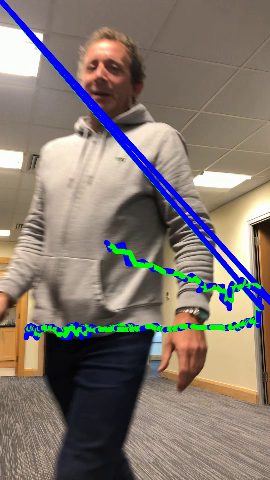

In [25]:
# Set this to 1 if video display
# is not working - works with chrome and firefox, not with safari
videoBodge = 1

def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

if(videoBodge == 0):
    from IPython.display import HTML
    from base64 import b64encode
    webm = open('video.webm','rb').read()
    data_url = "data:video/webm;base64," + b64encode(webm).decode()
else:
    video = cv2.VideoCapture("video.webm")
    while(video.isOpened()):
        clear_output(wait=True)
        ret, frame = video.read()
        if(ret == False):
          break
        lines, columns, _ =  frame.shape
        img = arrayShow(frame)
        display(img)
        time.sleep(1)

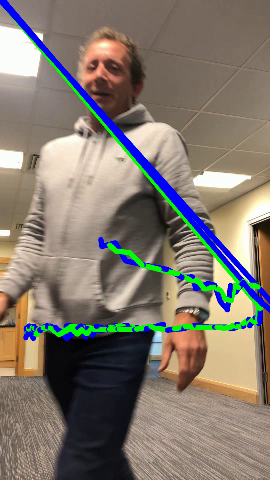

In [0]:
# Set this to 1 if video display
# is not working - works with chrome and firefox, not with safari
videoBodge = 1

def arrayShow (imageArray):
    ret, png = cv2.imencode('.png', imageArray)
    encoded = base64.b64encode(png)
    return Image(data=encoded.decode('ascii'))

if(videoBodge == 0):
    from IPython.display import HTML
    from base64 import b64encode
    webm1 = open('video1.webm','rb').read()
    data_url = "data:video1/webm;base64," + b64encode(webm1).decode()
else:
    video = cv2.VideoCapture("video1.webm")
    while(video.isOpened()):
        clear_output(wait=True)
        ret, frame = video.read()
        if(ret == False):
          break
        lines, columns, _ =  frame.shape
        img = arrayShow(frame)
        display(img)
        time.sleep(1)

In [0]:
# Display Video
HTML("""
<video width=800 controls>
      <source src="%s" type="video/webm">
</video>
""" % data_url)

Exercise 1 Simulate occluding the object being detected - for example, only supply every second measurement update to the Kalman algorithm and observe the Kalman predictions.

Following are my observations - 
when you simulate occluding by reducing the number of images supplied, the time taken has reduced. When the person goes off the frame momentarily, the green line follows the blue line much better. 

The green line follows the blue much better than the full frames scenario.


Imag

!e 1 -vfe9831z758z5/ynZO69MwDo1PKk0jxUF4B8SYEsITKUNTEtnUXqAloAB9qAANx4fLmUHR8fA6AM3f8pb64DRHm/4qrk+nb+v4qeQCjnA4DEQ5wpkPPzId4PAF7Kl8oKACD6Qr3NzAKpEk+G2EAGE4RYqsTZalyqxJlqXKWySUrgQLwLADKNx5NlA6DdAvWsQn425NG+CbGbRCCWAKBDhjiIL+IJII6CeGR+/nQlhnbAMfMLnux/cGYOc/J42cNYXYtKyGFiuTSPN+v/bMf/lvw8xVAMezhoIllUgrJm2LebudOjlZgGca8kMzYOYn2I34kFKnuIUapIEZWstkfN+HIO7BlgQuwm4IVFQ2wGcYQkLzZGo8/MEkdwIYYrBC0SF3CTNL6LhfLwRA1nrWx6QtwQzpJx2BrfRp5MFVdpf1KRm8zW8N8UCblD/K+LRUmp6pwxaqE4JRZibYiZ8tzEaLUNZlss4sQO2cgUCcr8bSH2F0oiQ9X82NQsWUSCxl6WLx+qF1ssEnNjNbi6QJQUpeHZxeep8jeGuEUoYScP8QjlE2OGahEIw8LVtWOXhJJkTb1Yp7QgNEHj+1KaF6+xx6nCvEil3hpiM3lhosYXDyqAC1LNj8dKC+KT1HnimTm8cfHqfPAiEAM4IAywgAKOTDAd5ABxe29zL/ylnokAPCAD2UAIXDWaIY9U1YwEXhNBMfgTIiGQD/uFqmaFoBDqPw1r1VdXkKWaLVR55ILHEOeDaJAHfytUXpLhaCngEdSIv4nOh7nmwaGc+1bHhpoYjUYxxMvSGbIkhhPDiFHECKITbooH4QF4DLyGwOGB++J+Q9n+bU94TOggPCRcI3QSbk0Tl8i+qocFxoNOGCFCU3PmlzXj9pDVCw/FAyE/5MaZuClwxcfASGw8GMb2glqOJnNl9V9z/6OGL7qusaO4UVCKESWE4vi1p7azttcwi7KnX3ZInWvmcF85wzNfx+d80WkBvEd/bYktxvZhp7Hj2FnsENYMWNhRrAW7gB1W4uFV9Ei1ioaiJajyyYU84m/i8TQxlZ2UuzW49bh9VM8VCIuU70fAmS6dJRNniwpYbPjmF7K4Ev6okSwPN3c/AJTfEfVr6hVT9X1AmOf+1pW8BiBQMDg4eOhvXQx8pvcvAoD6+G+dwxH4OjAC4EwFXyErVOtw5YUAqEAHPlEmwALYAEdYjwfwBgEgBISDcSAOJIE0MBV2WQTXswzMBHPAQlAGKsAKsBZUg01gC9gBfgZ7QTM4BI6D38B5cAlcA3fg6ukGz0AfeAMGEAQhIXSEgZgglogd4oJ4IL5IEBKOxCAJSBqSgWQjEkSBzEG+QyqQVUg1shmpR35BDiLHkbNIB3ILeYD0IC+RDyiG0lAD1By1R0ejvigbjUaT0CloNjoDLUZL0WVoFVqH7kKb0OPoefQa2ok+Q/sxgGlhTMwKc8V8MQ4Wh6VjWZgMm4eVY5VYHdaItcL/+QrWifVi73EizsBZuCtcwVF4Ms7HZ+Dz8KV4Nb4Db8JP4lfwB3gf/plAJ5gRXAj+BC5hIiGbMJNQRqgkbCMcIJyCT1M34Q2RSGQSHYg+8GlMI+YQZxOXEjcQdxOPETuIXcR+EolkQnIhBZLiSDxSAamMtJ60i3SUdJnUTXpH1iJbkj3IEeR0soRcQq4k7yQfIV8mPyEPUHQpdhR/ShxFQJlFWU7ZSmmlXKR0UwaoelQHaiA1iZpDXUitojZST1HvUl9paWlZa/lpTdASay3QqtLao3VG64HWe5o+zZnGoU2mKWjLaNtpx2i3aK/odLo9PYSeTi+gL6PX00/Q79PfaTO0R2lztQXa87VrtJu0L2s/16Ho2OmwdabqFOtU6uzTuajTq0vRtdfl6PJ05+nW6B7UvaHbr8fQc9eL08vXW6q3U++s3lN9kr69fri+QL9Uf4v+Cf0uBsawYXAYfMZ3jK2MU4xuA6KBgwHXIMegwuBng3aDPkN9wzGGKYZFhjWGhw07mRjTnsll5jGXM/cyrzM/GJkbsY2ERkuMGo0uG701HmEcYiw0LjfebXzN+IMJyyTcJNdkpUmzyT1T3NTZdILpTNONpqdMe0cYjAgYwR9RPmLviNtmqJmzWYLZbLMtZhfM+s0tzCPNpebrzU+Y91owLUIscizWWByx6LFkWAZZii3XWB61/INlyGKz8lhVrJOsPiszqygrhdVmq3arAWsH62TrEuvd1vdsqDa+Nlk2a2zabPpsLW3H286xbbC9bUex87UT2a2zO2331t7BPtX+e/tm+6cOxg5ch2KHBoe7jnTHYMcZjnWOV52ITr5OuU4bnC45o85eziLnGueLLqiLt4vYZYNLx0jCSL+RkpF1I2+40lzZroWuDa4PRjFHxYwqGdU86vlo29Hpo1eOPj36s5uXW57bVrc77vru49xL3FvdX3o4e/A9ajyuetI9Izzne7Z4vhjjMkY4ZuOYm14Mr/Fe33u1eX3y9vGWeTd69/jY+mT41Prc8DXwjfdd6nvGj+AX6jff75Dfe39v/wL/vf5/BbgG5AbsDHg61mGscOzWsV2B1oG8wM2BnUGsoIygH4M6g62CecF1wQ9DbEIEIdtCnrCd2DnsXeznoW6hstADoW85/py5nGNhWFhkWHlYe7h+eHJ4dfj9COuI7IiGiL5Ir8jZkceiCFHRUSujbnDNuXxuPbdvnM+4ueNORtOiE6Orox/GOMfIYlrHo+PHjV89/m6sXawktjkOxHHjVsfdi3eInxH/6wTihPgJNRMeJ7gnzEk4nchInJa4M/FNUmjS8qQ7yY7JiuS2FJ2UySn1KW9Tw1JXpXZOHD1x7sTzaaZp4rSWdFJ6Svq29P5J4ZPWTuqe7DW5bPL1KQ5TiqacnWo6NW/q4Wk603jT9mUQMlIzdmZ85MXx6nj9mdzM2sw+Poe/jv9MECJYI+gRBgpXCZ9kBWatynqaHZi9OrtHFCyqFPWKOeJq8YucqJxNOW9z43K35w7mpebtzifnZ+QflOhLciUnp1tML5reIXWRlkk7Z/jPWDujTxYt2yZH5FPkLQUGcMN+QeGoWKR4UBhUWFP4bmbKzH1FekWSoguznGctmfWkOKL4p9n4bP7stjlWcxbOeTCXPXfzPGRe5ry2+TbzS+d3L4hcsGMhdWHuwt9L3EpWlbz+LvW71lLz0gWlXYsiFzWUaZfJym58H/D9psX4YvHi9iWeS9Yv+VwuKD9X4VZRWfFxKX/puR/cf6j6YXBZ1rL25d7LN64grpCsuL4yeOWOVXqrild1rR6/umkNa035mtdrp609WzmmctM66jrFus6qmKqW9bbrV6z/WC2qvlYTWrO71qx2Se3bDYINlzeGbGzcZL6pYtOHH8U/3twcubmpzr6ucgtxS+GWx1tTtp7+yfen+m2m2yq2fdou2d65I2HHyXqf+vqdZjuXN6ANioaeXZN3Xfo57OeWRtfGzbuZuyv2gD2KPX/8kvHL9b3Re9v2+e5r3G+3v/YA40B5E9I0q6mvWdTc2ZLW0nFw3MG21oDWA7+O+nX7IatDNYcNDy8/Qj1SemTwaPHR/mPSY73Hs493tU1ru3Ni4omrJyecbD8VferMbxG/nTjNPn30TOCZQ2f9zx4853uu+bz3+aYLXhcO/O71+4F27/amiz4XWy75XWrtGNtx5HLw5eNXwq78dpV79fy12Gsd15Ov37wx+UbnTcHNp7fybr24XXh74M6Cu4S75fd071XeN7tf9y+nf+3u9O48/CDswYWHiQ/vdPG7nj2SP/rYXfqY/rjyieWT+qceTw/1RPRc+mPSH93PpM8Gesv+1Puz9rnj8/1/hfx1oW9iX/cL2YvBl0tfmbza/nrM67b++P77b/LfDLwtf2fybsd73/enP6R+eDIw8yPpY9Unp0+tn6M/3x3MHxyU8mQ81VYAgwPNygLg5XYA6GkAMC7B/cMk9TlPJYj6bKpC4D9h9VlQJd4ANMKbcrvOOQbAHjjsF0DuEACUW/WkEIB6eg4PjcizPD3UXDR44iG8Gxx8ZQ4AqRWAT7LBwYENg4OftsJkbwFwbIb6fKkUIjwb/BiiRNeMpy4HX8m/AX8Mf3ie2aAvAAAACXBIWXMAABYlAAAWJQFJUiTwAAABnWlUWHRYTUw6Y29tLmFkb2JlLnhtcAAAAAAAPHg6eG1wbWV0YSB4bWxuczp4PSJhZG9iZTpuczptZXRhLyIgeDp4bXB0az0iWE1QIENvcmUgNS40LjAiPgogICA8cmRmOlJERiB4bWxuczpyZGY9Imh0dHA6Ly93d3cudzMub3JnLzE5OTkvMDIvMjItcmRmLXN5bnRheC1ucyMiPgogICAgICA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0iIgogICAgICAgICAgICB4bWxuczpleGlmPSJodHRwOi8vbnMuYWRvYmUuY29tL2V4aWYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWERpbWVuc2lvbj41NTg8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+OTc0PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CvOwqEoAAAAcaURPVAAAAAIAAAAAAAAB5wAAACgAAAHnAAAB5wACDhvK+54jAABAAElEQVR4Aezdebht21UQ+L1Pe/v7+peXjjwDAjZo8alApEDKAtSS2FAIaEDpimgKFEHBUkSLDwpMCmm+Dynxw2iVYFAhdkBEadKQhITEAJIgiCEdr7vv9vf0e9c5a8zf2meNe9Zd+5x7Xj/PH2fs0c45x2zWWGPNNdf4D3zyy6Yjf2M/duGMuo+4+3NPZj/vIJzGkNx+/p5OLZ/nuj6eUav/Dxpv+8dR3xga0qvjr86/vrFT59/MA0PzqM+HQ3p1/tX51zd2ZqOvvf6NO4HLAQL7SU/q7zzQn9TCdwur5fcHT09GX1T/V//vD0ifjDG3v4w6/ur4q+Nv/4x4cn8PzL/+wOXJrWYtrXqgeqB6oHqgeqB6oHpg0ANN4LIXWO4FOIf9y3rT3WdI4yNYynbmrUfWq+VX/9fxd/iZnOdRnX/zeSD7ra4/df2p68+Ts/6UwCUG3N7E2wthIkszo+1R9jg5d6iT9uuRYqNRKxbZDlpYIxdl1PL5yCI4gzzLeyT3/DjzGyl+DenAZhpBDa3Qr/7fG+MzP878bh7wbPhu738d/3vjqo6//eMm/LE3Nvhlj1Ln3543ZjNmzyco4ae6/tT1Z/88Glp/x7//kz9ld0SZWDGg/N8/mGKYBWdGj6G4vxC6++F++YPLquXv9y/fzfzW9c+MXv3PFyDf7YddXteXIXcQbebbPGb32/Mb3F+u313eQWUdRKvlz/zW9c+MPvPRfhq/g11e11bIHESb2a793/XPfn/6DfL5ftjldW1V/+954CCf1PE3Gzdd/+zRdwOXvbeK9qLhef66Bm6tQRbskx7i79c7iuyQzhC/lj/zwFF8NaQzxJ+V3jfB90vMfrMLzjjdX0P8/dJHkR3SGeLX8mceOIqvhnSG+LPS6/g7iq+GdIb41f8zDxzFV0M6Q/xZ6U+n8T/+/Z+0m3HZq7u/yOjBIqbB38/r+00Tfw/u/R1kY49Obu/33t+t8P28vt9hZWZnT27vr5Yfftjvtz3KYfD9sn2/o5SZ3T25vb/q//DDfr/tUQ6D75ft+x2lzOzuye39Vf+HH/b7bY9yGHy/bN/vKGVmd09u76/6P/yw3297lMPg+2X7fkcpM7t7cnt/1f/hh/1+26McBt8v2/c7SpnZ3ZPb+ztm/49/x+/6hAhcFBDFxH+F7WH4aPD98nu/9/iZN0Q7iM/WHtz7Y7OW3/VHYLP/B/lyiHYQf88iX+/9rv7f88LMJ/wR1Nn/g3w5RDuIv7+svd/K0yfwWcnx6yBbQ7SD+HvWlLX3W3lo8D3e/r+DbA3RDuLv2VTW3m/locH3ePv/DrI1RDuIv2dTWXu/lYcG3+Pt/zvI1hDtIP6eTWXt/VYeGnyPt//vIFtDtIP4ezaVtfdbeWjwPd7+v4NsDdEO4u/ZVNbeb+Whwfd4+/8OsjVEO4i/Z1NZe7+Vhwbf4+3/O8jWEO0g/p5NZe39Vh4afI+3/+8gW0O0g/h7NpW191t5aPA93v6/g2wN0Q7i79lU1t5v5RVan8qeaP2rHqgeqB6oHqgeqB6oHnhaeWD8iZ/4iWKZW1bsXZd+qssfL3Twr/y0f9LgDz74YAOXpm9t4MJCyG1PNxt8Oo3ixqMTDe7fwmS7w9+Zht54XEKsIphx+qPRpPk5mQTcme40uPILe7SzE3R67JHDX1xc7NjDpweS1y4Qn/1Mx89Q/UH1GI/Db1tbW42KcuHsKC/jS0tLDYk99tHJg+ySR89QuzLM9RiNo1/o49NDzzg6eXiGfXrkFuYa5aTnh+qlfH4FjZtJdxjfVECfHXbxb1Kck6AefeLq28cfT27twKH6aUe236eX5TOe7QzhQ/4f0l+YxvhVD/Xuw80b88g8I688OJjtkgOvXLnS/Dx9+nQD9av+g7MD0ieHTh5fPeDHBdlVLtw6ppxcH3T1hmc4r55ys77+Gqpf1iOf6RnvK5fcvHbI98FcDnxo/JNjd6g+mZ/12ZkXZv23vPu/3lK1Bi4lMDLwTSQD2YTBz94kz/EgOR2c6fgZKg9Ujxq43PrKP+TfGrh0bzT6xl2mw2vgUgMXY+Eo0PzM66H1k82+ddZ6SC7DefXUI+vP1tlYZ8jl+mU97cn0jLOX6fB57ZDvg7kceA1ceCxlXF5w9c80nFf9pb/UwJNL72wgx00XItPRDoTpasNvB9x2ZGQM0Ok4MgSN0L5/7OloMGdcJiXF0vLLDb/ytrcjwwNvy5URSpmefVXo1DvrqV+WnxfP9tR/WjJI7uDIaQf75EHtA9HVc3l5mWoD8dkl1xE6AKF3ACtIKeNCLtvPOLnbhbcbuAzVCz/7wXjfKQ9p3XlrD77+Qde/fXbJPVlwKHC53Xrwm/ayl3H0w0L+79NTfi9/0s3U5v5ST9C8Ml/J61flwemhu5Cah2tra03VVldj3VRPcnkcsZOhckB2yMGPGypPOXD1Vh4/wUF+gmfYp0duXv2h+rEHkof3Qe3t489rp08fPZcDHwpc6M8Ls7+VA85rh1zWe9IyLjVwiVR67gAdMy80wdgxoGvgMq8HD5argcvBfpmXWgOXGrjMO1YOkrt5PYv1sgYu4S3r/EG+OwyNn+nAa+DCIzaNwMfuBGKCf/Of+7mGo0NOjmPPC0eORt2FYKdkOGb87jP1nOgejyIjQ35a6gPfmsQdijuShbJnxkRBh+cIUgCheQsLB2eA8EF6oPrwA7k+2Ke3sxN7W9yBsQtnL5ejndoHV44MAD2QXeWAysmQXqa3+G1mXG63/MMGLkPl4fOjdvIv3PiycPTx9Q89dpUz6F+KPZCdHvZoyP5Q4MI+O/C+8jKdHjp9MPPJzQuPK+PSVw/1VB/9rB/R6ZPHR89yMjYbGxsN69SpUw0kzw6Y9cmB+ORB9CyHfrtQOezDwdu1f1z6uX7mL/uZDzd/9Sd5cKid7JA/KszlwKcL3Udg2f5Q+Znf2i1PKLK9w+Ls0XviMi41cOHjDjRwQR2SO76jtA/p06uBSzeQ3eey5ueQf2vgcnv+q4FL3Gj1jTPz3LisgQtPBOQf/oODXemnDsv1q4FL9AW/6Bn9BqIfFWY7T2LgEm/hjEYB77v4hU0b/vJXf1UDzyz9fANdmHPGZatEbrMGxEILl3GhL+PCUbbcGGiTceyZ4XAZF5ExuzIL9PAtPPR3dm698NNTP/bhbT0H9s7QA+kJXNQTH05OPeCgdsiwoINZj1165JQLB9HBrHe7bxWxq7wMbyovCTxRgYticj/zJ7hd3kohPwTZ0+6h9vXZo48PH7KX+X2BC3vs08t0OD75Pkgef1498iA7Ml7ww9rzVlG2q3/ZBa0fcJA+qB74IP76+nrz07wFZWJWVlYavvFCj104qL7wXB76cUPlqBccPO7yjmpP/ax/uX746HB+zf2gHuThGbKT6YfFlQPSv92MCztDMJc7JI+f9Wrg4q2h8qjIAOOoGrjE0OEXA8nEzROK38iB6GDWq4FL93VwfuuDFsBef/YpJjp9ZPhN/UOgwMyvgUu3//jRvIGDNXDpDih+Ma7gYFf6qcPUz/qX64ePDjcOzNvcAvKZDmcHflSoHJCd52zgcufd39X44M3vjszJxrkvCZ9IdbQeMsFLjqS8HfStX/wGEg08Of7PDdRhk/LWhY6fTrp7WHIxk3LuS8foLqLDvFUEX0p7VNCVDwfZNYDJoQ9B7SCX7aKD7JPLUHvZxYeDJhBIjn0QX/kZ0sv0jGc5uHLIjwdSHvTIw0H0o8LFzjGMN1sZKmeIz//kXLj4WcaFXK4BuT5+ls+4cjP9uHDdN1SOftcOeF89sr0sj5/p2R4++Ztgecaf9TJOj70WlreK8EH9Rg4948rBh5OD429uRsbYjZXMCjl6xhk9dHIZ4oP0wCw/L84e+T57fXLkM3/IHv4QZFc5xic9/Qi37ucMF5x+1qOPrzzl42eY7cyrzz57yqHf4uk0iayX9eHzwj578+pnuTe/61czqYPPfY5LDVxSz3fceDNi4OAMdawBRi7DGrjw5NFgDVyO5jdaNXCJPS55Xrrg5PmbcX6kDycHx6+BC48E5JcudX6Mn9nJ67N+ZLEGLjwxH+TX+aSHpY4tcPmjf/QtTWk//KOvb+CvrX92t3QpkXLeyGjsfJDYG/L7z72qkX/557y8gTIu7R1DiQsMKBkXhbTm270w3YXEwCS/Vd7CYX9hFBkgcsohDwcNZAOY3Lwwd2TGsx31IpehPS6Zrr6geoPk2VcuPhwkDz8u+GzPuPBT7oeWnsY3+nHBJ6rf1K8vcFGu8QXyA5ydjJPr46MPQXbV5yZ4yIyL8swTe1zUF105ygfRwWyPHZA9GZYbN240Ks5twWdHOX10ciB5eIa5npk/hGf7ffb65MhnvnLx4YeF7LLD7+xkP+qHfB7PMyXj4rqlXfZ4aS8/wEF+gs8L++zNq5/lauBSju6vgUs3Y2RA5wFz3AOQ/Rq4hCfygsk/twufqH5Trxq4xCNw/Wf+8LsFH0QHWz+WT6CwA7LnglkDFx4LmP3Y5Q5juV/4nSb/w/VDDVx45NbwdvsnWz+2wOWLP+9PN7YNgNf8i09t8A8+/OEoc/WPl7K9feMto3LB3Hx/w/+Uj3tJAz/3U/9BA9lbWLja4CLF8mmeds/KuEx4Dprkb4ekc122p3HuySzj0phv/7V2yreN8sDFV59WMf0gl8gtig+2jJ4f5EBiR8240OdndnN7yeHDjws+VwKX7GcLZL7jOS6/svNE9Rv78wYuxpV5wx/sZJx/+vjoQ5BdfrgJHjHjwq6MC1x9cv2tN+Tw1Yd/4NlPHhGxzw499IyTw89wiK8+WW9ePNtnD8z8ee3OK6ecPnnlk9Mv5LM/9YsMi0AGjk+vz77y8JWXITvouX7oGbKPrpxcv7w5N+tlffi8sM/evPpZrgYubcal6xqONkDywME3ALraM4zcjNL9hQ92uTdj5EASNXDhiaPBJ3qPi1pZOPSf8VUDl/AQ//AX/8AzH30I0uP3m2ANXG7pQv66pdAtmPxPhD0w88kdF1ROnz3lk8vjLq//1n2BSg1c+jwbdH69tdT83GMLXL7kCz6vU+pvrv+VBn/N9/3LoJ+MvSvOcRm1b3GUDEzJuIwWIhPzV//I9zd6z3/+8xu4uHitgRww3fF2UpjfPdqzw5dxKdzd14nCrgE5XejqLyZ95RjQ7NAH++TI48MzxAczH44Pos/qEXt6Znj4lTy6CQiyo53k8dHJ4cPBPjr+EHy6ZFxyO7Sf/4ba0cdnB1SOBc8dT59+H50ddofk+vi3S58346Ke/AlXfsbJ9fHRMxzyC34Ljxi4KDdnXFq76eTQPK+y3FD7ZVy8ReQCmvWUo36Zj55hn5x6Zvl58WyXPXDITtYfks/8ecvJ442d7E9+l0GDC2Tg9NRfPZQDx1dehuyg04f3QfbxlZPr58aJPEgPpA8H++j4ffbwDwtr4FI8VgOXbuBnouQB2TcA++jzDsgauHT3GM3rN37P/ZT1yWX6ceE1cIkbIf3A3yA/53mFD9Inny9QNXDhmcNB/h3Syv4mr9/gLvw1cAmP5HHLT+C8/ic/BI8tcPnKL4iTcHX81jTOGdCxr/rOT4q6lIzKaOX3dOs2LntenCC6EefB/NUv/h8buZecfU0D2d/Y3Ghw9hfTur9lK00pZZzufCbj+Pozhy6O4ltK7OsI+GIpwB2yr00X86OyFWaUBzh9cqByM57p+CA+iO5RkfLwQXLaBc/1RQezPPpNsOdbQ+RyPdAPC9kB59UfaocLL/+xyz+Zjj8ElQuSV38LIHqGykdXD/otTBmDXB79DOlrf+bDh+yxQx4O0gfRyef5NKPf+hd7pPgHDpK7udyQ6KPTnxfmcvrskst20UH6TshFNy4y3mcv04dwdkH16NMb4vfpHRf9qOUbLwtlfYe7DKnf2PWpEJTHP751Bc/8sgVz9zpRMv02aRZ7ef7pX+X3wdZen0CiqxeILeOLDuKD2geij6bdCzB+tpPxVv+QP2rgUgKaGrgcPHIMwIO5+6g1cNnnjNlP/gNxTOAauPBI99Et6hDMfu1byMnxe7bbR89yQ3gup88uuWwPHaRfA5fsqS7OT13qMGa81MClm3Hv86dxCbYefrYELtujeGtH5PjBy1/TtPHb/nF8BXp04hOjze0BLLFHo3XExjvan3s/vvMvFr1CnZaTdDl4IeEyLgamR0GMThe6e0IELuxlOC4RMnrGfatIe5WjfDjIDhxEB9FBdBBdxsWFMPPJGXCg+g7J0++FT/PApa/e/ODIev4jL6NHjp9AcoeF7NGb157xRB70jDrbzXguj/7Q5uQ+O9lextkf0j9qxkV57CsPxB+Ch5Xvs6cefXzlkAPJ61+4bw7RM1/x6Wd65sP7IPvsZYg/pN/Hf6LpQ/UbKn/ifDGC6UI8Kud8texyw8tPMi746OrleoE/ShmXJdfBVmC+H3m8DGmpD0je+pHp+NrThz9rMi41cIku7htYfQMEHTRQQHQQvQYuPHE4aELWwKWb6s1e5KdMh+fxCAeH9GvgEp7M60UNXIywW0Pj7NZS/dwauIRv+vyY52/Gn7GByyu/8BVNyzV8axwZF/jOidiT4o72a7/zxeEpX0Ne+NyCl70unimKhNdiz8vXfdEfbORedPbbGuhOY6skbNhfik8ZjexJGY/iK6nkR5OoTxS6u2yWdVt9p+UtJPxpqYcOg5PPEflMr7vZJi9MM30aAdHBLnf2zSX8ocBFvdmBt/4oDPayHLwXPkMzLtrjGfO87c9y7IC5n7Of+Z/8kD1y2S7c+M126aErB8R/tmRctEf7+AedH+AgefhRIft99jIfrp5w5V+/fr356YRcGUABDRykd1iovsrPEL/P7hC/T++46LddfsqA5AuxrSl99ZVx4beb69PdvH1cGRf1MX7gfVC9QPVVf3ro8CE4Thkp8srpw9GHYK7Pm37hfbdUmftbRTVwKR+NTO7MHZcHWOZTRwfRQXSwBi48czRYA5dnR8ZF75sXeb7lBTDLw48K2Vd+tpP5cPWE06uBC0/cGvb5+9Za+7g1cNnnjN3DSiQUOtR+5BkbuPxvn/9nm1Zp8OYo3irS1M3l+LaGAfYbi3+zYX3vd/x/IbL0+UQDyrhMInMz2nhX0MtXWL/rVW9ucOVNy1emZVzG40jByLgsLpzo2F8oe3AQfZ1X/WRc4FLZszvniKDx+yJyfOVYoOCZjw7ig3307e3wN/tZnp/6YLYLJw/vhU/zjEv2R26HwCW3lx6/Zj04OXiG2e5sHHUlh8rpSu+OyjLwhjIu9Prq2dd+ern+6GC2CweH9M0v9o4LKh/sqwf+UcvNdrO9jOu3PA7QrWP0nA+ifuTo14xLN7PNT3PDgcBFRp3fs10ZC/3ktXWfBHBjSW9xqXuja/7hHxb21SvbMZ5A49b6QR7d+GKfHjkwBy70jGNyffr4fVB98I8t41IDFy7twtxRBgCpzEcH8cE+eg1ceOZgmP2XpSwceYLQy/2W9cllOjzbNbHxwaFyyIHkLTy5HHJgXz372k/vsHaVAw7p18AlPK0/Lfj854KoP8gZRzVwqYGLsXEraDyB5qX1gy668WW80SMHPnMDly/8M9pQYMmUFGxaMigyIBfPxEB76KGHGonv/cE/EpJtiuoP0ywwvXV0I75G/XV//jMa/gNn/l4DOXpx0s1ATHp2bVsgxuVr1bOO6WZU7GnRoeRA9FLZXRARtQ6f0bu/8NnpcmdY5tNT/8kkzqWBzzS7v/gHVO9sv6s1BzaQcZnDwi1F1C/DWyodgmlzLhX+4WcQP0P1QudXOMguPEPl9NmjT66F5UlPX7nZXi53aI9Llh+yl/l99WLX/IIfFeZy1APss5v1+uT66OxnO+j0Mq7/BB74PqLojl2/Zzvo9PEPC5Wr/hmyRw5EJw/PMMtn/hOND5bfk3GZtSvWc3b0W4uX+acfXOf0j/Hd2kvlHfWtoj6/qV8fX73x+wIXfPJg244iIHDB54eh6xH7h4XHl3GpgUvyfQ1ckkNuCzUhMrwto/uUa+By6z0u+1zV/NQPmQ7P/LzQkQMt7PCjwlyOeoB9drNen1wfnf1sB51exl1gLPT4NXDhseOB/NprLQUSNufO+rMGLnu+48eZX8Kjz9jA5ZV/7gvSmIiMi4bulPfiNVjGhdLP/Xqc8/Lv/tUbgrTwmYXlVrKkAh1puPZzwS/v03/H/94992V5FBkIC8O0nNgLVy58cTFOzhUhWkjVH67+9PHhM/jkBi6eoWrPrB7dX+4AwNyervQM629nkbnNjMug/VIMOXBWw9v7JXDhP6l55YB9pdDr4/N3Hx+dHeWB+skFjlwLTZM2Y8liQHa61Bn2bMm4zFrU/TXUfv7tag1j2S47mT5kifza2lojavz1jRvjoM+uevTxM1359DIkTw5EJw/PMMtn/hOND5UvId/KpevVtODmW66vPS6ZDn+iznFhP8O+epJr21kIMi5ZL48/eujkBS7GAb7rqXLnheyQVy782DIuNXDhUrAGLjwxD8wDs0+HHNgnd1h6DVyeHRmXvn4fGi95oeyzk+nZLjuZnvUyTr4GLtkzx4Pzb5+1GriEZwQi/CQAgfMjOvlnbuDyF75Q2xpYXv5p33pYmETGxMTeTifd3lj6bY3e6173ugb+wiOvDnsyLAv3F9xeFwtt2P2YE3HOy5/9U5/WyN154ttDvuf/pJwzw/FLZXcifDIq58nQn3YDER2IbU+L9mU+HKSnvEzHBzOfnoj2djMuBqLyQOXAcz3QR09wxiWXm/G2Hof8wY7Nqdrrjhef2YyTx++Dff7N8uwpBzSuQHr47pjQMySX6XAZlyE58kMw28n1zvoympl+XHiuT7Y7VL8sn/Eh+/jKAdnxFsrGRpwv5dwWejnDknF2jgqVo15gnz3y+IeVp/dkwVzfXK7ApW1HybDQk3GhZ562eLkcmefWZXzfuoPnc1ysPy3/Nn/k+mVzs3bF9dP6of7k2Wn9UhjGX9vO4i90esrJ+uxnSB4dTp/dt7z7vxI5EM5/jksNXBoHcjCH8yocRNcRmY4PZj49A6cGLjx1OMivFg5+rYHL4fyYpfkV3byAZ1gDl3iZoAYueWQcD57HY7ZaA5fwyHM2cLFATUsI50Ig42LAyLjAr4xe3Pyk/7d+8HMafOvxeOtoNLqbaIIRMS5fe31Df8k9z2/gV78iMjDs2eUNl3FhbGEUmRwDfLvUX0fubHczRvQEDs+0jIvIWDu0Ew7qPzj/wFs4Z8aFvn6As5Nx9Aznlct6GWdnui2TFxLe5iCf/TBExwf7/IsPKqetV/omCr+RJ+eOCT1DcpkOrxkXGVweORrUf7Rzf6GD+kXAYpz06Qmo8enD2T0szHaG7JFXzmHl6T1ZMNc3l9sXuMz6MzLuWQ+e599MLyR8HZr80yXjoj6+Dm38oed28KPrB74HI8bn7LrI0nyQ/T5p/GP7OvQrS8bFAK6BSwQ6OoDDQfS248sFCj3DPj0D5LAZFwNPOXnAoqsfPNcDfd5HRfTbcZLajd/a7fkxr1yPektmpwYuceHmj9ZBR/yR7ejvPnPP9IyLduX5MtzuWCdq4MKDTwzM4zGXUgOXmP/5OpDHMz+6fuA/YwOXr/qKL+2MBRcCDeUQF9qN9O2f5Z3uOSQfOfXbG3uv+XtxPsuNpZ8s9svek2nIdwrdh7zqMyPjcv/9sTfmjpP/puGqz7h8HVp9xmVPi4VmezPuwNV7PO6WtxnHvMxKLDh9B2rp2Bk9VNSDAc9Q0ellOJOPBU/9neNCHySvfFBGgX1y2gvPkHy2n+X6+OjKgefABx1U71yO+qD3ybFDLkN+RHfnwJ5yQHKgcxjwtQ8fHZ6h+oGZD1cfbynM5Lt3hPkOcCbHUkB0j8q63GFMfdjp0yDXx8/1zXKD9sseuqwHHyr/uAKnXM9cLtx4kAn27SHzkpz6gy4YcLBPHv+oMNvN7Tuq3aerXl97c7uznPaQy3x0chlm+czPOHvGUc7gZPkhvG/+WcfacoqhTPdyQx6f2pXX11yfyaib8dS+LMfeG9/53szq4HPvcamBS/iNY2vg0s04GVUGpIEPr4FL+Kv1B4claHzVwKXrGAtnlzrD+G1G6f6qgUvXH7Dst6HxSe+ZCvvam9ud5bSXXOajk8swy2d+xtlrA4p8Dk1WGMCfs4HLX/7KL++4Jmdc3MG6s9guN4g6QMaFkQ+f/Bg/G/iN3/4ZHXzkq9G+aSRXVaTuvfr1za/P/RN/soG/86N/oYEiv+WViPDc8YzSW0Pjgs8usLF5Tn2309cwpzvdC0++sNAzQNsBV+prj0yWU1/y+PAZPzJC+GBrvvwQEesPdrQzy2ecfLaf8awHJ8cP6ONyy4+fYZanpz7wPjn2yIFZH73PH33yt5txYVc9+9qBnseX8aP+FiL2QPwMXfjZz/w+nPyQ/T59dM/Y4RkO2Vf/rDc/nlOo82seRtJ8Nb6sh9rHnxmat8rChz9RMJejnk9UeU9Xu7nd2S/qTS7z0cllmOUzP+PsWTeeqIxLLrcPl7E1rnN7jPs+/acs41IDlxq49A3K/XQTLg/sGrjEhbPPP3zIbzVw4ZGANXDp+uO4MOONPeMT/lyBud3ZL/xALvPRyWWY5TM/4+zVwCV7JvC5HxV97Stjj4sOEGG1ji32OTzLyXShb5WvS8uI/NKD8bbQD3/btzWWHnuknJy7sBSWpwWW82FG7R6YyKy85svi69LucM6fjJN21Q9UvjtY7ZguREYDf3unu6dgutN9K8WFpTS7Pc+GPj8oN+MiV+Wzk+Xw2QHJ0VOuOzc4vvLgfZB9fOWA6EOQvHr0BS7sZHn0XB/28EH68D6Y7ZHjnz7+7WZc1A9Ubh+8aXyV3YV9+n109g974edncMj+IH+h+4xbveaF7viGyum398RmXNTL+IGbv/yofnDjDkQnV+Fz0wPGj/H0dM+4qG9fb8m4aE+Wz+P+2Pa41MClBi59g/IguoFpQNbApZuxO8hn+2k1cNnvjd3bjHBf+y2VLncerAYu83ipyjw9PGD9dKGvgUu3X+bOuPy1v9Td48KhGbpzUAz+dCcWDnwZFx30ix/1QKPy/v/26w38N9/9VWHC67QLp5gsdF+njju5+x6Pk32/7mu/tuGfKyftsi+z40Iq49LSl7qp/J1J92TdcTpvw2Y/d1TKYb9td9HLfCdp8gc9cvTVDw6S4xT69ragsw8fguyTUw6I3gfVgx34Ux24qId2qB8cP7eL/1w49XeW77ODnmHWz+Xa/I3e9/VzfPbhGT7dMi65vkP+4P+sp519dPwcCKIfFzQu1MO81a4+2JchPa56VTvPTA8YR9app1vgwqvGtfqiZ/iUZVxq4BK3fLOOigxMXrDwDTgdCuLXwKXcQpcRnv1j4PMjnP/gIH14hvTIsQvHz3o1cIkbA37K/oEP8tOjoizf53/2a+DCExU+FzxgflinauDS7fW5My5//VVf0Wi6UFvQmUOHZ8fLBOiIpYXIcLiA70wjw8Hu6x/5nY2pN/zwDzdwbfM1YdrbRWN7XkqJ6OWE3O965a80DHtezqzEW0fuhKbTeIuoaI8WF5ebn/iTcXxTRDucw0Let5rwLbzwDGV40NnhN+2Gg+TzAXTooPJXVlaY7kD8DnEfwg6SfkIH8fugcuiTk3GBg9luH84ePymnzw56huwohx14loc7eRbeJ89elsvy5NSHPPq8GZdsl50MXfgz/bjxvvrkt4qy3KzdB9co158+eLDWjPpkZVz0p3UnZ1S00zgG0Wc1rr+O0wO36995x1lfnXP5Q/Yyf+It274CBujeQhwQ62Xn+Wfc9imYB/gyLvAheGx7XGrg0t1cWAOXg4eeCZoHbg1cuhmmXj+NjbPunoy+R0V5gTu4V2Z7RPr4x0Xvq08NXKJf9buFH0Q/rn6odroeuF3/9o3rbin9WC5/yF7m18Cl69u5My75UVF2LDx3kOJkEPAXx/Gohd7WTkxsF7xfOvcnGtUffO1rG/jQ+/9KMVUuAOMTgbdvF3UX+gcuf3HDt+fl1FK8ZaT8zc3rDd/CMSnq6jNatIcmisEPbDTybaNWvjDgyoHvlHNg0EF8kP3r16N+Ttrc2soZoPADPfZkXOCZz34fJK+/huTwc3noLez51pHyyPXhxoX+Ul6fHnqG7CiHHXiWx893HOxkefVDz3bZQ8928HOGYGfg5El67CofzPVHP27YV747vr56ovfVJ9dfOWCfHnr2J/rtQvWWqXW0f1+mhTxovMBvtz5V/2AP3K5/5x1nB5c+GuXyh+xl/tMtcNFO4xcO5nXtKcu41MBFlwSsgcvBGYQ84Vqv1cClcYUFjJ/yBMfPF9oauLQjqfnBf2CXezOW/XmzxNEo+qsGLkfz35OlpZ+OWt6846zPfi5/yF7m18Cl69m5My5/8S/82UbTs1uOdWfhTh8+LXtGyK2MIqWhA8flmR3+RvkWiQhuaysyMux9ybe+KGpuL8vqZwbu61mTboZktkcgMjnf+co450V5J0Zvb/TZH5W3ntRvbSfsubAsjLon10rdsxeV2S21pGa0Az4p58KQb+lFvq1HMTRvxkW56i1DA1ceuSGY5XM9h/Qzv61H2XuU+XDlgpmuHvzKbpaD90F2+vjouR72uKDLIJAHc72UJ2NAXzvws/5O8te4nCBNn3yGyh97ltkKdM8lasnH/CPXD579pZ6Kzzg6mP3PLkiuDz5RgYvyZSgFMNqjn+Eguvqiwys8Xg/crn/181Frlcsfspf5T1TgYhzmdSi3M59jhU8fDmZ7T1nGpQYuNXAxKA8DTdhpuhBnGyYqiA83EUwUdrMcvA+y08dHVy48XzjzhZhcrpfyauDCQwGznzLelR7tfiI1bkD0S4ZZPuM1cMkeeW7hQ+NryBvG25BcHz+XP2Qv82vg0vXs3BmXb/y6r240dYDMC3PXrl1rfq6vrzdwa9rdjCbjIiOwVG4A2dsumZPZ20csB/yNtS9rfvzd1/xYENqMSzlvZRJ7QHafJhZFe14Cf97lz2/o3/D18Y2jUwux56UIj3Y2uxmbzZIhwh9Pu/yccckDjZ47sVE5+ZecC5r2k3fHBpLPbxWRB9nhX/TDQuXRU08QPUN66gG2cuVREbmWXn6gg/hw5QtcQHyQXh/UH7l+7Ckn23PhZHe7ZP7YIQ8H2XOOinLw1Ydd9O1271ZwZFzI9UH6T7eMC3/l9ud2qH+m8z8/Z5jlM367gYvy2FVP81Q/omeY9fgh0+EVHq8H9MdRreb+P6ydXP6Qvcw/rsAlj7vcDutVpj9jMy41cKmBSx7M+3ETzQQFW5kauDSusHDwjwseP6HXwIVHAtbApeuPih3OA+bV4bRm0ta3GeVwv3L5Q/YyvwYuXX/PnXH59r/1lxtNEZm3bPLC2+Jlj4td9kvj1UYffn39SoO357hsx2ZPGReZA/Dxex7vyH/9N/3uBh8tlNTN5H8J3B6YwHb/l02k0xsN5f477mjgN73ipxsoc7S8Gue+aF85SLfdDb612d1zs7Udj460d3E5zpWhPx11A52d7W6qe5LuqLe3IkPEnkcr8LxlIQ9sF0T+M1GyXNPoW/zL8toD3kL11qwjbs5lVMZCPbRTfUF8euC0fA0cvtg9GBm53aNkj1Rr116qIonOz+oHt+er7b8yYeCrqzEf1Nedu4pMJjG+2HMOEP4w7O4po6/e9OGzcnCOB7IPsjpUXuZ7NJftwLO8ckD9Az88lMENTf2mP9XDPGRfvUB8OLkKb88DQ/6ceFbbU4z+62EPkofKHyi+ta8eYMs45h/qe7vlmAfGdV81ZVz7+Jn+xne8L5M6eA1ctiLAqIFLjIs8kA1MsDN6DoPUwKXxlgtdDVw80j14EFlYcWvgwhMVHuSBPF6yTA1cuh7hr7zed6WGMdeFp23g8n2v/ttNK27ciMzFxkY3o5AbsF32uFioRztxi0tuMg79Fo+ERnvHS09G5AMnPtCUD39049UN/n3f+S/Cu+PPKbDcSueTBieR4bEH5mV3/fVG/hV/7hUNXFr5Lw1U7ri81RRGRyMZEW//7JQ7aB1fmkt89yWl7rkr9ri07U0ZFxkVGajFpVjYZai8fm3AtQWVHwaOTETmq+cQXf3I0QPRDw2PGLhorzsW9dNeONhXr5xxGaf6ZHu+RcWePU1w9eIXjzLUI9tDb+VLyocddsG8J8PJzfRB8jfDbobAHpmsB++rx812j0ZRTp82vnqA5J/qwEUGrK1Pmf/6FV29+6BxgU+vwtvzwJA/n6uBSx6fvGwcwo8K2R+y95RlXGrgEheCGrgccYinQIEVF6w+3IJUA5fuo8bsN/6bwRq4zHyxe7tSjlvYTzvM7xq4HMZbT76sdaKv5Bq4dD0zFGh0pfuxp33g8vNvfWNTe+eLXLz4aAefbKw1+NpawBvXLzd4mzHYKCmVhrq786RsPdHw7XJuSjsASwoDf3Mnnvlz+IdOxVtM73tfPAv7hz8QGZRROe9itPiCKElmQ4H2xKy/t+H/+T8We2U++WP/cYMrf9pmaEqFy1tG6jPJF+LSPBcUe1TIT8stIzzvcZFR4S8ZFxmYUdmjwb56gvwCB9WeXh+Orn5weiD6oWH2VzGQ7WZcO4YCl6H67JT+4adpGRe5vJmd7oUfXX1snUJfKhXEX1iIPU/w1dXut7AWyzjU3xvb3fkxWewGKuNR2ctVChyX8ZTrD58k+cVxTDh89YarJ/pxQ+X02cVXD5D80y3jkvckqad690HjD59ehbfngSF/1sCl6988Ds2/rtQM498huZlG95f526XOsHzdObY9LjVwiQsZB9fAZTbo5vpVA5fGTS54NXDpjhoLogUSJGXhI4cOz/L44HFnXPQj+6B69MF8waBX4e15gL/7rNTApeuZPA7No67UDOPfIbmZRveX+dulzjDXVZRjC1ze+fY3s9nAcfnWEOK0vAUBn2zEt3YuXbrUkC49FtAd5tpanPciQ3P9RmRQ7DGZlG/7wHfKLS4HPnw+9pBo8Nf+3S9tyll//MNRBRkXb4M4Wbe87TQqGZdReQvpVZ/52kbvxS9+cQNXlsO+8paXu6+h5MBloWRE1Hc3N93Y8U9GpcVLfdRfRoV/6B93xmVo4LX1KRUlD6r/oWHyB/1sN+Pk8oXHxOuTz3R7XLTPHhdyYFteyVDA8cHFhRgP9hQZHt4mWl092aieOBHf1Nrejq+R33PPPQ398QsXGqh/18o5QvaQlYOWd1+aK5mWlIE03rRHvUAZF/hCOpcot8s4Rz8uqPwhe+T66tG38A3pKTePH/R5oUdF/G2e5/rC+6D+xJ+3/Cp3aw8M+fO5Grhkrw35yXzq0+vjZ/mM981fcuYVvAYuNXBpxoIBBxogGeYBRB7M8nPjNXBpXFUDl4NHjPHVt7D2LXxDekqrgQtPPDth37jR2hq4hCeG/GQ+8RtIr49Prg/2zV/y+bpzbIHLO97xNmV0oIbYtKoC3XzD7pHd2/GMn/K4fH15ZzPuRK9dv9iwHnvssQZeX4sMjbeI1q5ERsYem83NeEtI+Y8uPNDofc/3fE8D3/OhH2lge45Le6JuuYMdxx4E53WMNuIcly/6I5/Q6H3Kx/79BkoJr9+IvTvqY4+EO+xR2dPg3JlSeHvHrJ7gTsm4uHOTcWntlyPy+VPGBm4g8TscVD6oXDiY6exnfpbDnxs+wYGLdqsnqD3j0t9w57jwf5ZfcrRzaeBkJ8Ypf585EeewyLhMdyJDd+rUqUbj9Gr3Lbpzp4OunifLOS6PPx7nE62Xb2XJuFy9HuWxv5Pqvz2JccxeSVCO2vb0HJHf11/a38dXTh9/SB9fxoEd/QEHc3kWPnbIzQu99TWvvHLUz1tmMzz2DKkneXgfVH72AzpIH17hrT0w5K+hwOXW1m+fa49enyX1N47APvmnC1091b+vXp6Y9PEz/WfeHtfjTIfPfY5LDVxq4GLQHAnWwKVxmwleA5cYRQKBPKb4Cb0GLjxR4UEeyOMly9TAJXvkePDnXOAyGscdKveNF+Otimk5H2G8UM6J8Yy/vM64fuVqo3LhQuxluXo18N+a3NvQ3cH+r1/5P4Rpbxm157qU15nKSb4jH//biLeMdg+SafRe+zfj69E6ZlruiOGTkjGxR8GeAt9qAmVQ3GG5g15eiTtyE25zI96aikrv5YnCHxZ2GRd8dPbYwT8q1D76ygHRDw1vM3A57B2LzIN62uMC79vjop0rK5GR02+LpQIyLquLkfE4d+5cmJxEhoT8yeV4K8geF98O0k8nVlYaPePj6nrMB/iN9eh/e542y5Vbuza2unf8vr6KP32aZFzyeOIf/cDf8D4ocOnjD9GPO+OiH5WrnegZ5nbTA8nDKzycB4b8VwOXw/lzXuk87vv0hjIuuf9++m1xrlqfvacs41IDlxq47A1KA98AzTh6DVwiEBKY1MDFyJgP1sBlPj89U6XyhS+3owYu2SPHg1uvh/z/lAUub3vnz3VaOk7niiwvxh3k7A6qey7FdtlawshSyWy0dyIlETIpB27slE217nC3SwaCoxZL+cpbLHsSJuUtoTddjLeW/tSnf1pT5JUbP1OKLgUN7Xm58bON/Lf+lf+5gR99Z+x5Ud6m1z7K+TDp49KjjZLhkZEZFQfAN7eifnAn57Z7ZkqGQnvxSyNG7sztqeEn/KNC5dHXXhD90PAJzrjk+rjAo/dlXPC9XQY/cSIyLvx6YjHGjT1P5wr/9OnTjcqJlEHb2oy36ux5WSmZQxNcJoW9zfKtLn52rIvxsVZOcm755ZwWe2ImMoulATvla+T8MBlFoKx9I5vWCyH3eytXfqh3pg/pZX4734sh7WFXOVnvqcq46B97XNTLuFDvDLUjtxc9y/fhyjusXp+9Zzu9z081cHlqez7PX/3UN75/6q2/fMsKz51xqYFLDVxuOZKGmDVwaTxkwtbAJQZMDVxuPXH6FvZbaz13ueZX9kANXLJHnlz8WRe4mJijsofFHcp0Me54xyUzsjUqJ+d6du81iuL/ib0qBX//Qpyf8eM/++aG8jVf9rsKR+qnZITsfSnyRWg0Wg89d+I/+w8eblj2rlxbi/q4AJVvNbaPPtbLuTbueBcm0R4LtYwLe/a42BOBL7Mi42JiOv/Gx/pkXtr6px/0EvkmtO2PwlFf8CaFeQlPUeCiPX0ZF36ZFgfbM3TuXLwFxL+nV+JRDb+PNmOztv668/yZjid2toPPbyeX46069o2bq1fjbbnLVyNDI8Ny1933NfbU7/L1rr1pOY9Iv29sx94s42ltI3DtP+6MC7udRh+AkNMOkCj/wPHpoeeFD31eeNRHRTnjon6gesJB61iuH36m9+HZfp9cpYcH+vxbA5endoTk+auf+sb30z7jouI1cIlAyIWwBi7diTa0x6UrvbvlujxyNL5q4HK8j4r4Nfs94+QsVCC5GrjwxMEw++9gqUrlgTy+0GvgwhNPDXzKApe395zj8uS5IS28o/R16nbPStQoHXw6+rwf+DsN41ff8pYGvu9NznkpGZj2XJfQl2kp2Gi0EXt8/vubP6shnVr8xQY+/HBkYq5eKedxrMfelfX1uJN2Ab16+UYj7y2o6VacrOrOe6vsYXCndvla3IFbuED2ZALoqyecHXBlNTI+cPIZenavPBeWvgO8yIHZHtyCApJnP8vBycHnhfwE0tP+ccmIyVgsLkSGwltCd5yJc1rsURmVc1zUd/1GfItLhuNk+RbRXXfd1RR1IZ2MK3OmPP0Hv1LOKXKOEfqZM5HJWVyK+tjTsl0yLHffHeUtLMUeM/z1ksGEj0pGkT+moxgPMjzbvuVVHKWf+C3jvlaNn6GFSv8NZTzYJ89ei5e3uDIdP+vrJ3zlt/0/jgwaPrvs8Mus37qb6cllPbhy4BlmffWYl57tPdH4YTdX5voc9sYj64/ygn6TQJfAj2DZ+tgVOgTGzpCKfgTJz6tP/iZ4yPbfpH+bBP2vHbl9zPfR7UmlTz5D/J98W1xfMx8+9x6XGrjUwMWg2Q8NVHA/b/9vAxIk7wJDFh9ODj4vdIEG6bmg1MClBi57YyKPL+OvBi5mTEAXri51hvHbjNL9VQOXCJS7XjkEVgOXjrOeNYHLNL0lkfv5beUO8zX/6P9oHPCv/943hCOE4kMZlxtvDPnydsj0Q3+gwac+OzyNDNC4HMk6KRmXy5fjzvzh34oTgd1RX7sUd/jOnfmt34rMjYyJrwW70Lrzw/dIKSo1W4AtIBZk0KOnLA+XaYG3bzcVgjvWbJ+8cuAZ4md99CwPx6eHPgTp8Rt57VwqA4R/T5a3hM6ePduInj0ZF3Z+Li8NtW9zbW1ERs2el52tOIeFfQGZk54vXoyToGVoZHZOnYrM2/nzdzblXrlypYHkXEAXylt7MjAbGzHeTpQTfM8WfYHaWjl3SPsevxQZP+2RcVGejIt6Z39nvLwUyK1tAEBOxkV9lsr8xKcIB5WPrx+nCwcv/Pj04ezAjV/+yPLqiW6e6c9xGS/4oHpmXDn4GWZ59ZyXnu090XgNXA4ef9nv+hHEz/2KPjfMF7S5FY9HMPe/9mgniK5U82qhLAj2+OGD9OH/6eeP6a2ip3vGpQYu3QPJDASwBi4xJVyIauASgVkNXGLeWGAtvDVwcQkJmC9cXe5oxG+ZDq8Zl/kCH/66CdbApeOSZ1DGpVPvQaR8TLeVWyhvjbhwveCT39HwPvKh94fMic9pZQ/8Me2ebPtpH/dQI/bD/+RjG3j/3c6HCe3JKO7AF8qd5s5mZF5M8OlmfJvpW77lWxuFjWuxl8Hehq2d8haVDE95+0kgInK14KK704Mrz7eRonY3/2eHfyzc6BYe5SoHpKe8XEKuDxzM8hnPdvv0yIGzt0Kif9R/pexpIXf+dFzIZTROl09r2YtyumRk+OPGeuxBWi8n3l67Fm/9tBmYcofBj489Gv0tA3R9I/ZCra7G3pQzp6P/n/e85zVNX9uIDEkrX94+Mj7OFnkZlxMrUWH13S5fU1efE2cik3TtemSKllejPO2RkVHeNGcgU0YzZzT0F3/qH3LGSZbrw+m3sHyNmzyI31cu/lDGhb4MFz8Y14uLceEhB7b2ffxKxQYgfWLszEun92TB53rgMuRn/aYfQXr48EPDp0ngoh25fUPtoUcObv2xTphvx3Zy7lOfcdHk+WANXLoZmBq41MBlb+bUwCU241s4LcDwGrgcvL7WwOVgv6AaP8YTmPnwQ8MauHRc9pzJuJRPx7SN/9C1uMN+0cf9UNAGMy7lLSZ3omvxVtKn/d5PavR/5t98dAPHJUMi46LAhUncQY/K+TTrlz7UsL7v+76vgY8/HAuqhTMHXvlrxSJTME8cdtryy0tZIlzyoDtM8qAJKOOS6fj04eTYlymQEcBXH7g7cxE4nB1yuRx08vAsh+/rzeTOnIg7aifhnlqKQId/y0tZI/hGOfn4woV4m2xrK/YsXbtW9r6sx3ixV+XypaBr79W1GA/qt1Deijt//lxTpbN3RIaEPL49UvfefU8jd++9AVeWooPVb7NkGJW/WjI0+mFzp9veK9fiW0sXL0ZmaK18O4u9fNKu/lB/kD/x1R+d//HRQXT2WvgEZVxy/byFZZzO6hPnPvXVH107hiC75LRzXjq9Jws+XQIX/rE+wLMf0MFJOverTz7T4foHDrIPB7N8nxz5QVgClz47ubxBe0Ug28t24PaszWuXHH248swX/ZivH295169RORDWwKUGLs3AMHDyKDHwauASnnEhr4FLBD7GB2j8WKByYGDBwicPorPXwhq4cNFTAmvgEjcy2fnGa6Ybt+h9cviDsAYuHRc9awOXTit3kUl55m8A7ZQ9KA9diL0qD/6+d4WKZ/mLnx24t46Kfms3fRvmP/4/cVLvp3xSZHJOnIg7buVNyrdj6C9sx53tq1/96oZ0pbx1Yk/Gznb3DnpUTg62R8MF1IVA5JpxE2hcIg9y6pFxezKUQ78vcKGvXHZB+tpFHswXNuV6q4ndDOmzrzx3yujwSdkzxG8nyx4Wds+sxJ4i8qdLik59ptuRkVDu6kqcrOscH+ewaM+Vq7HnRb2ulnN52oxMeRtNwLixGRkb7T5xNr6BBN/eCnsyJovlY0YvfelLmyLOlPqwtzWK+qrPuOzROHky3mJaXo1zYZbaE31jr80HP/jBxt7F66Fv/C6udjNA4zL+2edv7Z3mPR8lw8NehD2kd+HAycreKjKOaOof9UDP0DlE6klPfWSm9K9xAe6tIHt/cOMolwNnF67cTMfvg0fV67N3VPpTHbhMi//5XX/rjyE/tct4jwMO2y89ZnrJQ/bVPxtAd1liB8TPekfF2QPbcspbfeYHunLIwzPM1w/9xo6XBKxvb3r3czTjkh1XA5e4YzDw+CfjNXCJC3oNXGrgsjdHLLA1cDk442AdcQGCZ5gvXJk/hNfAJTzEz+BQwDDk18xnD2zLqYFLdtWTg+c9I1ujuIM1IV7/5rjDfcUrYu/KaKW8ZeRtonSy6Mhel3IncOe1v9k05F/8s/+7gf/TH2pA+0/GxUDYWXuk4X3P93xPAy8/HhkYd5TTSaQEZgtn9y0jdhQwk0MJKDCRaXenQqrll705+OyrjztWegY2vA9muYwrhz6+eoD47ri0F8SXMRG5sz9OGbNT5dtDzjU5vRwZMvbPrMSeI3fmW+uxJ0Vgt7Ee/cH+hz/8W00VvMWznDIgJ05GhsYeksfKeS0yJDIu2uPj4zIk00kEEuq3VJ7Z33ffvU25L33Rgw3kv7XtqC//rZyIjEprr/S3+p86FW8ZufN5z3t/vbGn/afPRzn8ulPKV3/jyHiRcaE/noQ/G6O7/2Rc1DdnXNSLvVE5OVc57PBXpuODzpGBs88/+pU9kHwNXJ7awGXek3P166zf4te4fE090+HtOEQ4ZthXL8X0ld/S06Mi9vDh7B0VskefXRlP8wydHD0QnZy3+jLf/Hbe2YMPxjr2I//h55g4ED5nHhXVwCX630JtNBiIFmp8A87AqoFLDVz2xkwNXCIAE0CaRxmaP+gW7EzH74NH1euzd1T6U/2oqAYuETgaP+Bxjw/2jJO2nDkzLn36NXDh0UPCHLi4g1osz+ofmny4sfhjb/y3DfyKL3t+lFDuTEeTTw/cw0YRvK9LB3f3f9xL/tQ/ijvsP/D7Ys/L6um4Qye2cfHR5uf3fu/3NnCjfB1YoDAtKRIDYVrKae9gy7dW2OuD9PMdbQ5Q6AtgBDStfjmJFR2k1wfpZ5jlTRB08srZHnpIXfZQ8M+o+EsG5vTJeATUZlgCHZE/OYpzVewpWZkGrj9WluKC5c587fLVpqr0t6/FuT2+UXTuROx5OnkyYL7QXbgW+h/6cIy7K+uxh8JbLePTsadEoLCd7rgWSsZDfV/64rhT8VbU9Z2o/+ZmZJJWygm7zo1ZLufH0F/bjMDsjjvuaNr16MV4C+od73xng/tatZOFxwuRwTGONsvH1vXXVhkv/DOehv/0qz0y8Gn5unseB8bDVvp6PLry4H1QxoV99c4ZI/Vlh7yTc3M/kgPJw58t8OkeuAz5/ZmWcdEe80PgZvzldXreeTA0HtvyiqB6eKsol4Pf9yiQvbLFrv34rXo4WfyBBx5oSOz9yH98O5ED4XM241IDl7jSGChGR54QBt6oBi6Ni2rgEgFVDVzMmC7M86nLfeZiNXC5vb4bGhftOluKId/Sy41LDVzCQc+ZwMXmXBGjRIrheGEce06cl/Gl3xDnY/zYj7whRKafUWDcGcuszPa6FEtlT8z5y1/dED783/9JA3PG5cpDcY7L93//9zf8nbW4Y3cnuJ0eKU/K14zdEYIGuMwA3IAHJ6Ve9NDpgfjZjkdF9DKffvHCvk2NKAH5nx04qWwXfWjhXJjGW1gCr6US4pvoq8vdt7SclCsjI+OivOVJ7IFSv+lOZC7sz4Nz9AAAQABJREFUERmXr3m3/PUIBPlvpeypkeFBJ79R9kZdL+e+fPix+EaRPSaXywDQno1SvvN5FkuGA/+OM3H+i28gTcoeHu3Z3I6M35kzsZdroZz7on7TcpKwfrlW2vPYhccaEw89fKGB9913XwPPnouvUssQrZWUC/3tkiHhfxkX9dnd9jr7ufcrvVXEDn/tlEwmP1I27owb9AzdEfKXTAt/oqsvfXatF5mvfvTJ03+2wKH5N9Ru/j+yP8qFm5+tk/BBuzen3AdVjlNgyD/GuzLJG18yLtqLn/XoHxb22VFe7n/y+K4PylXvVq6sh/CrVyPj/MIXvrBRQTe//uV/eCtTB8IauBS31MAlLmwuDHliGJgGWOa7gBhlBjQczAMajp/toueJgw7WwKUGLsbCQdCF07isgctBXuqnDc0/87bPAv/38QfpNXBpXGT88rf1eNB/AwJ9dpSX+588vuuDYqzrrdxzNXBJ92f808Jx3gNhT0C5VZqWO04n2+Y7vNZQ+ezt5YXYBPFFX/aKhvVvf/qbQ8TrOaO7W5Xmx0I5GKRkRjyKcmd59ZfiwmJrytWHfqlRe+1rXxvqm5ER0NFrae/MuLzVlAMLA6Qxsvsv4+iO/BfRGvj4yhWAwFu5skeBPEgul9vqFcFxak/Wg9Njr8Vj69BN7cMXuPDP0jgCMXs4zpY9HvCVhXhLR8bl1Li7p+WO2JrUlreyFRkXE/XUor0rMTIXF6P/+XdpuZsyc/KxPSuTMDfy6GlSTqq9VL4mfu1G1GdjMzJx18v4dd6Ik23b9pdzWbTnesnoyIhslrfg+PXUuXiLqM3QlD08MhCXb8SeF+fULK/EfLCH5tz5GP/a+9Cjjzc93d4Jj2MPjHEyGXUzYtOSQcn9Tt5Cqb7ofVC/9PH5SfvYVV/jhhw77C6WhReOD2Y9dFA74RkO6Wf5w+LeCunTG6rfEH+o/rcduJSK87/+Uy541Pbdrn5fuUelaye/e/tVPUH8o5ZDL9tRvnLMkyxv3tAnZ10gv7YW33Yz/17wghc0rFZvK9Zr/J/4ubg+0s/wGZNxqYFLXAgNFAPKBNaxGUevgUtceGvgEo86a+ASfrDQ5nll3ljAa+DSDcT5B7QewTOsgUv2yK1x486FvQYuXX89awKXaTkZVfN0tAt5uYGe3eGWtxgMEHoWsKurcUe9uRN35h/9srijvv5o7E0ZLcYuaHreYmnx9kekCu5d+4KG8s9/6IcauP7Y6xv4y7/8yw1c3IoaWkhlXAzcnHFplHb/4cNB9BaW9uJbaECZFv6A44/LHTN77IA5wuZ3UMYl62dcecpn1652dHrknRNiz8bJssdDBuJk2dOhf1cXI+UhkDm3HBE/u2dG3QzLibI5mX9Wyp4aGZSTJ2PvyKlT8TbZ4pK9UOGh1VNxYu1uCqchTMpJuR5ZrJevS8uoeCtHe69uxTgkf+lKZETcoey+p9zYJb9e9vh4lvzI5XhLiP5OyUjef//9UcGVGH/4ayXDYzxeePxSI2ePzJmzdzb4XXfFXpcr1yND5JyapZKR4l9fmzYetos/2Y9K7G51KSlJ/Y2e5dBB/QLPULnaB6ofeeXD2X2mBy7Zn9o3LzQv+uSz37Lc7QYuQ/aH+Lk+h8Vvt/1D5Q3Wv8zXPjtD9RvSo68e1l3jH50d8uYlaH3Ftx5duhQZ2Ze85CWNCXRyS+VJhreM/sPb/ouiDoQ1cLHrrriH42vgEhdyA7YGLhFwmMg1cKmBy/4V1TzZT9v/2wK9n7b/95D+ftmj/K6By1G8NtN5ovtvsP9r4DLrjN1fz5jApVPrA5DyiL7luMMCF8pbCyK6retXG1kDcrwdd4wix1HJtNC/MPkdjfynf/qnN/Dqi97cwI3HH2rgaKHcuQa2+7/ccbd7b8prIGWvweu+6b81ku9973sbeGr5VxqovM2SQWrrV/aIuHCiN0q7/+AmABzs29ODr1z2QPxRzx4XeuSUD7Izb8ZF+0TkIv9x2ROBLt7UX6vlq9syLidOdB+tnSoZF/U8vxB7R2Rknle+Br28EnszTq9096wslvN7yO8UvozL1tnYM2IPyPhM4NpTqj87x2Az3lrSnsXL8QzYCZKr1yOjor7jG1FfGZbrZQ/KlSsxjiMfs3dEfWT41kuGbLt80+jR61Heo4/F+UEXyltDMjxnS+ZF4P7I1cjQOF/h4UfjrTtvPd1z931N18ownT4Tj+LYu3o9xjv/OEnYeNku8wM+KefwaK9ze+B5PBlXYOtnhALZZ4f/4DIucOrZ3nLxK36GQ/XL9g+rn+UPi9fA5bAeO5z8UP8fztrN67m3ivrsGF/z1oM8e3D6YOaTMz/g1mF6+NaLBx6I66NMJz59e/2sPz/+pvco+kBYA5ey6bUGLt1HG0aLgVUDl9hlVQOXeG27Bi5mSEALdpc6w9p5NCN1fg3pd4SPgNTA5QhOO4TKcfef8dLanTPj0soP1J19YnD6YOaTy4FHDVx46pBwodzBcag7LWYWykPWadljMC7y8FH5+q6O2bgS3w56/PF4Nvfw5m9vTHnL4o+9MvbAsD9ajIiyxdtMS6F4naicp/LCa5/XML7iy7+8gUMZF+1jXz0NsD68lU97XPgHlNkwANmj3/eoKMuRz/S++pMHc3vQp+VcEPVbdBRjETixFBmSMyXTUT6CTH20WDJYMgB3LsUeFhmSe8pbSM5pkXEhv1Ls+6rywunYszIu3yBauON8U9ZCebtnXPZIjUsGZ1T8Py0n2U7Kt49GpV6Ty2XPSjlRd3Qhxp07kZVyros7FpkNX5u+Xt56wr+6FYHoTtlLsr0a9WXv1z4SGRQn/V7ciJzNPffE20KXCu6tpN/9ez6had8HPvCBBl6+FJke/jp3Pvb2eEvp+lpkvPSnA+uMs83y9p36TtO3jLwFk8eRDmUXbt7DQeNbOcaPfiWXYbb3TM+4eEsrtxOe/YkO9vUD/pD+M32Py1D7+vww5Dd6Wc64NV/6Mi5Zb9560uuTV776ZUhPhsS8Ytfeuuc973mN6tZWZIy1h7wnIOabefmGt/xSLrKDP2syLi6MHJAdXwOX8qiqdD//gHlAGYBGSw1cIjCqgUsNXMyJ/dBCvp+2/3eeT/t5e7+H9LP8YfEauBzWY135efsnyw31u1KyXF6Xa+DCUwGfQYHLwY8yNGchn8SJAdoUUXDnfmBvlbdI4EslMwN38KI73O9+d0SE3/E1X9OIXLwSe17Ij3xV2l6Xci5M+/bRzuVG9HQ5gfRv/PF/3eAi0fG4u6t6PIo7YhMjBxroJoCBrz6On0Enl/WUj6+cSYl70NnNOHqGAkv0Pr0+uj0u6ruzGXtC7FGwMN9zT5x4fLJ8a4j8iZLZIP+CU7EXpM0YLMejIBmbyYk4d0RGZnoi3hryqGjjVOyFoT+6M77xI7DZWelm5NR/UjJxizdiz4lMwOhyZPhkUpYuxls8vja9VL4dJGOyvBMdsrYWe7OMS/ydMmAvXwo7C6U+Avsb5VtDDz8Ue7Te9eGPNF3jraCVO+OtOXtuFktmyVsB7/3VX23k3SHJgMm4rJSvY/PntMxP5W+F+0f2+Jhu+ivP9rIFyfA54ELf1VAO+/ziDtG4ZlC58MxHB7M8+lEhe3n8w/GPat/8OKr+UPlD/NvNuBy13vPqDdV/iD9vOfPK5X5vP5FXDFjH2Ttq/XI57IH4yoOb9+jKt37kE3HzdQVuz5n5qtyffOuzJuPSXZg0EKyBS1wJDCwDqvVPXIfbA9XIGXBwAwpuAa+BSw1c9sZSDVxiRpk35tftQvbMO/bg+OiHhTVwubXHhvw7xL+19cNzc7/XwKXrw+dMxiWHPYvlHA7u2F7oPkrJGZfxYlz5J+UK/oujuOP+h//8BxsT/+Bvv7yYijv30TT2ULA/akdeudXciU2O3j765PPf0Ih+9md9dgMXF99bYDlxdBz2BCQCihxoGPAZeqvIBMSn39Yz/RAJ58CFfhLvRWVc+vS0qy2v3ILffffdjc2N9XhG6g56uh0ZizbyL26VEXngfGQ8tO9U+lr0AyUh4q2YcyXjIsMyPh39u1I2yyyUjMvu56Sb+mydCOgtpsn5cw1dxmWyEntKpuXEVRmXbXttyh6Src3IpC2Wt9w21iODsljeFtpai3YuyLgUfFoyLTIJ7lzsSdko31LS/guXY7zx11rJAMI/UOz9ynvj7bZf+0hkgPjjQnnLyNehT56OQM4esKXyLagzhS7jIsN1/o4476Udt4sxT4wHGRcDyHzFP2zGhR3jRWZLxsU4Mx9AeuoJzzDLZ/5hcfa0lz4cH/2wsAYut/bYkH+H+H39hH7r0vsfFbblps251kt2WzmEOaH6DelnPj0wZ1rUzzyDm4/WJfqgateMS/GEhZBjauASmycNIH7JsB146VFRHmhZL+M1cInIqgYuEYjv1MClM0VcGPK8guN3lA6B1MDl1s4a8u8Qv6+f0G9deg1csp+eNYHLNGVERjadlBFx89dny7ORwp+WjIUBNJ7EuRNwX8eFL5Q9JRy6UPYEuNAvL1wN0fI69ed+y9sb/Cd+MDIwNza+ufBLyLQQey/Yl2nZfWM/SNtxvsbv+agXN/jnfup3NFD5Swtxx9zi5c5ffUS07JMDj5pxYc/r0OyB+BlHBxfLHUOupwWBPpx/3LF/7Ef/tsbUpbJn48al8Fdr/0RkOPjj/jORUnGHfe8oMjb2pNxR3kqCnzgZm29lGCZn4y2ZpfJW0MKpkqIpb4ftlLeMBHYLpfzZW0WRsVG/3aWp+embWdOyx2W6HZm0aTl5dlIyLtMbsYdnp7yFNL4Wbx3JsEyKPHytnAsD396JcSVQ2imZHv4bl/ry++VxzAfnwrz1197f1Ncel+vjmE/23KyeODtr2u6vy1ceb/Dz5+PtqvNnIwPF/+fuuLPhy3DZc8OIjIvxsVPmlfotOwinKMzGSRCm6VtY7Mi05AyKfmMHrj5wdrI+uScKajf76gk/LJw3cFHOYcun11evJ3uPi/rkdqgfPnwIHlZ+yF7mD9ov62dfe9gbtFME2QGH9PDzvJBxfdGLXtRYNt/YNf99q8h8Ul+QXfBZc45LDVxq4LI3yF14a+ASj5QEKjVw6T7qtUBaSHPgYYHMC3JeSNnJ+uSeKGjhZ1894YeFNXDpeuyw/jysfLe0YWzQfg1cOk58xuxxeaoCF96alHMmLGBrVz/UsEScv3LyExr8K774Gxv4wfd9SQPP3vOCBl696GzTkmFpqPv+bT8USLmz/Yuf8V0N7uTSlaXut2ZEshZW0IJnYYaPyy1PljNh0OFq5pnktOcEK/bJ98G+R0XKYwe+XPZM2LNyrpyb8uCDDzZFXH70Iw10XsB22UOkf5Y3I0PhLZf7xuF/GZWz5W0v9k+XDA18W8amnMg7OREZFHtCdpYD57etVL69MPpBYq29kK7H3hX6C+lk3KWSeWnly9eivXU0Xo9MTQ5c9NdmOTGXfRkX+OPlZF4ZqmtLkWG6XuiPlz0wv/7rv974+dG1yFjZw7K1E3tUnAMzHcUnIoxL3x6xJ2alZHjsWVou33bS3zIuxsGmr7mXDFfe42Kc0Zdxoc9v2itzhw+qLzvs6jf6xhX+UaFyc3nZHjl08uhw/D46/nM1cNF+cMhP/Dokx95xQeX22fPtvT7+kH7W0z5wSD/PA5nYe++9tzFtXTTv2LMebW9334pVH+WD6D/51u5btehgDVyKJ/oeFXFUDVziUQd/gHnAoWdYA5fwiIm9WAOXxiEWuBq4dGdMnlf8hA6n1UfHr4FLeGLIT/w6JMevxwWV22evBi5dzzxjApdutZ98LO+heeQDcY6FO+DpNO5I3WHe97LfiEqWO8bR8h8slS4BQMms2Pswak/aLSnvzbjTffnLfnej9wd/e+yZMaGmC3GH622S1XLHDB+XzY88tbMTd+juJEXC7LnzJI8u0gYzn9zgxCsnuJIbl29HZX31m5STVZ0H4GRjXyO+q2REZFwuX49Haep5cisepdhT8WBsYRnZ03Km4DIs45JZceewUTIE/LJYMi6LZW/RdDEyLgIRgRn/jNv+DcpiOkdoWk629bXoaXlratLueYmMjD0l2xvRHv22uRm4/i7uHdnTslH2tMio7JRvb6nfpByk4uTKGwvlbalyAu+Hy7eO6L/nN36zUeWfxdX4FtMjj8QJvFevR0ZQ//E7eLqc3CsDFqN3NFL/xeXuniR29OdC+cYX+mwcxXyalpOJ0WWitFcGD54hPfbzuFwqGTVy9MnBwSyHnuWzHH7b7jJu8knC9Mizjw7Xf9qV+X366OQX0x4j9kFy8AzZy/QhvM8ue338Prvms3lELtuBK4fcEKRHrtVPbwXhg1kPHTQe1B8dxNfPmQ5Xn8Uy37MefLF8/M/8ZNd65G1K6yn7xhs7cPWGk0fP/fGGt7yHyIGwBi4HuuVmYg1cuu9lmQDg0MSb1sClM6hq4BLusDDWwCX8YT5Z+F0wauDSmT43fVS2y+3H+i6Uef2C649+i10OPdRWvwYujUtq4GJkPElQ4OJZ99bVuNO0x+X69Tj34s474+2J913+mKZmL/usH4saLn9qwPZO3KOXsuelPWm3NKhkXJz/8pov/dcNQ2S6U956ssCtLMZbNS4E6aWrXd1u4EGPPRMOtGCW2rRfNTYRM6RHPsO+wMVA5ldQxsUd/sd/9Esak9p3Rzm5Vsbk0rXLDV8GRsbFWy4vKt8iIn92JfzPvoyL8tdW4i0b8m3GpZznMyoZgpxx4ded8lYPPyyVO2d+mm5EzkH7V8tbNNo3SW8RybjI8G1sREZG/ylOv6zL3BS7k0lk3JRnvKj/hY3g+5rr4ycjoyJzcX0hUlTvf//7myZtjwLXHhkX88EJxvx77lTYk5FcLufj8NdGyUAZd6A7vLWyB4g9/eJC5GRo8va08P+4XDjYBdWfHP+Brf0yTempN5w+/9Jjnz2QPDvGHTo75AUuWY48OXq5XHjWp8cOOTj4VGVclK9eub6ZD++D9Nkjl3H9Z36RG4LZjvL6juxnL+uhg8aZ8YLe2i8EdnI/o7ftKRcI9thv7ZX5gm9dMv+sq/jGXYbs5fqoP8gOvGZceOI2YQ1c4hGWgZihidHn5hq4xGZWfqqBSwTaFqwauHSPb3ABaOfZQgTafRcAcvTacVYCV3jWp2fekoODNXDhiVvD7L/Wv7eZcRFYmC9q0dovBOXnfkavgQvPPcuhgTEu50QYQKP0ls207NkwQC6PLzSeec/7/nMDP+PlgY8cQbvwueE5OD+2GZlCcD7F+jsawqs+LzI3Lz77txvcQPbWj/K3ymss6h+XTYXsfqu4fOvGHbdIurWXztGYacYvdsHMvwkvX3dGt8dFfUF8exLUb7X45eM//uMbkY21eAvLs9blwndy7N1bcQ6KO/PnrcQeDnfip8u3iJQ3Lm8JudPaKjj709PlXJdC3ylvPWn/YvEne9NyR8PPFhLtWSz+oD+6FhkU/PH1yIDIeGyvR3tkFNY2At/YjL1Vzm1hT8Zqq7yds50uYO0Jv2VX7ONrsev/Yjkn5zcuhn13VlemMYLU59c+EG91WQivrUV93ZmdKOfeeIvobDkPxx6XpfLtJONtvWQ0+L+dZ8Wh2sW/zhWCb5Y9Teqnn2fjKjKOcOXAQfYydOEmp1/VC1290XM52S45+iC/kre5Fh9deSA6uxnP+lmOnUzXfvYyzHYzP9vL/D58yC49csqB46OD2olP3jzN/UuuD9Lv4w9lXHJ9eu0UhvqRM86MG/XRXus7vnPQ8NmBL5Rzrqw36tfOX3v9yrpi3pvPIHvs8y+cHBysGReeOCLk+Bq4dB3IL2CXewBWA5fGKQKTGrjEZlwLVw1cIqPigtNeYMpUqoHLAWvKPhK/WY/gRNBBF2J88i6sAgPy5Pog/T5+DVzCM/zLT+Y/HKyBC0/cJhS4MOPREXyUjoa8Mo6TRPG/+1/Ft1q+6et/qJD+ZMCyu3tU3qIZ3ZRxKXtT1n8+5Msd8rd/+X9scB2/XfYImEDbZQuNiTcukXEpvAV9E5Qd+q1C+YEOZv5NeE/gkuUM7PPn42RWEf9i2cRhF/tdd0QDZVjuPBsnttJ/IJ2UfE9JObVvuaSMy7S8VeTOZVq+hgzfORkX2pWy92V0MvbA8FNxd7tpcLQd/TYt/TUudyjeIhqVryVPtyLTMbkcb+XslAzJ6FrQffV5ay34Lmhr5ZyazZJx2SzfJsK3p8n42CgZIf3l21vkr5cM4qXLsVfoVx+Jr0rz786p6A/9dXUz2uetIhkX4+ne++9tRF0g7ih7WrwVJuMikJuUTJb+Y4d/1Vv54/LWE9xbRfpL5oU957woz14hd4r03JkaJ8r3VlFbXspgqR95dsiDWQ4dxM/tH5W3BPlT++DaCe+zh669xgc99UdXn9x+dkB68AzZyfR5cfYzPKxdfuLfvvLJmR/K7ZMf4t9u4KIe+i3XQ3v4w/iDkye3tBh71MwH9Qev3+i+JXjHHXcw0UB2wTxeMk4u1199+FshP/6md/t5IKxvFR3olpuJNXDp+sRABLvcA7AauIRTHFhSA5fGHxbOGrjE8DCfLOguJDVw6Wak+IW/DlhxDiS5QPLvgUK7RHICBuX1yQ/xa+ASz4Jr4NI3go6JvpDu6PLeqvFieShfytuWMWnL7+4quTCOc0a+8f/6G43E93//F7WSzY+F3xF4+xXpOCdkds5L7GXY3Z0ScuvvaeBX/qmXNfAld/6dBppoO2nX+HJ5ZmmCiYjBPJEtCGBj/Bb/+uTQb/Jf2ROUTbrzO3cu3kKxR2Wyof2hcf5M+F+9J9diT8Z999/fCLxktWSqSgH3L8cel9XV8KuFSfmTpS594UTsaRmXt4GclOvbRdPVsMefC0tlc6XzWsq5PL5NNCn8tlyZtZIJmVwve1XKybUL12PPi4zHZvl6s0zBevk20dZWvJ20tR36MggyDMrbKhkggcJm2TtlvKxPov0yPB+6FufEPPbYY42LHinfRrLwOPdF+x96PMY3++dORUbKndq0nOR73333NfZWi3/Zm5Q9Wcaj+I59X9nW39PFsA9fXpLzih417ownGSj29DucH9ypssvf/AqS41/jFF256qEcuD04ymVHufRzPeEgeTg9cObPkgEsmSL1xCfPDog/lHEhf1TIP336/KaecPL00ftwftYu8iA9MNOVd1hoz8iQnnplOe1Gz3J9fHTtMV4WyvqDr53mv8uQDCk+feUbv+yoX4bKR2cPrl/Q//3P/gLWgbBmXA50y14iv7vL/6YLbw1cOp4z4DrEXQT9Jv/VwCVcVQOXxg81cIn1xoUhXwjywm+ekYfTA11gQPOxBi7dQI5f+BnMdH4+LKyBy8E3FvxYAxeeuE04FLhMxyXzUcqZpHNS7GFQjY+MHm5+/ui/+5EG/sA//fIG/uI7422h0VJ866g9QXccr4u2GZZp7Hlgb7Txi/GzvJX0LV/yhgY30WRcLGDTcnIufXKgha2PTw4/w8zP+LyBiwXjZNlDYk/LybJHRD1XlyIj4c5VxuXM2diL8dJTMVHw7y9vAbnDVw64XfYatRNoubuHZTvtwVhPe5ocLOqCUN5eHbkjKQfVjtTnZMnwtH68GhmOdu9CybjIYGxvRP876XazZFg2Ct0eD/LeKtIP0/JoyoXuWjkHxreJ1nYigyTD8GgkckYXSsblAxdizwv/j86ca6p+Yy2+CTVdij1A2yWzMi4n9fL3XefjGTn8/B2x54u/BC76I2dcxsWh6r8zjmf06nuiZMBaf5Yf7DnHBb+dF2nvF3lyID/qP37Qv3AZMvUynkBvqfGD8tRHebkccvjKzXr46gMH++TZB7W31SsJZnz044JDdtWHXMbnrYf26w9+zPZut5xcn6Ej+8krVz3h6kcO7OtnfHbgLSwZefadf0X+bMl4m5/8pDywtTfwQzl9Yvja+WNvfFefaEOvGZce99TAJVYqAwnscVebWcHP8jVwCc+4INXApQYueyPCgu2CYf4YJy4Q5PBdSLIePj042CfPPpjnrzgdn73jgkN21Ydcxueth/bXwKW7Z6gGLvOOoKe9XHePRHfHyt4T87jjmzWjm4FZnHYfNX3k/b/ciL7lLW9p4H9/NPZwvO51r2vwd1/4Z2HKw8XAdp+1sCvV5taH/ajZb1v52Ubj5Z/9GQ2898Q3NtAClj8i6fgYfBNasegWCDh+huTAzB8KXPKCtFj25Dhp9dxKtFc9x5OrTRHuCM6WE23PnAm/3rMQ54rY03J/2TKknPE0MgTqme/4x+WkWPwMpxxYGNOSclGfxaXI2OxGdI3EevnWkIzIYskoeXtlZzPq6059q5zb4gKlfPob5aTbzaKHT36r1M9bSptlz432X9+MevnK65Vykq89HBtlHF69Gm8XPFoyQJfKOS83yh4T4+LqZoxTF4STqzEulbdUBoC9IOfvuLupsszDavmW0Wz8hH7b3yXjorzN8gkJ8svl6Fzy6MqfuvJyVIHkkOHsgN3VYPYINMtrT1uut48K1D8yazJoMkn8I3ABjSv1ZCeXg6/eGSevPP1FDl+70IfOcSF3VKjcIf1cr6wHJwcHtRduPhlX/IbPzlC9yPfJDT0qoq889YGrd7ZPT3+qP33y6OR9Gs845Acnv6uvcaYe2W5rL2UulQuSg/dB5dS3ivo8NEjvLlU1cOn6I7vPgAMzvwYu8SjIAlEDlxq47M2RGrjESnHYC5v1JevBrUNwUAAANx9dkG+6wA9ckPvqgQ4KBOAZqo96qw9cvfv0auCSPVPwt7/jbT2cZyu5e6G+3cDlbW+Mbxb51ssHHo9zR0S0f+sffX440jeLeieMjIuMT2Rilq/+80b/RXc/r4Ff+vL/1EADunxcN8rY/S9hYIKYsHATJsPWQPmBj55x9KHAhZz6LpWvk9rjcld5S0WGYmEamQDyd5dzQrzFcm47+PYU3F2+pm2BkHFRXxkX/bFTzjWxsKkfuFDegmFvYSn6gx8Xi8MtOOvlvBZ7IDbKW2gyREslYyDjsVnObdE+9VKek3nVf6dkIMg7sGy7fO15vWwCZv/GVowjKeLHrsZeFfa3yjkPyr2wFm8tXbwY3+T6yNXYY2S87JQMkzu4pYXIwMggyLjoj3Pn41GRDMVS2fMjs7BQ9hzB7XFR3o2yt4f9cXndnv/1k/ZMejaDk8uQHrrVgL9zOeTQ6cOtH/oHnz366PyO720P7ScnI8OPyjPu2AXx4ezAM1R+zrj06fXR2WE/41kv4+RBfJDdDPHBzIezCyePDuJnmP2a+UOvQ98kXwjZrv5Hh2d9/EzXro317p655z0vrhvGp69DG4fo9DPM9cj+Ip/r04fXPS59nhmkW6pC0MJD7bCPimrgwnMBHfnfpc4+RVADl25gZgGxANTAJRbeGrjEM9AauOSVxDoTN3bmzcFSs0d/+ORdgEH8DPsChVYu37m1jFv/yHYFCOjwbAU/07WrBi7ZM88SPAcqzoHQvBy4lE3a2LsBdtxxIvzUj0ZGxJ6Cxy7GWxouSL9xV0S8P/Dd392oXLnxpqJaajKJO11fix6NnWRYMjAKKvAPPxgZnt/7CfG20vmV/7fhmIA709hTYcGbljtykbW3OpLZfZtwu4HdqNzxsp/1cqAyLd++IRfLy6h9C8dBszIsL7gz9q64w1wZxR2/CXrPmdizQv78JC5s7vBPFrytX+keE3+7ZFhkJDbXo0YyLuOyR4J/8p4Kx7eojwPDtM83g9i7vh4ZDBmllfJtH+VvlT0xcOue+jtXA75T3mqDb5UKGV9b5WTltRuRWXnkRvjH16CvrMejLPoL6SThq5vxmpGMyyPl3BmPOjbKW0VOOpbRO336dOOCE8sxjgUap0/HHiD8tdJe30ZaLV+nttBqL//xC3syTOTbftAB5a2qFi0/yGd6xvkFPevxM35brzKv7Nkyfsixq745U6IcGSXy5MxffrdHin+M73belG9GwfHVB2QfnqF6tPUbx3xBJ69duRx65DLMfIE6ucxHz+WTy2+VkcPv01d/8uQyZIffjAd6y+VbaXD+gNPPduGLTlhHSJAd9VU+3NZJ48K8f/7zn99YIkdP/fJ4Vc8MlZ8hO9ZDuEwqefY068d++p1+HgjrW0UHuiW/zLwn1L1Q18Cl648auMRAsgCYqIZXDVxq4LI3FvKFwMJt3LjwGTcW9Bq4uLUJz/ALP4H8CSdXA5fwSA1cjIxnKTzujMtPvO6fNp7yVsbVG5ExsJC99/SdDd8d6Ku/+U+HZ8udzNK5SAlvX360eDz2yLQn6wqsSmh9/vL/2cj98c/6ow38mBf8RAMtkDIuxVh7P6o+Mi55ISCfA7mcEch682ZclJ8zLi+5L/wjQzHeutJUxR3nvWfj3BtvIZ3djgyCyH65fNvHHft0OzJVviV0o7xVg7+zFeeamOi+Pqz9y+UtJheaxfLWi/psbEdGix8mZc+ShdQejQ2ZjrKnh73T5dtIys8XrmnZ06I/p6UD+G+r1M8d1NqNyPDIkDxcMiaXyp6VtdLh5FdPhD/dmV8vJ+/i/+ZjkTHkr0tlz4w7/q3ylhF/3VH659SpyMCcLbj+OXUm6O0emZUo39donWOjffzEnwJF/mjpKtCO8CDczG8Fmx99fP2pfHeQICvqMZOPCy86P+Irj1128L0UZXyh04OrR7bDnnLh9lyhs08frp+UQx/ULnxwXj45ULvgbiVvps8kbv0rbrTo5/rRxQf75MiD5PmNP+nfbsbFSbfKUS5oHsr0GQfkt7Yjwyrj/8ADDzSq+OppvYFrh/4nr1w4eRAfPnWwVWEYL1kO/uM/U0/O5YtDwRq4hLsMvJud18241MAlLkwW+hq4dB+V1sClBi57a4j1BLx5XQmKC+KMHyvyzfSZxK1/1cBlzz81cLn1KKnc4gGR5Rt++LUNxbdffE3XHaZvy3Dcr37cS5uf/+o1rwm9R8pbXR5WehG/zbTEOSftuS8L5RyRSdz5f/En/2hjx+7xMwv/TlEN3BxFhgFxoZx8Cp+kO9a+hQcdpL+gnghpj4uTXrFXliIjYo/KC++Jk1plVFZ34ttE/HtfOekR/3RxB/7ClcjQyAhsloyLO5Wr6RyVa2tR/oavL2/GHYvAZLXsIXGHs7IUC6PyJBx8S6jtrtLASxtxYZeBu1b2HDl59vzZ2NNjz8eZcsut/HG5g1qyFyVtddop/W7vw8XyVpBn24/ciD0r3lbZKBkhj7SWSsambV/Zg+NO7jcfia9Is/948Q//7kxiPLljKwmkkYzZHeciwwJfKufCyPBslD05+nOhjBcXLpu3ZWAWyreo+N84AvMeCfQ+mO3k8Zz11CvT4T6lRI499YdnPn10UP3g5DLEB+mB5PHhuV4yM+7I6dNzR45unLKX20cP37iCZ34fvc8uep8eOqg89QfZMY7JZ0j/ycq4KE/9QPVSX3IXLz3esF74whc20Lqnn8jrd3b0i3axhw9XPogPl3Ehj8/PykGvGReeeIqgjqmBSzdDM6qBSzMia+ASj4Rq4BKRp4Xdgm/ZQgetK3ByGeKD9EDy+HAXMPWogUv5BgYHJch/LvACAf477kdFymMfVC3lk6uBC89U2PGAhUDkaCCBP/36H2zkH3rooQbeKHfc7lBzxuFdL4y3jG5ci9diX/+dX1XKc2stEIB3N6+NxiXjUjIdd1/88kb/S//8X2jguaV460j9NtJJv8vlK9QWMBkXE4FeqdRNAB8c5a9nl8Bl5rdYGEx854C4Az+/Gu1zB373ye6jGRkXeyJkXFRsWvZy8Pf1tcigrJWvLl8ue02uXI5MwmOXY4/M9eJ/3wQ6dTq+Gn3v+dhjtHoi3mZaXY5+0J71zegf5U12gi/DdqWsg4+Xel0vGRL8zfXYA3X2XGSaXvrA/U1T7r//vgaWg2lHyltNX3tdKm/xyIh8+MLFRk+g9PD1yMRp3w2bmorD9IP+Xknfjnr0Wug/+mjsubq0HQ1ygZtMnTNUDE6jPU7mLJ+OGsnorK6EX5W7UM6FwT9Z9rxor7e41C/f0aGX0ndBPGpox+OM0fl1s16H3SLZDj31tw5QWEgpN3LskIezRx/Ep48OsoNPnt/YzXTy+OTJZag88i6UMjLWDTg589mdfi4n26WHrh5wkBxIDkQH0bN+puf60aeXIT/yB3u3G7gMvVWkHvxuHFy4cKFhveCF8faQzJh6kZeBYUc79RM59CzHXh8sL22O+Ef94OyB//6n3uHngbC+VXSgWw5PNMB1SO7AGriUKzXX1sCl8UQNXCLAroFLBLrWjXyBaKdNeaTXt+Bbf/DZsz6xm+nk8cmTy1B9yLtQC1Rc6ODkauASNzD6iV/5h18zrIFL1yM1cOn648jYUrkFbAfkKO7Y3ZH+4s++sbH98MMPN/BK2lPhGb4FY1RCVAvC33/D72z0PvzB34w6rkYGxZ3kLMMS7NEk9oAUbFcs7mh9bfqvvTwyLvgnxm9pfppAviYNl3Ehb8IN4fxBrg+eKHtSLKCrKzHB3XGvjuOtmKWlELz7ZOyhcG6LjIu3su4oX3e2cN64FOeXyIA8fi0yLs4l+dDF+PbRRz7ykaaKFwuu/jtbEXidPRdfn37BmXjE8VEf9VGN/KlSP+VdHUU92b+0FntalH/pRlyo2L9ezvvAn5Q9L/y1fLK0+557GtKDz7urgfffH5mYO1LC7Wy75yMYv3UxMknvf3+Mn8fKW0YyTpHX231XTOYlZXCmxe/8u7Fd2vd4PDt/+FLsIdL+7VKf1t5iZDz07/PujnOI7AG6647ILOnPUTlJmP7Z8jaS+QEanzIu6MYnfjtPikPx+RecyQcFnvegZXvk2MlQxkX9yKuHdma9jNPPdPYynf1MJw9muUw3D9nBz5AdEN+R9+7sjRMBDjponMgQLJWTnLUf7PPbTeWX9Zld5WoPuvrSt/6qB7py6aGzhw93ci55duHk4fTUM9PxMyQv0+KcFvXTDv5XrnaD7NJD53d8uPag02vx9FYROpjl6x4XnnmCYQ1cItDg5v+fvTuPtz07CkK/9z7Tnee+PXeS7s70CIKAjGEIyuAAPJkFnjLoU9CPA/rkyUfFp3xwlicKCgr5gIAYEoMTBHgEZQqDQEhMRxII6XSnhzvPZz7n3fur+v723XXu7+5z+p5uEvO7f9w6tapWrbVqDb9atWutZSCaGNK7YG+4TBo2veEShpHx0xsuMXN8KOo88mGp6eZhTccPVr6a3hsu8dMnPRmXDArp9IwO7w2XsrNqFRN/VP31hktR0POFDtOFqwNGMxED8La3va0p8sm3/48GsoSvrMWHiuXL49LWr3hcfnP4lxvSj/34j4e8Zz8zWUPOYMijkslbPC5iXoJ+8sKXNn985Z/4Ew1cGPxcA9V/Pu8VYUnfqceF3Ch96/8HFsKD4pTJ/n3x4eJa3jMKj4sFdWE9PFr47z0aMSf4eVzcW8Lj4lTNmUuR/8yZiNF4x3vf31TKvSbXFqP/1HQuL5bZsxAxLQ+fiHtlXvaylzYsh+cnY1qeuRryn82YpnN5iufaYnh+VgfhsRGDspz39XR5XDZnop/tmE4ejvwn74qYl1fed09TD/rgcfEb9Up6MJ544omG77efjnZfvRr1uZrl6+/VvLeFPnlcLNTrgxhPYmSeSY+OGJ2N9LDQ31rGeJC3J1//9lbTQga9OEU1zNNS+OcT9wE1DtpxleX5sLfpWYFhepBquvqB5LbtTE8Yjwv6esYs4QO3fLBSMI+LHbF+xK9e5KsPqF3wCsmRrj7waVD5+NRDOhy91gefdO2Db2asHT5y4PjkU57xWK+oN0/kq+PCuFEOeRWv6eig/lIOvVZ9o8tX6dMMF/lqfegHnVzp6oPOo3///fc3SZWOj17VG45eIb5aP3zq04lP8bjIB/Y359LE8wx7w+X2Hpc6sGt39IZL7EgsyNXj0hsuYdjWD1Q7rnrDZWJKdX2wJphuQlo9ZpoPlHS4LD5kcHzSGSDw3nCJ9VG/MBTg9Fj1TK/oveESmuhjXIyIO4UZG2DgjTbCQ/DTb35zI/nSqThN5FRHPlUz4HHZHMSHS/5BnjIxwJcWYgdvQfir3/rxWeN0wS18cmlBBsOmJ2hLDEzLHZ6C/+tz/kuTYmLMz0ZUt/rYMcq2ZUIlQTqIn1zpo/Ja76E9sYMX43DsSNwU7BTRnvXQJ3mbSxGT4p6XY3snPU578zdxp1zOn4sYDPp/4lREdZzKmKPHzwSd4bCUp2QsvDN5U63yXvnQ8aYqH/1RH9XAR4+FB4T8tz/+ZJP+9FNPN/DxvBeGx2dtGJ6b9SwnQ57aGJPV1TiFQ//DPBVjoZvNe2725VtAxw+F/u66666mvPuPRCwOfe7LN2r0w3ufivHIA7OUp8p4TFZyWNlxLuc9MsbfymaUh//spYip4uEazUf72vrPhsdI+TP5urad8bGD+5t6OxVGz177niuvbTfM1/8znrxVVNPpS0wKfvXCXyE6fjdFw71eLZ90+aSD5k8Xn3FGP/KB6HCwlqe/xu3GOQnVQyo5oHT1qeXjIweUr/IzXOTjCYTjh4PkgfjUS7n4pfNkev18Nd/aMn55+qqeyFMeKB/9Kg8/HP8WmDd0Ks+6DpefPPml45cun/by5D/00EMNC3585Jqv5FZIfoXy40eHo0uvuFNF6BWSI733uNDE8w17w6XRsAELUrsJJr03XHrD5cbY6A2XmCH1g2zegOhwsC74Pqw+WPgqNA+lkwNKN29r+fjIAeWr/L3hcnuPS9UnPUpniEjXv/qnN1xopsBf+pVfLCk9erMG4szEeAc42oxTKz/xpjc1bBeeidMqdgLLuaUVRZ+PK49FFo/L4nzswDE8cfmbmz+/8/t+IpIWPgUpYTl+PAgPRvu6dLlX4u4LX9zk+z++4isayONCqB0j3ISBb3a8DmtBww8f5j0xJub+PAVjp333XbED50E4OArPEH2tX4tTMj58BzIGgrxB7rB4AHhceGDOXgl55/Keg3c/daZpih3J1eXw8KjvbHaQGJIPfzhO83zCx4fn68WHInjPgv3OJ8Oj8da3vrWR+47T4SFS/upm9IcPzdq6ERQaHWV7tUeMBvkbGeNjAVuYjf7em28MndwfHiAxI4f2hUdK/ZeyPe4VOnUxPCb0y+Oi39wz03oIZ+NmX69NX8mrgulvvZxKGs2Fvu20N/MtJ/J5XPQ3T5FTTPOj0K/+phf5eVykG5fwenOudFA/y1ehGBfp5OkPctArNH/wV7p21PQuXL931bvWB5/y4aByaj7pXVB+9SefHHQXfkvHR655gM7DUduJXiE+8tpyrUsx/JAHxqH1oV2Xc96rH7m1PtLVW3kKUL8Wz+lNrnzk4JcuH3qXfPPXjejWT4aOfpEf3iVXuRWqH4gOJ196hWLcajqcXuD9PS408TxDnx0d2BsuoXD6MGHgveHSGy43Rohx0Rsu5cs6Zb2a9uHxQSHGvPOBgIP4aj7pXVB+/Ug+Oei94RIapB8Gin6kL+n0jU6P0vH3hguNdMBfuUOPy86mZUclnsdkhkd3EXHKBX0jPQZwcCZPbwxWI4bizelxOXU6Yh1Y9ouX49SKAbmR937AVzKmwEAeLYcG2wF7POSJCfhb3/JJUQUxLeu/J3ArxiDuyRi/Jp3BtPgH4SGay1eq/+Lv/54mv/rsHf2mJjZwdTDp0RmW+tOn/Gv5Uxq8Gi578tSOnc2Dx8ND8OCDDzblHYpfVtoP3fLleJ2YPvZsRlCGnYbXk8/lPSPX8qZYC+yBhfDoaNSvPvbu5s/3Pv7eBp5djPap72z2q53ap78y6vVJr351w/+ijMkh/5m8ifcd73hHQ//x//47DTx9Ojw7i6MINm0Sr/+3mjEl8FTnwA7qoaMnGhIPxNlzzzb45csxzhYzSMbCOJ835+LfvyfK48k4tD/GAw/JmXOhz8W8sXclY2ro8+pGxKjwuFxODwv6Sl4oiL6eO13tmcvgWcG1m+uhX/n3zkf9Tp6MGJ2jea8LDxG904cLucwP5Wi/fjM+xLjg2zmM+bdVbkgal7M9yeppvMC3l3srV5UzrT7asVXS9lKmyd9C9wrr9sRv4ZrL+ae/yac3H3jpBMBBfOjkWXfoBaTXtZxfrUcy3+Yy3o0vcvbsiY2J8b6WHnT1wK8c7SAPTl5bj4yJO3XqVNME97SYF+Rpl/lt/mj3MPsDv/pUOrzSx+nxl3aB6q/eNcbFvMcnH/iff+qXaxET+LaDc3vDpTdcbh45veHSGy43xoMFqDdcquV582zZ+rcF28IO38q5vZQqxwegK/f4g9XFcfv0afK30HvDpVHoWC+xtdMP+r83XGIe9YbL7edfS+UhaBO2/HF7w6UuHKOlOKUixuXsubCQWcDLV2MHyzLezFMT5PC4GNhzeRUp/mdPRAwF/J1PfVtT4zf98H/Kmsdpl4Xj9zX48jkxMulpyRiE9jXpDfTI/hF7/2zzx2d91mc1cM/wfwYh/18bRv0lbqZJrf4zfltOj071uNTg3Lnkt0N52QNxaufYsWNNEYfL20Tri+FpoJ/RcniwxJCs5LEtQWs8Lup79GDc3Lo/b2Rdy7dy3vnYOxuWt7/nfQ30mvcwY0LmF+I0zRe++iMb+od/+Ic38L79MeEsQGfz/o93/9ZvNfQf/cXw6Dz5ZNwXczHvScG/lvcctAtbDjf0B46EHh555NFG3vx8lKd9v/34E0365XwFeyY9dmJC9s7HCLczO3wg7r2xE7tybanJf+VqenDynhKGyVJ+l+04eVyM56UcDsbjZr4urX/y2pY2tmCUp4rQs3qDQ4fDE3T3yfAw8SjiMz7m82bkVl9N7a/7E4unJ5Ovg+kzfMx7q79u7zPuLvdWsram6eetlO2lmHfkqA9If6TBaz70aZDcLr4t9Ds0XGby1KV6kw921aOm87iANT+86pHHlb7wkS8GDX1lJeYTQ2RxOe5LIncmTz2Soz7kmZfmn3Zbj2pMCzn4nI6UTr756ZQcupgt5U/3yMSCMM4f3xU4qD5utqYf5aCrn/TecKGJKXD6stYbLjersDdcesPlxnjoDZeYFRbqm+fITv72QdtJnpt5fRDIUR/QB0IeeM2HPg2S28W3hd4bLo2q9E9vuMTIMQ6fN8PlTk8VZQhC1zifmn6H436q/Ds1XBSgIy489d4m6S1veUsDL10410AxLqvpQbGDHZXXa0VhkzfYCMOJBT+ciRiBRuj1/84cyRtQr8bpkH/5r/8aUsDWw5I7x1Hc/Hr9HFTSw5Nwfcsa+Hq8Jrwg5uUz/u6EvJlB0NVvJmMc4PUUxmoWQwh9488Qh/b10Fe8OGId3ONxfF/Uy05kJk+l0MfK1fAYidG4eiF2PH4LvpBvFbU7jtyx+w35gRc/1FTNDufd73m8wd/52GMN3Lgc+n344Zc0+Od+7CsaePxYeIaOH4xTL3N5X8pyxnS8973vbfhe/wvhsXr88ZB7eiliOnw4xDhZ8Ndmo5/U1wV9Xld+Wb72uv9AnO45ezlOLf3Wu8Ozc/FaeE7o68BCnDKCz+fbLTwyXpO2U1suNztfyXts0C/n6+bG73p6WLRnM+/p0b+jDNrRvtFGjAALlv53CurosbiHRoyLfDxGoP5DV95WfHLj0XTKjv7rPS43q4t+b067+e9p9Jt5t/M3j13tX+VI75KFjp8B0cWPjp+nr/Lj8/p7i2+GC3Jc7uQCyHBh+FvHeIyddlLe0lKsP95GMy/IN4/kV2/z0U3P5vs0j4r1eywnagLXTrhy4KD6OfUnn3VWvfFr7655XHrDZXLh6wrO1VG94TL5U1JvuPSGy41FyQLVGy6W6IAW9MnU7WM+HOTQM2hdIhFe86FPg+R28U2jd+XrSu8Nl95wuXlsbDs4tzdctme4UO6v/dybmz/dTHr1ctw7Yoe6vBIWOHwmPSIWki6PC/rGIO4ZsSN/9mDsuO2ov+37/15T/tr5iIXhWDl47J4m/fKFiAnxW+eAR8Zxlo04ZaI9X/WJf7v58+TJkw2cHQZdfUYlbJzFjr6Wv1GT54kEC9woTynZ2bz8RRHjYAd+8mB4KOSfy1MuLPfFS+FhWFpOT8v7zzas70sPx/nicVnPUz30t7Qap6rsgC6kh2VP3ui7P/Xymte8ppH7kXeHB8MOpo3BmQvPy5Wsn5tyf/pdcZrol3/pl5r8pxZjPCl/LfVHHyuj8Ki142MjcPTDGRTiBtBDx0Nfdmrnr1xqyuEh2ZceJp6KvVlPHguH4dr65AaRPi6nBwZ+Md9ygvO4tB/Eck/PMD1y6u9QGvzAvjiF4bXrvftCj8aDfnYqCkQnx3jzAW+U0PzHxzdO2dlfz83jQh/KUk94hVvrXTlujXe1u6s89erKd+tSxqldcnFMo+PbLpxmuGxXDr5avy690495IR9InpgreHuYMxNmNCBxHpCWn6dbQkLruZgZ81X/mRenT59ucqgXPjePi2Hh4djI9WTc7jo/Jse7+uIHyav6Qac/nwf1BtW3NHvwAXOPy4fKT0U6oDdcwuNi4PaGS2+43Jgb7UKVv3TCe8MlVg4LvnVku9A8q/npt8rx4ejKV/kr3iUX3zQ6vu1C3331Jh/crhx8NV/VGz76qR/mmr83XGK9pxf6pL8PWsOl2nMGxnbhpP233Vzb55tev9t7XOQ3sX7mTf+xKfz8+YgFuZqvEduhrmSMho7eyBgCHb2eO1byNnPHysJ2igd9MJo0FE5tvKop/3u+57UNvLzvjaGM9sZcP+UMI709dZGaHsYOOInXozD/R/Pnp390nKL5uJd8Q4Or/3AtPED411JdJvwoY3rQN9IDY4B7u8Zvty+5N2IcxHQc2xM57STm82Zi+rh6LjwuPBSPP/FUk+Fd73pXA08lXXmL69HuxWsRG3Mxj8WQN5tqsbP/+AfCo/GJn/iJjbxH74p7ZtRnlB4bv1VfztM59HNuLUbI2972G03+N70rPGH4l4cRY6T+G3lqy3hYy7eExEj5zbgRdv2/hYWQT3+DHD/0P5tbQB6iAxmLw2OxUE4BreV4lP9qjlcenQtLMU54dDZSfjse8zVg+q6nengU1f/g3vBguTn35F1HGpL2r6+Hh1B/uJ9Ge8jpgk59dNHH9b41h5iAW1NvMsiSoUue8UAOvpqODo71KGUS0pPUafz4tgun1W8afbvldPExXCq9q9yu9Jp/mp7oFaz8LV7ukZrN187Vo3qg59IDan7xrBgPoPxzKU/90X1PzAv1UV/ryTWnBq/EOrm8HOue+X/w4OFGtPWs1nd2Nr4HylWO+sCVC0e3XvHQaJf2g+gfMDEuPuwaslPYGy6hQR/W3nCJn3boozdcesPldmtKb7jcTjvTaT40XZzT6F35tpveGy6TG2cGRG+4TBlBdxrj8r+64SJmgxp/4kde1/x58WLEtqwshofDQFvOHToLc5rHZW1tMio9Qyjam2SHM2HaGdDnRnFc14LyD7/3M7JqPCxqyiQs6cOIMWhPHS3HDbByfcPnf58/Gzi7ORmDsZr3iLRMGdPDIh9kUAXL3FsudgAvfTBOPdlZH8q3eOws5vL1bfIYLiz3p5+Nn2aezdefeVxE3Z+5FMFuyr+0lDFH6VlYyFNBDzzwQNOET3rR3Q10b8s9e0Nv7Q4lb5x1U++FixEDZCd1bS5u6lXf//C29zbyHnvnYw1cyrek9NdgJurDMFvK6GbtW8mbZ8kbpcdN/tl0GcHdg8FDweNSY16aylz/z9tZPELXsjyv7V4Ku3HAA+QUkvGXh5bae1sYDuprB6Z+Xq/2m/w9d8e9NepHHtw4oV9y1L9C5dd0uHrDK3yuHpcq13gjv9K72lHzyQ/SK3waf1c58u8U7ra8Wv7vluFS69Gl51GJURTjon95DOlJzAl5+sv6hI8HUiwieeplPlsX0MmDG//Wk9nZ+CL7HvEAmc/X8iwB204AAEAASURBVFQiuvpa76zD5p/0Wq7yhrOThpf6t/SM8fE9/I8/+YtYbglfsODc3nDpDZcbI9BE7Q2X9zYTsjdcwmDuDZdmOIxjgAJt//dBaBPKH+28yvRp/D6MRcxzRndbXq1Ib7hMbkzppzdcaKID/sqv/EIHZXeS7fu7pE0zfKblr3JrsPC0e2JGAx6IkFSPQ7tZcT13pjwuYlyW0+PCwlzONydM+FG+5cNyXisxLhslxmWYLhcL1nA26uc3TXQW99MffW9T8R/+1m9t4Oln3j6pktbDkrEv6UFpPS5tDExmW/615o8v+8yI+Xjo8F9qcOWNNiJmQ/0Gm3G/jEKFvFhg51M+D8uL7okbVO2sj8xFvey4984ETl/DjFGxY3j6/RHjIiZjbT1OJaE/m681w4epfxb/S+6O+1nuylNU95+I34Bf8pIXN03YmzElyl/P35DdjHvhQnhc9O/snhjB2nN5GDEyP//zMa9+/Zk4BURfm7mDU590cAzElCznzbutvnOCwMXIwM0f9dk/G/0jJmZ/3ggMV64d16XlqAGPy6lrgdPfNS7ARjvXYz7KzcB1x8WDof/F2Cj/yNEDjSQ3J7f9nrEwdnpZ3GCWS0bCFhga0P5KpqeaDldfeIVVLnkgfu2FV3qVg6/mk75d2CVX/mn0Wk/5wGn58T1XuNuGy071KbjUfNcO7eZxgVePi9fQ5ecBUQ/zmofTzbjKkQ8fD4fy8FXcPFaO9cWporGc8Iigi3EZy7OCREnGg/pYZ+WXz7ydy9OZ0kH1g8u/ax6X3nDpDReTo4G94dKowYLSGy5p8OYg6Q2X+KnPAm/u+IDAK90Cjg7WfNK3C7vkyj+NXuspHzgtP77nCnvDJeYXQ2FscEz+xF/7gWFg/DAMesPluY7Ekm+ax2TS3iuZr6PT8tccu+1x2cy3aUzwN/37H2qKdI/HYr5OjL60GqckDKiZfNPHh7B6XPIajbYZ1aOyXt/yyB0wD887H44d9uHDcVrjX3zjnw5ZThnxuGyW+114Wibnx2CwGPeRqNA3fNEbmj9NnOF6RKFrz3AQMSX4eVzwL6SHwT0xd+dry+jH81SRHfm+vFnWRPSW05WMmj/1zLNNUfBrizFC6GN5LT0w16JeK4sRZf/A/RHTcv/x8Pgo795j4QFwz8hsvhW0lq9AXzl7vinvfe97ooE8ESvLcdpquBAK5CnY2B+nlIyHN74lPGBnzkZsznoOUO0bpkeER20l3xKiXzOAvsTIGF8b6eHDP5dbSB4gHheuZ1D+y/k6rhieZ67EfTnaeTU9jfo3Q67anz7sWNXPvRYWVrf08LgdOBgd7jd+9/lYsOVr5XXcg6E+TjXhH6fHX/qhpsOfq8dFfv2o3jVdvUB0UD/AK+zKh6+2bxp/pdf85IKVX/puwQ9Uw4VeeFzM783yRbJeGwfGI0+Fef3QQw81KrNOkc8T06VPfHWcVDnmj/Esn5t85UfXrzxEyh+n1w9DcJCj/OWMHeTB1W7rkTfJrDu7do9L73G5vcelN1x6w+XGlO0Nl1i4esOlBNOXnyJDS+OYr+1+COSrUP6aDveBgk/jr/Sanxyw8kvfLdgbLn4svrVG9Q+DARfDAf1DznD5qTf8m0YXCwuxk57fF/cujObzg573QAy8crvlN+fYQW3mBB7O2GOFijcdY0iNu+fDDsXNouOOCdcZCxZEB3XgenoWRn58VA6PA8YOOMx7NMbkSdf4KO8VcVPu29/y8w2rGJdrK2GZ1oFUJ7wBxhIFR+lRga/kPRv4WcjwzfXwILT4ZsRU0NOv7/nUpn4/8bo4/bS4+m3RtHxjY9DqKX1dbcxL+rbyNes2Bmb5V5r8X/4HPrGBLz769Q3U3mG+TdPWJ2+GjUIHg/Yej4wpyRCXdsd+OKPS/WZ60JcxBczwfFyJWJqrF+I0Fwv/0mJ4CC5fiRuGN5YnfXjHj8SpH/KPHgiPi+j5w8filNOxE+EpcdEwj8qlZ881NXnyyfC4XLwanhY7i8XlOHVl4Th6KMqbz/lzPj0+v/Xu32rk/M8Lk/nd86L/NlIfLb4eCxv9zufjP8YX13DbH+khVJ+FjHkxbw7si/ECX8p5K8bliQuhR+27ktNBfYxX/TvIIDL1oT871D35Wq75fvAgD2HEFj304P2NKP1Tpy25bXnP8x/TykPXH/RC36qnP+hZOtiVjk7uND7824Xqj7/i0ncLTpNfXxNXrnbLT9/oFeKTr9K78OeqZ+u1cU2Odcn88QYROsgT43VluHnTVV/tJAcO1hgWekP3PSF/JmM8q97w4yMHn3YP8/tBH+YBXD3JecNP/rI/bwm3faqoN1wieGmsxd5wCV3kzrI3XBp19IZLGLa94RIbFQu5hdmCbR3pDZfQRP0A0g/YGy4xnnrDJcfLR33UR036NI2UAr//n/+DJqW1oPImP5afUwMmpldy4fN7I7YCPjMXnhsDduixlCx3M3f8LLLBaPKnmmG+Psuyw6d+qj9MT8VGPtazUbdqGKfAaR6XmUHEhvz0T/90I+ns47/TQMFUuQEfWKgUp/11gYNrlw8B3LUucA4uC2SXx4Xcxw5/ZlOFn33zmxv41HvCQ3L9PEhUTcyLR47So6Teg/Zm3fTAXP25zBf5v/FLfqTBTbS5UfR3W7/icTl5PE7xiHE5vjf0qT8PpidPTMa+1Df9zWfMkJ3Map7ygV/IV7NXV8PzsRoOmIGYioX04BjPh/dFTIvxeuDwZMzL7EJ4DOn/3PtPNe1luJy9GJ6flbyv5/LVKFD7D+8LD+Qep2QOhAeGvt76dHiMnnnmmUbuqbx52XjanKsey9CX+bB3b3gs6M/Nm/Kv55tO0WnX/8+bhP3GvCc9qzM5Lzmq3TPx7LXwCPEoXlqNcaB9Tunpn/qb/yDv+aFvr1erj5uA96Vnl8fFKaNhxl6RL98LBaeVi26+qZf+gBs/cPng+hNeIX1P46v5Kl7L3Sm98u8Un1a+n4qqPmu7K73WQzk1X+WbhpMzrbzav9Z/sXf33x+eRONCLAs+68FMemZrebUecLCLv8bE4R+3O+az9NHm5HpT9Wccyo8u/0x+r9Glg/jJed2b3oL1lnDbHpfecLm9x6U3XHrD5cYM6w2XXPByO2Rh6g2XWH99oKzG9cNGX+gWdHiFFvppfDVfxWu5O6VX/p3i08rvDZfYuHcZItLpEZSuP6R/yBgu/+off0vT9rbhuTE3YXg20EF0Oz7pQijsaN3kZ0c9Nx+GglMd7imZydMVorLHMTVhEQqS5ThoO2wUO2g4+kb+1u9CtJZe/lj3o3ybPvlT0WyeqviRHwlPw9LFsw2nHe7S8uSOdDM9GfRhgLULWS78FqbNrDB6HioZwOkTv5saVbe+3uzeGPz/7Oc+u2E9/eR7I8vc58sacDNiL64HnWT6yyfpnvtNj9ZDe36hoX/aJ766gQ/u/8YJfqdMlH/ySLxN5P6Ck+GAaG9ePZAON+PjQPG4HFyO/uBhGeWWn36WV8LTYkeTF9O2MTSD/A2W/Lm8N8eOZ5geQvTRofDAqP/59LicOh2el9MXw8Ny/kKcNsoQl4H6HTkYDTx0MOQspF3M47E+HzFk7oN5z+mQ897H39vo8fxa+EDszIbpcjPf5mfDo0PeXI5f42xtEPVbd9ooPRg8IDyexudGetjo79l0IZ49G+P8QsbY0Ldy5K8emHbe5njalzFv+A/k69Dqc+JEeOTuu+++pv1ij/Arb2KQvYCIekwrsvKpd00nR3/CKzT+pvHVfBXvKh/fNDq+5wqnyWe4TONTPr3Ca76d6uu56tl8ME/FiDk9RK5xzhMjXf3zcfp2vdI+7aq4dHJGo0mPSZfhIh8PPnzTMdC2Qrf+o+pV/vX0PGsnaD20TpH6wz8e3w94hdv2uPSGy+09Lr3hEobBoDdcmjnWGy5heVu4esMlll76sBDXD450sH4IpIPjD9NksDn6dmGtV803jV75d4pPk98bLqFReqrjpuL4xuPjQ9Rw+bZv/huN5kyk2fyNvVVQnnIxYKWP4eRCNpNvJaBXC1DIC/ood7xcrTP5WiV8z959TdEsOVHYPDp79hxr6Cw7MTlOOdlhqn+F0zwuG4txHwiPy/q1S40IHpe8BqP1kPC4KIdl3g7A9LAYeDwu6Ct5sQucx4Uc+iSfxwV9mJ4m8t+zLzxq3/s93xdZ5r8gs0a/feRHhn7f+utvj/ThK4gOKAYmKzJzNY5H33Pkrob+lZ/1pgYqj8dF/Y8dCA8Dj8v9R8LFov8O5r0p+o/HRX/zuPCQ8LgYr4an9nst2U5oXdBLtmo2Kyjq/3KeSpJ//micMtKe5YxpsaNa3pxvJPGYPHMmPCbqtydjxO67NzwI+zNmxnhemYn88HMZ1PTss+HReeryhUb+5UuXG3gpT0tl9QcLc6FP82em3AszyLeftGc1XXja41Sf/Dwu+N2c6y2uc6k/7VMP+Rku0qvH5UDOb/TDeY+L/qeHu+6KU11ioYwH+T7QoPZ31Wsa3fjtyq+/uvi66NPKreXtlL/mn4ZPk99luFg/puWv5Xfpq/LBqx6VZz50yUM/dSrm7cMPP9yItO7Ix/Mg3bqmnNWNiGEzH9SHfPz0QS7cLxTk+T7A8ZHjVBE5g/VbG8byqw/+mj6bMYrqi0950sl5w269VdQbLrf3uPSGS/x04Rh1b7j0hsuNFdoC1hsuPoGTkH4mU8eYBX6cMvmXhb6Lr4s+rdzJUsb9WNN3C59Wn95w6Q2Xm8fatn8q+kd/55tuztf+bcDNtLEPQXIKBqNz4/BRnipo8xuZySAdv9dk7bxYcK2lmK/5stz8Rie/1y9N8GFagPKv546TxQv6TZ9FLMbh+N0nG9HH8zTMWhyyGPzcz0WQ6sXLeSPrSnzQN/JmXOWph/qqp4Wm4uon/1p7r0pwev1XfrE7+N23gi4GBn1jb8SIsIC/6bUfqQoJPzdhxrhsxA6iPYU0ihiEcaZJC/3l8z/QkD7tkz+lgcfm/9mY9fpfBw+GYSjK/u6D4dqk74Pz4fmB78/YDPi+PFWk3+YzpoOeDc+NvC9ovcSIbC7FwuDU2Vq+Fu3m4/dfiXtxnKpZyZgM+ly+Gv2sP08ci5gdsRhreU/LY+98Z9PupXz7x+vTJzOGQ3v2ZoW1ZyXrzYN3Km/89Zv4hZS/lrFWm4PQ33geRX/If3kl2kP+at7LA19KD4/2rc6GPO07nePbzbnnU//mi85V/ihPLRlvPIT6Z5/7oebD4Nu3J8ZDG+OW+ti/Pzx/9957b1MEOrnKrVA9avoLhU8rfxqdnnarvtPKq+XslP9O89fyHIeu6bXf0enL+FUf6fBpUH754PL5HlU6z+OZM3ET9iOPPNJkUT/zyPwx78ghFz8PNRzUflC6+ilni7yN+GlfefLhI09759MDDCfX90J+5cLJmXUDezJIB2u5r/uJ+I6SV2FvuLRX7ceH0QACLcS94dIbLjcmT2+4hIHbGy51Kb09biHv4ppG94Hpyr/T9GnlVXk75b/T/LW83nAJjdIL6MMPSqd/BgbDAN2FlMaVdHzkMVQ+aA2Xv/+3/jpdNFBDJU7urweDGVsqDPXthi3nusNwaNnLHzwuFG0gU3A6UAbw+hvelrcWpnhcdDgDRgeCuYEc2CFfOHulqTH6pdyhq8963jwK1w78ILrmq4ffKPGt5+vR+NKBNUAXuwPncSGPBwydxwX+zNF/1Ij+7u94fRSx8TlZVPTTkbvyp5Bnn4r0KR6Xgxf/ccP3GZ/8mga+8sHXpbwAR/JtIveq3HMoYly8UXN4T3h6TKxjeVMzi39PvgmkfW5iHaUnbpAuuA33uKzEqRoG6eZyeFwYqjwu7lF538XoX/eWXFgKF5v8G6tRP6+DH9wf+nnVq17VNPB4nkIi/z3vfbxJFwPzogcfaHBv8+wrp4SWM0hHeRczRgl+NT1QxuvKavQTfazkqSo7wWv5JtXVfNtpJY8ttPLyGBR5PC7GRzVcan2MY+sEj4v8o/Swmgc8Ljwo+/eGh8dv+jwtxgd48GB4tpQXo2nr/+qxlfLCpEwrfxqdnu60ttPK6ZL/XPORd6f5i0Oe2KmwlrtTPbbj1fqR67iCrUfGH34xLTwt6KB1gAe0K1YLv5jN2h64cq2H5m2tJ7x+H5VDXtXTTK4P+MhRLn5QOnnV4yK9yiP3h3/y5/15S7htj0tvuEweZ+4Nl95wuTGjfOh7w2XyOLoFyQLVGy5h2N5yFb6eSE9ddB+ELvp206eV0yXnueYj707z94ZLjJ+qRzhDoTdcjLiEf/9vfmNJmUQpUOpGelikW8hA6fh5FOAz5d6UdW/oYCgeHEGhLTn/UM7GWuyw0cMMuW53ejspf0RUv7VMby3X9BDB5/LUD/nnL0fMAEs6f4FqP2yjvJeGfAsReeqFvgXPHb309ZEWRMpavgatPYOMiSCv3tuymR4b/GtrIU+9nj0UHgblfedr/0j82d48/GlJygV5i4dNzoTtq9PB/4UfE54cp0Pu3//mhpGHZc8wbp51U+rd+yZjHo7NhUfGjmdv3hPAo7A/2EslxoaGmKQrV6Ody3kPjN+cTy/Gh9ipmXc8c7aRdSpP9ZxPj4b+W+XyyxL35ni7J2Mxfm+eHrr7nnsajgP7wvB797ve3eCnz59uoDdL7j5yoMF5HGbLW17LGTu1vJKen4xJMf6WM2YLfiE9NFevRuzVFR6ajE05L8Ynx/2VpfgN3Pgw/LT3Qp6y8tPZtbzngSG3nuNJ/5BjvjhViD6bNynzuBw5GO0XI3TwaNx3Qx/782ZjC7Vx2yjtFv8p9xakFyRpWvnT6NPaN60R0+T/budXP+tVrU+X4SIffvlrOjq4XX0at/jh5Bi/xv3p0zGPX/7yuOfKeqQ++KSTa1yrv3Lk2+RSz4Lb9PzQVJzcsZxYEKXzuNd82qN94Gz7Np2UgOo7mTo2xK0XC+XUIH75QfV5/U/slselN1waXeuI3nD5tBx7veFyQxG94RLjwMLcGy45PcwS0eGTyS1mwW4Tyh8+OCV52+g0+dMEPd/5yfcBq/XpDZfJUIqqr4obLx/yhsvf/ev/dx1LEzjFSeRxgYNdA7N6XEYlCnmtREH7jY5cG1Ly1aftwA6PC/5Nj/+kQP4MHb9WXt8dZcwB+Wcu2Lnn8SJX86rgbCzs5LFsxSBgQ4er32g9LGb0tWF4BPB5i6nF854XeL23xT05LP+qfx4X9Xvy4rc1on70jT+ZIl8TkAdmqseFXqIdRy5/XZP/i7/gCxt4cv7HG3goY0FOHJzU14HN8JjxwDx45EjDb4c+v5SnZNKDMJ+nrlbTM9EwX//PvSzpoLnuEYvTQJcvhYeHh+V956I/z52P+1eeTZcDj8zVfMuJR+Nanuahr7mlkOe360cOhAfh7rvvbqpy790nGmicPnUqYoX090NJp499eW+SccOj5xTUSg4HhsNiejzWUh+ny+vZl1Mv2uN1Z+1ZzdfQjbfl7Gfj5VLqrc2/MhlTs7Y6OT7pX3vnFyY9ZvOzMeP0J4+LGJb5ffH2Eo/cbL4mTR6onAqn0Sv/buPTyp9Gt84813pNkz9N7vOdn3zjv9ZHTKN0+gCNU/mrPDh+ciokp6bLV+nm41NPxfx99NFHm6zKsx6YJzWdx1C9QeWpx0aJCZVOnnwVH/NNuqDd01L54drV5nesKRPwaV/1GMkHbo15DYp6g+TumselN1ziA0fBveHSGy43pp4PfW+49IaLRfpW0IJ8K9qNtGn0+iHrktOVPk1+Vz7pz3d+8q2vygV7w8VWmkYCVr1VHPeWwyl5sVLlh3/IGC4UBFIzC3W2XKwi3UClMPlBdHgXlB8/iN/bPnB09QClg9I38uZRPxWNMsYEX3tjap5uyRCCgQFQmq8aN52CapMm/lC+csCaLlOlS3cVP7p07YGjgyzqC6OXNCzuqXnrqe+OLK3HJS16uFeleZ6qR6bwff1nxxtPPBSvuP83Gvn0N78csRl79sQbPHcfCOh0yYES07FxOW6UXckri8V88LisLMeHloficnqozuRv1O/Lt3iezp3UmfTIHUjPyTBvphXjsZk7EjurK8vhcaG/hXwd26mhk/vDo3QwYzn2p0fu3Lnw8BzbM+mhOZ6nlOzQ9u8Jj4VxP8jyeUSupafFuLyUsSuXLsaNzhfTI6L9l1ZixhpX6+UUwXJ6sBhqF/NUlVMRlxbjVJZxlMW1MWS6W31n56L9dmqH8hTR3r3Rr4cOxWmhIzxreX+LmJdRiYErG0LV2AKVv4WwywnTyplG32l1phk2u11erd80+QwPfGCVA7f+gPgrrO22npkn5p91xPieyd+e0OsFiZs5/slfz/VB+fKLaXnwwfubqjtlKobE/FrO19O1jxxQvbro5KGD6lf1tFVe9bjE/FM+eSC5cLBNLzdxt+kYE6pXpddy4fhf/+M/WyRNots+VTTN4zIpdvxDDgX2hkvVUOA66tbUcfAwPpBe4fLD0aX3hksYKr3h0hsu7Zx4Hv+wEHcVMY3ela8rvX4YKt9ul7dT+b3hYisfmtMfYF2vpYO94TI54nbNcKmKn+ymwYDhMu6I+JDIZ+LBVdOHGF5hpcNB/N5ekc7ShuODV7iaMQPqN5PPC5NjZ8viX81TJ9rV5XFRbhdUXq1PTZcfH7r0LsNF/eWrEP3qwssaUXYQ3/HGrw7Ros3LTb7ujWlv1u30uISY+y5+afPHV3z5lzfw0bt/tYE8LMfzVFa7Q0/920kdzAHnJtmNvJ+EB+Ra3ktyNU8RXb4YMTc8JjPpSeGx+J/5GvO5fP34dNkxLew/3NTPzm41g0z0P48LD8XMRtx0pL537Y3xf+Kuuxo5B+eDLv9wMU71iOk4Wm6SPXIoXpc2vob5mrV+Xyr3vDyVbxotL0es0OX0IPGYXC73vmzo16Z214OP8zd2/c/jQr9X8lRWsl/3JMaOzvjhcUEfZf/pz72zoQ8elaNHQ788VAfSA8MjN8wYOOvJdj0uypcPvttwmvxp9J3Wxzjoyrfb5dVypsl/vg0X5Ztv9GG+mRfqXdfjTY+ZJUP1uGwk3fp48WJ4Rh988MEmx1y+PUb+St4TZX5tpAdHPUH85MLRQYYLvPLBQfJAPxXV/PQj3zRIr4P/VTwudWD0hkssxDq6TpRpAwSdXg1AsKbjr3TpveEShkBvuPSGy405URfwdp7s0h/T5E+j77Qa1pmufLtdXi1nmvzecImfaugJpEfrNhwd7A0Xmgm4bY/L//NXv34yZ2IUa+JUXKauDy26fLUD0cHt0iufGBfptT7SQeXhW0sB6DwuduhuQJWPxwU+m69hw0HyutqPXqF6Sa/y0Nv0vOcFjt6VXzo+Ueh20E+deGkj6t+99rUNvLr2Uyk6dtrjHwvh5W7lLR6YCH52uulbvuwnGnlHj8bpoUf3/lKD+w15f7n5eCNPzTgVdOlyyINfuBwxJ3ZAFy5dbORp56GDscM/sD9iSy7kTbO/8573NHxP570ldnSzM3HKhcelYbr+H/0M0gNifIwGYTih780YlSP5yvSDh6Jc7TtzOXZ09L83Y4V4oI4djHtNlG/nxGNzNe930d7FjHlpPSZ5Sk79VvP1V/pYT0vbuBQD0ObPU0lXroReF/NGRvUV86O9cQ/u2GCYLfc8Hcy3kHhgDhyPGJf77ruvUe3BE8caqJ3TXnPXH9Og9k3ju1P6tHKm0aeVb/3t4rtT+V1ypU+TP81wkd/4A8kH8YHSwaoH4w/dfJGOn8cFPsxjl8bzMGP2zqYH9v77721Emo/mkXL8JK2ePP7o0sHaXungeD0lIeCYPplOHlg9LvJp72TuG/M0Nt41f+Wnn5ouH1jpylcuHP/r37RLbxX1hstkR/aGS2+43Jh0FkIT0ILYGy6TPxX1hgsD3kiZhBbuydTtY/XDUHPeqfwqr+LT5PeGy2T/0xfog02v0sHecKGZgNv2uHzTX/mLkzmnYBReO8QEQ6945VdMVzo6iA+UvpYXvbAQpcMrPxysHpe5PBUhRsLOXrvWvQmQBW33pyLlqR8oHZxWb3T519cmT32QA6o3HCSHBW5H//jhFzeixWB8+7d9URblR8Iw9K6/WqUKk3CLxyU8Etd9Fg3fiy5/cQO/7uvivpePvOt/NLjy5rI9djrXLlxo6Dxfp05HEOrZc+ea9PN5mkb9l/PY1948pXRgf+zw7ejX5/c2+bzl87b3PdHgrV6Kh6Eh3vTfzGjy1E+9uXkhY3bmF8Jz82DGcBw/Hp6Fi0txj4wYkvX0bKjfob3xSnIb85EXnOmva3lRDZzHhcfocsYkoW8O4yZfTTBa2vmZ3Ul/F9Pjcu1a3J9zOWNc6Gc9Y2jIZ7io/1zu6Mg/lDchz82G3uYORn3ce3P4ZNx70xqKLiJS4TuExv8ditl29udaXlc+euyqQFe+Lv6dpk+T/3wZLrXdxhtY6fBK53HR7lG+/m4jcu7smYbkZmsxLeggT4tx3s6HnD/Kn6YvdLA3XPRMwN5wyXObBhj1wMHecImZ58PVGy6xg7IAGjdgb7jEeKGf3nAxMgKOP0iT6dOwrnw+iF35u/J18e80fZr83nAJjeqnafpCB3vDZXJEbttw+ea/9pcnc3ZgPvQWLDh2OLr0CnWw9Gk4PrCWs16ioNG7IAtaPYe5g/bhzp/kB5cuxc5eOriZN4+O6xOeBAMRVH7Fx/nSVM8E9UIHyenEy1tG2iUf2JUfP1j5zn7shzVJb/in/28DT5/6RSwB198R0JWvsx8+SS83JbcTNT0zP/jVb2z47823fw6Mfr3BeSQu5+vN7lX4nfc929D9Jn1xI2Je9M9cynUz7T37IsZF+xbzJlxv+/z2ufDoKG84iE9xq7eMaSF/I282tvPicTOO5/M3cx6TFx070tT3+InjDeRJunA+yr2YNwMrb2E27juBr49ifBkf6+WU0XrGyKjfZpZv3KE3hV//b5geqaGKp6eb/Ct5r0UbQ5MOMx6dgYuMUuD4ke6IddqTcsW0HMx7cZQ/OhCeqKMZA3QgY1zo6/oxRawN1A76mCBuA5F/G6wvCMu0+nTRja8u+vNV+WnldV3Zrz5d+fUnOigfqN3wtbWY7zW9xcv6PMz5Qf7aRvgcre93pSfUqTfrhPlk3EsXq6c+g/KWWZuefyi3psN5vOE7hWJc6LP1XBZB6m/dwt/qrfBvF63tm4b/8I/t0j0uveESLmwDtTdcYsga2L3hMnmcuTdc/PQX46Q3XLa7xAdfXdhr7i66D0wXvcrZLXxaeb3hMhnjUvU+TX+94TKpsW17XP72N/ylyZwdmImD7MNWO0Z65YOz/BgK0uUDpVf5W/B82wS/nSM5ykOX3uIlVmOYO2oxFXbIY7kR20GujSv9gNoHxw+qB1x9QHRQOtim50Ua5IAtXYaE0rsgdu197MGIzZD+xn9uvOSE3XisIf2e3xuelrf9RngI2le90yMm/8Axlqz35+z7kob0Z/7M1zbw2J7w4NDf0+9/pkl/6v3xZshvP/50gy8tRgzGpTzV0yRe/282d1h29C8+fk9D2rcvYltO5RtF73/y/U36M3nKiIchHTLtzbCjcu/JZnm928Kjn+eyXQsZY3P/wbiX5eTdJ5vy8J0+Hb+tn7sSNwHT96DEUG3MiC1qsg+qx2WjxBR1eVz09yjvgWnnUe4YjZul1J9TRu5xgXsbi0dlpD+jeoN9afnb2e1JD5by5o+EPsQ07TkSp6ic4tjMLyF+9U7xOwbk7DjjC5xBPcFavHHTRa/8u4VPK2+3DRftNB61Y5wehrNxoX7og+JxcdE3eRcuxak+MVb780Zn5fCwWA+Ug957XMaauPEX/Uudhu+ax6U3XCaDTHvDJYagD2lvuIjiCL30hksYpr3hYqneHWjBB6tUH+YueuXfLXxaeb3h0ntcbh5rdbxUfNcMl2/6K3/+5nK3/K1gkOUKmlBgFSAfOgsWHI4mg/3kR7fzlq5ccJA7YvwgunLh5Ehfy3suxumxwxVFzgKX30/88PX1+M3Ub4vkqge5+OEgAwFe81W88rmHgPwqr/JvkVeCmDeGsaMhZ2YUMRc8Tz914TMakb/2sz/TwLXB38wiTOBJD8FgMz0wKtLGvCTfesR6PHQ8Xlf+7q/5Fw2n9lw492SDP/bYOxv45Ok4laM+Sxnjol1HFsKzcuzY0Yb/wWOxo/ca8Ur21xPve19Df8fTce+LU0ZLxYOwsRY/JYoJmcktnPKMXx4G2cVsnNgb+XmAThyOe138xn4mY6mu5BtMV8tNvJsZ49KOq7wJt6n8jf9S7epTL7SqHpk2xqgVMBlTsl7eRrqar0WbD4OMqWK4LOSpIe2fzwqp70x63ODzR6P9YpD2ZT/R12a5x8f60VZ3h3/caf4dFvec2dUTrILor4te+XcL7ypPuuDcrvLwddFrunFk/ms3vo2NW3tc0Gfy7bDx+hUTxPg9dCROGVoP1vJeJOVcuhTry7j8snEpHuTytJZqtHBa+3ls2wwdf3TJqTEu9NchZqCd2jeNv0uO9FqviisP/7/7L//Nn7eE2/6pqDdcJhdujywa6L3h0hsuN2ZYb7jEhXS94XLL9faOEy34YBXoA9BFr/y7hXeVJ703XG6vaXrq4uoNl0nNbNtw+ca/ELEFk9nHv13ZyaHXjjChQJacfPjR4eRt5v0e0iskB2zz5SmWjXLKAh/I8galt/UcxI6YZ4fhgs99LnD3uMhvB6Be5PAIaDc6C7ernfiUB9Z0OI8LPu1El96FXw/maEj4eFzwb6xP/pT2tvkvb0i/9Ja3NPDZJ74qWXPrn/3Z3vOyGacAxm8cMRSTfz1+c1bev/j8v9/86V6F82efaPAnngj420/G/S30e20trroXU3JiX8RQnDgR94M8cDR2WDwEa3nPideU//t7IobmfN4LczV3dG3/rse9I21/lZuKB/nWD/3N5j0k+v3YQuhv797wBPG4qM/pi+Hx8SbWlcnY1+v33U16rGb8hm/8+xGfAvPmWqhTRerf5XFBrx6XxdWokHlgh6r+8xnTwmOyUGJueFzcHLzneHjAnOLYcyROfcm/vqU90RL1067twueab7vyd4tPPcEq13jqolf+3cK7ypPupyLjv5aLr6Z34dZH80+74cbv1vSQOBrGeo5/Jd/w4mHZfzDuSVK+8Wx8i2Gxjo5GvceFrm4Fa/9WXD/Ju2sel95w6Q2XG4PKwtMbLvGhtvBt9IZLs+ZY2C30veFiKd4daMEHq1QfgC565d8tvKs86b3hcntN01MXV+9xmdTMtj0uX/+1X9PkpGAfMOJMGDjIMq754Pjg5MJB+2/824Xyb2x5vXhSQstXPAs8I5vDuFfCDl46nOXdfshSDj7ytU/pcPlrOjq55FXcB0I55MBn8zxqlYdP7E2Vj5/HC3+GHLWGzGree4C+NBcxSer19177miC5z2Du0wO3826vq0nPQdtfPDQtQ+Rb/s0G/snP+sgGfuzJr2/g00/HaaJzef+J9ly6Fq9BR+bB4OiB8LCcPBmneB48HrEuc/PhOVlPD42YknfnqaXzedro1LUwXPT/6kZ4TMiv+tlID4F+m8ubc/XPzGx4tJyamcubns0fDgbtWcnXqvXPRnp0lE8uXH3gdqTj/EGRr74FJCYH3Y7TT6TLKxHDtbQUel5ZTn3njb5780ZcHpWFHI/kee35QL7SPZtvFfG4zB0ID5nxpN6gdpEH3y58rvm2K3+3+NQTJLdr/UWfBqu8ym+a1nS4fiAHRJ/JmCZ80iuf9Aorn/aaT5UfXbrxC1/PU33mr3F17FicjtzMCWN8ryyGR1j9QfLg6llhnW81n/zSK9SerXIrZ+D4bk29Pnsdc00G/OoBr/nlQ8ePTzqIv/ZTu67JWOAP/eefKSmTaG+4pD4omoJ1iA9Fb7hM/hThQ0hPveHSGy43plJvuEwusLuNWadA8n0g4DuFVV7N3xsuveFyY0wYZ8aL9d94kQ7i913F94IZLn/xT3+VMhuoYhOJNyHT6Bp0U5bb/jlbLMTKPK286jHoyl89HxS+vhk/FekofAwbLnL85MN5NORHh5OHXzqIH73yV7p8+Dcz5kI6SG8Vqq9+oj/yhvXtp8nv9uDKMHbg6nVq9Z80f37/694USQu/P0k8KjgTth6X4mlxPGYpb+LNcP3v/IrvbTI++WScLrqab+i4ZyGf0hm0O6yUc+RI3Fh7X94Tcvx43FzruPvFfAPp/efjhmRvUp1ZCg+Jfl/K5tJrNex4XLRyZjbajX+Q+qJvHhe4HaN+GuRNzvLzuOBv+yk9Hna84/TQq/xO6ahfl8cF3W/6xuFielrcLLyWN+viX8iYHjvbfOprYAFbmI/gbve2zByLU0U8LoOF8IRpH7nq3+oFYYfwTvPvsLjnzK6eIEFVL9K3C6u8mu8D3XDRfu0wLox3MWXSr+VN1PK5r0X+9YzBE1PWhuRVxSROrvwVTvO4dIhtk6s8eMtQ/phG127Z8Nd2oIPyVX506SB+/YDPvIdXuGsel95w6Q2XG4PLAOwNl95wuTEeesPlhhZeuH8+CKCSfSDgO4VVXs3fGy5VI5N4/eDTJ9gbLrFe0toLZrj8hf/zq5U5AccdM5Hcxj6gD51uyNiPWnF8JqCBQOpm7hzhFVb+rfTJnzoqXfnthznLI9cGEp+dO8jzAsenHKchyJdOvnQQ3YeBX6LSK64e5IIb5a0i6eopn36Bg5t5k6p6uWZFf/EgkAdXzulDp5qs9913XwP/9j+IG3Sv+x4bfHM1XoNu5XetlPnbtIWgPYW0+KtN1s9/9asb+MjgCxso1mJxMVwi9Hl1KU4ZKe/ogTjF4t6QvXtjh8+DcP5S3Fy7nPmW8h4V9GurcUOv9o7SQ6d/PAGgvM3ZSY/HuD3BsSdPKcjPY0K/o7k4xdDi6ZhS/lqOX/3TlpvzcJRbSPw8LPC1HC/Gwyg9VOS5dkf9NnOC0Ed7g27WY2Eu9EnefLmJeuFQeFgOpwdsJmNczBseQO2t7anp6NuFd5p/u+XcKZ96guTpF/hOYZVX83dNR3zGDTkgOg9kTa/58FdY82mv8YdfOtx8n8uYKtdXDLJCDzzwQMO6vh4TyHp36Wrc00KO+QevcDPvbVHPCs1v7ZUfjl96hZVecfzSqx7Qu6B8XXTp5OJXf3Tp5jm8i0++CnfN49IbLqFaHcFAAQ14OD4dYgGuE02HSgflM/F6wyU10hsujSJ6wyXGg/lT55v5s114p/m3W86d8qknSJ4PCnynsMqr+XvDxQpcNRN4b7iEHoyjDxjD5Wu/8ismeqxroqi4BUWm2FfDxkE+45T4i1xy2g/3TAmiKBlreYV8HZ10VVV6NRjUQ7p7K9RLtHkbQ5GnKNRDx4F2jOi1fOldcCM9Hujyw+lJOejqv7YWHgf8ID4Gl3SGmPbO5M6ZvNW8WRYuBgY/nJyLJ+LmW/SFF72hKfq7/uFrowrrf0xVArYrZetKmKTrT3zXfinpscB842u+vcGVv7QUp4DcfHv52rWGvpw3Ys7nWzliMBbyXhX6uHw1+PX71byZlt43ZqKexs1snkJD9wSA8TCcn1wI3WSrvL35tpZ+8dOc/DPz8dMlpaDrj40yX+id/GHGEKnvRnpU5C8Xf153sEV9yZnJm6jb9pXXoumdvPk8VST/XN6r5JTR3owxOngoPF/Do3GKiMEvX4Xkt3rIcQrfLiR3u/y/W3zqCaqHfoTvFFZ5Nb9pVtPh7bhK/Vd5XR4L+cip+brStdf4w2d+kGMcDnPDwyP4wEP3N1mMH4bHlSt5I25OT/N9IcevciqUX7kV+v7U9sK1p8rtwsmv9K70afK78lX55OBXf3zSaz908clX4a55XHrDZXLhNqB7wyUMQoaKgQu3cPSGS+ipndC94dKsVb3hUpfs2+PmF4jbBwW+U1jl1fy94TK5Uaj66Q2X0Ihx1K5zacj+rhkuf+ZPfPlEX7FUp00YDeFx0YA2vZwWIrfS/QY/UYmbEHJvSpr4c9qV01351cdbLix8O2E4PoXCdWDVk/JA+eAgPfC4kIsOx9clZzN3HPgrH1x7uvC23Nyxk7eRN6e2eN4rol4ukiX/9NHwYBw8GLEN/+q1f0ORAYdxuqdN3Djd/tn8Mbor8fTIeAwkgy/mFn+2of/B3/eaBj4y/LwGXsvTRqeuxtX0dljrG5ML02J6BBheK+theKj/TP5mrr2j1C/96G/tn52NGSAd5OFxyiYbNRjl68/kz+Rr0zxqo/Tw4HfqQX03854YdP5G9RmV3+QHpf6b2X/KJ0f5s8OIWdFehrx5MVtcNrMZQ0B/m+nR2r8/PCt7TsTpLve47Dsc9+wody3zt/VPgvLxocO3C59rvu3Kv1M+9QO75BlXXfSaPk0e/mmGCz6Q3BbmKUQ4Pv1X09HH6UZwUKyrxhP+mi7Wam0lYhwffOihYC03WXt7iLzhbHj4W316Dl5BBTplV5JvQifrfxNhR3+O9RHZKt4lTDvqfKavKmeneC1XeTUd3kU3HnbN49IbLvHhMbAt0PA6IOAGRu0oHQTqUDhoAPWGS2+43BgjDIfecIkZY56YP+YLfLvwuebbrvw75VM/sEteXWe6+KRPk9fy2XlKmALJbWFvuEzR2PbI9Im74tIrNC58l9B9n6qcneLkgcqDV9hFN593zXD5U1/xpRNlK6A2cILpOoLeNe4pTr4uuX6Dx1dhlyJaPlv+NmHyD+VOpl7/ZTJPQXnLhaHCcEGXjxx8dtT0gA+OX3qVJ30z64EuH4gPlD6GYfHLX/lqfeSr/PJ5e8cOX4yFfCvrkxc2VfU/cyhO6ej/1//kv25EL56Jm28Hw7jB0g2t+4+HR+TquTidNBjEG0ODzYjdwad+M1f/a/OncfH1r/6OBr94Me5jOb8S9bMju3Q5cB6YxXzrR/uW87lv8pxmoh8eE/2uHuBM3nlOz6OMQdF+N8mK6VjI12uVNxrGjhE+Nx8zir5nM+ZEe9bznhj8qxkjpfzZ9FDBeVzUl8dFe/AxnGby7S78+HheeFzwj1YnT/XxuHgbZuF4vEXE4zKYm4xp28xjbNrbtZ6op3ptFz7XfNuVv1t86gmSq5/h24VVTle+3fK4kF/LrXhtz7Qr740/88m8de/SIw+/VNENXM+bvt2EPTsbHkRM+fg59PpyF+O31hPDB6rHpepRfUHtAWv6dnF84LRyK928Vo9/+5/+G1G3hNu+Obc3XCLGxQTpDZcwhCwQveES88v4qLOtN1x6w6WOieeCW9hBMuqHQPo0WOV08feGS2+43Dw2po2baeOx0p83w+VrvuyLb673lntaJog3IV0NrOkVJ0KDZqZEdePvgpt5qqaL3pWufDEuDBbpXR8qdDsAO3Pt1HH4uqB6yY+PnEqH42th7hjI6eKTnodIbvI4RSyJcmfyPpDWcElc/pW54uFZC5y+huWU1Jm9L26y/uIvxmvS73rm9SEqYy8G+ZorT8dg/TeyqDAoB6PJHdUgT/UMMuZl/tIbG/7f/zGvbuCL1r8m8wdYyN+wF/OelvefiVNQFy8GPJeniGRaTQ8IfWzmqSR07YSvZYwK/lUxOclwOF0IPBR7F+JtLB6YUcbIoO/fEx4ouJtBeVyWU7/623iDD8trtgNX82Z9nHJq+zfpyhvl20zaaZxp7yhjhPD78PFAzu+Lm3LFuMzvD9xbTesZ+0ZfGWJEvGuEWtwf+OHbhc8133bl7xafeoL6dafy5d9uPv23bf5yusjGRv5afsVruzbyNXb5QXyge1ou5I3Xr3rVqxpWw9v4v3DpfJNu3NbgWq+Pq9e0+j/fHhf10O6KSwfpAw5Oy4cOduWrdHxgV/lddP1A7q55XHrDJb4sveEShkJvuEzuwHrDJYOkc2XqDRdL9O5CCzs47QPRVbr8XfSa3hsuk+O76q83XCZHzLRxWenPm+Hy1X/siyZqVguaIN6E1A7uyocPxAcO862Tm0Tv6E+nProyKafSpTtVwmKXDtZ8cB4XBg9cO0E7V/LlB2s55OAHK7983iqaxic/jwvcDoQ8HhP0666Z5k/05dn4sMPT4dB6cOZyR6Y+T8/GvQpiHL79+/5kK7r5o/W4RPKHf0TAt7/17cn3aEIgYyTSs7BwMTw4J/bH6ZUv+LB/3jDu3bu3gSf2BaTXK3Hty8Bv4M/m67A8GheuXmzyoS/lY0j6U7u0v3pcFsspmYN5Lw0Pxfxs3IzL47JR6EcO7mvK56GwozTOrnqdueEax2olej34bPLUhA9TW9+1iPnRDj91qR+Pi3sxyKU/hktbv/Qo8bDsz1ND2je3LzxM8vO4KJ/HhX67YlzUAx98Gtwp/zR5zxddPcH6AdhuufJvm3+awosg8luYwbmFrUXxtQnlD+NPe3kCjRfjXozaI4880kiwrq4ux3j2tth6noo0ntfSI6zYeqrIzdAtPdcv+AttuCgXpD/6gaOb19PS0UH5p+H4QPWAVziNvmsel95wmfzpw0AAa8fA68SCGwigCWahlh+s5ZCDH6z88vWGS2+4GBsN7A2XSXWUD9EE8QMIsV6A0z4AXVWXv4te0xm2Nb0LJ7+FveHSpaptpdNjFzO68QDH7zswLR0dlH8ajg9UD3iF0+i7Zrh81Zd+YS37tnht6G2Zt0HUUB0ASp8mAn8XXxe9Tc+Z69QEQ4O8li8TWPLow8Gkq1F6heSAXQaJfPjgFaK7Lke9QXT5Ki4drPRpuPorjxwQfZinYsg79WH3NSz/4bu+q4HnLrwtsngkJ/nraSJyB5vxdtB110ImhQdjkP34qrW4WfcTPvbjG/rHHP2XDXQh2sxa5ONhuZyniuzYrqzFFtQO712nzjb58a9mzIx2r6fLqR2vy1Et+HA2DGPzZlRej95Ilwr+gxkD09Y3TynZedYYF/WIUm9ECkX9yWMI0/968biM0gNkXM+nB5Q+rubr0OSrl7efhnnvjfSDh+MUEY/MaE/0j/aLOVAfb52hK6fCafTKD5+Wz1s7+OupE+mdkEssGdp2bdNgUj9QOfqvpqM/13LkB7crRz0qdC8ReVtgUTD9Gpej9LhaLzbWYn6jXzgX8+9lL3vZhGgewauL8TbZuB2xHvPcdHlMxu1ID25Klz5R2G0QMTrygbJUXDo4jW4cVH7tra+/4wPxKadC3VPT5a9Qv9R0eK2vdPXoDZfUCIVQUIVd9Da9N1walbX66NBrpVto6oeT/tF7w6U3XG6MCQtjb7iYIQHpBUT1Aajp6OZjFx0f2MW3XTnyV9gbLvHbc9XLNL1vl24cVH799iFruPzxL/qjdLItqIO2xXwbJh1S5emQmn4bUbclkVeZfFh5OusHGF7rYWdKnp9q4F1QPZRb+dDBSq/4mG/ypy7yx/TIWfFuebfmpw/9ZkdDjnLhYxg7Gvy/9UDcqHrf/RH78h1/6yuDlc9azEs5zdTK24wdVos79ZP57zv7zQ3pUz/hkwM+8G8auG9fxI7Mb4YHgEfhSp7SaU8tLIU+eeBO5c2cly7FPTFL+QYSfSxvxG/s6rMwiJgO+GBmMth3Nm++lX8l34ain33pARGjY7y1/BlzhN/4pH8eF+ltPfKPjSyPvNn5uOfCqaC9+doz/Zw+F6c0VvMG5SNHwqMiZmnfgehPMS5788ZcHpjNvAjH+BvmT1nwGmIhXb272oE+DU7L71QJPjFfcLDWS7mb3tbKBPwtPcdxTYeDld/OttIrXxcdH7hdPvzaK18X3KnhMqg3U+d8t67wuJw9G56WD3vlK5oqKd9TLJcvx31Rbl6X39tBPJQz+TaY/CB+r0drNzp8GnyhPS61Ph8shot6/+B//K/+vCXc9j0uveES+rOQ0ya8DmQfEny94RKa8OGklzHsDZcbujCOesMlxoMPY2+4+MkzZgy99IZLb7jcGBEMrBgdW//vDZetOrlligX4lsQdJJqgVV5XepfoaR3blc+Hdi1jFpTLYIHX+m01XLYX46I89anyu+j4K5TfvRzyj9OjXuovvcqBV3rF6QV/LU+6m3fRQf2UDoOW/d33h2fkzT/wA03apWv/LmgdN+e2Gdv7SuJD6F6X8U2x4Tn5U//b65os9957bwMfWPi3DbRjO3U5Pp08LpeuXWnoPC5L60FfzfuC6EG76L/JdOO/vPkWPswf9fXDbN4cC19eDQ9S60Ep96QwdMhbzmM4yh+Ut4nmU77+w0f+ejllMTsf96zwuMwthAdGTA+PC3z/ofCwHD16tKmSWBceIp4X8uhHe7WfHtVf+3YbKrdL7p16XOo9OZ3llJgX9RrPixivcPQuefp3Gp/8XXw1nVwQvQuOBK0oqMBR3iytv8nRTh4Y8+3yhfDwvfKVr5yQJP+5M/FECHyU94CRVz0gfpqs5eLvPS6hZvoBJ5R/E8Kgvilp4k96nUi8Cfmg97jUiaFtXenoFU5TVOWHtwt6b7g0KqF3+qm4hQKd/ipfb7hM+hB6w6X8VJaGVTueyqONxtduwWkLcW+43NrjY17TXxfsDZcXNsalzosPWY/LV3zB51Vd3BY3gG/LtA1ilxwTZrsGCf5tFDnBIp+dtA+xeqFPZLqO8Ljg3+aholYMuWAtT7oMFa/pdhj4qrzKD69QfulwsP3QJIP2Kw/OcCEHJIfHRf++7djHNCxnT8VbRb/8Y18nS8LYiY4TGQbxQRzfvJsceY+D37ofPfNnG8JrPuU1DXz08BsbeOli3Nfy1IXwTPntfClP3dgBrmYMjfpX/xr9a88wX0fO2gzcewLnccC/kc8/K689XJU79Jk57Q0JPC7qw2OhH3hc9Bc+/bO6EgstfH5PxP44BTS/J2J06OP8pYgl4KFayHtZXvKSlzQVOpyniHhYQDszHhftb0OZeCCK4aId+NUfvlNY5dX8M3k6TTnVgSA/es3f5XGRD3/FpVdoXEzjVx98oPQqF72mK894QCcHXTo54HYNlyqfXPoW0/KKlz7aFKV85YoxW1+NmDLje3Y+xiv+1dU41tfGWOX4QlfvMZ4e2ywIXbnToPkvHyhfxaWD0+j0hL/C3nCpGunApym6I9uW5C45BtS0DiMQP3y7UL7ecAmN0Qf9wUELBbqFSD/Ce8NlciHsDZc0MHPg9IaLGXRraN0zr27Ndf3Yewn6xS+95kOv6cpr528ykIMuHzlgb7j0Hhdj4was4+Vm2o2/d+2noi///M+tsidwA1iiAduFS58Gq5wufuVXful2dvJLB7vymaibueOqH2b5ye2Co0lP6xa2Kkd9pDs8A690AtErPhyGR6LWH592VrnS8YHKQe8aiMpz74cYio38TbvNn6cuyF0fxkSXf2YQO378P/SWL2mq8sSpp6JK858T0NtG5RTH2OOSHbGZp3x8IdtTR0H/y7/vnzbyzpw908CNKz/TwDbGJU8ZtacSdFDUYrBeTsXQq3E4mp0MPp3Lez546kbpYZFvkANIfjc509datpd+/CaPzh9F3kx6MtD1H4+OGBf87nERmzKTMS48LpevRMwPj4t23HvvPY1GHnrJww3ksVlLlxr5G3lPDty9Q+qVan3OgNwuAfTQRa/5N6v+MiM+8sB2mBW+Wp78Nb0L79JPlVPxKk89pXfxK884ww/KB0qfa+9dkhIQn1NXrdw8xmkcnTkb8/wVr4jTQ2vrMU/V+0p6/KwXXjdXmlNq8Ap5eNUHtF6Zd/Khd+HSwWmvW1d58nVB/dBFr/J4rLr4pctXYb3HZaflk6ecCiu9N1zyg1IHngEPVsVJN5F6w2VyqFX9dA1kC0lvuMRCaxz2hkuYUuZdb7jE/KKPydnWjXXNuyqn4lWi+Sy9i1951kX8oHyg9N5wqT8e00zAqq9J6lZMP2yl3Freh6zh8mV/NHe0HZqqA3maYquYro7rSq/54ZXfhKz1kQ525dMu97jAlSc/vMpp0zuCXPCTC5dvLD8+fF18W/kjRf5pHhd8FU6Tqz5Vv/KDVruvAABAAElEQVR1GS55CKd9u2gmPQ7K7/K40M/jK/+wKeLf/ocfjqL28AiGngY8KqM4DTO+QTfp6dFoTxkN45SM16dffvqzGrmf+qmf2sC1S/+1gW7iPLMYN3dqn7eb1H8jTzPRj3qL7RCyQW8zGbSCbz5vzm0Kvf7fzFzcK8PwGcwErj7Lee9KWz4XSwpYTwMenceFfJDHheOq5Z+L16gPHjzYsPK44D+fr/HyQNkp87AcP3myyeeU0Vze/Ktcb115u6juUOlFfcA2f/6BD8QHr/w7xfUX9epfEUboygWfL49Lrb/yt9veytfWV2xRFkBupWu/epAHSu/6qch4Xs/Xn+Vz0bBXnl/+ipc0otDzuqD2LbFRiUHaqcel3sCtnHZ+F32ga1/FpYN1PEsHp+XHB+oPeIVVXm+4VA0lXgfwNMVWMVXR6F3p6BVWfhOt1kc62JVPu3rDZXLHQG/0U/WrX0z86nHpDZfQEL31hkuYAr3hwrA2g3YGjae6nnVJqXzmdU0nt9LNf/LlA6X3hsvk+kkvYNWX9C6oP7roVd6HrOHypZ/3h7t0dMv0aYqtmaqi0bvS0Sus/HWi4ZcOduXz4d3MHXqdqDV/laO8Qd67Aa985KCD0vHDK70LV18xA/hA7YOTD9b0io/l23PiCEj+5tzkxN1cjgW6tku5m8OI+pd/6HnpFL82u9r85WbWv/O9HxeU9EQMBnnTM9fBxumge2V8eCIlqVf5YGzmY0LJ9ec//J80f507d66By4s/10Dtv5oxGuq7MQgPRWa/DuLDbIfpJk/tnU06j8xwGMGq5tFMemDoa7AR+lb+Yh7Xd4/Kem7x5VeO/DO5ksm/thHlqf/yauiX52RhT3ikeFxG6QFS3sXLcWMwHN+JE6Hnhb0Ro8QwmZ0PjxGPzEwOUOWLsRFjIL2tf77NpH3qSd/44NNg5a94zV89LrM5jPSvm3Vbvef0mCYX3aiUf5Q7fu2t9ZGvplecPOnkyY9ecetHpRs/5MkHSq8eDen0NVtixJ59+pmGxT0tM/OhER69SxfD4wkftvM+JFcPR8WVD4qBqe0bj7vJYPravoqTC04vv6w/MibUTyW5RaeVf6eGi1N1XfWYVn6lV7xtSP6xazEuveESC3udqHWgd3ZIb7hMjM3ecIkvmfHTGy6hDx+K3nCJ6WJ89IZLb7hMLKAF6fzuJN+HrOHyJZ/7h4qqJtGquGqZ1Q/+ZO7rv+HnDqqmkzstv3z44e3Et2VIgnSwK5+FdCPv/cBf5ctfYcuXIwddOljlSgflq3xwsOpJ+kye4iEP1D58tZwqTz786LW/8ZE/XIgdBf6NfEpIPvJamB4X/IP0QLT0BXveKOnCvf+q+eO7v/11kbBZ7h1Kj8vC8fsa+vLF3NPyyESu8f/F4/KqM3+koX3e54bc5aWfDznL4Zk5k28U8TgsrYR87XePA4/KRv4mb9wzXFRgvtysa/zxLKyvhnz6uZJvI9mB8rjozy1wbbJ+XrPGt5IeJPWbXwgPEg/Xnv3hQXGqiMfF20Xa+dBDDzVNOnDocAPdnMvj8sADDzTpPC6PP/54qCCDgDrHR4nZoQfjI4SM/9cu8lDkk97Fh7+FxUPE40LO8+Vx0R/qob3Kreno0rWvC6/p8vMYyE9v+EF0ULq3gOCgeq8vxYJwMe9NevThRxoW7d0YxilAp9bW83V29eDBHJc7uT6ov3IrrDfnopPPIyN9XE6kVBwfOK38mp9e5K+w8ld6xXvDpWok8arIqngDoCN7b7gUV2nVE/1aSNDhYNWz9N5wiZ+KesMlDMhhb7g0U8h8sV6ZZ3DzbAvsDZctKrmRQH8gpt5wyY0ShRRY9TVt/FX+Im4L+iFruHzx5/zBLcq4XUJVbMVvl/dmmg60wNxMu93fNV9xuFzPmj86p5AN0beJ++DbMW927cyTX/uUCyen4pmtBfjahPLHTun0JR/DRcwA8eoFB+UDhzMx8eD4QHLtkPDxAIzKsQr0Lqj+5OkH6Xvz7RHyL52MGIv77w+Pyl//lk+JqvHkbX56VtVvyY8F7gKH0e/RlISTO7ZB+yZS5P/WP/DPGj6nei4u/lqDX8n7TM4txj00Tt2srsZPjW17Ux9u7hxsREyJGJCZjOmh11G+XgsH6eVaxrjQx0aOb+NxJvG2/HzLiJyNPPWGvpr31FDKnv1xOss9LvsPHEAKPSzHjtl4GmZ52nfkaHhcjh071vA//NKHG3j8+PEGinVR37f+auhTTNHiymTMjXLU17io6Y3w6/+RC5cPbPWQ40F6lceTZFyCyq/y4cNcgMibzXEpX31SYJD3/MivPvq75tc+8sVUtfx5j8qYHpI78fR4qd/mZIiHarWwymkJ+cdCnrJr6zMbMVPmx5UrMX9f/JKXNDlmZyfny6WLcU8QD597jWq59FBvih1l+fSofhWXv9J5XCo/XD26oP4gt8JabqWTW9O3i283Pz6Q/BrjUun4wEqveOWr9O//kTdjuSXc9uvQveFSPmRFnRRvAMLrwIaX7O0NlzUd3pWvi94uOOnJ6Q2X3nC5MVaMo83ecGmmDn30hkusJNYtT0S060hvuEyMl9DWeD7RWxfsDRcbRpqbHG/0hvoBY7hYIFRsp5BB0JXPBKsKUO7W3xgnPS7D4hFQjh3CRp66kN4F1VM9xuVHx8G78nelT8tX6fQhneGiPV3lSJcP5HEhF1+FVb789Rob6RWS50MipgMf+Qt5Ogh+/lic9pH/ieUfaP780df/WCSN4l4W9MH625o/P+yjP6KB7/j12OG19PpH+7ZReJ7+97kvajg+6ZM+qYFXVn6jgX6D53HhAVlcnDwl5bVaxczkzcbGz/zc5HhZWy8xKXnqR38s5vikt9Xk5yEYlbdYBulhxM/joj5utlWf2YU4BcTjMp/3sJA/Ox8xMPCFfE0a/wMP3t+Ivvvuuxt44HB4bMTM8MzIv7kW/fGe97yn4f/l9MCon/kFGh/oFeKTjl+6dnbReVbko3ceAHqUHyR3bj48DMbzdQuyYSGPxwV/XgxLTPsTTEvPGCQM2gGfnZ1c3zwpoTxy8FfIY4Z/w9WplTHxWn5lm0sPHL3Npsfl/PnzDeuDOT727d/f4Ovr1xrIg7m6EuOBnus9SORqV/W48Jiol3apd8Ur3zSPDTld8APdcKnt1w761P1wdHqqsNIrjl+6+SX9+/79/+fPW8IXzONCMbesxTYSKayL1cClCHzK7Q2X+BD60NNPF6Q3sDdc4qcfF9T1hks8WsfQ6A0X42NyRlm3esMlDCnrdG+43HqcTKaOsfpdG1O299e0/O06n8fu8Ru/H7SGyxf9kc/enoaSS8O3m4niuvgpsItuQtRyyZ1muFT5Yl7I3Wx33F01iHRy1GNcfvha4beXspWqHlspt07Br7yt7Y98+NSXNPnAQcZcwEH88lfDqOWLDSb28U8WJShZfUD6rPfgOIWjvNm8Jwb/5c2Hm7J+4Rd+oYG/9Mw/irLdgDmKnT9DZLwjurVLs624PzbiNeQj++Oekj/3e7+2oVy5crWBl5efbeBS3rC7shQeFzvG4Ux8+NVX/7Q78tyhat9Kxl7Qy2retMuj4+0i/MN0cZHP9a/66oF/cn8+GKzmvUV2QjOz4XFxP8u+A7Ez5lFhwOzbF6eNDh8NvTg1dPeJiGVBH5VTbgv79jZVE/OwshIxM2J+fud3Hm/o73znOxvYjqtsEL0kugUYnwg1P7p0ULrf+HmG1jLmDR89weUDlat9PEpOoelH/HP5+vZ4PIQE5ZCn/9p6tafBJj12PjzyGW/j+sb6pHwxgGP67efFOJ8SJuFM8WhfvRaeltYDlzFT9HD50mIjQPvUg9T11L/xrf/hWz0uxcNlHSAw55t21PK60vHx6OCrcLy+tAVO/KHeE4k3IeTdlLSjP6flVz6+LXhZvxWOH94FKx8crOP6e9/wk12imvRte1x6w+XWO6qq3drhdWDDa75puIk5jQ8dv/IsVOggPgNIunxgb7jQTMLecGkU0RsusaJbeM0X8wk0enrDJTTRGy5GREDfjcnUMVbH0Ziyvb+m5Vc+vi14b7jcWtEm/K2p42N2XfSargPI3frhrnvMkIDf2zYs/oG3bWpBiTMALGBby7+9xwV/h/iBHXIX3UBDV59xeyK4uJajfTW/fC3Me1TIlw5Xnvaj20Ht9FSRepHX5XFpy52N9uG/MnikqZp6fMd/+/MNvnTmiajybJw+qqeFtGcMy4zNV58H63EKAt8ff/CPN3+K/VjaiJib1ZW4f2J1OSD+wShiHvRHHZ92cPSwnKd8tHdpLeRpH48LeTPlOfKNjHlRPjn6ZzZPvfA0rmV/K3+Up2AOH47TQSdO3tWIgnuDiIfl2InwaOmPffmatHtcZjIGQ/kX8uZd/GI01HNuLjxU7nl597vf3ZTfNW61kz7oCUSvsNLlF4PS8s9M/vQhHb92qB8ofT5vetU++fA5vooulsY9OfrFusDjJf/+/eHB0h4eI3jXeEPncantgleo/jUd7i0hMWAn7jrUkIwb46Bt59XJ8U0OD5SbnumTPrS/elx4PGo94WJY5CdPufQC1nTzlbwKlS9fhcqt6XDy4DuFNX/Fqzz1AY0ffNPy4wMrPxxUDv5di3H53fa4aKCGTYP4DbQ6UevEJA9/b7jEB5s+NnvDJYZIb7g0eugNl95wsWbegNbbm9Nu/rs3XGJjdbNObv67frhvpt34e5p+K3/Fa/6KV371AT+IDZfPrG27Je5DV4kUIL0qzs4CvcLKX+kVx68+LOIx3+RAwqeecK5d+dST5c8yt+ORT/njfPFXTUcH0cmRrhz4NCg/uNVwm5RQy5UP9FORXG16JlScntr0dFzAQfJA6aB6Vfpcxni05eRP8PpvT3oQ7Mh+c+HhRsTrfuiHGri4+VMhMu+3aGNdUu7Ab/JtDE42gOFS7/VZjtiLE4fC0/D79v+xRr76z25G7Iv62VFHJa6XnvXXbv0NX81TQNL9xt+2P483K29c/UmPEbor9eXnkFG/1fXJU1B2xEeOHGmq/LJXvLyBL33pSxv4wIseaqCfjsgTe7Ga97A0TNf/s7PWvrxIuPUsitExrzaKx+nZZyOG6KmnniKygeRpJygdnMi0DYTHhbxBh8eF/qrINl8SxJzgB+Vz8+74fhuUgMa1VOvRuH2xvrlnaDFjr+p6hn/PnohNIrfWx7TAj8/40T509UFfXIzxf+hQelqOxSvj8vEkOUU0HNw6Box880U9pdOH+UX+ZjYADuKvG9lKh/NwaZ/82okPVD83Z+PvgvjlH/Pd+hcC9K38KJMQHzhJvb4O5XqnHuA0w6VLHvmVDicfH7iLHpfecLmhVAPUwPUhscDqeB2jI9xzVtPRQXRypCsHPg3KD/aGS2+43BgzxldvuEybQZP03nAJfVhPesMlgtWNEt8F8wv0Ye4Nl8ng7qofegR3zXD5gj/0B8i8JdRBBnZlUtGaDu/Khz4tPz4Q/1hutVgnPS5d+exQavvIlw+9pqN7CwPexSd9XO/IUQ0X5Zkw5ILyg9N+Y1Vuzd/iU34qUk6tj3T3uMBB8itEByu9elzcQ2JBXSiv6fK4iLH4ru/9qhDJc9K6KHJc1FMHreel1iTxld+cILx6f8h3KmZ+GKck6HmYN6PC7SC1V3/b4eUN/QPpPC7yD4tHS3NUCh+c4aK8Qd6LA/fToPHv9IsYlo//xE9oRL3sZS9roLeL6N89NVevxk57Pe9lOXPmTMMvnX5G6cGQf5D9ovx9eyNmw4bBjbqnT8dTDuqtffDabvSdQh6SNl/xuChP/ZUrHS4/eZVuXju1RJ75W/nJBeXfty9uOlbeXOlffOTzSJu/PCBiUtbyHhX5QPw8a+pHLs/agQPh0XFz8ub1c2s3/hnfl/KtL549Hhftcg+V8sz3MX3yVBSPi/Zv1+Oi/uSCykXXfvJB/CC+DxbDpbZD/T9oPS694RKGj4FrYOpoHVzT0XvDJTRBfyD9VIgOVnpvuISBZbz1hsvkT2LGDf3U8bNTnKHR5usNl0YVPui94RIjw3gDfRd6w+WD1OPSTvjn+IeBsN3s+C1g1XCwg6nyaj47gmFZucjFb4dR5bX4ZrgW5ZMuf01Hr9COW75Kh5MHdrUXP3n4K6wxLvLhg1vI4C29eATa9GSUTz3UF77JZZP8w9xStfnKPTsL+baPhWOUb/nYQT77yR/XSPov3/WdDTxz6hdSMs/c5IdQsHYyXQfFYzfKHa5ggMW3NKz3HznZwJcufHEDtWduNHnqY73Uf31tckcqCEZ7eWgaodf/K4eIJLc/DWmV/GqvH1bKW0oE7sn7RB7O13o/4iPipuEjR+LNIR+smXw92jxYzNeqeVhOPXuqqRMPykZ6VHhQZmfm2zrf+MMO2Xg/sD9iHuzY/TT7zDPPNPns2LVPv2sfvU8UsgPEjpO8GuMiXftreWX52PJ2Uh1PTsWQu+63ZnXu8AAq16ks+ZWPTj/qK8ZFf0iXfzbfKpOfnlWHp8R6qT/Qjx+P8aLc5aUYgeajRxiV56dt9ZBPuVvGf3mMToyQ+hpPcFD9eJyMN3Tla5d6yFehfCD+3nC5veFCX/S5a/e43KnHRYWeK6wNmyYHv4nQGy4+VbfW3FZ9xYeb/nrDZXLi1Q/NoDdcmoFloe8Nl8nxwnAw+3zQ4HU89YZLrD/GE331hst4xNz8l/X75rRb/Y0PvBXPjTR0eme440fvwqWDXfzkV/quGS5f+Ic/Qx1uC9sPXeEy4CSrMLxWXPpzheSN62PPSeLkh5ylXevF0uZxMZGk4wdJB9VjkB4X6RWO61kpgVf93ZprnEreGE55i2ectflrnC8WEFf+F7Y2Cl16rSd8mMdGqlz5pI/xqG+rv8nvwMDbK/rN68r45/M1WP0ymzt8O7yfPhg7+Bc9+mhT5A9/69dl0WWcCBYRC6OCpT6DgWC99NRc+3mcDfyUk3+ugeo32pz0MPC40MNGeojgiofziCiky+PS0vMP+SdH//WbcjMGxUb+5D1xOurjPi48U9XTweNiPlzLm26d9nn/M083JYqV2MhTT2JlZjLGh+dkZTkueKSf+Xn6jIrb8T/ySNzPc/JkeLLEyLztbfH2lFMp2k0eXPvhIL4uuoW7pZefiqoc4w4cZPvxgeh25OSLgTJ/NrJj1NPr0OTIh58DouXPcaw8/GA9VSNd/rXViNGib54Zp8j0o/noNJObltdzPCt/Yz1iUpSzvBweRuPj2rV4DVr5ysM/KuOHHkAxLvirYage+N3jYl1XrnbxKMG1U37lyAcqR//i74L45R/zlXVpTGj+2spfGBLFB96aqzdcWr2YUBJ0EHyaIvFtF5JnQNWJWQeygVjr1Q7k3DJZqKXjB2v91KM3XOJLrz9A+tqK94bLDd3QS2+4hEHYGy4xj3rDJQwfhoR1BOwNF5qYhL5H4CR1jKH7rjHccaB34dLBLn7yK33XPC5flKeKGCAWVBXzQYerSOVDrzs+ctHd69A2rOzYycePT3kVVv6K45fOMCF/s9ycq7613fgrnBvF67k1Hd5lOEkfzsaCpVz1BdUbTm5Nh6OD5MLxtembkxZ/lz7kB2t94CA+sKbD/eaNb5g/crf6yRgR9Z7L+1b0z3yeYnCa5fSFi40ov8Uvf9w3NfiP/uAPNnB5458oKmF6ANzjsv7UJH3m3sBZGDw1+K/+TEO/+8g9DXzZ7Jc0UP291kzfdccsfayP4vLJ6Fztj8pcN88zNmImT0mhr2csjteZX5QxLI+mB2pYxuuho3F/ix332mrM4AsXLjRFnTkfNwW/733vy3aFoWGnLOairU/exKue63nxi3m3sRk3p3rb6KEHH2hY77vvvgYeyNgbO3474scee6yhn7sY9aIv40B56mHdqOn0JL3i0rtglVvxmk99pE/jxzeG0R/T6tlF33Lceyy4+WtjEIaCeg3LfFtevNbw8Zg8/MiLGpz+Nzdi/TD/nO7TL8YVPSgHTAdXa8jj42G7mDcv8/DNzMV8JV8MlXI0jxw4qNxWX3mPkvFcY2zEyBiHs3lTtPaTA2/nvQIT1nLl81Oj+uKTveLSQcH75EmvkBx86jssHsZWD8UTiJ8cOEeB/qjlKk/6974h79mSUOD23yrqDZcJ1RlAXR0xwXwd6Q2X0IiBDFY91XR4b7jEh2msj95wuTF2esPFDOoNlxua6A0X42ESfsgaLl/w2Z8+qYmCsbAks6AstD706DHNYGOXuJRh/mjfyo0N3HgHWXZs8nWVVw0M9av5pLOc0QfDyRprT5Xb8pc/ZtsbWgshUfLa9mY6y3wzTW7tu7WUW+gxd9rka1/N3yW3Td+hx6XNVwsquHrhr/WzA2exy87jIt8oPWL0x+MCn91YbrLaEZ67HL+hnz///7N351GWJldh4N97uVbWvnR1V1f1qm51a0UItUDCkhhsFmOxCTPYPowZGONlxuuxMWObOT5jOB7bzByPbBlJjLEASSz2iGPw2IDAkjBoV0tqqaVGvXdXd1V17VtW7vkmM+79fa9eZD1ltbrQgr78I++7ETdu3LgRX3w37ncjIm6pvXf6e0r+7MVIf+rh/yWqcp5LN2Ji1D+9K1ag86fT89KN25A7dsesVjFFlz6QRWMgf8POiKnR/vHqnI3aUFMvqN2NviqPC77oJ/J5oY8XvviFJevgwYMFrqaHaGZr3Pq8c2fsAqF/waLO5Xji8cOlnF1DgnGNV59m7TpaWYkYBvJ4bshv04zyU9OhX7E1+68L/brbZu/OOIEVf3yOHo3YmgcfebhURU+g+muoPDo4WNPDr5ae3pW79vCP1nDp5rjWP5434+P82XiOXvjCGFf9TsQsmUdPnwoPJ3qfeHhA6NG4pS/jZHIixgMPnPLoeEDQu8tI/3kcPf/k4gGSTg78eRbcbi2fR0c/8rjAfaqCKwcnF7yG8pXzqabWj3L0AK9hbbjU9OqryzV4vo/JM6p8nQ83f+ufhm/+qOu/Zh6X1nBpDZfLB9tmn4oGA/byUht/exDR1wPYRGfg49AaLmEANfpqDZcyNFrDpfLEeWASNuOlTs9PISPzW8OlaMw81Rou8enPMDJu6IdhAzd/f9ENl+/91m8qMhKQwGCdTnAvJnTgsBlwBU9B5XGxK4Ei6vooRH5TTy7lyCO9Lt+sJDK4AI7+uXpc6vobvvmDnmq6DXIkPfm1t4b413Rw+WBdHh256tuZ6aPJT0b41HzhYM2/W30rFYNRt59+PDby+9W5KpPVkmdqNVb86M/MXSiinDsXK8GFSzEiyf+rD/3DENVSbeq1Kbqa0wWYu5c6y/dnfr44es9PXPLwLpmxS/ENd9/WuG35jvG/UgjpZSnbAx/LmIJG35ZQw7U02xjzPdRx183dd99dKG+55ZYCV1Lf9Llnb3qMkt9CxpxYkZ48FTEsx48fLxSz8+HBUp6cVq5iJpJdc24J+cfyObOi1X+e4+npyVLUrpSdO+NuGx6Y3Ym7+0YMgJiHJ55+spS3y0m/khckD/nJC45Kl48vOlA+qD44qP46X3saus9vjyBr+r9JqH6MlC+Hc0XeoCuVR3PhUpyIbHy85CUvKbTas5K3l586dSp4ZKyX/rYgIY/2w2u9wgmEHi7f+MGHR25iMjw2PCnoQPzw4QnimVlaiPGuPbMZ06O9vfSY4jO5Jc51avjlbeDmH3KDypEblN/tRIwkfujlXy3E92rLj6LDZ1S9ypEXHX3DwZrfNQvObQ2XYVPLgB3VEToE1JHwGuJX040a6DrawKgh/jUdXD5Yl0dHrtZwaQ2X9bHSGi6emICeG88LOEy19uFMtHWV4fmq81vDZdijSM/UV+tLvvlYP7SGC40FpJdaf8NUA2wUHT4DyuFfyukXufoHDtb8rpnh8j3f8rpShwoIpuIayvdg1g0YNgNGe1zU188lJD7S1Vvj6ECW/ij6egVA7oa+mknk6wjtRV9D9HV6jdd8GC7aUbdTefzRSUcvHS4flA8HpXdzV0GTnisw9TbpuZKvcfXityH/Kj0uyo1XnjErdvqbyV0x+n3pfHyD5xE4vxi7IATzLc7FRKk9T2z9jVLVB+7N81gmvzGr5lEZ3iX24peEJ+b+T6bnpRceDvK6e6djl9HFd5es6YnwLLxi+98rOP2scOwkg1EeF/LSLw/L7c+7o5TkYZFuxTmVd//Q18XZ0EdW13nySJxI6y4gt2Ubjyu5yw9ObnLU55ZIJ2+v2uXUGwu9ks8uJLtPDhyIc2XEuOzasa2IalfU1uk4iZj8R0+E/H/4h39YksTmyK8h+a42vaaDj+JDz+g2g9V006kciCOLj6pfgVH5dX3oQTF2PBBnT8WdUy972cuQFCj/5Im4vVt/9jsxoNVvvBgPmHhe5YP0hx6fUenywdX0WJqv8VUv3HNCDnBqIp53nhgxNcqNpUeFPIt5bo3zbC5lTB3c+0Z5fJWnN3h/NTxG6KWTfzNID8rB8YODdfoo/uhB5dQDV57+4aDy8NZwyReiAUgxtaIMJOkekIa+erLl6wgdhb6G6Ov0Gq/5jHwxVAXxrweK9kiHV8WbbYaj0lvDpTVc1seG8dgaLvWTEvio56t+rq9cepBaTTet4ZILFfMcPdNrnS4fbA2XWBjQF73U74VR6YOROfwLPYifeuBKeV/CQeXh18xwecO3h8cF4xoSyACSXwsuvfa4SEdvVxG8l7se4OjBuuHSQTEUDW63SCZQtBUDOrBf7c5BDzZ0aSjVcvZyV1GdrhwoH6zbBZdP3/SPTw3rYFrlQeXhNRz1qciLTH3KwWsov+4PdPLH8m4iK49t22O3i5iGsclYAdHHQt5CjH51KXY14Dd7Pr612wUze/x8qXLggblYcPp8YlvQvzpvQf7pf/OniRhw/LsSF3wQHpuGqD7PxcFEYJ5Tgn733DvKz+1bop0Hp36y4OTv5EmjDGwrPvrYvSdiZXgkpmdmgt/27QXOpIfCijIPyu3YVcXj4u4fJ7fqX+MDvqodhfvav4wFIq/be0c9H5M8T1lefVaedlXxqFy3d3ehPHAgzsvZtjViCGyHns67kvQ/sR577LHy8w8/E54X6cYN+chd56MTXDigG3aJDehwGIbqGU4dYBvLD8+Qdn0pQY6N5VAMw83oakOJvOrppwfhyJEjhfErv+GeAj0vdoUJjtZ/6nUyLX6kG+SHPvGTD1p4Kg+SE0S/IQSs2hVT1wvHlxzwnG6wd3VYx3OhfuPP/ORT1WR6ZGq+dXl3efEEiyGan4sYPeWVI7d6pHtOyT89Gbsi0ZtHyI0OpG98nOMinyLUJx1/6aBzmvCTrhx+4C/+2u/6eUV41ee4tIZLvKAMHB0O0q6OAKW3hktogl5awyUOWDM+WsMlXOGt4WJEtIYLTaxDL1LzB2j+BZVpDZc4joGeWsPFyKggC8qLXTbFwcHhx1LqINblWntcrI/IwzIc1By/WKJ1Oo+L9PpBkQ6qB157LEbVX5er8bocfdN/U1/1g6u0Sm4+EWmP+sCGvjrHxa4idORAX+O13GsH8hRS5ev8PCi486IXvajQ8bigX06PhhVJL/nxoIynh44HbeFSnKR66VLcuXLuSOySefTRRwv/5fGQh9yHd0RMjPpuemmcyPqrv/iuaOLYdwTkeXBOj9uheRQafHhXUafyuGw593OF35bJ8CTcsf1fJP8Aq0thOOvnrdsjxuP66yP2Y+u2iPHgUdmanhb4Ss7kVnJnz4WHyS6cxfRQNf1QnZRJD1ZMPC7GTS89ZOgWlsIwk09ucKq6S0oMhxeUFTv5b9i/ryjCHUV708PkXI+pvNtI/eqxgn3kwUdK+SeeeKJA+aHdwX/tBwc5wzNWfWnrRvpByfVf9DCcOsA2lh+u74vlcSGn58B8eDzvnnJ31dLKsOF99GjEtOg/d/Pg51wf/aPlo/pBPljrBz7gjzLgKMMFlXL4SCef9sMnxoc9qqM8ig2f2sOTMZrqRUdfPCY8Ngx4dN28Cw29dPKZ9zzfnmvzn5O51S92THn9QB8g+hUe5KwYvXzygOYJfPS/fOXoGT/57aei1ERruMSnEwMDNHANJDiIrja8WsOlNVzWx4Zx0xouPhk2T8zQD3oaSrwMGUzwElvDhSbWYa0f+Ci9toZLLExaw+UrPMbluRouphEvdBYivH6ApHv4rNA8cNJB6RvLhaXfz5V7XQ/Lljz41RBf9ciXfrU4OpDFDK/5SQfR9/KcEvSu9vGg3XHrraWIu3N2bY+TUsl/6mTsauBxOX06PCTOWbh4Mc5psWIfT4+AqP6Lx08U/u4qOjMX5zSQZ2ElcHI/uTMmgle+8pUl6S1v+6nIshIZC88H+k4/5OvsyvRz4bpt8jf8GF7RHZr/8UJhBbZ/y28WXMzHjp27Cm4FNpPnRuzcFekTWyLGxW6aU+dCP1Zk84vxzVz5Hg9RyrWyGoYufXe1M/ON56Y/q+2+SzlejUt84L30VKk/2XasBGcm4ps8fM/u6P+dOyOWZ+eu8DBZmc7kLil8JvJcDfWePxfj4eGHHy4kZy/G+T3GG7mUF9MCdzszHMS/XlHKB51bAwfr59n4kw/WMSjS1T+qXE0H3whjhsNPd4oRetXXf8NQkYXl+YI7B2k1t8GRA8TPrqQ6vW7/UCVriPLNbrwkqMuNDT8+nY2GyzDBxv4OxuQzruETGaNCvtrjgq6RNz2W0sEmPxmpR3vg5FNuy1R4bOWjrz01ypETTh/eF+Qw/s2j5kP56u/nrlL1geRo6KpdpZ5v9cJr/vLJ/Y7/+D4/rwi/amJcWsMlHlwDxmgw4K4WRwd6kOA1P+kg+tZwoRFweGJtDZfWcDEy1mFruEQMFJ14YcJbwyU2KzBUGr3kVR+t4UIjFaQwLybZo15kPBjoQPSbxbigU65+IUsH62DQmh7um65yoJNG0dXtrXHlQFH3ytcPHjrtAtG56wUun7wsWXxqiF798uG1xasf63KjcPyUwxe9fPh4WpLorPBZ8i978YtLEbtI9ufJrnaRPHMszum4//77C91nPzu8a8SKkcdidTE8KOqbWokR+NRTT5XyR05HDAw5F1fjGz55n9od55xo3+dORL1zJ0OOTu86RQP2w6PTJHar/Cbjyj+uO/+3SsbOjFW588CHCq7/p9Oj4mTZfu7qMQ7PZSyPGI/F9KCQX4wK+rGMOWnyxeakeLXHpfYwkAvMy4CbT0n0rrXuftE/xq/y26fDY6R9O7YHbhfVlpl4kSnP44KPc13UO3sx+s+usoceC8+L54ceyCdGQ/8Pm5WoLvMI5Dklg5zhX6M8LuQbpt6IXSvDRX3apabao/vkk4+XrFe/+tUFLqeHDv0zOe7xcbKrfJBeV/OuN+NLP5Onnn+UR+ccGDiIbjPDpZ/1q68uL117yAnfzONCjoZPFeMiH8S3oa88FbV8Yyl/nU5OfEHpngfyw9XPI62fQHLhZxeicvrL/MKz63lSv/L4ikmr+dT0v/yffl/RK8KvWI+LhmtVrWjpYGu4XNnjQm8GIn0ZSPSMbhRel6vp5SvfGi40cmXYGi6t4XL5yGgNl1jpeHGDdNQaLjQR0PzNUPmqNVy+50++qmjEC44FBacgA8oLygusM+Kb37C6B5hy+IziK9/dKMqRC94fjxUaejU1HZxLdOXQKb+SB2eg9229psO3hujqdLh64DX9KFx6rR/p+NmlAa8heu2Tjy+PETr84DXUHun4wd1WLH0lPRx2Ed18Y8SGuJtm/664rdg5JZcuzpWiTkb9TJ7TcTxjV7bujF03xunqSsSYWBnM5p07ToY9dj48Lvp/aTm+KfsG7BwDK4oT0wdK/dpz35FfzaZkkKagHQ10l1ITK9J8vAwKMSZNfsSgKP6a/f+0/LRC2rPtvoLT81J6XMTwLC4P+wisOMmrX7VHzAp+3TwZWf29fH7kO8gCHzEr8NWx0Dd66eYJ4wnudmx002PxqYgHbuvMMM7jQh9jec4SD82WPLdCTIxdS77lP/pY7DISE6WdILnhNeTRG6RHf3p+tGOQH7/wHe6dyz03SVcV5BGRjA98M9jLXYHKeZFZMY+NR3/xQL7ilXFOSzP+864c5/xoH36g9sPJNZZ3BcmXjo9xqdwoXLrnGo6f8qB0cFS6fJBc5gMxU/JrPuhredDbzICuSc8f49341CO937vyNwn11rCfHmTlO+nxafCq/2s54bV8ns+JyoPE04mePPh4P0gfH48Twj1/8hcWwrNtnLlb7D33PtaIfqUfV+1xaQ2XeCF58FrDJaZeA7WGBqx0gw/eGi6t4bI+JkyMreEyvCtpGFs/JiIMC8+R5wu+GWwNl9DQ1erNC7k1XGIB9xVruHz/t7/2is+GF7kJCK7DvaiseOAGBhxzA0s6vM6XDtZ3o9TyLOWuEnxA9ThXhNzkw39xOSxglj6oPDqwToerF5SuPjiIrobywc3Ks3BrPnB89J900MmX8q046Ut59DVOL/Kb13Z+2929J3aNvOAFLygkN+yLk1J35S6ZnXmi7K69e0t+fzEm8sOHDxf88ccDWjEup4dDP81ejF1BZ8+GZ+XSiYhBOX06znM5PR8xEFagPC7asbg8fHLl0fGIWXGOyns+/eZsWq6l866kTvPCyfTGo+LVlJCHpskf3r5+4MKPFP4veuELC9w2+dGsL8BcxvDon2UPXFLVHhftArvp8WnGUd6mjZ8VnJXWat4eTb8Mj+a5S48LIfU//mNjwytMwYP4TeYKFH0vv/Grf2Iy9MkjYzypX4wLD8ye6/YVUYynp49EbNPjjz9e0q341Kfd+JEfFAODzvOhvTVUTnqOBuhg90ymGB0InqvhMlbfNZYrdO099syTpaqXv/zlBTqZ2fg4djR2ycG1B5RO3jq9NxE9VNOhBzeUy4mmLkdu5UDlQenK1+nyQXxrutqjj34DXXUiOzoelwavfozlOS3q53HBv5YfHTbP1eOCj/pqWBsu6Guo3JqpXbLG01NbP+927aH3XHue3vT2/1KzHsKv2uPSGi6t4bI+cgys1nBpDZf18cDQaA2XWJmu6+RKfyZoea3hQhPDkJ68qL2g4ailw0HlQenK1+nyQXxrutZwCVOaHumrhgO9fZkYLm/49tcMyegFRlBQw+CgwvKVh9f5dTnf4k2U6NH1hT1nhpUS/iv1N7+kk9/PGAg4vurjcWEZGuA1/SichSmf/GDNDx05xCCglw+OKo/+uXpc8FHfQK4YoPoTHYi+XpF20xNx6NChQnr3828rUMzCrh1xTodzPLbmLhr53dy2ot5Tz8TdQs6dOHU+zungETp5OvKffvrpUs/5E3GuiW+uYkOsvJc74fHAf2UxYqSMw6W8bRZ+6WWxUn34vog9OT+XHpHGk5IeFPhy7kaiqF7E8LiFudONb8JWLo3nJld09+z6iVJSP8z0PlJw+l7sD8fI8JhoD6j8Bphv1iY9z0UxzjSjyc9dNfIbh1N1dxf5rMDgTvakz14+j/iPZ4zcvn3hObn9tptLe2+7LcbN3jznBb/jGcPkk+7UTIwnMVJ78hwcHrjTp8LzprxuMR7cnUU+sTHq6U7E+DDeaj74aU/lENvgcal3bT1Xj4vy+seLWIzX17w4PHnyV1JA+ct58qt2oDOOzJOj8u0qUg4dfdDbqHz0YE0nHT8QHTnRSYfL12/1+8NJ3OjxR1+nw0F06oXLnxiL550cvTw6vKGrdkWpH/T84Od5b/CMcWn4NRnxAx9QdtOveVeVdO0gL30N8uNXXR/+zxyP+e/2228vhDXdv/r5/4zVFeFVe1xawyU8Lq3hEm80A9CAM4DrUSa/NVxaw2V9bBgPreEy/KR4ngapPn5FCsND/kZ6OVeGynvhtIbLsH7NX8anF3GDs9RTvfQvn9alw0F09A+X3xouuVJKhVwzw+V7v+1PFJY6RkfDdQTIUhuVj07+KH46th5IyssX44KflZGBspC7LuRLV68YF/zQqZfHxTf1ppwCFVR+IGcYPhVZg26kb7Lyx/CDhi+oPXAQl2vlccEPf3qAawc6kOGiX66/LmJVXvrSlxaSmw7uL5B+pyfDNUn/VhTKd1Yin0dmdTH0a9fDw088XvjxqJw+Gx6WCxfiBNUTT4XFj95dH1Z+PC5W3P3liMmQz+MiJubx/TeU+v70d313gT/3M3+twMZjUsdYrUaMzY69hwrd+TPDJ/V23H2k3Grmp8flhtm/VMo5v2RL98MF1w+didBPCmETULOyR6e/4PrTpx/p3fS4eK57Y8G/ya/OMen3IgZJPr6NPgVRpIDqw38stx3ZFXTnHc8rlHad3XnHbQW/7rr4ZLc7d5EZD54H4+fSQpz0auFRe2jdPq8cefX3at691OApn3EzlrdT/97v/V6Ry2439dNzNrczyuNCX2KO4Dy2yuMnHw5KR89wkX82PUzPf/7zC8lk9if6k6ciFoweFtOjTT/4gPoNPTr8RnlcyAniV+P4gDX/mh4fUDmwLq9f0es3fOvt6Ojwg6OHywelo5M+1jzvkfJsPS5ixPCrPS79HHDqreWAg/jo137G+MHR4YdeulAC6eCZMzGuDt10Y0lCL1+//Muf+w1JV4RX7XFpDZd4MXqxekCvqNW1RB0y6NjWcFnXFcOjNVxaw+XyZ6c1XCpDMIOlR80f9fwCBwflQsut4XL5aFv7EFe9WVvDJcaf8UNbDJWvWMNFcK4HAtTATWF1jkv94jeQRvEdla7ezSzilVy54gMqz2NDDvLpuEv17blNwfhRdzgcP+TS4eSo6aSjt4sBXpcnb51Ofuk1nfQaql+6euv0mt8oOudsKH/XnXcU1nYR3Xowzm0RkwBaoVvZ8pgszMf+f3f3TE1NF348IIcPP1nwo0ePFrg0F7uG3K1y4ljskng6T849czZiYNQ3vxwPsgltMT128OWMedH+lU7Io/37/3KcfPsHv/TOUv/pM/+1wMG/iIloPDL9jHlxgmZz0i4XasgzKJ+fntLTcfDS9w6y1n5NTz5U8GZc9aM++l/JGB04qH1w0Em78PGMGdPeocrXELtI5CtHXzwf+nkqn08elLvuCg/LS17yksL64IE4N0eMyv7cXWaX0LZt0f/4g41c6eqnDydRN/mpZnJKx0dMVt0edLPzEVPkLihy3XvvvYXkfe95b4HKu+tGeR5F+f08obGpP2NM5IPkhWsfQ0X5ieQnJufOu0O/FmK91YixENOykh5N/JZzl1kjb/XDPEMOzxHceLBw0f/kww49HOSBGuDDz4Ny5ECH/1jlUaI34105fGo4lndr4SeffqTjq344OuXkg73c9UUOuwDlb7orqfqUxaGp/rEMOiNnw7f6QT5Qtl1Fdbr8On0150vPw/h4eKz35nNrHPBskYue/tUvXCOPS2u4xIui7qBRHYdOR4yiM7BqOun4tIZLfCppDRcjqTVc1jXBQGgNl3iRm0dawyWeEy/E1nAJw4E+zCI19L4B5X/FGi4/8B3fVNqg4V6sGrYZ5PFARzH41Di6q4WCzWp6fH1TVh86uPLom/SMKVjYJKrehIHvKD2xNFn66rMCUR4/sI5RUY6cyuE7KBcTWk2HHlQOfrVQO9GPkkuEjhXFy14aK+m77rqrFL3xuji3RYwCD4tzVqzg6M85IuqbmIgVoxXk/HycrGuFefzI06UeJ+eePRW7jp58MjwzzzxzpOSLieFxUd+l6q6jxfnQq/YvrkR99P70LdGue17/nYXvb7zphwusd4usfVSM9JU4V2Riz8GCL51lmGzmcYniBy99X/lBv5Pjnyu4FU0nPS7aw+NCfv0vX3pwX/MLVSu6yTyfQXtB9YtpgJMDnfNVeFiedyjafeutt5Yqb745voHv3x+xTzck5GHbOh0eFs/Nap68bDyoV7v6qWf1e7Frn1Aiz4ly8l0KCq/1s5y7NoxT7bWL7bp9EYvzwQ9+sLD40Ic/VCB5eFzgS05azgrNT+onJ1y7QTEx8NmL5wupc4d27tlecP198thwTMva0YAlX/kNHgAVJ6Rv8uMLr2+HRo8NfapPOihGDg6ipw+4fOkMF/XU+cqRt8Z5XJQzPmo6+TUkByi/qS/HD73U+u7WnxQwSOjuL/w387iQGxvjtW4XeXrN+VJRQnnyK4ffqVPh0T5wIGL/BOOrx3OCP6j8G3/+1/28IrzqGJfWcPECCT3qMA8CnJalG0jSPdA62gAwAaPDD2wNl3DF019ruDBsYsS0hsvwpzoToeesNVxaw2X9STEvm2fNz+bhwXwbCwp4a7gMx2jW+vKc0euXjeHy37/+vysy6eh6ABB4FFROPpwC6nT41cJ6RaIc/v3qHBf1g3V5HWECXB2LFUhDn54Y9Uivcenk8CDQH8tTOnr5XtRWUPijR0dO6SB+8pWvoXrIWedLx09+jUsH5XdzBSmm4Rtf9XWF5IYbwiK/+WDEMPCYXDgTHoxHH3200F2aj09F5Bh3S2NWtHV62OMyMRnndmjX4aeeKJQ8MOeOx4rALdNH0iPjU9Sl+dgVQ79zea4IT9ByhvHrv7WgjsKffClWEwR4bMvPlqTDRw9H1lTsPhp4YIYnBvwGMTA4joDLEezrHJjb+j9cCMkz3ot6jeuVPOdF//Src2vELmo/j40Vk/FknOk39U3nuSbotk5PFXncPXXDDXkeS57jcGv2Pw+M81rcBr4jz/XBn8eH/NJpR0yEfCtQ+WDTvhyfAz58hElZxTg5V0n5pp6MUaJn46+TK2q3U0+kPn7xF36hVLC0FONN/WJcyFnzh6P3Yh2kx0KLB/H61LddWot5LoeYr6W5GH/K83DAzT/qIxco3figF+k8cOiNG5C+5CsHJ0edLl86KB1/OEi+UfnS8ePwIId8OIi/fPioGBX8nUvleXFyblO++qGcZB4X7TLeG7rqHJdaPv2mH+SD3WpXrnrVBxcjdcstN5UketGump586PD5mXf+lp9XhFftcWkNl9ZwWR9B9QCr8XqUyW8Nl9ZwWR8breESBnNruIRh6MXohWn+8EKDN/NItWCUjx6Ujj8c9AIdlS8dv9ZwGTasaz3Cv+wMlx/4zm8ushlAIIGvFhqgyoMGCvxq+aGrPSYGnPxRt1Orry5PzkaujIoeNeDxUd+G+jOjpkMvHVTPAL9ycLB8UL1wK746Xb0gixgdiA+cPpSTT1750sHxjOpn2b/spXcXFgdyt8ihA7GryIvNN/eHH3640D35VMSo8Nhs2zZT0uGdlfiUpB1bZuIbvhX7tu1BL+bg3g9EjMHxZ54pfHhc6GsxdxU5UXd2afhT1cJq1R/pcVG/8UNvT4z961LPsRPHCuxM/9mA/jd3GklImOenNAexVLEPjUdmOV6IPC43L//FwsAnyImxiKHRvu5YrMjJ1+nGxKS/fJqU38u7g7QPlK8eJxvzgAme3bd7V5Gn6e9D4Wm78caIZdm7Y1vJ52kRy4JvL8+FMb46uQJs8FQXeXhEMnnNsdUtP41T/QPnURi0a6zQN/rIb/yDcsFZPj6NfvMFi57HRYzVhUuzhQF53//+iH15/LHHSvpKOnzwB9WjHOjFKl8wP08Yj4v8U3muEY/hRHe61Et+nkD8xQTBo/WD/+TzfKtH/4zyuCg34BS/RtWDblS+dBA9SB44qJ8G/R/jBT39oge1c1Q5ciyvxKdM5UD5z9Xj4nZ28rjNvtFvelzUq13kVq7Ob/Ac/+jpi0dPOzy/5g/1469e6cqpB7xmHpfWcBmOytYBFK0j4KM6pKZDLx3U0QO8elFmQfmgeuEmojpdvaABiQ7EBz6q3eSVrxzYGi6t4bI+1lrDZb48cq3hEpaZ+cE8BJpv4DUclS8drMuZn+p0L+J6HkTfGi7xKZF+6OvL33D5M68rfU1gHa8hXlzS7eKB1x2fxwTItrei+RSx6jyLpOj6aNeUuLofzQCujhb0wIC1/E059Vcng9b5o6RBpx4QvXy4fFB6TUfeOp2hUpeHK1f3o/wa4u+kVPybB1owRApqhTzwEESGclaAt98WMS12jezPXRcs9rm5MNQeeOCBwuCxx54s0LkAO3fFbdLOBdi7PVbsdiXx0PCYcM1b4W9JD9r73//+wvehT3+qwIX5eLEs5O25VshzGYNQiNb+zVchKd30SNDfQp5bRE8T28LDYVfHr33kB4KVcT7+55J10HWau4Zigu/tiRie1dNHky52qSTSbE5q8MXPxs/xKPeSmThXhnyTnVMln3xLscDsGBfjY9FAK+ix5u6kYKuc/p6ZiRW7/jtQ3e5986Hob+ew7N2zszBCv2/3noLzoOEPrqZHyHjkIdEe6WBIOfi06ZwM6c5x8TyspscLP3SgYHD5Ymia/DxJV/0eC/RLi9GvngPj0nheyJNJ7aL7nd99L9YF4kfe2gNCHvk5vDvGG7ncsbS4EM8X+Xio6Fu6cnWM4JBwa4hydTrcChxew83K1+8PcuFT4zW/Or/GtXcUv5oeHVjn1/hm8mxWv3x8wbp+6cYBfEP9Oc0oL0YGDirv+cPnqTz/6uabby6knlv1kheuHH48xXD5yr35Hb9JhCvCq45x+YHWcBlSIIUPJV4BQadDQKTy4fJB6TWdAVGnmxjr8nDlvKDwl19D/FvDJT6l0FdruIRB1RouMSI8V83zEuppFmKt4VK9KT1ICb24quQGbQ2X0J/xBVIQHNw4HnNAZoFqHd9pDZdUzJeLx6Xp2GoiqV/Q8Ia+CgLrfoEeF/zAuh7pNTQA0cPR1QNT+ih66QybzcqjZ+D0M7ZCObCWSzn6GpV/6y0R02KXw7aZraUJYhsWc4Wq/scfj10xYlTII4bilS/7mlKeB9DdKs9kDMu9n/h4ybfiv/uOO4dwHpf3/8EflPTFPLdHDMBSevzIs5jjgR6ce1EKr/1bmhgO5p7eGQPQBL3nVVHPu97+S1Gk9/2KBuz7Jp4Tfj88JJ08Cr7TiV05A1dLuoCctzJ//xC/r9nzDwqu/i1jcW4HIh4X/TcxHvXyuIz3YlcQnGdL/+3dG+fwuO2bx0XM0q4d0b/Ob9mRMUf6ezrP4SEfucB6lwWPg/4mN3rp+o/HZUAX+oIbT/pXv8qvxzMPhfrQKW/XGz6LC1GfXWn1c8Hj4uTn8xfipOfPfOYzpYqHH36wQPXwOOGzuBgeFPo7cGN45Mhjtxz+3TypFT8em7o9TX6e2yO/huqt0+Ff6R4X7QDpfRQuHazpN9dXukCTgX5UruYHB407uOehkaeyI1250fR3vv/gy+kBdhK587fw915BL3203Fc2xJR/y7XaVfSV6nFpOqo1XIoqDLB6YNOTgQMaeCZ25UADtC5fT/R1fmu4tIbL+phoDZd4MlrDZdgjYL4Av9QeF3KA9bxX4+jAOp8BIr+GNb15WLk6Hw7W8/NXreHy517/TUW3FEjRFOJFJ/0L9bhQ+LONcanrJwdoIYpuFEQPGgi9ZqUr5wuD6n22pcmh3Cg+dbpy0hkucPkg/iu5awaOXn+DVrT6zfjAT7mV5VhxSt+3K3aZ7N6TsQ0TsSIn3+lz4RGAr6TH4/z5OEjr3Pk4+fbgwThx9UXPu7mIyiPQzRWi+p4+drzkf/KTnyywlzEbbqc+cH3I8+CDsbL92HvfW+i051LGuOC/uDq862SpugtlZTWCuelp186IAaGPkztjF9Crv/HVpZ6fftPrC+zk+Rqd3rcF3hzpGrE3vg13uuEB6WzYjZQrtcZjGHJ25iOWZ8/eGwvfu2f+pwLpZzw9TOQby11Hdgnt2Bq7ssSkXJceFueu7N4dMSs8LDvztmYesV0Zg4Tf+ES8qOjTrhvygMZVZ2x4O6bxiW6Uoax8tzrHYnEx9Km9qewG4C9fPfpTfQp4ofBoLOd4F8OifcZTP08yxjcdIM2npeW8zRp9N4NWfvVXfqVUuZS7VLRveSnOORLDxaPieZlfjF1xjbyVx6X24NiFpV3L1cmp+IDo4DV8rh4X59TgoxeKbgAAQABJREFU2+gtE+r66/zNcP2Mfw1r/pvR1/UZN/jW+dLBOl99oPxR0LiQX8u/2aci9E0s1sJsEU1Mi3FpflYf+ZUflW56quXTvmsW49IaLvkC0DNfINQxz7a4DlZuFJ86XTnpBhpcPoi/iRuO3gMItoZLuDxbw6U1XNafldZwMWMMw9ZwGX5/1PPtsLbWPgB7s2eG+ReUPwoyGOQzJNTTGi5j0SEUSjFfbh6XTvYUOWtI7ho2Hf8l9riQd5R80tGB5K/z4aCBboDXuyzwkw+yvOWrbwO/lXjBS5/KcbNte5y3smU6dgmJAfjcww8V0XxTnc9v+HYhbd8R5az4n39z7Fqxop/Nu4rI8+AjjxV+R44cKXA+dy3xINx1Z3hsnPty8vHHC93vve99QZ/yyx+fjvptB7yUHioGXSfPxRBTkwelNi+203vOFL6zsxcL3HHLvQW++z/+doGd7rcGfNYelyzWjNfQe2f+w0P8Xnf7Pym4fpxKl6RPN7t3R/voZ3fqmwdlb3pYduyIftuR57DMzIRnZkfGtOiP6Yz54WEZGw/PkHHTzwmDPClsA/q9ahdMfZ5NeuSUb/jmrq3V5eHx55wThgZIPvOF8YNvA1O/xrN0fM6fj36VvrQYHiPjw+3L5FzK25ctLHhceExWct8lee79+EeLbo4dO1bgLTcfKpA883OLBb94MeTo5HlA8sfz3KFCFCXLf/zrTZz1fD4oF7+0s06Hf6UbLvSiPTV8tvm1vuryNa4+46UuL105/Qw37vCpDZcaP3s2PN7m24np4Zg941S9oPpA9YHkZpehA/G5ZjEuX+keFxMRxdSQYmtIoV/qT0XkHSWfdHQg+et8OGigG1it4fJ4UU1ruOwremgNl/i05fkwH9TPTWu4mFGGYWu4DAfbGke0VM/TNY7OvF6Xl66ccQn/qjVc/nzeVUSBIMXUiurnSlF+P7+hK7eSJp5yGzoCYcJ+rnir5AbVcWCT4UdlUqIDkYE8CTrcRCW/hqP41HTPFm/4VvJv5BMxJBvTI8WugYZfRegTtv7yqQi99KpYc+6Hk4druqZ87sKB06sVuZgUE/+JY6dLVYfz9uanT4eHQsyA+l7zmtcUuj/x8q8ZEs1dQuh//4PhcdCv3VyBkuPGG+MWYgek7cjbhx97LDw1H/1orHCtQHgmlJ/L8Xn48OEihxW9mIPJiYhxsVLJYz86jsg+0osVzS233FLK/6f3/aNojwM8uhGbIhZhcM5LNrsf+mliYHphcGRuk9zgix8pP1/zNa8q8GU3/o0C7QraMROeVOfk7Nwadz9pN0+Sc3nGpyZLefh0tpd+Gk9GoVoTp4rNcfut8WO4w1c74bEwfpJNExPibh3p9GQ8uX3Zp00Q/xonr/q0wzy1nCf3yhfTor6VPHlZfxvfyvdz1xiPyKVLEaNC/vE8f8f4ffLwUyVL+QN5m/ZnPxvn9Vw4GzFfPJaLCxHTgr7jAVdBQu3v5F1VsuvbwJ/rOS7NMLbUVtFVwsm8Kw75QG4pw7DOh+uvUfgwlwGGfpAy/Avf4dQBZjxJ2YzfqHz16Ffvz5oeDvJwNvNfOmLJM5H6dZfbrbfeWrLUt7AUHjy4cqB6QOnkhIM1XZ3+lndeo3NcWsNl+BslRYOjOlT+FwobvmbykYxaw+Vy1bSGS2u4rI8HhkRruFx5fhi8QOJTnGeoNVxoIuBAT8PpsGaellDB1nAZVsgofUq/ZobLD373nyo1s/DAYXEGQUVfbI8LOQwgULpPRXD5oHSQZdqstJqYARTDcBSfYapnjzV8v0iGSyNh1qefWc70YoCht12RvDXksbLrxG4gHhe31To59OhTsQvoU/fdV6o4di52EzmPYnUpJtrXve51Jf/umw8W6HyRxVzRi2n58L2fKPnasXVbxHCgP5R354jh4HHRXivfz33uc4WPFbqYl6ntO0u6b8PO8RADsjAfK2DlnLshRoHHpTBZ+/fZc/+5/Fw+GzEMne4NsgL2vWjihbRlb+wymjsVeut0Qp6Bq8V203RZz38o+ORS+O3/+OGC86js3BoeIB6UHXkyLk+LkzLpc2wydlGZoMdy10o9TgaNCLmNk/r2XHeveP763aA3HsGmfHXOEo+L/uvnScgD/ccKkvz4kV/78MeHPL3ctcbDMTcXHhO4XWv4LlV3Ky0txTktPDLnz8euDfqpz4l55viJkvXQQw8VuHd/nNPiPI3PfOrTJV1MmJN+1T+WdzXhv7FfjKegaA0Xmgq4UV/D+Zthxg26zfiNyjce63Fb08PB+vnyOmHYry6HR/OGG2KeUY+Tw+uYp7od6lGuzidvnQ5XDp+3/tJvyboivOqTc1vD5avD49KMktZwKarwwmoNl/jU1RouMQ+0hkszU5Qf9YtpOHf9SoBI8WKq8zfDv9w/FW0mf2u4WDhdeRz8kRku/+MbvqXUaCJnydcdZmCuVjEuXLXoufJrgeVvOMdlw4oKZUB8yAUHBYfBlYbXKxzpHkjtUq6GIz4h12TPGidH7THayOjKruAB3fDAka4/eUy0t9Zj3f6xPLeEfEsZw+QBtXK162f/9QdKlWImeDzQ91djxcqjcvp0eFh8c/3d33lfKe/k3JnJeJH+yT8ZnsAd6SFwBH13Mna3PJ67g96du4PINTYWHoKbbrqp8L07dxXZFbN1MmI2tHspdzWJSbASsWJZ6YX+eVy2b4tzYXhkZjOGQbmTudtD+5aru5DGb31tkesDeZfSQu//K7jbn202isT1/7libgZixrzAe5XHprkdLMqNzf3Xwuo33/a9Bd627/cK1D/TM3EXlPExEeprtm3SJ/2Wwmv/0MONKx4V6cYRfYPyOzlA0fGc4C/GBP/l5fCokN+KkodDv+FPblA5uPlB/SupVx6Whbn5wgrfXjc8VsYjjwu5185WLvSev8X0yNmlJgZQ++yqu//++0u5Rx96vMDbb7+9wIM3HirQeL9wMXaF4I9PIbrs30DP9fwxPF88111Ff9wNl4EeL1PuZT9r/W9GvyE/PY7GH37Ge00PB/s5Xo3H8xkTJWZvKh9o49dzognLOb+rVzr+8FHQ8yS/LgcH3/yO/4L0ivCqPS6t4TIcFV5r0/uhTn+uuIHaGi7vK6psDZd8oVTBda3hEi9eE3lruLSGy+Vzrxei+XQUfnmZy3+jvzzt8t+b5T/bF/4Gfq3hcrm6O1dtuPwP3/3NQwUhOoRlT+E8Luj+qD0u6jEwTWCD9PiGJ3+QHm8AK6o6Xfu0S34Nv9IMl1oPPC51u+iRHgb58aIQA7H/QOx64VERy+LTwljukpC+fUfEYLDE5+fCw2KXzeHDR0tVduk8+cSRgjvZtpMnk37t1768pG+ZjH7Eb2w6PARWqO/PXUHavWNHeEREz9928/DdSZPV7of5jGHgMcGHXuZXwmOk/j27IwaBB+nsuYtFTuUfOxrtO3kyTtAVA1SI1v6dnLqz/DxwY3iq3v37Px5ZzUAbXhF3+lF/J8/nmNkdMS+XTj4Z5XrBp/HZOxk5Y7fGLsU35Vc8/8WF/l0/Ex4bsR6r1a6w8eouI7t6tD8qHfynJ3rzjX1AMfwLveeujnHhuTA+eVzU7/ZndGJc1D9cW6djJSpdvfA139Hg59ovuyx4XPBXn5gmfO26Mk+O5e3bVrbz6ZHDbyljtNBPTocHUQzLB/8gdsnx0LzkxS8t8onZeuTRBwuuPDk0Qvqgna3HhW6uBAd6ulJup2PcXTl3Y+pm/DbkjzBcRo1n5cGVPJHbeLnpYHjoPD8rS+EBXM5YF9Ofy+v7meC51CL8N5Oj1o9y+IDSr1lwbmu4/PHyuNQDrTVcWsNlffJoDZeYQk2gJtTWcBlo4kq/6hdaTfPH/VNR/WKu21/jG8fXMMWG/NZwGVLQVXtc/uL3futQwRphwdfpXpC9sVixwDfShUekTocrB0rfDKJfGXEODIsTXc3PA7nZN17lRvGR/4XCXq60B/xDnwY4+Qb5wzU1dA4QyZNHtU85K8DtM7HrRszHdN5VY9fJnr17SwU8Ktu2xwmqbv/dtjM8Gui7eU4JqXp5GzB8eeFC+WnFevp4eCJ8Gnr6scMl34pzPmMKfKNdXpkr+doxtxgryAceeKCkH37qmaH8W26J2BbnpuzbHXcl8TD41msF3MmweuOFntS3lDEVys/kriXlz12IXSNWPB/9eOyWap6bjImwy2rLRHhM6H/i+2NF/Rv/8o2lHcePPVLg4IWaK2a735bDQ7VtX3jCLp5Oj0zjObDCzm9O3QxayfzX3vSZwv+N/zw8Wjfs+VTBTdDjee6D8dPrxfMLT+E69OX2Wen0ZlzWuxaqq5+a81qMD3xrnHzqof/lleGYkrEcjzyG5MYXTs6BnoPz+YuxK0j/LS7G+FPv9ESce2OcoNO/zq1B39wJcyn4LuV81egng5q09+GHHi1FxUDNbI3n7+677y7pK6sR42OXnksctcs5QwPceCDRMBzPk5XRa1et7+FSA0w7pMDBzfigq8vDB/0UKTU9OnBUvnQQvXbDny2s+SlP7no81PTd1ZjvydHPc43QiWGp+Rn/vbwb6+DBmA+cM2TTgXFPrnoXkudTfQ1d/qjT4eTlYZUO4lPjP/POaxTj0houVPz5oYHz+amefW5ruLSGy/qoaQ2XMEBMtF7k8PoFaOJuDZfQmxdJa7hc2YPuBQqaqekN/mxhzU9574vWcBnuj2tmuPzQG76Nrq8IrSjqzEHHhGDwjXSf3+OCXnlQ+mbQN/CazoQ3ip8By6NRl6/xUXxqumeLM1zI6yRcfDY72bKWa2oqVtjOGbn++vhUwoOydTo8EHbFzOTtvjwok1PhERisIGObaPMt3UmX+W10g7yu684GdMVoJH0/Y1hmL4Qn5vSx8MDYhTN3KVa4dvmsZnkriBO5K0mMy0re5uzciz17wiOkf/fuihgC7ZEuRuXUydNFUvzppaG7GDE62t/N9luZ8ricO3eu8PnMHz5UoBX/tu0hD747tw57vA5/3bZCPzYeu1V+5m//tYJ3cuXV4WkRA7MSHqYkWnMYhIeswSv9r53A1GSt/9hy8VcK/nV3hafnXW+LXVwMAx4Xhbrd2J00wIf5WXHV4xC/+jbiTnUyrfkFpFf8PBegFwV6we3yqUl/kcMuIuUZPk6y5RmZy5NpeeZW864h42FpPvRBPp44MA9ubjxJYp9AHhflV1Ng8h1/Jp6HD33wg0XlTx+J/r7zzoiN2n999Lddbm5b137nDMHJrf9q6FMyOvqnt5q+xulTOhzcjA+6ujycnuA1vXRwVL50EL12w58trPkpT+7NDBceE+V4RIwHMSzqOXc+YtR4pM3n+m32YnhgtYsc+Nfy8Lg0+YJgMkG9dT7+nn90YE0Pbw2X1ERruAxvQ2kNl9ZwMUkEHDY0WsMl9NEaLjE6WsNlODh7+NnZHKtf1EowGGpDoaZvDRcaC3jVMS4/8mc/v8eF5T7Mfv1Oknxh5smNDV4R1uVrOrgORS+9YrcBFeNS04/iox7waj0uKq7rkX6t4FiukJt6cp99I2/uGrlu//5S5Q0H4hwPFvj0tvCoiEmZ2hIrarsSpmYin0dgfDw8LPiv5HPMou514tyTfsbQOHmzlyt7X9AH32LjxUD+fs6M8MnVOBdD/3QWw9VtxbtwKWJG3J579syJ0k4r1uPHw7PxQN7lsnVbeCzsetqVHqSdO3N301R4jKxgFvOkVR6d2TzZlDzdfiiAvC6ltKK+tBjyk+9C3hbMY3PsyKki7+5duwvcljE2Ylq2T4V+yD01Hh4y8v3cYzeXcu/+pV8q8NLivy5w8C88M41HZjXqG99zsJAsn6s8nFwQDYPQN0/Mf/gn8Ry/8p6Qd+fkpwul9qaDpCndnwj90BePIQLjxniyawneyfHLY2KXkBUjvqBy6NWDHq7e2tPCI2jlj86nKOMO7GSMjP7v5HhRv1gm9U5MxvjiURvL3V/o55fCg4j/0pInJjiQT3vRORn6d37nPYXQ8/qSl7644DyIx/NEZXI5h0n92k1e+tQ+d4PRC73W5ZSvIX7S4eBmfNSrfA3JKR1feA1H5UsHldusfnSjYM0PHbk3NVyyAHoeO+OB/nikxTqh5xk0bjqrMZ+MkqvTHZ4fupWHti43Cqe3L5nHpTVcDLWrgwbM1VE/e6rWcGkNl/VR0xou8YI3cXoRe6K8YOEm0tZwCcOYvrz46Ik+zWOt4fIl9rhkx+iP1nB5+cuHvyEYuRX8UhsulTiNJ0dH1vlw+c5p8aDKZ7Gik+7BBb9cPC7kFOVP/qnJ8Ii4a+LGG8PDIoZl567wLPA4bEmPgxVaL++aWTsKNVUQUPvXTiqIdPm5v3E1dyd1V2OF37XvMXen+DZvkJFff5gw3W21lLs/eFzQ87g0eJ5LwMOynCvWU6fCs8Dj4hu/FxaPxfREyMvD1OGgyNYvp8A+FazmCtiLcCVxfMfGY2KDn5u9UDg5p+Vi7io6cya+Pa8uhT71x9aMsRFDtGU8XsjkdeQ5/L5931f4//RP/mSBTz/8Yyk5UDVoNTxScjtjEdM0uDV4eIXlrh8elxvO/61S9M1velOB3/aa2LVk/PG4GC+r4zF+9BePi3x6asrneJHO40LfS0vxTR49T4jnWXpTPhuKjhzGO0ifzWa7RkHxQzmxTmCGYDXnv/iUYmWrXnJt3Ra7jNyFRV/GF4+LcvN5kq7ytXzazYN3772fLAI/8sgjBd5x5/MKdCfYpYXYrWRXXvOYRjOb//oH1P7WcPnSGi7d/HKhX3hoeNB41pxUjs54NV6krywNz1fNAMgf3TwJXHrrcfHpiEYSekAle2DgNZQP1vlw+V6UOlC+etFJ18Fga7i0hsv62PAibQ2X1nBZHw88N63hsq6N0X/mURRw0AJGfg1rg7TOHzV/13Rw9cJB6aD0zepHNwrW/NCRmyEivaZvDReaCXjVMS5/+c9HjIsXPTaN4nMlLh+UP9YLjwC8nydDwvEDlYeD6GsofxRkuHjxoFOPk34NmBrW5zgoD65svDxG1hAkt0T1wMkj3QPD4BJTMJ3nftxxxx2laLMbaGvEpmzZFSs8MRwzu+KcByvNiYxhsaLupUdFPd0N5+7ECnrM7pX0tDR6q8LOtVM7+vmRs0lP+h6fZypADEwnT6Jt5MklbqOf9Ljoz37GRAw8LuF5UX55IXZ50N/OHaEP+adz9xIPTjf7E31Tb47zfhXjsnUqYny095nT4eFwEvCFjMnhAdqxJfppe8qxO08StnLqpAfHhN7LJbfxMJ4nqarvDf84nq9njjwVmpz4CzQasC9mJZOb81wSb/o1PW5NzEvjKwvCpDv67pDfyn1mywMlnz7J3eitOkeJ3MbDasZsNenZvzwQ+hnUCvWB+IH4MTDIBZLPriHl8FO/2AD1nzx9tojAwzKezyO59KPnbXJLjA/4WK4D8F2cD4+SmCoeGfzIT95u9p/x+ljuKnp/3m01txD8nv/85xcWhw6Gh814vHQpdsHhZ1ypD97k86zm+K+DRavHv7nDCr86xqHeRbba3HYeJdz1pP/wGQVruhq3C0f5Or/G0YH0AX+usK6vV93e3eg9H7Bu6t/4dD7P854XnjXzlPF59kz0L4+ic18aufNclwavfnCsS67lrXF0nivPD7qxyj5AJ1957XvLL79b0hVha7jkC6F5AaeCKRRsDZfWcFl/goyH1nBpDZf18dAaLutaWNuEkfZuYIPnpMHT/vX8tIbLsMJawyVGypfccCEA2OvGigPuGzrL0gAfBdENyg9T1ukb8RgoLFKl8f1iGS7qrSF5wdrCF6vCwj6w57rCwq4g+VZ0E9sianwmPTCdiVziZcWrzlkhSJ7M2KCVB8k3TvLVFnkuCJrYIxMUyOOCf786GbRJz0+J/eXYlaO+vNoFWae/FCeDWhEv5S6eY8eOFZrzuQuI5T85FuPPynXrTJzbYsXK42IX0LmzEYuiQp4ru0IYLk1+nixM3pPn4twXHqCzF2IFZEV93e69pah+m5kaPidlLM/ZoT8RK81KJU/WhX9q7tsLvx/9q/82RJr6wRQt+70f+szENVB9s688BoPYl8rjkuUOnfuewuoTH/+vBU5PfbZA8tKD56ub/S29pqscMmshLuEh8rwqhx/IcIDj6/kB6Un/w5UTQzLAI8ZIDIlYAjEpl+aHx99C3jVkhStWyS6xqZnwiJFvInddGb+zF+IuK/x5XMivHNzdVtp/ejb69957741+ue++AtV/5x23DuHz81Ff3d6Gf6705fdGeFzIZf4slaz9k97greFCFQXW+lkz/a6Yjy4d4J1nnonzel784tg1plA9Tu1a8/yM53jzHHUqj4t68Kvn9435w4aXcp4r865yXzEeFwoCW8NF114Z0hNoAkHtBdcaLqGR1nCJF6GJojVchncXeX5AemoNFwZ7a7iYW9ehF+zlaZf/No4uT3suvzfW1xou6/r0/rtmn4r+yp//jtJPGOu0xiJPC52lJb+hb76hZ07GuCiPHmzKZcIoOvSgcqB0KyoW6CA9JjwrBgOqhvUKVT4+m8W4CN4byBX1Ko+/B8RK6eabby4kB2++qUAruR07M0Zi+/aSbneMFV8nz/1YGwmDKtZ/1aZ0k58rcPk8Hz6l5SVfmAkmo4d+nkw76P+IKfHCsGLT/v5y+BDgvuE2/HKFp997GR1t15IVuZXwXO7ica7F/GJ841e/b8D0t2VLnOui/qePHC1N47GZy5gU+e5ucrt1fRvy+HR4dLT/1KkThZ+Tcs+di11GVsh2E/HkTOaKSPtBHjR3fenf8Tw3Bz6/O84BsWvku/9KGDYd5y/0YhfS2uVB2YXRP/qz0w/5GrwbB/QNcB6aXGk1MQkxvo6+J+hX8zyhmfHPNUXXf/THY9cSfU5k0AN9rabLZYCHfJ5XITeeD+kNfbYLf82mH3cTGQfo8FvK8ULohcWQV0zSYsZIGW/O+cGvjqGa2R4GAg+dc3jIzeNMfuOCRw4dOaermCbzDQ/NQp7U++STT5YmvPf3f69AHsVdeVK0XYfjeRmUcbacd23Rx0Tmk49e0ItxgZs/a7oGz2kIffupaNhjMZh2h+frRv8Zo+ZuNeeSGZ/L1bk/pnXzX30uyx+Vx0X/GrfwL5nHpTVcTNzxKOoQD6aJBF7D1nCJF6YB3Rou8amoNVzCQGgNl/j01BouMXN+tQXntoZL9Lv3wx+Zx8WLW0U1bqUs310qDV55XJT3wm/oMgGOL7rNoHIsVCsZ5fCzYiBHDXlElJMPf66Gi5MxfRK6/fbbC2t3CO3dHzEtVvxbZmKFP5Z3BjUr6TS1l/MkT+0HrahY4tqvfdK1S7nV9LhYAYhSp4duJ2Jq8F/bOIxFgau5olNfrz/8zb+T40GhfhVFPyEGI5/wpYX4pm9XxumTx0tRJ0cuZ5CAFbeV8b59+wrd1rxNlzwnTsYuJCuYi3VMShVTNJExJtorRMgK98SJ+BYtZubMmTjJlz6dYKy/xzMUhbz6oYFJIH+yFzEx8IU9oQ/0v/qB15R2/u8/8c5QaTc9LoGt/ed5SbiauxB2x+6T5fPyLZXTcOf6sEspPak3XQz+H/rgb5catk482NS0/mO5Gy9m42W88qgtL4UB4/lcyRgX/dNUm+NbOnp86Xc8Y7roQ0yIT0U1vZge/C5cDA+W2IH5uZBff66mS8e4msqTpXlKt+S5LeqvD4y0q9L49VzBxb6Adj3pb8czyM9NWB2Gzwc/+uGif3d1TaZH0Ljbmx4Y9TpJl14mc1cbfWiHTv1K87hsmK9YCtkg7da+GnrO6/TNcOPUuKTHur5mN2UyNM543Ge2xPyqv8wn6mfoweuYxNbjkhMHxeuQGq87rDVcYkjR1+DFEemt4RIvLg9ea7iEJWOiG2sNlzI0PD/mFy/Wev5pDZfWcDGXrMPWcBmeX79qPhX9jR98/eXjoLPSfOPO5DyPw7daJ6qaeMdzhW3icfeI/OWVWNGoxMSEvteNFSbctewsUIYAfvbtW5H0xmKFb6JbWY0YCPUs5opPTMFKdVuuiZF8m0FyovOpiLxbchcJ+ewOujPPXdh/8EAp6iTErXkOC7reZKyAye9kS/y61bEdPdsUUqBmBWHlYT8jPAVu2lHHuKwMf6O1AkVvBQfv0qcVc8Y0NP2RtxyTy8qS/qxY4QvzcRKolcmxjFERU+IbuhXxtjy3xsmlM3lXk/rPn48VNo/J2bOxK4j8M1MRs2BFbTzgv5T6FQNx6vhwjMuFvM1auV37IibE+TsTeY6D9tsVYDy7zZdepsdiBab+3vSwx+uZXfE8vfUtbykqe/Pb3hCqS/13et9KlZk+/Py94Pbo3wc+98nIn7xnmJ7HhiukGR9R7vDvRuyVcbBt7P5S3vjv5y3X8JX58BgZv/3UJ/27BBu9ca//VlIO+mG48LCM5TlF9Kkx+MH137nc5UOeC7MxX8A9z/iLnRLTMp0eDvLrdzg+oHlTzMpidY4ND18tv/a7RJZeHnzksdKkD3zgAwU614WH7/l33lLSfaqcGAvPGvlA8nkueIQWs7/IM54xddppHONDv9JB6eRu0jn4jFfzhwIVrOuFqx+uWJ0ON360W/9W02enOn4K28tgeiozZSxPFkewkreJw6emo8E8xi960V0li9xnz8X4o3/pIL3BtQd/+tVf8tGjg4PSQenKSwfJsQHP+YEc6PADlXvLO97t5xXhVZ/j0houwy/qK2rzssS6Y010JsrWcIkH28S70houZfR4oFvDJVaIzXOUC0bPjwmwGT+t4VLGD720hkvM18ZP/WKs0+Gt4RJ6q/Xl1SadvqSD5q8N+JfKcPnbP/TdZCmwn4JowFIVU8HjoqFjqxGTgZ7HRH5tgXoA5a+uOMkixPCNeCDUcPBnfRLjau5bx3d5JVZ45FnKk1l5XHgQ0A/qubpf+KJmuMAZLrt2x227osV5WPZcP3xOy8zOWMEaGCvV7Z0reXuyiXzM9c1Z4URld5EP9Kmq4W+Jm+U3uFrT49L0T37zh/OAwZ2caZeTmCMvouXag5f1ksddPeh5XMSkPH04Toy1IpmcDg8bD8nO7XFSrpUxj8xgpRvjx8pyPj066t+5bWeRyMQm3QrmUsbc8PicP3O20JPv/Gx4iNDvvT6Cc3nQJvOgBvryzZpHhefCCnDLeDxP5Ojk7cPKn9kfCtS+f/gvXl4SfvNdvxUZvT8V0H8xK+6kWvx4yfnOb/mGAv/TfxPzkgUa+hxYPC4Zq/Rn7vxHhfDNb/6ZArePf6pA43Oh2d0U/PqL4fGRvypoI7LXHKjDA9g40F4OQ+O5l7ti6Ks+2dZzjT6r6Yhp4XExni5eCvnUazw6IZcnA85DRj79ZCWPDw8LqL8Wqhgfz6fxgx+5eVy053TuYvvkJ8Njdn/ekm48HTo4PL/0MiYNX3Tkr3ctTk0Mx1xMT28hSoH0W7eTfkH9rV3qc8wQecRseP7QgfgM6IdfwORBD5JP/UONWEOkf6Eel0ae5fCo6B9fBPT38kp4fJ103M/nyzlQi3m3mfLkr2Etf42TR7ryo/jWdDW9fLDm36RnDJ9+UJ/+RAe+9Z2/4+cV4VV7XFrD5Yr6G5moYxC0hktqIl2/reHSGi6ejXXYGi7xKcCLrDVcYnR4EbaGS7z5vVcYEDW8/Jm60m/6lKf8KL41XU0vH6z5N+lfKsPl7/5IfiMnSUIN3gjDt6uhdnkoXltezsVgAa/k9bz42vWjPCh/FI4fjwF69cvncbFiqncJedGqZ1QHyccfznBhYd6wN1Y8dg/t2hcvMruGtu6JFb5v5p2p4XNPVhYiiEV7Ohmjoz08LPTvnBTyOPkVvduZ0Y9qn/waai9+dfkmxiUF6Oc366ZcnpSLLznxqeWdnT1fSKxIjh+NmBITv34U07JjR8SU8MDw2FlRW7Eqv1R9g96VHhvyTOY3fSuyubnwqLhD5NTp2EXEAzOXtxuT67rror/Jo73aj6+V70R+VIdP5i4D/b+a5+jgI4ZM/sktEdPwIz/8w4XkviPvCtLG8yEoimcDDLK//CMR4/OzP/sfI2H8Twf0vxcrcB61zkrECL345mjnu98WMxf9Tvc+W0rC3bZsPHRzxUn+xmOX9Umnp7GJ8EDBiQXvp8eGx0NMnfqMWx6yhbydmQfu4sXoXx5Z/QjuyPOUeHjsqvO8d3ICwG81PaLaDxqPC8sxfxpv2oufdPK7hV375pej/x5++OGiig9+IIJ15R88GLvrPB9TeZu38ccjoF7pYD+fD3J0qxii8SoIxHilr8mJiFk0nt2Bpn0Ly+GB0D4nC9Mfj418UH/rB/L59Kqf63bBQeXgXeM7B1bVPMPtMjgc42L+xffpp58utC960YsKpAfjQOyedvEQN/rPBSB+DV1KgA4c6wx/sSCo/KadGeMo1FE+euc0yZcOoieX9E4+wOqRrr+Uk/6WX7pGHpfWcBkeiBs6hsYT1gOpNVyGX4St4dIaLuuPiom6NVziU1RruMQLtjVcYmHWvEcyeN8LngHgPdTQ5fsHHfhVa7j8/R/9/lTJlYFvjBQqxgF1/Q0a3cACHn6xdfL2XR1Sl5euvHp0FP7kYiHDrTyU7+dHVSuq2uPinBN86/rgIDpyjmcMiBiWWw/eVEidoLp9d3gE4DO7IybDwFxOVxv+neq25F7u0lFfN2MEyMHiZ+HyYDT6yrsylFcvXL3S4U35XAHU9Oh6jjKVkDj6sd5wDIV05OTVf2fPxrkr7u44dTxW+PrTbgn65HGxEnNSqJUbj0szLjLGB727hLR/Klf4cB6XkydPFpFPnIy7jryIlnMXjhib6zOGyQp00M4wkPE1Ho0f8gyOtYnnhseF3tzaTB9ntt1equCheu337I8qe7kSW42Yr7WjlVMUK7Tsl+XfLukvfOnLC/zsAweSbgTIc2HkftcdP1F+vvGNbyxwbOW+Ahku/TwPxngaz/FA/n4VQ4eOnmqPi3FOHzwuDb/sXzh4IW8Jd7su3PjgAdUvPGbbt8VJzOTJTVOav/a4hkfL+FqYD4+K8UxO+nAyr+cXI+0C1cdjiv7CXJyj9Oijj5ai9386PFxOlt67N+R1rsvW3JVGrzwucHzJOZYrMek8LuSpPWTGq3aY3+G9nH/V18nLyfCfnoyYNXrnoeChUS/54Pp1JefLhYUwED33+IsxUj/9Kj+Zuwobeev5WEYDq4VuKuSpp54qFPfcc0+B5OVh4VEiVyOH3XsN/+Ef2itVee0Z76ZHFEFClzvypMhWrvasoBvLmDz1bCwX8wg+tcdFOXJrJz7XzOPSGi5VcFVquOkYGk+oYwxML57WcKG40Cf9tIZL6MW48UCbqI2f1nCJF4Lnjp5awyX0Yvy0hkvMLwyP1nD5KjVcfvyvfmeZWZtt9ekCMYGM9+IbsxXFhl1DG1bcYbIaWN1kbAXCw9Hkp+nnwXRugxffZK4c4VZI5FteiRUO+cS8WBFvmYkVCP48PPmabYB8CfjbhdSkV+dQzEzGN91Dhw4Vkhtzxc0jMJMrNoZNN0/GxW8tvr38VD8LdWU5VlbajZ7e0LsrSL5v0OTfrL01fx41Lw79VdPJt2JWPw9KLZ92GT+9XLqu5orJioSHxbkH52cjpkS79+wLj4KTcu36IN/ychUMmXfRWPFO5cmrdlNYQWpPY0DkuJzL24HdFXTyXMhjfDFAnNuyZ2d41Kwc+9U5Ls7VUB+9gD13UaVC7fLz/EzkLr5G3+lIUf79q1tL1l/4rtgteH7+A0gDNg96JlfP75Zd8WKYO3U4CMYOVuVjXK4f/VX+Fv6wgDf9xNcV+G1f/1CB+r/TCU+V9k7litb4BNEv5UnM8F4e0IfOSbnwbuXBdW6T8XIh76ZyjstCnrsDF4Onv3bsiPli4HGJGCDjSzvgi7lLyPwjhs9K3y5I9Mt5FDNcO7R3LM/x0Z+dPOkW/8WMgROz84lPhIfrM5/5TNH71ozJOXgw+m3b1nixGT92uRXitX/qJQePjHzzd5MvIyGPd52Pb30gGk+AfHejNXjlCqj51vjU+PBJ0zwG+km/Nvqs5F9cjPFMv0t5O33TfxkrZjxprxi3mZmo/4477iic9euZM+GZpfdBtfF8wcWIkle6dkrHVz44VY0Xco7Sp3KgLxJwsOqG5rJKcjV02Rz1geQG0b/1l3/XzyvCq95V1BouoT8Kp00d1BouMTLrB8eAbA2XcHW3hktruKzPHa3hUs2neVyFebU1XFrDxVi4Erxqw+Vt//ePlfJe3PWDN3th+ORR52BYIS/mrbHKd9ND0qxc6xVefvNk4XoBshTtMsJvPOmtmPuVC2E1+ePn3Bj4eN490yhpRDCU+tExXPppYpOnV32T3LtzdylihXNg/3BUvxWQcz1W6pNx8yMxPfTS1IUzGNQPl8/jIp0HQTuoC712NfmpP+XFUMB5XNDjA68Nl9XqXI5unv+h3m4KiA8PmrtY7CI6cSJ3E62EB8V42rUn9CvWhV7Ju7AQu0TgS3m7qvHgdlwxKL2M/bAy820d/amMabGCOnPxYmm68c/jwqO2e0ecy0PebnWk/1ie0zPQR7hM6KM7FjEo8lermI2xvH2b/scnY0VtfDy077aS9aEPfrDAv/nXvjFJM6alujuquWUaw9Vn8ld6VHpVzEs1/juLEWNh19Gv/dMnSvkXvvCFySc8LvTL46J/yK39zmmxQjYfeD59GiDuWD4/9LWQK2gr5rPV3VTnTsdKWP9u2RIeKvLtybt+ePIm0uOBP7nVz0OsPrf5WmnzuGjnSnXulHT8PW/aK4ZKvS6tFMvxSJ6k+5GPfKSItJweAjEu1+0LD6DyU5UHSzsa6NyeTLhaj4vyg3ZkSrZXO0cZLsqB5IWP4t9ND1ZNZzzpBzg50Pdyfve8TqRH1vygXuORRxDf7dtj/KATO6V/tEN/2uxHnvr5JZ95aCBnGDzGrXlnNcc7fujxgZMPLn+UxwU9qN/g+NQxLvLBhi4T/u2/f6+sK8LWcFlaKoppDZcYH/XANmoMYA9Ya7iE4WCCaA2X1nBZf1ZMwJ4Tz09ruNBEQHpqUlvDpaiiNVxiRFwzw+Xej32oGWPrP1YzRsAK4sL52NXhm/7c7NlCL39pPlbEOsZJjXDfDJvyl2I7GIv00sXZ4frTJPVCtaIyYXgB88CM591AVuzddDHgPzUd36ibByrv7lCpXQkNnh4I9DwY2oOOBX7ToRtLkhWOFZtv5DvyZNbGgs8VnPI8InD81Q8fBceqGAV09EWPoHx6BNE7ydWKwgpBOTEwAzx+kbfbjZgo+baLq6efu0rUt5oxAr7ZHz8SK37R+FaQVsT78jZtK2IrFuPLuCTP6tJwcOP0ljBMrGjoz4pLjAGPyvGT4fkhz4XZ8LgYD3ajNDFNW4c9LuPpQVFftxcGNfk6BgCFJaQv+lef7Y/GixgN9P1efLPH/yc+FZ6XX/mpnyqcjx/9VNTQjJv0rOTun85KtO8FN0Y7Hng8Yig6LNqpF0X51Yx1UY4nZu79Jf897/yWAg/t/IMCtX8yPZ7BZO3TSnqgjM/JsQiCQU89xstSnpvDsBRDob29HH/Gg5ONxbQ4j8f4npyM8eD53JceVM/vZJ6zRL8MFf0B4rdY7QrkIdY+57Kg1y75jV4yds8uHXTKG+dHno7n5ROf+EQpeuSZYwXecMMNBV63P3Y1Gi9irOgLxF992tutTtq2O02+/iH38IcQqQPDr6bnoCUHSB44Tr2aQXXSeK1H5UF84N08+RYudkv79O+TTz5Zin79N8SuIfo0b6mXR9n4UZ6HxDzT1Fc9D8a1/lUebl6in/HqHBfPjXaSE97UK6Gqv87XLuQgOu0dRYce/Ln/8N/8vCK8ao9La7hkdGOqUQc0HZPzugFE2wZEa7iERhp9tYZLUYgJqjVcWsNlfUCYVxgereES80ZruAy/f1rD5eUvz1duDJBR/z/2kdh14MFiYXdz5dNZjf3xTfle7OLpNJ6RzGliWXIlliuGfq6Qmm9/eTKqmIG5vOtFhzEQ4J0c2TwqPCnO1RA820wEueJBPzm1pQjI0HDugBdt7XFp2pk/eFzwZ4l7Md144PpCef31AZ2c6lyPmen4Boo+P8muLWBjbTI2ESu+2lImXy2PfgLJB8e3Li9/VLp6WNAset/cB+UiVgKOr/L9frRHeu1x6eXRv/IX5yOGyrktZzOmRD9nZEZHTAuPixWNkyetqK1M9Nfakr6IRv8zW8MjRE8T6RExPqyQrdiP5gqWPLN5kq728vzwuBhv9DOW39Dxn5iMx5J+7ZLBz/iH87jQVy9d7/jxEMFX8/pw9f+3G2LF/fP/9q2F5bv+xd/DOmFOnLYRrKYHNJ/nt/yDOFDvr/7UJ4N+4q6AtaeFB8cupvSkPfSbsUuHfFN5TgQheFzIO1UflFKtCJ0cbH6Yy7uG9GdW29xNdCnP97ALROwUPdtFJLh6/+5oL3ntUiSfmBv9B+qflfQIwMVwqW8xd62Qn+cYH+0A3aVjfljOc5ysvM+fi/763Oc+V1T66BOPF8gTeMOBaI8VP4+49ugH8tYeF+e6kJ/HhX48f/iIiYHj29RX9edmhgs94Mfjgm8/72Jq+CchHB0cHziPi/aspH69r+jt9ttvK0VX0tNoHOE3gGasSFEPOdBpFw8eHDRf8TTDjQN8JvIcF/WAxlWNmx/1p11x5FM/fSgvX73SvS+kbwavmcelNVyGLd5a8QwDL0IdayC1hsuwfdwaLmEoe7Bbw6U1XNbnlOZF0RouQ1Nsa7iEoeO9Anq/tIbL0HAZIB/9aHhcBilX94sF5mRMCrdyqLmgr9PFsDTpXSd9Rko3v51bUZ995qmS8fGPf7zAxx/IXQ3JYDHPgUi0I6qffAsL8aL1YrFiIJ8VtxWRKHMDyArYiubQwYhx4XHZnSfj8ri4LRr/bq44Wc7OXYGTm7yNnDISmgjxRV/jVbENqLt96gx81A9KB6Ur77bbehzUdMrP5q4PK5jTpyOGyoqB3nk29t8Y3+7FJKCzAhXTYmVhge/clrGJ8HSZGOr+WchzMqy4Tp+OXTE8MO4mUt4dVPp7PE8C1R+ddLGh73FBUVievAvVr/RnPNKXmBz8e7lLrVkhpYcJHx4A+Nf+YDwvRw4/HlVu+TsBxajkLj4r6858xLi86X+Lk3X/+k/956RPg3XLtwXuXBcuAq7NS+8t+R/4999e4KE9HytQeyayvkb+9EjBVzPI3vhZydvG9a/+ahYWnanCXyzLxbnwGDtZ9ukjT5d8HrwbbthfcDFqu/McFPU518R8MOiXaL92FCZr/1azPdLdhWZ8LixGTCAcX/T1PDCZ50SpVz8a94sL4QF//PHHiwgPPBieF3SHbgpPsPnKrkj1OUeF/NKNrzodrn8aPcnI/mnS85wduBAV9bhkUXEeH/QWjk1+xog1eCc8qA1e7Ypq0psfw/3WywrUd+xYxAi5zdlz7fkX64bebe/ao5oaRz8qXbka6odR5Zycrpzxgx6Oj36TXkN0+NXjznhtxl/e/o5OO40/fNT7tnddoxiX1nAJj4uO9qLQQa3hEvoxIAd6iglAugHaGi7x4mwmgNZwKUOjNVxiQdYaLjFTmEdaw+Xze/zNI/Q1mGdzXq4WPgwR9HB8GBDSa4hOPQwShoj34leN4UIRNezlybFNeuVx8Ul0NWNmuquxYnnLm95Uipw9eqRAHWLBaIVbr5i63eEXixXAoIPihYyfb+pWdGI+eABuPBAegAMHDhQ59uTtz76Zb1gh5zkK2us2YgOoHjjowIFcsdIyQOUbYPCNhkVtqAUf9eIHKj8qv6ZjuChHDpCe4TwuVsTnzl0oWfShvVbIu/P2ZeWthMixshiuV/VMT8U5J75V87jgT//4zc5GzI3dAufPhwdI/y/mN24eH562Af9YAWp/Pz0g8G6uCMnrJGH1g+RnSCtvPNFLN2OG5Ocn/7UQtNDDfJ7zQP4H+68oVfzQj/5qgU89811RpRiVJlYtJ9SFT0d+pr/jLV9X8B/8n/9LpE98U0BHisbjsxaNmt/65/8g8tMT8/jvRMyF8bRlfHjF3IvHs/m00s12aJ+7gQYei+HnYGEu6uUxe/LpWEEfPhwnAV+4GONLvx3KXYF24cxMhjzkE+Oiv0D69Lw1sIpxcTIreVdSD14A+KjPvMXTaL7Bf+BpinkwQzI6PEyf/uxnir7F9Ihxcd7RhAk1eqUzlrdHGy/al9kjgf4gN1yMpILuOoKbb9XzXA2Xfj+eb/Wb7+HaBW9CuYyrfPG71fnrv/7ri6jkMw94UXvu9EfdPu2sofrxrfOvFqdv9LXHpa7HPKfeOp9+8Kvp1IeP8Vmn0wuoHhD/f/7m/9fPK8Kr3lX0xfK4XFHKtcTWcIkHz8AwIEbpy8Dw4Bho6KXD64EDV86nIvUO0oc9KqPy0ePbGi6t4VLGXmu4FDW0hkve8ZATUmu4sOzN0M8OmoeV+qo1XD780Q/RwbOCXlidPCnXLcG2+w2YxYpogA//6uYuiUHqML2TV72w+8uxAn7HO95RijydMS7ynbzJMlxbUhQ6K7DFOEajY+Uym9/A3bY6Nxcu3ZtuOlTKzWyLc2CcjOskTSu2XdviZEonp+7ZEbuIdu3aVcpbOTFMbMYomWv/6nM4GADya3xUetMfuYKAg3W5Jr36xosO7KYLq7bMtYehhB+PgPJWjPLR43fufJwbYlfRUp4jpN3uqrFrh6fLivVS7krCby2oqVStvulc0Rsf09NhWNT9YuVr15AVrF1v2mMXADnEuODnJF70Gwy5jHEhb17+3VG/dNBERX7jR7pzHLTXrhf8Ot1YmRvvZxZjfHseXv3nhp+3zmTccbThvJ6MXegsPVCa9s/+5tcW+L++8fejqTw2k68MnOEiPVI7nfkPl1/v/+XXFXj7jXH+iPY5Lob83eWQD76YCtP/PG7atzQfHhe7Dh9+7IlSj9iFXbt3FtzdYtfnuUA8Es51Mf7y2KVOM96zXfoHNK7n83ZoeL2LiNzyBafqzy3VbcmLyzGetU+sH5xcdr09+PDDpX3u1tqfHkrjdaw6l0WMi/HDI0Ee5+QUpmv/nEwOpyf0GzwuGDYFhg2ZJpZKfhUTsyHGpTq3xcm35HcOC7mw1U/jGePGkzI5MV1I3DW0sBgeV7telcMPxFdMDnwgh5SA9FPnb+A3XGxTjOGCD6ig50q92iMflI9eOn7kl44eXsNR9fz8r+V8URdI/Ko9Lq3hEsF7reGSnwaqAdUaLpeGNNIaLq3hsj4gTMwgQ6Q1XIYNYS++5iFieQ8Sml/lR2u4DOtjE6w1XDZRUJ3dWFx/xB6X8fwmu5wHNPT68Y36ne98ZxHp1GOPFtjIkya6FfBSrsBFg89eCpeLc14uzMYK9L774kRR6XahLKYHQIxFJ+96ueeee0q9r7onvonedNNNBT9w3Z4CxbhYEbFY6+fWirymMyEWZmv/NkwAmdG0O3ExE+pTHj/pDb9qSSMddLJrXQ++0tFjJ53HBf1ggg+9n8pdRPrHLjD0E1PhIXEbtNgSMQNzC8FHfeqnTx4X8k1lzEvjkcuKlD+Xu5x4JObzNmH5dqEZDzxr6uNxaejTY6V+tz1r32relYSeZ4Ge0FkJjU/GilU/8rjoX7fNWtn3O6EfK/X5sWED9T0PfnOp4m/+3V+Pqsa+I6vMF5CYF56TuU8mXXgy/95fCs/L//n/5EqKx8Uuo+TWgLnwuMCP/v7u8lP7fLrU/tU8h0WMwVzG7Mg3DuhtfjaebyedPvTo44W/Ffatt91ScLuI9l+3r+B23Rgf+msyXS76h0erFFr7R+/yFxbC40OeS3nuD5zc2tPLc5zMN9MTMd7p42LeTm5e4mlRn9gq/f300aNFtKeeeqrAqTwZmEepx3OWDag9LjwW6l/NGK0kX5uIon1w47DBqxgu6Q2sJ8Ac/01+Gi7q50Ft8iuPy4YYmWrc0Td+Tz39ZGH1ildErNfEeARViQm6cPFcyfc807P6tVe/i3Gp6dCDxtNmdOhBctfl4AwXcqFXXvvh5EAPb/hVHjLp2qscfiA+cOXg4FeNx6U1XKLL64FhINQDpDVcQjMmntZwaQ2X9RHRGi5xhUNruLSGy/rzwADxXvEega/TrP9J/zI0XD4aEn6B/zfcLllZ5FbAA/bDrsROtauonyd/ohcz0U3LvLtyvmS9/e1vL3D+2OECWZYrGePB8pydjxWYb+Gn8qRJE9lihuXfeGOcx7ItY1asuM+djRgMHgEGvW+id91+a6nfN/OD1e3QBgh5xvLcDQOiFF771+TnicXag46HAK5cTVfHJhiIoHLqc7unfBAdjwu8rl96Uy49XNJrj8tC9gcPwJm8C8vKWTn8fJsHfarR7vnkZ0XrtmyemS25gsVvfMOukV6pEr8LuYuIfAt5YJgHd2Y6DpjjUbNSphcxGuj7lYdD+9A7iVP6StanPZ2MiWGI6TfjQYyM/Ik818L4PXsmxq9xOJ8rbiv12evj5NWPfSzOV/nRvxMeFLc9d/rflKKlp0bsSjb0jtvvK/l/4lWxgv35Xzge9Dw03W2JjyUfIPT+2huj/Jv+r4iNuX5neHR4JMQcwHlQ4U7G9XyePhUrZruIThw7USrU/wfypGsxU9elx8VJzFu3xgqcnsdy3qE//aZ/4GCeG96c3GsckZcc+m9qJsaT8aofaenChegf/ek5Mb7Iqdzsxfi0qf0Xz58prJxHMi5oJyuwGQw/9WpvHcPB46Id2q2cBbt0dIP8YY+fGBX55FCOR0N+p/K49AQJJUE/x6f6QbuGXvPabyyUnvfjJ04VXH9qX1PfJj82yJf05FccTh64fOnwq4XOqbpa+pqulqPONw70S52/GV636+2//oHPW+RZxLi0hsu6JlvDJSaUDQPZNoAcbvVANAqbcq3hUlTiQW8Nl9ZwWR8QreESM0UzTwS6tvIfNmg9N+g2GAat4ZKaC9AaLkPquHrki+VxIVF3edjjsnwyvumymFfTxeMBOJ8xLDwu5/NuE7sOzmZMw2tf+9pSxdmzwf/BBx8s+IXzsYJ55JFHCn7wxoMFvupVryrwZS96QYHOgbh+T+wmsqKzsvIgdqrbqUvhtX/ywU0NhCyIbgBrj1YQWpnhz5KuPS7S0W3mcVEv+trDJoZHf8znLi4ryPOzsUL2jZ4+yMvT4hv9xUuxAkXvEl38J9LDIcZppjrJdmwitp9r52oaZmIHzp+LFaoXDQ+P8bVze+wis4JVD7l5XOjD3VTkA/HrV7vALuU5IzwITopVzsqavH2ejRRg21R8EhATNLMl5MVvNmO2yH1ub+ifPn78p2O3z2+967eDY/ebk3OulC2YnZC79Csl//kvfEmB3QtfW+DnjpyMcr3YxdOp5OSJ23L+FwvdK+56aYFvf9NwjMj8Qjx/+oOHBT6X2wTtAnvs0ScLHzEely5Eebu/nve820r+zTffXOBMejx4znp5e3nJXPtXe1ys1I17/Uie+eXwuUjXT8rxrIiR2rItdiHW/drMV7nrjucGX8+HcsbbYp78bH478cyR0hQeNrumyGOXjfZoN+hkWLhzbdRXl6s9LsqBysHtKtqYHhSbGS5jGRMzkCN2YdEfT9qhQzFv83DaxdjJmBv6cK4N3HNBXnKCo+66k1+XI2edLx391UIn/46ir+up6TbLr9uvvPmolrvmV+d/1XlcKKw1XLw5QiMGxgC2hsu6ZryYW8OlNVzWx0NruMQnsNZwCcOyNVzWn4rBgjmwjf+/bA2Xj36B57ho4moVo7K2019WgfEl+/Kk4aj0ldy1wFKrV5DuepE/1o9vkv/u3/27YHoqvqmzAFfT88hiPjsb252dc3D2QpxrYYX2xBOPFT6vf/3rCzxzLjwu999/f8HPno4V6fd93/cVfDyDXEyEO7bHOS/NOS47w+NS7zZp5M+TKguz9X/VSZPPVzwAAEAASURBVJZNevWDYSIZP1B6TScdnYGIzu2eVnA1vXLo6/K5yUqxBqJXXoYYl1Onoh99s8fXORHk2bt3dymKH3oeFyt3/a8cj0gv+8tK111R6JYWYiKzYuYJguML7tu3p8hT89PO1VQInMdKeenkX8klqvzlvMuGh+RUxgBZQT9z6Wyp34pyKoMq0B+6IVaW9LR/5/5C72TnvRnTwbBz8q76j+6MFavn62ff9o9K+eZfN2LBOv2lJil+RLl/+Q/Dg/Bv3vLWkvzw6R+KbB6XfjyP+s2KG/zFHwsPyR3P21fKdVd+vUCeiwupH/qbX4jnWczak4fDw2BX0epSKMin4K97WXiEeESnpmJ3VAjZ6SznLjXjw7jUb0IqeDp4QPTHxYsxf0jvpS/feJyejvli4AGJXUTmq4u5C8kuF7uJjMeJiTBAeIgYIuRcTI8mfRx56onSNM9PLxyOmrsGhxdCMrRfu5WXX0N0diXV+Q1eeZy7XJINwbA8Gz0uw++PTp7zQ75zGdNz5513Fo707lyW2dnYlaq6bu4qMv7tGtUf9NDQ5/OqvV9qj4tdReSrITnrdPhzzad3/DaD18zj0houreGyPtg2fUDTwDRBGrCt4RKmuQmgNVxaw2X9eWoNl3UtXOGvNVyKUswXNGQ+hV8tbA2Xq9VURXetPC46rpsn3TbVpEWuo8c7p0vWW98aK7qxs7FyV57HxcRx4mzERFixnTgduyysSC9dCtwdFQ898mjh77bV0ydjhfuGN3xvSd+zY3uBLPmdeVIuD8x1e/aWfCsiBoEV7kSew8HCF0MhFoalz0CAa790eKls7V+Nj0qv6Xhc0FtJwmuoPPk7uQQlV02vH/TPXJ5LYUWpfco7OZdHY/v2eBFacYL4un2XXPRI35N5N5RzOni41LeYu5Lw5ZnTPuPGCnnnzuh/9TjXQ/0cC8rzuMinB3ApDUJ6WM3zingUeFzIdXYlTvYUw7FrInal+Jb/0AMRm2V83vPSe0qXkJfHya6o1Sqm4+nt4TFV/5/6gW8s5ZdOxMq90wuPTr17DT42+38U+vf95j8r8DV/Np6/JsZllMclb5O+4fRfL+X+wY/9/QJffNfHCtQP59MjwsMxN5/nAaUH78TJiFHioZrI4M8XvCBi0W6/5dbCj8eln7us9P9KenToq36Ol3PXCnnMI+DCQvSP8bc1Y1jEtIznSc5N/+ft18bz+dmYj3j+jCPjh8dGf7sEVvnZ86FvnpqTxyMGUH/2e9G/+NbBseopSrrCP3LL2kgfnjfp6OF1jN9Eb9jjtJrB/Z7PUbua1M/jQv8veOFdJUt/unWeHMYp/ov5gQDOEPA8mr/pC65+HpemfTIqKJ8c8IrsWaObxbioD+PN6q3zaxwffEHpo+jl/7HzuFBAa7jEk+RB8gAZENLhBkSNj0qv6VrDJT55mOgYCP8/e3ceb3tSFYZ+D2c+d759b09AN92MHyUoMklEEEFBJqOCCGgeKolg1IhKfMYxiYqiL0qSZzRxQAiKURATp+iLGEAGBQURUARahh5ud9/xzPvsvd85tdb3t3vXucd729e+xM7v/HHWrmlV1apVVWut36oqC5UNqhVcWsFld061gksIJvutLz4VWWeadZ3XbmVxaQUXlPybwf+NBZc/vJsUSxE1S9UWl17l49J170Pmd7oWQ3vNWRi+fmpK3fRRGPomsfqpguk1r3ltYEwNhUbh7STh02lx4ZV/6kxYaGxI111/Q8FDw//QX3y4hEnqRw7EqQg35V6Rb52wTJw4MX2K6ODygVKexjY/Fxqx/Cwu0fid/+njIp3m1KTnDwvBXsElvvlKV64Oo6/yTb7pdah5k0U6CB88IF8FmsgkXsmAxuNCaoQ0ZhYWggI60FB9w6dBEjAmAl04NamfgAFfP08Z0VD7/emP/PAQWLRTea+Da49xbfpZ+SjVN+fCj+7be46LB33Q16ks/HphPTRoGvxNH/1IKUAjX0wL4KlT4ev19re/s6R/wRc8pcAb73PfArV77kg462pPdzA9n7fXw8cAH96yHZaK5z3vKwqe2xfeWKANqr6HaWdrz/QAf/y6mD9PfPr3lIhzh8OSQvPFP5NC0z4MP/vPYj7il5ntt5Ws+GAzfW3Q6/Y7bi/pxvPwwbCA3njjjSX+xBXRHpYU6xN8DFD4yKkf9LJu8ClisdX++YXgL6fgDh6M+uDDN/hsJe9dUf+FPDXHgqBe4wcPfjBOym+sho+Q8uvpE4U+ozzFpr174bSPSZ1uXmgXvp3kqxaUTJBvjMAZ30uLC7p0c34Iu8dL2D0t+n00LVrekltNi5x7W/p5M7F2c6nR/l6+lQf/pB/xy3yu45twdW9ZE58/zOc6/nLD6Ha5+e9uvkvh3y99Qq/p+Yqu0kHteu2vxfokXMPLvsflD/+wFVx2idcKLsFCBIc9DJUaE0YEbTwEh0n8NAYLdSu4/PULu4XORtMKLq3gsjuTWsEl5k0ruEyvq/9fQ/sJJvDulz5Z5/83EVz4BOi4139HeS9ENyVwr0xTaIeZfu7mDxSavuENofnNpIRNAmdxoXGdX4lTB3wqVvIbNK/7Rz36sQWfb+J8XFhcnvg5Tyjp7sU4nK9F08CvvDJOmdDg5mZC46IRuQfBwjNXnWLgc4BRQJIrgUA8RgJpruhZ5xOWDq94G6UwCL/6lYMH3Mq3Y6Trp3QWB+OzuhI+ADRXp4jUS3Ciseqf8YRPeffEsKjQSEGvQdNICVrqo8nDJ149LDbGWz/1jwVRu0fVKQd49L9+mwg+0Hg04dmwKLGobOapE/TYyJufjddwGAuJ+rp5zwn6HL326tLFZpzy3g/9HoTC3rzBc/PgISXJ/Hnut1wbWb054y0jCCqLy7ELP1ZSfuNXvrvAx/4fWUGTv/4xvRCePBun+V7yj7+uZJwd/kGBjWC3GRYpgvFqWizMv6tO3qfkd6rowHL4VKDXelps8bnX3vHPTL6VJb9xUJ8nNpwiPHosLCx8qmoLH35TfnU15gMLzsD9OEkWCpX+gCwI+As/srjAf+H8HQUTiyXLtfL4LKvbGfcQEOp4/ZevDoufWOIips5XW1zGafFQPi+KFnTNVHNF/VqO7/3vf/+SZ3ku1lunhi5Ub0PZb5r+1DcHV/U3FecP87GOb8L/i1tcavo37b7MH/uVxz/WZ/nASXpUJP7vrMUFI5loreCy98D47lCbaBZUfIYBQIyDnnU+Yenwit9vYsKvfuXgAVvBJSjZCi44avpTUSu4xMaKOq3gMi2YtoILzrg4tA5fPPXSsX9b5SeCSYynesBJerRR/D0muLxzzz0u04xVa6g1qWicdbywb8jC8tv4uiwt+Snipg//WcnqlM6RK+5Xwrzf/+T3wtLynve8p8QPt+NUAfzbeS8BDXFzMzQIEvmZlfDav/nmm0uRJzzp8wuU/0/e9/4Sds/I8770i0uYxnpkaaGEaVjXXHNVCbO4sADQaEvizj8bGyi+htIJDAZcPvHCBBdh+UHx6C08gdPHeet8BJa63oYx8/VYYTdPwg+fb+4reZOp/G78ZvFYSvqi59pGaKQ0SP1iUaAZ00xZ6Gim2q1cLy0F6oNfe/AnC82BpTjVpD1uutU/p4aacPUaNB8m+Gjo2qOccLe6CZSPjfZubYQFET29Bo1vRnk6R33LSU90mp8J/tXfrTyVg56DvIoYvb3WLf3XOjF//sP3fm9p+u2nPqQLF4fNa8Sxrvw/rw4fsGd86UtL/vUDP3Lxcntio/wLHvMzJQVfHej/UQmzKKymT5CbrB9wQ/iwsZh1eoOSn8VmsBEWG+lXHL+ipKMX/nHvE58U9FPOenXocPgQKcciQmBZX4/xU79xQt9unoLDv9YR+PBbww9bcS8O/PXTWFtpkb5wPu6X2RxPr5foqD8z+dZVIcLOP+s3/hQPel1aeFxpQu69UX5c3RvTH8U9OtI71Vt17lXBjw+4ISwt1qVbb76tVC2dD0vTnuqesNrCveeeGAUTXsrHxU3CVbEmWJGjib/cHw1dLrdAle9S5Y1/VawJ7le+LicfKB2E8D/9l3f4eVF42T4ureDSCi67HFQzHK6yQDQLZyZY6Dqt4IJUCacFwVZwYYFpBZddBmkFl2nn31ZwqZaPKmhdrqIvO3ip8rVgUSPer3xdTj5QOgjvvUZw2XuRbGhEXqcdjkJDRIA3v/HnCg28frqV37htsCwufFY2NmLBpOGcvhA3J7K4PP6Jn1fw8UL/y4/eVMIsLl/5vOeUMJ+LpfxGSqM7cSJOLdjYe73QILRHPI0YlF6Q7/wz4PKD8gnLT5NjcZEPHlD+/eA4TQzy13iE1Udgkb/fme5vrYHRhGiI3iqiaXqNVT4WF+PtdWbtp5miI820trgIw6O9LC4sFht5bwf8g/QZEfY2ETqwuGivQ3NNOpNNIvBpFD7jpR/oKX1+dtoiwkKD/sO8CZaPi+rUPzMfN7MK01jRwfFT9KgtLhupwRsfFjTlP/DA8JH58w+FpeUHXvo8Tb84HIeFYYfDS/pnX/+aAr/+pV9X4AtfHha1ixfejY35K/3KlReWnw99SNzXcXThvSWMPk4pXnfddSX+qpMnCzR/8+LZ5oK4hdkQNPHRYr7+bb6t5Hph/ejnPSzwuQ+HBXacpyBLpTv/8L3yGxthIUFf+dTvuDW+0C/hUT4Hvid+FHRy8zL87jHCr6uDsJjhP3ygHb20gAjXFhd80KTXTilBTsmueWrC+1lc8Gt/Jvphfh5YXixl3fzMx4sPosOmytcWF3TSz7trcbmkxeTvuI9LPZ7NQOUPdKvj63LygdJB5VvB5ROfKLRoBZeY6CYuxgExzH6wFVxsrEGhVnCZ3lhbwSUUHYJHK7jEp3frSa2oEByl+1Qk3AouKHF58HLX8f2wXap8LVjUePYrX5eTD5QOwnuPCS7vetfbCk4VqmBSYTiX7Zc+riTOSuBuvMLhzS8LgjsSeZiS4a/uJ+qMxnEKwMb8az/zA6Wsb86beSqCxjLIeUUiX9+MjZ3X/rm85wC+62+4seDzGjRLi2/Xn/vYR5d0GvxiqmxOGd0nX4umoY2qZ9edSpGuXt+u+cTof50uDCIcDWycKgcLhPQawi9+Mr4xYvDLp73ygzQ15Vlc5K8XMpofH4StfBtIfhYDmpFTV8rpJ41xkBqn8vN56kb/l/MeDek1ZCHhE7CZN5fqt3Yot7A4X7ouncYmXLefRqzdVE75vZ2EnvVTX9t5Kkj+QYa1azgIwUIYHvln8jXsJj5PTRjfwSB8HIyjU1DCLATCc/2wAMFPI+YD8s/eHPemvPn1ry9VnjsfFpV9feMGf1HyfdvzH17gNTfEza7f+T3fU8KrB/99gSyunVG0NyL3/n/U8e8qkdp73VWB3824R4/EKR83CR8/FD4s1ouDB2N9cwoIX7sn58zZMwU/+h0+FPjgP3z46FSjnOrCXxtpERZ207NC+Ax9h2mxwf8sD9rVTcnA+oEP9H+Y4wvfOC2I8K1lexp8LobToPSxUr6T65lwfYisLg7NfrBXSTbKa89gK06dXX/99QXFQvqYWe/X0lcH/vqUnk+z0vfcvNskxA/9qqJ32C82kkump0XwUvlq/ML7lbvcdPn2hfvcGyW/fgrvoV+TED+0Vzlh2ax7+NK8AVvB5XRc/d8KLnGBmI0bA9WwZjCMZ4PBWPJZUGs8FkjlW8ElKGSitoJLK7jscgRBpRVcpleQVnCZpof1djp2ErpU+iTnPr/urYLLu9/9jtJjGxJCgb1eaJwkKRuc8Ki6KffuWly8nYHstcVlOAqNSH3/+SdCM7MwbG+HRYUGtZH3aJDQV9bCZ8a9LWdX4hTBZ33WZ5UqV9dDo3vf+95XwiwzT37yk0v4aH5jJRgszYUG6tv2yStOlHw00DzUUeJ2/3lLRPsJBKC3S9AVVJ/wZDyCwvDxAYBPxQQL4bq8dBafOp/84if1iQno5knt5WUvP0sJU3t1TcWOvhKajfxOGdEQCQRgDnfHKR8WF+1dzLeg0INmKn0rLXTwB/fsUDF9BEAWtvmFsPiZHywsqKD98NOIG/qmBis/DVg9w5w/8tfrTBqYGp+MmTw2hR7qRX8aqPq6aXGZWFLi05j6dkyaJSt6gPo7PxM+Bvhwbj58VdD1vff9wlL+R3/wFQW+6zfjtNDkPo/I34Q3PhhNy0edXvycsGiwdL7hbc+K9PQVu5TF5cSFryr5r732mgKPH4jThiwoN+YpFBr8FYdjvkpfiOnc+Jg5Xag922mxOHQoTgsdOxr3NvFp4dOGbmtr4bPDwkhwMT5ed8afxgV0c671DZ3x+8ED0Q7tEY8POqPpU1Nn7py+x+X86rlCJ+PblAuq7wxTrC9NfGVB5quEf1hMmvzwVLBJzwmHHsOkr/CDHnj/UhI9bj0VFj307eU8hc/8aKpzrFBENf9Eg/AIg/onXOeT7m0j+e5pWNd7t/HXC8olENTr26XqRwew5iv7ovF8/W/GKcD9mnHZp4pawaUVXO7KRBgVlGajFQZbwWXapNwKLq3gsjs3WsHFChGwWU9awWWaMJcINXS7RL59k++9gstbSp9HKamTuBGi200fl15I4uNKxB16DjcLXNri0of6orB+66g3jm+et9wS38J/55d/rpQjwW1th48MyW4l76WYWFhCw2RJOXUqNJDHP/7xBc+pfNvkox/9aIRvjbeMnv3sZ5fw4eU4pUEjOJAqmm/cLC8sPqXQzj8MR7OqIQ22jhdWXr4Gb+3Fnwkk3hym5gI7eJryVCQRqaEoX3vRK89yUqfPp8+PdnZTUyborK6HBmq8VEuD4vypHpYEGic82mcc3KvT7wV/iu/PTAsSc0w4WbEL87THTaLq58Pi1AiLlHZ5zVt/nfrRTnj0kwYifVIuV/Dqm7960HucPi76L1493mLR/9luWEjVM04fMni30mQljM58KXppElPfTI5vgz9P1Zlv3fQxYhl4zIvDonnrJ24KEsx9RUDrhFNGTJPrby/pT33MEwrsHw0L8G/8zm+X8Hj226N8879aYcbhPOvG7Mcd+5aS0025T3hczF/ztL4Zd5A3/TqldeZs3HeCPw/mKSPlj+XNuOiLjtabtXz9HD1n5+LUHR8bfCDdutSMQ97zgt4sQywsLIHN+Od4CA/zdXHj5x6g8+fC0nLq7KlCH/zvbSD96abKrXx9L0vXODbjMf2jlz6P2jOduhPaDh8tfHy/6+9bsrBgra7EeN52221RdBz8DE8vncLQcVRfXFP5XNbrFTzgfve46P9+/ZDuVCR8YJOeEXVYvvqemLtr8YBnX5iCy379qMvV9bPoT/LFulX3Rxj/qc/6Zz392TfE/J7gm/51NywureCyS7pWcMkNP0DDTRjQQlMvBK3gEoKzhRS9ENDElW6DEOZjJL+NEL1bwaUVXHZ5oxVcYoa0gouV4jLhvVVwedWrvr9QgGS/tHighH07XV4OL3oa1sJ8fPO2QLO4CFf60EVOFd09i0t3FBrcm970ptKus3/1ZwXSiIbp/W1DOJs349Jg7jwXFhuazcc//slS/klPelKBt9x2a4Hufbn5kyHpP/WpTy3xJ47G688sKsvzoQGczPsh0Al9aJ7oQXPSPrAg3/nHwiJeGIRH/vrUjngSbzclC/hA+Or8tYRNMIEPtNF6rVW7+t6sScS1xeV8jofy8NmY3cyqnfLVG7h20zhBGhM651NRjcWLxYUA4R4N+LdSA9SfmXz7hEWHYKF9jkvrh1NdwvAI64/2742PGSNeO4VrwUU71OMUgPHtj8MCJR+LC3qzuAibJ+YTiwv8vXxNG1/PpYXFfOhUb7+89dTnlq5+9Yt/Jro8H/euuE+m08l7mtyguvEupCnw4Q8Ln4a/+Mu/LOH18TdPpRuPxmdmGJaEnQEv+R7c+0cFPvOZzyzwkQ8PSZzGN5/90e/TF8LHhm+L4876d8XhmP8Eh34uX8aVpQYc5flf9HIqzfjUlhaWD/GzeU+M+ut1xbjCxwCCX2i80llc1HPHuaCv9ZDFpSFyGgKNf21xcYN5kz9/qJ/FpU6Hb5A3Gz/qUY8qWfp5j87HP/7xEr5wPsYTfTv7WFzUV1tc6vXReqY92iFcf2FAX+uDfHU59e9ncVFuP6i89gnvWY9rC3mFUDntq8N82KRXxZt1Urz64bG+oYuw/M04ZcQg78XC//ZJ/PcTr3uzoheFl21xaQWXVnC5KwftmUgpGGLQVnAJC0s9sYUtEMLohsZ741vBBW12YSu4hDN4K7ikBNUKLnedHnt+W0/qdUf4Xiu4/Oj/+bVTxCBZiSS5N4TIBATbOTdTYppy+c1ROadmaDxLB6YtNufzlAcJdyav0r322msL3oXUkN7whjeU8LnT8Y2WhtjNm1u170x+y6XBnMubLznLrec34Ic+9CEF3y23hODi3oaTJ64u8XxYTh49WsLz6dty7FjcA+Gb9cG8Z0D9LAH6jy6ge11saHw8pIMsCPCit3BpVPkXE1x8na9uh3yg/NqD0YWlgzPpRAOveGGnLGh0W9UxIhYF+AlCxt+4Sh8M45s4zXNpKSyC2j+TPizo3kv+gW82VVJ415PftJvPCnrO5mvANg7Ox9LdbKofXVd3Zoba4uXUUFN+EMfXhV0AKAzC754VfDGXN+vqn/xgP32MlN8ehoWjCedFNiwu6CJ9JlUu9fX7IVjRoLoLEcafM7mxGK+12fApcyrnC16SG5AGdp6Rv1heA1+H6WD9N0v6tSdi/o/mgl63fOqvotzSlwZEdxfzJNbO5vvLr+d/4SMKfNYT31ggi3J3M3zYnDo8vXJWyQIPHor5bn4fWQofGfTYyLeN0M+pI0gWDxwsPxv6ZL+sLyALDfrj57n0KcLv+FB4Ji1e5ls3LVf4uV/d3DvMU0EsTGcunC7tc89VZxSCuPbXFgj3UjXty3t90EO9+Kfbi/GWPtcL/Nr/GZ/590pVNPD3v/cjJSz/KMvjJ293CaOr9o7T50U7WOKEu73gH+0336TDA/I52S9dPrBeP6xn0t08LKwfwjV0SlH8pN3T3/C1j6Ipv3hh5YX3wpx/TcL0fIVPu3vVsV/Tz3hef//rCiblvKYu/Zd++0+bmi7247ItLq3g0gouuwyEMVvBZVrjbQWXVnDZnR821lZwWdglR0MPG1QruBSydFrB5f8nweUV3/oPC8UxYLOBxTg0PhjSM7oB3W4s9DTA7dSEJpLetETn3heMvp4CHknazZ4q2E4vexaT3jg0SBrPTD98Tmggp+6IU0PSL6yGj4zy1z3ghoJae2k+m5uh2bO40LiO5f0NwgcPhs8PDX9hdnqj049GQ81vlBY+p37Qx6EX5eSTjg7C4GQ8goD6vzcdhoDSQanwkeDRR7zwbH7k117jqH4WFxreRlq41GNc8JmJLgwfuJk3gfI5WVxchqrAxflYSGl0bnLWXj4uLHCblcWDz4r2s7joX/2I5Lg6hTVOi4b6fANGt/pmXBrKpBPT88O4wEeQ1L5ensZBrxp6i4kmP6hOcWzmeCinHvReTB8L7WNxofmzuGhnZ8ByEiVOp88JfL/20eeUhFe98pciw+iLoE4Yp246JsLab0R8WlpPnggfk1O3fSriF/9BwL2EjPiN902lf/+L31zC979/3A8yuHBLCdMEO3NBf/x1+Mjxks53bWkm2kdjXFuLUy8l086/XlqkrAfLebOu9JVzcUqJDx0+RH98pv75vCfKeMOD3rXFpcdSlRm9/Yb+3dnw/THOq5vxVpFTO2sr0T78urkR66v6Zhei/9al2bzXSxhs6kuLifn/iL/3kNKy+973vgWePhPr8wc+8IESHm/H/NVfFhftYXHJ7jUCE7oNtsMSIX9tcRmnT5X+OCU4yQ9zQOvfdOzekPK1T0hdvr4pWzkYtUvYeoSu4vFLXX4/C5F88AvDN4HT6099iqguz6Jm37zy5FUFlS8qN98S8xS/1fW+7tf/eFL1RX5dtsWlFVzCebcVXGIBMPFqxhNuBZfYCEzIVnBpBZfd9bcVXOKTkI2tFVxiV24Fl9hXyCj3mODyAy//6oKzWYirxyhI0iquJbBeipzKD/ImUBJih0iaCLbHyeBpiZDPxjiqNHQaim/Si+mDQCLtzUyf8z9zLr5Z0+xn+mER0e6lA6Gxm1iDtLSQ+BfmI90pgmNH45u1ewaWFkMDtFBpBwsLPDSCfnUqg0be0DO/wU7yT28ETb6kFzrrD58K+dSvXeLRWXn0FpaPhj/BHxu1dPK59Lo+b7GQyL1NpX7jon4WlyY+NSjj7roP9J5NDVd7aKosAuLRc+cbWIlqxns4/c3bzcvGb34x+AVdfBOH1zdo/fENe5J/WgP0DVx+Finj4xSK/vM5QN9R3vMCfz99GqSD0l2Ah75bg/A5YYFZ3Zi+V0c7lF9MHxrj2k+Lg3rqm4oH6VOh/ZubQV8Wzo/Nh4b9p3kz9f/903HaZ0d1DpKOHh+wOZ02zf9HN/59Sb/iaFhCPnw6NPem/MJjp8s361eacjc/WNK/8ikPK/Ah13xHgeizNB/zm8a4dDh88Jr+p8UPP47Th6+xyByMm2yFnVpzSunMHXeW+tAXX4L4Tn0zuV6UQjv/8A3omKb8NGT9GVc+ZQ5vqWewvVFQsyBpl/S5xfBZhH+U99wI97ZiPTC/V9em8a1sRfiGG24o9Zw4FBaVT+SjuKfPhY+N+TrTC/qrv0dzSgL002TZ9K83bREa1c9BV6+Jm5/4t5P3Pul3vT+hb5Oe/c/m7GQPvpVen/qbnHrLEtX+19ljKQw+hc8pQeONHNpf7x9Nuxq+jxjl6/Y09ShY0Wtch3MaWT8O5ynbEydOFAznz4YF0v6Mr42XasgRr//te8ji0gou8YnIxGwFl7S8pKBkwmDAVnAJ+lgYLIwWhBq2gksruOzOHXxhYQdt2NafVnCZ1tBbwSVWXutwK7jkTvSj3/WS/BXABLMwgzLV6S4qJFGNUmFSjoBJAmNxga8pl5pxp9IYSHJOqSzkPRsm/txCWEhoEL4Rwl+h6/BhoCGSmGme/V5o3E4hXHnyWEF17FjAxYXwcaExWHiU3xsOi9AkPlqGEXv9SuLOhqOzfBY2UP/c07Bffu2SDiov3IxX3tTahCtJ3qki7YIHZHEx3rXFxXiDvtEKO9VgPPvpg8CHBX/ol3FAF3yB3ttbIZjSGNy0rN80Evnn8nVp6SwuDT2mDVA7Cm9YGKSjg/IsNOKxufReaoDKuxYFPfazuKAvvOhBg9TfYZ4awe9rm9Macl1+IS2Y6MniAn9tcdnIt2a0f2Ul8NPIP9y/tVTBx+NdH/lXJfzbv5K+LOPPzSbkhpU3//JVWDj/4yX9miuuKnBz5nEFfupOPi+PzfI5MJXPRyctLk4tfd/zX535A7C4mN/DPAUjU3czPiXjj/58WCT4vM0txqkjFr2VlcgvPBpMn6qBB5+iG2i9xP/NOKalkM+S+ectNJbHQwcPlKabF3xw8MvWICxufFy8IWa8B6OYL8Z7mD6F+HV2GD4vwnN5r5f6zqyGBq593/oN/wgpC9xKnzDp66sx7ixad+ZN5uh3ITV6FrxzK2HBQp+5uaA/fLUFmoVW+rjyETNfNHKUPpr6t3PVr6QCa4sLC/UkP9UuirGANkhygI0Hi5ny9XphfWzKp0VEfvHC4CR+esFq+KxZ19OkkgVMn6Z9aTFyync9148zZ85Eiby3CH2bchqQULte9xt/VKVMBy/bx6UVXGLgTNRWcAl67GXwYLBWcJmeaK3gEgs7fmkFl1Zw2Z0hNrJWcJkWZHwqmmzwsd7a2FvB5RGPmLa5Veut4L942QvLTxs3iPHk2w/SsKX7pGchawYkVU3xBo7kLJ6EKbx64VxBTQMlwZLQe+nzon7fCIVZXJT3erF08U14EIzEp+U+11xTkoQPLKflZTG+hbunBr1mUmWmwczlWyU0Eocn1Ife+oteoPQaqo+GoTy6ql859cErn3CDL7lGPAh/v/K1MRGlD1LDhG+bCS4bQPOHV7vEb+eAad/BA6FR1f2RzveFBkuwgn+QPh6T9k1bSJpxSZ+LbvowyN/PU2P4FH+jq9ee1VdbaPRPunaij5ts5atvMlVOujB6aSd8o1SZ0Ee75a81+F5qgOg7OxcamnBvZvrUx3x1T8wgNUB4N7Zi42ZxOX8uLDAspn92W4znH/zBH5QuvefW/0vXEsb86vB5cV9Lhh86+01T+T944VlT4c7Ck6bDzb0mqXmuv62kf+PznljgA694RYHGZWMQFgf0Opb3Th0+HJbWcU5gFo6tzO9+lvW8OdQ4OXUov/FiURC2Dm1uRP3GzTgov5zzQXg+LUD4uJ8WaeO/nfjUt7Ud4+OendWNCMvfSR/FQpSdf/3KAjHO18a1+9prryxZ3Xx77mxYdPhAfNu/eBVUUxB9utW9IF5bll5bNHrjoA9kfNTMx+1h+HQZj83cPxp+vBCfLvHjHXecKqiko7v+zeV6wOI7kxYb9NJO+a0P2tdNk7P83crCbt7KzyIL314fl1ig1ascOE7LnDAov/rwd41/ZS1O4d54441RNDOw0G3kPVjweNsK/fWzrk87fv6/vsvPi8LLtri0gsu0KXC7FVwKQ2E80ERqBZeYbyZqK7iEoN8KLvGJpBVcWsHlrjtyK7hMf6q6xwSX73jplxU6k6AsyIgvXriGNEzxtcQp3sYnbEMkoYFuQiURbqeXOo1kVL1OvZUaI3w0dvUN85SK8iwu+iWfsNeGfcM+njfn0rhYXLwW65QIjY0FBL5aI6otLtqN7sLKg+Jr6HCGb+fS0RkdJ+0LRkJv/W/gdlgklAdpfgyf6hmlj4Pw1lZ4/SvH4gK/9tT9tfEZP/WxuKCDeFC/9Wd+NnwQ4OMD1Ix/xaA0VdBjzdrrm7byfKik+1SkPXxmtFd/0Qce+cdpSZDu8W/lxaMnKF479H8jLV7qFa9eYXi6TJIZMTcfI4yuLC7a4yZr9GVxodHzifBaMouLUzYfPhOn8pwy+c2P/nCpeXAmNN/OOCwb6KidfFROrnxViTp5RdxgPX/d95Xwu9+bmtziF0QRr91XpyQ6G++I9LRM/dCLfreE0Ss/2XfM9ysOhQ8dn7duPoaFjqupoRqH3mz4gBjfuX6EafQ0ffRRr/FxD4/6QZbFflp08SsfF+M1vxSW4OjkzstQeQ+W+tY3Q8DSjo3KItlNp8WmP+kjZb4O04LwkIc8pFTxqbzR2HgeOXyyxD//+V9R4H0e+jhNuTjE8Jnaq8cr48dpiuhWFhd8MkpLQ3OzK8tw+tR4y6qbp5Lgm7yhlRVtTyuy47y5W/7NtbD4oCffG+HTZ8P3w3hvVD5f26OwCBkvdLU+20/Mbz6Y+E288amJan0WLx9Yl9/aiPawkC2njxQflgvVPT/eooO/lwtmjV+6+oRf/V/e6edF4WVbXFrBJTRGC3MruLSCy+6MaiZibnA2llZwmRYMW8ElTOv4pRVcWsFld/1oBZddKkxO00Wo07nHBJdv/7ovvmgFKroU5KW9X75ePqstPcSEu24MkUIy882NhDlMjYBGx8eFRrNdvY1UOzd1BtU3waxAfY6r0nzGeS+Ab5qHUwJlYVleCo3QPS80IRL0TL52SoLWTtAChx4+5UsXDxKohNUjTCLXfvE1Pv2FTzvEk/yVr9OVU5/xIeHzOdpjgct7GGjo6oMP/ZUnIPiGP+e552wY+mqvfgrDix7aqT8MDPLPLUyf+vLaq/zood3i4XUcWr36r13iQeVB/Reu61MOPunyg9qDfsLoWn+7h9epJXw1V/louam3qTctv+rZzG/e6L2VFh/1njkfGqq3cW65PW6uveWWgLfe7wEF9fve/PsFnlt5S1TleIOKHbfhs5K+Bg+/9ltLDveGvPG/PyFKpK9WZ/5hGa4F8uTczfC1ed7nfU7J98gHfH+BNNDDh6YtKNuDIID+soDU44PefGZYOAap4Ro3dMfv9XFob00ZL3wrP8swPNLNt5ULca/VWt4gvj4MnyP4trfi0472jrejf/i9kz4ZTl0dyLecjP9HPvaJQi/34Iy6SyX8spe9rMDRKCxWJbDzb8/bQfmWkvQdr5ryUz/cKzLOcfc20ST/9K9RwydVfFps+rn+T/BHfXU5/efjA9s4TxlJ94VAeNwJ+qL/IN+2Mh8Hg/ApMj+G+UUBP2xtRHnjsZpv7+GflfNh0bEfrq2dL02D3ymqmZnoFx9U/VWPe4cOHwgLKEHrTN70rD8sgPB3854h6Q1d8pSSfNJr+Np7yselFVxClLIQtYJLsCIGx3gWulZwCX4xQVvBZfoJjlZwiflj42kFl1Zw2eUI60UruOQn3Zgme/5f9qeib/map5fCNqga2rD21JARo/oxljpj+kw0El+mw8tCYmBJsCR6Pi420sFWfIMkMQ5ScaJx0GA1Y7wVG43ye25GrN6e2cqbP1lU5lJyVR+Li2/PNB/1swgI6zcLjHaJ97YOekinwTX5UqKVr4GpWcqvPHrqd5M/v/2ir3Tl5YNHuv4QXMSP8pswid03Z+32loiFHB2U38qbkmko4vkUeB25aV/1TVw/tU8YHu1Q3j0xfARYXPR72PhGBAXgMS/QRX7OufLVb6GoX7/r9uH/Gj98yqtPedA4Kg9KB9FfWD/42DT0qCwu3Zzf2uOtIxrjIN9+asI539VzbiXmq/uYbr3j1lK1t4LenzfXPvKxn13if+7HvkrTEqaJh2nSKaPUwA8Nvrzkcwqi2/+REn7Pn/9JlGdxSWwTkAvHalh6vJX0qm+Ib/ATC+ukxO6vXt4zg5+8HWR83IvSaMjroWEbx9l0cmOpxfd8Jc6fCx8UitTi0kJpAIuH043ah++NOzzghbypVj39xWkLUi9PETUa/IXQ+PXvPtddU+q33j3tGc8u4W76knXy3qvxIG+07cc9Mm42HuVbRK4NqS0uThXhr9ri4m27UunOv9riMkwTaj/pKmwfsR9402mc87upL0/JKa8eFphe+vigrycN5POFwPiPxmHBEkZf+TvdaR+aPT42mZFPzXg98A3yPqqNtLCYz+dyfI335np8unRqzKlX429eWjdOn4qbjI33Wt4kjz4sLtJZXKTrJ1jjb/qdP15zT/m4tILLtGm0FVxyo0hGw6DNAlldUNcKLrEQoVMruMQnGQtYK7i0gsvuUtIKLrmgtoJLEuLi4LItLt/0omdcHEPGkjT3y2SB2i+dJAYPaKHnS0IC5BMDr3j4t1LCVq5b3TwqH/w0HWF4tYupX7u2U2O84orjBdWVV15ZII15NAxNjcY0nzetao97W7RjdjZ8KLRDfFN/vr0jHWzS00Kyp1zGe8RL+5Wrw/pfx7OgoItvovBoD4lbeeOiXB1W3qkuGoJTVcK81LWvmxYu9danDNTfaBDpUyFMc9ReljIWBV7zLGXGDX1punVYveL1T1j7hbVfPmEQvZQTVp6gqLx4+dFdWP/F68fWZghW4kHtQG/0qev1NpJ6HPeFf3MrBBXjubYapxSkr2xE/U4p3Hk6vtHTCO88Hz4YLDZXvvBLSld/5z/+xwLvuD1PASEAyAdmGPg6eePvl3z+K0sOvh8//ytfo0TAXvhgNJH5ur17Yx56MCww//B5n1ey3P/YfygQvyzkPTfoN0x+1R/3pjT4860n4XFaGN0kfOed0X4aM/pfffXVpQjI0oJf8eN28j/6r+fbQSygq+tBX+1dWoz1yPwY5UZqvC6cD42dz9CxEzeUdnzOE5+YXQiLjfp7SQ+neobjoG/Dt93gB/lZthLZDghfDOFuY1ETc3dhWNgnpdKy1kREfdrTtLNJn/4xrnxwvK3W5Nqu2u8q+cww7k6fshx2gv7K96tTVMOqvm7em2P8XNeh3f18Djz1yc7M8FRB/e53huXw5o+8T1UFep1b/3vJ//CpBzQv7H+Q4bfN9NERXs2bo61HTknB/8u/O90e+MBWcElnLANg4bVwI2QruEz7bLSCy/RCY0E30ZsJVgmU+Es6vsNnwiBBRTlh5W1gyouXHx8LWyjEa3cruLSCyy7v4LtWcGkFl11+sJ79nRVc/slXPW23H/v+WRj3zXCZCQgFKlYvzC5StPBaiOX39g0N8XItLvDU/WGxaPCn6Hq0egWTz8vszGLJSpNfWQ2vbhLpwsJcSbdQsLjAL16/e5WFQTx88itfQ4KXctLReT/Y0CFPfclHcJGufhsj/OKVs/Eq17RnHBqPfKN8HRy+wXYITtIXlkNjoxF6LVl96mdZ2c57Y2jsNFf58Al4/ETc/2H80LlpbxbEL/oFn3z6CWpfHVZOetMvCRVUHj3MA9mU1y7p4J74tIjASyDS705l8ROvvVyKlGdxMX7rGyHo0bhYXIzH+bz3wj0uZ87GTdgsMLefjW/s2v9XVx4qXX3Y34/7P371x78xu06Tnv6U2RmGRYFPxadf//Ul/6d92qcX+Ibf/64CBytpmclTL+71mGj8waf9868u+R90n/sX+AP/9OMFsnQcWIrj4PjjfL7dgh7uTSmFdv4NU8BlATl3Ot7acbOrT4v4kWVHmGXXuOA/4+OQlfa4eRc9Z+bCCY7P2HL6zGjfdt6LAr9TZI997GNKlqNXP7jA5kbW9Gnp5gVS406MP34ddaadcTuVxcW9SOqf0D9iaouL/k7yX+oXPpHv76bFZeKTE/yOvuPqbaDqWqrO7Oj20vFfeM1rggDrdxRoPm7nvTTGe5inyBp+SrKh+2b6lErXjszW8Raa9K3qZl03AUt/9ZveruhF4WVbXFrBxbnJoOOwFVwKIWxUGM7CjNvEY2QbpnIYnzOsfK3gMm1aRk8Q/dDLBiS9FVxawWWXF8y/VnAxM8BWcNmlxL1ecHnpC7/QiF8UWkAvmngZkfuVF28C2vj4uAjXC3kv3+KgOfIyl2+/JkkH5ZupThV5a+fAgdAcjh8/UbL6xryYr1HTjGzQNnbfHG0wJFv97Oe9M8r55iuf+En+6Y1OOpjodGdycVp6w6EzjUz/xXcri4h4+UjqNEbhpv5+tE/YuOgPDU66UzvotZFvu7CI9Kt7cHrVvQ46qh02dhYY7UY/0HgdOHSwoBDvnpj9+A0+dFG/8W365eZOVxnLWEH51S8Zfu0QVj8ov/GUH3RPDQsIPMoZF7CTN7tK1y79E68+bz8Zv9W18GFQH4uL0zUX1kMjZ2G4sBI+FCwwqxtxagJ/rW+GRUZ96w94ZWnCe97yPwocdl+eTaJJUzxSoNmKb+if+eCHl3zXnfznBX7sYx8r8L23/kiUz9MinZlrI8xnRnxKBD/4/L8s6Q984AMLPLj8xgLx3Wb1NtF63lRrPM6ej1NC+LVXvX1zIF+XNm+Ms/LiWXzwTzR6ch8W+jnNZNxn0wePxfj48aOlaDO+eVoLPzz5aV9a0tWzOQwLk/w53Xc07WkBQX21T4e35ybpgQ9+/WhgQ/+IqX3c3DvU5K9+XDp/tHvf+it8tYWIJUQ2p3+ErVfCo7RICTt1KexUn/BMkrWhVy9PeeXpp84w5o/8LIdOdXXGkf9nf+qnSpbZvLcHXw2r/U57mvp4UWcF407MK+uCeY9fxtsx/+HXLvlG+YnEfHn97/ypLBeFl21xaQWXaVNcK7jERoARLbgWRmET34ImbKHF2K3gMj0/0clCINXCYcMSNg6g/DZ2+cFWcGkFl10ewT+t4ELANXNaweWu/PF3VnB5yQvybQ/jejehCbJfMQushdrCLX9dvpufakhoysvfz9eg4WNxqfHID0qv8WFrvpYEzoW8UfXo0ThdRGNZXprW2PUHZHFRr2/UNCYKufZ4fbgpnypNLRBIB5X3Vk4dL92GJwyKH+ajksKg9hNYWDRoysLy+YbOMqW/s3naQ70bm3E8lETuCv0m/3ycWtAOGgxBSH3S+bTAhy/gU6/xqy0uTlXZ+OWHnyVBunaoB1RO+4yHsPQ6fr90449ftUdYe/Rbum/g5o96tRNekMVFOjzapT711BaXreQf6evp08Licvp8jLdxWlsPjbAJp48IgXhzEBYKdH//+MWlKbP5Svetn/jybJqZm0ETeGtao3vyZ8TpJPjecftPlAKDOz8RBWfinhKnJzrNPT6h0Fxz7ptLvm94yUsLfNAD4pST/nodGv6t9Alo6JjH6Nwsu5CneqS7Sdd8wh8skPgtGju5yMy4Kmf8jCsfmf5cWESFl5fDR0/5Xt6E+vlfGJb37kz4GPFpGXYjv/qdCtR+eKTXFhf3nEzS757FxU23yrO41PVKv7dYXPRn1A2LpPnxtt//nZJkfevlPVro8amPf7ikm18sLvhqlD5t8BNchOERHlY+kPBYFzrecsqN07pkPuRTdh3xb3jzh6C+KLxsi0sruAT9rHut4DJtAm4FlzCFmng2EhsFWE94E9zslF7H75duA7JA2CiEtccGKr0VXFrBZZenCCqt4FIJuHn8eL95aD6C/7M+Fam/FVxQooJf9/ynVDHTQQNs4QUtlBbu6VKTkHwWYikWYOXlqy0u8quXxUXYqaI6n/B+7ZfOR4RTrvi59KU5dOhIiSLhHjxwuIRpRE4FaI9+WjhYXLSjPxOfYvS7l+fwheGDx0apXfAIs7ioXzz62uDEKy+ejwv6gzR2kj4BZuVCaNDKa1/dX/do6FcjgacvCPyD0VZpGnqih3a4+VH7xYNeN9VfN2aiH0jjnV+Mm0i1G179EQbVo73CDb3TRwhda+jTmfwg/PLX+PUHlF95ULzyTg2g+yBPFQlrj3q9hiysPvjcjKs+dGrGMzUy+dfz3hg+LWfPBb8Ir+dbPSwFq+sx/ui6thI+Luo504tTQ8ePh+Xzt//w26LL3qSZt36lr0ueWkOXzkacYnjQfR9coq7s/psCP/LRjxZ488HXNVnjRwiqHfg7YQGU6eXP/t3y8+TJ8H1b6Pz3EsZnh48cKGHzwTUl+rOxEf1Fj+3qplJvFeFPrjfqJ6gK87mQn2XKOC8ejFN6xn80mKZ3bz58+b7ky76soBz1Y340/JCuQ+rrjKbpsWMDKknyj6t7WPaKDWFxga++J8UpSem1gWBUH6ORMaH68GvtQ1Jl33nbeFpRmw7t5oYxSu6tfrqE9VQ9/fQp2U7Tg/XdeHTGg5LVOHZGMV/c2HfbTR8o6e95z3sC5faFAllUtvLqePPWqdxmPKrxG/LmDmy7VxGXP/zZRKcGD4/5rd3CgzyVpPwwX+O2PqzlvUJ8zD582zS91AdetsWlFVyCZK3gEgxlA8GYreASdEEP9LEwOjVlgtfQBiI/2EzUNPXV+C1EoPzKg+KVbwWXbSQJ2AouhQ42nFZwmWaPVnAJehA8UMf6Yj2zvuAj4f9pgss//oona+tFoYbrSL1wS79o4btE6rDyd0kqP8U7VYQw6lWPU0XCnXwlVr4ar3zSQfmG+cYGjUn67GxoFktLoUGxnCwtRtiGVEvkLDPSaULgQr4VwsLgFI363TSIXtqJPvojPw1FuvYL1xA++SoFqXHqw8g0YwKMmzXh1Q79rqF+2ICNK81xmK+t0lBZXNTvtWXt1v+mfN4cqj++qaM/vCxA/RxX+JTTTmH9A7VfelOeySIjtA++Jl9qMHV56fALg+ggLB86qqepNw+hieesqx8gPDQw5aWD7vVp8qfFjEblG7h2Xq7FRfnN9JHBX4PKB+rOzunSdfg3F36rhD/wofcGSRqLSwosLC7d1OzX4/Vn9Hvs1f+1/PT2z298NC04jWbN4hKWhE6+TeRNmasvvKiU/9ZveVmBJw/9UYH4q5cqr/ZupQ+A/vKB0d8Lea8Nfp6fC4sHCyGLi/EwTqXSnX8zeSrM+jKTr6lbX3rp49KkpwauvpnF8Nl70pOeVFAeOnFNgfi0m/iHFoq7aXHp+wafDR51Ylzg38/iop89EzrL80VCD9Eg+8gEf04IGSr4ty248GmctFcLoyG9vCm3sbjk69K/97th2VtLXyw+Y8PNsEDq33A0bcGayVNA6utWJqtqudoxLIbJxfyGF0Qu640w/ia42CdWV8MidNttt5Ws+P26664r4V9/yz3k49IKLmGqswEbsFZwiY0AQzYLbV4JbmKgWy2wCNtATQwTwMLZCi6xFKCPhQG0QAjLh47o2yz0reASpGoFl0KHVnBpBRdrxy681wguL/7ykLTv2rm7/rYw2qhs7KAF865lLvZbPnjkqeNri0udj4+LeKeKhPeD2gvK55FAG7CNwT0ufFxo8DR2/RilxKsf8DvFspAavo2cj4uwt43UP5caFw0JPvUJa/+lwsrZAPfkT0VVPnjl59tCgKnzoQf60PRqPOrdGsSpEvjnZqd9TtzzYhxm56dPNSh39mxoHptr4XXvnhZ0ZWlhKaMRm7jaM85vssZP/0DtkF8+/QPNE1B+6cLwCksXL6yeGionv7B2On4ODwFHPhDesWMiWUA6OoMsBvAJs7iI30ifGveJrG+E5WISDouG8mv56q16B3nvC0F5bXOltEw7bl76qxL+wi+K05A/8ZOPj5a7yXX7eRFuTBVpQUnLbG89TmV8waOi3JX3fW3J/6Zf+7UCz878apRPzXVnqc+waD4eYbp47XeED4JxX+iGBaZp/yDu3SCor18Ifj2X/LuRp0LMG68wO6XHB8/84pMgjG7oOVPd3D2fFhj5Z/L1b/ScWw6Ly/XXX186+Omf9YQC8VenF+Mn3DOBkCMtKtoxctVypu8FYXGQf9r+sEvtEDTwZ12+l/ib9tQZOBVlfDV6O3a16M+kWOQwfk4tSR/udWopSSwko/RRkZ+PifBeGPVp/0w3LIp33HJLyfrOt/z3As1nN7MLz43xX2Cu72Xp57088nfzlCp6DysLluHSHuWEWbzx1/Z2+Ejh57WVUPy99n7nnfFW0oMf/KDSwPnFGGH894u/8WfR8H3+X7aPSyu4xM5NcDBwreASdGkFl1joTPz9F9SYoBZA+c1P4cmCkF5xmUG8/Oqp4X548G0ruLSCyy4P4cNWcDGjAraCy/S683dWcPna537e9MhWIQunBbOG0qtiTVB+E0m4XqjFj9NnQTr84GyeClHBKE91CNewwbuPj4H7Cggu8h/KG1aPHDlWUNLcZ/MeGRvF2bOhQZFI4aE5LWV+36zn5mODk48GJMzrXBjd9F/7aEzC+i2fMDqC2i08GgQjKwdfo0FvhIWEAKMcywaLC/rQHLWPpQbe9Y3QQLWvvonYkwDSO3ljpHaL9813YzW88GkA6KU9V111VSnCAkNh1J7tfN1Uv0B41Ic+oPLaJSx/DetydX70Vs74y6c9wnU+7XCKqO6HdFA6i0uNXzq6GkeWBOO7lfNV+2uLy9p6CMBO0Wzm21LwbuUNrNrVzZs2zaeNQYyv9JuXbipdX0++fMrzby7h//jKnytwPP7KAjt8XfhmRGyntxEa7dG8j+m5X/LRksJC+kM/8/TIyWIDT5ZvfNoy/Zpzzyop3/e931sgi0tDj2GsD/q/kRYX9JxZCIsjfsUn5tfB6u0umr7mGCfjN6pNGHkvlvTZ2bBoeHWaxUW9j/u8ZxbU8g/y5lX1zVQWDfHgMF9HrvlUekO/jNjrA/PXf9pxigm+mbS0oYO3j7R/u7rhtxZc+KDAd09bXNABfZ260t63/94vl6rxx+qZsFiYH5VBtNMfxgDDt50mOPWwuAiPK4tYbXHpVve0mGfmHx83YT4sXje/7ZawGN14442lH4uL4XPji8GBQ/MlnkX8373mfyD1ReFlW1xawSU06nqjaAWXMAHaqFrBJT4NWDAsDCa68EVn405kXa7Ob6NTvuZHC3FdTj7taAWXVnDBQwW2gssUOVrBZdricq8RXCyMFlqS4dTo3yUg312ipn5Kr/E09aTXs/T6dVX5SHD9+WkvasdRpyq9S4BmaOHXHlm6+Q1bPdJpYAcPHCpZaUALS3HvAbxrq/HN0ga/na8d+6Z3OO9RgG/eI5XsAABAAElEQVRxKTQK6bWmpX5Qu7TXBrVfep1PGFReGN3hs4ESVEj+IDpq//xc+KCgz1zefAsPugirX78aPPMhmdf4jbt2agcNAB7pyusfXwHtk09/nbqBR/vkg0d+Yfm7aWtVL0FCOjw1VA8oP/ziheGHR/5kt+ZmSul1Oe2CRzoNeL/+obdxRHfxa/kabBPOe0pYxFZWwmLi3on19Omo+UF76vZtrMY3dfUO8m0k+D42H74Bz/ziZxcUP/0z3xmoWFr6J6HO+JivIr/8kb9Vft7vfvcrcO5YnIp41b+J+14uLP1iZg3B1b0bteYP37/7hveXn9aH8cbvlnBDn2H43OD7Xp6y0W8+byyXs5WPwjh9DIw/Phl5Kyt9Wo4ejTeJ8D+LI/zaO0iLtfo//2lPlZQwLEKNy0+Socm0xwck1mftGeapGfylngmfxnqoP3U+6/MwJ2q3ul9EOe1RXpjPjHp3HnOTVGDtM5MGv6k804Eoz/LVHU23f1TdazMzDh8tOD74rrA4fPKTnyxR6+nDZb70+oEffdSjvP1Ounj9Y7HGF730wZTezXuJ8Od28iN8a5VF1L1DfFg+/vGPlyof9KDwYTl5OO4JMg5z88EgvjgsZFj9P/Affl+TLwr/xhYXDcAAOnTRWnYi5btUeo2nqacVXArp0LGG6IS+GFK+Or3OJwwqL2xc4LOhtILL9AKHPuiG7q3gEpa5ZmNuBZfCIjaGVnAJi7b5YwOz7vi008yn/LQhXyu4xKch604ruCQlvuY5T2xocrEf9UZX58GQdbywdIwpXnjY3FAZKcPU4OpyNO/e3LRXdfcS31xNENCEEJ6tvOxpps2bO3nKh2VkbiEsDBamfNy2QyN0bp3GtLw4VzpGA1pajvbTuFgC9E+/hdGLQIFuoHT9MV51urB86FCXV0/zzXU1fFKUn2hu0S9vEemvjRx94EMf8fqvnLD21P3XXuNjo9Rf5bQTXZ0mUl79yg23w3SqHPoIg/AbnyZfdUpBunIgOsCjPdohn3Swxie/dN/ktQfeuhz80pVncZmE45f88Gq/cWSBWc+3ecSv5/yd8E/4eLCQrGyGxWG/8dM+kEZr3NbzOP6ZM2dKQz/c/0SB2nt29LES3rgjfF86M1dGh/yv1pvjF/5ZSXlK3mNy4v6xUdx+++0l/hff/MIsmRsIi0PzinFszDbgK89+Wcn/sm+ON45mhqFhouN4LvBobyc19qxkRxGcNuUvL8Z6o/zWWmjwxuNIWlb4rBw4GBZi6eiGb0bZbvzRybfE0PvQ8fDp+8zP/MzSpIW5wGd+jvOYU8+r4tlcFpZOWpDgH+9zzEZ/0E3/J/ER002fGfhYXOQHpQuDf9sWl372V7tZXNDz9ps/XJry7ne/u8Dh2VsLxP9ej1a+trg4RaY/BBdh4yo8zvUIf/XHsU7L57XmJpynolh8WFyc2rzppo8X1Pe5z30KPHkyLJjae3AuJoT9LZ8U61i/+73tUs5N9P/8x35TUy8KL9vi0gousZCY4DbGVnAJkzmGNhFawSUmqolroTALLaDoBdpI5LOwWUDkkw7W+OSX3goureCyywut4EKiNDMCtoLLvVRw+eove8L0SFeh/RZU2SyswvtBeED5tvPbpY1glBqchV0+En8nLSRNvZc4VVQv9G7AhNc9DfD1ujHQjkPzhmYZmF+Mt4q0dz3fWrHBb+dNoNq7nK/B8nGZz1NFvj2zDJBQtYMAJVzTrQ7rDwFMWDvr+AZvZTGgCfhURJOGRzn0YIlCJ/XAY8OGT7vQxziD4tEDlC6sXnRQr3aKJ2iJ1x7pNBjlxeunfojXfuNTWyzG3iZJXw71wgdPXR+8+BXUb/WJh5fgJNzvhY+B/PDWUDqofXU+7VUviC9W89OQ8V3LsFfEL1wIix0LzEq+Dq38Zr6do/7ZmfCpMG6zlQXifN6s616YWz8ZGqz6Vw5dV7pgvv3ZJ35hukt7TglNfxL8zuf+t5IfH/75SpxK+8Vf/s8lfjT73dP48n6Y5m2j9GlYOhA+Jt/+xa+LculbMdP9QAmj48LC9E3cTp3gu/W0eKr05LEj5eexfLvJPNDe/kz4XBhXdHGKySkR87eX90wZ5/5sWJCuuOKKUs/2xrkC4Zvrx/qIL5cOhM+f9s0thK+am4lH6RzD8rm0HHTZMS1FERan9OXpVMdouk53ZQXjykelk+u1+0p2nBciJ/wZVm4sXYMrSBEQnXY2wfpWn04/LVjoNzgXvitvfetbS5m1lTglZH56TR1Cn8KUFz/K0z4scE16WqDg6zommQXlA2sfuM28twr/rZ8PHzIW0Q9/7C8KJpaVq6+M8bLuLqVPn/FdmA9+ww8zyR/4ZbZ6i+9lr3yTLl4UXrbFpRVcYuGycLaCSzCyBc8G00yUXBAsfBbOVnCJedgKLsE/reASC34ruIQg0Qousc+0gss9JLg8/xmPKSsuickGDl5ULLpLpHJ3iZr6acOTr8a7tR3OffJ1h/HRVD6SoY2y+cbqAP4lLC7wNo3K0wYkUhqO9NmZ+KbsODSLiPaM8+0SGswgLSxNPdke7T5+NCw0NMDl5dBYbPjw05jQSXvgVb94UD8uFa41/KaelOCVp+nxYVBOunYob1xAFg14QPhI7voNr37AK72R3GfDkoBu6KV98sGnHeozHugJ1j4u2iEdPuEasrhoN8FFfdoHD/zS63ZLRzdh+Wv6D7bDZ0Q+Fhd00l4WDO2EB9S+/SA80vXrXHVq6FxaWPignDlzrhRhcVnL15AJxOa/dszNxvwzbiwuwoPU+JS/7VO3Ffx8Uu6cDwvJ9ddfX+Lf/mc/WWDzb4/FJb7BS7965fnl50tf8pICTy8+rMA3/mrcqHvTqRdl1tTsafB5Y2lndD7Sc5159NFvLOFnPOMZBQ42wteBhXZ1NcbPuCwvR//5DBw7EhYW68dMWqDwP7oZn3E6RaBPNnbnME1snN5CU24rXy1G3/nF6BdFpDuMU2HSh9Vr497CwcfuudIfFhT1jcfVqdD0EYF/dj4sbsqP0+ICv3zat7QYPjj4XXn0UX+Dz3ghTAVri8vee2amC6ycubNEvPOd7yxw62x8ujQ/RtvBD+ZnNy2ixmPUvBodePPQVFNJbXFxagi+ymDejLP1YpD7KX64sB4WUPvXRz50U6nL6+vX3C/mD/yzecpJ+pGFGD/0nJsNfrFeuwDTfjDM9cm4ff2/+qWmbxf7cdkWl1Zw4VwXZGwFl9CYCRomICazADWMOxeCGEYlMNh4QfgwMEaH10SBV7oFy0LULFApyGiffPBph/pM5GbByIW8FVxswCh3cYhuUtG9FVySfq3gUlijFVxawWWXEewHf2uCy1c++3HWoovCesGqM9XpdbjeUJS3AXbSJ8BGU33Sbq6uhsdNreoZV9/44N8XpibU1J8Z4VvMb87OoRsAps5ueuFr76dundb4+inR23gPNzfwhua0tBQaBY1hMe+lkV8/6/bb2LVT+FKnquTbUy4/+TgFpD50sdErL+xUAnzzeZOx9LW16eOxBBZ4+inB67/xJrD0+9M+GuhBcDEeBBLp8OuH9tVh+Wy89T0udX54agiPT+7CXlvWH/FNfQSmvHcDvaWjo35pD3wsPOJZDJWjUKITusFX062fPgXaob3wg/ATRIXPr66XLDS41XxriMXlfN5s7JQCS4P8a2sbpbx6aZjaMzMTgrH5kddQdPDVhTvCifzOO0PzFa/8p7/8Kwr+3/v51xR46pY/KXDyr/JiqHwqvutLfr5k1b5XvzU00k/cHL4MnZkXBarG14UFJywcnVH4ODzgqvuWfE948D8pUDtnu2HRMB/4FrCwWB+M42KeqmRBW8hjHPANcn2r+cl44SP0AaMTO69Npw8h/kkXveaUSC8nDHxuZoXX+gwfHw71jPqhKAorJ/9c3pQt3M39Af2b+Fy/aPj4u5M+J/BaH/crP06G0p5unoKSf7YfPjvoPZ8Wsfe///2lKVubwX/Wh8Fm9E/5Xs4v6XxSpHfTB0S6/ayhb3UKbJwLpvzdvEfHeA/SqcX+5CZrn24/+YmbS7vNp+vvF6eE0G+uG/x78kTEL0X3m/Hvp0UOvZbz1K3yoPS53C/190Xf+VpDeFF42RaXVnAJ+mGEVnAJDbKZOGm7FG4Fl9iQTMRWcGkFl7KCtIJLIUMruLSCyy4j/E8XXAo33qUhwhZusI4X1gH59sC0tJIQ+6nxyAcPCdpFjTZSErd8oHpJgOKdKpIOr3Tf2FlcaKg+UcwtxikA7XNKgjPr2TtPF1TChw9G/sP5rfrgwfDCZ8FZytdcScDaBWoXwUpYOo2ijhcGtVe4wZc+Lugkn36jszDXIuNVjweLi/4r37Q3JXoaTC9NBDRK3+C1U7tAdNIeePWnhvDIpz00FBqOcuoRRg/5xQt7PbXJl/eECMsvDO7XLnTVXvUIz86GCqSdw+p1azeMog/NGX2Vw/du5hSvHu0DtQPUzrPp02K8V9biU6NTP3ecOVtQsMA4vcDy4qZp7SEYC3u7qwnnN3Xf7NfzrTD4tQ+d1x4WTrKP/aIvKu34xR/+tuhSWiZqC1ansrh8xuxzSv7P/uzPjn4c/toC3/IHbyvwU3c+rcAJnrS0wD/4VKYHePKN4fPCwnJwMfI7ZehNM2GnEl3PMJf3qJgHLLzos5UauvEw7qBywsZRI2uL12w/NHD5u+mTIf+OSbz8xDd8Xpr0pIP0zmz4MDbp1Y/Z/ORm/FgQla+hU4Hy9+pzP+lzqBw6qXY0jlMxwp1ejIf8w3zLjUWLjwg+63aC39XfyceilK99VmqflEGOl/pdM6Q8i5X0Qc5368og700yH1hczK9PfCpO3Rnn+19/Y0Fl/e2MwuJ34sSJEn9oYaZAdDqQN71bT2bS4iJ9LsdLunVEej8FevR5wct/RlcuCu8xiwvsCCmsIWAdL6ycfHtgK7gUUllQ0AtER4wqLL0VXIKB0KeGNb1awSUWagtLK7j89Z+KWsGlFVx215BWcAmB5n8ZweWrvvjvW9svCgkadaJ4G6h08cI2CvlA6U4VyEcDl4+kT5KrNXwWl7pe+G1kddjCPa4k3kMH4xQQjYgmJf/c4lJBBe92SvROTWylBEyznMsbJkm0B9MCQ1A5uBSnCEis3byHQX0sHOhBwxf2LLn+i6+h/u+NDw2jLi+/dpHYZ2anNaxhDgjfh/X1OCVBAxAPf/rUdvR/ruovC0Hdzgk9pjeaWiPXbuMDqh+fiZcfVK90Fpm6HHz6p/x2qkxN+VS55IdHWD4QHnRngdIudDAf8Kfy/dTI1eNtGnSFFz7tUC96Soff+G+nxq3fF/JeFhaWlZXwWRE+lRZIPi7mRePjshH8ov1zaVHSLuuB9m3nqSD14zPzb30z6ken5aWwuNAwr3nB8wqqt77+9QXeceq3oE44zV+dvJfl8MHA869f/PMlH/59wfdeO11+IU5p1pYbdOxshI/NdVfdUMo94sQLC3QvxvFjsf44VWQ8jd9S+sQZH3BjPT7Z8Rk0ziALL2hdrfmjkz4S6Lo9ilMoxmNrPW7uVS88+K1X3bPFgo5IDoEqb5zALktVFhgpkGE+KMqzEGkfC4z0ft6sLh1+6YPKBFL71Ay349MPfh7kfDYfesPY0PUPH6tPfAOrU5zuEZN/XOFj8UHfja2w8LD4uAfNfPIGEovLDfe/T6naF4PZXvDJ8bwh+WCeEsLPfKqE8Q+443Vb8Fl/zE/pzTjyoazeAnzBN/90Q4qL/bhsi0sruIRGgYit4JImsCQIhjRRW8FlWtCzgeKfVnBpBZfCC9Unp1ZwiRlCDiE42OhAgoX51Aou8WmtFVxwRMIXPiu+3VbRTZAEKQLDkRCFpYsX3g8aiFHeO6CeWkK3ccLD4tLUaybIUMG6PcLK198Qjx6Jtzp8a55Lr2kTa5A3GtLwzq2EBEuTHKbGAj+vf/iOHAmNikS7nDdN0lxYXJpwepHDRwNHLxYX3a77p93K74XT9+bU5UnWyrnYUv3epmFKdUrEhg5qB4sLvDN5agA9QP3XL+WVE89CIAxqX8NnvGgzg3T59U+4KRcKV6emi3QCnfYRXOSXDq96pGsHDUoYNN41PSblAzON3KkQ9dDYa7qqDx7tazbYjEA2+Qd575JxPX1++lTP2bOhkdNQbz99pmASxifgds6npn4TPCOcOtMfFhfthgdkcYFvYT7u+eCzdsf19y1JD3tcnKZ807/9alkTsrikL8Y4fAA6aen5kRe9tuR74AMfWOCf3/LMAl/+o2+J8ouPDdg4K9DIQ+DtbPxppKdG+pIn/9sS5tNy5cnjJay9s7PxaU//t/IeDv1fXQl6C8/Mxak8p5JYjuHHp/DxkWJhSRePySmS2VDs4F+7ED5L+B++6NTOS0WVRajXQc/IMUwLh/qVF+7ngKtvnBYT836cr00rh7+ls8BLr0/xwK++zVGcghRmcdGf02kxNI/XB9P5x1vTip56zV944XPTtTCfLvmHg6AX+vogILy2EYqB8C23hQ8Li+Z1111XUBvv7UHwr9Nqxw4HP1lPlucijH4LeWrNeiK+2YfT4qKf9mv5xOtfvb8+5+t/QtJF4WVbXFrBJReUJGMruEwLMhjSBGwFl1ioLBwWNBO2FVxawaUsJa3gUsjQCi7Tgk0ruNxDgsvznxmah42JGEQCFN4P1uXqfCTnOt7Crx75fDOTv5H0MoJCZqOQD4RHGNROjCNMo1Pu2NHQeGgqLC7yj3PnpnGevRASrVMNvW5oPDTUzjAEIxrUFXmTrm/u86mh1BIugYFkrB/iG/yZIB5dtVe5CYz2oKty0tGhrtc4wav+9a3QQHxj3cp7DIQ7lQY1kwqoeufym7j2gOgBGm9Qe7QbPu1HB/e01PmVg0+/lNM/8cLwqMdr4MIsZnV+9SkvrD7h+ps9i1LTv/zmrj7xIJ+oho55z4509YMsdtqRj2U3FqbNzdC48ftqNd6nT0+fGnKvkXtVvFWkvYP0kVF/DTt5ykP70QN94FFudT3mn/ahu3zmMYsTTdQ3//dvfndBfeqTfxVV5CmiTvMsr40nFZyNd5R8P/Syzyvw6iOxEKv3q7/v0wKP/0uP9ysggQb+zT8s8V/7rM8p8JE3vKJA/e/nqUP9HW1GO1hIZvKUlf6Yt035fANI+WhEp6O9LC7mwWx1j8tynjIxDwbD8LGg4W9thQVA+a5+qaiC8IDKgc1bQ1mORVZ+88v4qk7/vI3TVJsWeflH42g/fufign6dvEcGPnSGb2M7+qs9o+1pC4l65IdHvP0H/Xt5c7Dw+iBMvBSirZx/0u88fXtBzcJ/v7TQsbDNzMV6zJfp8KE4xWr+Ly/HqUR8sjQXPpvSZ5NfhL3qLFzzlXu59Lc7E/tfQx8DlBme/TU/JutF4WVbXFrBJeiHsVrBJSwuGBt3mYAY0kRqBZdpU7qFFX3QraajcLOAZoSNGj+2gkt+skn6oAu6toJLCFY2XvO23mDQC9/hz1ZwCYqgXyu4TH86+l9WcHne0+ObrA0JY9cLqvgaTiTlOiXC9YSRq16AxHfymze8JqD2sbgIN+XyB7zgnnyVVzeLi/qOHI7TA8Lz83HqRz1baUFBn5V8Hdo3/FpjnE0LDU3v6KG414Um6Bs2iRZUv4VIP8Rrz37x0tEftDFKV1498NftUB5dWVQurIWPz0RDCI1Bvn59yiBvpmzqzVMw6gVpyNqBD4SVFzYe6hWur/TX7xrCV5e3wOs/KJ9TXjT+/S5y1h711njUz2IizOcEXVhI1C9eGD8145mv/+5HJ/holgRRPiMsLqdPx/1Et589V7pw663xbf3mmwO6N4TFBj3c04KOw7Q4oAc6oIv5o/81vzb58odTFeqDVz4bEn6aWDpD81y/5udK1j96+1uiyMLzAjLVNRpj+mpshsXF68av/p73l/x83t730ZeX8E/9yu8FnsWwaHfyvovmFWnOu2nB2XlkpuT/11/3uwUaz4EFKrB1OqFQd/RrKTVo44tu6ACP4tKFa5+ohbQAN3RKC6lyG1sx3/V3YyMsXtL3s7jg0yZf+vhoB0hQl49PivROf9pnppsXvcjfy/Vdv81/fDYcxSk2+Oarm13rt4rkg3+7M62odEZBIPhrqLz2bKfFynzY3grBHP+yuJiPZ8/EW0csXFddfbKgZME/mKc87ScLS4GPxaWfE3whfSnn0qfFfFjI19hn8nTnXFpM8JN4/a/XYT6L+tnJU7TC9mvhp33lD/t5UXjZFpdWcAn6mVit4BILA8ZFFxPSBGwFl1ggWsGlFVx2VxAbeSu4xLyodyXriA0QrPO1gksofq3gUnNGFX7u0x5dYjCWZBK78H5wPwaU30YnDIq3IYrn46I98AuT4MQrB9Z4lZNeQ17PbqY8fOhIyUJjHebrmtq5nj4cLAzreQ+Fb45uCiTRaqfwwUPxTZHGNF9JuLWGTYPWjz1e9FT0umNVGF06lcWpFlCESdZNucTnXhMTy83BNHQXa+Kf2cpLvZfHFuCdTYuL5qqXb4uw/oPyoy98xgkUrz0gPBRr+Y23fOJrPOo3XtJZXJQDpWsvjctbQxN8oXnLZyE3LoZbun6gk5tUhUep2eNX+JrxyjeTpG/kqQnje+58aNh8uD51222lqXxYzq/EPR/eQummRUX/0BN+95ugL6j/6CWsnyA6CCs/qS8W/pou5p95h786B8OEcc01V5cq3/COF0bVjlN149TQxOeFCSJM6p20mHzDcz+nlFtY+voC9eNHf/7Fgc8VqkufkfjTdNKNezHc59FZC8vPP3xG+NBcfyBu2tWfflqA9cf0wV/GVf3i8cN8npJEh25q7OjKQmz9m+0FPZUf502x+GNzM8Y/OrX7P/hXvQxW2i+f8ROWjj/F1/h6qdE3+E24LNBLi67y7pWa4A/BqulPbijCyuGrup0sJk2+7Rg/7RmnRQY/jtInDR7x8K+ljxCLy7m0sJhfVxyJU3HHjsWXgNn5GA8WsSP59p3x8rr3/Hy0az4tKsbbzdv4Z34hPjUaf082oBe6aL96hPkgoYe35oRr+Plf8YN11FT4si0ureASE60VXKYtLRjWhMRdreASCwd6tIJLK7js8kIruJgRreCySwkCSiu44IuA95jg8pynPqpgJEGphsQuvB+sy9X56o1P+n7497O4KMfiQiIUD8Kr3v3aJ50X/f3ud7+CwnFoEiiNEd7TeU/F7adOlfyj/Mbq0wmLi2+O2kXCPXAwfGZofDOpERMUaBzq9w1af1lcSL76oZ66v3WYxYXEDy8Ir/bpt3Q3U+oviwuL09rq9DfkmbyHgmA4m6cg4PMNuwmnV7swOKFPaAj6XUMLRh0vXNNjcyM0X+UIIvqtHIhuk/RoD/qP814aYVD+xvKQCbXFZa9FJTR8/EADFUYf/WJxUR+fLO1nSKDh0dDdtLmSN7CysJw+E8ebb789TjPceS58XIz3VmqU6Le9FeNf14duw/Rhk3+SLzY87ZYf/Yy/fgvrN7rCJ77mZ5on/h4uxSkR+W540h+VKn/hZ38xq356QD4pnqcWXnubJhb4T7/yPxWIPu//iwi/40PvjXwLnx7QQMATsR0WFz40L39WlNfeUZ56MX6beapKf/EDSDPXv5l8fZ0PRCdfJ0a30SB8OOCbnwkLBbotLIalyTiNRnFKR3tqn6RxdU8PvLorDJp/2gOfcYdO2EW72jPM9igPn/qsn3V90tGt5j/po7zPR3hzIxQ++FhctGewGfTRHpYqPmEsLnzGDiwdLKivvjosgDN57Mk9YAthsG9uHl9Mkxv+4JLZjNds7Df2H/dCcbqdm4/1S7/dA4S+8OpfPe96TGpJEPsX+tTwic/9V3XUVPiyLS6t4BKM1wouQQcLHIY1ATF2K7iExQVd+LiYfa3g0gouu7zQCi4xI1rBpRVcrI278B4TXL7sCx95V7x3+zdJbL+CJM06XbwNAB6w2SirgtKr6D1B+OUXBhU4fDAkXIKLN0PUP8hz9STwm28NS8uF8+HtvTkITZEEzeJC05lJFZpAsLy8UKqeSMDTn2h8I1Q/qDyNgURMA9dP/RKuoXsElPdIo3zKgyR0kjZNWX9p7DQJp0iUBwlCi4uzJQq+ufmwKOindoDy1en4Bn7hwda0YAGPfCA+MK7CNAbxk36FJqoe+SnO8g9TA1EvqN66PDwgi5R82gNPTQfjiE40VPg2894V47SVPgH6JZ6PyvnzYWERvvm2OE10xx13lC6sbYZggg/qU0K1hdLNoNqDTsL6WYfFD/MUn7B8DT2SsPqPztLF4z+aqPBi+mCZj+vXxU3Az3x2+LZ853c8PlByhuo/OcPBD5N7R4Lvbpx5TUl/7KPCd7Bz4F+XsPn7c7/+bVGeM9jsAyPMdJA3xTqFdE3vt0v6oz/jswo8ufitBRq3heqtL/zgFCN6Ge/NjdhIjYPj++h1aDlOPcIzkz4lTrGcvDJ8LtBraxD00h73NuFTbx9ph3pqGETYWc3yqtimvISE5pt0fKE/4sE962Nt4cr5AI/24++Zfpw+g8+9NdLHafHQ/+EwLBjwjfO16Ga9XItTWLelr9iRw2EROX487g+bnQ0+Mn7LaaHGP/hWeGkxfFnEz83HfiK8lL4uk3lQrb9z0T/p+EF/5/I0kmHoJb81+fN0WD2+wtl9xTuf+4zvbn5f7MdlW1xawaUVXHYZyEJSM1MruExv1M2ClM6WFlILZyu4xKcFdLIRWcjQSVi+Oiy+FVxaweWua5L5ZmOd8Els+OLBVnAJwYag4RPRJHwvFVwwxl2Z566/99vw7prnrr8tUBYw+OEBSfwTBgws0u+K83J+q1deeI4cCg3immuuKUnedDCwNF4+AB+76eMlH1PwhdX4Rq4/vdSYSMz9lEgbCXkpGIXmp5/qqy0u0knQfF70w8REJ/1UTj+lD/NtDune9oBPOxuNIp2K4NVPPgW+bdPo3CQrH7zqn5+Pb+Q0toXUGKQ37UpLlTAoH7yg+tzboN/4Sz7tFl/n8+lHPuXkRxf16W+TL11e5JdPu9UnvzBYn7rCD40FL68ervErjx+MxyB9UGh859dCEMO/7ofgw+KmW/EX1qZ9gLaqU0i1xcXGgl/48KDDJH762Gwdr3/i6/KjdHYYZ3vQE0QP/IzfariQPljiL1wbNwEfORqnC5cPv7Wg/PVf+a1A3XtSwtBs3b+i3gPnf6T8/LQHPqTAuSP/pkD0/9Qg8N36yT+PIjMPCMgS0NysG/h7F36hpF95+IoCn/bo1xZoPhxeDqcHPnXWFf22buC/wVZYiozvSvrI4Ac+LvJv5qlJ9V1zbbzlxkK9sBgMbx3YHga/oL+3j4xjdHbH84QzV0ZIdyGe+uSTjr9qflBfXY4FUv5u3qsFX6eyuIzzVBT+G6UFRbu1D77N7K/1Ypw3P1snzp+bdl6fz4tPrrrqqoJyph8CF/5bCIN8c08Pi4v9wXjq52L1uvPsXIyHfPPuZ8k3hmrBZSZPtcrfz7eu0LO2uHTzHh31d42jU3PVeLJIod9jv+Db/bwovMcsLgbworXsROrgful1PIYx8PDDAyIMxoVHuvDlQvXKD08ruMwgSYEWPBPPRo5+xs1EtWDZKG3k8kFuHFvBJSWbJAw+BFvBZdpiU/OdcCu4hALQCi7BL+ZPvW+0gkvwCcHkXiO4/IMnf6a95W8EMcx+hW1YBBQLT72xwSM/WOOVr46/3LBTS/AcPRoaxJVXXllQHDkcYRYTki6Ly5//5cdKvg998IMFnj4br9/Kt7QQb0N4O4IPDS/+bsoJNOjF/MaoPTMzYdojQPBpESbgmqDoqTxY0wM9Z/LeBunyw2ec5K99RpSjQfJpMZ5u0oRHu7XTBFIvHxcah/zaI59663jp6mNxUZ9yIIFLWLsJYMM8JUZwQwf5QOnwyKc9df3S5QdrwZDFRD3ogb+8Ni7ePS3qW12b9jnYSl8KF6SdrTTA06fDV+tUnpI7l/eyGN+N9PFCX/1GRzfXql9/0KHuj3yTdJT46yF6KK8dwzwFI107YUOnmr/w4WJqovJ5rd38n78iTl3edNNNBeUf3fqKQM1C0olPzXxSJqdYQkB9UC98WtTfWQiLrfH841t/MPDlaaFOJ+7rQLeOBSMtMc/5rN8r+Z/9rC8q8LoTv1wg/uWKQ5HYuIRPy0b6LFnfLiR/GH90RteFvHnVKZcDy7FeGZdRJ+79EWZxiU7uKLrVqbvaIsfCiD/G2SHtwF/mk3zws0hrLwuN9HH6oElncdHevT5a4cOIv0D8v5UVaJ+32tzDMpcWnquvDgvL7Fz4uFj/3ZuDP/ioWOdq/lzIt6uku+lWeW/f4ed+DE8Hv4NN+cYSk5+UKovLOC1E8nurDz07abERNi7oG2Kl1E7nc574jZPARX5dtsWlFVxawWWXfzAmhsOAreASJnsLFmihMvfQy0JqIazThUEL8ST/9EJpAbLRtYJLLIXo3woureBiLu3CVnAJ51vrxr1WcPmSpzziruO+57eFek9CRliwL5VuQ4TPQm2hB+ED98P7N43vp6Zkoz52LLy5ec0fWA6fF2HfjLX3zPn4ZultolO3xykjXuKb+XaR9i/lR0sS9nLenOubtHtcMBqLi/a5OVeYBQb+GmpnTR/5WFzQWz7l5BPezlNT8htH97iwuMjPGRMeEr7y+qle98ron3T44AHla8pXP1hctBOEz4YnLF28t3ak41f5hLVHvqoZez6h6j+oPOfnSXyNqQrnKRuxLERONaxvBH/SuNfzXhU+DLfcekcpOvFpCQ2ZReb8amiENPjtfXyc0GGUGqz+0HD1h0YtXbv3g3U+9EV/0Hi5J0N7aMLy4RcaKf7ClzRa7V3It51YFOaOx6nLa64OH7ifftc3laaPTt8aXejH+tFJ37FOvvbrHpZjZ7665HvgjXF6aPmKO0v4iivCZ+W/fPA7S3j9zsTXDUWqseA0Pi9R3eHz/7z8+Pp/9JICH/Hg/1ag8XVKUP+MB7qywAW2HftQ3pskf7963R5e831zfaUUtZ6lgg5dZzgO/kH/2uLSSx8J6SxLxpnFynhWBpodssanDxUqB/o0BH+dfzstkPI7zCU/iws+whfymxfm28b2tM9QL+nHh2W+fm15PuabfYXFHX/2+qG4oO9smthnky/diGs8WVzgm8tTchSdWnDB/9In5cLi4tQQ/Cwuwr3ZaQvbuLrJWD70qi0uj/n7wbfGr4aXbXFpBZdWcNllHoxWM14ruITz3GRhmz69gG57JmD1iJwFEETnVnCZphy6iEVf9AdbwaUVXHZ5BH+AreASvggEk3ut4PLsJz3cGlEgDQUjWCimMt2tQHzrhWdcaRAWclD9FjDtuFtVXiQz/JJItMeOxOkB4Zm5AyULCZjpkQSehzQ6LC5nL4SPAI11vBUSMw1mMc/R69ds5QW+MBtu5NLVq//7WVz0B4PqV00veOQXbmBK+OonkTf4RqHhwEvToInRQGhI6mn6vxj3FIhv6k1NQrz6hNVX59dO6Sw2yvvGrz02OPwHiocHdNMsfOKFQXiE5avj9QfUH+VY2NBdOjz6K7960H0zLSrG5fxqaMROjZw5G/yJX2+7I3xgvPa8vrlRUCvvFBL6qRf/qx+UDmq//mr/fvHywadeYRA9pIOcwdFDO6Wr17zCl+BCntKieR49HKd0Tpw4Ubp0v2sS5s3atx57SIl/5SteUeDK8H9E15tTFXTMaSfszjhO27zoc15T8rO4Hj8W68+//8mfLPGnjrwx8LmRtFovWSjcH/OtTw+Ly33ve59S7tDiWwpE9+3tGF/0w29ZSae2wMylBo1e/fTBY8HbzNfg+cR081QN/u3PbhXU5pf2Gud+3sQr3RMi0n06NW4suNJ74/h0iy+GSXdh/WzCORzi9Vv9g8qCub0V65382sPitL42vd7PzEYF7mE5kKckrcsLzT0sKVDkPS3ou5D3xKDfQlpMjJ/Xmefm4zTqTPoY4V8+Mcqz8DTpOX7CvcpHpr8U+x36dvNmZPTv5P7UpHdjfqCPe34m6RXfV8FHPvIFhuCi8LItLq3g0gouuxxkopgAuGrcCi5IMQVNXJHNQsk2nwn1hG4WhEy3kaC7dPiNS12PjboVXMJUjx6t4NIKLrtzpZmPreBSlo57neDyjCd8ujWxwHqhJZlOZbpLwEKrnCSM06++gY1SJZYuP0hSFYZfuIZ1vfulq89G4Bv2yfzWbGBHnfiGp998SmikW+nzweJw6s7wGeCFP8rXo2lUy4thUXGqaD7vcdGOxbmwSKif5ocOvlnK71RRTRcaJnpM8oeGUtNFeU7hwnvKjUNTsCHQvBqNKz+JqN+GayPWH/i1TxjUPuMkLF057VOPm4Dlp8HBI5/xFG+jU06/+IyIl1+4rr+Ol1+9wtoPivdNXz/RTToIH6j9a9U9HO7lYAE8dXv4VLj59vbT0z4wTgXBx+JS1yusv6D+4Ff9EC9c598Pn/5Jr8P4TDofK+03jsbbeOFD84zGu5inJoQP5ikZGvTDP+1BpenCtx1/aAnD/13f95ToWnPKiMUle9y8bROq54nzzysJX/TUpxZ45HCcSnJj9/e8LvF1ct425RNf3jMidOXZryo/v/9f/ssC57q/UyB6OF7PouzUDvq5MBE+b10Zz9mFWJ/Qh0UG/nN3xhtWbloedYK/rBd8nODrdEPQbMYx71GRTu7XPhYb7WNxQf+wb0+u5cAv4HZaVNSHL7V/mMOlvaPtcG5Vn3uNmvU/X8N271d/JloA71LeBI5eXtfGh/OxHTRvDc33Yr/RfxaXmeTLxuLi9Fvix8csLsrX/DybPinyd+ejf9rD4mKe1haX7TzVJn83LS7Gp5unMNFrD/zbsri0gks4yRnYVnAJUylG7rSCy9RcNIEtjBLFm9DShS1soPhWcEHBgDXd6rANCP1awaUVXHY5x7zCL2AruIRgZH+71wguz3zS3ysrhoUAA8QyMjG5CddQ/gamBAufb7HCl7K42ADUA+9+4WaDzQx1fukNI6cX+LXXXltKHD8eXvwk1pmZuIeFBL6+Ej4BNNZ0YWkeUTt7PtJ9Ax3mWzk0qOWl0FjcC7G0HN8qSeSOtwrP5/Oe6MDHRb9YgLQXXWqo3+Kb8vkarHQWHPhqL3zjRkNZz5tXabby1xuKcuqHv4b6o33SlYNHunhhsB5f+cTDU8drNw1uM52YjH9djkUE/eADxRs/Ye2UT72g/HU+Yf3g06F9G3mzKR+WO86cLlU45Xbb6eBPrz1fWIlTDcZzcxA+CfCD+g1qR91O4Xrc9BOs8YgHpQtrB1inC+8nuNCQ4TO/jB8LDA3Vws4nQfo1ecOpe5kOHotv/PDd9NCHlCre9OM/XuAdd7wzqnT6xXP2NM9h3PvUWThc8n3zE36qQD41i0uhSP3wK19Z4m85+qbA1/yvLKjjGL+dlbrk+Hff9L4CjcfxpT8uYXxWv27s0VToWUiM64GDccpS2Lxnca1fA79wPvgPv3Sa9kUN3bQYSQeNs3ZqzyjzG+9O3kwrn1Nt8jfxabphUcHvTg2Zl+5dgX/1QswX/dxYj7B7vg7k+q2edAHp4KvFvIkZ/rm8N8t4zGcY/9Sfiufz9BB86I4/3XslfX4mTDjSF/KtIvh76VPp4rlOvj0Eb38++Fl7x3Mx3sLDUVhohMedqA+9dpwMkN4AT4crA+RjHv306fQqdNk+Lq3g0gouu7xjYhFE8BMGNfFbwWV6IqMTaIJbGIQt0PJZ+ED563zCFvZWcAkK4stWcGkFF3NqF5pP5ksruMR6da8TXJ7+xPBxsRBYKDFDHRa/H+xWElY3v/1iJKeK9qvPAg6/fMJ3F2o/PDQnFpHDh6clzH5/2mv6fGqw7r1Y3YzTATTcC3nvBR+XrbzHhQZ1JPGr92De40KjW8qPnja4ublpCbq2uLCQ6Bd61OGajvDPple6ciweJHifLtALZJHY2pz+Ru31bPlI/tpTQ3ygfscXta9u9yQflVXMNFQ/WC9g6mWp0B9YmnL5zVa4TheuoX7qx4SekbOmi/Laob4aj/Y2GmDehMrCd/p0aPAsKnyuWAjPrMTbRPKv5Nta6vPWEPpoVw31C5SuvQRfeEH5aqic+Dp/3Z46XZhPBMEanfQXHxgPmqjxYHHR/l6e/pF/OU/F8Wk4cc20ovPuYxFePhinM371Vd8UXaotLjo6DJ8497Q8cvmflJRnPfNZBY4rH4Lv/aVaQ60tLjG+0F95/jnl5w//0A8VeGzxPQU29OyGTwb6sbgYDz516LFz1W0p//+yd+eBul5VYfDf6Ux3HpObm3kmJDITGRIgqEhQRMRatZMiVVs62cGhVJR+tVBFhQ/FEW1VVOwngiAqUCLIHEgYzUBC5uTmJne+98znfXvOXuv3HM7OPSb5mtahz/njrHftce21p7XXs/ba1jf8lH4hb7Xh+1xqKIzb+bm45WbcTOWtFvTUmjHlmhc0LvJ7VFs8Gy10FWKX/8HdGoK7JST/7Eys59o3fTzopWHZsjk05sqdGA9+4E9/PPhpvPTTMYxx1u/Fhmi8pUKmsXGpNS7j+baQ8mpYa1wmx4I+9dG4WEfHN8V+opxu2lzy39PJ+9LeHBqNhc2Vfqg1Lt3e2v3x4TQutQ3M0592NVaeFD5ijUsruLSCy8oIMrBbwSUEpGZhz+lV4/WsM9EtsKv8jJQWLunkt4AqX7xybAA2Bi7cbcyt4BKcbAWX4EMruAQfCCqt4PK3VHBhnGvBtIBaWB8O+oQr3XoaF+V2q3v38qsfVN6jheqRT3nCd2yLt0B27dpZkmzaEhKmjabXCwnWwJ+tNCpeu7RxPLD/YCln3759BR4/Hp4j2bRs3xbfsrdvj3o3b4mTGSt/mhcbFYUICXqVrpD0uynBa58TE9wGCa+hkwK+5FMazWutJHXtl9/GySEdfvI06wTlrQzlo185oPy96paEfNKtB+V3i6hOtyoQhCCCfnSKx3fl5SWHxtgPP5T/kPR55BcuHYFD+8Vr3/rlrqV3YWGtxmRuMU54NID79u0vVd5zzz0FHknPzm69nZgNDRl6aFi0n40AutAPRzd6hUu3HsTP9eLXK2e9fPpNPEjjoj362Uleu7VjvLYJSL8Z6Onn67rm34Y8AfOEumtnHHTcGvS2k1s180/6odLk9/z2WwucXfqZYAEHQ24LdcKRYWfuL0r8S658aoHPuvBVBZp/x8ZeUPA3/+IvFnhk09sKZNNS37rpVLeQfuMHo/xeuqDdsemGkt/6088FB/9oQPGRcSs+1nAx34pKopbdKqx12LiYGheCJYeLNBz8tOhP7YaD+n8uXwO3/rolpf/wQzmLoVBprkfP5Hru1l0n/dBYn7dtifVfeb1sj3V10A8NivjRINZl83w8PQNLz7NtM/4mwibE+OJ3xfyayGue/fQvJJ3yB1Nxy1P5Y3lrFz4+GfHy9TaE4GLdH46HxgTeG4v9CX1L3t7KDu12gx/6t7sU5cE7tWvjJiJ+6D/Bl1/+bD9PCh+xxqUVXFrBZWUEGbgmkIlvdDULWV4HNyBbwSUECfzDLwu8BUe8BQ+fpRdPlY3freASHLJxGXdgK7jE+DOOWsEl+GH9agWXv6WCy4uufHwZ8xZUHU4is0A0E6P6QWMieD2NS7PwpMRs4ZZf/aDyHitoY+C3hV+Gybz1o73DtKK28czPhOdJGwmNi/YcPHCkkOgEfDg9ldKkbE2NjrdJplIC5keGpKzdY6lRQY+ND794ipWexkW/aad4+fFRvPJocOp+hivHiWluNo4w4heGa42afCMn8atXe9SLfzQu6FIuKD+8zk/jgk7pnCB9+oLrV1A42EurfvQoF/0gusSjSzg6tBMuvobi2QzRGHht2wlzZj40KG4N3XtvaPrYtLg15ES7mLcwtI+GRX1w9KzXbuHSyQ/HB+E1FC89KN16uHzSGefwWnDRTvyCyzeWnkqNzwlGBwhIT9LaS+PCJu6M008pKZ3QZ1Pj4HXtj85cWeI50r33trR54QHXK9DD6MfOwo1qLvDnXvmeAtG7bz5OqNaXX/3Tb1uTftmaYy1eaVxOP/ySEv/qH311gVsm49aRdYEnb+vQ4mIY++LfUs5v/YAuldY2DOngtTM3F+XMTcf66BaSWz36zy2mej7iv3D1jvLtH+ux8sSbL+ibnQk+m0/2JxqzbZvjFqn2p5uT5iBH44JfvW7wGz+6ladbGhfrxIb0g6M946lxUd94Gi1KT4OiPuMU3p8MjU2TPzU00tG4MMbt5f5mfRpNRHvR0x2EBlF7ht3A8a+Tt4jgf200Lq3gEqowA6cVXGKIWlgM6FZwSZfdqcJtJnI64LMwCMe/VnBZq1rHHxCf1sONP+lsUPBWcGkFl5WxY1y0gotPSXn78W+r4PINz7m0rBkWCCeURiLLhdlC0as85S2lCCu/BQisbxV10k+GhZ7GZTX9yW+PrFe+fOvDKI/EeurutSemyfRkW+dvNurpUD2S/Ofzfp2JcvDg4ZLVN25vxNCobMzyt+ftg80p4fOkW79V5Buz9rrXrz/QqT98Y5SeBsWGKR9+g/ghvsHTU6Ly5+bD74cTy9Ji8FM8uFpfUIiefuU3Rnp0eM1W/XX7lNuUlycu/B/mCUg+Vu7GMY2L9OrXv3Dp4eqDKx+d6HLLS7x8oPygWxryCwcX82SO38ePBf8PHDhQqnjw6NECaVyOpU2VE/lwKU5kTqRzC2s1YqPkl/p61evOxkMDc77D6/mq3foTH4WrZz3YlEtFIWMF5R/mrQ38c8ukwVOjq/3z86Ex1d+u+zcn1FjfmxO2dqh+Iv06nXJKrBu7TgkbAf07Nx+aBfw/sRT95RbSuz/5rxQVcOKqxPMTDw1JPwk58YkS/4pvfk6Bjz/txwtE10ePPavgb//d3ylwoffmApt/jQffDFkKjcfubXH76Ue//U+bpCs/eqNPrcHH0maDDcwg37pp2uuxtszVz/FDA9BN/uvX49MxbtmUzM9Pl5zKM170X7rZ6sCbfk8JdT7rl28pbVSkr18L55eFhmX7jrDpwM9ONzTI5vVE2myI53dGe3pp4yLerUztH0sbF+k3TIaGQ/qxtKGSfpDPa4tnE9PQ442iPDAN0oZF/snKJmuQ9YkfTYRNpYP5aCJMI/B/OIq3uAyCpbzVJn6QDkjFd5dynGbAUn/trbaw+JH6oX7gHjMbl1ZwCYdwq6yOXxa6uVZwKQyxkbaCS0xcC2UruMR8sfDaUMwnG8960AIvXr4aim8Fl1ZwWRkbxlkruMRBkiD+f43g8sJnP66sERYQJ1MSl3ALyXoaF/HywXnOVS6NCwmQxkD6h+aPmPXC5VsfRseSQE/ZFRImvyqbtqyViJVjoz5+JCTKRpDJWx3aw6aFpoV/l2356vSO7fHNcNPmkHS35K0it468VaTeWuPiRIx+6Szk+Kefag2HDRa/bTD4CRfPZkT7FpfiRNksFKlxgaPHCaG26l8axommoa/SmEzkW03oUR564HW8dtG4oDcPfM0tAsau4pXjRK589MGV3/A5I9AlXH/Jpx75QfE0LsaTcOm81mv8zeWtIDYs96XmxS02rz+zSZibzZN8Frw4jDNQQ291K8L40i78Ac13/Kk1LujWDvU8Ulw6sM5fh9eCy3BprQbQuMRfGpfV/g5+aO+GvKUB107tnxyLE6tbRTt2rT3oHDocGg1+dObyBN/Qvf0D5ed1n7s2giael1FBN5u1DOx0ZlIDkpqTf/vi/1qi9O/tm7+14Pv331/gtZ/6rgKbW0b8x2RoZxh+SazDl2/8pyXm6qtfVODWjWFjMzEZRpw0LvrVdWL1H8vXoRW/ubIR3JTlWP+WRqFhYeNy5EhoYPQPPuv3hdQQqt980q+j5Iv5Yb2h0XFriI3hjrzVqX8HadNk3ev2wgYGTuPSjIO89QjPSzyNw871NC7qm0jXuvJ7W8h63k+bOukf1salspGZSk+5yiO4TKSH3A4NS667o7HY7/RfrXEZ9WO89/L2W9c1y8zw10bj0goureCyMiZNnFZwiRlq4bSg5rxd5VN+2mgFl7WCUs2vh8PxFazT1+Gt4NIKLitjohVc4g2i/4sFl0usDQXWCweJeE2ir0BIkoJGzLYzAGojGOY3SRJuL20qmnoe5l44DcN6dKoPPfCtW+PbpreJ3PLZsGmt4OIkYGLMHA+J3IljlPQ6AZw4Ed+03eI4cPCBUrX27dixveCNhmdTSLROBFP5jbOhN22K8EM5oBNGnb6JT8+YcCeCRjDJI7N+G+UJTX1uKTjpzKWnXPxmxa/9vnFTVfLsuFpeUMpGiDsL5aNrld61b180dFb+f7SfxsX4onFZxcPGYxUPY0b1a5d4UPlOMuio21X3x3o2NfKN0mZE/fiIP7N5f9MJ9fDhODE70d+zL07abF6OHIt443Y4Co2CdjBe1U6fttDTT5sG7evniRaODzVUvnDlr4er7yHpkh/rx4dgJB++wWt+LuUtH+nwxXwWbrxNbYgNoNEYVq8V9/IbP0/YW3ZFevlnj4VGkaZ1YSk0DPg3e0rY2Hzt135NYc1PvTFuCeFTp/vS/Jm3jHqp0SEYn/jjEv/iK76uwN0T31sgPz0f3PePC77vnjsL7ExG/LLKMXA2NGmL0hnG2zubNocfq1d980+XdPg/MRWvO+vfUfITH6c2hebYvBjk+DGO+SFhUzI5EZol+Q8euLfUh1/qoREbDsO4VHluvcG9jQQ/ciRsDNG/59RoF/4P+lE/PzaDyuZuPOlHB0/KwbxlPVWV3vzR/n79FlHaohhPvcxvnWPDAp9IvyronUgblrFKE2N97ee1J/jERIxHeG8q9hfljyZPLU1R/rAT+xF+9YZrNTCd6pao9o9yIRl141O5+dfNW4v41en95QeZyy+/vEl6sh+P2I/LC5/dCi4rDLQQmWAWulZwiQXVQG0Fl1TxN7Nu7URtBZdgjPGCTRbKOpzgsX58K7is8LAVXGIdagWXEBwIKv/XCi4vuvLSsraQOB+ysKTkTmKr4234FigaF+XReDT58laA8h4rjYv61QefTKt4nnJ9e6UB8cYIK3qSPMHlgX0h0bs18ODB+KbthOxES+CZnokTsPK35TdWNi38P4insbBwo7vhDxE/I2hQpAdJ2G4VCa8/ZfBc6USwkLek1DfKExo+zOdr1/qvFlwm82TgBDKRr5Gupq80HNU307q96DaujCPliW/orST89TQu+gdUTl0+esTD8Ve9q/GxsQo3HpzswWa8rL3k09yeQNdcXpMx/u6+O/y0uLV25z1rT6wz6S9D/lG+1ooeglRNL9wlFHht06L9NVyPb3W69XD9SXDBX+mVX38aws86v3AnRvwG8RNufDnhGr/d1Fjhx6AbJ1q3ijZuD40geo8fCo0rDcioGzZhyl86Pca/eX/qhdeUJv63X/rdaGo3/Kxot/6Cd6fjFtDWPEm/6MlvLlH4c0vvxwp+x113FfjAwatlDZhvL7Fx6SzFerbsGrrEv+LZry7wqy77qgInN6zVGA2qW2VeT2/4nTYg1gsaF+vp5k3BP+Pz6JH9pR5+b/QjjcviYmgM4Qs5Hxp8LjRY+nHXrrgtRYPNAZ+NvVv5uemlnyzzo/bjw5Ot/h9V6b0dZ/2sNS5juV6LH5sIDZLxUGtcxvOtIfVNVH5alKM945Un3Kl8e4iNUjdfe+6mMc5ofFfht/JpXErg8r+HaFyq9YkNln6qNS69TrRPef/HNC6t4BKqNRPNBLTQtYJLLLwGbiu4xMJqIfCpyELYCi7NEvaX/jCeWsGlFVxWBgrBpBVcQjAmSLeCyzrLyMMJLutka4It4BbuWuPiBGShymvujd8Enl+bAtexcVFPbeMyqiXq6pvb5o0hmJx66imlCgKKb7Ab8yRjgPTSnwL8+NH4Jsym4I674sR7401hjT87E7eOtR6/WgAAQABJREFUnIDG02+L10W3bY1vivy2bK4853rbB39qPxP4qnwbJX7QsEiHjyR8Ghr5JyamJCnQN2TlOcmAi+nTH31u6TTl5Vsu4t1qckJAB4GQ8a/0iEG/9MJB9cHlH6XGBf2jPDGrj6DlhOjkpzzlKBdUHog+J23hNFrKUx9c+aC3X+Dz+dq4hXtmPmwmjLf798ctjPvuu6+QVr9Obvxpn7dn0ItOeH0raLS09lOXdOiH4wsoHv5oofbLV/d7U34SDK/H31KlIVwchcYDP+bmo31s1Ixr9W1Ijaz5TuOi3fx2uFW0NU+4xsH+gw+WJjjodHOBU/7O7aERYCMze1oIvm4Z/spb/iEWBBw8LfHsFyqxvJ33hB2/VuIvOP+CAk8d+40Cjetf+8grCz7i4GbjlQXvpKZ79fZRnpTnvlDi/813PqnAZz8xyqPhq22oOsO1tyy7lc0DTY51dtPGWG+sf8OFtRpsfrD0Fxsl/WX9Fb9717ZCp/Vl0IuDlf7rD5Jv0epOvxrwdf8Mcv3K5B2oeaMfm/FQ2ayMpedc9bsV1M9xMKhek65fg54chE2T8u0HBBfptXd8S9z+QtfkxrDdlL47mTYsqSkbDtb6aRlVnnBHo/BLpP017OX4cyATz4Sq24v1SniMbtiKH5e1IY+ZjUsruIRgY+C1gksMRAt8K7gw7osJaMOysLWCy+oi9Wh+tYJLGLm2gksIMgSTVnAJGxaCSCu4rLOqfP2zHldi6oWkTm6hXi+cxEjjYiDWGpfx+m2Q6ptyJSA31TX1p0YGvbXGpZt+K0iku9JjrRMPOsXzbOhE5wDK8623JmxYCyHgd/htuSdtDm6++eZC6/68VeQtpFN2h1V3c4sprcKdSGhEtI8NChxEr/To1X7x6NTOykRm+TpvfHPG2MW85qM8/UZwqW1caITw360oOHrUX9NTe8pVH3pqqBz0gdK5VQQn4Us3n2/7oE99NDKr+eLjrnjh6Mdf9MDdqlA+GwXlKw9O4wJfSPrcIjqar9fy23LHnfcUUthYTWd6GpphZaPUq245GD/o8zo0+tmEicc37Qe1Gw5K/3DxykeP/HW4cpTbyQVBOic/8TQu8LnFsDnB9/n0C+IEj2/o2DgRJ1gbRT9vDaKDxoUn3E15C1D/HT4enozNF345HISsH07Mh7aHxsK4Opi3hj573fXBkl5oPvCHhrWTt/82HvmREnXpxbFuX7jjHQVX3xf3/1LBr73lc1HE1LMC+k+D47bRwk0Rk+vAf/0PHy34wYMHCzyW4xG9rt+qb9mRgpILZCKBnwvpuVj+sV70D78rXjen4eH5Vn/xdI5/3gpSPo2L/uKXBT5IfyRuFY2qW5s0LsZDP21amvmR6bW3viXkVp74QS64TXvT70pDT66/6J/ox3osf21DMzkZGpGm/RuC3/CxyTh4D8ajnG6+9kzzNeyHjYtOejiNCzrNJxpy+dlK0bj0+n9FGpdWcInrYDqqFVxCMrMQt4JLLBQWMhMb3gouoZrHl9UFLn6ZVwQPG4R0dbhy5GsFF5+MwvahFVxifbLxt4JLK7hYS04K6wVHooeGh8xtQZLOSWdD3jsX3s3XUpWznsZFejYNcCdG+Cg1LiTevXtOK1FsWsbzdVgbTz89G5L4Z9PGgAQ8MRWSrPSbNoYETGOylOm17+j08VKfE8PiQiw8JtrmDSEooceJSvtrKF5+J3rtpYFBX52/F+tdR3vEN/2TGizfyPltQb8TlY1Effibn3wbT7XoQB8o3MYkHA6qp46HO+lqx/JH7BLlhO1WkXRsTsQrp2l/BigPrOPhNUS3cvWT+rUHXMi3VvD72PGwyTB+jqVfILcu7rz3zlI0Dcx0vnaLDjZK6GAipn88Sqz+Xvq1QK/2wpULf6RwvXLUq9w6XT1/tUO9NEryg8pdTL8T8PnFuZKV4L2QtiH4Oz8b8cqZGIv57QTbr9aj8dRgeR16Im0S5Kcp066JPGHD2QgY/8NOXOuF39OP9Ul5f3HnW6PpOq7jRJsTGWMSvuSSny2/jLuvf36kY0vwhJeEhqObC8Fo6tlZfvqNyVtoNDqd2Y+U+Fd803MK3Nb7gQJpSKZy/dJPvcrGbDpvuVnf3JrE39NPDU/i+uPAA3eX8u/KW1Gb0pMxjXd964dflpJp+V86hIV2vBWEn7UGxa07/VPbvNTp9ZP2ukUk3DyDuzXU4HmryPqLXvkG1evONED4tXFqrd+cTmpcmltUU2FDhb5uLzT82jfqxX6DQb1uCDrwRSrMDGCRYj65NWQf4eeLX5durr8NPor5Jf+73/kHpWTr2S+85b+r+qTwEftxeaw0LqtUtILLCi9s/K3gEiPDRDbBjBc4aMDX8XACgYnZCi4x3/CvFVxawWVlrrSCS8yLWhBpBZe/ZYKLjcGGQGIVvh6UfjU+BgxcOazu2UQ0+aq3NR6txqX29LmQtwhI/Py4oGeYt2RsgAcPxa2hY8cDMs6VnsZFeZtT48IPy1T1jdxr2TYSggt8Q6ansaFRUZ90JHI2KjZ0NjAk+FHeFiAYgPhb3zoSrz4nDhqAhdQQqW8p34JxQkKPEx4/Lk15+U0YDhoH6II7WUinX+DS1bCJzxPfKr0RA69voSgfVI70cP2AXuE0N+LhoH6r6YXPV55IZ/JtITZTR/O15zvuuKNU+cChBwo0fxaX4kyEfvMFPd30kKqfHdy1r9a4aJd2orNJr8MlrODDpavLrbJ3ao1LnZ7GRT3oA72lA2fzYjzPVRqYWuPCb43xPMhbhfpxQ2pczfexXhhPolO/oK+br2/rj1FqhIyPVOg0GsoDG88tLDnllDgpf+SzbwoWNf5X1q6nqxrXGAenHv22kv73fvdtBW7f/OkCefL+ws0vKPgrfvz9BXY2XBmwuWXkjB3BndmP5o8AV5316vLDPKUxbNpT+VGa9609S9mYb+awMTz3zLC5sP710+8N/s1Nh58s6xvPtojqVQOGXxbxg5Tc9U8vPYmLX3aFW37qX+ufeOnVrx+VNxgPjVYdrzy3iuCD1Nitpk+BKlUvU1OhwRfPYy7+bEgbFvH9zXELaZCvRncn4pZVN+fpcLizNAXdS521t0i7nbUamPwQqflpEbQ8ypSXijnLwCjHpflmPN+/b18p4/d+9zcKfPKTn1zgs5/9zKbslR9P++qvW4PXyKPWuChAByFM+HpQ+tX4tRNNOSZ4K7iEMaCB2Qou6eI8B5AN2XgyfmrYxLeCS2GFhaYVXGKlbQWXcCTXCi7V1twKLpbOAivu/M0RXLj8tzEQRGp8TWu/ArFgrgaF4EKCFm5Dqk/ovq2qj58W+YQr76H1SRmwm5KsE+fG9KviRNUbxjdtJ5J78+0XVvS9XsTjg2/D8nfyRKV8kCDCXwEPvWPVN8xNlYStHq3QPhJ7v3rNd2xs7UbvOq5yag1L7SdH+dJzZEuwXMzXr7WLxsJGwJOib6x9387TzFw+7QHVB6/pEC9cf9fQeFDOcBgb1Wq6iDHenAxX42OqolO9NazrUR+oPA7UhHfTf4L88wthw8LmYi41Lsbf0SOxwbg1dOhovBVz//33lyJpDLRH/2gXjYv2VCYsy2XEiVr70It+Kg/xyhWvP7SvhvKBdTw+rBuuAXWCxHnOVU4Nl1Kj0fAn+Y3+ufT8rF3GOdzBoTnRZr00DBu3hE0Gmwt+PtDBz4j68QvULOlpTMWzqZFu+zfELaCP/9EflaBDRz4v6uTQ7aCMfdt//GLkO3SowMMzHwx4OK4dv+43vz9SuhYyEbeTIvAk/6f/vATu3bG3wLMmvrtA69MwT+DwvOTWwQ98VPLObbF+nXHGGSVo97bQOFhPOgtBt/QTY93y0/jymjl+Sgcf5HrUzIf08yLeW3PKG6SNU4Pn+q7cQfr50V9j6ZcFLr/6xlLjAx/PW2huNQ3S70sT3197a2iiujU0tTlsXKTvborxaD9aGuxBavCpE/HoG45CQyhR11tYGTBKGzDxlf5t2RFxrF/KW37esiS9/rrrCrz2+oAve9nLCr5j19YCR6nq9Rae+fjMp399iV/v3yPWuLSCS2wQreASA9LGaKK0gsvJp5iJSBCQqhVccCKgDWNt6IpjqtTMtoLLGta0gksruKwMCAJfK7ismR6rCMFlNeTR/SKJWchJlk40q+Ehy41znZvVjBrlVAQ8zDr28MTlxzjfVE/bE54D4Tu3xrdkJwRvbzCmPZw2L25xONG5PTAzG7eGLLxOcGxAnDR8E9+yOSRgJwq3ikjMysFHUENpXITzoyKexkU8z7VwflPqeuRfSpsI/UVQ0W8L6bhGPOty7fHorBPLehC/xaOPgCQcXehFB75KB1/ME8EqHhoV9CoHlB8OogcuHbgeXQQX9RNcpF9MD6bip/NWi7dtZqbj1ggblwfyLSyvQdO44IP+UX49X2qNi/GC/8ZzU16+NaPd+NbEp4AhvqmX4CHgEUL8VB4bFvxXr+JGFX3CpfOYbUN38lv5NC6NxmsujHfNVzZi5mMv29VsHPmaOxs3xp7omJ2OWzvqX68d+M9zNfpoXMTftzdsEq560YtKFb/yun+qqoTVmTg9BUv0lI3/qPw877zzCjyxGLeE5uaj3dft++MSfvhIHNg6YxfKenI48+EIT1vEp+/6t2vSdfNTrXncTw2GRPobPt6PEzyN9EXnnl6irJcbxoJO6QdZPr7SuIivIZtH4b1uaGTRQeMinkYd/eOp4RbfS425/skngJZtQEITNEgNuPha48JdAvrH0o+X9JNjYSxL4ze5MTQkcIKLt4g6GyJ9fyzSLXTCZkj5o2HED5LQhbSJ055OflGAdxtbpwipRldn9sSxEvH2t7+9wNP2hE3NVVddVfBuvlVn/Hf7cV0dv72FF6V3Os+6/IV+nhQ+ao3LSUt5BIEYZiHRoRqyGt4KLivsbAWXmPDGjQXDQDfkLOzGj41fOngruOBYwFZwiY3K+GkFl1ZwWZkZ1o1WcAlTCKvG33jBxUaiQaCNY714Rt7SdXPlhHPh3Jxo0h2BgcSTJ1y9NazjLUydvPViAxxLPzHnnHNOKeKUU0MiZXuya2doYKSfST8a/BQcPBIaFTYIR46EZ0wn4P37HyzlOjET0NDnpMbvw2S+luwb+ZZ8Owk/tJMEzjMhfrOaJ4HLp/00LtrDc61yaVzEC0e3cpxAfSrSf2wkpB+kXwLtRSdc+egUjn649hJA0CE/HFylJ1KgR364kzVcPlD5NdSOOp360f0Q3Jsg6Q+hmxpE5aADf3nGPXo0xtXRHG/wY3mCl342bTbwq5+3XvQnPzraU7dD/ehZqPyeCNcu5QivofkqfQ3r/HB0wcH1NC7KZYMDB9HFQZ3y3JoyLoa5PpivM/m6MP6ykcJPr/sav1OVxmUsjVyUP5+eYeHD9NMjv1d6rQvmq/G0K23wHve4sDV57nOvKE0588wzC/zlI3cV+P+99j8XuH/fZwps3h7K16s7zfWxuJXTmQjbiF/4F2v9Zsxsifh9eQvkJ3/uBVlemmmOhY1NBK78zwU7x/Wp3bC9Oeu00JT0p7+3JNUenl61Xz+Zl51uaBiNy3PPjDfkzjor2rt3R9z6Ud54PwTRhp4cv+Kb8Pxhnoj3ZpNxY/6splt7mUQ+45UfGXi3tlFJTZT4gTeKBtmOVGGob1C9dTWRfsSMj8Fk5GMzObYl/LQ0Gu6J2M+0e7Eb8egeDcOGSHsHee1HP/Rz/C6lp+TeYtjY9dI29JZb4w2+a665plRx9QtD83f66dHfo1EIPr3U+IwWT5R0Tf3YmZrLt731rSX+53/+5wucHq691VQCv+Lfo9a4YPxXlFF+avB68a3gslY1ZgC2gksMcAO6FVxCBd4KLmtXmFZwiY2mFVxawWVlZrSCy1OeQvZZu1JUmEcWq+AG/V8VXPhN8I14Ka2YSaA8f9rgmoqrH3U8iZJRvfL2nhGS4a5dcZ9946aw2rZxbsxvhIo/9GCcfHnOHaWfBieoo/k6NJsXGhe3QKRzwtBOEurmzVG/eLeKSNROHujv57dJ6bvph0C8djghOsHB3frRvn7ld0I4utUPZ0PhhMTGRT4al1qQRVcdLp/2oFN/qh9uvAmH6284qHxQOCifE7ZypcdX6YSDdTg6lcPGpcHz4IqfbmOxkSK40ACcOB42EuJn89YR/s+nzYZ63Spr+MnIKAnWbvSjCz1suup2wfWfcmrobSvlqkf+9aB0NSS41OHKWU/j0qSvjHzYxKBvMd8qYot2YiZOmPqFjQv+jufJEx9qjct4ftPHF58q9RcbC/lpXIx7r/9ecMEFpQlf88zLC/Sa/Hj6CfE6+LunQkNx4IHw5/Oun/232XTWCGAGL6Vxa75J9IPf+gsl4txzzy1wuDuM8I2f9334H5Xw3/v9+KTU6T09CqLB6YZgFYHL+tfjv1l+Pv7sCwt8/Y8eLPCmm24q8MEHA//c5z5XcONc+0edsHHRvxvHY5s6OzXkjztne8lnfex31tq8ePuuJFr+p99qXHg329H0R2pI0GP9FK9frQtj+QVB+mXXvKUq5U+kRkM8jZzXoVMh23gu76dfG/yfHA+bJgfesamxUj4Ny2Bz8MPtpu54aFjwb9QPjVUz7hcjP/p6qSmTfiltWrTzz9777lKf9eHqbwgN3CA1Km794u9wYe1466VG7K477yxJfvzHfrzAz342+v+yx11c8O/+7u8u8F//+9cWuN6/R6xxaQWXVnBZGUQGbiu4rJ1SJrxQC4KNsRVcgjP4tB7Evxq2gksruKyMiVZwCQGxFVwescbl8fVasgYnmZFILdzNAlW9Tut1aPlqjQsbDOXUflvWVP4VSJM+w9TfG4UETMNy+hl7SwoS7MT4ZMFJxMOl+IZIwzI7GycAt4rmFuOE4wTlVoj2zExHehoYb2w40W3cGN/wmltMO+Je+7btITlvy1tGJG5NJOGjUzyPhTQa4kHxyqn9uPTS4RL+gdrj9eTVE2i3FKX9wpU/ljY78itPvHbU9K62JyR2/QcaX8pRfiMg5DdTuHj5CV7ihYPC14PqRX9NT91O9fMkqv75tHGoNTw0Ksen48TLhur4sdAAGD9z+dgSvisHXb7RG99u6WkXutCzmCdO4dqhff3GhiE5kN/opa8hjUsdjs91OFw8Pj8clK9Ot1452i89fDFvxeHj7ELwH7/Fy9frxCdO43XThlg/nIDdKkHHYmqQzReeePF3Q74GTAP7pKfGenvZZZeVKjeknw/r0W133F3Cv/zlLxdofUHfZxf+dfl53113RND49wd03c81K69Az36xxF9wWmh4nrr32wqOnu6u0LCwabju7jwRy9/dHeVXHs7Z4n31Ke8o8f/ylX+3wN1bfq9A/HnwUPiPue2220r49dfFSdx8GPRDRXnKKaE5uOyiqM96PrkUt1pcYlvKW0bGcSl0zb9YX/CfzVmTJP20mE/Cldcbxf4gPh3fNpodt2iUL956TGMu3nw1nno5HszfqXzbCt7bGBoY+0h3Y/DDba2lIT8poanyGjR/Wp20tRstpm1QL+CD6RfqD/7w90uTn/e85xV4wfmXFNh43uUKt4QuWzg1mrfYF/g9es873llSvPGnfqpA7Xve111V8O/4ju8o8I677ynwx37sxwo8cIzNVEEf8u9RaFxawWWFe63gQoXbCi4r48HCs/J75c/CFtjy9M0FohVcYuOxUeFLDcXj38NB+et065VDUJEeTjBpBZdWcCljoxVcChtawaXSuHDLYuF4iJV9LyXFfNOGjYsFZz1oI7GgWcA2TISGg1X6IL9BSu/tEeUeORw2BW4JuUUjfTetrt1C2rQ5783nt+9jR+OEzCr/lltuKUXTwNA0MM7dsT38uGxPjcvW1Lgo34ZIYiXpw0m4yhUun9eaG7y6ZjJK17g13/SP9jcn9PScKx50IhivXsvGV3Q7eQjXT3U4esWjDx11uPLESw9Kj94aFy69/kYXekDp1AtXjvIX820WGpKZfB3XRukkDh45dqIU6dv/3Gxo+JxAT6SfEe1UDzp4XkW313elq+nkGVm7tNt4qjUuo/RPUZcH/z+lcdFeEN/h6KmhePxbyvHc9M98zP+mf+bjRIpvtcZl41So8Jt5V534aVzw1+vAu3bF7Y9Lzg9bkMc/Pg6Im7bmrYxUld51W2hWbr/99kL67XfGCXW1HWuN/2/s/XCJ0r59+6/OpHkiTg1rc+toLmxPaLavOv3lJT2/KdNTQRf+fmzfz5f4mQOh+el0w1aQhqXTCw1UJzVNW4+/vqT/5qu/scBLzwuNi/Vt09bw+7Fnz54SPxqGRuTOtIm4+aYvlHAasDNPDf7s2XNqCd86iAOV/llMmz/8LonW/IvyzY/61lnt+Vw55kW/EzYiihxPGxfxndwflD/I2yniaVysh+ar9XNsIjQq5h+Ni/FF4zK5YUMhobcpNFH8Qy2Ngp/qG/Zif8KfQWyvnT//0IdK/v3331XgC14QtitbdsRts6XUyHRTw4gPw7y1qP1HDjxYfr7qVa8q8LpPfLzAZz7zmQX+vW8LDR6brde/IcbDH/xBaOKGuc8vpiZ66+4QoEvmk/z7K9O4tIJLDPxWcIlRaWMx0Y1VE0W8iWdBrsPlEy89KL0FuMaFS2/iows9oHTqhStH+a3g8r9H44LvIL7D8b+G4o2TVnBpBRdjosDqyRbzvVkPWsFlDbv+2gou33BFSNxrqP0KRMd+RVD5acEQbmHnuVW8BYeEyYpbPsag6gGVBweX8nVn+bduDwnUN+jxsZBo5Z/L16KPpd+MW265s2R14j2RfjPQ20+NDc+O29NG5ayzzir5nBxI1GwV7r333hK//76AFk7lOIFsTg0OfCy/TZPIlQuOp98A9A3yGyl+0sjgD/7akPlhEc/mwacx/eNEml9AOnD5nAjQY6ILV59wUD+hHy69cHTIp379KB0NkXC3OuAg/sunXhB/eZbVTlA6ED11ebPpCdeJ0S0gJ/qZmblSBH4fPxE2Fspza4sfoZksT3yn8jSNT6t0huDQhNd+LjK/9Phr/Ayc0LOhtcZFe8Fa4yK8hujRH+Lxs8aFg+ityxG/Xn71yedTEY2XfsFfnoml76aKyvjYMBnrCb5NbQoNDLybGh3z+cy9pxUSL7744gJ37N6B5AKPHD1S4K233lrg/fvithCNm9fYZUpLhdUnEiZDY+Rg9N4bv1fShN+SMDQPXkO2TnRmPlrit28OTcpFY39vbf6Jryn4l9Mm5YFtv7U2vvEbE5qg5ccbIj5tYJ604TUF37EjbPrO2B0ndBqniy+JddTty7nZKMctzYXpWD/F75pST1QzTE0PosxfOE/g+oemyHjhp8f46nYGshbIVEigcSB9JzUwdbhbROOp8W7Wt5xf1vfJDfGFwPybSg228twimtwU6TpjoblDT6cTGhY2KTP37y9R73nPewo8//zzC8TvYdpoKX+UXw60pxcK3+XLQ2F78oH3xC2j//Jf/kspZzL9zLz4G19c8Jd953cUaPz+63/zIwX3BWMmPTSbh2liVtKs/Dt179nN75P9eMQal1ZwiYXAwG4FlxhOFnYDnIDSCi65UOesawWX4If5AxIELGDCLVY1Lhw07upyxK+XX33ytYKLjTkE3FZwCYHO+GoFl5hRf+MEl2+88lJrwUmhDq4Xihq3YJBYGzy/5ZKAaQTEk5hJqMIRU9fjtWN0bdoS3+zgY4P4BksTcvx4nHDZpCwsxLfgzfnq66Z8bZMEfPDwgVI1K//pmeMFt5Gz9j7ttDhZgTzjjvJWkhO2k7TyN6Uk7YQ2Ub0ejU8EhfqtC99MGwk67+Vrv5OVeFbt4tk8OIHSFDQLfZ4gnUyFOzEQXPQPepUP1591OFz+9aBxAEq3lDZVwpeW4sigPcYLKF9dr3jlwaUHlQuXDl/mKpuW6coz69xc0Gf80LjQ+E3nLSP1zM1Heu1bSA+X6tUOfNbfTXxqXMSz2ZJPvzTjo7pVtJ7GRfvZpGk/OtUPrhevHOnkR+96eJ1ee0D5pMNPn4po4ITDZ9LmBT5KjS56JvLtHeN/87Y4CZvvW6YCtw6cnX6kpN/3wL7SZH5ZHnjwgYLzlJzd20FXt7vWxqLWuMx2Dpf8+u/8l9xc8Hf+1m8X2On8nYAPuQ2SNjCzoQHhafclj//PJf1zn/vcAmdHzy6Qzd7PvPtFUV6+GbXsIi1wt46at5IifOfh7y3xF194UYFPvezLBXo76cyzQ4PAT8v4WNhy4P+Jw7eX9PpzSz8OlvqZXyv9bP8QT+NSCin/st0ZMEibC/l7yW+4W5nWa+UaDzQunrYRrj8GacMpvDcIDZ3xMJ4aPOs7z+oT6fG9vyk0VYP090Ljgr7RKMbbtddeW1p05rZITwPX1Jv77uLkeEmnPhoX4/F1r4n+//jHY1w8+dJLSnp+Vx53weMK/qY3vanA33n77xeInvncT813GmfxnfQjVjIt/3vMNC6t4BLGswZqK7jEyawVXGKq2VBMPBPSRG0Flxgv+ALijw1IeM1H8Rbc9XD5xdtQQOHS6bdWcLFxt4LLythrBZf4JPQ3XnB58VWXWktOCi0EoIWiwddqzpe/xcY3SQuJBQls8qXk26GiydqdQJr0Od/k45mSoDGeNh9sXBbzRC49zcvBg+HRcS49k/qGSiKGHzs+VyixcR/LWyA0E3Nps4APG/PevRPXjp3xDVJ5TrgW0kFaL4sf5C0OErkTNAkZH8B++n1QrnbCpROOzrpztU86GgF02njkQw8cFK5e9YHipc+DQHOdWLj06BFuHDmR1TYuqWDo1O2RH0QfvK5HuPrqeOHowJ+FvFVEw8amxXiZyVtD4o+fCA2eccmTrfT86qifhkP9dTt4BsU/40c640I8DZz42saFRg4/0AFHj/ajSzpwvXjlSCc/etApHVinh+sP6UDhFA/G92K62jZejHfxnXxNV/nmpfl6wTlnlCrYsOzc4dZN1Dx9PPrXN/8HDoYGF84zMv7Ur3XncqAZy5dgYoGVvubXsdNDA/OiF19d8rzpjd8aeU207nMCx4hGUxLr9JN2f6TEf9WlsQ/M7X95wXnyfcrlP1Dwf5+3Su7bGifuDpfl3ckon62L8MTf8MrPlHj0zx36o4Ibl5u2xsGRLeCG8bhFZN2Y6kX79Ge38rzLhiWJaPSH+o8GxvgC8bFfv5Zc3Xp1a4hGZVh5VnaLSHtqT7tjqbHTnl7aLNqvxvLWGg1Uj8ZlPDQl3iLiAbczDH7hx8yR+0rTzZuN/dBg8efSmYz++ehHP1rS/eRP/ARWFfhNL/2GAl/2spcVeP31txT4mte8pkCekPHzxGzcisTH5vZaSb3syLR6u80XAvn3nBk2OJn8IeAR27i0gkuo8ixMreASnyosNEaWiQcHhRvIJhAoXnrrqYVDuPQGuHDpTNRWcEmjy2RQK7j4mGLEBDRe7NcEk1ZwyfGTB8xWcAkBwejxqch61AouceC3Lv+1EVy+4bnxTUvHgToOjvA63COL0tW3PBpJ0o6VCS0sw5TQDh8OyXosvwnSqPTzbZBG4s374GxN9u7ZW0rkJ+WUxMXLp75Dh4+U9Kyiv3z7XQXnoXJ6JhZCG663YZyIp4+HHxcbqhMuCXrv6fEN1zdH38KV18+3VZzk0kh99S2LymqdQACyWYCT9MGH9E/1TVc/4oeTJ0HFCVT70I2PwtWzHh36L7v7Kxy4xacF+dCjXHTB5ZeO4NLgqfGQD13i1y/n5BuefMpDJzrwyUY4nbeA5GPTgo9H0zOu9G6V4Pt02siI1z50V0/xIGOVn1SUGcOvT5Mwf+g/JyDjpTeKjUw7//9qXNSHD/jUtIPr00wonXyg/pNPeI3LL1w+UP95UkB/zC/FiR7/8V38aDFUvOg3js3jU3bEiXfv3lh39p4WUH21xuXgkVjX0EnD1tBfaay7qakQv5ievdFhPYU/uPv+wiI2Eqec+/mC/8k7/ixZd0VAElyGug00Mf3fSsi3vvDFBX73t3yyQBrqW+84o+Bs/l73jm8quHWv07xllA0ZxcGHJmT30fDz8YSvuqzk2zoI24wspOP18zPOiHouuTBsB72OfcrWtRr84dJamxf14FfXtUhUpsZefcY5vJOe140bb73B1xNczKduarCUOz6I+SR+UNkw0rDYLzqZ3n7V3bitkKb+pcHugvfz1tZwMTT66jtx6J416UfHg/9veOMbSvj7PxwaNRrC7335y0s4T8VvfNNPF/w97/njAtnQmBfWI/SMUiPV8Dttn+BLFT+q7uicdtYFpZ71/j1ijUsruLSCy8ogslBbwC20reCSJ9ScafhkYreCSwiiFqJmAcunC4wj4XU6OGiBlE94jStPuHwgQaIVXFrBxRhagTb8JqwVXAor/sYJLt/0vJNrXJqOzR8WilF6LoT3mq+KkVC4hX17vm3jhLBQaQBuTY2HWxbbdp5SCrr77rsLvC/vqTtp+Ob79Kc/rcRfnFbP3gbatjP8Jri1M5Y2IRY4dIh/4GC8prp///5S3qc/FW9p3HDDDQU/dDi+6clHwp7P2x+d4WJJZ8HcuGWq4L4R78wTGk+VWyc3lvhG4s6TUCOhVxom4SXT8j8nYidmJ2z19/KbrfhuOlzSLyRoC7uNmMCi39SnfhoiE1/5+CL9ehB9bKDUy+ZC/eiUXrhySfD6s5tGAdIJVw64bnhlQ7Baz1qjU/xSDqgdNHJzc5GPDcvx1MgY3zP5jRifZ6u3iZQL4rN68AXUPjjPrdpRa2y6qWFRLii/fKDy0cPGRbiDfINXmhX5xMOb8pvbKkLWQvmE1vmF1xC/9Bs4n7e84LPpd4IGRn3yD9IGzzwYpF8cGpgtG8OmwPyQTzn8JqF7MW9hoHcpGdjwP21E0DdRefLujUd9yjv79DiRP+MZzyhFnvG1cQvkXe96d8F/9Zd/MKpiS9gLjXBjW2hCpabnGXt+pqQ3nndu/HjBfUof7AmNy3vf974SfmLqN6J8bxkN4xYnTQg/UpGo03n6jh8rP7V3fPzP1+DbpkKjwG/WM54cmpjt6a9rw/j0mvS95B9+0ySpDx3imVaKr69D1xqXsVxfrHvc2Jg3neFYKcr44GnXgW9iImxMxA/SpgU/F8bjYETjMszXn9HXTz8u+LW4FBo//X/k9i+UpDwR/+B/eHXBX/rSlxb44peExusLX4h0P5FvC9lfvWm0mLdhx6pbbd2cn+ofVa9N157ZDTP0u/WF/6ee/RhpXFrBpRVcVgaZjd+GauCZcBZmE9jEbQWXUGVb6FvBZe23DwushQtufI1awaWwwsbA6LUVXM4qfGkFlxA0jY9WcMmV45ufH9bkFpIa2qgsOMNOLNRNOiqADLBAgVvy+UwbYHxhXtYcpKT/uS/eWHJeeOGFBZ7IWxif/GR8a33u859fwj/20Y8VeNru0MicffbZBZ9MT7lbt8armeN5/52GZj4lSfXTtLCJmdwYEj6NiBOR62LXfuqzpZ5PfOITBd5//wMF+seKXPnjU+HPgI3Lju2bS1IaoV2b4xsmCdstAgNzkBoXgkJTz1hI9qzk8ZefF/lpXOA0LvjtgFWfMC2UBBf5nRwIKMKNC3Su0hPtlw6Uvta48KOinU6scHQL52lZfcM8cRG86vRwdIDCaQyUX9erXPHy4Zf41fD4qO4W0XRq5nhGPXY8bKxoZOZTQ0Hw0S50gsLRh58gQbKT16zg3cpz7qDyq6BcUPlw7W7wZJj2+hQjHlRODcWDndpIrsrQpMtw9Wq35MKlh+sf7VjIt4kafCk0ptLpV9Bba+qhcTHfN+Z6Yx7oLydqfnHUt7QYJ2z01RqxXmq09R+Ni/rnlmJ8Pe1pTytBz3lWQDYit46FzQtPtP/59f+qpDv64L1RRKNxiXm6fA00wlPTs/PEKwt+5umh6dg68eGCW08fGD294MbvDQdem/lzX1Ae1UaDR7t3HP77Jf0F551XYLf7gQK1d5DF4OflTwwbIjYae0+JdVD/12918a9iHDTVN5r+0IgG0Sv6mORDBtAYKL96+q1Ta1y6ozDubdbJaGZjs0jjIp7GRfuWJqN++0Gtcen24wuCceV16H6+4jy//5ZCuS8Gh06EDdAHP/jBEv5zb35LgdPpIf7wdHxBsA/WNkGD/IKiPhqXhp+VxoVfNfE0VsnOZZAMyYDHTOPSCi6t4LIypizUreASM8zGYkOz8QjHL/Gr4a3gkmvUSYEFDmwFl7VsagWX4IeNvRVcWsFl7QxJ7Juf/5fbuLiFYGFuFpzM381HqYR3h6FTIbFOjvdLyrG0rp7PeBvBNR/8SIm/8jlXFuh1VCeGx10SGqEP5WuXL3tp3Dd3oh2N4jozmxGeS3msZVtAY0Cy53fllFPjGzGblN27QqNDQvaWDE+SN9x0U6HzAx+Ik8KDDxwsuHIn8+0Jfgn2nBp+HuC7t2wv6X0jH08NSwlc/ueevxPdWJ6Q8dPbNSRil7Wa+JRwxdNw6B+CCVhvvPpFfnxVvnD0aTf64TW/5RumTZDxVEvkNELi0a18LtzRuVTZBBAo6nyr9ceJC07jUqevy1mPT9Lh5/RsnOBptKbzVgiNyok88cB5xpUfHfiondpfQ/2iP8TLLx4/4cr1No960aMc4SCbDOXV/JMOxGflgeIfreAifw3RU0P9pr36q0mXCgfhrkvrj8XUmMnfS1sQ7erlrUgaX5oWfGYjob0LOT/VVyucxtJWRP+NjYUgLP/FF8d6/fznP7+wYM8Zewp0K/PGG28uOJuGfeNh83LtJ68t4bO9dxbYzLs8ufOk28C8HfLVO15V0mv/5onPZP4Aw6/+lvLj+v/xPwo8euJ3Mt4nw6B/xcNH/DmBB3z27n9ZgrVv0I9bUdq/e3scLJ/61KeWdJeeEzYjNAa9Tvjdkt8BH96tVVrZf0nMQ4x11Svea9H6uzse64f+7edr2dY7yzl8Y3rKhfcmQmNkfxltDI2816BH/dgf1N9JDZn6R6OpEqV9i0duK7j+n5uJ/feWW0IT88Y3/3qJv+7Tn450aXOHnsnBWo3TZN5y0r5hanDVR4Pf4KPoD/hiru+lsuV/wuGnnnORnyeFj/hWUSu4tILLygiykFugTJRWcIkF2AZY88kGZKNrBZfglwXLOKpXKfGt4LKWM63g0goua0ZEK7isYUeD/J2vf0Lz+2Q/apsCC44FfJieJpsFaikkYBKl1zLH04Pg7GJYnVvo3/+BD5Vqv+Zrv6bAL94QJwZW5fP5vOQXv/jFEv/UJ4fkzc/AzEwslE643kqw0diISdI2GvRNppU3G5ezzjy71KP+HTvCOMo3yKX8aEoDc/NNIdl+5jNxEjlyNIx9lXfansh/+umnl3K3bwgJm8bFN3P0DfNAAnciJgHznNvg6fcF3pykSm0rEm9+NE7cSR//m35MVQdcP+OT8p3s0UdyF28cgMpZLTfoWQ0PwuDGm34D5adxgbvlBq+hctGXbOigv5MnMvSCdTnGE77BQeln5qJ9NH4nqtehZ6u3jOpbJ+hFJxxEn3j9oR/EC5dOe9GJbm/zKL+mR3rluFWkX7p5xJW/hvKtB2vjXPm1A75efuHokR7d5rt4eJMulo/mUymNC/4spJ8d5Q3TZg59PHnTqNK44L+3y9SXl86ag4L8+o/ggs6JidBYX3HFFaWpNC7m5Z333lnCr7/++gIfeOBAgeo7sOGygu/YubPAj1z3owW6bbP8LHDgYHNiDs3Cqce/q8TvzbfZNo1HPfh5+86vKvEXXRbwz975PVFeY3SdC1pt85KpHtf7++UXvyL9XtzqNF97w9hPvHb8zCeERpyGfGIs6ETPqFZhRXTWttzqVADhj3khgX6VrjsMjQR6ao3L2CBueenv8dSQOfBN5r6nnn6+HeRTGI3LeHq47Qzi0xB6hp3A1U/jYjwuHb29JLX/HTl0tOBsXq79THwh+In/9J9K+IG0gdmwITQ3a/Utnc7UWIwH9Lk9i1+1xqUzjC8e4mv+o1P8Y6ZxaQWXYDxBoxVcYqYbaBZIE8cENREtuOJXJ/5aFffqAG4Fl5UVxEJTCwr4XlaZ5X9wEH/F6w/9IF64dPpLP9iYW8ElOERQaAWXxRwyreCywohWcAmHdqvrz9r1+69McPm7Vz+pDFQbD4hQ33BNbG8gWADd087R3ukNp8tPEuv4RHyjtAEemQmrZ2933HlXWLu7JXTgQGgs4A8ceLCUx6r9CZeGhmhnniA2bVkrofJc6lbQ7XfdU/LffvvtBXp7iFX8wkx0DImdRqM5OeWbEW4Jnbb31FIOvJe3Nnxj9Ao1G51NU/ENsLlVtGVryU9QqjcYtxD0wyC/NZdMy/96+RFVPD8u6LeB2ahoXGha2OzoT/3cbGSpUZLfyUF9NkbxoHBwtV1x4lIPj5tw4wg9bhmJB8W7FSKfg6J0wuH4BuKTdLXGRToQX+A0QvjJ8ydBxJMRXv89kdb8xpvXrPETHTUf1QdqD/424ZWfCeHKk0996JSO51x0GH/4BCqHyYBw/FNeky7HEVw8qB00LtKB0j1S2NCf9cJB4wfdwr0VJJzgQrPGxkV6b4vRoO45JdYD6xubOuvBTN5i0q6l9COj/TQu5stgIuYLDe/X5KvNNMATE3FS/pM/+ZPCmlvvuatA9LvlhW+DQaRX3xnf/8wS9YFf/rUC77/nS5k0VRE0Fo2mNmwy2Kg8bcs/K+mNr8lBaMLR/+H7/kmJn0tbrs6G0Kh0unm2bzzrpqZnGOt9ZxDr5IsvfEXJj597dkY+4/fSi2K9x/+dm6Ic/K1vwSw19UUze2kz2PTnYK1KZjRaW583grR30IuNGz2Dfhx80dtLDQuNxYbxtfHdqaB3LNfxYb5NND4R6ZY6Ybqg/M4o9ougfsVLTfItAxYOh8bNOnXgwftLDI3vtZ+OW7s//dM/U8K/dO/+AnfsiHKHeYvXvrFlEPu3/lxIPzX4NR/NbzTW/XTg14y/ys9bfeto52PlObcVXFrBZWUkG/gWABO1FVxifJTZvvyvFVyCExaqVnBpBZeVEWGjawWXuB7dCi75DTYdXtpXHjPB5Z/8veeXlcjGZUFy4uA5UnifKiXWr4cs5OO9+CZpIPf6IUmT2I7Ph9WzE2s/3yYSP5u3MGhYeLakodiet3KaW0F7ziiUGCg8sTrx7stvvvffH5LovffuK+n51Th6ML4JuqV0fCYkTie0+cVQnWrPYr51QuOz+5SQkNFHciWB+8ZNENi2YWOpn1U8wcCJiJ+WZG/HN1Lx3ObAu05ImUG9JHYnfOlpXPQvvmu/epWDr8rTPvxQroEpv3Jt9OJreoUbX/WtotXwOBmxcZGPXyE4iI716FOuWzHSC0e/cQDS6OGX/nLS9taV+MV8S8l4p3FCl3rUX9Nfh+N7E84RUAboH/E11O/qWU/jgq6HwLyVIf/SYvQLvIZ1/XDtp3ERDioH/kihfOv1o3DpFvLtM+E0LvqbxkX6Dem3hd+UndtDAyCe7R2N8nz1Wv0wNTDmk/UVfvZ5Z5amXnXVVQVu3xw2cdaza675YAlX/lLaJOAnmyOataW0QYRPPy7W36//npeXcn7hn4eGpCDl31pBvZO3Ro3br5r4npLq5S+P/JunwiZR++9ZCj8wv/5b7yvp7jj0vAJXXxGm4UjNwVLcymR88qZ/+YclPQ3Tof1fKjjPsBvHjxX8nHPCFnHP9thftL+X62EzbpvbTEFGp/JT0uvF+o5+7W3KSxsueF4Kam4jjacfMfOunxoW6+ZEPzQ41vnehsD7qanvbAnbo37e7lkchU2k8dDtbEN4gbXGZf7QHSUcfXffdXvBrRP/45rwh/arv/qWEv6ZL91SoC8GCyfC5tT+dP5psT+VRMv/jp6I8UA+mF0IgUR7h/Nr5/9S+nlDD42L8rafcZ6fJ4WP+FZRK7i0gsvKCLLRGk2t4JKCUgquNrJWcImFy0LfCi6t4LKyZhgPreASn3xawSU/PabGxb7ymAkuH7v2Y6XMRkLKGnpsK5bWSuCjfI3WQj5cDA2F10N/65deV0ogwc3la8tONP30u6Eh8+m50MD39pH0i1nfOeecU7Kcc25IbGxQjp8IDY8T76GDx0s6J9yldIWI3hPHQmJH79HjIbg4ic7niUj+w4ejPOXTINjYnURI1FN5b9/rpru3hwTLU+/mDXFCQH8juVI1pIRP4q79tvCUKx6f4fzu4CeNC37OL8QJgwQNOqHU5W1IeoUbJ+rTj8LB1fpTZZgJV8PjY+ko/QSoX3lwULiNUnitcZFOPBzUDnT41CE9iF/GDT553ZegZ5zQ4B2fjhOMeDZgyqlP9Pz0oA9doHB8dZKCs0mB1/2ivcoxztEzXFgroHl9XHulQ49bRcpzwhcvHEQPvgoH19O4iH+0EB36T71w7RFOIybf3GKsJ9Iv5XyRfvvWLYUkGt/JPGGLP3ToQIm3vozyVgp+9hrbkWjZlk1xK+UpT3lKCbj0CZcWaH34i/Qs7tYimw31uUVJo9Lrx3x75jPDlmXXrjjBX3RR+M/YuTNsG9yCet37Y6P907e+tdQ7u/TGIMx/tinwhb8ov378+55Y4HOe9okC0TNaDJtE4/SqV4TGqOMV8w3PiJIaPrDZSOOJhVtL/ONOv7DAiza/rEDj+LJLQlB0y+iM3UG/dbS/FPOv6b9KI8mzdONhN78gGKf96nZldxCffpTfTQ2N9vliAJ9IGxf7wSDfyiPIDNzmSQ3L0sbUuPSDD8NO+HFp5vOw8usS3Gv+zx8LG1H8v/f2L5c4t1bfe03s7295y6+V8E99/sYCaQznpw8XnA3eP7jqsoLT8H15f+yXx47FPnhsITRG6humjQt8PvtZf+XyXspc+bfj9Aua3yf78Yg1Lq3g0gouKwPIwDPgTORWcFkr6LWCy1pBtBVcYuM0f1rBpRVcVtbTVnBJQWztcvHYCS4f/9THV/jc/DWaFiGpcXEi6T7Ec2R8M+3kt7xf/MkfLjlJcNPH4wRjIxxLq2Mnn4V8jZJE2zx/nPVP5eurjQYjrfjZlJx+xjklJYm2MworeOXfn68/33PPPSXdDekPhmfJA3lCIqEPUsJG7zAdqzjRHDwYEqoTFU+wNvwNU3GCQu/pp4bEzO/A7h3xzZJETLLGXxod9dcnareI5FMvyI+L9tO4OPHNpOdEuHrVl2zv0CiNj/smGwOxrhdel6M8GiALu3QNXnlmFF5D/VPfmuj0YmYoF9R+uHahy3hj4yId2NSXJzCaiun060EDR+NCwzKTt0aEe41be2qNCz896JOuxtFrQYTTkOgH+cD12oG+pbwm0NSb396ND+H44lZRU5+ArLAJT9y4VA6IvtoBnXqa+If5oT75wLrd6q3HhROhfDQu2l9rXLZu3lQoMp+n8vVf6x3BxXoxOxOaBHT207+J+f+cK55Vyjv//PMLnE8bultvDc3DTTeGjQeN3kL6ybr66qtL+qvS/xU/KHPzoQE3Xo3T5pbTTJygvQ78oemrSjlfSD8w93zpXxScLUiH5j01wZ2FL0R8bkj/5Ot/s+Bs9uamQwMAPzDz0yX+l9754cg3GZol61Snefsu1pfOQrS3k6+mP3vPPy35rEfnnR0a6yuvvKKEn5M2GebFIP2+6Odhjmf8H6XNGVPN0DcuU5MuyAd5K036Tj/2ExqVft5CMq4HY0GPeBoX9I5NhMYGfb20keq7RTQRGjD5l0ZrbVr6o9AwBfMe+n/2yN0lUP7bbrqh4Hv27CnwD//4mgLf8Y53FPiBj1xbYPM24JEHCu4W7qtf/o0Ft7997sv3Ffxg7qMPHg+OGd9zaeNSEi3/W8gF1frEhkz8Y6ZxaQWXUO1a6FrBJYaYidcKLjFRbQSt4BLjo1nYW8GlMKQVXEKgawWXEFSsn63gEoL7Yy64fPrTvlFGBUOSddbUz3vvKYg2DhdpgPr5rXJxIWxhfv0NP1hyOiHMpATsRDOcDcmahNvJb5BNfPWN0YndN9ntO0KSJNFv2RoSKgmvl7eUSMS9/JYIX1wMDRHPgm4Z8cx7y61hdb2Ytw02TMU3WhIzPyMWquP57c+JZiy/VfoGftEFZxV+OKHt3BkSNPpJyk54Tgro7SZ/4Gxq8K+bb6XYSGhslEMgs/HyhAgf5jdJ/Ke50l6Ci4GH3lV6IkY9DV15pGHj4cS7SmeMIOGg10XRI1x7RnmtSvxS0i+dcPSC6oWDPnXAQe3xacgJg2bF+J6enS1ZjIelxWiX/Nov/9Iw5ol4J89VunulPDh+Gt/4rh8m0xOndG6d4Yd+BtEBGs/qY8OCPuXgHzkFzs8TvqEDVK70cFD5oHDlyQdfD9b50a+8Oh6uvdLxE2Q+sulT79YtccK2Hrm0or4HH4xbMnAaN/zYljYyT3jCE0qRZ5yxt0D9c9PNcWJW/3OfExqRJz/5ySXdUi/GDz8d08dCw+LW5K13xAn8rrvuKumPHTlcoPIGndhYS+Dyv9ml0MBcffULS9Cb3/uCAu+/585IMvFtAZv/qRnJdacz/aESc+6pZxd43pbvK9A64ikc691vf/iVUVLaHnYmol0RuPI/NLyNpmfm4yXqnCz/eRd8f8Gf/vSnF/j486cK5PeGRgX/vY6uv/s5gPV3J59/bsZZqmCaeZZ0ih/rRwLzsVvdKmLzZH6OT4bGhiAzSpvBiamguztIDUuul8PUuKhv1M340srl7bcydh3NhsaEBvW2m8KvzrnnnltyvOs97yvQa9G//453Ffzc88JW1FtQn/nM50r4L/3ItxToNelPfj40Lvv3p2ZmJtp//PiJku5EalyszydyfFlfjPuSePnf9r0X+3lS+IhtXFrBZV9hYCu4xIZrwWkFlxDkW8ElFqrVhTTWG3gruAQ/bJSt4NIKLisjohVc1pqIxCz53yC4rPjkW/mrNS6dxmo4quapdJjfsvpLYbwYsZ3Ob/7cvy8/eY5dSE+DJFwaF+md4GrJjIS8eXN8AyRRj4+HStK996n0i+JEcfAwK+iAc6kJIvGfddYZpWo2Mqng6ThB77s/BJlPfepTJd2Xb42TBwmc50oLt1sxTkzzeQJ3IttzSkjM5+StqNNPjxMWwUC7SawWQPU52KjPraImPrpt2Q1Ct9DrhG/iKJcEPJc2GiT0+fkYYDQJykHfRDouINA0J4fKM6p2gMqhMdOfDd05ALRX/Ci/eRsv4kEaF/hijj/p1Vvj6MpqG2NkGhf1K1d/ElyML3yUnp8f6Rfzlo70TtziF/LWin6hIVulN060TnT4Bde+VTwGgPL4lWnwtBVA9ypdMW/r+hcqfuKXemlI8ZPn1zqd9PhU49orHlQOKB+8hnU5+k954tfLZ/2Rjp+ghk8LoaHVD1s2T5Si2Kj00gaOBuTIkVh31Kf/+c3YvWtniaKRnZmJkytblF27QyNLQ7sx3zZjc3D3/bEe3X///lLOzPHQuKBvPlVu2u9tJRrBsW7Q/8M//EMl/45TQ6PM5u+Dd4SNyzvf9fZownhqXNwKohFJTXznxAciXf5/7rn/zxrc69bWo+nxPy7xH/rMRyPdhssDMjbrpkYIPv/piM/6v/Ppryn4s571rAIvvSBsCvVHrXHRv/jxcBqXfm5wxh0/O+jvd2Pe4PdgMvYj85GNS4NPRXukp3EZp3Hpx/7Gj83/qsbl1hs+X/hC4/KeP43++dznQqPyG299W4k/5dRTg4+XP6nAt7/9nQX+7uu+q0Dr1cc+Exo8Ni73Hg4Ns/F6NG8N2z+O5S06608pbPkf/m877SJBJ4WPWuPSCi6xgLSCSwhAreASG1YruMT6YiFvBZdWcCkjohVcChtawSUEub8CweUjleTTKziNikgnEp5P4STQUTrq+tXX/2jJ4h74Ur79IP3CKDYE5XbyLQQnOBIy3Ild+oWFOJGS4GaDbx2eJOfy7QUahYU8cTqJkYS3bg1J96yzzyhFO+Hs3h0nIpqF8fYGOEwAAA2HSURBVPxI60R13333l/Rf+tKXCrw9vynzmDkxHvTRuJxxWtjkOGHt2BG3jMSvtiu+XZNU8WuUmjD8qDUufd+KsyAnaOUqz4mbjQt8KU/Yyscf9Y+lZ04nDhuY9E4S4oXjN0/GcHTVUH8adw2eKjH0cP8AX8hbGHBQfvWgq6a/1rjI58RNcHEC8Tq4dKD0szMxvqXHZ+lA6b11Jbwe7/qjpl+7tAd/+fVo+j01BuhRr/rwU342H8oH1cNmAP5wGpe6P+BgQ0elwavrhddQOegHlYtOsM5fC2JLyS/l8JxrPdiyNWwT4GzhrD8njsQ8Ni82b95YqqQRYJNkfUJXc1CYjPXDuJmZDo0ojbBHObV7IW8J6t/51Kiq//Kvfkqp//u+Lz7hLCSfb7zxxhJ+7x33FnjHHXcU+NmZ6wr8uhd8bYE/+YYrCqQR6Cx9Y+BUwYk1xo9z15SQc/ecVeCZ49/bpFj50d0Qnx737t1bwn/nz165Jr4z/ry1OL9fqVHuzMR+9UP/8KqS7usuf32BNOj97D/8sZ8YD6O04RQ/6MdBTXyiDQ399MvSzMO8Fab/x/JWkfh6vRzfNFnKEr8wEeNBfw8HsQ8ZB6PhlpIeXnvO7dJEoXDxSPk1l28A3vC50FBdfPHFJfzdf/SnBXqr782//CsFHwzC9uYf/P1/UPCfe9MvFPinb4j+0r6PfTo0NUcORz33Hg5+HT12tKQ/lJ51+Xk5uhjlWn9m5mL8lsTL/yYfO41LK7isMLUVXEJgNcFM7HoimlA2UgtkK7jEhtUKLrGwGSfGkY0BDq4XbqFTDryGyiFogMqVH6zzt4JLK7isjAnjpRVc/oYILn92TXxztBGNpV8CG5GJboGoNS6j2fime801IWnfev2flSw0Lp1eqFbln89bRsrtjsbLTxsgCdlCQ4PgBNLvh8R6at5T37Q1NCTeNvIp1gnl0+mfgN8C3+aa9qaGRHv5SXEPfmN+i/Ra9eRkfFNVn7cj1HfjDeHnwETwOrQTwfbtYfPC5gYfpH8IHvtA42cg3Q00LrZTIdPEu6ViAQfxj8aFREzjQmAhacPxY5U/azVe+lX6mn42RNKJryE6aVzE4wt6h3lrx/jgx0U6+ZSHbuFNv4/FyYDnXOnVA7r+jH+L2SDptUv8/FyoAOHKAeVDP42acmhcxDuZmR9svbRHPaDXqp3o2ayIr+ngNwn/aFzUrx58s9E34dXJu0mXCbQLbOqpNGnKq2FNh3KkU552iRcuP7pA4TRIyuPhtSkv/X7g+8RkCPjKMZ/cKkw3Kh0alq1bw4ZEv8/Ph40AHJ3gqBMCsHa4pYYeGheas8XUsKDvKU8ODcu3f/u3lyZt2hwn/ve///0F3/fggwVaD5dmwwidDcy+zfeU+DPOPL3A85704QJ/8Wd/u8BO56UJQ3NivWngzPtK/Ia0zbny7P9YcJ8SZrvxSd54Hm6P8j/x6YCdyauy/DTec52VP5kTH4z41MC8902hYWBD1EubvYafuX42+ENuzSouEtJooK+TGm3ryESlge73Y/9aXTdjfZR+bGPsf9bHpbylCv9f1rgsHA7+Toet042fD43ZJZdcUsLf9e4/KdAXgde/4f8t+HS+3v3DP/QjBX/ta19b4PveGBow9H/8utC4TJ+I8mlc3Dradyg86ho/h+ZifszyF5ZfPIzn3s5zSj3r/XvENi6t4LJ2oNmoW8ElNnb8MJBN6GYhyIXFRDQgxbeCSwgyNh4blo2zFVxygzJwKohPgi2AcOMMf8ULl5+gAQpvBZdWcFkZS814yE8x1rlWcPlrKrj8xA98izWgQJ4kTfxR3hu34C4M48RA4u8uxcb/YEryo5RQSdijyrNpN18rNVDcykDEIN/+4ElyYjw0HG61bNgQVtzw1bcnQtKjyVB+Lz2/WtBuu+3eUpUTx7WfDg3JzTffXMLHsj4nXX5FlOdbr/Zv2Bz0eRPkjNQEOXFtmgr+aF8//bI05ecJAL/Vg175LLgOuOJrG5emn/I2lXKduN0qko4fF/Wii6DiUxHBBB3yy4dOUH74Kox+QtdDYC4c2ie+wVPjItwtN+XTCKKTxg7e5MsTm0/GwvWr9s3niVv5J9LmoE6Hv8LZHMCVrxx8G4wNSpCFcmwsTmjN+M4M2i+fjVp56p+ei/kJ99YXDQy60MPGRTk0nvilPlA4epUjP4jeGkoPSq9ceA2lVx4cH4RbD+Q3DmuI/nSM2mxcbFqUn8tX48J9MjUu4mm0aFwnx8OGjQbEa/c8k56YrTQOKdlrP8/Qxp92NTBVOug/bW/cDnnhC19Ymnz2hecXyFP4F677TMG9rowPz33uc0v4Ey+7tECevhdTs2H8PLg1TtR/8Pa4ZfTmt3xzSW8d7HSuDLz5H/Obv6knbnlXifmOvxu3kw7c+30Fvz414QfSpueCCy8s4f/9j14RJaUn9k73qYE/5H8IXGPH/7DE/O4bv7PAc3b9XIH457o+fCJfu274GdOv0WB38/Vo612nH/XQqJgH+M9zsvT9nM/w3mRUYD4vTYQGTnnDfmjgNW80Wmvj0hnFFwbxtR+Xzii+eBw7HJqXL30hNC5PfOITS5a3ve2/F2ievPanfrrgR49Gv776h/9NwX/rt95a4Btf9T0FGic3fPKjBTceDhyZKfhManjuSxsXXzIOTkf/S388X4+3Di5tOa/kX+/fI9a4tIJLK7isDCITshVcQlVvoWsFl1Shp6Bng7Vw28DrhajZGCqjW+lB+ZQLr6H0yoVbkIW3gksruKyMHfO3FVz+lgour/nn37Rmjag1LsPKUymNi4FB4+JEkQfiTiNhNW9RRDU0LhYetzRoKM6/8KKS8Kyzwir9tD1nFNwtnEFqXLxlMcxvvL4x0/w4WfbTDwl6FxZCIrTQHTkWt0BoYD557fWlPg7pvF5LAp3w1kR6yPW2iI1/26bQCHl985wz40TEJmZTvr1koea5FD+Ugz7hcJ505ec5N7i7OmHl0w+rJ+7YmC34S4uB97I9TgbopXERjj4QXeiBo6eGNCB1OvTyhIs+6eBsXNRH4yJdrXHh16amQ30Pd8I1np0gFjJAfTSLvvHis/LRKT0cNJ6ML09OEAxA41l/Gs/oEj9T+eWZz/5Fp3zocYLTn06McHTC0VPzU3nCtR8OSrdevHQ1lL4ZB+vYGnXzyxM6V/kaJ1+4E/F6Ghd8pnHxWvPYWFSAHq//EviXFsLmgQZm3779pSnwYb7Vhp+g9nr9XDv1l3S7t8X68pznPKdkueTxFxdofn7o43FCtp696GtfUOKvuOKKAtGt3E7eKrR+z6aGUTyNi3H29g/841LOn/x+3Fbp9EJzw51GY+uSquFNR99Y0v+7f/YDBZ6795cKpAH65L13FPzefEuuv/PPC/6JDwfsDL664D7ZdIaxXqtv8sQflfjLzgk+/PJPRPsj0/J6mK9749/YsF+ijMO89Cr5MtURb/x0820i40U5+M1vi3Fl/tCo0LjAh5OhUTGvhuk51xuBj1rjMjxaaD9y6FCBX77hswVeemlo0t7xjtBIae97P3BNiXer9vwzY3+dmgpbqPFDN5b4pzw1NF3Xf+gDBTcfTszF+Dc+7zkaGhiedA+EQrEzMxOa35lU4VoXZyajvlLoSf49Yo1LK7i0gsvK+GkFl1AJm+BgK7iEoG/BtqDXaw5+CbdBwkHp1ouXrobSWzDhNljltoJLK7h85dhpBZe/pYLLP/v2Z39lPzc21xYGt3QsXEupQRHfSxsYJ4rFWOeaTw8WFJUs+YieAWwM3Lo57fTQtNCwbNm6o6SkAfAWhPLGfAvNgF43TlbqPXriSIlxIs1Pbh0LYD5J1HFivvFLN5f0t912W4F33XNvgfv2hf+WUXrKJDGzSYBvSMnVN+PTdm8v+Xfv3l3gxo0h2ZLY5SPRlkTL/9BPQyGcRmEVT7P5DNBOJySvc8Kd6FbLH5acNiQnB/R5/dqJgQZDOuXIb5wIB7UTvj6Mhugf48wGBdf++nXhQR6hG3pyPDbpq/GnXLCX9yHxazE1juLnK8+4c/Nx4mjoyvmgffpD/m4v/Bqgr98PvyDwQd5SaPhVvcaOL8brXPUa9YnZoEe9NC7qlx99vTxhqo+xqn7UzzWUHl+Vj2/whi8SVlA9YBXdXFNVDpsduHbIxzPq6gk5TojG79TUyW2I5J+fjdsT5uNY+rswH/q9xZK04UfeMqHRuv9w9C9Pt3NHA2/4np7EtdetRPX3UpOkff289UiD+5QnXlaSsgG8K/2v8Ct15ZWxnj/jGc8o6bqpSaWJvv/u+0o4jceDD4ZGiMZ6JjXS+ne0ELYQ6LutE+vxwQMHStAX7/5tURVM45EmNA4G/+0/3FVC9E9/6WMF52n9+s/HSf1jH/t4Cf+LxbBZoWHp9PdGiTaOyi/Y8/b8fon/oX/3XQXu3vymAo2TQY53/LXh6Y9eBuhf+wl6e91oh/Eg3PylcRHf2RCXHOBLE6ExU1+nG/tDw+9R2MA08Q+xcSnNaf51OzHfH9gf/Xj3rX9R4i6++KICaVzQ+au/8msl/LLLYhxNjMXBnSfio3fftCb/jR95b8H5K5o7Gu3Hv0OhsF/2oxY2NkfyLaMTeQtpJtdP69X+ib9c4/I/AQAA//8Eqp42AABAAElEQVTsvXe4ZVWV7r123idXTlQVBQUFVcQCEQRRQBoEFEVM19je1rZbW+luwSwGVExtGxoFMQAKDSpZUQRBQAQJkoqqonI+p9LJYed99xnv+K3DXgWP1d+H3fe5rvPHHmeGNcOYaYx3jjln4qijjqoHe/H3T28+oSlW0l21Ws3+q1XlkUgk7J9qIA/Ck3V9MTIyYuEVT4D49XpzMap1paNUg6CubILOzk7zmr3PfKOTJk0y2tk1xWhLS4vRfDZnlJ9MKs2/RpMJucl3cGTA/EulktGK51epVOT2+o2Ojpp75epVRtevX29089ZtRnt6thut11TBZFI0k1F5cLe25C3evHnzjM6ePtno9OnTjba1KTyXa/6uXC5bOD+Uvx7hVyLRzE/4zHfUs1gsmle5ogrirjoDJtIXQ1KplMVPp8U/yleriU/ZbNbCE4nmeKTD95QHfyj8wf38VDWhfehn1Wpzv1Osxm+EH+lUxoLC8nh/DONH+Em60GRK/RN+VWre7z3/Uln8or2KpTFLmnIGPh6oH+1B+omk2oXypVLq17jTKfE55Feg9oav8IX+Wiyq3xQKBSvHSEHlId9SReHkz/eULxmoPckvkRLDyI/+EKXEh6+kD99wh3whYoSSDzQSHPA9tOITEm7qwXcpb99MRv2A8UL/bWnRuKN/8x20VNA8QPtm0kqH+KmkxkPIj4z4NzYmvm/vV/sODGjeKQ7KHfI9qX5MfevOf/JPMu86TWWV/ty5cy3KUUccanThwoVGN2/caHT16tVGTzzxBKPHHXec0YSP6127dpl7+5Zuo5s2bTK6a9cOo/39/UbHymp/2rdeHjZ/ftYHmo97d+82r6e3XENQhDbPy4GvG1d+crPFo31S1QfMvXPnTqOPPaV+/MADD5p7eeU/jDZWCtHUHFEWjrrmdY8UnDTrevv3Ixf8rdHpHd82Sj9JO7/pP4HPD7RH0j1oX9YTyptMqP3oD/gzflOZ5vkzaG3uP9Vcu5WH/IKE1oeQ3/WO5vB6m7n5iUx3QSJQv9u5Q+24Ze1yi3rQQYuM3nTTLUYp5/cv/6G5Dz1U/SiXEf+OP/548x/c8oxRvl95/2/MXWEdGWyeh/s0vQR9feo/A2OaH0dGNI7GfP5kvtqRUz+2RJ/jJ7G3gsvfveaops+9HUO/aqV54qwn5aYjILgwYZUCFZwEaBDczye4hIJJqxqOjpPLq+HIr16FMRKUgprKk89LIJg9ax/LCsGnpV3+ra2t5l/yhZuO6+0RMPEPjmigbtu2zeIjuKxYscLcu3aqgWiICpKQhQbB5Eld9t+CBQuMzpmhgT516lRzT50qgYyOzwRP/cJyuWCVTGog0NGZiHFboo0f+MX3pFsoqmNSv9GR5oUNyTHpExzlIr10Wj0iHJguGJAvNFoe6kM45cId7Rf4V719iR9Nh3xC/8hITrpgRXppX1hwRwU3+ER4ra6ByUJTKMnNQobgQjkQXHBHBRfSJTyZUnvA30SiWYBNRBaymk/QlBOBBEVhbEwL4/Cw+m1UcKn5hE/5KQ/8T7igRfsiuOAmHt/Bd8pBusSj/1Df6Hf4kw7hUUr7Q6k/ggvfQ/k+5/2TiTqb1fiJuqP1o/xjI0OWFPmmkhIcqFcmrfmHehSKGk8IBlt3aV6CL4GaJyD9WkKCD+Ut+/xKeTKuILa1ad6btc8si4oilE4o/0ceecT8zzj9dKOnOy244LV5swSEZcu1kPX19Vm83u0SYHb4Quf6VzB//nwLb+uaYXTx4sVGZ03TfEz9u/NzzJ+fd5//Ev1bU78OkASI0Fha9ad5eubwW8151RVXGE1W/mAUfg+MKH34+b4rX2HhQZ/m4yAhBTDweTGoSdBRpCCY0vdZ+/czH/+U0Zcdc41RxnMqoljUff7IZiVgBL7QMj4RXGifVFL8pz/BF+IzfhCUQ8HF16dqVu1KetWaFHbc9f+q4OKKUPeWLVbP7g0SPBYvPtjc119/o1HKg+Cy3377mf+cWWrfJUuWmHtg80qjCDZrH7rL3AguZV92q74+DdU1vgYHNW4QXBDcSw4kFAoaCBtrWgct0ef4iQUXR2xiwUUTSiy4aJTEgov4wEIaCy7NCEMsuMSCy/gIQRCJBZf/SwWXt5wmyQzNBclP01tDfnaNA4l4z60LSdQgEKmcJgI0kgaWb0mhMdVdoiU/EAU0lFxeEuiMGRpA02YKWsKddw0KCbK9XdAb32/v2W35bd+urZ2enh6qYnT6dJAP0SnTp5k/9U75Fg4LPZosUOozT6+y+Mtdk9m+S/mBOHW2qTxz5khzmD1LGsLkKUJepnSpfiBA1ao0Efjj7AlIL3DoG35mHMqnUvWk+IsbDQqNuFgSlkd9oIQDWNAeGd8SQpMIHIHAP53OkpVR+Eb5qAf+RCZ93MSnfvhHt37YaaT/wR/iswCTnwOCAfmBoBAfwQU3lPjFqgQ96lEsSUOGX9VyMwKzZtfXLYnr7rpfSWUOMppuU//6x+N/QRZG29p+bZT60P+pRzrlyKBvbdYdCWMrAoSPfgnyQn8ZK0oDpfyJCCIY+HgmP7bGaI+MI1S4mwrfcFSB6D2ArSb4T/zo99SXcPjNzh1uyk08vmN8gyDhTz3IP+OIGxpxR4c0XBBZ6gfCm3SEGH6CWKChp3288X0u1zxeh4fFbxCMTduFfNFfkiHiENbI/gnLHUjTpz5536rcf//9LV5bp7YS4c+Sg6QZH3bYYRY+d47myT/+8Y/mfuzJp4yi8fbvFsJyxBFHmP/Jf3OS0VmzZhnNZoVIw3cQVupfGdF4oD1HfeuRfvd4Rhr75z98gaU3WHjYaFAHWdJ6IM89f7/2/ifME/6nyr81N/n39KrcP7/hBvPf3XmlJxJNV+0yka/mxf94/xqLf8gh4tvU3I/MDb9TjghQv8AnEPpTMi3EDXc6qfZifnScJsCdzMkHwaeeV/sxf1Zz6o9eiUbv0HpA+olA6wfhtaA5fhTRSjqkt90Rl509q+1TELRf3Porc9Pfvnfp98x91FFLjba2CDGhPw1sE7/YIRhZ+6jFq/nOBuOP/lIt6/uhIUd8xzQ/4u73rceSr0PLCtpxsESf42evEZdYcIkFl/H+w8TIAGMgxoJLLLg8e36JBZdYcBnvD7Hgoi3eWHD5HxJc3nnWoTYvsYeFJMVChqSFBIzGRzwkSyTY3kEhEEh4IDS4o8aTSJAYn02eIk1g8mQZLbV3SbDo6JBk3+UaFBIy5cCdzUhjxZ9yk3+5rL02JHxsWig/Gi4LN5Iwk3etpImLPeNNbrzb3d1tUWplLXRoaB0dKg/Gx5M6JFGDuGBciYZWdI2G8oBIUD9XyALcCdcIcAeuQaKhVl1SBhFjwiE/EBf4k/O9WDTWfF4IC+EgLoRD4RP8pv9EKeHUDwWeeFHEpez8JLyKkZ43CPWk/jk3psSdchsd2g8bGPoH/qQP4kL5yo5YUO6KIzAgHBdd+1pPwpEvR1wwJpw5+CELP/3U04zut9+fjE7k36w5grhQrxE3sqbdsGnBTTwQGYxxvVBBOoLY1RPKj3ELf2hHEAm+h8If9vDxZ6uJ8Il6EUOU8D2osw1+8z3xcEOjGh/lpj7YuDB+McbFZgSbF/pH4MbnjI9KpRlxy7qxJQhNNisbB8o3MKBNf5DdDd2DVmHaBZs8uIGNGuMlndD4Yr4AcWH+y7pG/Hd/93eWRHuL5o/HHnvM3Dt6thilfy590THmPuSQQ4zmfH4wR+OnVNP8R/nLjiCCKJdKQpAoX2lIbpDaHf19lhT975kOIcrMz9/40pvJyqk3cMQX5/TRt9m/S4880mi+fo9R2nW0ciJRjf5q9T/LDRQb2tSoXSYQF0XbZ+jd9s8nP/Fxoy857H6jzGcOKIdbQyAu9CcQF/pLLiOEivC8I6KUF8SFHYFaTvFTbixezWo9UOnG9yP+/yEuiZpsrHa4TWbfrvWW9MyZM43eecfdRumPV/zwCnPvv/9+Rid1qTyLFi0yd21IOxXYiI6tVz+D3Yw/i9z4KRXUvqOjKkexLDeIS19JbubLx4aaESXSge414hILLoK4mDhjwUUDjYEYCy6aEFkYYsGlWdCKBZdYcBlfdGLBRdhLLLj8Nwku73ntwSbssHAjSYYaDoKsi1xIXMTHZgV34DYXSKgV/46Jn/ihhBVI4yDfTFoSGQtnkNRCisaTTCo+5UNTQYJGMyA9kA0o6UDTEUQBjZ76gKDgZk+f9JEk0digSLjZtBqS76k35UXjAQGpRE6RYJOBBgTiQjpRm49qVTYt8Lvip3RwR8tRZ++S45euQcAvbGYob9Qmg3aGoslBKSc0mj+IXhjuKhDxqn4KIFp++IEGG5YvwqBkTXvUhCf8VAD5oXHRnyo18Y92Lbub/DkOT/k+/bPPKinfK2/suZG0+/tC77YX/+vD7zX/mh+vPnCVbJ9Ib8w1KBCUkQHZMNCvuwfPsu/pL92jh5l768AupZuUpm2Oxs/c2iX278wZ0sCmtF5hbsZX1q8TCMeRIwzwi3aEH1GblJQjOPDPEm/88D1u0nGTrgB+Um++D+M5f3ATL/Dj0PiTPhoulPGNjQv++RbNH/TXip+6GxwUUhLtHxxKgz9+K0N4THtgQIgEx1HXbOq3IoFIwC/KmfL+AX9a/DoF+vOsWV0W9bzzzjM6darcfF/38U38ljaFk16Q1BYG/aXoNge7/fjy5u6tlhSnJjkOjU1MpagJn/KPDA5YfNqnLYp4+wREefb9ZyEuN3ztq/bd9i1CGCn/HrQ2JK+0NP9XzHm7uWmfZLLX3LRfOvkSc2PT0z3pZ/oe6NbXC3mO/zYL2g9ctnYiqPFfW/p35k76upXx6wioTyqj7ylPJvAtIkdQUmmNd8qXzLlNi4fXcupvhNf8Og/Sq/upItrvv27jIqQDG5fhfiH/2Kjcc899Vr+hIfH5umt+au6DDjrIaDotxZ34s3OaLylvxW1mWO/G/PoFys8ODPPVWFn8KIxpXAz4DgXHo//YN8nyfb6fvUZcYsFFHYuOEwsu6rix4CJIPRZcNBHFggsKlKZcBKlYcJFixkIfCy6x4DI+Qv7igss/nCsNDYkaTQYalVjRIBi43PNC/KjxXs3vJSCc42UT30uipePPmD7PZgYubOvo0h4qEmAm09wxQknQL4Da6BcyoXFENTvchI+5zUuIkPgFckCfUye5rY2fXgJxoT5Inrgpj6a3hqVD9JSK2ywQH8SF/MuuUVJObFxIF0CB7xG0aL8/h7gQL0zfEZdU5OI5BDkQlwn+S+MI6+caJO1Hufg+yh/CaX8ACuLX3UaH8nEBHN+R7wSVhkg+DgCEGjGIC+H1QDZIpFfxe1rgC9fA4K746QjcVX0e4P70zz7vRXFoEg2PglBQd5/4hleaz9HHH2e0/S5pTJRnqCTNCA0GxGXtWmmKT2yVxpn200HDqWOUA/m1vFhu10DbBy429/w5c43Omy4NFcSFU1i4owjeRDs5kuSaKe0F4hLyN4Io4K9CjZ9K0n/wD0p7gyThD1+gCTRrT5BxgaANMkJ9cn7KA/8o4lL0vXk00sAvGKN+IKZ8n8vRzirA0JBsYrARWbOxzwK4h4R7Z7y4gUwZJxCpE19yggW9+92yxWhvl+LAfNDSoi0I6p/xCQA+ZfyUCuV/esUaS+/hhx822rtLSBJI8IDfU8P32LRM8VOPB+4vTZxTKe0+H/b2CvnoHxSihI1goagBQfqr95UiuO/Biy3/W7/xMaPP+wPi4rZrx00V4kJ7JhKymWR+yaSOt6SOO+5Yo5+65hQlTf8PORzNUevM/H6Nl+uuu9YitKbuNppzZIRTRvA76Yg5/Szvp/4oj5vUhTYyIC6EB86/rJ9WrWWaET8QF8YJiAvuP3+qSPPHTrdxGRvaYfVhvn7yyWXm5tTb1VddY25OrXV2qj9zaneaTwiM+8zAZotP/x/xe6Pon9iwEn+0pPRKvs71FeTGBua+7ULWLNHn+NlrxCUWXFyz9ptrs7HgYt2JiTsWXDQxs5DGgos0bPpHLLjEgsv4hBELLhJJY8Hlv0lwed/rJRkj/CBpQhOuQeIGUcHtphHhcdp6xEYj5XuGTPxccY3V/5w5B1vW06bp9FBn51RzI+G1dQjxQAJFoSU9JD2oK6JUp6HhaeFhz7a/f8TC2NPdtUuaBFdYc0qAmyeH/SZdNMKkW4mj0aEZYIU9Z5ZsEtBgWvPSmIiPiQXlZ4+Q9EFcCE86xMX3nFahgmjItEfdjTb4nntcSB9/vs/5nisLEXyH35zCws2pIvIjHcLxx004/rihIC64OVVEe4I44ebemon0pEnxPVem4yYelGs10KBAeOBL1fdwya/kVyvzfdFtDAhfu/Uoy+q2X//K6I6Oyz1rhxaAcNz3tV99uf03//h9jabzEpyLw1oAb/nHd5h/z8qVRsvVjxoNT0v4KRR5jv96PuGN1c38mIin/1616Gz7h/bJ+Q2ktH/KbxClvnxPfPzhF/7EIzzqjvrDv2i/BIEkPvngTjgiyfyR91M3uBknjEtOE9HembQQQ9IbGRXCxXxQrUiDRWPO58VPbGZy6SpVMzpaGjXKzaGr1mh+AXEp+P0VlOu0k4WYvfKVQt4WzN3Hvg/Ll1H6lK/qAxwNd2evEBTukVq5UggLiBzzCVt7g8NCgI49VgjF8ccJ4TnwwAMtX/hE/Xf0SGMH8esflO0U6Y25TRDz6XafP2knECUQnXWdH7B8/nTvPUYriU8YDZF8kBKMzUpCFqdOnmPxDu98g8cXmdSqcXLqqaeaR9cSjafzzvuguXcHD3l8xoUEbfdsEC2suB++vNv+pX06U78zN+3PRda0DzZhhGOMy/cJ71+hu1U7BElHtGtANBTAb8pl/CXqzTZNtUQUodB6wufJQDYqu/xU61j/1qbyL18mfnLq9bqf/dzCudn9wP3nmZv2SvVr3pk2TetwdlgIG+PcAZWA055JX+8ZxyAuuEt1IYj9/bKVuqO7jaI/J91rxCUWXGLBZbwHMXBiwaVsA4qFNRZcNL8wcYULqhvP4q9YDTEqIonihhIP/jLBsfDFgkssuIz3kVhw0UiJBRdmjAj917ctbfJhgmFiqfmmdOjvGh5uJGfc2FjwfePy5Kb0Uy6Rgki0tc22cDSafF73tbBHV3WJDYm/6DYpJEq+SMQtrdKoWIgzOeWPBFzzUyZ8T/mxeRkeksaFFf6YP1rHPQ3rNm+xTzds2DCRROM/JPCF+0mT5m2RSZ2SMBEIOlt1agr+lPxeECbwku9FMJFnIhoxGjb5Jfc4BaKJj8KV/B4U+Ee6SNg8Igf/4DsLEqd24DP8ovzkMxGOj+hEOtJ8ovG4P4j6g7jwXcSkIeDeGtLh0UdyjSIu+FPehNto4I4iLolIf8cmg/xKfu8H/Osv/I1lQXpfv/Uksmymjrx88P63N/knM+pveI7deJ39+6OvfMVoqXy+gtBMgRyBjvzxOr6nfSbc/CcN9MwDXm0ejI+8v+0DvwO/KTbsX+wVkoxTvocvz0dpV/odfHq++CC4xIeSn5schDeVZrLqVxPzR95KCNICogAig40dWxsDg0IkQBzKJSEmzBdtbdJwSSebEoILO4pVIWbYfDyzWt9jE1L2U30nnniifXLSCUcb5W2YlHdwbFSKRWmm9K/BISE6Tz/9tH330KNPGIWPhYLKQ/yFCw+08Ne97nVGp82YbJRTU727VN+tW6WZky/jvsVPxdhHjZ9MTvyFH1OnC1EmvOKIcDh/+mONIDJ37jrLoj6zcoXR7VvepU8Z2PRrEJfyuqbwv1mo/k/7d+YLFn7GGWcYnX6kxh/t84o37afv+d3jBt9mxGXBwEst5k033mR0cvY+o/R/EBfyzzikD7/qfk8U/EllhbAwn2Ljwltwe9q4aD0g/f8q4pKoCYHr8ZtzKyNCzEDoerapvZ955hmr189vuNEop8r+9u1vNvfateL73BYhLGeddab5r7j/HqOMw2JkfqzzWLFT747hqcGiP0pM/7hlnRAYS/Q5fvYacYkFF0HBMDYWXJqNx2LBRaOLhTYWXMQPJlr48nw0Fly0UMaCSyy4jI+cWHB5gQSXj77rOM1E/ssEhISFG1oLNT19gE0FiVRdIyU+914QnkkJUUEiTaSFSDARptKSWMl/1EU4NCRuMkVDTPu9I+TX0qI9QSRwTgdBMy4ho6Fx7wwSdA0NwAs84m+RgFhs2S5NhT1DrLXZE27LKX9uLmxvV/3Ir8P3PCkviEuoQZW1h0t4KmJjhL6ARgAf4C8IAumxcECrfjMo8ROO6IQaqWvYE+lLUyc9NGLcpPN8NBV56yP6HfWE0u6UFxuXsJ6OCBCfUzGE11zDpfwVHyfkm/LXeXEnHIHj+2pNCB0aS+A3jRK/4vEpZyoyHj784yONFcccK1uCl/zHv4g1voWSm+Tt65pLwk+J1N1dq0qQHtgk24sfnPXdZtYmhVA2zufIn/tjKEeoYfpnoY2NNOczD3y/BTD+JrVKw8KNDRH8IHPqH/LFA6L3OsEX4nMzM+lE08WfdEEoSIfvac+836sBgpnJqoEnEBYhLrxhRr+mv8BfEBKQVdyVijRY5oNJkzQfMX4zKW0lUm7mP8b/qrWyCQHJmLmPEFhsSg5ccIB9CoI77DYEaOyuuAbYsPT2qX0of+M4m33P+JgxU7aB73nPe8yfeLzVNjK02/zhx77zF5qb+TDn85F5Nn7a8kKsSX/Hbm2l055VnwDIBxsp2ifpb53Br1qr+EV9z3iv5hNepQ9Sb/Gs8XdEi9efxx608CXzFhk9aoYQyzPPEpKzeHGn+XMK9eI7hMhceanGzXDx156+z5zR8YHNi4+TZ65d5fFFWjISuBgfnOajf3CTNOEpP+WFO/DTSqxvNb95F3e9pvWCccGpIgqxx1ZRXf2bcBCXbZs2mVeioP4CglgYE//pTzfc/AuL96fH/mT0HW8VP5c9vczcsxKbjZ533vuMrnz490Y5FVSuaH6k/Rmn0IKf0iR8zN8qov/8bEXz+LHEn/Wz14hLLLhoQqcjxoKLFk4mIhAXOl4suGihZKDGgkuzYAtf6C8IHsxNTNC4obHgkjFWxIJLLLgwJsZpLLg8mxvP+v/T//DyZ7kmjOuYgJCcoFHEBSttwqOIS60qwYDwdFJ7erzdM2P2AsuftzkyWSEUTHD5FknUTIQVv3cEiZIbK9mzW7NGe3UgIWwBIZFPnizEB3eb38/CqaCMv+aJppZwGx0k6FJdEiN7ytzfQHmqfq8B5U85QoAG0uoSOPXBGJH0OFVEOKeKkNAbVrRN7UU+ePL2DO1HOrgRRNCosImgfqRHe9G+fI/gMhGunKPfUV4QF8pBOQnHTTjphm4gJo8IIkC8hPcH8k86Yoa77JAM8ZNBs8Sf8td5w3LUtYBQ34rbPNA+pUpzf0ZwIf41y99rSS1/4hGjr/3Wvxudd9x8oyAu2NqAtOCu+lsfFrnx8+2XX23/lnu3yis5UzSCpMiz8RvVKENERv3m6E7ZPvA2WD7ZY58iqGIzRXrwjfbAH8q9TrihfMdxadqbdOh/uEE0sSkiHV5X5vsWR1hADLiXBUQhem8L6dM+xYIQCxAREBdsMhKJMcsaxHbKFM1HuEFc6F+MJ/rH2g2yKaB+1YT6E+UojcgmBkEtk1F/YvyV/eZRysNbY+SXdYT5jDNeaeVccshio/CHeZX5rDAqDZzvE97faZ+hUdnkwJ/oKZGSI5i0z/CI4lOflI9P+k/N5yfKU0grPu351OgF9u+3vvYTeaXe5EHiA/PN+Cs+9ld4SNRtYD7+On137HHaKVi0SO1DfZe1nGbxb7j+eqPf/fbZ+p70ouMDt88b5+z3Bov/FbcxiyIuCOIouim3MaT9kv4WEQhawhGswNOv+03JXqgG8NSMuCQTWp8IrwZC/HAnou6IjUswpv63c+dO+6StVevngw8KufrVb35r/vfce6/Rs896lVHWsco2ITEXXfQR81//pPjP6dtqTaYE9BeL1PihvxfLzRM2iAv97z+f0vjiuyjda8QlFlwkSNHxY8GleWFmIqGjxoJLM39iwSU69cjNwhgLLrHg8uweEgsu2oqDJ7HgAidE91pw+cJ5r7AvmGhIBoka90R4MzSMZBwNZ6Er+NsXaALTpi+wJHkbob1zurlBJNJZ7eEhwSf9VBEazdCwJDbc7DFSThAEys/ry9ikPL3scYu6yfcExwraE0VjmzRF59e7Jk2yeG1tkoDRuLq65EbCTLiVOfXlXhT4US5Iw0IDoVyUn5sr0cBIl/QCf0uG76HUF0kWfyjpE4/y4EaDwp98SQ9/3LQH9/qQDuG4oZQDSr2TKd/L9oicCiK/mp824Dvyw8YpTAdbnMjFPdj4UN505NQVghjl5OZH+F2ra2IJ86mqvxFecQ2a75NobO6xbfgf7L9vXvYdo8OdbuPiGt/p/3Kf+c+ZLwSm68RPmRtbl3S+mT/Ffmlcm+5fa/H++G3ZYLTPmmnuthkDRge39Bgd3X2oUX5GBw7mX6OF3buMvvSEE4zOqt1pFI0xcBsf82z8JPweEdqHU2+Ew0/ai3TgF/cAwc96RfUjnJufSR+bGdKL2lC0tmp+YDxOmiyNEoQ0tH3xt2Lo1yCvIz5/oGGCuIDA+OPo4aOB06aoP2BDk0zKRonypV2Tpj6cqiD93n7FBxGuuo0A32f9Xij4w7jFXfGLMWfPnmUsP/bFRxo9+midTpo7e+5EUzT+w9aG8iT8FCh8KLnmwbgdGWmeTznsQ/y+3TssfRCgsiOctHM6Jf4wn1TLmk8pf8EhNML7JgkRmDNnjqV70Ve1/oRvfCVe5vVxZBnE0Au2pPNuC//kBWcaPfXIW4xSn+hNxed8QIjG4ytkw1Fo1fgMQCypsOca1DSeluwzzXxuv0w2HswnmeRu88edjaxXVb+vBcQl6R2K9uatorq3S7Kq9YTyB0khSBSnXo8iLkI8CE8mhCBv8Rvj034qjfVu+nTNE/fcc499cu/9QlBuv/12cx+6RIgd7bH83jvM/5JLPmu0f92jRrdu2WY0irjU/NgV/aXMRS8Wu3ExoQBOdwXBtcu0HoYekX9iwcUHaCy4qGewMNBPmEjwp+MxgPDHzUBFkCAdwnFDGahQJrJYcIkFl/E+wsIaCy4SxBgfseASCy7MoeM0FlyezY1n/f/1j2qPi4WKINxMMLi5R4SB9ucQl4qfkgDRaG3TPQDsEWbzXZYlmlLZJXTyQ6FFwm9c5GHxWWg5FRQurC5JUz5ueiU88Nd+0SD6BrQHvG7dOkt31RppttycCyLAnvrUqZMtHghS1+QpTe72Nm09Ud6637yKm3KhGRUKuqcBxAVqiTZ+En7TIgIClHAEA/zhG/kQD0o47RqNRzqE8x3+Sedv6I7Y3FAe8oGG6XB1MB7hvSTySLpNUJh/xIgCf9o/4UgG+bgCHF6Ehu0I/E/5KR7KD+LC9yAu5JN0xIVwEJfQXVT74d4y+PdWkcuv+pHRgY4PqWK+Rz91xnvNnXBbhVdfIk1m0n4aB1HEpdCnhY3yjjx+mtLz33xW/RXP0eIp9i/9vbJ7obkff/ABo1N3bCeq0TnBXUYZj9jY0I4p16ioHzZG9BtO1cAvEid+zU8Z0l4chqKf8xo68RnPlCfj/QN3S0szAjJ5SvP8gaZLOcgHxKV3t8Y7p1xARsi/pUVbgcxX06eK/yAuiUQzgpqL3oSaVnwQnO7tOh0G4jI0KASG/EBscUPhZ3ubEIPTTlO7n3KykDL4UY2c4oDPCEB+bVHAPS5D/qYb/MB2gfYsFlQ++Dfs99yg6Iz6zbnUDw2bcid8wqb/1PyeINx9XUJcwnaapv73qxuk6Qf1lytr7nUJEU4hdbkhjavDFh5s8e64UggP5S1VhEBQnrVD51jQ375XtmKrR85VVL+BeQJ5caNgtxkBAfr1V26w+IcffrjRXFrlpz5RxKXup6oI/4sjLnX1x61+j0vKTxWxozB37nwr9113ic+PPv60uW+88Uaj06ZoPTv99NPNffvVsiG65JJPmLvUs8Loli2ysSsWhYTB33pkPa64jRbhfzHEJRZcYsHFeqb/sEAycRKGfyy4yGaBgVmJBRfrItH+An9iwSUWXMY7CAt5LLhI8H7Btor+WgWXSz79Wpt4mGjM0fjBzYSEm3Ak9KjGyp4339Xq2ab0W9tnm5tTRF1d2rtljzrlVtd8PzQ4bPG56XGz31y7y/fqc76H2NUlzYs9PTQkEBfS5x4X3EnXwNFUONXD3jd0vSMyDzzwsJUHDWSqv6q67/x9zX/OPO3dYsOT93P7aBjwke+jiAv+xKtHbDgsk8YPE0EoUDjywXfEI5z8+Q6KZk58vkdTRXPDTbsTn3RwQ0E4cE98V8PLqe9lu6vi9yqE8R1xoVzcYxGWx28Gphy83US9A7+3h/aOZB5goxD6J5uNKdEgyb/mNhphf3FEgvKUy9K4129Yb0l+/57zwqTtHyAhb9cP/O7DCueeFw2H8JoL+ieHIpoTm3BRLl6zDZ8wEoAwETH6nxTZRn76p9ijCBseFhI0+WbZUMDfwO+RoH0S/nYTyZZdUyY+NjL0a+IRzvxBegB49B/i0X9b24S4gniCjIDYJv3+D77nFBGIA3v/nDoc8rd8iN+ST1kRST9q45JICJGgXDlHCHFjU8X81b1TNhMgLt3dI5Y+4dWq+gt8qfu9QQcfLEThzW96tQXNnq15s+A3bTMuC/62FqdINm1Wu61fr/6XrGt8cU9NS142FOSfj7xWXPHX00m/5OeziZ91Gw4QY5BD+n/Sb9qFH8mqxhPfw2fG07bWXqvfkiWHGL3sh5+EFaKJqc3usGPL+5aLVM+lS4WItAY3WwDzWsXfiiK/Y94lBGvDtk1KoOWNnr7PQ9i+uG9QeMz++94njzP6hlPvNcr8ksnKiIP8ghalQ3jC7/UivO43x9PfE4HaA34FiWabllr03pagub+k/JTrju1CUkt93VY+dgx4Bfo3v/mN+a9au8Xo1VdfbTSXUX9/73v/3tw/+NI3jF5++YVGk/1CdFevFi1XVD/4iY0L7bsn4tI831+7TIiYJf4cP3tt4xILLprZw4XIIUQEFmgsuKjDMeDoc+GAw8MpExTeE981d2SMqYkXCy7iBDaDseCiiTIWXGLBxUcGU4XRWHDRvPxXJ7hc+jnt+SFB0SuibvyhLES8RjoRXwsT4WW/upSFDMQFRKSlpdlGBMSFBbFaUXpoALzhhqAx7PcQoFGtW7fBisgedsH3bDnuPHXKJAsH8cnlhQhRHt5qoZ5o6uwJj45K40KgWbd6jUVFA2n3t4k6HQHqbOu0cGxkqBf8GRuTBkb9kFzJj3sUkOD5Hn7iJj0o/tSD+LQTbtIlHuG40aRIF3/SZ0HBn/KTLvEm/KXZkw/Hq0k/KriwgBM/SQfwDDmOTH5RxMWfygjfkiIe5eHmXcqZjLwejE0U+Vf9ngLKO+z39oAojIxooaU/XPdHWedv3bVJJfbydzjSeIzfo3TIq2SLktf6FCIglBfEJXrvC3x/Xvp8iIuaIaj5+OL78k6VH3fwVe2B4y6XpKHBr5QjLPBztCSbA8ZnzflFOHzj+6jgmnENEA2Vfsqpwy6/yRakhXE70Q9VftprbFQTO7YsW9wWgPmhUlV54XM+p+/D+WJy8/yQTCo9yp91IxK+z/m9HZS7b6horOPtor4+aejkv3u38if+686RzSGvObuJS2jMvLtPCM5GP0Xy2ONPWvrclFt3BJDyYaNE+m2tOsVCe4wMaiuL8FybtjLg7yJHfjh1MnWy+gP8qSfUweB3Pa35mvarjKmjMY+A/DBfb8rusPLv3KnTbt+56iJzD+6SfxA09z8QffrN/P6zLP6DD9xjtD15m1H6WdURWdrnyZGzLfyk11xuNGh5syjGVyAeGFeO6VRN4PW8+5uPWPylS5cafaEQF8qXSAoR8kIFfw5xSda0Hu3ye1tAXLDZBLm77TbxZWev1pvLLrvMskj4+L3ggvPN/e8f/4LRq676nNH04Dqjy5bJ1oWbxeEvNi6sX9zbRv8acyTXEmn8XPe02xLhEaF7jbjEgkvzxBQLLr6ieYdiwqGj0s+YGCcWDIXQYRmIxJvwjwWXcU7FggsCElT9JxZcYsFlvCfEgovGQyy4iA97/P7oy28xPyRmIuBmwcJNeLgQuUQVxnPJlfCan0MPF7K0JGgWvNYu7WGCbKRT2uMjvbRfVYhEx2ukhCOBk37aN8mR+Gt+KqGvr8+KvttfR0XjGR0bNX80uilTVR7Kl/XXpdFIEn5vAflX3Mqe8lNvTi0Rj/QoJ/VBMOA74of+qNrOeAQB0sNNu/A99afdSC8an+8oF26+Iz38SZd0ot8RTn2gfM/r4XyP5hTNh/wxYgPR4LDBRHizhkc+lIvykB80bE/vH+QPAkQ6KGKEVxPSmCnPgCN+nLLgXgzCh/2tK/hfDnRvBuGj7p42TfdGzPyEBGnyaxUQExaHf0BecHN6CjevumNSAz8Ix6Yl+h18Jd6O7+u/Ub8xdf4mFYh4hTEhBvT3YkkIA/Wr+ilB2iGVlc0D5QExIzzjb1txTwsIBjYsHZ2aH7BBYdySXt3fkgLx6nOEAqQltG0ZEtLA/EF/aG0RogSiMGOyysv4Tmea+1vS5yfGYzorQYz6JBwBIf3uHuUL4lDxe13QjA9bepQxnPhjA0J4QFju/K1sFZjPuCkYBHnefnPte/ize8duc09xWzxOQS5atMj8p81Qv4N/IyXZFNL/gghiXnJjdNq35m8nMc4Hh6TR0z+SPr4IH/b5Nkxfwym8eXV9db6V67vf+Y7RwYSQgvD0j/k2foBicTsisu028Yv886nfWQzyZ3xT35mnCGHiZtug5SRSbKZMPAUhO0/8QkjPfjNut3i0FzYtzDOJnPoT7pqfksKdiNisNFSapnzr4akq93abF8qf9AqBuBT7tlrEDRs2GD1okWylbr31VnMP+TGfH/zgB3IPyMbowgsvNPe/feQzRn/4w4uNtpc3GH300ceN0l9pP659Yn6rVVVf3KXIqdDrlnmDW2p7/uw14hILLrHgMt59GAh0JQY+HRR/JuRw4PmEEQ1nooASHgsuseAy3hfob7HgImPjWHDRFkIsuMSCSzPmz8oRoT/5+jvNJ7pARReuaDhu3ophgaq7ikp4udKsQdYTsvngHoIgIw0q3KtOa48PjcEfgw2Q4IbHpNFhA1IsaiGgvCAuaECBnzJgwU2nVB4WXjQX9oh7/J4LTjHx+iwa35y5C5o42JKVxI7EDWVihvIR7pBfbvOAP/XARqDqiAv85DvSez5KfUmP76k34fAJSnz4jWaFm3DonysP+VA/BBe+B3GhHpQTdxQRwMaEfGtoQv4B9Qi/jwhW1J/y8Po08TnlQvmi92QUq+p/aPRFN+Zm7x7Ehf6JTVSIsEUQl3JGEzb1Kb98wIqy30vnGJ1xVLvRkA/YrOzV6G7gCTz+E7EN4qbeMF1nAEgMp5Ra7pIG/OhD2uufs15u+kPZT23g5h4e2p1TffCdrVjCEVw8e65xCUA42jtUf2zEWts0fpkvwnnEEyiXxBhsWnp6ZCvBKYvwTTFHCkBcKE9bqwQJTinuLeJCOVL+9hDpJf2eC+pTq2t+4ybo6dPnWckXLhSSNTiq+eypp54y/5VPrjHKfFSpyqbhqKOEzLC1Rn9besyRFv+AAw4wmnObLfpf0W0+KF/NT/HRn0t+vJb6VAriJ+HFghAV5qdSUeOB9PsHhChZ5o0fEBfGW/Tm5XJBCAn82JIUHyjfVTe9R0mFp33YWqzJH1sUz3D/wePtv9/f/3ujueTdRhlfjG/645qdr7Hwl7zBkZ3Wk83N/WRBOL/4wBv5rcIdyhx9XOsX807N+e2JBH8OcUm6TQ3zTb2u/s73UcSFt4rgJ9zo3y1kbbBnnX3KqbIliw8xN4hLwV9rvvLKK82/e9sWo1/4wueNfuVDnzR62WWfMzolsc3on/70hFG/aH7i1LHfhE75y+qeIYLmF+fbt+M/P33a2y30af5nrxGXWHDRFlIsuAgSDzugXzUeCy6CNuFLLLjEgsv4VMvCylYRC30suMSCy7OX4lhweTY3XkDB5affepeljETanM3EfS5M3JzaCDVjfz0UNzdp4i75PQVI6FWXKEOJ0d9mQGLN5SVxolGlIjetVvwcPxpeOXKqo+KnGpCoC35zLRNNzt+uAUHBn/i8fo1mtmVbj7Fk3dq1Rjdv1h4ifOKVaTS0SZ1dFkR9mNCg5MP38IH4+E/wTxo5Gg02A3xHPPgbRXxIj3yhlId2JR5u0iU+AgwaKvHIl/KQDnzFTXzcfBdFXLBpIX9e3yV92j0Mj9gAsYdNPgRTHvgM5UK9ifjSMCkvCBH5jfpNpdi0DA9rqxHEpeT9EQ2yMCobEOpb8FMAjLe6a26E1/31afgOBEF58hiteIHZY6Z+3W2nWgj9e2DKvuY+/MUvNpqe9rR/KdJ+xHfsn4TbhuW6XGXyWMUd0pB6Vkqja79Kggv8qJcl2FF+7jGhPLQbmXLzLm4QW+Kn/H4byt/R3mzT0touxILxRvrkPzQsRIB7UzZtlMbIKUD6Mfylf5F/e5sEeNKfPiltRQUxyWTFD77nZlrGE+MvDHe+0t+yLZofQpumOeLn6tWrLZ8HHtApoRUrVpi76veoYKMS+Hx70kknWfiRRwphAZEaGJKNCv2zXtX8QXuBwGGTtLNX7Ur83v5+Sxd3zW34QHSY/+F32e/xoX9WI7YnSX+NmvjJhBAz+Nkaufek4AOY8ZF/43FWnjsv/Z7R7VtXGQ1tUuRqLFTqh8xP3LC+9ZfbLQb9JB8s4wujIznxC+T98FdNV7i3W5D5G4/v2EaI4DoCM3ynha++S6eV5s/9g7npT9G35iqRe7mSCSH2lK8eqH97po3VTuG4E47QED/p/WFocNCi9G5ZYxTEZfHixea+5ZZblERS4+nHP/6xubGF+fKXv2zuz/7Th41e/v0vGJ2Z3Gz04Yf/ZLRUThmlfZi/cFer4ku4XjniaB81fv7zhTpVFAsuaggmmlhw0cLNRAdfmPCZGJiomJAYSHTQcOC6B/EJ57tYcNGECD9iwUXjMRZcYsFlfK6IBZdYcGHNaKLXX/Juc0cXFtxQFjIkbtxoTLi54ht3W+csSx+No56QxoGEVncraSS0or8uiUQeRVwSjphQLmwe0HBBXEivgsrttfaLcsObZ1mYWXgz/lorC281YhW9e7e2lriXYctmSaTcXJn0/NDAOPVAeVmgqB8UjQk3mlvCT1lQvpS//QF/SQ/Bgnzhb1NjNxykT/1IBzfxKS9728RDQ6U88C9KyZ94ICW4J/KRhE7+vA5N/ghKxKcc1LvmGgfh2FTAPxAAwikn/TH6aCSvS6NhgrjQnwZHtaePRjrmNlecEgFxob5VRyRwg7jgrkTuOfCntML+yevnlLvVXwun/FXfY6bdt7acYlX9w733Gs11zTUKP9unSKOHH8f/q6D9ecdJ8892RhCX7dJksYUZ+Ig0Nr5P+figXUHMyI94tBuPKhI/4xoo9cv6Ta6cKprirz9j8wbiQjjphAjCLiEIaJw93busCPRj+iXl4u0q3B3tQgQ4VTStS4IU4yabk2BPedN+cy7tQT+mXLQL/m2d0ywr5oXeASFEvN67apUQXdLP+ds373qXkPED919o39N/6JeMh129mp/gRyFy6m3H9p32PQjUrj6dKqG8+VZp/DNmzLB4Rx5yqFHucWE+or6livoL3/O6N4j1QJ8QDdy9u4UMMF5GhtVe1Kfqb3hRr00HCAE78Syd4rnk/f/byjPx48hHeKMubsV43cI32T/f/va3jbalJBDSHwutY+ZPf31o7RvMfc7brjca5E4T9dNhgd+sHfAm0+jdFl5zG7LiM1PNzfzDzefwp+rjl/ZNBOpvnkmjFnuHuBAfxKXgb1B1r33agjiFdsghsnG56aabzD/XMsnoT37yE6MrV640+tWvftXohf94vtErr/qK0ckV7TRwqoi33FhvUPQrvrNRcwGB/lhxvsHfa5eDjFnye/zstY1LLLhI46VjxYKL+hIdjQmfgR4LLrHg8uzZJhZcNH+wkCOgMJ/EgkssuIyPF/pDLLi8QILLHZe9x+YhFqqKS44sVOxZEl6PaLgcWmAyqyRlo4JEmfPXn8OGS7RZVMLLZUmcaLhIcsRPZ6XhIMGm/R4I8uNUCBJ7qaCFBTdW9EiAZd+zZaIJ/OpUNLGES8TUN1mXxkV52NogPb4Ly+P/kD73LBBedg0chGhrT7cFDQ7oNMlgvzQm+N/WJoQKDbC1QxI5EyRvsxAfTQ7+AjgRDoIBf/pcQ+N0AP7wO+MaH+UH0SD/qCADn8iffOEn/COcUyWkh0ZOftHyV9xsne95i4X4lJt8q37PBukn3UYkLGdEY4Y/fF8uqz/RLweGpaFxamVwSG40XBAT+nPZxwsaZMVPJeGO9p+6a3TwK5GSTQX1on9S/4yftiC8Uj3GWLFihTSpFdVLYc1z0lnzX2v+Z378E0anvuybiueKK6eMMF1Y++9CaOg3czfsb/GpB9dOwG9eV4ffgdv44E7nNP4ZL3l/2wWEZXKnoHL6/5TJ0mgRCLipc9cuIStbuzWeVq2SLcRO79+0X8ptLmjfKOLS2SENn/wmazoLGFc5R+5D/vtNv5SfU43UL+MfEJ7NTzF+8Xrv40/JJoFTTyU/hnHMMS+yeK8843Sj++yzj9HhASEW9LdBd2OD98wq2cpw2KDqmvC8efPs+5e9/ESjM2fONDrZXwem/yQjr9FX/S0kFJiqn6Kj/xbchsYSsx/1V/jLfEd/rtQ0XmiPwQGNL+7V2rpFCDb51RIFS/U1r5ENyc96hATdfc015j848p+etXdYt6FpGL3Ivyh+vO81us/kC+c9ZP6UL50RP3EPuI3TT3/6M4v34W+8zdN3klzq/2hdCE8f4Tt2q/23+v63GN13jmxD6A8Vn288euMpNXUw8g/8bT/iJxLNbxPtcSGd29ww/jY++agljY3X4kWHmvumm4W4ZNu0/v7nf4pvTy1fYeEXX3yx0QvdxuWqq75u7mklhT/22JPmrtVUHtqPw3k1R47LEfmh4ggM9btupfqHJfYcP3uNuMSCizo4Dc/CwECLBZdmKDMWXDTxxoKLBOxYcNEChmASCy6x4DK+HseCi/rBX0xw+eZ5J5jcw0Jdi7y9kXWNAQ2DHUQ0qlRaCxvhqRZpRFjlt7ZJw0CCrLmESX7Foqz2sRkAiUDzr/trrBjrZVxDQ1jDRiFM3zUMJEIQFzTgPRGjSlP9o1bSXBMAwsKpFfKj3miAlCvkjxvVEA+EhHD2jKlf3m142FNvbe0kSaP9Q/2ibv3PvSFEQgCDlhyhYGJtbZXEjI1Azu+hIX80LyRkTstg07Pd98hZuAv+1hLxaVfqS7q89QHiQv15KyjkL5q+S+7YVsDvhGtSpJ92q3XqR7rUo45RkzOIUyukx70jpPd8iAsaYO+AoG/qPzA4aikTXnGNmfrQ/9BQa/6aK+0DhW/VyFszQVLQKuVNuQ0I5c1G7imq1Y+18nBK4u6tn6VrPCeds/+55n/6BR8xOu2kbzXF462hpL+ynb1dmvsf7vuDxUNwoTx1R4hIhP5O/0h4/WkfEBcQja7OyfYpb+XMmq7+DwLS0S4388OYvx3Gq88b3eaMe0+2u80LfA6q2tqhPGmvF/2mrVXh3EQ7pUMdkvKBuITlj3yP4EJ6SX9NmflhyzaN32eeecbquW7jDqPMf+e+7o3mPuWUU4ymPH3ac0d3j/k/9JCQg+6t28x99NFHGz3hpUJUKC/9nf7FoTTKj02Zfdz4GfRTWbhBXOi/2IzBf+4xor9zqhQ382WYf0rzLf2l6jcHM34GB8QfbAZ39srm57TT/saKlHrFB41++aIvGn3kdrmDoKwi89YQiEtpnfz9966v3WX/cQ9OPZCNDeXp85uTcV90qdrh8ivuUwrJo5rSCwKtX3gmR2+2f48/VO1x9y2aL9KOXLO+Vp0xyYhNy/9XxIX+vP7xhy1/bojeb/4B5r79N7cbTXg5rr9eNjxPLJNNzEUXXWThn/mg5oHvf1+njGZWhVxyj0vCd0xG/b4hbFqSLjeUHHmh/RFcaP8XDHGJBZdYcBnvsQgY4YTmAysWXARlM7HGgkssuIyPF8ZJVPCJBRcJ2ixcseASCy7j4+UFF1x+8I9LxtMNE0YSJCMLfFY4SAbhNT/lgkbTOulA+4R7WKods82NBlB2CRMNsm9A0DuISMXvBUCiD1xDA4EAcWGhJV0mkpRr4EigxZIEE/aEsXGh/Km0NCokbKzi0TA4JUL9oq9h8x0aVahp+T0A2IBQHu5hIT1sOsLyuKZAetlsq/GP+o2VxC/SYw8ZfjFhkB42IpaI/QjCo5zpiJU7/qQPn8k/k8lZKrRvFMEhPumEpwf8rZvwdEFvr6XD3na5pNMJo67xwR8Qi7A+Kn5o7JbKyCaB/pGNvBWTchUTfqYjp8YybjNFeak3tOT3AtF/dvopibBewxJsokgh3/N2D+1TDtQfCecmT9oHmxD6VeN5WAtivGQjr+8mogiM39xJfa5+5AqSdqr8Q8+xn9u/b3299uTnfFU07DduKoC72K0G2PBwt30344b9w6TG/6Gf0H67S2dbOPUpVvc1N/WZ1am9d07VzZimiR7EY0anEFzCaUfmix63bWFPf9PWLZY+GufQYPN44eZW+JP1/k+5835qiPxBXOjXLX7vCPEzaTEIN5T0UxGbpVVrtlv5li9fbrRnuxC7V77yleY+9ljZKCEoczpkrd8jteTwQyzeS1/6UqMglszLIJLwt14REkF/GxgVokH8MR93xK/IpCQg3Kfj8ObyYuTeFurJPMx8x/zQOB5n5WT8Vjw/2m/Exw/zVqGsAjCeqgVtSb7kJS+xdJYePdMo9+AsOFv12b5lk/kH6b8VBXHx8dZY4OQ/dr/RR295ldEFk9X/6J+JusoLgluqCGH5h/e+1+Jft+ZrSoff5DT/z6Fi7i1xo7BTDv69hf/4h2cYnTPtSaO88VT3e1U8kaCe1PxKewSBbFII5zVn3IHb9MDftY/KxgXEat+5Gp933HmHfeK4VMC9Lo89tcz8P/3pTxu96IJPGb30souNzqkIkXniccVL+luDwz5PJzhmbLEbuJfzmfas+ltVHhy8YKeKYsElFlzGOxUDl4mIiY4Jmwk5Fly0sMaCS7fNRbHgEgsu4x0hFlxiwWW8H/y3CS4/er8k+PFMx/+qruGhMcm34e/mw0jK+PMWQSihBjMsKJ+X5FjrnGNuNOK028DQ0VMZSZRImOzpkh6ICwvpsN9LgEaAZBd+7xIvCzCHoCh/9NRR1Y+B8D2IC+m6EX1YfxAT4kcXfPKBP9xrg0TM92H63t+pb9IlddJnDxV3xY1uSK/oVv/ki2aPxpLye2DgRzarPVnyYw8cwYRyEx//CSqbJtxoWLQv/KC8UNoPSjwo+fH2U5heBFFIOOJC+/f7jZHYAOzaLY122F//HRuRRhvm4zY9pM/rw/ADvsJP3sLi3ovdA0oPRK4wJgQDDZlyEY4NAe1S8delSR+bH8qHG75xLxD8yWWaF8qk1wckIuk2MsS/4oHLvUld4+S5axq6eKP9d/RhOi1x8o3SvAimHLgLjrjUfQ8g8QVpnPCNeNTvkVWHmdeqtWuMjgX7GqXfvXTJ4+Y+9thjjU6fOmQUjXpau2xemC8oD1uY3Tt3WnwQl83btja5iwVtXVCe6FtJaUfk4BeICzfVgriAIGT9lCP9JR059UU6UF6Hhj+r18qmhVNE+8xdbOVdulT85xQi8wM3c3MqaFe/bDJIn5t0QQRzjiDyfbkgxIn8hwqDlh/zw6i/NUT/rfvNqOH3PsGTNHAG4wAAQABJREFUftlvqKV/w1f6L28nhe3l97Iw3lrzsrEjP8YPNj6DIypfOL9U1B9OP/10K/eRR2l94VTUnZtPMP+zzv6u0SD1DtEQcVH7h69JF2SbBQIz8IBHd5LmnhZ3g7jQ7+a8sdNCRnc6wpPSjgK2cROpCbnJDv2bef3r+z5g9PMf22iU9kikmxEVEJeJdJrXxyjiknCEhnl19cMP26fMh7Om72Pu++6Tjc6g94fbbrvN/B93GxcQl8+df6H5f+ObQl72Tawy9/KnnzHKPWy0H6c6yR88l/5T8XueALx++kKdKooFF4FndMxYcLH+Gb7FwgQyQWPBZZxDTNxMvAzkWHBR/2FBiwUXnTpioYoFl1hwGR8h9IdYcNF8we9eH4f+7nu0B8aHFX9cj5vw2ENNu+bOPS/hxO034XIKIOicZ0mhoaTy2qPmFEtLu9xoiCm/NwAJreqvlSLBVStSsWlo4qEBFAoly4/40XsZ6m71zfe8Xs0CU/NTSKRLfNzcnIrGDGKCxsOCDv/QPHBHrewpbxju1thocCAuYbjfI0P5aw45UD5sJGgP6oUb2wTKBX8od8IjkD7+uCkX7cVxaDQoTnVFv0MQDPweFdoHBIryUE/CyZf6wW/C4Q/pd3VJI+fUSdYRCNon5TYvfI/GiBtEJdz6GZSGh8ayaYf22NetW2dF7e+TRki5uRckWh8WbmwqyA/K93tQH3DULx/RWJNJTfy0C/cawf+Mv+2FxnvNfe+3LHb0CYkKWqShhvny9oojeW+97OMW1D6py2jHodrjJj6nvHBfe+7/sn+7V0kjq1T+lSBRjrGEvhrPE2/LOOToe+Hf/meFT50iTXPu9FvtS/jLeOKU24aNQli4KXfTtm0WH0SG9qY9sm4TAL/Sfq9LyO+Ijcu0TpWP+S0r9gcZP/2X9fpRvoyfIqL/1R1hA1HY2af5ivLMmLWflZdTmNOnS4MH8QHBoN8Mef+kfvRTxguIJe1fdkSZ/ApF2ZAwnxX8dAjzKU/+EJ94zCt9Yyo/8UHGwnB/pRh30dcTbuKdOrUZQQNhgl9DfpMwyH61LhsWEJcXHTHX+DV16hSjg11ClJ588ilzn/JGrS8gKkH9XPPf44d+P3K3BT1281lG95+m/kZ/yPr6xPdDrUfYv2efLdutB3p+60Her7nIiJt2/bXtxrOcFu/2S4V4H/di2S7mO1eQtFEO5ZF/9HXooK6dDD5K+FtHzJvrH3vCgpjPJnWIH4888oj57/RTW7wW/dTTq8z/ggsuMPqtL37R6Mc+/k9Gl3Zp3li+XPFKiQ7zp31Zf8jf8a3G69D6zy/CD903r2K8WzJ7/MSCi7MEQQTGxoKLOg4Tdyy4aOJjoI/EgouNnFhw0QIbCy5CpFmoYsElFlzGJwj6w/+Y4HLZew/wJd6Jb0YV/AZayYlBgMZddCv1qhuPVDKS6GbPlqYwmpYbQaHsVtFIkGMlLZzDIzJypOIspPm2FisIRqEpv6eC74mHm+N2aAZoZCAOFX+tEg0icMSC8nGvC98nU80SLYhLGD/ydlEz8yYgQPz5Ho2JU0BoaOy5g2D4IaeA+LWa9kqpLxoU5Y3Wnw5FOBoy34O4UD4EFzQeNHnKF5Yr1CR1iod43FxM+vCJ/EFcCGcvmHjUEzftRP5RxCXwmzoJx1iY8uf81BDlqzsCQfx0Xltd9C/6CzevDvZJw+Oelmc2SoNHo69WZCtCfZJ1aVDwk/JTrwpXznoE6gnlO9zJyCm3nJ/KoPy5nDQe2iXXIgggdHtxqN8jG75sWdz+wO+UVeuJopFy0S4Lj15k4Sd/6J1GJx2xUvH9l/6E59BV19q/P/g3nbYolz+kIC5A8pt9iU9/mNCIXUdz27QpQ5+2qActPNDo178gDRu+gpBxGm3T5m6Lh83Ilp4ec4MIVBzBNc/GD4gL/SXrNgKE5/z1Z04VzZikGRAEGcQl67YkUcQl7QgZ82XNT7WAiIyWNH7Ir+pvtZFfZ6eQBPrP6KjmSWysOBV5+BFaQLH1oP/wdhz9M+H9KZw3HeEF0Sj6PM/3KUcGcFNOylPNqL/RHwmnfRoTl3lxenBwWOXnnp2eHo0nxlvF3zoiv3RS45N0Eyl9//rXv968jlgy0+jMWaKD7bI545XqS286xcIv/MiPlUTiDaL8grSAiAzfYSFJfzNr+I9anygPNmbUd3d6scWnfacdI36QPKd8sFVrWIcqyKGsqcP/29zX/OQnRk86daPRcB7W9BLaVCZ8PaI9/xzisvbRxyw9bJiyKa2nvD6+ebvGx80332zxlq9ca/R973uf0Ssv+abRd7xTfDvtALXnihWrzb8YtBulPzM/U76S28KCuFQcScX9giEuseCihmGhjQUXTawMVBZEJj4eeUQwiAWXWHAZn8liwUUKRiy4xIKLrezhMeBYcBnnxwsuuHzs3P2NzyxMLb6nh7tSlp1wzm+s5SZdJOyRhDQE9lTzXdMsPRa2jL9VhPFir9/bwt4sbyEhsaUzmgDQcHJZSYyhBAwEZLk0dg5dw6G8Gb/HgviuIIfQVmlMEjrIBJIjgksUAWIB9+waj4NqoaK88AHK98RHoyefaHqUHw05irhwkyr5YSOCRI3ES/7kQ/2jGjKnikgP43u+z7pKCT9BjBBgCKfcpAOl3mholBd/BxBwNjQLqRjEj5YfGx0+4O0c8uPeE8LhL+VLJQR1oyHlWoRY0D/rngE2EyND6h9ohCvXbbCkt2zZYhTEkfx5i4j88Q/drkHhpl1CKgWP4ADEBf6nfQKE/61+rw/jra1dtiD0n1TEZqq3cJ6lfflPrjA62iX3hI2JxltYgNoy+/eQo48yeubVbwqDxv+h3HhG+1fYPl6OLX8sWtShrbq3Z8M9mi+Gtmw1/5HeQ4wuePnLjU7e9yqjCcZ1Xu1x2FkvNv+q2xz17x4w9/DtWii392w3d3KlNEL6U9WRH/jHPU9h/4ggDGm/J2fqVCHHcyapgbBxyeS0ENGfUm7DgpubgnHXnQ8TfNN8xnw4PNrc/3ktmK3LmXNnWb1OPvlk1d/fzgIxafF7leh39ZomSMZz3e8lwV1zm7MQka5ofmf+45QS5eUUI/xMp1V+8iv7sUvC8YfyVhPhg37jN/XbtVP9gvUAZIn42YzG77nnnmv1P/SIGUaxCUom1L/Ms/GzoV2ntq79+XXmdeFH30GQaOrUZneIyKkdXjHvpxb+ve+8y+jcDiEy1KccOaU5VlO/PeKIIy3+ptb7Iukr3cARHRCpwG2jhp9Sf+WjdEbjj/6ZrjUjULVA/Cd+wtOhvZ55WIgL7V0uqn2512jV+s32KYjL06vWmPttb3ub0Xtuu9HokUceYfTtx2vLdN26jeYuOUKIIFIuqX6UF4Sz6G8C/sUQl1hwaR64CB4sHCyE1mqNn1hwETRKR2VAQ+ETE08suMARUSaYkGpdDCPFgkssuIx3Bhb2WHCJBZdwcmj8Ewsuzo0PnC4JFo2kOCwNJ1yIfC+87MjLmJ/7R6KbvkCSJnutbVOkIXR0SJLM+1tFCAL9Q5KQQQx29e62kqCBlCvNEnRnxyQL5/uEn7pAY0BTYCFtbVG+vC5bd0mXeNxrgMbCBEF5sBlBYIGSPxqUsy+8wRU335MfiAv8JD00ftKF/ymHQFjYyn4zIW7Sg1/c5DuRnyRg8mttk/U66UevKOf1WASNKIKB7QPl5FQR/CYfygcfJqg0YuJx7wtuBEXyJx3c3IOCm9edcU/sJStH+gXpPx/igkbMvUXYRAz5W0TYUIC4oLFwSoj6R19Hj5YfGyrKQzj8iZpMIbjQXnl/C4xTeSAuIJLc/Ev86M2pu0Y/YFldcd3VRofb3+9ZuybIXj8Fqj2l/9wW4IIVXyLEaLT8fw5xGekWwgISU9r6CkuHm0PvvXS5uV/2lrcazR94ZVM+qaz25GnvjJ9qYf6ZsWqBxf/lLbfp+/XKj/jprBAI+APiwjjk5k/aJ+P35EQRF/gP4hKOB7ehIv3nQ1zob3XXWJl/tmzrs3JjE7JkieZT7rWpRu79qfhNziCTvA4Ogpxymx34U3HImfkh8Le7yB8+8X3N53m+r/t8S7v7IaEJGwxOmzpyw7xklWr88FZTyG+3oYR/5ZIQLOpDvqRTrQxaUscdd5xREBdsgkBcqMemjp0Wr+7z6L9+VKd/fnG9kJMgeYqFh/OGI1Dc8zJt8JMW/t1vfNXo2S+7yyj9o+Y7D4z/gcLxFp7LqZ91HKP25BTRBNIiBTlwW64GdmnfTRs+wej6dU8YzbesMAofcoEURd56wyaK8nA/Cu6VD/3JvudnsH/I/oWfT61cY+5f/vKXRp9YLhu217zmNeZe99TDRkEYP/Tag8y9ebMQ0uGi6lkqlc2/5m9/maPxwym+EJHxCQ73LasjCC8fOt3rU0Wx4KKBEQsuCBjqmBP9Sf5MNLHgogmIiSsWXJohIwQUBJpYcBF/YsFFC1YiFlx8ao0Fl4k1ZuK/vRZcPvrWl9hXSKyVpCQpkuJmPCS6xmMKFoS7pV3W3UhoU2YJcUEjbO+YTlJGC0VJ2Gi4fYPaq8ZdKQnxoTzZjBADJHb2XNEgygWVF40BxAANqcPvo2DiqJaE6PA9p0egxULByokGkPHXNNGoEm4DxMKFJoKEjE0GGg0IAeXHxgPEhXQIR0AgXZhHebgHhnAQBtzwjfah3KQL4kJ8+EX+lIfvcVNe4pEe8SgnCA3fYczLd+RLfSgv/rihHF8nHOv7MNwnQsJJF3dLi2yS4EMuJ0SO/lDyt6xo/95e9UcQl9Ub11vV2Huv+Ckv6o+NVtj+zojQ7TdRT/BH44fyp9yma4JfWuiwYcn7vTT05za/kZpw2oX8sHXBv1A8xLK+9Re3Gn105FIVhdM+AC+86RJ57fbl//QPFv/A46VZTl76G33vvzVOWaFIeXoIMLwq3fTRcziIj8BD+0UPP4FI1V1iHFy3r6WW8IGVSq8z9xM/070TA4+74O22aXN2ar6a6LfqH+TX4SYE3KMybbJsDJjPsmkEV1U46693w/d0Tcbt2ARmWpUg/YW33civXlc495zk8p1W/jC+85V7YOr+VhDjKeOnTuhPIAn0B38cPqD/Mv6Jz/inPMzDzI+cwiQ9EGXmHRBINPpSWfymiakH5a37qRPuoeGUJfEZB8TPZcYs6KSTTjJ66JGyueD+mHp4asURDUfsad/BYLF996pXvcroQ9tvMIqNSRAoPeYtBU78/vrLQvyOWrrIPNs6fmuU8QXf+GJZ33727ymnnGx0IP0YQU41vkPP8N4X+Qw/rfUOJKU1q34M/zllFK4rdfU3yrHioScsIfjOjdLMf488KkT1jjvusHgPPvak0VNOOcVodUiIEfPfl959gvmDuAy5TRb9o+z3jFE++hU3a1dcXmBevmlNpP6W+sRPLLi0qgPEgouOd9ORmbjo6ExcTBRMHAx83AxU4pEe8Sa6niYuvosFl1AycBZpJWKAx4KL2BILLjOMEbHgIsSXeSYWXGLBZWJtedZ/n323JC0kIhAXJlb2gPmE105ZmFo7mhGWTFubRUUDyWSlQRA/4ef0WTjHHAFBAi8Vhu17JPpqRRIaC2TSNdSwvG41jcQ/NDTS9H17l/LH5mVyp06VUB+QEfLf5W+fYNOQ9NMNLNwt7foeCZZ6MNDYWyVdJmQWem7CJD7+UPzhP/niBnGh/sRHAoZvIb9cEyWdqI3J8239kC7thhtKeQmHgijhRnCBT9QDuoek7qoG/mh81Kfm9wcRDh+oP+1KfUFcQo05q/7J9/CTU0U7/ZQD7vVbN1uSIDLRmyzLfq8M9YnWExsX/KOCYuA2BPQnBEvK296q8nIzcIvfHwL/odRnIh+Nm1L5MCs/fLr4ptfBIqfRrUEELX2/3xGHW7xXfOR8o1HEhf4NAhJJvGHjIEEt6v98bspPOIgLF/DSD8h3eNNCi3rvV35q9OSPHcWnRqc+cajRW264yejc3bONkk/dNUb42J5X/Tm1AuLC69S5DIiL+Jaqlyw92i8bSFHgrbacn/oi/VReChXxM5ku+57+U66IX4xjTmnQn2En4dWyykv7btsmhKDqNid118jpH4xP8uNUH3zFHzo0LASS9Lk3ideHOWVH+gWfj+GvVe5ZP2W3kSQ/5gfSZ36hvpO71A/POeccS+XIFwnBBxELHDkk/6TfFEz5B+oH23fMD/POFOJW6xefggSIy7MK+ax/5/W92lx/euQeo63tQlwm5rfm8bMze5zF2759u9Glp8pGM7zPxW9uDqL3HHlHn1442b5bv+5Roy0ZCS7wq+r9FcQlqCp/wkFccG/dKtsUdkQefexpS/f+3//e6O2/u8/oMcccY3TeVPXHBx/8o7kv+ZfTjfb2OhKzU+sr/I0iLrQ7NmxuwhTeS/aCIS6x4KKtoVhwaR4ATCAMUNzQcCJ2wW4invXz8Jg6E1PYoR1rpuMz4eAmHv6x4BILLuM9KhZctCUQCy6x4DI+Hv7qBZeLP3DaOB9CK/GK3/DHAsKpFSTiyZ2CNJGIO7qEuGAzUPGbFdmDD9zq3DJp/CR9TzJM321esFEBqYBig0D8RCQ9LiYkPvcBYGw74q9hUt7pUyRho8HmXQNCIoeC4JAu5Su61T3psSdP/Sgn8UEIWOjZo+f7TOReAPwRBLhnhIV8zN8WIX0QHsLJHwGDdMgfxIXycgqCcAYE37W0SINEgue7ML6rcORH+XHzHeXCjaBC/4qWn/5WCW0vlLMDFAHt5Mb5FKvxhowmeBC/9g5puPRP7kUh/2E/pUK/2bVrt6WFe+3mjeYGgavUmm0iKDc0LIj/Q73xhy8h/xzgYLzk/dQCNi35dpUfN/d2kF7CbSxor7S3B/lW/D4F+nHJb/qFfw8+JsEIfgRVIQh8X83tsKzmz59vdO77NxulHattsjEDmQw63dbAkbPcHErqFEAn4o0TJGXCrf8YZ8XBvHmQf+GWH5v7e1/+odELlul0EbZm+nrit7BVBXj6l+vMc+AJ2dQlU0I6Fu1aaP5o9JPbpPGDuGSzstEL289v4ob/vBUEotLeJhsZ+mM6LRsrEJlSWf2V/jVaVn4gbthk0R6j/ho8NwVz3xCnklJeccYPNz0zn7W3C4FO+zih3IUx2ZKACNPfeD2d+oIIwlHmY/Lj0VHmp4GRZsRmpE+aO/Hpd/THpL8GT7nmzxW/zjnntZbl4UvVD5m/a75ekV7G782pOLJTY4HwAv9+ZKr9d+5ZZxkdHFvpIU7CUz/uDiE/KXY77haFH22531lExnXg5ade/3GH5otPfexjFm+0crMn7EhkmF/N/Rkg6gcjy1V/Dwxakyv412gtsoOx8iEhKpRn44YtFo9Tv/fe/5C5n3jiCaO/+s3dRveZO9foaS870eg111xt9PJPvMYo80d3t9qT9iq7zR/1jVJfLl94xCUWXLQwhA3h5/0Y6DQYAzEWXKwfBwxcBggUwQE3CwwTL246eCy4iJ+x4CI+xIJLLLiM94RYcIkFF80Iz/P7lX8+w0LQGHmdOXS79T57vl3t0yw+NiNtHUJgOjolyecnSaLl5sua30zIfSm9uyRxszXDVh8LGQICe7hF1zAoftVVbDp2NiWNhnCs4hE4BoaHLAhBhFNFaDS8LowbyR1BBjfpDTvigRtNjYUavpFfFHFpbW+x8hA/5zYLuKML//MhLtQXxIXykD/8hE8T6Utj4HtsLkAkcn6KBY0x72/78H1UYImmj2BCfAQWygNfaV9OKRDO99Ca35MRltdP6ZBvOiWNhnDypT4trUKM8AdxgU+9fm8LGiuIC3v4G7u3WtIgMLVA/Y16QakX5aA+uMkfN+Vr9beV4Hebn0KhP4K4INhk/e0uyl8PhHjgrpSEmIT5u00Q+Q6MKj79etfQERbE92lHEIhfy++0f+F374t+Ze50VnxPSu4Pumb6+J+u/sW4mLzYI5AgCiXuCP1zgkuhX/zf/IcN9uUtH/v7phTOX/aLJnfUUerRgsC47FomTfPB+7WnP33VFPuEe1ymdaqe2Ahk3MaFcZByCJBxS3uCsORz0qxxZzLSoOk3vX065cipn7y/5kt7FwpCeLC9W71+o5WPU0aUg3qC+CxYsMC8Zs/ax+g++4ju2q35l/rQT0inwxE++kfJjyXR/iC2jE/mY+oTOKIXhvs9NGF6/nYR8xX1Zvz17Nxl5WX8zZqh9gZxWXyobJRYj6o1IXxh//WbfClPxW1eLNHGz8qWg+zf++77vdEPvl/IC+ET96y4DwuUI1nzhk6wgMcff8xoe/4eo9Q36eOZ/NdnX2rhP/yhkJYvfUWIhnmO/2Dz4jsRE6ebNFDOOeoDFvXHP77CaFu6GSGquM0L7bPij8ssHvwAcZk3b57533XPH4xu2rTJ6A03C6Gk//79O99h/l/72reMXv0F2cTRfps2qX1wu0nTHjdqEx59K/DmtY40Wep7/uz1qaJYcJls3GOhgOEsRLgZaLHg4guWb0kwYFiYwwEc2bJggoSvseCiCZmFLhZcNInFgosUv1hwkcAcCy6x4LKneNPw+fr5rzJ/FuhyXRoZkbOZNvsXiSwRSINiYLW0aKBx38mQawgs9Jy6QKJHQGCiTvE4j2dY8Hs1sFEZ6teeWlg+17iRaNFcKV/d75UA0eHUEhpKsaS9XNLjbSMWXvZ2WYDJh4WXV0T5Hk2B+PCNBRobDOqPjQv1z/i9MOSfy2nPm3zTvmdKfmVuLHSoAsSF/MLv/DVnysP37FFTXk4Vwb8o4oKGFZbfBRK+h5IP+cMvwqGEQ6OIC+mgMTRUEryM8rgr/Mr4zcikz6kz+kUyKwmf/FJ+kyPuwUHZONA/sJ5H4+NUEaeMsOqnUJSf8pIu4dgcUD74TfvDV8ZTe7tsOBgnLfnm8RckmjVM0g0FSLfVgP8Vv1cDBLBQVH0RHHm9mvggJdQnUXYExdud15HJl36DBp/1/ooNwuzpQjC4d6NzkowraZ+8IxaM913+lg2nMpZvEiJy2fe+Zyztab3eWSskIqhvl9vvN7ngmY/AetHm7sOFpc1xGq5aRTYGnFK658s/tTgr77tUcd0IPahK46Zf7tMpBGNfv7+qKyMbhNNfcah9N3tSwSj1nTPpKnMzXntHVA/my6y/vgs/1m/ZZvHRkMd8/qK9zjrjlRa+ZMkSo7y2TPvU3KqZ9EqOYJN/raL5nvhlfwsJ5Dt6s3Xe34Kj32LjQr+vZMVw3MlqcwMk/aZa8qM85DcwIISc+bvF73Hh1Mv+C4XsTZkm5D8IHGH0+2F4eoj86/6WjjGn8cNFufDv61v6Legb559vdEeP2o/4QV2IGKeXgprKd+h89esHf6rxSPx07nH7l/HIze3U9y2fVMwbblA/riY/IQ+sz2vqL6E1el3r1TEHKL+7b9T8kPZ1M+s2L7xZtOqpVZbeyIjG+db1EgBBXH7riAsI3g2/uMXis4595IMaP1/84sXmf/UXX2cUfq1f22Nu+Dvm6y1uKPNHxW/mpr/duuYFQlxiwaV5KyEWXMQPFtZYcNlsAzUWXDThxIJLLLiMD4hYcIkFl/F+8D8muPz7h88ezz8Iz13XmvfIea0UiakwJgmaha2rS3uOaIhl37Mj/vCozn0jgeGPRIoNAjYzrW71joRaGnMJ1EoZBMWKNBQkdJAE4tciGubgyLB9icYxMiqJGQ0n4Tf7IVF6NqFxGBIk+WBzQvnJl/oRH39O6aBxcW8Hmio2Grix6qccXLxKurzWTXmqvqeLGySC/BDE8E/5WyWkHz1VhMYcTkyuovA99Yryi/QoJ27iR/0J5x6JaDjpc4Mk9Us5ogD/c5GbjEFcKG89pb1iygHiQvqFgjSm50NcsHEBASi7Bkl6IC6kRz3In1NQtG8uJxsnxg/jhj37tjYJjiAwWT+lR3xOEZE++YXjwe+VgV+8BQO/eQuM/oqNAuUv+r1KhNeLGu+kl8mJn/QP2oFTN1OnCIHFRmT+nJmWNeM739plbvKrFTQ/cKpmR2+vhYN4rdq2wNzw/9qH32/u0BahstHcLdP2NfpPv3+TwvltVvgnEBf3D7emVK1gcN0C+5JTUht/9CVz/+rntyvF5CtEsZ0oPCG3/2bLctM/pvrbTwcuPMBifPETHUZpt5GKtl6xASxpugrWrl1r8Tb6vSzY7r3l7W8x/7l+CmTUbfgIHxoSQh0K2o5YUp7CmBAEELfGxG/pTfxwukU+IC7M2xW/qRw3/Yfvk+3qv/SLtNtg0N55R5TpzzW3oSQ+8wH9L1VXfXir6MBFEhgmT9b9KCl/W4r1i1Or5OcmYBQvbH9udv3dzAMt7Hvf/Q+jP//Gpyfijv8X2YEI6t5Aztc3Lj7P4n//Bz8wmmt9yig/3LROe68tH2tBr3y18tvU/S6iioLw4OuIC85zjvyo/XvNNT8xmkutMMqN4htWaTyAHG9YJcTugAPU/+64+/cWf2xUiMyNv7zV3Nz38qnzP2Xuiy66yOiPP3+OUcq/bk23uWn/kq+f5tn4IR7t9xdDXGLBRZpk2NG9BRhINAQTdyy4aMaP8ivacXEzYcJH/KFMVNFw0o8FF0HDTPSx4BILLuNjJxZcYsFlvB/81QouHztLe85ocJXIa8SJ9LRx/gRo8Mmpc8wd7mm36Xs0x0yb9iCJz2umaBSjI0JQQEAQCBAU2vxmW5AC/FkAeYuD78oFaRChuywNAjd7pdAx38MN9/xdA2HhJB8kRijpsaAaExo/1Bt/JFHKDeKChprNy4YFfiMpEx8bFNwVPxWChsRrzoSn/Q0Wyk250PCJR/myfhqEUw6cKiIeNjekBwJEeJRP5Ed4lE/Eh8JPvqNchOM/Ea95TxQbDPiJFT714TVl+OuATEC53JQhvLcIxIVTQ339sllA41+3WVtFhHOPC+lTbijlx43AQXnhP/1mUofGC/EYV7jpD7Qn7UJ9eLSO/GqRUxYjPOfrBSsOa7zAd+59wQ0iQ3r1hDRo3KmUbCIY361+zw/lnjV9huXE670zp2p+YDwn/e0oEKKC78WDuPR0a0+eN1a2bpcNAqdPtu4+xtJfvWaN0e0dl3nNnNR22D+ZKSrH2792g7nRsKcd/zN3C2JBMMbEAP56ao1rbRyBcITm60uvJUgUyA1jttAmCyQj5fGVzozZh5n7I66h17K/NPdAn+pZ/rXmhyeflOZ+zJyjLJy3doaHpPGDEA6PDFk48+nOnUIoQJSrfg8S7qIjJswnFJ/xm/VThPSHhNuQkT6INt+X3baI/lFxxA8+gqjQ3xN+8zn9GxswxpNfw9J4DFkMb8kKGTj55JOtnocdrnZFcAPBbqj6Fs64YP5IRd5OwsaQeBUfL9T/nZcrv9uuvtrSGykJSQltXLjXhVNApT9ZvJ98WVuIbzj9AXNzTw73zPBKdtkhWPI74KWabzZu3WDfBS1vFSX9sD+5d+lR++eafxNy89pzd5sbfu1e+aS5QSjXrdF4Ovjgg83/N3f+1ij8udFfiV63bp35X/hRGeF87nNCXK76/BvMn/TXLNd8CP/8GjaLM/5DPNIvO6KG+wU7VRQLLprIGXhRxsNwGooBTUsxIPGPBRdtvcAP+AqFn/AvGg//iXix4DLOk1hw0QQdCy6x4DI+HmLB5a9ccPna2w8a7wfhX83ffmChKVWlESIhltq0x4jE3NI5y75Fo8q2aw8bjSzvGj4L/9ioBAUQGJAQNAL2TEmfdJi4OZVBgWt+NR/psyeLRsDeLxrDSHHMPkXAwKqd+NQbDZnv8EdTxI2mwAJMOpQv7+f6SS/v94pQHxAZ3FGEA+ty6oeNC/lxqgj+kT/tRbq4ObWEDQU3B8NvbG6Ij8ZPPRHsqB+UcMqF4AGf8IfyHW7i4w/lyYCwPI4w4YZf8Jd7Tihntab+RnuDuBA+NKT+wFtEA/5aOYjLBn/rA5sBEBfKR/1wQ+EHfAURavd7MhB421t0So9wKPWhfqQbpSAu8JFTIfAzirgUhoR4Um7EQuKDuJBekNRWFf0omZQNHAhLV2e7FSk8RTRjprm5ebbVrXkZxyU/FQW/+3f3Wnzc23t0TwSIy/bdWqhBvPoLJ1l8Tk08MfIpc3PKJ3DEBQ187qKzLbxrwQKjZ3xDNeYmXvhAf4gquLx+7ZkE/3aYNHHcE1Qaf1gOjrdMRLD/zv3wV4zOnCPkumXKfeamHPU7xe+DDtK8fGDrQgunPQb8lCU2CQWfz0b8fpSKv10z4KezOFUHf3PZZhurSZM0n2OjlHEbFNor4/c6MV+0t6i9mWdKFfUHEOzBoUEr7/r1640O+9txtF/Z70Whf4O4UP8UkIt9HQTtLRq/Z555pvm8+Nh9je67rygICjYupAO/QFxw8yg6/R3EhfH6aNsZlv5bX/8vRjev+YxRkN2GWXKzuyjEJZynnxJi5pEapljqb5SvluN7xdjUJwHkwBd9Tx4tb+dTpw714Vt8WP95Re6+TuPl+OOON/+BdcuN0j9WP9Nj7kWLFhm98667jTKef3bzzeZe4wjmZz5+obkvvPAzRq+++E1G4evaFSAuVfOPIi7Eq7JT4Dap+L9giEssuAj6ZiDCYAZWLLho4DGwwwneuu3ED+FMEEwM8BN/KF/iJj7+0FhwScGK56Sx4BILLuMdIxZctJBG55tYcPl/VHC56bOn24SIRlrLCTFh4U517WPhuEfL0gjMs/FT9j1wFh7f0gpYyHJ+rwPuutvQIKH390tCBzHAH0Ei5TfLogFwigSJERsROmzJT0WwIJb83hMEkCE/pQTiU/ZjOyA/nMJAw0j5zY/Uj9eEWcC9OqE1NXv2YXldY6H+uZwWItzYPODO+Fs1fF9ykRZ+ZCI2LZwqov0C35OmfTjVAmKTzih/0kfDBxmAr9Q/7ad4qC/lJH0o4bQD/H8+Sjwo/IWSLsgK+Sb9plzKCSJE/4wiLgnfk6b+Vb+PhHzgG/2h120NeANm3aZuKwoITMWt6Ck3mhjulNs6wN/GHo99D0LR6TYh2IBQLxBL+E57QOEj+YD8Vd3GgHpU/B4kwgtF2VZQ3+hNuzXnD+H0f9qzw1+nht8tHdLYQVja2uSePl22LNOmaP4AUcLmCP4X3MYCBKCvTzYZ3COxaesW41d3t/i+28MpH6cK4Uct0h411/DoPwNjmr/GfNyPTJGGeuppp1mUjr99zCg2MPl9HIOqk4JTV3y/eog0f+7NqFdlA9C4pD7ygRbSIPk7+fvpnQ89daW5QQoiHwXhKScPyO4Q4l12ZLntNiHc9Md0j8rLOJnUIaNV2i/TovovXLjQUky3vdpoNqsM2ltUUfphS+I3FgB/6S+KHQSVmvoz7VFxIxnmp6EBtSfhQyNCNEEssb0AEQARp3+wPpBfW04I4ZvfLM3/pFMXWxCIHuUkfuBvF+Gf8gWJcZPwm6HJ7/+w995xllVV3vfN91ZOXZ0D3YASJDWoNIgEwRYFRMWIYxYQE5iFGZXBCIrxGQXFNOoYURlBEJAgQSUoSKbp3FVdOdetuvG9tX7re8p7oD/2877ohPfUH3fVPjuvHc5av7P22r69B/t33j0jY1O19wscIcG2JXNqUJX9456sa46A9Hzqt0Y33vpio8sX3q5kvu9UPD3tSXh7Gb/E3rJJCU57NT5P5WJDhVEW4Zk7LH77H/QezyV+b+FHH31Uzx/TOgJx+c+rbrLn7DdXXXet0j+i9B/0W+A/9tGP2/PvXfAKo/xs2qD1Cf/89Up07WYozSf4XwohLr94qvy4RIKLGB0JLlmbfMELqkEvpEhw0cLnRREJLpHgMrdQIsFFglkkuLhgEwku9v74hwsuaKypFmlOaIjJVkns3D2UyOmUERLjTEkSPxL1mFu9o/HhqdB6VftJ+d1CQf6ZgkUhOCCBg7zMumdHJDg8paKJ4neE8hP+jRSNF00FCXHc7xpCwx73Uw18gy345QuUn02HvjGGbreOOSJBe2P+bQ8NhlM6SNRpL4+wC+LBqa2UI0xoTEU/1UD/8WNCf2dm620WQFxAUsouElNexr9hM95BP7MSXMgH/7i9mv5QDpR2QBlXKO2G/2hi4fThcLg+wsmQp2H4R3+4i4h60z4+tAcEBIQi0BQndDoDxGXnTkGsW3ukAYEAILjQXhAXwiAuCIDJnBBKEIjOliZLOu+3RWH4zngE7fWC6U+Yj5wi4nkx5Bm1XBESQP5iSRow/cdGivHkNmH6E7bBaesSokL729paLOnChTrt0ep3cTEeIGDweXx8ytKz/oaHdZoGfm/cstniOWU066cE4UfZjVCYR2WHPOlfGHGZqayx8vgZa+u3f+lv9/FbLXzgS4VI5JZqP8PWBRsXEJJfn/lpijJ6/y1LPOwQTdxtHFyTjsWut/iTXnWS0X0/Uq/BUo8X8gTEpbDBx8/3lb3uO8SSgngtKmq/ht9Z92wLojdb1ng9+KBsH95+/gOWv+Kae1PsYQuf77cXH7Kv+MH+jY0Y/J0tij+Mh/C8GhJTcqN8p/Sn4vsl6wFknfLZ91EMhoc0H9iPFy8QP1/xipdbkQeuXWSU9US9tCfutkW0N0UDaZDfFk2+tN/OzPwsNdbv91f88QTL+YYzfqASsi8LSrJ/uMso4eM+eV1dfOERvS/Zv8KIS9LbS/ym/mda/j2PvFrl5I7x8nx+gbiw8U3f6vEiQ3cJcXv4YY1r70bN9zVr1liCq6/5nVGQ3WtvvMHCjzz8iNF3vvNsoxdeeLHRH35c87XiXyY2Pqb5Af/YXyxx7ScsuGDrwng85YgLEz8SXLQAeYFEgos2ThYWGz6UCQtlA4EyYYOJjmtuz0C6cP5wfYQjwUXzkxd3JLjoRcM8iwQXKSCR4CKJJRJc/pcKLldcWC9BljP6psqLu5jusHcKGnjWERleJGwYSNB590RKGIpEW3YJlY236g4U8Esw7bfXgrxMT8mqHA1xZkanDPhGl3FPpGisXH1Ee/0qhcBvx9iYbGrQ+PKOSFD/lJ96on1p/wiKYMcLljB+UHgOP3ix50J3zWT8Lg/S4z8CfoPEEF/wb4T0n3jq4TlhboclP7fgwg9sXNCAqJdwOiNBBY2GU0/Uy7gTph4EENoRpsTvKj38Dqej3fCTUw6E43zr9YJBPIL2uU0M5QbPPf3MrBA/5tvwkL7Rc6plm/sV4Zt8yTUk6q8GmrUKhD+0u61ZiATztaNNCAueZBkv+J8M2URx1xD8zBfUPtYT449gWHIEFASQdkIpB37gF4l2Y1PGvGh3T6i0t7FB7cczbneXTqUwXzgFRXk1VdwYg43ZmNs8YOOyo1fIFvze4bYt2Lzgx8iHK1b2u6boB36nCCO40L9EyLPnbEz7CfzOum0K45XbS9D/XnvvZVXO7KONH9uyarPmS9CeTNH+5dRIbA+PcT8k6WatJ04xcScS+WvfnOzfRMijddjWJZyf8NMSay1/U1L79pIHT7cwSMYpr1vqVTn0gK0Gp54Sbuzinzr2bX/c0r/xVfsZ7Wr6slHmG3yGv5mU8gfPQ/tl1T3nMv+Yp+QPC975SfGT9dicE7+f97zjrB1776v3UUur+ltxv1yUx11IMbe9oV1B/aH5ky4KySC+IrnP6pr76WsSAnT7bbfbs9e8U3ypugJWrYjff+WSV3k5vjT5cwtvuO01Rpd232Z0fh/S/OB9kk9qfvIFY+VhCtOfWHa9ly/kqwbRKYxt49TNFv7RF4QUJae+YGFOYV13gxAa5vvV191o8Y+4jcu555xj4X+94JNGv+82Lqznxx/dYM9BUjjFBv9AXNjPsXGxTLWfpwxxiQQXLZRIcBHUGQkukeAyt8lEgkskuMzNg0hwiQSXuXnw31ZwQWLNx/RNno0r0bx4rt2BA6zZqkRSJCwktyC/Iy5I6Ehe0GJZEjSa4nTI8+3o6JTVh8YwPqYw5dW+plo8EioeDfFD0OincqiP21EJB6cLplTuyLhsG8KCC0hR0u+qoJ9Wee2HMH5j4AffDsMSNWEQF8JV13zQAOfLlSYw44hQWHMgTHvgZ8ohHMoLe9ptbNT4ZtymBSSAdmfcz0Aw/qHy6Cf1Qhl/KPymnTwPU/JDKR/+kB++4C+BcrDBIRz30xuEOYVCubQLza/oiBbjz3zjG3tP/7A1DRuMcuh2WxAXyodvtJdTOfB5Qac0RcIgLuTjNlnaB+JCu2dLmq/YCrAuGH8QF/gW5isbEM8z7meF9ZTy9UN72pqkUWPz1toimwkQmI429Ycwp+RYP6UZ2WChQQ/57b/YsGzdvsOaAuIy7P5HQIwYb9oL4gI/QFwY7zDiEg/ZwMRco2a8Mo7IsF6a99H66HIkKf90IS7NbptUadT+BQITa5CRasb5FttT67bgyHGmTQoBCApICe2lHfTvb9Gye4LF5qb0F7WX8g7oeY8V8d5zzzU6lpQNwzwioPYGYWxyqHjqWvsv6Rr8RW+/y8LMm/C8izuCwXznkA3Flf1uL+YD/YViIxbMdwcYQOjamtReEJf93HMun8LKjrhQX8L3UxCw8DqoegOZPxm9TsgeK2c0fvBzsFXrjfZ+/HuyVbrsom9bnnnExYvA5iVAXH5hEUceINuV668YUD63VYm7jQ37XTHL+Ki8O+97lv1zzMk/04PciaIYR4G4+NNYXogKwZ9/WrYuS5YssUe/vekOo/TnupuU/rHHhKS87ayzLP7jH5eNy3f/5VQLsx9sfOxxC4cRF3tY+5lHXIQEwWf4eeXGFEmflMbXrl2rEXjS6PmHIC4UHAkuWjkstEhwESTJxs6En59B+o/5A2XCsnHwPEzD5VA+C5n8bIy8yCgnElzqFYFIcNHGz/yIBJcbfIn56yD4tOnhSHCp24IiweV/iOByw6XvtoHjxVRKNlsYDSzpdxGlOM3RqHj8HuDJFc1valwvfjSmQkEaFy+yWQ+zscTcCj4syQeIy0i9TUrBvy0ikfNtmPZyiocXHt/Y0EinHMEg/+TEtPWX+jllQX78uNTN7lqAF2wYcYGPtAe/M2gs6YwEAfIjyRJPPdSPBEv6uFvp82InPRRPlKTHRoV60u7JmPxo/sTjWZd4bIcYLyj1QWkvYcab9OF4NCyek4788AOBBX5iU0Q8dxeRr1TUi5z5yF1WlM94kX7G0zMfRkN+JwYGRiwp/idKrlEF/PX9n/bBT/jWFLrLB2QwQLj8bhj6CV8QnGMhz9ATMzoVRDz9Ih9+feAPJkC0N5nQcWbGl7uKaE+uQfMzaGdaEAWnWNpbZeOCxtvYov2A9jPutG/Sb2fnm/3OfvETxKVvYMj4y6kSbM8oBwSKfnK3DvOG29MJl/06YNJXK9Lw6H+CAnwCZNPSDJn/SxfKhgK/NO4IPLiTrCEhwQj+NuZUPuu+we8iI5xzRIvyz/2EEKz7HnrAWlB42nlGOeWzdNGzLXz8h95vtO3A643O/9Tro8UpIS7EF4Z06obw4CbNl/u+r1Mqj955IVFG4UvtW4CF33evEALmzdQW9W/nI0LG1t75GkvHfloubrMw++fMrGwQGT/8DFFP2W16CDekNZ8ob9YReOK7WmQDdPzxz7N61h621CjzsRJaj/iBYT4kHYElnHBBjfYl3K8Lt4GX3RMw9VfElhjrpadd43fRRUIk/s83vmTtmbc10fwJbi8Pedr91ef1fjz8WZ2Wz90uYepU+0ar4jg01NDyoD248sr/NPra9xxYnyB+hMLYLDmCg+1aduoqi//ORS82um3z+UYZrxv8tmgQl9e/7nUW//XLLjP66bPWG+U27i2PPmJh1hd+fYKwhiuwKWVf4j18zRbxzwp5kp/dRlwiwSUSXObmDxtrJLhoo+dFGwkukeAytz4wPo4El0hwmZsPkeAiAfq/THD5+cVvnBuHeQkpqVMQSKTTbmaNRpX0UzJIpFX/1oaGGStLQkcCw2ocibrg3ySRgKcL0mCC8vzbH9/EZ/w2aTSxybxeLEhylIdEjCdd6gvbtAyFbFrwW4GGxLdqXuTppAYIDQtNlPqL7mcChIl0xtTaD35n6F/K/biQDkr98A3EIOyZl0+a9BdNH/5jM8F4gbgE9TjiQn30k/LCggvPyc+40R/aC6XfpGMeEb+rciiP/lAvzykXTYIwCBnpqiEbFzwHUz/5aUfJGYpNy6DbYOA5c8eOPqsKG4xiRcbc9CvnnqHhN/wMbEL8biIQDRAZ0qV8PGg//QKxqDpCyHzLu18jECLmOfEgUIwvtgr0N5MWQgJ/M6l6xCCZ0npknrc1aT9Aw+3uarcmYtOSbRSCw3hDQUy5bZtTQn0Do5YfxGXr9h4Lc8oITRA+hBEXEDP4X3bIhXpBXIL8jrgQDiMu6aSMHOjPwk71l1NTrR1SuVlfzTJZCTTwBveEzfhnQrcfZx2xIv9g5WxryoMPDRp9z79tpWlGjzpLmvzeR0iT7jj4t/Y8zqkj/Hi4ZluYEOKy7fbNlu6hK7Ybfe4HZJsQL8uPiD2s/cTv/Bf792uf+Y7RREqnWt783tdauO01LzNKffmt0pCxGel/v8a/Zoqg/LGdRhm3ySmNL+M5MSFj92D9OXLf6POmWlRHGD9sgUjf3ihE7KSTXmT1gLgscE/NZbeZZP2AuJA/4bdVW+baT9wREOIr4fzBpzTliLuncfKDuFDfPutku5IfEN9jSfjtAxRCQLrHJPh965uXW5GveVM9AlaNb7Tn57zrXUbf/6ElVG30g5fsZfSrX7tRz+Pr6uL5lI4nZxCXZ6x8mqU7/cX/YZT1ee11N1kYT7uveuWrLPzzK64weu5LDjG6atVKo1selc0M/S+G3vcl7zbjyT6GH5hrtzqkZKU98We3EZdIcJFgwkYfCS7amXmxQXnxMSGZuGwAUKYi6XjBEL+rcigvElzEQRZ8JLjoxcr8iQQX7VfYZkaCS8EWDPtHJLj4ty0/5v+/VnD5zifOsIFHYyhWG+vCMb+7SNtpLDY2JZsTJLaZaX3TRONramizpGiYeDLkhRVzjYX0s+4ZFondFebg7oiC3zECojHpflzIX/a7KHhR8qKlP5xaArHpHxy29nEXDZ5nEVzQvNCYs66RUB7lo+miWdB+4ulvOJxxvyLh9vLCxq8L/MbGhY077hpmUL5r/Gh0PIf/nDIK2uGaG/XRLxCAjN+FBD/Ix8ZAu6mHdvI8LKjwnPaTnvKglEe7qJcw7eGbOelBppgP2PjQDjwbkx4bGdqDxs6nod4BacKcIup3T54gMJRLu7Fhgv/cBg4/m/w2cOYVnxxoD+korxiy4aq4HxQEmfysvpEz33iBUV485DejuUkaecA/1yipj/GHtjTJ5gDPuJ0hz7ht7VrfpEdDZlzHx6Vx095hPxUIwtLjtz9v3y4NtW9QNi4grIwL5UHn55FUOtLxnHSc8uI5NgrEJzj14Q9SfooSRKmjQxohiEt3mxAoxrfRT53Q/7SvZ8YxvF+QjvzpRu2vjN+OAdlE/NJv6f3BTcday/CQvfdpQjgOcwSmukA2BvSvYdsxlv5rF31HPSornO1ebuG33/Byo5xCwnaF003KVDvb4/tokI4Ip4zzzKDa//gNasfe20+xFJzKa/L9lf1xtiCEnDD9JgyiRnVlP+XF/FzUJMTl5S8/zZIcsnap0e5uIRvFkE1TqpqyePgTd5smyou5TQvruOph9puKv49oDwgN4YTf9kx4Z3aN/XvqqacavXvrLUSJMt+Cjd0FC6Bzt/nhdGxgK+Ppl63ex8r51q//ZPRQhzTOP1+2Kl+74j1en9ZFLO6ID0gP9XuqPXK32n/PO+poow/fdaTRxx57zOhJJ7/A6PXX32D0NUetNnrIIQcZ7X1ENjcgKKWYEDn2XxAXS1z74f3MPn2tI3jEh+luIy6R4CLjYTZ2XjCR4FKPvLDw2RB4UTLxeB5sCA5p85wXDekpD0p5CCpsJIQZn0hwiQSXuTnEfGJ+Ma8iweUYY0UkuEjgiQQXfQplffyvEVy+8qFXW5/YAEoxaVyEJ4uCapGUxx1xgRFpl0B50WTdShxNI+PfCNE4qimHOr2AuHtuRCLD5oQwp0L4pj9TkqCBhsYhAdrLixDEoeQIBelHx4UQYdMwMalz+rQ3OC3hmlEuhEDw7R8Jk3JoLy9u2hMOg5iw8cK34MXsHizJj40L/cJmIwj7N2P6i+bH+JCe53jOpb8IBiABIC48p31Q2g2lf+Ew9fOc/vCc8ugH/ec5ggztJIzNFOWE+R6+Kwr+0Z9SSRsa7Zl2RI9xHPDbobHJGBrV/ABxYR7SThC0gP/u+ZZwe5tsSuAv64D+0H/4NO1+T0AY8+5viH7OFmVjQ/25BiEqQTgjjRj+xP1uFuL9UFoMfjAvsL3p6hACAOKyoEMIC4gE9QXt9vUFwjIzI2N3EM6RcYU5lTXgnok3bdpkTRwYHjHK/kK7ofBlPizNMvx8Pl4ICeMbC2nIu0JcQFhaW6Wxc/swiAvjCeLCfM34+mNc06G70uAv85i7smj/5h7NDzwzP9Yj24a7/ywN+y8TP1TXXDNv7pTGS393btf+DYJSLR5Tl/5997/bwij4nMIEQcGWBSQGBI946qH8fL9smsp+2m3Lvwqher7ftt3op8RYJ/mZKSsCRAaEmjB+tEBgYn7nD/ztbtCLl7uKQFzws1NJaj2zD4G4wN+w4FL19UC/Sm6zxnyOu98Z8qeS6h/x1dDle70ZIRLsD4ecsJeKBkmhImxnQEJgNIwHkfH2kO3sr33H/t2+ebPRM592vNHDDz/c6IrnaDymh7ZbOBZf6FTv7TnPKvbnimRy8scWXNKhdMty51l448aNRo859jlGH3pItizPWqL39fr1z7PnA48/apQ7AAtuQ8b7EMQFfmEDSvxThrhEgkskuMzNRF6skeCiTx2R4CKBJRJctPFHgosExkhwqVe8I8FFgj6CyT9McPn6x99uEhQaYNX9uMxraPqGZYlqPwU3QkFCrrjkHUjYfuoHDazkGiIaUGubNkQk6qprKNSPZA8jin7qiBcJEjw2NtxFhMY2PFIviGTT+uRB+rzfnkv503khMGhMDTlJsGikAERoTtzFQn2lsjTgQEL3Uxr0N0wpl/RoQvADhAANAgr/8bQL/5P+TZjxyrnfEDRovsHjKTebkwZB/Hy/xKds6K4c2osEDRRP++FjOBy0l1MQPHBKubQbyjgQT7lk51MR9ULn+aRvyJQXzCs0IO2/wacGNAI0weFxnYIAMRgclU0Xp4omJ4T4UW4g8GW0TjjVxfMmPz3Biw/Nm/Euh04p0R8Ql6LbtLCeyiF+wifKT/spFvoPv+BjS7MQGvLRHpDGjlatTz6VLuzsNNYzXzhlQXlFPyVIeycmpGGzXnv9FBGIwqat26w8NNSCO7JgnTDOlE8YGrZRwvPqrtK7Y1eyx0IKcyzlNg74belo0vqAH+0L9KKCvy2OsMBfbFqYtwn3C8P48hw+pzPaX0DQenYKkeI23wc3yuYHfo5N7mtt3/D4BqNbZv/JaMU3jkrTiUHf7J+qToNwS/z77v+pHrsNS4CweK7SjBALbDfKk+ov0yzbqfUEf9mfqXTgt0KIrr34Int02dlfV30UUL3Dwqyn4rT2Z+ZH39CIxYPIjU9ovcGfrmYtWBCXZ61dZunburqMxqr6dMpdPiUcoCg2luIF4WF3PBwgjlVH8D06VgndvZTCA64nGJt6rv2X8PcWxVPtZdu/avFf+uD5Rvt6Nht9gg0LSIti/+pXilPMkff3P3yu5xe5eK832z/f+uILjZ56ovaj9evXW/iP269WQqBVEJcA4fEN0FPtlb7Q/nt88yajJzyrxyjvy0XlHRY+7TTZ8IxtFxLD/CyW9d5g/60E9Vi2WHh9/3pbvTyhVPO/u23jEgkukeAyN23YaCPBJRJc5uZDJLjok1kkuESCy9x64C8SXP6bCC4//9pHGROjIC5I2EX/5oeG78F5jdU9HSJxYUuCxDzr3+yR4KYdkaH8TrcOR6PHD30xiloAAEAASURBVAUaIaeMqH9kVBoJEvu03+5LfQODklhBRDiVQfsKbuNAmEs10aBBXGhPzk8NoHFiY4HGxTdjNDLKqWNqLUB9lEt7seYnPaeI0LzRRMkH4hKU558w0eiwYUEQyTmC0tSsb+npjCMrflcRiAsIAZ6HaQ/jQJj+0y4o40m7aS/5oDynfZQPDacLPwdBgP/USzsSfhcJ9cBnEIuCe8qFf9PT0lhAXPqGBq0JfIMf93jCxYI0UsaZfsBHEBc07azzm/lBf0gfdyMk2sM8D9rr64fneDgN1w8/uHuI/scdYiC+2REF2ofNFjYsIC4LFuh0QoMjlrSbUzqMM56xWW8jIxL8WJ9bewaMn2jUW3dIows0cPeDxDhCmQfQ+f4k7dF8OiEG82FyiFZCmm0YcfHL0GP0F8QFfnQt0oub8QJxgf8NPr7wM52r12jZN1ifyZCn8O09Upzwo3HLHx+xhsPP6cKBFj7m6GOMrj3sdKMXfeUho3fvXGF0zkOJ/SWuNPKGM15ptPtdOlWkyPlfbFjKfoomP6pjxYMPCxFZ8gwhGtku9R/+Uw1sHbpFiMDVn/yECv+LxudLX/yihdvc8yv5S45w07+JvBATTnkODWt/Z75kY0LwTjnlZCtv7YGLjHa6H5cAcXGEB8SF+pK+PwaITAiCS/hddMyfqiOW6kzt15Eq1s/1N2ldnHHmmZakFFd73nbmWRZ+3oUrjd56981GP/jqVxkNfrjMCagdGiTQ+yvV3m1Pzr1D4wi/v3vkR+x5X7+QkOFHjg1yzv3T+QztT8F8wKNukErjSbBjUuM3nRfyd8ia+yxq8eLFRsceus3om9/8aqP5/sf1fEzI2KzbwNrD2k8YcZn1Lxzsz9dsF6JJ+jDdbcQlElzEumAj8k9FTPxIcNE3TCZYJLhEgsvcXIgEF70AIsElElzm1kMkuMxx4R8ouPz4/3zMKuTFnXdIBY2v4p46kZgSbmVtmWo/OIQijE0LL/6xcUlmaJTjfncJ38iQdEnPqQXak3YNhfrDnnDz7lkUPxxj43lrCt/Q+QZOf4olSfiUv8gldzQmPKHSn6ZGnbJC452cVH+QwHPup4P8lEv+siM85J+ZVfuwCaq6NTl8wI8HSAGeiakPyZt6uA2V+hv8llqQgEZsdtCc/ZQUCEBYI8TTLuNBP6gvLLgQH6aMF+VAKQcNnnZC6SfpoPPl12vY3O7M/KJe+A1SwouWeMpNusZM+fkZaZ7kG/Jv8L29vZZkYFgaKelpb8B/L4/+5PwuIsJQ+s/tz7QPmxfmA+NLfRX3U0E51AvN+N05QX5XwEiPZ2QQhK6OVisahKGtXfOdT0UpP/UX1O/H+ODv1LTmM+t5aEwIAncP9ewQgoWN0ODQsBUVzH9sIajgb1DmEcnoJ2Fo+Hk4TDr4QP9bWyWQgMAs6hCCQDoHrGrAl9KBaAb8zQj5YHxZZ8Qn3bMuiMOOPiF+GzbIhuW224W4MJ4vecnLrKmccso1qD0g25s3b7X4Rx9Rvp5+8Zv1gB8sEK6lS6RJ77///pav4jYQ8BXP0PBr+KxtsMpodqkjO/505N9/av9dfvG3jVaLpynGkYUP/PO7LZz1falj63ILw5+pgtKz301MNFs87Z10z7vHH/cse772APV/Ybfa0dEmhID2JmOaX/QnUdY4ET9bVvlWWO0nGR+zf0mPzRP8m6wcZPGMd8dRQqznb9cGQdBC++qPr7P0aw8+1Ogn/1X8u/ZHP7LwTPHTRmOBfxXtZyAkS9eIHye8932Wrus5XzVadeTn84foFBD+Xt5zxWcs/oQDXmQ0Ez/O6GtPeLbRirc/7vOV29MtsvZTKgjZqb3I7VFHT8noOj+19MD1/2zht7/jlUYTo9oHR/z05XSZ9lt0jS3it4dis7Mqj333KUNcIsFFA8dGEQkumngsZCYgCzcSXCLBZW5ORIKL1kkkuESCi/bISHAxPvyjBJd/v+TDVl8gYfo3TyTgmktFjYv/4ncFTTNs5Z/EvNrTl11DQ8OamNY3SzRa6qF+rOXRUDJpnYLgRYqChsYyOjFpNVF+T++ghfnGzosWxAXPiSANS/1b3qJFiywffjnm65cVNC9u/FTQHozO4QeSJf0p+Td8NCQQF/o9MaVvi6QHcSGMZ1dnZ204JOFSH24q+Iaec40fDZGNlf5m/FRREJ8TfxHcUm7TQ/n0O6g/5GcGTYZ4wlCewy80LSjtIEw/qJ988AMEDYQCxIXxDVPmCfymPdBck/yeUP64n4rBr8uY313EfB1xRI/0tI/24veH/qR8gOgXlH5zao724GcC/lX8tlryJZIaL2ySSEc8iAvtwZMw49/YqPz4aWltbrCqQVgamzTfg/ngiAv10G804llHPJnffe5pmFNEW7fstPJBQCd9vjN+rBf4CIUf4TDPobSLMJTnUJ5DKRe+cYoojLgsbJeAAnLS4KeGGF/8uLBfZB1xoVyeB+GsPr0yHwdGtJ6x8di+QwjM0qVLrakLFwohYbz7B2TbgA3InX+8y9IxP4fdTxX53/X2d1g87ecuL9b1jHu2hS8gLqyj64/8pUWNDQqZyKg5tStxhHh87uBTyGq0MvvSuvCFF3/Uwr+/449GO7apX8z/Bx57pj1/1E9NFSpSJBk3EMdUUkhLqiJEhXnzy/8QsnHwwQdbObm0FAvyu2PdmomL+PyHuzdYOu5aSiWEoJM+6QgU6UFcznSblp89+u+WH8Qj5rdNczfQ3gc91+JPe61skQ47SIjT6S8SnSl8XPl5cWCD4rYui1fq9M4Lz9OppPZ1X7H0o5vVzm+edKGFD3qm+n30B15u4XWHHGn0sb8sMDrY3290Iibkhfkec79LFln7qU532L8924QM3XvBv1n41Be/2Oh1332X0fP/Wf3JTA5YuLdX63pG8lpg87orxAX+PmWISyS4aCVGgoteaJHgIsE6Elx8PkSCi23UvPgjwcXYEQkuGNVGgotNCASTf5jg8q2LhbggYc84QoDEGQ/dbVIOWWVzPh2JLozA4JcEaBkNGDrp38T5Rl702zpJH3cEYF5DEAJE+4JyJoW8TE3PGiM5JYJVM+WBULARdXdJ4sSPAy9u4ttaWqw8NMSy8wONIe0aFJoViMh8+9QeNCIo/R13DRQNDMSF9mqbmLMlkmiLZ2E033RKmg/8yfhtw2h4zQ1CFOgPmjcaNZo24YwjNpTHqRTGN9wewlD6TZh8lAefCKO5wk+QgnA58AM/MvSfuzDgz3w68ata0nyhHfhdoH2z7ocnGF+/K4h5NTUpDRgNd3uPNBnWS8JthigPvgfUbZvpJ/yHD7SL/pZDNmX4ZaG/8Ana1CybFMYXGyXKa8jqmzzpO9varamcJmryu4xoF7cd017GCb7mZ8VP5u9oCKEaHtapCGxctmzVN3EQl7z7daI/tBM+7IrC311Rxp94wlDKBYEiXcZtv7Bx6WjTvMHGZXGbbBhYH341WOA+IBNa/5hMMY8bHeFkvDl1RPzIhGyqpnwf6OuXwMh4cMqL/ezue/9kTecUErcvn3ii/Lkcc/Q6i6c+dwNU86ehekp+ChO+V90WBT4V3PaC8Yk7wgv/zr8qb+Xfd8stRvMlaegxPMOGTs28975XWzpOX1588PcsHJsRghBLaj7qYe0XgYAHqR/zn9GFi35QFx7ZKduX097yVnv+H1+/zig2HdXSK+rS877CpuSkNZdZ/KX/do7Rrqbr69LvGD/ewvsd9WWjsy1vrIufD2hdnPrZE+zRinWrjBZGlhu95eKfGC1Oy+bjwNN1SmrNCdpPQLAGHhRf2le1WvrprWuN3vMDfZI74HQhKm0rFR/0098Po/cIgbFMtZ/s4jv512jzqo1GGY/glJinmu7ttP/+/P3bjd75eaX/yEf+ycJP69EXjS1bhNAUQ3dDFb0c5lPFT2Ey367ZIUTXkz2B7PapokhwiQSXudnDxhwJLtqAIsFFElckuESCy9z+EAkukeAyNw/+2wguP/jSx+baE0zMkiMqSOhV10jRsMKIy6x7vkTCCiMuRbeRQaOF8mIAccHPC99c0WjzriFQftXveiBMOmxc8jOS+Xg+46dEqDfrdyehEbe3Nlv/sdrHj0tw2aLfWcQGjkNCNFhOCVghtR/8I1DfrLcfGwDaSX8n/FRG0F7XjNBwofSXa9upzy+vjtEfPPuisbW3SDKnPwgoxLMhBRq7f7sOygei4oFT8kGJJkx7CaPBowmicYbD5IPSf8rHZgkJ3j9dB4gU9VE+flWoJ+2nrOhvxm0+GA80W2wOBvqHrWru1tm8tcfCrIe0a9S0l3kCn5sahHjMIxxCSIinX9Q/4/4U6B9+aRhfEDLajydkysMPD/zOhRC4Ju8/Ni4NDdKAmA/ZtBA82sU8Zj/ArxM2ZCAuICzbt4s/IFQjo/r0Rv9AXOgf4/W3KO3ZFYX/xIfDlL8rxAV+7Apxgd+ptBAZ+NvgpwqZXym/O4f6mt1zMuPjhySD/TZflA3N5KTzaarLusD8KrsNEQjL/Q8/aPEgRGeddYaF2U9nHckA4RofF+Ib8NttHOAPnmRZL9UQgpsI2UTcmRWyc+cf/mD1/sFvn659O7JwgGg4cvPee4W44LH3s/t+Vek4HpmU4ugPn4C4xNNCGt507mstSXzV74zS/u++SwjLWR/+sD0vlIQwX3rx5SqycrooHmTjEkT9YWzxqJCau+74d3u0oFmIC+X/yxeOtudf/valRp+IuMh2ptZwi3/X7zUenNKZHVpmz6u+UVUK6i9ISdvT77Z4fsqFpP51BOXP35228N7PPdJo02ohbqQf3TRm/7Y6AnPDh9WO0U2b7XnzEiEkz33/aUq3p56D8NjDv/qZ6lH7aG/j9yYslvfjvn0jFt64cbPRQkXtZX4V7WmNG97+uJ/qYh/59Xbth57sCWS3EZdIcIkEl7nZw8aMK2tmFMalhKFszNDw82Diuqt9Nno2eDbKcJh80EhwEfIRCS7MsCenzBdiw2HmaSS46MUGfyLBJRJcWDNz9H+M4HLVd79g7UZiKpT0DQ4EoOJ+SJCYqm6MxAtlNoQQFPyjKt9IQWRITzmEOWUEEjE2JQmP+ouO6JC+5KdaWHhogqQPIy4l95RK/5rcnwDhREwSIy8GNCNui212xAUbmEb3QAvigo0L7UGRoJ8gLvQP5IVTGeN+CiBof2HWxoN+FXxnCcqvV4hj2OSgMftVKjE0/OasvpnTr6ZmaSTEI7AEgoQXwEYPBUngVA/8o11hikCCwEI5hKHUSzyU8plHhFNuU0KY/MwP+E/9jd5/2p90j8GEuSuL8Rnxu4lAXEbcj8vWrVttXDZu224UDRc/RrSjwe+KAuHqapcGw/hQLxRPwMyLakW2CFZJ7SeV1qkfxgmbLE6ZUC/8p1z639ai8Wa+5pwf5G9zGxnGo4oraW8AGj/9HZ+WLRmIS0//kKXEj9LwsOJBXLB5IX8pZMPAeNNfwgFNuiZPghCNe3nMB6LhB+XAl1gIUcy4YA2C0d0ujRANc2Gn1g/8y/jlZewX2YzaB//cJC9QBNLefuKzufr0saTGh/EfGxciwPzbvHmndYn5d+Ah+1t41apVRpkf9LvkNgX0H0SY+TBTlM0W6asOIcM/314DB4OlWaVnP9s4/hbL+qHPXmv0lM/fYnThypVGOw4RYmGB2k/F9y8Ql1+f9TmLeuA25YtVhASQPkz3O2Y/e3TU+2S70brnprokV73tLgs/9wOyZWlcukHxPq6XrD2lLhwr1dfXNfYRi7/rd3oPLm39rYXhX+7YdcrvxiBv/ModHhZZcOyX6sLsPzwc37gH/xptdcSj7mEtAFI/uXWNRVXc1u6ykz7pSfUJu6X1YxYGETnzjs0WTjhSds1Zn7Hw/bffZrRaeIbRAw49yOhf7rrH6P6HynbmqE+dZ2Hqa16+0cL8jN7+Hvv3qk98wugF64S4bd682cKNsVuNVhyZc3cz9sx+3C8c+/hTdqooElwiwWVugvEC5FMDGz402Pj9+B4bHQs8TNko2bAphzCUeomHUj4TnnAkuEgQQvCAf/CfcYL/keAiSR++RIJLJLjMv1VjsUhw+R8quHzvix+1cUSi5vZZXhgcM2ewy1W96NkoC35KAI0Xz7nkLzpiA4IQ5HOkZtolejSyEfeUyDfxgt91QPum8voWTDk8D74J+zEmNGis1HlRNrtNAht+Q1YaDxoxNgQgEjm/9Zd4EBc04KrfLkv5SNwgKNMhGxY0K04XhREXECjyz/rt2PAzbAWedA0ZjbChURoj7e0M2biAuJAeyouQ9gfj7ZI/Gz+njIiHMh4IHqSHz/CHF2qYUg7jSX+hlE//SUd90HD7/SqgwI9Dxf0M0b6Ya8SUN+V3E4EgjPndO/3uF2HDlq3WVOYrNjb0p9kRrcAvSJM+RTIe8JvxxxMz/Wxwz7eMR0OjbJSYjy1NQmBoP0gafIYPxDfmNB9AgFp9PtDetCMQhEFcaM+sz1/6y/oEcekdkA3Qzp1CBvr8Gzg2FlNTOoXC+HIXF4Io7aTdUJ6HBQ3aRXlJRyApj+fQoJzggTJQT879g8DfhR0ZSxlGXEBYGrIJi2ccE3FpwvAv5TZCxGfcCI38nEoiXE1oPEFgp6ZlA4VN1cCAEGj8sjS1CgFavny5taMaSxllX6mU1D/WC/sT+0ne/bYE8Y64EI77/g5/uNIAPp5zyWFW38NbHjW6xzPfYfTgf3q10b1PftgoP3h8JXzN2ZfYv/fferMe/Q3E5cxf6f1E/tY1QlxAKCa2CKEgvimEGIx9/2cWdfkl31WS0ktF3Vay2xGX39+kdi1puY6ijDY+7zkKu63m4lXKD+Lxumu1vsnEFwoQpv884y6LOvY8IUIt3n7S0w9sTiY2r7aomz/9E6MP3fyAJ9V79+CThWgduk5IUNuL3mrxIC5Xn/kp5fvD741Wiwcqf4B0VhT23/2OFQL1HLeBaVkp/jpgFRu5VYjLrxxxWXrvZst5/PEnGG1JCoHaFeKCg2D219/0aL579U8gu23jEgkukeAyN3t4UYZf/Lwo2LgiwSUSXObmSyS4ZOfYUJOrIsFljg+R4DLHhdqnMVfUI8FF/Pj7CS5fvsBq4AVVLEmjIFyuzFo8EnnRP2KBsFTcjDjQeLCedloql+rKJ4wGgB8NEBLuOiE8PDRu+dH48MsCgsOtn2gIM6Hbf/3TX3DqpqNFGgnftBsb1V9OFWzZMmr1Zf1W5db2FgsT39bRqXi3lYi7i2MQhfDtzQi69GfKPQeDKA37LZuEJ6cE5aJBFYriH/yln4wHYTS4lhZJtGjYXa1t1l76y101IEZZ1/DR2MOCCzYc1IPgQtgK/6sfnsMPKIIPYTRU0tMfiiKMpD4/H/WiIB2U9PjR4Xk8dIqimqxaFP1NOeLGfMTGhdNF427zQnhL7w7Lz3jhWBr+43eD+YLmTX/pP/3JO4JIe3NZaVYIko1NGj/CLc3SuEFa8PQMf2kH9TU44sJ4N7unXNLBf/hRLkuDhx95P+2CoALiAj+29vRa07FpGRoSQgACynqlHvw6MV70m/bjJoow+UgH3wiTjvWB427yhW+DxkaLfHg6Zr10t0sgwcZtYZcQGPiZyWr/IJx2xJNxTac0Pxn3rF8/jZuBrPuNIR7EhfU+npci9fjjj1sXKzG1Z5999rEw48j8e/Ahacjbt2+3+Gkfr9ERnf6YyGs8GN+Mz3fa6yY6gZ+XrJ+Son3jlX+zci+9Uhp8rEGIS+BRPSFEL/DjErvJ0jctWW707Bs+ahRkYfS+51n4hk9/1ujM2NM9XkjAC79swVjrCiEZSS8+welGP62iVPO2IRVucfa7oKgPhJb0P33lvfbvyqOOMJpufMjom854r9Fn73it0cu+8VOjF/3HyUaDH79NmvA7b3+z/cuhhqmHhcjc8b3v2fMHb1T+57/6dAvv/75XKb0jc4WHtb+T/zvnvs3iR7dJQapWXm9hTi1xWol5fPDJQojWHnGkpfvmh4XY4acmfMqrdjuRl6d5HHPEj7uTDlh/rcWvPVL8yU4vsPBlF31L+YovMhpv6jL6wf3eaRR5oDEt/taOzdnz6izyhMb32h7tbxb5JD+7j7hEgouxjxdNJLjUz6ZIcJHgzIs6ElzGbILAj0hw0UaMIBAJLjfZ/IgEl0hwmZsIfzfB5crvfN4mGgjGdF4aA5rudF4bNxqNI2HBJWtV/6ZKfNwlYsJF9wSKphQOz/hdLGgcIxPT1h40ihG/jZcw38zRCMtuY4NGEdbomtym5RnPeIaVC+LS0iKJvs09Y87MCFnavEmaSqDRusba7B50WxzBQOPiVBIaXMxVPPofcxUSxGhsXBs/37SHRutfBKMhT8LcBUN5aJJorITRkFpbpbEhiIG4EAZxoX859zMC/9BUGC9sOKgnfDyadrFxUw78QbMnHj5RHmHq4zn9o3wbvLkfVxSIh5IPmx/qRyOm/LJD++SbdVe6aAyTbpMBQjbqnmC5AuCxLdJwsYFJJaWRg4jgmRaEC9uWoD4/dUd9+KVhvYG4YGvV1i6NB0QAxIX+0D/6Tzvof6P7aaG81lZpZIwT/IfPM375CIjJ1Lg0dvo/PC5EEpuW/mGtFxCXkRHZoLE+mT+MP6eKaC98oR1xtzkKxtv/IX34OfmJB3EhXRhxwfMy6bHhYH0s6hRiiY3S4m4hXPAzmZLmSH4uZaX92UzVqgYZwbN1GHGhvEpc5bM/DIxKEILfe+6tfYv94uGHZUNy5513Wj1btvYbZf/ca/UaC7e1txtNOqTC/p7OqH/Mt4KfEmO8/JBlsL9/7w8ftHIChKXp2fXh4PZw9TtWvcHiD3i2EID1l79e6f13+M/H2n+P33GH0TX7vdUo/Gs9/EsWhr8JP8VlD+1H9YBkzyMQSpEAcXEEhv2MTzfDdx+v8n2iNDSKj5yqeW31Wxb/whcJWRhtvlIF81vVe4LgqZ87wf5dsW4Po1MPv8Tobz71aaM7Nr7daNuKlUbfcpUQLPq3Mr7Cni9NrDL69QvPMHrtD39gtFp+ndHgBw/FftdRW/v5QdTcP2MjF9aFQWZqHzX9OYiLB+Pav0B0mps/Upd/anpfhZ1f1dn1dfHHx0+y8KGHColLlP9oYcazPOPIi8sF1+10CK2ulPnAbiMukeAiKDYSXLRhstB5MfLiYaFFgssmW2WR4LLT+BAJLtr42agjwSUSXOYWRiS4+Ceiv5fgcs0PL7MNCA1wNi+JMjj1MCWNCom96JITL7aZqaLl58WGxmsPaz/cboyEz+2jaHh8A0fDG52QhoeGgedNvrFzCgcNpVIQQoMG2ZBQ+zklsMfey60pRxyxzigIAO2dnJBNCRrHtH+TQ2NCg0NDyuWEaNC/pH+EpT9QyodvlA/CBNQ+MixEC8+jQ8NCYND4p/NqX7hc6keT3RXisqhT3yLhRzp0yiHjNhWUwykcNFnqZWPG7wn8ph3EwyfKg99Q5g3x2MxQDp+mqJ8w/JzXIJSDdLSTMOVBeZ5KSGPmedpdmdK+qp8ygf87+qTRckrmoYces6wgDPQbjb3TNV2QFvpJ+8b9Ti3C3FbO+LU0t1n5zD+QEuKT/u2YcrHhgu8tjriBvOTcJgPEhvLgJ/xl/RfyWs8gnCCChAf9tmxOWW3Z0mvtZX1O+6ks5rs7zgyO29Nv6k84hAYfmVdBOjeiI30MRyk+gKmUBIcg3o9BMs8qYaOtkM1Tq9+Ozvh1u00LiMuiBdIQmR8J94xLOOvzh/qzWSHWjFfajz0xXlk/VkQ/qykhIOx/Q2NSpBi/DY/vsJ7+5je/MbrhsY1GV6/ew+iq1XsbRZCGsj+mHTFm/PHEzL4Uq+rUV8BvR1CY/z95MIQ4AHlarbWfwOZD62rxqpdZzPoPCKlZeNxXLMzpIvzEoCAVHlV/4U/TUJOl792hefXsYSFOBx10kD3f9+lCkki/ravPnl/5y18ZHTypHhEp40fGkVoQGUtc+6FdnOrpv0EIybWfvdiS7NwW6n+1QFaj68870eiqZx9i9LbPvsPog7fdarRaVrvXrtXpnvUvvtaef/kTnzQ69NtPGeVnqKXb/n3HO1TOFTd/R1FATEnFB56KsX71eX/lxVq/jN8bzv2R5ee9PNX8Zq8qJeqnq2pvaq8njMhofAKom3Ssq/y9lm/dPocaPbpViBb7bbqi9zPz65peEB5VF/7dbcQlElwiwWVu8rARRIKLkCcWfiS4SJCOBBdHViLBpf5dEwkuxo9IcPkHCy5PXySJf80afRvdc/WeNhB8o8eKHg0BPxggKJVi/Tcsbqdldhf9dl7Sg7ggkXGXEBoAiAuIxFDIxgXEhY005VbS2Gzss3qxVY3Gs+bpKy184IEHGEWzo77engF7joY4W5KGRX7u/iGczYpflMOnFPoHn6zQ2g+aLBInnkdBtMZGJy0pGmy/+8XgxTnlfjTIT7nwj3agATa4zQoaVrd7bkWDbHCbH/iV9m/gtJtTKvSH8tEo8XvCc/IRJh0IAPG7CodtDuAnGjPfZmkPCE24//CF+klPOp4n3cYFRCSMuBS8ASAIg26D1NsrDXDTpm1WFQgZ/QPRanXPyvCX+tGo827jAr/SfuoEDbshJ42T9lFOML5+mo16M24Twvxsa2+29lEeiEsQdoRhnj9av2joM1PSWEE8B0dk08J6HPBTViBOAwMSbLCxYD1TfsG/yQeCMRCmDxg2KIxPmCZco4RfIC6kY34w/iW3mYPvYcQl5aeAmI+NKWmerJeuDoXx47KgQ5A3/E1nxC/42Rg6lZZKSSMP0jviQn3UDz9KbmPA/jM4KgHpD3+QrcA1195kXQNxWLpkmYXvueceoxM+XnvttZeF9913X6Ps30mfX4wPiAvzp1KWTRLjNeQIMPP1Yz/5hJWHDUTNVaWHxYd5TV0a++KVL7H49R/8kFEQFxT0ottQckty/+9V//S4kJ/WWSGOjX7H02ED6s+hh+rFuOdqId6sCxAXb1Ts8tJP7V/Gn3pBVJ4AGLktDDYwgze+y/Jf/Un1u2/Hf1K0aAhxef6HX2jP91i31ujtn9MpmwfwXDuj9sd83p3xrvst3Zvf8majB43r0xrzeWdOiBLh1ccpf3lEn2ZjiU7LF4wHt3E7lLVo7A0Wf+MNPzN6z30al9/drvyX/qbF8/s44rAFxgQITlXp3AbLM9WIP+dB/m79519i3raPEKvWVtXzd0NcIsElElzmZh4bWSS4CPKOBJdx25AiwSUSXPzNJBIJLs4HkUhw+S8SXF60RN/E0OizTa02Ip1dkuyaF66wMBJgslPP0SCyTQojsdc+Olh6NGY8ZQZhd3xBfXn/Jo5GMOKnGND4xvzUAgjL9Jg0PBCTZYv1TW758qVW76oFDUb5Wbn/c/Xc7/Yo+SkSrPYHh6QhES75bZf0r6EhZ/nRoEAI0ACx+UDCz/gpE8Lcjk14ckbf/EBcJsYV5m6S/gFpuPADvy/wj3LgH+2gvZwqQoNc6H5nQARyflcTGkvW7/5BcElmhDgRDveXeuEv9RJGkwQxoH2UB2U+0R/SUT7PCRNPPuoLh3nOfASpIF3SbXwIk57wxIQ0QOZD35DGg/EB8UMjRQFBA8dPB3yh/Yxfxa376U/Cv01jY9HRJk0F/tF++IFxNHxOun8L6unslMZG/ja3eaE9UPpb8NN0zLdxP9XG+hvy9YbtBPwAgRod1fwFsSkUJPhRftm/iTPuSUcg6A8IGvxI+ouR/CGAJgZiQHzZNWb4i00HCAZ+YRjntNvI0J4WR7AYvwVd0kRBLLrahSwwDiW3mbjxxpusyEMPke3C/vvvb+FKRQgq/HeTqRh8DyMuhZIQFvh96x0brBwQl9NecbqFf/Hznxst+11yxx17nIXXrj3YKOWH74rDr5Qlqv349hd4kgZBgV+lst4HzO8//kk2gt/59+9aEZNp2Wygd+/R8id7vueeexotV4QUMb7ZrBBE+O2HYYLbsXN+yimw6WrQ+4PwnsuV/5BD1M/9nq73DeNfLWu+MX+2tWr+33777dae3xbUXuITS26059zO3LLnnxV25GHwd2+z8LWf+bTRnVt/ZnT+R4Is4fXnvcD+Xf3cw42+ckjt22efp1u4c6yNpEbLqXobEtpFonhowt5cWmBRrzj5ZKOj048oKcZCwWkhLyGwWVH4p/+q+cQpwO5F+iLx7nPebQl2Nn/PMzpJaP8JkJXQqSP8vQSZQrdtxyd/bVHrD9N7d23yWAuzPq/rFWIW5A/9s9s2LpHgEgkuc3OHjSUSXCLBZW4+8CKNBJdIcJmbD5HgMseFub9IcBEf/Pe/SnD5/D9JMppyj4vjM3qRI3Hn/RsXEvSUa+g0Pp7SN3U0xpaWDotCg5t1Py6kT/g3eRAT7iICgeAUA1A9njuJL+X1LXTJkiVW5Mpl+oZHeFm7JPZCQZrDwj2fZenQoPJ59Y9v9jt6Jiwem5JYQlbUaEx8a0WjQQNEUo6HNHg0RvqL3wr4kS/KhoD+YONCeNA9BfPimJySBofECkXDph1ohM3uWRXEBT8uhJubJPHSv5wjLJQDgoQgg0ZMf6gXjYd8hEGmaA/IDmHSMZ9ARqiPeugnYdKTn/TUTzztIx/lM99m/fZtbI94Tnkld1TEfBgYGbeiQBTwI0R9GT8lQj+xcaG8ABlx1Tvhp2DgUzYtDR/+JN3og3z0j/K4TZr+pTOa75TX3d1lUSBsGffQSX7aTf+Ls1oP9BfEhfUXFly29vRZ+dj4TE4qP+NVDt0Gy5eF+fq1XhknEBjiQSzpN+st6G9a65N5wIuEfoXv4gnfdZSM1794OFXEeljYLcSR9dLpCjPj8Zf7HrCmbN26zeixRz/HKJ5ty2XtJ8yHv4W4TEwJu9i2TeXdc2+PlUf/b73tTgsfeKCQneOPe56FFy+W5sx8oP9FvwPOEtV+QFxYB2W3ZYB/Vff8zXgUfH+ivJFJaczE900ss6LH3SYlNv0rCw87Mj4+KUSD/W56WvOD8ritmvk6f+pHAmJTTuuB9q1bu9rKP/povaf2Wq33DfypuA0l6be36f3zjW98w/J982dbjfKzYt0O+7djjb4krHyO9uO2VfrSMHTr2RZ/3ec+a7R304/J6rR+/qw//0R7vuqIw4xesFjzgfa1j4BgKHsYcaHdXnjNDZj4QPihLiF5t916qz16x5kvVBS2KW5bQvpYCHFZOqb05593viXp6l5o9Pe//73RL9z4BqOx/IhoXPydP71Z39/55465hWxgkpPXWDn0/32Hqd6Sj9MNfULQVNkTf3cbcYkEl0hwmZs+TLRIcBH0zIs8Elz0aZZPRZHgEgkuc/tFJLjMcSEWiwQXmVKIGzXk/h8luFz66v2sTjSeGbf6Lrgm1jMpyWpiXJrnmENDbOz5nFQS/EO0da+sK6/sfhjQWGfdj8L8N1VJ5EjoYyNCVAgXJ4asPDSGzma9WLCiX9kpwWPx4kWWrsURkH73v7FwrTQGNNrpKdWHDcO2bUJmQGBinh+Nq8097KKRUQ4aGH4k4J814q9+Kq7h0Z/pvGwCQFTG3FMwfkJ29g1abtKDuKAhh7/pI7HTrqYmaaS0f3GXvpGigTe6zQ7fkHMN9RosAgz9SboRB/XQNcJQECnaEeR3lRN+IRiFyyGMZkaY8skffk6YfMwz5kuAHDpSxyktnsNn2ltxjZRyku5nA35l3S8G8595jAaJpk17sXmhfE6p0S/KhX9Z9/xJv0hHPAgFfOZOLeZnztsXlOsIJ+WgOdM/ECTCoz4fsenh9mcQlp2+rkBk8n57O4hL1TU+5hH1Mj4VR2DhB+noX/iUFJ8u4WfK1xP9YD0E68PnK+2puI0N6TnFRHnNWSFW8G9RVwhxaRUCAL//cu+jNjTc3nzEkUJ0QUQqFe1H9IfbotOOVIdtXPr6pfHjEfeOP26w8jllePgRR1n4cL8NGE/g8JV5Qn9BEOErNkY85/AI+aruahz+xPx26CDeT20yflUvgPU17kg9++mo2+xxdxI2isF6cYQAfrJ/Ul6yqE+19O+Ukw6xppx4opAN7o4qu20Ld9XRvumSEKlLL73U8p334zfRFaeluvCS1S+38AnvfZ/RTOcjRq//5MVGN9//kNFd/bz/oddaFP5gLhg408Lwk/6RP16pRzAq6fr2JMuab6Sv+qcp+PGZ/k0W9W/nfsDozm1bSCoaQhRjbnO1wD2+f+GcOyzdgw+qX6WZuy18992iN2z6mMrBeK/x+R7msd6fgQ1MTOuFU1NkC+6umvqtZTzu4COMjg44YlRfahDabcQlElwiwWVu1rAw2PB4sUSCS4MtKgSBSHDpN35EgoteIJHgIkEjElyk4EeCi20PNblGn4Rjfy/B5dtvkESLhBirSoIKbC5mFR4cGLAWbR2fMVr200GjMUFFSPSN7UssHo2fjd67E5ty2xM0pIqfG+fU0MiQFgKIRKokhAIbldXL9M2wu7vbilzRISgbG5u0W9339vRa/NJnHW8UDWh2RgwNoO+tkiDZiJN+6obywohL8EIPkASdCuA5AgAaAFb8aOYgKGggI36Kg4WPHxf4Pz4hpAt+YYOBhkV99A/EBYQFxIXxaGnWN0Y0zJTbWNB+NFHGC8EFgeYJ8c6HcH40KsohP6fMeE774Rc0/Jz01BMOk495jAYHkgD/ZhxJBHGBj/i5aWzW/KKcmVkhfJQ3PjFqVYOQMa60F8QFBDKX0fyg/xm3SaEfUMajwREA+Ey5pCN/IEj5LeaEM+63g/xVv52d9sMn5lehII2P8Mi41h8a/85BffvmVMLA4JD1H74W3CaIcpNp7Qe0m3EinHCVjPbRL2jWEU/4iA0Z6UFcKDfvnr7pH6f4CIO4MM6cKqK8ppAfne4Oabysl642ITK079GHpeGC0K474pnWlJUrhTRPTOy0MAgcnqnDiAvzYdt2ITT33fcXy3fdb/9k9PDDDze69pmi+JWBP8xn+sV85Tn8xm8W/Kg6/6k/FrJxifupUPIn/DZ1a0ztJ+7+SKh3yj17g1ziVwY/P4OO0LG/DblndMrH8zjtic+KH4TPedfLrOqDD9apooaM9mvyg7jQvsmCEHZsXD78ozcQJYrDPEcmQFxOdL8zsab7LN2G24VM3PLVb9bnD4VAXHj8sZ1n2L+0L84xKk8QRlzKKSnO5A8jLsHtzp7gpiVL7b+rr/+F0S+d/U6yioYRl7LeH3jaPXrJeyzdcccdZ3Rs6Bajd911l9FbNr7faKyhSzSrdArUfgM/NhLUOJWGrVmQjn9ccOG26LVLLyTmSeluIy6R4BIJLnMziI2ZDZ1ZFQkukeAyNxciwUUCTSS4iA+R4KIdMhJcNB/+4YLLD8+WhMo3QzQ0EJApvy2Wb95bJoVY8M17uNJoI4hEP5uWxooG2OK30aKBTM9IwwvSl6ThofFV85N15S3OyeZl0aKF9nzfZUKAFjri0pqV4JFyTW2yJA1p2/Ydlv5px55ilPrH3U8HiM5Qf9zid/ZJU8LKH4Sno0vW5vSH24DRCPCki4TNKQoEAPxaoAnNusaPhjLstw+jwQ2GbiMeCfmtecJt0V7hrhCXhQtk4wKi0Nqs8QIR4bZo2p/Jir8IMkm/AyCIdz819A8+kJ52oIETz0ZXdY2N8rgdGY2RfDYotR/qIZ5vxtSHBsl8It08v2VDwHNOedEurgBhfEE+SD/jiATjNe236YLQsS6oDw2Q+QbyAr+b3SMoGj3+Q4hPaDrGCFMO7cNGhnCDIy7wk9uAaQ+nwkCG8ExMfyb8ri7Ww4DPP9b3zgHZXIEwceqI8imPcUu6Z17GL+4MZhzT3kHSky7MdxCXpN+lBT8y7leC/PkZ7Q/0L++ILuMXTzpk7RWRn3mKZ2HqW9CmjRjENYy4VMpC0PCnsnr1MiuZcRwa7rEw4+aH9mp+XEButL4Yr02bhGDde680/Z3uV+qAAw6wcvbd5yCjzNdKXPsn/as6pEs8p4pYD2X390F6N2kJPg1b4X/1E4+pf6yvVEL8Iz+esymf/Q0Es+TvC+YTV2b0D+gTY8+I5hPpw3dVxQtCNE85Rfv2qevFBxCninu+pr+0C372jz/fevP2d37R6FWb3vhXvZv7t97GZPWB+1n8sR8QEtG0+nYLb75FnwL/80M/tTCIQSzWqbD/hgWXC/vOsBjaVU0JgSRTPFaPsLgbJ6KfQOnXEyL8wemXq7xf/+AH9iRf+ppiOF0UnDpyhKTwgMW/0D39rmm/3MJ3332P0Tse0vth3TOPsfDwsPbPzTu3W3i2VTY8Fpj7oZ75B/6fb2Sh27TXth8fpHyyf3YbcYkEl0hwmZtALJBIcNHCZeOJBJdIcJlbH7zII8FFL/5IcJmbFbFYJLhIIBc35n5dYIH+vQSX6z/yCqtzxjWXkvsBCDSyaUncaJaPj0oC4xvmzhk1nG/eo454oGGl/JQEGkkyLWNHNKZSVTYz2Mhk/BQSjFjZKg1j6TJ929t/Wcai0GSzsXGSGp0oSmPavGWrhQ94wcuNogGNjQvRAeEZHtBCRMPsGxQCRPmt7bIJQcPNuqdH+gfiggYQ9+t62ejc5CbGQgdxAdEKe2odGJJNAQgMiAsaJadiQDDc1ChG/1paxF80xvZWIUaE21rqbVzQ4NFAsXmh/KzbAMBk/GzQP/hA/6GkJ4xgVAzdzotnXtKTjjCU+vhmTDoQF9oLhd/MM+YXp1TQsFN+uzfjCyXfpHt2DhCHcWmEjB/rhPnP7c3Md5AV5lPGkUH4Qn3wMesqOuPJuIBIYONC+9OOYMGfmNsk0H8QLeYPt7HT/rEx2ZCBIPX7/MPGZcfOPhsC1svsjDQ8BDvGg3Gq+t0/ICTuKHdeMA6dcqIfjBvl0N+mNs1XxiNeYmNUSmzG6A+IC+ndbU6A3CX8umr41dig/QJ+hxGXTj9VxDjc+6eHrWLCxxxzhIVBNEfHxC/Gc1eIC/3culXzif10ttJsUYsWLTK6sHu5UfpTdQQkmP+OuICA4TmX8vHjMp9f/GP+wQfKw8YxSF/W/kx52KgxXhU/JcP6AnFhXQyNaX9mPm10zR1EhlNezKdF7drfzznnHKtyv9VZo/Cz5DYqtJd8tG9w8gX277OPfJ3Rvo6vEOW0HnE5+h1vsed7HbHOaOOq24zikffyU79v4fywxjUWF4JtD2s/73/wNfxr9IJelcfDSlLtJxxGXMJ+W0i3u/Su1hda0tNf8SGj2zb+i7IG71H/lIOtTUG2VJR/7sn32b8//OGPjI4kn2uUVVapNli4OSeFbij7BgsHxrcB4lLP1+DUUSC4qMSnDHGJBJdIcJmbiWzEkeCihcrGHQku2rAjwUWfeCLBRZ8cIsFF7+9IcBFwEf4E93cXXH73qTfaCMzOSLLOT0kD4I6cEbdpGR7St9itE7Ip4a6SjX2yAkfiHqlogRNO5VqsfDSabKMkUCT91oQ0OMKdOSE8aGx7dApxWbRQNi6rFkqCRAKv+LErNMzJsl48Gx573Oo97EWvrKt/dFoaABL/+IDqH/c7kgaHLXmMhdneLQkbDRoNkf7E4+ovGgAakUqpDWdVA0v78iFPpZNT0ng55TQwLD6DuAyPajzQ6Kf8NljKA3GBX2HEBU+unDJqbtQ3V/oD4sKLGsGF/sXcRgFkgAmKxobAQ3/DFI0I/lQccQmnI552wP9wOsJBuriMZ8mP5kn+cDvpF+1OuCZCOsqlPJAKXtzTjsDwnPIYDwfcAkGQcSFd2hFI6p9/rnlEmHnGuPGcSzApF78u8BlEi/7PzsoGhPkD4sL8H3WNGER1W2+/sZjwsJ96wyaBfsKnnJ8ign8gjqxPbHBY38wnwvAZxCLtEAX9AbElTP3wf2JK/QNxKRY57aCZknQECn5V3TNpwP+00sPfRe3an0AoOwSAxJj/YwG/tE6np3Sqkdub2zu0/zB+3P5NfanQftE3qP0IxKscb7eGsz4XLlhhYfpdKGv/Ve9qrwdHXNhvs36KjfTsj0F6tzFifBg3xpP1DX+5Gwr+z8xqv2LcsBmjvpmi2kf+iVHt35wq2u62h+xv+aLKo32vPEXIx1FHHWWPujv0PqCdIBTUB2JD/MiMEIhnrTvZ8u/o+D5FiwYIgYKnfPpo+2eP5+5pNNum92DV9ylujSYc+ClR9uDLCLZyF/SdaTHwtxzctqwMITcuNYAUbIMC/+9oISP+DvppvyPfqvdkX892FZQS8hTY6IRtXmifz8v5U0OOoBQ2qxy3bfzCqb+w8Le+/U2j9y74s+L55dQWn4rcDxDRa9ufz79PSnfbxiUSXCLBZW4GsXFFgoteZGzMwQbsxzgjwUUbJfMlElwiwWVu/0CQiASXSHCZmw+BRPf3Elxu+cTrrRo0qtm8NACs9YcntFGFEZctbkOybVgaz9CQoIqplL6FIaGX/RQAGkvSbSbQcBbkJHFiA7DU7xriG/fiBtmcLHLPuEvbJYFbo2s/xZIkfBZOPiYV6fENGy3J4S8+3Sga0IhrSGjQeQEawaVyo+PSfNFQc+45F1sF2o3GGL79tOxW44HEXdCLEI1oclr8gt8T7nkSG4qhUdm4gMAMDouv5A8jLmXXuNAo8eMCP5sbNR70vzGnb8jwF42d/iC40P6Ua2jEJ9wmhBc79TIejDsaJumgCbfJIB2aEkgJ/SRMubwoKYfnZUdcCDMPKJd8jBvPEUjQlOA340L7QTxAMLDpoBzmNeGY+02B38SjQTc0iP/Ewz/CtJPxoR3QbKoe4Sv5/Kf/IC7wEcSF/iJ40d9BX7fYWOApFw150u/2ov+MG+1JJ9Qe+s/6no/3b+zeQE5NLfDTbqSj/Tn37Ey46p5vQVTQ1EEo+JTHvEj5KQ7KBXGhfYwf8zmV0P4G3xd3CJEEcWlv0vpl/CZ9vW7bJo2Wq9u4HXnhojZrOusn4355aA+IC/0ruKdUxmemJJse5kMqoTD9K7mGzHgk3A8L/SkVpYgxTmHEhVNB8/zQ/kt6/PpQPggM66hYko0j8ZxSoj/cTcf+OT0h/gXzzZEBbF5GJ7Xfkf+tr11v/x566KFGO1pUH/HhUzjYotAfEJfLvi5k4IKfHxdktX9CiMs7b9MXBxLl2lVfgLCEARF1J1bxW8kTDrGyj3y0961WFOMfRlxifps79SUEGBP8v6YgLsyPm7adZGWc+rJLVVb69V4mNijegScgInTU40Fiij11bbrk1F9amH32A795n8f7exlEB5uaAIFRR58yxCUSXMT3ADqPBBdjCAsvElz0qZONmhcfGyWCCeFIcJGgwosa42Hf3YI7DyPBRRyJBJdIcGFt/L+h/78VXK7/FyESeHKd8dtzCQ9MSgIFUdk4IGi0Z4cksY2DQhCQqGf8VAEawGxV34zRIJMJfUNkw1/RLA2Ub9x7dmvjQwNa2CjEZcECefLr6lQ8thIV99yJBDg4o/oG3P/Euhe+wuYDCMRkRfXPzKhfU44YockNT0gyRWMoFqVRgrjkmqSRsTHnskJ4eNHHU5Is0WCS7heB8iYccUGDnJwU/6gf5AWNd9Rvh0awyuelUaGhlYqqL2hPTjY18Lupof6be841fvgf92+5aP4x95OABM/z4MXs32QZXyj1kw9+sBjhR8JVVMYLgYB4KOWSH40Pz6ukc8UnOLVCO2lPOP90XvMJxA3KfAfpofzWFmnQaOAgMMxP/EtQH3fxUC/p4Dd3RTE+8BcNO5PR/OI5fnbgJ+2i/GrodtyZotuq+d1M2LRwymPMbVaYf4MjQvQ4VTfsNhys5ylf//B1/nZYtYB20T/6G6wXR/joDzYmjG+z+xVi3nB7N8gXju9YP+Hj6fCBdjQ2aj3C35zXD98qISOFhBuJwf+uJu0vHR3tVnS7341GeQXnL+sPz9rMi3RW65H20G/mR9I90xJfTWi8WQezRa1X+hVzz+SEOdUTrAcUaE9QDnky5lQR+cN+lBgP1iOU8aYe2leoCOGGnyVfgIwniA/jN+P7FfNtaELvD+bbwM7N1jTyv/PNslHZe++97Xlbs/Zz2lUJXRce13ZI92rfvEEW9Kj5SGyCHFFoOl4Rbht51tXnz+et/Ve48bMW/uYl3zV6xi9lw5Hw03Ate2yx5yAypUnf750Pn5w+y+KDH0dk4Bf8JD6V0H5NPEat4XSsj4RDloQrfsqO9EOLJq3om2/+ndHXn7vWaNz5Vi3qfYit2RP9sNAyp9xC7evm+6edZhHsJ4/1H2zha359tdG/dN/jGbWOApsZR7rWth3j8U9OdtvGJRJc6gWHSHAR5MfCYONlI4tFgoutOF7QkeCijTcSXITMRYKLJIlIcPEXcyS4iBFPteBy5XtfYgWjQRT9Gz3W833jerHzTXmTW8FzF9Bm96w3PCzIb8oF20CCzLRa+bz4GhukIrDxr+nQN1ygYxAXXphLWqRBdnZ2WDmdHZKoS65pcitnsei2OAVpMCMjo5b+mc9/qVE0IhAX/KnMjksip78TjtigiY+NaSGSv7FFNiO0P5VUfWzcMffUiQQc82/YhMf9FBELO+82BNQH4gLt81NGxIcRl/y0kCM0lkxG/KE93E5Me0Fc0DCB8uE3t9kiuEDRGBv8PD/9oV7SBeNuXH+SH9dcyA9lfpCDctD0CNc+LpPEaDor/tM+yoHCBzLlZ6btX8plHEC4WAfYNCxftsLSL/RTbfQXDTBMaR/1w3fKC98VRTw0nZaGiUaO51vqpR/wo+LznnaEERduTwaxm/b5QphTbNgc9PYPWBVoyNWKa05eccq/0YNAsC5oL8/hO+2n/yAi9Kdc1voCUSn4qRT6AxJG+0bdDxN8YB6DqMI/xpf64VfJ508Q7/sd/F/UJv4vcIQXxIX2c7ca87a9VQIL4x1Paj+hPOYlFMQlSO82gZQH4kIYxIVwGHEBcaN/nJKDP2HEhdvqiQ/bsNAu4uETSCSIS7DeXZFhvPAoTPpZ95TOOpvwU27YVA32bbaq8Fvz5lcfa+GuLiHsafdbg2f3uCO28APEhf7HcV3uHdgw8gL777AXCxEo5472GL2H1p+33sJx35eu+eQbFe9Iw75HfsTCR71f78m2PbdZGMSlMKb9CAXmPVuFSAT8cc/jQXu9XMKJkCffMOJCOWrUnCNE7e88B3Ehvq9L7z3Kv+jHr7Sor3/ue2p36eWetH5dk/8J1N/nIDTffenLLAnj+8D2/eqyXPKnT9WFa6c+FPY7lJ4yxCUSXCLBZW5mRYKLBO9IcIkEl7n1EAkuc1yIBW4heFFFgkskuMzNC+bDf5ngcsW7JUkGGk9Z3+xAWIampRGNuT+Rx3aOzbU71t/XZ/Thfp1CmnIkYdL9DCARciwKDaQhKwSl0e9s2Xthp5WzcGG30acvMBJ4ulzSKom2rU3ITbNrRDCu5GbtnKIYLsomAb8sh7/gFCsQjWnKrZx5QU2MSgMH0ZiakUSLBj40LH6g2XW0L7Ly0Cg5tcCLP52rl4hj3j7aW/RvofB7ckr8QLMcHNALFMSlp3/Q6gvaNyuEhfYXHLFBwnbHrIEnXRAXND5u66Y/PKc/aNRoxPgNIR0aWlgzI55xoD2kQ3Orhr7Rzs8TjTuak0Lzvzx3BSaYH9jMoPFTH5R2QDmFQ3kVP6ZAemoESZjniz6JpN2Gi/6QHn7l0rLZYr7h6RYkIue3j8Mv+Mv6SHh+ymM8aD/tZj5xWzh8R7NlfnEbNvOFb9PYjvT77c8gGmN+7Jv+8W0f/rT6KTvmD7Zp9If5QX/b3VYEPhULWs+0J+mnzBg/2h3YQAxKkKJfnFqBvw0NQmzhB+XCj/B4g7jQn7iPP+1fs6jdmrp48WLRLtm4UV8ypfaj+WZwjesd9ENfgR8f7iii/GRM5dFfbFwY30JJCCL8qlQUJv5vIS7c5cU8qfipO/JTLpRTSbSv6jYi8LEmulhS+FsObB5UAqeKqK9Q0H4G/0H8mE/TblvIfta7434r6JhZQOAsAABAAElEQVRjjjH67AOXGYU/cTR2ezr/M98fQQLUjw0cKSkHRKj1OSANjgQ0HqOkwa3K2r/JH9ho+Cmc133lLotK+j6w78SlFn7Bic83umKH3mes31jgwZYSQ+VzzI5otyWhP+yPYYqtS/hUFX7FGK+fb3jYSub25y9/64OqiUvG4k8Pan7Sf+CLH5u6/GVCcGjf4E69rwp+R9hQdZ0Vc8MN1xt9oONOFeunjJ4yxCUSXCLBZW5mzb+gtbBYeLxY2dh4MbHxa1bOe95lw2JjIR0bVyS4SLCBn/A3ElwkGEaCSyS4zO0pCByR4CLBLBJceNM4/dHZJ9l/vHC46wMNp99vjx1xfyKP9eobGt8ot0wIkRl1m5Jpl9CpBr8dTMRUYsKisNp/xgrXbFzD2ae7fqAWNEiCB3FpbJHGQntBXLBZGSkJccHfAogL38BBXNggR9xmh/5O5lU/GiiICy9yEBfKy/rttfQv16T2BRPNNRgkfjf6j1H/zKxsc7A5GBudNP6gcW7t2Wlh4mf88iPylzw/gkHCNSza05DVN3vCePLkRYnAQhgNn/7yYiWMRkeYcUZQod9I5Ej+xONHgvaCVBGGT+QnH/WFEZe4Q0zEBwKBexCl37QLvzXMn4L7QYGfpKNftAOEoblJGj7lQulHo9vczJ9CUnrycxcR+bAxIhwP+WnhFA/tgJ/QsEaLpgydzmv9gOhxWoj1C+KCTcuUn0ai/y1uw8EpoTYPwyfGB75jY8J4lEM2JUn3+0L5A25Tw6k6kF7WI4gP/Wf+hPvPeFIu84m7mnieCN0V5SYDAUK5/x5LLOny5cuNLu3W+gFBAnEBaQF5gR8gLswHbq1nfPGkDb9AXGhf0T1/Ey6XVT/9B3EhnlOBhFEs6H85tB+TjvaCuDCOBUfESFcN+Y0Jn+oBcSE//GZ8OLVEmFOAjHNDVorjwQcfbFWuWKD9F4UHwYXy59vliEngj0Qx3EZOesohvHHsxZbw4Bf9ShmajhXFEUtQHuVDlWzxKmxEFL72V6+2f+Dnql59MmC8kk9AvOoRF2xraB+AFvkpV7XVRtdPB4URF9LXRD6SGv3F448Yhf+XfOtcCz9wj5Cu2N9CXOpKi8W+8dJX2BPa0bO138LUP1B+toVZj5c+8DkvQf1e236ch5+c7Papokhw0acuNspIcHlyxIUXUSS4RILL3JbDhsqGy4s4Ely0IUeCixTaSHCRqQHrBMGS13YkuMAJ0d0WXP7j7BdZDiSkMb8LBw1tws+Jo6E92qtvWiASO6Y1MNhkzLqVNAOVSQpR4NTQcgmkMU4JrWmScezSZdJ0VjTUf1NtcE+abX7LcbJJEjnf1LgrA4lypNhh/ZmYmDR6xAtPNYrGRPvoH7cxk34cT8GOMI2MqT42ovZWWbtTXlOT/C4EiEW2XmNIJyUBowFVnD/Un8/PWvsIj/spLvjbOzBk8WikI26DAEJAfpCKhGsOSMS0C9oQRohygqZJj00G6RuzOkVljaj9xP1YG4JM3DUKJG7SEWZe8Tw8XjyHUi75CUN5YYbD8y9OIV6MD/OQ8jjFgq3HxJT8usDPJB4fvUEgUPCjwREX6m/28Qe5ancbEBCXtjadOgnyhzwXw0/4j2ZOu4N549+kS37XFf1xx8mBsRz8ho6OCuFEMOcUUU9Pj/WQ+U96xpv12tzWbOlYX6mQH54ZR3RoP3ecgeCAMDK/K+53iPqKRc1/+h2mBbe5Y36DJDEPZv0UEvMHvkGTzjfSV0OeS3OaLjVjXG1MT1suG4WlS5dakUsXaH2QPxG6+wgEh/rTGa1/5gfIDP2Ku18n5ms8Lv6SvxjTfkJ9lZJsMuB/xdcf/au6zR7zhHKYHwgOpE+G/di4Bs/8z7sfL+oP5+cuKerhRUz9s+5Zl/EiP+lBTOlPW6sQwVWrVlmSxZ3qP/yplDU/yB9GVKpAFJ6g6uuX/ibiQqyC/DGVR/xL3iRE5e7777UkY23v9qQgIxpP8sew+fB6Jn99XRA1949fPh48C7eX/sNf+EcGECzCYRq+2qgS2q+SoVOXf3lguxXB++Oucdlw/eQnP7Hn9++4UlVQjvvpCbeLdqSmrrJ/zzztJUaXjRxulPlWcAawvoeLx1r87353i9GGvevHwx7+1U8kuESCi00HXpjQSHCRJhgJLpHgMrdAIsFFL+hIcIkEF3th/E8RXL5/1onWXiTg4XF9c2QiD+eFmHBb7Ia+MUsPArN9SggJ3ywLSG6WKhZraZTG0N2tU0P77CGoHb8YKzLSCBv8Tp2lGUnE+GnJ5SShtba4vwQHAPDbggaPhA/iwqmio05+mbWEF3fRPRVi1d7v10GDuAwMSgOnf6PjWthoACAunDrBMyeITCqEuCRdQkfjSqRknAl/ORWCRjrpnkqxReBUEQjMYOi2aBAXZ3cs7hI3Ej3thmbT0iBoL3yBYgNCejRwNOpEyEYh6Ub61IfmFaZI5IwX7YWiAYXDPA9T2kM70XBBPrBBIp728Q0ezT3vp7SCev0jPOMxPS3kjvYX3MaI+dbVKQ2mvV106aKFVtSSJUuMdnV1GOVUSi4rFR+bl7Tfrkz7qYf2EKa+slvv03/uJiIdAtk8lUaLjRSIC6fm8ETL/GzISOOlvvEpfUpFY+MOMzSqWT8lQv1o5PQv5Z6ACTOf2G84hQK/QWpYH/gdYfwZR8LlwDZBHOM5/Ev5qZQgXwhxWbRANnHLli2zLCu61H/2q64WrRfyx/1yGdYPUD/xyZQ0eOYdiAvjCwJA/K4QF9pfmKm3sSi7nxLmb7GYt6SMB/kYDxCPIFyS4E4YSr6i7x+0j8Mn8LXBT4OSj7uN5uejyqc8bLAIJ92GhPRdnXq/wP/uNu2PxMccUYK/+EmiPBAX2gfiQjwI13y4HsHZPnqyRV3+na1GL/mV1iunYckXhEFcPGLymt/OJ6n9t7uIC5m4QoTwrhAX+hfcmeEZ/hbi8shjskHh/QHi0ub71Tkf06nbAElyj8K1a8dVA7dGO7KVHP+lPec04MeO+5SFg/ngDGD/GJw92lsqctfOP9SFw4HdRlwiwWXYeBcJLhIQI8FFLwpepJHgEgkucxsEL85IcJFgF7yoCnrBIWgUQ8d/I8Gl3saFT0W8sCPBBU6I7rbg8u23rLccaEADIcSl3/2MYMOyuV82LoN+y2fvpDQ6NLxi6C6OnN+OikbamhFi09Qk6OSwlUJSAiv+rCR2NIiM3ybdymmGnF4saPScKiI8WpbEjCBy5Ekvtf6hQcz6KR8QmaFBadT0b3uP2rd9u74NDoxJQgeRaG2UPxn609KiMJp+k99lhIaFjQQLm1MjDFexKMQKDXN0VPUjIfe7HxcQr1H3l8OLdcY9p7KRBBusS8ho0rQn67c7059cRjY4aJA4nqS92ZQEGuLD5ZOO/jAOtIfn5OOUA+nQJMLpd/1c/GI80eQJN7lfD/pdM8O3JjCf8ASLZl+Y0fwlvhLy3Mo3f/jNqQ7419mp8Wf+7uG2WiCK7e318yPnd/PAz5x7IoYfMbfpgB/YgMCPlNtMwXdeDLR/dEoaOIji2JgQTRCTwYFh4wfx1EN4NHQbOXdrUX9Dc71xckMGgVfQGzZEtAf+oYHRXuZjwhFQ5geCc3jehMOUR/uJhzL+7nE9OI2RDPldWdip/uC3ZUGb9hf807S6p2/axykvxh8Ekv6AQDK+PlzB8d6Ee9qmfeWKkDr6U/ZTRfA77zZAzD/GEcSM275BiPEbBV8SFa1vyo9n1D/ik74/M/+yjpDR32a3LWS+NTbK5gfEJ+nri3XY4Agi+cnH+ozHJehQ/+JuIZDYFC1eoPaSHkSacQ3TSkzlwS9uj2Y8vPs1B67qdzLkyRxPxsSf98XjrYqv/ORqVdV0nFep/DEQCH869pt6xMUfByTuyAXlBxH+T1hwqTqiQ/q4V0u+sI0L85H4kMlPbPNmrX/eZzv6tN9h0/WbdY9b1psvks3LQzc/7EVJ4IrFhYBRfqyq/HjS/fSznm9RjGehqn2A9hd9P8Pz8XU7QuUFBeufSHBxG5dIcNFGwEKOBBctrEhw0YbGhhMJLott54wEl3pj5EhwiQSXOtniv4vg8s03nWDt2hXi0uO3ySLhb+qTxjbithZ9UzoVhEYA4sKpjka/jRgNdHG70oO4HLRU0GNTozSf7oRsbNAQUq4ygbgklDxwRV3wYxVIeCMlaTB5P+2wzk8VIfmDuHCX0eiINFRuv97RK8Rj27Ztxpch91ND+Sm36qe9DQ1CjrCp6OiQho0Gwu2+aGAp9/MxPxnqEQHuTEKz2rmz/hvlgCMyIFycukDDpZ9QNDvCCC5oNNm0XuSEk45wIejE/aMrGiaaFJR0vAAZN+qb76f+w5Nn+Hk4DL+hxHP3DPXTbvqZC92unHAPl7Sr4t9g0Rin/JQWgszstGyciOebP/XzDZrxbWnRhGR+r1mu0ygtrql2d3dZ1kCDd5sY2s3xYTRe/HLQb2xy4DPflllvIBgIHsMT9TZaPe4HCI183Ncz84tyqK/RT5kxX2MOGcC/6VnXuJwh3JVE+nRoPqVCnoLRoOfnh+Y/+0/Vv7FTH/OK8YYyHoRpP5T5AOJCOvzAUO6Sbq1XbFoQXNBIc0khrvCf+Ud/k0lpkNTHKTvC3P3FeMcTQqjo/3Re84fyx/zum8cflyb8wCMPWVc3btxotLe31yjzhdMfIL7ZkM1UvCT+Mp8b21Uf8zfl1smU39YqxLq7W6esEFzgH+MDAtzg84X53en5OVUHnwgn/e4hbivu0nYdW7FihfVriSMw8A8bHeqHMs5Vv82ecPjun7KfAiNfGHGJlettmD74eb0Pv3ZFGHGx5tW+GWq/xOZl9NobPOLJyf9XxCXhNkH0L2zj8rcQl5079QVjw4YN1kAQF+5Wuu4IzStaf+lJF/i/QD1SfAMbmIqvf4d2PnWYECraB+LCeq54++H/NVu9PCoM0d1GXCLBJRJc5uYOG2skuESCy9x84IUTCS6R4DI3H3jxRIJLJLjMzYfahDDyXya4fO31kjA5LTDmnljR4DYPjVoDsQEZnBAigkRVdQ0dCbmpQwgEiEtTozQMK6T2k/S7jAgfuEjQJBtlZ0UvDjSKdEbfMAPEJVuvoRUqCiPxDRd0SoDwM9fLapz6hrz9IBRTExoATvH0uiddNAoc0tHf0DH5WMqtrUAk+AZMGE0o0HBCGigbAu2b9vbhd2Pc/YygMY/57b5ozJN5jQeIAeVQLggLz9H0iIfvjF/aP9IjyMTcBoF4DmVQDpoiGiyUeOplPLBx4XmYko7nlAdl46T9tAt+N7rNCO0HcWE+Ff1UBTZFs3lpJCAPaKbEg2iQv+S3CVNvyl2vUt+qlUus6WiQC/2WYW6/BZkL5oUjcPDLTQbofgzkgfaNT9Qby45Nar3gl2V0VII44WH3aA2/mIeMG/1ifkNJjw0K6Wkn8ybs9wfPwOQnH2H4Tz2cSgm3g3kA4kT+dE6IAfGUT3kxHx/iYST5k+7HiH50t8uPChro4i69mPAU3JDS/sN4Mz5BOOS5OWzTlknUIzJVtwliXGcLC62J1193ndFrrpLNBOs54f1l3nQ0qzz6Q33Mv9lS2crh1OPEjOYH/ev00yTsz/8Pe+8daFdZ5f2fes/tJTe9J6QAgRR6CUiRpiBdmiLogOjYFdFxnHecGVEE+4x1xBmlqIjoCAiokBAIvSchENJ7bm5uL+ee9jt3fddnh7NDXuJvcOb9Y98/zrrrafvpe63vXs962ra1Wfq1a9canTB+jNEZM2YYbfHTVi+88ILx+Ol5/vnnxbuNGPvz2FFqDzYro5q1H4NgNbltI+3JpLR/TZs2zcqbEHofcJcU7QVhscTDPyXZyMAnQjYl/noguvzCVf8EAW6TAb+182z799i3f8JoZ+sNHoXNhwsu/pxdf7jf4qlf+Q1nfDD/9riLyMvxUv2Q2m7BUK8jjy1XF+DDQ0qhgHio/jG34aSAXd1q78svC7l7pCiEBYRs+ykKj3s9O5bNtayLbviR0deeXqmiOE0VGNmootcvWMijjA4m9b5nPcbdkRP984dNleNVkbnM7DPiEgkukeAyPHnYiCPBRRp2JLhoXUSCSyS4DO8PkeASCS7D8yD2/4rg8u1Ljrf6ZF1y7hiUBooNyMZOaXg723daurxrEMaUf5KOqCDxV9VLokIDrkoLEUFjBnFBIp03VhoU+VsKOuWDBgbi0uAeSRMB4qINZciNDkjfntU3a54//6TTqapREBckwqFBaTDY8HQPSEIF8cj57ayUH3eJGgmSb5jEhzVENEI0PE41kJ/KoYFxdwiI0MCQbIKoX08wPjrd1eM2GfjpADGgf8MSPfUIUwSXpEOAjAd+OGhHFZALFXcabg/R4XAQF+pHOmg4nHlDPBov9YOCJIRtXPDzwPhk3TMoiGJfjxAKxpv+Y37gx4L8RfcbwnjF3RMp/Vnt85NTZzP3m25VxwaG0yvMz/o6afz0P7cZ4xcJm4Z1rhF398qoFsRjwuQpVj4abH+/5i/t6HCbKG6DplzmV3h86E9oWHBhHKg/p4Do/yr3rMt8CY9nyfuL/sSGgXSE85zwN3z8uoTTMU84FQZPOmiiSvsR9QsjLti4MH61afUn6UE44PHjAh+OB3FhfhT99m/W8623LramPvbYY0YnTxDSASJSVa9Tl/RPJqF9j/LCNnT0z4UXXmjlrdu8wejy5cuNTnD/QszHNaukga9bt87iR7rRyYyZM41vcQ/CzJvHn3jcwh9/XLTX77ZC0K9zhAgbxgmjR1l6/LRMcD9HaPwjmiQg4zl3or8PiE84wkD7OUUUzNu9IC720PIPiAv5w4hLwk8JMV+2dZ1jWRe+/ZNGO1qvV1H4N8HGxfmd9wpxYTxAXCiP+aFChn8lAFH/uPuNgg/kAs+AjQv5/1LEpbtf/fvSSy9ZEY/F1xsFkdtxqhAVEJfOFfMtvm3tOqO/vfY7RjlFRPuw9fnqIUJcWF+7ERcX+B0xov/fMsQlElwiwWV4ZvLijAQXIS6R4CIFJBJcIsFleH+IBBfNA17YsUhwGZ4Wsf81weUr5xxpFUDj3NEvSYnbidd17LL4sESIxpdxxAUNrMo95RIfD51LL/htvEikh4yTTQwvzqacTvXw4khkNGFAXFxhKX/7V/ignypC4msbarb6cpv0nGNONp6fXe6ZlvKHBiWRYkPQOyQejTrmfheob8Z5yuP2VCRK6oEETj7i8/5tlOeHNXg3wYhRH/zNMD74ceEbeDYrhAwNOzskBIF6DPnpKuqbxFGLB2ADgoad9GMY8InQqYmEf+JlPvBNNeC9XNrLc6HxsAcmIpyiuVJemKKxE848gyZdg2I+cbsw/YFmCOLAKRn6c9D9FjE+nNqCp5zd46p5yHinfL7D4zF38uTJ1kLuMsKGgvXDfKPfsTEYO1Y2AzwPvz7YnG3dut3KxU/Dxi1bjac9dDf9AeU58JSPnxrC4wW1j/RQ1nsmI8QUPp3U+iE//QCfzWm+Mn6MJ8/nKh3iocF88v6lv7gbh/HMD+nUA+NFvqAc7xDq0+x+dbABGSmAIwbiUp+Rhsy8ZP7Dx7298JQLn/ZTiPRDf079s2KFbAtuvfMRGy/yjWgaYTz9UV2l/po3T7YHhe5Oi6e/589XODZ5Z59/nsprkm3Jc08+afyyZcuMHn/8CUbxEzVh4iTj77rrt0Y3blln9Oqrrzba6XenLV26VOEfv8bo5ZdfbnTZKtWH+ZbLViLmdVXa3zm1Na5Vp5WwARszUorjvHnzrLz9pyg9NjFxv1vIIss/CSAUDyju5fZr0r8Z5S4h0g0VdArwxRdftKD3fHgNUUZr4w8affjhxUZrkouMMr4gKoxfIuQHJR4Tgs58LIYQ/LLvXSuPn/ApqTAiU/52Q1LREAJVKOq0LuP3RMOrli7jp8G++NH3G3/gAvX/kR/SfKTQer+78ImHH7agOa8pHpuk6p0qj/WW9Qqy7kCs4e9bL4WI8sN0n21cIsFFGwmCQiS4qD94QUWCi15cLMxIcNHGw4szEly0XhBUEEDgI8ElElxe/3KOBJe3SHD53In7W78iMW/plsbCKZs2t7FgIfLNDgQk5Z4X+caeqtZCZmMLIy559wSJRDrfrcgpP4y4xP1UEQhKIimJFE98uxEXvWDa/FQRt0/POvx4ax8ScWe/NBg0tMF+SawgGv1+Gyv1K7rETP3i7geE8vDbAM+LjcmKpEl52HiQruDHlIL6+N1QQLN97ikXvtdvB8amBYmW5w3lNH48L42K6AlKucr2omHTvnTolFjK/ULQPhATNIZk6O4inku7SUd4ym2eqC/xUML3lj/ppzgQrKg3NgEJ99xMfUG0QFpApuAH3VMu4Tm3IWI+cEoDwQVNHx6bJtqHHxbaQ/1AhFrcAzQ2BiPHSAPlmz5IDO1raJDGRH127ZKGi80KnlNpT8H9JiCID/ipI8qjX+lnKPXFTw31rklro+EUFOsaJKnK/eYQjgkUNi+E85ycIzjwXt3dnk19vtKftIv6Dfr8ZxwGHGFkPGJFIcasJ9YZ+Vl/zA8QF/yMjGrU/sV41KS0XzB+zF/KA3GhvL0JLqTf1aNPkc8997x1wQMPv2KU+dvaLI0fxOegAydbPH44xjhCdMwxx1j48uWyXTj7nHOMbx43VulXrDD6tCMHU6dONX7mzNlG6a+UQ9hf+tI/WfgnPv1Ro+znz72gcma6zcu/33qzxT/9zDNGe9ymkPHIDnRbOOupMKjxYBxa3KaLu7wmjRfEtXDhsZbvmAUTjba2qh9AXJi3IC7MDxAX+tcyv8EP4xOOKvkpNMJLCfUf9e0ceJtFsc9WV8nWk+fVpYVEwIO4UN94TOuH5yO48LyCnwIK4uN6j5EfxAV+Tz8u/3fEJZFstkc97IjJMy1r9Gi3ZfzHT36QqhgdN/U6oyVvcM4Rl0SVkLGTazS+B88V0lfVpvmLjSyIC+/n8jkhleeei+/foHIqHvo6Zp8Rl0hwqXyRR4KLvgWxAUeCiwRlNno2aPhIcKm2bQcBJRJcUtYfCH4gLrzYIsFFxuiR4KK3dSS4vE5qKf+7z4LL5UdOtZxYua93T7Lw5euGLZ6FWFejjQqNqsr9CvANEz8OpE+450IrpPzDRs8L4KBWSaSkj5Vko4HE3uR+FPDkGCv2WFHcDj2YSxiPBN5W0Ldd6jN9wdE82mhfVhIgmtygn8LAE+1gQe1DwsXTJ+UTzkaEpBzU358W5smHiQn56Qfay91FuzVs2fzgt6WjW+2n/hqd3Q7kqtxTLC/WIffLE34OPJoFnUS9EFzSmYxFBe3xY0q0m1NW5Ked9Fe4PE6hhNMH5XsE+XkOPOXxokQTJjzlNjmUT/ugg+75lf7udw0eDT1M+/3243B/wRfd1or6Qal3LORnIeX+EujfhPcniAYIBghJtd99RTtZP5SP8Sz9PuDtoX0J/2ZOvUgHT79TfpV7yoXPuN8R6gcyAN/kt7ZTTo3ffs148BzGA0SHehAeTk//Mm7QoZxmfDC/HTEjnrud4MPl5ItCPOh//DCBcIxv1aeNMOLCeGT81BT1jiUr98ek99/u8rU/kR7P3JzyWb5io0XR34M7ZLM0ceIEC8+3bTLKKZBpHk6/VvkpqfluI7K1Wxox+/eqDbJ5AtGYOv8IK4/63fiNbxp/wAEHGL3gIiE32FA99NBjFr5p02aj6VYhJOvXrzd+xSbZbNDfqbT6g/k36J7H2c9Kg/2Wj/U7bVyj8WeeeabREw4fZxS/R0k/RUV7OSVpico/RbfxYP4wr+BJx3rB0zDh1Jt8qWohAsyv5J5GJZaV9Mx7ynszWopVzoei2zwG+eJC+OAzRb0faX8srv2YePYP+CG/TZv2JuJjLGrx4sVGHzlQSB/t+9b7b/OsvEnciNFDazr+xf4bP1LlHJgRf9xxQsjivVssvr9f7+1SQu9Pykcw8+JiD2zQ+xc+TCPBZZSO4UWCi6BaNnA2FHgWLhOIBc/GFgkuetGF+ws+Elz0ImMDjwQXIS6snxTn932BRYJLJLiw1w7TSHB5fW/8BYjLWbOEUHS6h81NPZKg+UbON100gmq/XRXNtKZJpwr4BlrtnmGR+LgGnuqhMfLCnC2BO8bG19/Xbkk5TTN9jBKEEZcsmnJBGwUS6U6/bRXEZcpcaRjE9w9J4kUDAHGB7xuShItEjedUXlThFzs87aPdtAeedHEuT/EMxCNQ4EkUm5Y+P+WCTUu7++Wg/wv+7ZD6slEi8XLqh/RQ2ku/MB571Ns96TL+KdfwqDfl037qAU+7SQ/iwnNJT7q9UcqjflDqFZTjkBY87YXixwV+YEgaDggW+eiPIUdU6M9wPIIL4bSL+oK40K5E6BRA3D15Ep/027vhOXUUaPyOaNBu5ifPzxf16ZP5GiuqffR/UC//h3LQgGvdky/P230nl9Y5SAu0sV7QP+1OuJ8KXtyME/25N8SF+kNJD0/52SF9umP8sBEjHsSFfOFxy+b04qQfQFxANEBcQGBq0xL8g35yxIXxCSMuqZT2D/o77uuT9Bs3d9ijV7gNyjPPvmY8pzjnT59i/MxZs4xOqpMGzPikvTzKL/r4WuLyT7fbbPS6bdNO91PEfpKt0X764ouyjRnwU16f+PjHrYga98O1bJn8vpRKlRp+p99Vs3LlSku/pVcIFfOl6JfwMf7ZXvUf+1uuV4gQ4zO6Ue0744wzrLyTj5poFL8vVWnNZ+YDiAv9CSBCeZb5dT+k2x1UiXjsDtd/oUNL5VNMCg+XD087mX+URzw8NIy4YDNIfMwRF/JX+fsNvhQTIkR69g/4nN+WzfwAcVmyZIklWXrwi0aH/P35zStv9axvjLg09dxg8dMmal427vyQ8aeddorRzJA8L2OLWfD6MV5/NcQlEly0EfIijwQXbSRM/HgkuNgCDb8AWZiR4BIJLsMTBAEtElx0OIAXeiS42PYR/ESCy1v0qejo0fomxTfRbb2aeGhsDY2SqDOOpFTXVGoU/l6LzZw5wwanukYSOi++8De4kvtxYeOf0SiJmoW/o22blcOtyEceNNl4TgmlYvITMIjtgWsEWDG3laRR4KF07Mz5lp/nYeOCxjbgNi7w2ZzahwSd87sW6A/8TuyW5JFU7THBnRMsXNoFz+20lIeGiuA0OCDEC4SlrV0aSuDpNatPF9QPxAWNB5f9vGgT7kcCjSebq9RYqQfpw55xk36qBJumZFoTj3bRr2r9sA1TZX+gKRCOTQz9ByV/mCccyikpnk+7mW/4CaFe2AzRTu4aYrwJp/1594zL87K5So2RdkB5Du0MXSUSzIcg3hER6kt7iecbPBp22MaFU0vUD8+z8AWvP+Vh48LzOEXGc8O3Odf7XU8gKk2NOtWEbUuV+38IeLfGpXw8PzM+3I5M/Upu40N6ro6hP0lHv4IoBbwjVowb403+Yl7jRXrS0R8D2T57BHy1n1KjPc31QnCxcWmoUXnMsyqf/0H9/a4q1jfrjfTFktYr/bH+NdkELFu+zOqx+UUhF/PcH8v0Edq/GJ/qmBAzyov7bcb0U95PpdD+XEHrj/Z19cn2YPu27ZblKX9+r9+B1uGnuFpadPrk4DlzLR317Q4hjqs2Vdo0xFqkidP+Ib+Lrs6RuL4B7dfUJ+6nKNnvqnt22PNOO+00o6cfq/0ev0eJhPZD8nMKjf4phWzISEe8FVrx839HXCqSvo6h3NcF2b/Mg3A8/J71qNwf3UQqKLYYOlUU81OblJcItRcbVAogXfDcKn1RefhhIS5Pz33Nkg64Tco3r7zNs+o9HAvZ3NR13WjxRx1ymNH2Fy40ev75QsjqByu/kBRLWj+sP045+kNi92+UYgwfpvts4xIJLpUv8khwqVzYkeASCS7Dmwsv9khwkeDOCwv3ELy4I8FFgkYkuEgQCASI4A0dCS5BV7zBP/ssuBxUI4m+s0PfXnf4bblI3I1N0rjwo4IGhUZW4wgMNiU1tUJwqBOICwv9zRCXzVs2WtbNm4W8HH+okJzdiIs0JmwSCjE9j1NG7XFpDnwjHTHlQCsPzQvEBQ17cEATifKG8vqGiOQ65AgF+fELgoYzbNf++j/6jY0MnvaDuJAHxIXngbhQv4Gsyuf5PX43CH53uIuH5/X3SsMJEAU/hRGcmhrSi5j20g4ox1mpL551aQc2LizIMKUdtI92wLOxB7wbL5KP8oLnezztCyMulEN+/ITQX9gMUY/w+AX95Jp62K9L0VU8+ofnUD7hQT1c46UdhKOBgJhQDhSEJZXS/IPHxiUoz8vnuSASlMOLlOeCuNB/2JjQvyAuwXpOCzHl+c1N+hQEn6mpsaKx+cAYF0Sg2v3+MF+wcYPn+dQvGbrNlnZCAfDo75xr7PD9fsca/Vtwm43d/SPFhPihvBBl+ivlCA7tq/ftC0+69dXaH4kHcaF+ydDdTPg1or+xWWCebd2w05qOTUujqhd8amp2G4WUn06qDp0yAXGh/gWOKXqHgsAWHdnrc8/a2Lg8s0b7Kp522zwd7cuk1AEIHjv6tJ/Qf1n3TM14x0dMtScznwAE8PODnxX6IzcoBAgEGMQFvzTnn3qAlYdfnXhciBXtfTPExbshIEG+IESKGeO3Z3yQ0P4Jp9sbX5mr7M/WbZHC4fEQJJvwu4pIVwi9T+Ju80Z5e0NcqBfzHj6f0Pv70UeX2iOeXbDW6ID7B9tt4wLi4hPSKwTicsaJb7eQZQ+cbPSyy95ptHFIcgM2qW4yGGM+4Hnci3vrEJdIcIkEl+FJxYSPBBdpjGyskeASCS7D64MXeyS46FN6JLjsDVEZni2R4PJXF1ymukTLuf1eF7zQkMaM0XFHoOLR7umTuyRSaX2zwtNhV4/8jGj4YjEWeiAxulU/L8oZDXpR8Lxn1nZaVjSCsw7V+XG+wSb87ooht/UoxaQhotG0x1ss/4wZ+xmtap1iFA2t1/24kL7HT1HxzXXI/cJQX1dwy3cjCangFIMVWv5BskUDhTJwlAOfclsh8nHKhniuqqB+vf3SODjl1d0vDQibl6De7uGY/JSHzQYITZ+XB+JC/dCo0n7qifwgOowPnmupP5oU6ekXKOWTHhuXcDw86SiP5xJOfuqLp1SeM+SnKuBBJBi/Ab8dmvzEg8jkXaOnPqSjPOYtPOUSTnp4ygnoHjYuWnBoqPhxod2cwqP9Jb+rJygvdDdIyU+ZMC4gOORPuA0MNkuZaq1fXszc7hvEu80aLypuI2Y/qHUEhvHK+O3xPK/KESTiS35XEPHJkI1M6NBVWaBW/zA+UPqX/mc+F33BEl4Kee6kPxmnkmu4jGdjrTRyNP7G2jdGXOj/pO9/jBf9Dk87qffADmmo7Lf1PUKQk25rUu932dBfeObleSXX0Gl/3G8r5nnFhGwMeF7WEdvuLvmDWt0uxGdnu2wTdvrdbew3nSXt9/RP1hExyov7qTbamW8da1Wjv1IZ2ehQ/5SfUqMfBnvbLD3lNedVn7e/XRr9GScdTFONJtzmgvEphWzQ8Mxekel1TNgG7HVR9i/1Coe/GU99yB/myU8/BOMVOvXI7dekj7kNE+WlfD9mPCiP9NiMwecKUjR43tZ+2Q79y9dWWZLO475kdNbhhxv90ZXXkFW0qPcxtnYj+r5t4e86TQjLw79UviuueJeF1w3KdopTRTH3NM96LIU8t79lNi6R4KKBCgSASHCxCckCiQQXQadsJGwI8LwgCWeDgddu8LrfSHCxzmDDjwSXSHAZnhCR4OJ7RCS4HOLYiXfIXshI95vCi7vfNbraWn3LHjdONiP4NWhqlkTOnSogLmhsef8ojQYQ92+2SNhp91yJBjc5IwQBCf6FjeK5K+n0uSOs5s3Nso5OuJ8ANIRiSTYB8CAus2fPsnyJpglGeX73gLqF9nZ16Zs3iESuIA2UF1IidBcPiAPtox3QvXRzgMzwjZ8XHzYyef8277elx6jvgHu+hY+5hsqLEUp8wf1c8GLg9mNOjfW6Xxg+hSAZ88IFcSF/+WOlNYnxSYW+6dPeIL0H7G6fAogHMSEf6YgnfK80dLcHNkLUHxsV8mMjQTuJ57l4RobPOWJDf0Ipj3R74wlnXEgPn3INBGSu1m3CEBTxhLu7HCF9lAPiQn/F3RMnfMJPJTBeaOSUV8vpQD8dVFcvxBKEpblBGnNg81KnfYD5DuJC/RN+5wntS7ojDNKHEZeE31VFe2Ohb/7xEELCaUHGgeewPukX+KyfNiQdiAs8fl5ID+JC/4C4sL811an/aS8IctDfvh5pL+0iPeVS/0Kn9rdO98fU2Cu/MrQj44h0MH5++zTlxHFcQkDYE6sjLrS3p0f7W4971N3ht2cPuTFCp+8X2Chs7pHxMXyP7z/cRTPk48V+P9g00mqCTVBVjd4XtB+Nm/4BcWF+1Q/K5uaLX/yildNQJWSI/ggjLuHbkPeGuDA+e0NcKD/oxr38Qznh6HB++HB65gPjgY1fkD5k0wLiQj5ui6Zc8vG+weaL8IKfquV263M/pfWc9zvCZp5/szXlmMsuNfqjK66ubBovIF+Hjd3fsPiLzj7f6J9vmW/0fe87y2hzYZdR5guniqjPoJ/KtETlnwc2CRGED9N9Ns6NBJdIcBmePLz4I8FFLypeNFAWGAtybzzhbFSkh48EFwnCwcYcCS42ZZgnkeASCS7DEyJYH/7tPxJc2Fmd1nbrGyOIRSElY1VsViaOlwSNZ8kRrS2Wk2/cnDqB73QNgo7OuKMXXgDVRWkYaBTjqmQTA79i+atWfp/7HzjpiEnGNzniwqkkPOcW47KCp/473HPu3Ln6Vlqsk40MGvcut2kBYdnVqU9F8Okq+a3hRVN0iIT6xV3DgoeiUSR9oiERo/HSH9icICgU/a4Vnse3ReKxwaB9+GkgPRojNj88J+5ISW+vrPhpX3uX+hvECT8nQXkucbNw8FtDe7g9Gt6nUYAosQETDh/UK3QKgnjSQ0kPDy35eITjqX8uL5sENOqg3xzRQkMhnv7dzevTEPOV+oWfRzj9FI5nXhCPhkm/kR+bC+oPQkR7sUmhfPIRj0YbPM9tAHguSArzE8/W3E7d0ChEhduA6/32YepJfspjPof7i/ikIzAB78dMqD+euOHDp44K7jckmP/+aY3+wTMw/VDy9NQn50gC8fnQKSwQl93lS1ClPzlVtDfEpTojRDaovyMi8IwDiAPziOel2mXjgo1ao5+KKh9DsSokXQOn/xIhGwEEX+IBYOgf9g/mfb/f7osNQrf3D+n73E8M/belTfv/ps2brT4be7U/Ut+sT1Da2VctBJ75k8poPoHAZP1UE/VNxrT/46fl/NOlwQee11Oy6WM8AADo3xIBnoBw0ofp3hCXveVj3hAP3bPcyg8a4Xykp930N3yQPuSqN5/U/kX+FY3H27+LFy8y+i//qE+LIOGZtPzgcJvzlb/ZbunWPvKU0dEHazyaJunLxa8v7bTw0677vNH//NsjjO7tp67r6xZ1+buF0PzhZp3SveIKIS6tJc1nTq3l8lJMaG8udGrqgU0y7t7b8/YZcYkEl0hwGZ5ETDQ2hmCBubUkL7JIcNGSY+Ohn8IbHBs78ZHgok8QkeASCS7DKygSXCT4xCPBRRuq/+6z4JLaucWysPHWttQZz6mhsaNlpQyPnxZOQeA3gxcbfgOoTdvWrfYvG/cIASQxNLlRCS1kNJRsVhovnnob40KEGhol2Zdco8ZGI4y4tJWECM2bN9eem6vWN1hO5ex0mxa+yW3dLs+0IBI1tfomiIaayQiB4QUURlxIx4sq7acmaD93z5AOK3BefFxdhOAAAkD7sMEINLdKQT/GIRPqx3Oh3HVE+7bt1DdJbpseHJTghkYIAkD+uHs6ZXwRXHge84b0tAseGoS7jQp8uBzKg5KOcsJ3I1FvNEb8tOzuv9CnHz81RD76m/IZJ3go9aC+UNKHeeYD7WB8qeduqv4nHaeAeF7MbW6oB5Ty86H5UON3iWGDAEUjHtkqzQs+jLhU++24tIvnQUGE6D/CA0oCD0jF9E2b9tX6bde0L1+o9NPBqaCgPJ/g9N8ex9NDnl25g4X0YcQl7567eX6hWIm41KS1/4Agj3DP3uxPNdWV3+g59cP4My70H/UAAYnv0H42MKBP1M1+yo38abdRor/YP+iPqtBdSNyOTPl0P/MLxAXEuTfkCTzrCDvjuatHNk8bN260R762Swjtrl3ap/v89CLrKzlaNoTs56WQjQ3ri/hD5s20cjmFdMbxskWcMmWKhVeHEJeC+6Gif7AJpD/oJ3go40t/EA6lPCjh5AvzpGM8w88lXzg8nI9ySfdmgssHb37GsvS5f65nXznb+COPXWh083bFT5gy2fhpF3zT6NpHnzY6+0x9sehYp9Ncf7xOiMg7/u7vLf7maw41ureferdxAXG5598PsKQf+IDq0ZAVwoPNVqEoRJJ+wiaP8u/f+BYhLpHgEgkuw5OKjSsSXLTwWGhQNiY2IigvqDDPC4wNioXMC2U3jQSX4T6mfyPBRZ9qmDeR4KL+YH1FgkskuNienN61ySgScOtYIRZ8A580eZTFg7C0NguRQSN5+aU1Fo8G15vQNzom2kvLFM83zPohSfCBzUxxg+Vno08M6RscG31TrSQ0TjmV3Jiv3+9awI8L6bfEpFHOn69vpwU/tbH77h9peCAOIC5btggZqoqrfdQnWV3J11brm+FuDUwaCnymTulBKKpT0tB4wfnVJtbm4R80JTaqrH+DRkPqcb8rZKBe9G+V37UCH7ay7x3UN1EQl51tHVYU3yQH3FMyGtSga6T0J/WiPUnX+GhPPOx4I16pwRYLkvCpP5TyMQbmRR5PqD+JLzsCsiwIVvi9gS/lJWjAF/NqL/mzDknwYky5RsvzwggOGyP58444UW9sSSmvtqrKouineEbjTXwxr08k1C+MoOB3g/xhT6sxjqF5BRJx9Q/9X1ut8tFo8WTL+mppbbWcIJ4tzUJQWb/1bqNAecwj2l9yhAo+z+VCdIgjpLS3lND4U064vhx/prywJ9E9bBJwxerPi7uNA+M3hH8lPzXBXVTEY1MGj00M6y6ZEMJCc1JVgrDor9Z69W+wvjNKT/uSfhcY67LkC5z+rPJTFazn9PY2exT9lfH+hE/5XT+Uz6nNKl8HsaLWA/HY4IHgxNwmiPYNDKq+tD/rpzqJ73PEivHochMT/My8tl02KTt3tlu923w/qnb/LHk/fcr8zbsfH2xiatxm4+ijj7b8Rx06zSjvm0MWzKzoDw5R0R/5EILN+rNM5Z8wj40P8aUQYln08iifSzFJz25FfzCerN+0ew6mvWHPtyDq5Ccd5RdCFX61/0KLOuFd3zY688QbjB58yelGX7hN79+myZONHzP2GKNLb7vV6Nnff9FoyxSlq2rUeFlg+Sfvfsu61ktBb9lP6z/hHX3jgbcoKdB94CdH66C+WwjOFRe/x9L9/sezjV519QVG6/okP4C4JNyPiwqNxbLuqR3+vs3aL+HDdJ8/FUWCiwY0Ely0Y0WCizQ8Np5IcNGLL+iPSHCxvRbBIRJcpMjxgo4EFwm6rBf6hRd0JLi8RYLLxLQQEqzoQVyC25Xdjwsad9H9DKBRbN8shARPt9Wjm2yMQGDWrNU3MCTsRteIx40bZ+ma8+uMUl48K0SAgW+uU0Nratw4xiVmTh3lXONmI9melOS5YMECK3fIPT2COHT1SJLEr8nOXTp1Q/27dopHQ6lrlsZK/zTUSWJFw631ejFBkxlpxIFEb7V43fE21xiJ5znkB3HBJifnGjf9Tzvh0yEND8QFDSGMuHR2CPEK+qOrz2pIPQZyEmDQyLz6MTTOdJXaR31BXOBLfkqBfDG/LZTyqT80HjruF/YDUHK/MbQHRITyYgUhHNgAxYoaP+pfdI2Y/sYvBPnDp5RAdGgPiE8wPzV9guOKcdf0eb67AQqaH/f283xsmmj/gN+FhUZeKMr2gQJq3MYKW5VkQusADb+uRjoiCEGD+13B79LosWOtKOLrarWemD+pmDT4oD/8dAvrLxZoYKpR1j1rkr4qhIgU/W6doPykXmy0BxWZ9oO40L/YRATpvXz6r1TQfgWP3ygQQ07BMV+ybhMHXwz5lSg5AkF5IC6s75ZaDTjzv7pagi3zI51Uf1J/NHTal3YElVN8dR1d1jT6N11Se6hfxtcD45v0CQOfcE/h1HdwUAgX41HyU1SB3xVH/FgPOV+f9FfW/XUwf3f1S1Alfv0u1W/btm1W723dWl+MT5fPD+rXl1N/0T9HLjjAkl5x5ZVGa5J6X/B+SSU130kfC3uuDn25DQEWMdpLfcKISzw0f8OIS9LvhCI/p+LoXy7jZrwSbkxLfMZteuj/hO9XxFMu8yEsuJz1cb2vdnXI9vDtNz+vLH46784PrjT+7M993uid//xzo0ddconR0QuvMwrikmnx/cP3KRAXS1T+SVV7hAfceIDKi7kH5mC9OwJT13mjpXz/pZcbvev7s4z+zVXnGG0Y2GIUm1EQF/or5zZVlqj885YhLpHgooUYCS7aACPBRRpTsJE6RM+LiY2TjSgSXCrfLJHgIkGS+REJLpHgMvzSZj5EgosEfQSZMN3nT0UHTxSCwO3OYyeMtrLgW/yUERL7q6tfs3i+ob+6eq3xIBJberSRofFtWScEBY1xYo00/iOOONzy1exYapSf/KAkciTYEU061UN+3IDgl6BUEAJA/vaM27gsmG9BpWqdLkLjWd2mb4fZIUmeyfx3LR02MJ3tQoiwgSnl9CJD40rXNVv6ar+jJek2DmgcqZAfiyqX6InHZAGJlLtYeFGG/VAU3bMlNglFPwVA+kwIAcGGAg2qr0/9ze3Q+HEB0WnfJU+ejC8aLBpgPN5q7eV5fcWTjOenyr/50r4dhXMt6pHnHlGSao1DrFpI3AUzv2jhCAKp+MvGB89Lqn+Vubzg89JQ4QfdzwXtw68I8fjFIb7gGjX9nXdPy2hEKffsTPvSfjsyfMzv2iE/fong8TvC8/GsTH7u5iF93u+OAWEpOoIRzC+3IQKxaO87k6KN9k593mhNrdZFy6ynjG8Z2WL0oKz6m1OAI3Naz/R3vKR8tH9Hn8bL3S3FUJDc7U2sPr7MyqX+1dVar+RPo5JaqmE/nxKAg/a4zYNHxxJpbVyU5+6GguP4IDLMJ2xsmB8Yq/L8Hf1nWdGMd3ZQGmzONX+MzXNuC9NY/x2qYjRRqEQQEj4+rLfGOiEO1KemXggf4ysuFmO8EiFPxqms1hfrrbFTn6Z5kSW8XrQn4Rscz8NxN+NX9A4jfWefEDX6Z13+KmtX/4BsHUAk8MxdN3ivxZM+FdepFPZbbMTYLze7jUxnR6flW9smiide7S67jaur3OZtsp9yueYjF1o+jj9XY6tjoeX17Z8eg/50vzXUDz819FcxhMgQ78XF4sXwi7ESYYg74kT/lUKIS8rHj/kJwkv568dqPyL/0CvXWNQJl9yjJJlDjO4/eaTRe7+h9x/9++qht1v4S8u0rv7rv54w/uB3n2q0afoGo0W3zdv6nOZfEf9GWdlQtkwcb+l+drHoZdd+1vjm8883ig3LYKcQWvq36Ahk2fGWpXvo/whh7964yfjNazR/4t4vNe07LPy9FwrhufuHs42/6mo9p65/o/H/44hLJLh81zteG0okuAgKZ+OIBJfKF20kuCy19cLGHQku1h2R4OKfGCPBJRJchlcEgt9f7VPRqYfPtJWHzUnraGlunCIq+jd3JN72TkmQ69ats3zb3S8INi0rN/dZ+Jw5c4yueF6IDC/C1pgkuLe97XiLnxpfbZSf3AASqr61tjRKYuSbc8G/Ae+2olc8GklbutmKWnDIAqOphkON3nLLLUa/fas0Tm55/toXR1g431z7uvWtERuYzp0SaOCH3CaA+tQ2Nlp+bAhqHIFB49wb4mKZyj8gLmiMef8Gz4sh5RoYiBOICxMDxAUNDcQBCX9wUJoXNi0gLiAwXd36JoqGhV8e8ifdZghEalvX4Vb1DZsloafcBmHKpMkW/uxOxdO+WEbjgOZyYPIDFrX//pLc0wl9w6U97tg3BmKXLKj/6Y8hIfHBXU5hPw34+aH+MT/lxPwrJWrs+TyvKiFBDY0kfFdQPnQXTNo1FfKn/dQY482dIIznwJA0ep6fcw0WvtZtTnh+2hEXxnP1loVW321tWjdzL1L96d9jL9R6y7kH5mk7Z1kUiEHr0Cjjg/oNyabltdeEnN76uwaLf23dGqPZYsYo9Zk/SadJTjvtNAufMUMaoTHln6rQN/9klQ+QJ0g74sL4FdymgvWKTRHlhf2qcKiL+oCw0b+33y0N9MFFD1kRfTlpoEF63y/SrkH+8xeEkQSIV7bH8jEe9UntJ/RfQ+2QxQfr2xEX6pv0FzaIS9JtBXh+YkDzl/XV3C0EJmi/20jx/JRDLMTHU0IM0m47kQ/ZpHQPqL0PPvigVenmh/ajakalV5dP33i+dx2u+ZjzfWbcGGnMY8aMVj63EWP97HQbrc4O7ctb/e6j7duETO/yecdDqx26e/vbT7ag08/UfgCCnwidQgRxob0gRMyXPRAVGuQPxI8Nz//vIi7J0ANxyMl4bhyv+fLgg4vskZ//5KU8WrTK9zvfJ2b1vtPC7777bqOvHHqb0ceWCmlZ7TZ6ICj1k7QOeV7/Nr2f2tdttnzNY/c3+sIv7jP67B3vNdoydarRy351h1E8Mb923zbjJx2jeO562vSE1vGI5k9aPM/b9NAZxj/16KNGB55/yujlF6qd9/zoAOM/8DfnGG0YVL16ejSvsXFhPudDnnPfMhuXSHDRxIgEF9/QOFbqEHYkuIRexJHgYhsWP5HggmAhgTASXJI2NSLBRRJWJLhofbBfvGWCyzXve5eViYbX6t/KkcCQfH/8ox9busPcNuXJJyWJxfyUzY4d0gi7c3WWbs6Bc4zGB7WgOddfNSCEZcaMGRZ/5nR9YwNBiYdsEpqbVB5+DArud4H0pZigfOq5IvdvVu49995j9E+7PmA05rYEsfgS8fwW5tt/s8ePNHroRLXj5LeNM7459kWj+I3Z2a36bvRvgt3xqyy+1m1eeo+4y3gQmVxLi/H33vhto1s33Wi05AJCzE8l7H/k0Ra+8vHFlfHFy4zHRe61Z/zJePziNFRL02S8CjkhKCAC2Wyfpaf/2zuEwMBz/Bm/Lq92/szSP7vqBT235ihRty258AfvN751yiSjgxuFaP3pa18zftNr+pQQ89M8Mb/N2wspH+xfZP8eecA8o1vz641uWP2q0cZR/lzjYrGZJz9i/x1yyQVGs/2PGl29eJ3RnmcvMopnydWr/tF4nl+dW2T8zPFTjLYkNT5oBHVVf7ZwEEVsCOhPvi0Tj8ZIPLcdo6Hu6H6HlUf5u6pk88FdUpnxmn/4+6kd84ql59btjvVaLzXu4Xbs/BqLn3bUEUb7eqWpjZis+Vk7VjYHFjn8o/0yYLvXTLX/F3/1DqMrF91pdO5hC4y+/acXGy26ZvTb9z1r/Mmfu9boPf8yyuguR1jnHSv+ne86y8Inbpbgj61KdUbjR39sP1j9jUY9WBxr+ei/jlohEtkBCc7JmT7+tKNkyWN8s49zLEvBsWynEKL1j6y1kEdumqYYR0La20/xlE56xtg/f/9RaZbjxqtfNm0SgjizarvFgyBXZVSR+nrtQ/HYkMXTHuYFfJULtv60WF27ENxBb1+jx3Pr9SMHbLWk9NfWabJpyPtps+xMCQKUV3I/LRyWCT2OZAG96eBb9H9J83DqwdrvDr5Y62n2OULeyDDUrfm24VFp/h1rp1rU+oe1rge7Z5PUaDK52WjK979Mo/rv+HefZOFHHqN9tbm5xfia9mOM8tP48sn2722/0jzecdQnjE8ERlcp49nP8JNCfqYJfAgwKRtdqd1JR0bjbnN04aVCvGZPTwAAQABJREFUEJp3TiSr0dp16p//uE3t6DrnGgtvnTTeaN20LUZxe3LTQb8wHiRj4gyt0ya38XnHd6o8XoR1lvA770CY8FDu07Z8uEcTf2Cz5t3apSutgNFVvzf6m6/dYLSn+3oVDJKFUZR7hB7Rf7rF/+L225Sv8Sajrzz6pNGHvvOQ0RgepJlQfvq1ped7Fn/Zedpnf/cTjf97L9f6H+2e7fGsXHLPuawLP+SmZ5R/792o8QwCQv/ss3FuJLhookaCS5dNoUhwEcLCizUSXCLBZXhhRILLUtsfIsFli/VDJLj8Lwsu+0+RjcZuCUkSam+PvuXxbZZvyh1desGBKGRGtNpAgrj0FVUeGmZ1qcHi0UDHVEsDmTt3roW/5xBJ+AGCkpfmhYQ9okX5+cYbRlxi7kkUxOWBtZ+3cm+/43ajm1tvNIpE3DBhtfFT3SbjpaWDineNpLb3buN5cf3XtzqMB6HoGpAkvHKlJOAlLx5p8ctXvmx0zlXS/I46bqHx/Y5IGVP+yb76Gfv35m8K2Yi7hAziknA/GLRn+cNCNjhnP67jSst/nVuRt9RLg6e+Cf+mT3/ncupP6t/piBHjuqtbmg42L7c/rfqVjW9U5ZrDRF2VP/XzZxjfNEUaSEP6fOOfcE+Oy//sGkgguUuDpP9jg4ssfV11rdG+ojTdI44Q4jQ07kULn3+0NLMNOz9k/IyF4lOp543np+PX77Z/f3vrrUYHCj8nSrTvj85r3Ebmf2v8pAnStEa3PGZ8MP+pt+fCNoLxwBMn/d2f7beU9PfGndIg290mYKBBGsbCY461dPPOzRq9+xfqp0PPyhg/dsIEo4MZCdLGlH/ytRvs3xfv+J3Rwz+4wOiGpSuMHnhBpca4N8TFEpd/fvjO9+hfP53x/t//nfEN43W6sO9VIRSrlupFNWOk5unPb5Cmlixqnh94rOb3ut9rI8e2Z8H+2628q666yuiqKcqf8ztuBotjLPzJJY8a7e5eb/SYS881Wjf/FaNonMa87ifQVF0jHeysel1sLDbw9N8bv2ndOtFnZ1fEL39glfHzZgnx+9F3tf6X+SmPkX1a19i4xN0TOIWAuDBfoMwHEBf2yzr3OJtKp62IGj+uhWZ9/xTtR3k/NbJ54hCPMhqfq/2R/uA5FYlez4QgiBsPUP9jY3bWl//ZUo+dPt1o09wHjKLxD3ZoPnLbcP9arUseke+aY/+C0FfFNX6sj9r0MxYPglRdvY2syrdd8/fXt95u/OalnzCKzeHVd+yoSF9wozYQLU5l8jyWK/1SpGO9lIQjxdj4pP0U2ab1GyzFrMyRRr97ww1GB7dfZ5R1f/rN6p9RU7TO6qZvtnh+bppzi/5126YP/FT7S9ER9ZHH3GnxjB+QaBhpof9BZGjXwGatyzG+3/7600dYeet9fXZ1flnPD27N1j6HP5ubv6T9dPYsrYPbqpV+yyohanddd9sb53fJrKnz2xZ/4VnnGX3gVr23zzzrOONnjygY7eoScsqhJcanGILA/rBJ68AyvcHPPiMukeASCS7D8ycSXBK2jArsGL6o2MBYiJHgEgkuw1MDgQXKizMSXCLBZXh+RIKLBKi/muDSs+mF4X7GCLl8Dt7Y8sIU5e4QFiYJEGwR8IMF7FbweMBMYeug4mK1LhkuXCiN59Q5QmxAXMKeVFtGCHFJ+Z08RT/3P+QeKXdkT7SS0XivfeRB4+ddeKHR+756kj9ZNf3bh79ifMeGrUbv/thMo8e4J8L7fnCQ0rvEmU7/q/Gjpk43uuUVL8/jx0652MLf8bnPGW1Z+E2jofdf2URFz29f/CmLv/erXzX63vtcY3RBmXP3Fln++dfj/XmOgIyZdIdFxX2Apk8Q4nHc8ZKA9+uRJB28aEsvWXo8Yb6c0DdTTkl1zPqTxXMnSm/bVOM3LHnM6IQjlX7eZccYX9260yg/2B6gUexa/LcWdc9X1M/bN/4nSY2Om/Y3Rotu/FvISwOP+zftts0/qEg/9oDfGP+OC4WsNJ93ifGd6yThL7vjBOPXP7zYaKMjac1Tpxn/1G0fN4qNUDzpGoZCYzMP+0f776BLTjE66SiV29fWZ3zbMvHblwkpHOzMWTjtnXbyeOOzfjqra6M01K4NGyx858peown/xn7kR1Xe5GMmW3jP1najTVOajL58/S+N3n/X/UbjScWX3Khh+kH/ZOETj5bmVTNio/H8lPyUD3ze/T6wfpffofrjx2HiEdst6SGXnme0euxKo+uXrDM69iAhK4u9XvufK81z8jFTlO4RpZt0tNpTVS8NDM3xwb9Re158TvMwFj/Q8vEzdvJZ9u87Pv93Rkcs/A5RRrl9mf5GYyWRL0PYsidVLaS4e5TuevVgi3vu1juNnvAlrXdMAp7590ELZz3NmCqEbMp0tW/0c18Iyh7+59WJ9xjP+krO1jiRiNvJC26j0p/TuHZvbbMk4w/TeqeehVyCrEafu7nG6H7HHmu0eY40fhKF9xX24b3F33TQzz1K/XLty+8TL3Z3dzrPuO2tPOKDevg/IGEBsurlYYtDeTsf+ZT9e7/vfyW3PTztOu2fo0/Sfosfk/D4Mo8pL4wwMk9IxzjR3+zDzKu2P3/Eirrva9qPt2++yPjmyVOMfuD3/xY86o3+2bVa67txYoNFh+ub8Pch++TALiEOG5eut/TrH9R8HzdR62rrc6Ms/Pmn9V7+0jk/M/6KK64wetFH1bFPrVR8of5iC6ff071CfA6bJWTkF99/xeNFHn90nf2DTePV39H6C1748eaK9KO73m78+RdcYPSPv9T4HHfc4cbPG580yqlVDpnR72Ebl7cMcYkEl0hwGZ55keASCS7D8yASXCLBZXge8BcIKB4QCS70jGgkuPwvCS6TGvMVI6FqDPsXKVp4tdsiNDU1Gl9VpRR8w0y5Z1Ek3Lxb3VNosiQJEwmspWrAoiZNkoQ5JdVuPDYXJbduJn3rSGksfOPM+akjrPLbhk6y/N/61jeMdpx5utFjL77E6E//VoJJ7Ug9732//KCFb3xCNgLFLZIgl/z85xbe03O9UVSRVFoS99Wf/bSFf+9fuhXvovWYSUIC3vl3rjEe902LR7IPNALXQHYu+qTF/8G/qb73D464xFXsYEe1/YNV/++/cLXxV3zyCiWYJmQBhCn7qDTo39xyq8Uf3apxu/RStb/kiAvf3H/x0muWbvbs2UYzZwn6T7iGOtAnSZr6V7vNCfOhbqyQB1WmLOe7hsvpmvYHP2xRYcSlbqSQlYv+ZanFM76bX5XGMsm/uf/kY5NUtCN1maobjUcjvuaRZxXvv11PfMz+W/bII0bnuO3Fo7feYvyqpd9SSr9TZM5x68T777GfvN3+4xRDf/8i41umthgtbGFFGBuLd2u8OKUwOELrB4+5g5veaQlXen1mHXqOMvpv/bwf2H/0bzw1VBH/7cOvFO9+R2KlbcZf/dkrjBY9P/2XbnlV6f0Xq34Ct6/stH9HTZtqNLvlaKOsp/S4JcavefRxoweep/UGIjPUMcHC+Uk3brR/qT/pgGyT1ZqPnWu7LN1PzxHyxnqKJfb3ooQ0jJt2rvGnfuZao6PepvUWrBtPDWGfgd8jna8z4p/7aZ/9O/3Yo4w2zXbkxxN0LJtn/+3atMXo1BFK79Gx+z8jJGnz5s0WVDNjkdGjLpFmPunklSQ1yjqhf1YvFaI17fiDLb52XEdFer/6Lda9qcfCH/qH1Ubfdq32iVGHPGQ84037QRb2aH9F6bHYTXO0rxF87cuX61/vJ8oBgYAHKQkEl+Afz+42RpRLe8kfhHs+wtuWfMKiHvD9L+YI+mmfvc7CR53wXaPB8zVNgit0QC4oj+fSD4QH+X1fDerD9dMesOPPQojv91M62zZpPz/1ksssxcGfu9QozaefQOywwaF8bIk612s8W2cKiWH8hroylhT/XT8+9XDjsSka6j9BRfn7Zc2dlRN6c4/Sn3DhzZau0KD6KVPZg3PPnfbvg79Q/SeMEOKJH6Ili1ZZPJ7hl7z2f4z/+b3PqIjkaKPN9SONltbMMnrueecZffoBPXf69GnGH7e/9kkQ/aFsZX3/aohLJLj8qw1AJLhoh4gEl0U2HyLBRTt+JLhEgostCN7cxpQVlkhwsZ6IBJf/JcHl2tNH2ABgRZ90Pyl4Voxjle0TNxnyJBoPfVNHI0i4TQeSJRKnf+qPgdjUZaTB4nlvcDDr60QbZ2tro/FYsefcKpxy//lpaSZbtm61dAt/KE27abLyfWv+TRZePVKa/KVfv8v4J267zeiRl0kyfeD6640fcKv5wy7St8NNK35q4YdfJA3rP65+h/H8jBx7jf37zk9fa3T0O79klPYGGoFn6Fo1xf5b8nVJxmf+4DCPERnqqrZ/1i1ZY9QPWcWmLJxrfM0ofStH82j/L2nwv/6qNNvuri+rIFc5Zh+neh3p9b/3yz+2+MMckTr4KknQylT+VbfzyTTYoGhHIVe0pPAJ96vBN+mul9U/D15/g6Ur+uU3b/+7zxnfsuA+o2gsPWtnGL/W/Qrc/xWPZ575aS8qdM5NJ1v6ycdON5ppGjTKc3K96r/1j6yz8I41vUbnXCBNpdij5+1Yu97C7/q0BNeYP+f9vzvbwpk/qUylBsG4Bhqda4T0B+0iHf1ihZZ/kmnPQID3Ny+Cmw66nRijo8e/y+gZbkM1+u2qL+WG3ifB+IWRsIpChxlv1r0fUwWY361Hal2gWbIx85y47w/YVjAPaX/nykPsUc/d9mujT9/5uNHgJxhPDynssH+aRmt9nvfPS4zHZi4RF9JB/urMn/nXaGruLqM8HzcWJOpwG4T6cdJ8uR0XW4Rltyv/5KMOtSyFF6T5/9JttHp7tS9gIzVuiubHKZ/6tKUffdL3K57ftVqCzrql0mDnXT6KqhhlnJk/3a8tsPDnbqW/nvD0Gpcrv/ek8eyrzCs09BGJ//L0Ig2JtfYP6TK9441f4jZrj/1mk/Gf+7vPG+086E9G+emfqvnJ86paUkQZpZ8rAocZn088N5h/7q8EZK5nzTTLuuirQgLWPPVR4090vyoHfuRjxvOT0nIO9iHCocxDxjNcP/qZ+Rve37q9Pou/+isrcuVj/2h0zrHHGX3HD7RvMW7ctsy87900xdKBCOc3aL3e+1XNm1EHXWXxC/xU4X3/8aDxZ156sdHGkXo/bVy/3vjYrzQ+NzgiVZ9aZuH0a9iTd7GYs3jWSzyhgQBRLeQ0fpwCfmDpS5Yem5REqsn41atXGx0cEoL88ssvG//Es88aPeGEE4xuWPacUco759CJxvMFoKdvwHjmT87v2rPA8s8DW4U4wYfpPp8qigSXSHCpmDzaL3dvRK5ZsSFEgos2hmBDjAQXmz7Mj0hwiQSX4QkRCS6R4DI8D/5qgsuXL54+XH4s7bd2JkK35ZbPdVk8P9x+igQY52A9CZwSTzASWKlUKSEWskJYwogLp4iam+utiECCLCk9fg/+6SkQly2W7qz77zGKRPzNeZJoqcecU5V+qttCjJkqiflJ90Oy+dkaS3qen3K473vvM/4U13j/4+rTKcroiFEfNHrYJfrWOPeDN1fEs6GjkfSu28/i6Z/6qZJ0yZR1xAV+56v6VtoyaZwF1YzeqShXNf70hcuNX7N4sdGebkdc/IFjJl5o4fMve4/RcaMPMnr3TbIdufJBScjUzyKHfxBgPICNCA2HdGg68B0vqX/WPPaYBYEMTD/qKONHHvZHo2gwvetnGb9miTTzB756v/H4IeCbMR+5P/LIlRaPTcreEBcvJJYfrLN/0VDzXZrvi772Awtf9ST9Lwnk409JE0JDS2s6UFzZlEOCSzCuHkN76CdOWewh6IW+sVMw5QaIi0tGYyaea0lOv+46o6NPdoTIx4fnUU543IJw/lH1y26BVMBtZ66zmNO+8AWjI464xWjQHveEySmulunqT9rPfKC/ul4VcrHmUY3/n79xl5UX/IQ9KRfbg6jhf8ZOvdp4xiuV0XzP9fdZeDym9NTvzB8ebuHN0+qNuikT0yVW9FM7aMTxpDRK9ocXb1H50447wvI/9t1jjK5++GGjAeJiXCw2bqqPh9tktB7/XYuhPztXTTJ+w+PSVA++bKTiHYGm3oxb92ohVGseWWrp/vwNEJSi8WMnyUaK+WGB5R/20xH7rbKgd/+N1ndNSTz7Y2LXKIvn9vfi1qnGY/PWddBi47kzqjBLGnEynbTwTGvaKPVm3IP9wuehJSr/0C54kBbmR+cqCXbYiD3yzfMs6atLhLRd9gvtD83uXwzEhXlNPYLy/R/6g3TEs/9Qb/Yr6olnaU79Lb7+A5b15aWPGP30C/cYZb4UhtTgDrfhevxbr1r8ws+cbzS3/iyjnFLq755jPDZg2exY8f57wIl/sP8+f7327QUrWiriG9LLK/h9RVzoj1KhyvJz190fHxOCg/uLgt8W39bWZul2+e3lr7zyivGPPinE7yjfv7NtWyy8s7PL6GXHzzKKbVd3b7/x/ITEh9j9W1Qf4sN0nxGXSHCJBBebPP5CCybSXjYkXlSkYyOAjwQXdWQkuESCy/CaiAQXbSSR4KJ9IRJc/kqCS19Pt72DWvxuiWIhxzvJKAojGgCICzw0yBTXgGHTUu3f+JH48eeB572Cf2MLEJdR0vCC8qQwBTYyK3PftKivf/sbRkd8WJrTPPe8Wj3vRgtH41riEvV4P9W0dbs0o8McgXnkbmlAb7vuasv34wukIZx64UXGTzhsrdHn/fbMZ39zpvHVrdKs9jvgNeP5mX/1x+zfpgmtRlObpckk/RRP31Jp+vDpQ6TxIDEXpgxZPvqpdozGBw3vR6er/K6N6yxdrHiBKDYibqPkgbH333yv/fuyazgHnL3S+MCmo0bjRXo0HDSWXYs/aVFI2E1Hfdt4+jeVkaZIvvAnFcqlfWFB6KYDVR7pJs1W/zY5MnbcZ9WPzLNUxhEjz+AOLAO/OZlm9R/ltT+o/rqXUwTr71CUn2K65h4hG6Svn7KBf43SHjS2XF+theNwqnZk5XoJMiMIVnZvrP3ZEy0JGmi+Y47xf/iKNLDmKSuMP/7ac402Tt9olH4LC46MkyUq/2x7XvNlxPTRFlTVOKgor8fPTlP/gOiMOvEbZH1D+vD1Cyz8oIXHGa2f/8OKdD0rpXEyH26+SEgIEEiyIE2O8c8UNln+rHvWTRZ/bTzfzLl9nIdwVxHxsSbNt/32m25JTvryKUa3blQ/rX/+aOPxxJyYKg2a8vqz0qybJ42xoCU3vsPoOl/f3Z1fIanReFq2EFd9+grjq8++zChXQ2SaK8f//k9rv1jop5AytRpP5m9tj+YP++PvL9B+R3w6sBVUOz9w8hZ73mmnCdmsLQkxZD2WHGECYRlymyJOfeQK2kCJT7pREJ5r8z6h0MgH+/vtefx0l/Ti4XbtbQOKZz/vi2l+cWr0kEPnWtaJ7qekeYTmIeNfSqg+Qf0Tmo/YbCQc8SMeD+LUpwzx2L+UF/Pb6onvSmftX9qzokrj0dvbZ+Fj+s82+uEPf8hoqk/rjPEYkV5i4b///d1G69J/Nsr4pFwiw+aylBSi8vzzz1u6yz+j52PLXB1fY+HzD55n9N+/Oc4o7Yv7Fw/av+ft1ylLz084PuHvW/oj7nf5YSP658c1/5gPAzmNJ35ddrZ3WtGrVq0y+uhjTxjlFGpLrZ6/fLmQoA+dofcl9e/0W6KpX7Kk9xv8W3bJYhhxiQSXSHBhkg1TBBBeiJHgot6JBJdIcBmeCZHgEgkuw/MgElwkWP+PCS7XXyJNBQ2pv7dneBxijQ2NRgddokYC5e4HJE4OCaABIelZ5uEflwBBFBpqhShweiiTlgTX3a3n5rPSWPYVcVmR/bo96jv/9l2jHQeonKYpU40/6iPPGu3e2GH0T9dLouYbejq9w8KxmTjln7qMb508yegdn1xotHOTNLjW1oeMb/C7btY++xHj0Sjj6fuN5/bnjzy0yPjNz0jSfsXvdknXJC28KTvKaEODNNPEgVLNu9pU31JCEvu8S46wdDWjJRHzLff5L91u4X+84xdGY4ULRV1yDxurHHTq+yy+caLad9gH1xuPH5e0FL5AYAl/y771TI1P0e9cOfN7mrB4fk1WifdKlC8dLfGvURACXvx8UuFb+L8uVDsG2jUuV/5kkeVDA6ma9IDxL/3ySaMjZqjfphw7zfiuzW4D4Q4Exs5vsnB+dvzpb+3fP9zwVaM7Nv9WUQ7VHODfbN92nebJ3hAXylt9/1b7d8IRU4xWN2u8iMe/DXzQnx7w64ufs/8mH3e00cHug42C4Cy4pM14xqdhmsaL/kOgZD3CW6byT9bv8ulYt9OCxs7XumZc2tyv0P1+iuHyP2p9Uk/Kpbz/urrF/mWdH/HhdeIdGXj25mrjezZtNrr+cUewgKqyQvhYL7Gc0lni8k915h77l/0k6acWsXEr+akJ6pWvEeJW39Bg+eZ/6ECjc48+yuiLD88x+sJvNc4jpkmDvvyHN1l4b+JRo5telIaZ3vgT4++68WtGuzuvN8o6SlTdYTzPf9eXf2T8JPcknGkSYuCZYk98R4jCQcccY0FdHdo/yN++fJeFH3eSBMG5T32ZrEbj7k+L9k9K/KeFsx7q42uNz2b9uXlpuPCFhNYjiEjWXZuyn8dcI2Y8qT2nTgruoTznl9D0p+rsedxFt9Vtj9Dge0sSZJqatO4OP2KBpZ80SfvNyNHjjQcBAHGhP+KpSgQGxMUyDf/4OiU9fr/on7Dn6N7qyvK2jPF91SHLhrZTg6KH/6nq1Pzxbo81ZDQ/6e9M/H5LD+/TMcb7KltorShvR+/pxr/wksbh0EO17yPojKrRfkd5eBJmPEJX/ZQd11ciLnvEhxD2hN/lR6UeelLrD4Skuz9uUYzfxk3az7gt/cFFD1v85MmTjR4wfaLRxYu1jj561mHG0/87O/R+gnc3PZZm+OctQ1wiwWWHdWokuGjDiwSXWTYfIsHFuiEwRhYXi0WCSyS4DM+FSHDRfhkJLv9LgssNl+5nexLfOHu6hFhUV0vzwho57bebJrnMyHeyuGtSSMCcBsGPC3esIOFhvY6nXL/KIYaNy9CQNFYk0JEjpCGiceZck0ZjuHvMrVaTX//yl0a3rn+f1wwiiRKNCc2eb6Mx7lLydly74j2WkfYM7Bhh/Eu/1Le+Fb+VRkx88wRJngdfdLalO+lxabY7d4o+82qbhfMNcWM3iJIk5/o6SehoKJlkydKjkaTcrJ7+mPx9jQsS+VBBms2yXz1u+Y7+1GyjuOYO/Ky4/5Xlv3KNw1WKgy6u1BAs8+t+etYI6WlbI83urk9/V7EYkyTU/1d/5nILb3ofNjZeiJoTIDjtSz5uEX9wvzOphncYf8rFFxttPecaz+iE4fNydnp+PF1uXXdXZXo0ew8d33Si/XfswoVGaxauNjp6rGwavnfeNOPpT/+kHuPOmWrXWLj9eILf1TQwKE1/RJ3KGzdunJVT5bfhonFgo4FNQcI1YObvQMGyxVgPfX6rLLetd+7QPGL9oCErV/mXS8U8IBFP23/MTzZW2ldwIzXmU8L97ATlOUIKn07rGzjPd4U+EGgcaAl4n74xEJOwBpwP7x9uIxCuL3zSoUXqG3cbOdpTchsH4uedcpZVHb8TMw/Wp9/WVs3zhgZRxqeusN3Sb/C7pWJr/2Q8+93yVzQB8XNx0RmaN+RPtmsesL7rsuKpD/sN9a1xhJn1TTnEZ5IaP/qbU5ykK3gH0z95Hz/6O5cdZOiMcltv1vfVnCOx5C/6qVD4vBtjMB/73eaQ+VpKa//pd9uXXX3ar+EH9D6PZaqUbtaCGVYPPK2OnyTEhf6l3bQP2y0QopLXl/iCn0qlkUkgXA8oJoRoEB/2M1by9Ud8cGrRA0qh8sLJOSXD+Ib9nJVC8zsWPnUbsvmgnKA+ofzsH8SX4nn+NVpkwwpC2TAVEPf9gOcsfvJlzycEqHNQ/cX+tPa19RbPXXb3P/SQ8ayfYw+ZY/xvf/cHox8/X4IL5fe5HxfmUynnG7eljr11p4oiwcWht0hw8alVSSLBRRtwJLhoo4sElzG2QHiRRoJLJLgMTwgEsEhwkeD+VxdcvnKxNE5eV91d3fYviEtdnb5pslDjbtTCQIG4oCGAuFBe3DU4NIJMRhoF31C5Br6trd2ykI7jc6NH8U1dJe5GXKSqXrn4XRbRtm6t0Xz8n5SQb30hRCUsYe+uryTDa1e81/LT8SAuXmis/wUhBlvc0+Gkw1+qSD//zheN7+npMfr48i1G29vVvle3q3/pr3xOEm9VlTTb2iqpLPRvba0QJ/q/+nxJ3EdedZCVW0xIg8SItn6CvplbZPkH5AW+d0PleDdOW2dRQTpXebCV6F4liXrR175v6V59XLYAlBdLCumC/8wLv7N/yR/YSrgm17b4oxYPYtLXoXY0T51q4Rf/UhI+NhzY8lDOX4q4zJogDdwKL/+kZr3Gv0aTT99gNOETDo2WRBlHXHJ+m3Wm6lWijDZkXjGKBplMbzae8cr1y2qAb8j4MeJURkefNGQ09o4BLXw0oGp3TIJGUwppyBInhoEXnzexym/gcY4zeK2LeDJ1Pu63GJOfyzapP9/iiR/ydUU8tiqsl7gjovCc8mC+oyCyzknHfAdhIRzEKHgenpoD2494Rf/POfEM40855RSj+88/3OjIkSONVlXVGwURrnPPvRv9FFJpzR8tnuflSo5g+vOaE89bPPUrbdc6B6Fo8lOYtI9P0CAs1X7LPfOFfuV5aUcyyR93Iwbyl9JqL/FZtwmk/0p+agiEJDekfS3v4Vm/jZn8JUcAaA/7K/MVxAU+UV1j7ceGZpfP755u7WuDjuhRn2lzplj6Aw7Y32gYcaHdpMf/jCUu/yQcYWL+lEJGEyGAcPi2WLIaxQaTQF4H8OH3QRhxiTmixTglvAD6C8SF8hBcgvgQwhJGTGk3+ctGLMG/w//8dxGXRELvFQp96PHl9i/zqa1Hz6Mer72yxuLZjxYtXWo88+Xc0080/ha/bf3j5x9iPPO5u7vXeMYrXtB8tcDyz1vmOTcSXBzb9DdjJLhoo0PwiAQXIS6R4KJ1EgkukeAy/BKKBBffJ1GQ/c0cCS7/Q4LL9RdPtS5P+rfBrg5pENi21PgpICTjhN/+jIS2h8TLAPKxMpSgKi2EgVNE6ZI0xPZ22V4U8tJQ0y45t7RIYkRCzPrdB0iAp92i0wIBcsJlJYjaJZXn1SqTSgkwlli8O6r834f/pPI4dcQ3ejSn2rGyWQERiC+TxDo4IMh03kMTrLxu10AeekpW3HgaXL6F44OqF5oREmo6oxclfMa/KdP+eLISoTn/yfn2PMajqkXtA4GhcQgi+YHK9ifd7wrxpIeu+Ptf2b/33Hm/guInE+VUC5jAS3/8Tvu3eYyQsrr9FE99di4WYnWfn+rZtuHXFeVMmvdz409690VGR593leL9MTsXfcx4PFNuXfcbxfNb7OI/o4fUnVvBl/yunaA/C6H5EfpGnq4O9VdRGifrIanhCm5Tx08GD+3rFzKIDcBgVuPP/Bjol80T6QNNDdsPXz+MbyLkp6KAkYkXgJ8lygPxQGMsJt2ohgT+DRqNqcpPjRDNc5mP8aTmOzz9yXqMO6QCHz4FRDjl017KS7mNAeGllJ5Hf6e9/dSr4AgGd6ccd+6lVvSJJ51kdPYc2WjV1dUan/BTK5RX7558OUVRePVOqubpxfK8mn6tcxCx1PbtlmDIT+tUse95KbWuoTPfUm47CB/3+Ub/x4CkPH/c/Zo4G0s6IoMNSN5vZ6e/sFGhP8vGWpYVxKQ/J8SW+Hiovwt5zQ8QpAG3uWLc2Cd4fvugysNGsc8VQMqf7Le+H3jgAVaPMbPGGG1sFJIcRjQK/n4hP+2mfTG32SA8TBM+Pwl3EyjYcv+hqCqoEEqfKFQiNoWY1ifrJ5bTfgAfdz801G+PUz5hxCWoif4J2+CEosvLt3L/CSM8rG/yhV635eDK9mLjQvqdvZofvO9XvbLaovgi8ojfGs8XhHefK5vEn9/yS0v3UbdxSflt9l3ueZfyU34qkP75w1vlOTcSXBbTx0YjwaWiO2KR4FK5cSQjwcUmCC+WSHCJBJfhCREJLq6gVW4XZW8glYJD5e5aVqNDlxSH4yPBJdwjzn/5oin2HwhHd6egHjQYFFA0gpRLmGggSPQB7+XultAVQHymSggLEz0TF6KCjUvOrd85Fz9qpGtK/g0fxIWNczfi4g9GwkSyDhAXTSxScXdELC7B5fQLhBT0tsyzJHMvOcpo3G0GXrjtEeOP+uSsoAj75wXXUNxW4fCl0ywYifVPj+mbYpcjMM+t66zIzykq2lPCuMdT8Y2beBAX+vOQz020lIdfrW/I6SZlRDOqeFiZaX9FiFpTcBdIqF9CGW484AMKwbFB6jTxnN4B2XJNa9471X/HXrPA0u074qJiG5r+2f5pmTbV6EW3y+YgsHH5CxGX/eOqLxpS3ucDGnfCb1e1h5V/4q45oCEk0tL4yZ/yuz1IX0xIIwM5w09GYMPSKZsV4rm9NRjPmDQ81kugiTMPwvte6Jtx0T0wU59UCIHJhxCVREY7K+3nkELQvkSNFUX9CKc/Ct5/8Agu8GHEJR/MD9WQdFCeQ/2xaQniHSFivlf5eoTP+b4wxk+JnXeVELmjjj7aihw1boZR+jWj5gWnoGryfRbPXS3ZFdIkKT/mx0roBxAXELR02w7LTztAXKg/iAsabdxPFWHTVnIEmP21VNCA8/xEshKR48sE8yUXOlUUttHAoy+Ii5u8xECMQFx4Hsgo7evxu+RoT9znW8Ftvjp9fnW4/44uP8ZEf4yZMMH656CD5hgduZ9sjZqbm41PhiAK/LpY5Bv9vAniEvMJTX0TsWRFKWFEIh86NpQo6P1EJgB82hPHOt0TJB0RJH2oOf/PCC70B4gL442NS02NFsbLy1+xpjA/Hn/iaeO3bt1q9H2Xnm/0Zz+/1ehHzhOimfD3bbefSuZ5Sd+v6L/7t1Vbvr397PtdRZHgYn0YCS5vPJUiwSUSXIZnBhtRJLjoUxEv9khwkeITCS7aPyPBRYox+8VfTXD5ykVTrceR+Hv9dse0awYJ/2ZLfMqt2qlYwlVheA3f7l9OFRFSUyOjgG3btltQS41sITZv3mL8UE6nLGpdAmxsUno0pp6cJEMkuLNv+4WK5mMmSIsfuB/T/Q8Wf+dtNxkdUb/I6O233250W/afjN722zuM9tVfYTT4cUQI25gPfP9xi0LjOHL7T4xHo2neKciDb8D3LXrZ4js7Oow+s65N+f3bcd41SPqv6N/w4fGLYZnKP0MhvwCpUbKZuOCDkoRHnSSJFs+r2bzCn1+8yIp4/s7RRi/77GeMjrhQ8dx+2r74Exb+0hIhTE/dJg3WAod/MMt3xKW678cW1VBTZ3Rk5utG0QinXaxv2mPGj7PwP/77Pxrdum290Vj18aLYHoE0+LzbP36MxaMBrCnJBsYzlV1dztS/nq+150rjsdmqTz0RJB3+pxA6FYAnaDTqRFEICPMr59/8KSTvChnjPeTx8EX3NIpGkwyut1UJBT/VwfOSjhDCgyyRv3zpEo82Wgx/k/dTAyA6NUmNA+s1ntGLBYSF5wQ0dKokFjoVlE9oPTKeVIb+iTlCwHwtn4OwJKQH4aI9SZ83QX4KdEo45ZVCKnLCbd+IH0iovae/Q9/ejz3rMitp5kzNi6aRI4ynvdx2z3Nq8+0Wzzf8+CrZuFDfVFE2HPRfY6cQGgSXYp9O09DepNuUwGfcJqW2VvsW48J+lgghLpwqob7xEGJQdpBj9WW8sXGBx0+PJSr/5N1mkPkZc8+rAe9GWrS34BOQ+IE+7S95R1JK1Vof1H9Xr+ZHm/ut6nAbRManZbxOcc2ZM8eqNG7KJKMgLvjlob5Q6lOKqb3wxEND04PgPSj5qRcJCIcP+t33k3B60u0rZZ7tLT2finY/V4oS6ffwSwPkRoI3+RTFe4v5+Ogzq8hptLtLCCyI4EsrX7Nw0j//8ovGr1y50ug177vC6Pe+r33/kxceZTz1H+iRjWHB9xFs8uiH+7bqfW6Z3uBnnxGXSHCJBJfh+RMJLhIQIsFFGycbdiS4RILL8P4QCS7DvfCX//HC3lvOSHCp7Jl9Fly+6n5ckKA5h53JyPYkjLik3c8IA7I3xGW3JKuNEB4/Ljt2tFmN61OSyPnGPOieJ0FcRrRKo6J53UNCFDZvEkLzoUUPESWK7YWHjuz4gv33u19902hzbWX6rb0nWvg7L/u20Wzj+40GP3E9rwyWW9DYyecY5dTRP1wujQ4JtalN1vJY5YO4dHdJEn16rb6JI6G6UX4AxYO40L/pkMYN4sKLJdUqjYhkjZMk0XK4YepJV1h9tzwp5GFX2wXGN/ttre+585fGYxOz+MuHGb9hycNGt2+8w2gMzY8HhRCXlJ92GpUW4kL9BqdKI/VCYtvW/Ur/ul+JWOY4opxKAyBwUv88+5f+2JxWfWP+vFhymifVPGvq0vgxHjWxpRZPffaGuJCe23VJn/U7mTT6ZcSm8pN5Wf9RfZnfKefR0Pc4BRH2Q+EKFvlBXGg/p05Yn24SQ3SsqqrW/kdjSpc0/qTP+6kU2kNG2usKbTD/sDEhHsGF/IwDPDYtlFsMnSLgVAbxIC7khxIP5TmYrBFelrDtX9ZP69QDjD/11FONTlnwNqPcjVPXrPXIeLBfUX4mq/UI4lK/5T7Lz3ikHcmlnvW7BIWDuKQcIQZhLfmdQaTPuB+emhrtI9gOUp+021SBxGADxfP3hriwv5S8g2hPziEI+KIjRgMDQkawocn56aJ4SvOF+sTchgXEpcf9ehV8vYK4kH5ru/Y1bPg63UM37a9uEQI3d+7B1q8Tp2u9jhzZqn52T8jGvMHPW4W4vEHRbxhEvzO/3jDRXxDIOOwty/+U4MJ4PPHCGqvKkCPDu9qFaDEvX1mzweJB8FasFtKybJlsNd9/ySUW/8Mf/cToJy882ijtzA/qfUT5YcTlLbNxiQSXE63jI8FFL+BIcEnYfGChR4KLv/BcEmaDon8iwUX9EwkuUlAiwcW2j+CH9RIEhP6JBJfKDtlnxOXGy2ZU5ARxwXMuCiYaQVVGG3vwDctVRDayisKMkUqJBFvlp4ra2nZabE1Smsi2bdJ88JxYXy+kpaFeNUDCz7oVOxrhO3/+U3+k68RJISB4RLxgysUW/6UvfclodZUkyKC+bqOApL3fu6erPJCFzHwvX+1o6fmh8cccepTRq06U5MkE7cvrGzCniu556CVLh4b01Fp9U6c9gzkVT/6Sf4OGd0ehgUtpvkErVxkBQGX2gHReAgj93R9baDGtrbJtaa/7BllF92alT/uBGsjV/0fPp+eMHLzaeNoDckN/hk9J9efUn8R3NfzMS/YH9d8v3jXF1tzHjefFMFjUKR3GDwCD9uI5tOD+LRzQKHuWVX39YUF/xkqVNi340aB+MSAIaunfvolP+amW3eWqHdSv4P1I/chHeg5rEc7j4FOpKktK/xbds2aAsPidMLvjVTLPL2bFM58Swa3hCmf+kB6bGtITDs/pAeUurzJvAJRw8mGzQfgeiFLIsy/pgvweQH8w/2n/jPlC7N52wgmWcspcaYCjx8i2qqquxsJBoBhPyk8PyWYFz69N63/tTxSp9btxsLGqblf6rN8JVOWeclnfg+75mP5o8OfjgRzNlvmQdr9WtI/TRown/U15zGsuOaQdVLrgSCjrJecIEPXHZCvYv/35PJc7uki/q1saNOUl3fM5z9uCx9xBCXA9A/q0hsZe06B9fPbs2ZZl9OzxRrnbK11VuS4pl/6gfVDioftq40L6MOU5hMNDCf9rUQQXyo/7+mZ+sH8E8aH9+M3qyfuUdM+v3GxF9bntUvsubRCcKlr52joeZXTVmtVGn332OaNXvPe9Rr/vNi6fuvBY45mfQ27zBU/74N8yxCUSXArW8QxsJLhYd5RtuiSghl80sUhwqZgvkeAi0ZCNyWdP8OkpElwkOEWCSyS4sDZeT3mxExYJLoccEpLN6JpK+vX3zrIANp6u4HZoISFo/P9/EZfw7a1oGLt2ddhz067xbt26vaJiVVXShFua9Q0WCTQXOhf+nt/dY/k6eoTgxBINKsdPj7z0EyEeFB5GXBIhje83S99jST/7raXKUgPiIs2gsfv7Fv75j33K6AGZq4yiEfQMCSHimzmIC9/En93QqXL9dyh0KgPEhUSJkM1OjutJPQGeSRG8EkN6keCXB8Ql7t/aSxP/k5yinJriVBaOC+B5PoJM933KV+w1WtunU0eMD4eD6I88kII/NVtYoP+wcZnq5SEh9fxe8bldRpNd6mfaV8Dzq89uEAovPjCJ4LEcT+SwEukC6vOP+ibciITnoaGTHj868C7ewZaRHFWM/GhM8FAylLyChNMeEIK4n0ohnvEmf8JtJEhfpB9JkNd8ZH0X89KMiQ6XFwisnoB+gYIABPXBmIoCwzR09wrVC8rbyy5FPMXBlxw5Q0Ocv/AMS7LwOCEvo2bIJqplhJDXZLUQK/onuC3dJ0hVTojCgN92XLf6F1Ye6Wv8FFhfr+Z7TYcQP2w+kkPqz16/m4x1DuLQ3Kj9qKWl2coFKaL8lN8dxfphn4Wnv+BzfrcUpxqDfvFxAHEBMRkalEYNXwg5PEs6As5zWb/YuHT0qL34JYp5fYnfNSTP0yAy/dyN5H5eEl7+9On7WfsnzZ1qdPRoIcDVNX5Mz0L3/KF9e8Yo5L+LuITLZV5Dw/F/Kf+m5YT8MiXYAPxB7B+M/1/aXu4aY/0vX60vG3iu37qtx57EKa8XV7xqPPNh4xYhNI899riFv/fSS43+8Ic/MQriwjgN9cnmKXiufyGhH96yU0WR4FK5c0aCiwTGWCS42MKMBBetDzamSHCJBJfhhREJLtoe3uyXF/Ze00WCS0XX7LONy7cuF+KCRJcb0jdKJOyk35VQ7X5Vygfj7EFoDAW3Tq94+uuYsAaKSQCIS3VcpyK4qyjrGgx3i9TUSadNurV7WIPvyUujGdHaak+tn3ag0VbnU343DRtv0dvDhMIqP6iyf9NGQv3Z7VssCpuay04T9Lt8+QoLr06r/qTvzQqZ4S6au/+kb4NoPE9tkYRLeTH3xEj98iGROuWeR6nvUMhz4x6eS0PQQtLbT/vixSb7l/FO+u3SbETx5KaK+GLIT0AipEHjmZP6x3HF6g/Ml4Tc7Y6vFBQJp37JUP351ED/7nHKwjNSjgMoFFc2Aqp8XiJkE5RwvyNkiPtt0PAxR6rgsTFhPDilQjyU/mX+Ew6CAp9wRAWecuEpBx43PrvTVWI+JVR0zxB3FTron1A8LOWFFL7dtkBeHs+nPmEalMNCJ58jHJRPfcL5w+Hw0LjfTVRbq3V32OmXWBHHHHuM0foxU4yy/quqpdFTr7AL9bq8EBfWZ+bVWy0//d7kflB6eoS41PUIwQBRyTmiwW26O3u6LT/1HdU60vimJp1uqvZb4LEpqXa/PDyvGgTGT81xWzbxRfeUy3rIh273zjoiiw1MeD/HRojyUpwe9fHCpor+6Ha/XuxnOUe82L8G3G8LiEuf14/3w4AbWYGwTJwz3fpj3PjxRmsbNY7G2E/let0dvpf/ULD2Es247yV6j/kdTvdm+cPp/2L+TQQX3leMV/jTEvNgb89N+Ck85uuq9R2WdNcuIdpbdwoxrK/X6d7XVq21eJ63dttW45e4X68rLr3M+O9978dGP3be4UbxmxXzU3Y8rxiySf3jDr0/LdMb/ESCSyS4+ISSDQ9zJBJcKvsjElw0M9igESyC+RISJCPBJRJchudGJLiwQv6bNBJcKjpwnwWXf32/EAo2Ls73D/q5f07ngLjEOcbB40I2IgTvppzrUAjfdNvbJfHVuOfLnTvF48eloUESYK2fKuJUSM49R1J+b0GazMhR0mzqp82xqBF84w4hAG5SQvayEapsANCQ4o4owfcNHW1p0UBq+2WTsXLlKxaechsR0ve4CQE2Lr//47OWjoW+dL3aSQXi7hiE+HD9wohL3k8dkT/sJ4NwJOa4326KZJ6MtVgS6hsr6dt7kC+lb5rMh0LoTQXiQnkhgKhcTK6i/EJMEjbPA4GAh/L8vSEuQboQAkS+oL4p19gwcvHpR/zeEBdOcZRd8VKk2hFCRN4McaHfKSQEPJQ1PM034mMY4XgA9QziQ/8wHLvTCXHhuQlHJoN47w7mVxiR4W4aHvNWCy5BPfwBlM94BvVyGw3CqQ/5CU+67Rsa/H5Hnm5JjzzqSKMtE3VKkvUPYEY5BZ+wlFdf0Kcf1nfLprusHOLr3C9Ff7/SNfYLcQah7HckBj9UPX7XGu1qqNWpmtaR2p/q3J8LiEud+8XCpi/jiHDakRluy6Y/cJzK+sMEDYRj0G3H+vt0+qngCAi2NyAuPB8Ei/IT3mGU39uvDY39rM896IKw5EOel0Fc6D8QFxCwsbMn26PGjhtntHlk5f6DvyzqA6U8+IA64sL4BuH+z97CSfdm8aT7a9EwgrKHjUsloFr+ch3aP96kYpig0X+bdmgeb9qkfX5nlxS5/4+9Nw/y7Lru+35r7+ss3T37jp0ACYDgJpIgKFFcRIEgCVqmSCmkpJSlJE6VXU4qqVTFTlyxnOSPVFK2JDuSqChKZCtlqSRbEgnSBEksxEJsxD77TPcs3dP7+tvTfb/n837zTs+bXzdmIADU6z9+p8+9567v3vvO/b5zzwXBfN1uhybbUxcvhH8fffSxQP/uF74Y6O/+rmwl/9NP3xH4yNO+IZSM/1VX5SEe/rohLqnikiouYWTZTy5VXC7vjlW9Ir5QpIpLrHvWMbwIUKTgEUwVF306RXFIFZdUcWFurNFUcdngqaL/42s3X95vqxCgtqgl+3aLjUuhKKPNghmBo0FxO3Qskxij/FjAyA8bl3xdE/nixQmlMpuOPrPG7+6SygliXeY0ipUxl9NOZsRuh+3bdyTE9PUJiclwCoU6NawBxnMbKRpp1tof1de2OBWznl8YlwZ6+vSZkAOIA+nnSkIY8JT7p99+PsgR//RJa6eVX2HLRH2cDUveECDqU3XQIjt28mfHgnyt3RAQQyAKdZ3SYkdlJgOrE0b93LD8o/zc7akZ22GRHhuUSN7ZkEQed6191At58iE84049cDsv8j4evzHE++eJnxbal89rHFOuVWvVEa8UFBAhwj1C4o8/r3YcohujDmGpc1rLUtMPtIdMqX9ScdSf7kd+dSkki0C5O8jnj1DB7aC9Hx4QH+RBZOGpP+VDCadcKOsIPJT8PG3vlk0bpyA6h3YHka1bdYqovVM2XL02//3t3/V6fKOSy2oHutNsLj5zoxAGEIVeQxwWFoRgdC/rUxF+W6bnFH7J7uqZKwmRAbnOG4Kxffv2UM/BPq137HC3dQvhw29Wj41PFJtcUZAZpzwatj5gQ8BdNPRTpVIO/4IgrZijKOqLZ1zyy5pNDenzdhcU82NxSfmRftpOV8EX2rWe4C9k2XlOXqjJhgjPwXtvuzEUhR+X/u16XowP1i/qA00cF9eIuJD/W0VbIS7r7ioyBJX6JvUL/QnigvykTCwzx44dD0EXpjR+GY/HT54N4eR7+qxsPB977PEQ/vkHvhDoH/3ffxTogx/S+3abmWa0ZfW+WTTEL2ufEBhP37leNi6p4qKFhgeVKi6C9ugPFIcwStd+UsUl6orwT5ImEZdqcqniEvqC8ZUqLqnisjYgeNGmiktcM0kVl+bSGfvPfypCQ8PGhbsuQFzydl0xGhS3m8YyvYwhPXcfsSPgHHmmoh3w1NSMUjnEpcNut2VgV8yjKuWDuOzevSuk799/Q6A4fHqjiAtNyJpnTBbYqVEhLdxuDeLEDm2pph0hfh3+3UPPhazYIb0wpnPu5AfiwkLuL8MBcaE+DXcKBsSF/vATH8SF9IWaFkrKw2aF/gVxQT5JcSG+bs8LvmE8+YO4kD9yzfoqJIp3iEvWjTePuOB3gvStEBe+4SNPfeA94gJiQXyRO5IsoT/lRruRB3GI2muKSxRuiAvy1AdKOPIgHBHCYoLkX8QPj4XjaZX0dWfzRf6UlzdIhfzMRChC5DziQn+Rj6fkCyVfeCj9BkUOnvYW7RZy7iI6cuf7QhYHDhwIdMfug4H292snXysLUaFeOfwWRQVrx8l83L3yRIgBseiaV/ys3dnTuaj8sBm5NK1TRBFvfk9IXzLEY2BA9dm+VbZ72+y00fYeIRYgSD3mlwc/NYV2bSTyBnU3KuKpPqfSqP8yNjnLQjqWDTFhfcoVhTjjTybn7grilCX9v1ySDQSI85T5q+GUUbFDCBL9W7L1qWQeexfrqgfxe27V+jwyMhKaMLR7iKYYjb+4XeR69icMccEBHQ19o4oL6UHk6P/5ktZ/TsVOzgtRA4E7eXosJMWG6+Tp0cA/9dTTgX7u/gcC/bM//dNA77tJXzyOHD4U+MqSvccDt2rEXdIKwvi8bohLqrhcGXGxfs+kiguvLusRQ1zon1RxifcPL1oWikhhwFg4VVwYOjFKv0F5ccKniosUjlRxiQ2b1X2aFCvmm4u9DMnxMW8P3n8qShWXDdq4/Pav3HTFJ4iGjqbEwsFCTCKQBHis21l4smbDwcACgZmeFvJQXdE35znT5Gs5KRLsUMwNQ3QnCp/sWdBmGtrJ7NmzO1Shf7++oXIu3SHzqwDFlTV68ss29I2bdufM5oX48VOnQjmcg6+ap1z6C8+5k/bN+68eOxrk0WBfv7gQePJfyUjjpb8KNe3AgtDqT8M8d9Lv7IiIx8aE9Ov8rrhPGVg88DxoF+m9zQbylOcRBnMTQPTqOqKFhHz9RKw5xSfneO93xCM+5EuBDW6ttgBOJdE+5Bi/HkHxNhwgCM1y1AM+P/JtyhEiyvOKh65yTnHBEyxy68tR+ZRDO6BJ5SBP/yJXs1OB8OQTPX+bHhFvFaNeUOpLPvA+Hr6Zn9oDj2dt0hMOTzvIp9grY873vve9QeS2D34o0L179wY6YHdygSgw/8mn5hDBPptfICYD498L+eDHqjijHeSc+WfJzmj+cmpnxfRWEJaJWdnATE5eCvmM29099PNOs3HZbwjRTVu0foEQD/RqR8wOuKtHNnOkz0efavWguIWX9pVKsjEAEcEWJVRm9afh7ibqNH849Hve+T1aMj8trF+TZrsAAtXVo/ozDkqmSHBX21xN/UH+u24UMgZiNjgs/1vc4dRwfqKod5PG1++E5TwSZ9xEAZv8h35NSnat+fsvFr68ur9jDSM2KrTulJHrH0N0ybecEeL37LPPhhxmFyXP8zt7bjKEM26OnTgV+KeefDLQn/3kJwP9wfe/H+jNmo6Z22+/LfCFmhBIxmXGbEp5/t8+p/EdhK/ws+Hj0Kniot7jwaaKi14sjKk4t+p+EOTABFLFJb5QRP3mFEbCU8UlVVzWxkKquOwJUyJVXOKf/ngPsV6kigs94ehvfV0IBcFokCAIaEqEQ5EnHn6jiAuechsVaWCzdsto2TwtDm6RKgfiQv4gJpQ7lx0MUfv2acfVt++GwLODYcfl08NDGTANs4KHz5ufGhCS88ePhyT4NahVBOGy45rRJ/DM+MWLQe4/PPJaoPTn0XF9Myf/ip16Iv8kxIV6cucQ/JuFuNC/XnGpmRFUNA7cDinr422HQHvrhpDA5x0P4kL5IC6URzraD+LCjoFTP8gjRzx6F/HxDz1rRoJeEYn3wLryMQqzgiiH/KHUY6OKS7MclU8+7MTJj3DPEw7iEvHmNwSedJRH/0e8Hefz8qSDIg8PJR3x9H/0fO3UHvFenvWE+bNt976Q9XvvuSfQG+8W8oLNxNahHSEchCJrfm3IH8SF+TZgp/Y4BdE99u2QHr4wPR34+QUdxyiYDUvJbkMu2QJD/SbnhXicP38upEbs61QAAEAASURBVDs9qR0o7R0xxOXgwYMh/s7dqi82OT2det6c8ii0CZGmPXnbYVN/TvPQviU7BQXigq3J6q2XobxMe9zGBdtFxm3O/L5IOJMpm1ETiNS4rdPzc+qPLkPAqO9ipRSSTlu/LVr/0j8DZtPCbdFbd2wP8iDkXLFBe6gH1cfGi3CmK+OG8I3SVul8PXy+rdJ7ec9Tfx8Of70Vl1peCNnTT8tmZbGk8UU7R8/Lz9iMIY0nT58NVXn8sccCvfdjHwv05MmTgfYvyibmAx+QrVmxrnHBuGvYKT7G/3fOx78ohEwu+9kw4pIqLuo1HlyquGjhZKCJa46sVHGJKzaMG3qIFwALGpT4VHFRTzC+eBHRj/QXfKq4pIrL2ohJFRfNm+w1fir6iVFc+FTEQsHCgYas7kr+rbGFMhEWGr8wkS82LhHisqRTRZwyKjcEWQwNyVq5UJDNCy+Eio1gdhpLOflvOHhQ306xcfHfuGkBiA181nZMtD9TVfnUP2vfbIkfOyrEhR1NzTRKEJfpJb3YxsfHQxH//ntCXNghHZ+QbQ/lV+pqP+WBENFfOXcbNDYapGfhJ71HEOg35FFEyJ9w2lfHiMgivBz9QXiUzsaB27CR/erCo35JskGh/rSHhJQDD6VdUOTgKQ/5JFqjw00gKR35O/GoXcRTPjyUcG6Dpr2EQ3098SNDPh5xYTwQD2WHzt1OhHvPunmuf/cFu/6gvoj5fvK8lyMeynxo2I6e+nnEK2qHIT8Hbn9PyPoeQ1yGD8tGb9++fSGc0zj0E88rKtcQANrTZ+sNiELH8b8O+cAXZ2SrAp9fFqLCN/xGVvO3ZB5zp+Y1zkdHtVN99Zx2sNiIbDcblhtuEDJ89xEhxSAOWzr16QBPup1t2qFSXxAxbAurNuHoz2U7xYSNSc17Mi20hfbhJyZvp4wYf9hc0O9zdhfSjCEoo5NCoOiP4e06FdTZqTuHVqw8EJcp82tD//dtldwtt9wc6rHzyM5AaT9+vpAPkVf5Yf1uiqj/4RlX8J62im9Vj1bpfXnr+Bae5xuGGJJus4oLp4poR65D79Uf/vCHIcslO2XE+358SjZcPL/jJ04HuUceeSTQ971fCCc2MKXTr4Twj937wUDbMmbjYqfK6lWNZ8bndy/q+QfhK/xsGHFJFRd1LA82VVxQbTSq/MRMFZf4bGPc0E+8AOChhKeKi14sLGSp4pIqLmszKlVc4usKXKq40BOOesWFaBAEFlzCPX2jiAt3E1XmpDjgmbKe145mx47hUFQup1M3vCDKtrPHw++i2bgctnPkIC7suDLOKjsJcYnaZYgLC2vePkKy4xl9/VgQZUdTMY2SHdDsitozNqZvf996/ESQXzFPxCdxXWgFlqrxb4zsEKlP3nnWZYdNPDtU+odTMvDIQVFLeKF6uSTEhPRJigvxHrEhnHIon3BPaQ/h1BMeyo4wKZ7ykPeUdB5xIZznSTrK4/kgRzw88wVKPLwDKKPjmsT7fHjelM9OmXxRhEjvqUdc8DRMOVnzwU9/Me7J31PimQ+k83KE04/wnuLQkPpg00x7CefUyZE7tePziMs27gLq1t1A9EPdrr+m3JpDXPozOkUIguARl84FnSoivq0sTJMdas1OTayUlM/Moub/iRNCZl86K0/ZpAdxwcbj9r1a57jLaMD8VrF+cTs0nsMbdsqR9a9uSCbPZWFRNibY6JRW4ghyjjuQzEMu6yP91WEID+Pskt0OzV1MpyeEQC3bXXbD24S4cLccjr05dXTR0vMc+7bolNQtt94ShsyRdx8JFE/nm0VcGnYKivqvflTyQ/GqPPW6qtBVIq85fYvq0p9UAcQlKjfhVBHxfGJjvha7Nd5AXBaW4zaaU3MaxyAuR4+dDEUjf/MtsonleY0+JeTm4x+XzVlvu8YffuBKdqqO+ff9S/JzRns8fcOICxmlikstdEWquDAiRFPFxfqBN4l1DwsFCyiU3oNPFRet1CxkqeKSKi5rc4QXYaq4sGKIpopLvD8izhvnopmxU2JBjhK4f5Bnh9RcoLUzyZkGzO3OZb4Fm6fcJRkhZxa4zdROFe3dq2+f/nbjsqmQLHwLOZ0+OnBgf6jZwAF9O8VTr/dL4m0o8HwbEq/9VKUxsoPJWXm089QrrwdRThVUbAdE/MySMIXR0dEg9+0nhbiwQzlxKX7KoGI2MpQXEq3+0I8gFORPe3guOWeTQvpkqudCPP0IH49d7S33pqU+yHOqiXzwIwOPHDw2LoRDaQ+U8UQ8lHzoHx9OPPmsR1T8FkctIl3ObBbI13uKxUaEeMrBtot8iI9srWwcIU88PJR2eYo8dy3RPyAqvlzSkw5KOfCkg/rnncQj3/Cnxmy8EE96eMqF0r/UK2fpaV/GPLEOD+sFf/Cuu0PSd73rXYHuPqL5zu3D9Df5gyhQfsX8tsD32V1FfLPvef0vQ1L4bjs9w0Yub/VrIi6ycUH+3JTWj+N2+vDohOb75KRsXQZ7JP+ud90aytm3XesXt1nvcH5cClYe67G/rZ27iyp2a/N8SeVjg7dop4x4Dtw6HfW3AN9ovYlOY9p4PWenqC7aKcmJWSFQ5Le1TzaGfOopm03g8tJSaN/EgnbwIEjt3Zpv77fbvO9478EgR7l+3FJOELrCT5KNi8/nCklDEP2QFN8q/JrT++XIFdhKcck6T+qNdQh93BSi0CWE7IknngglecRlzm4/x0YTG5fH7FTR4SN6Xrt3y2/a89/+jyGfz3zmpwIdLC4Gik1XoxRv4F+/WaeKGChMlFYPBnkWGgYM4anikiouayOZF0WquGghCbN79Yf5BWX+eIp8qrikigtjYY2mikt8PvGpiPlzeV9d6X/m3ZXiNhJ2zenj7/V1RaaKy7ouUcCbjbh4z7nVyOpcp2vmZnRqCBuQak0a+p49QlxydtskipBHXOazOpd+6JA0QRAXNHx2XM3mxzGFdefoHeKSdTueky+/FrKqm4fYqlmFo+iZUXbm3Dn5cXjoCX3r5hTCsXHtWJCv290p8M166j/8khCODQv8m424UA5U+6XmC5cdN8+HHSGKCungUVzgWWBQfFkIoKSHko54eChy0EbWtpQW4D21YkOCfMa+GYOgZLk+2wTyxlM+9aYdUT4J/yBPNDz5kY/n6V/uWiK9/9RCOOnhff8Q78NB/nw4PPVAziNuyFEu1IfD1wyRpT5Zm1fwhUJHyIJTQ4fMb8uttwqxGDkgG4nBQflzwjaD/P38L5snV+rVCnHpmdcpC9qbs9vpsTEp223N2LBcnNV69vzzz4ciXh+3dc6Qm9tvPhDCh4bkv6Td6sPt9rsHZAPC6SidAcpkQHhW7O4g6p+18QoiBOIyb/5WZu2uJeQ94sKVHayXlMtzPmuegrF5mDP/NXwp7WnvCVl3daneJesf1rNpO+UUzaei+ucTn/iZkO6uD+h0FUgZ5VJfniPjgXBo3uZ3M500AeYRcm+UJpWblN+m5d+g4kL5HnFBcaPfOFUU1atNCNlTTz0VsijXdMoHm0272ipz9qxOxZ2x26Gxcdm6VQjh+97//pD+4T/5s0A///l7A93Wofc3fs6qhuDwPL55QfM5CF/hZ8M2Lqni4novVVxch8TZVHGRIsRCgOLBxIz31noOeWLgyY98PM/CnCouMs5NFReNoFRx0XxkfvDiZh4xz94oZR5uNP2m5VPFJda1f2OKC6eKWIAZMAwkdrho3OWyNLLZWRm3zF4SXyrr9FC9Jiv4XbtGQoOKdptt3ZCNZbPpQKOcz/YFOU4VgbhQnt9xrbNxcfk1THGh/jm7jZodxPEXX4p1dMVOGRAP4sI3YRAXEKWTk/r2yw6uYgAQ5UEppBXigtwbpSgipMfBHDwTkf5GnnoSjrxPTzgUxIXxQjjlQAn3+SeFUx/iGYcgLuSDHPH5HHtapcRvCjvQjPlRoF4F83sBzyko5CnH1wN54uEpj/pAGU/IJ1HGM/lRrqcbjad/KI984ImHgvgQj7ynxEOj9M7zcpuz2Sp26RTCkSNCVg6//wMh6xtv1E59aOf+wON5NrpF2ZBSP//XIy6ajyAmW5yNS6/Z3lHfgh0rg5+r6MXJbfBjU/rG/8wzz4R6HZvWOsepm5+x0xfzhuTU54ToYOOyu1ftbbdbl4v2JYTylixdyHz1p242DiAuE0sqn1M9i2UhHDm7s6ZgfnsYDyBcIFU5kBOzlblgCxo76GW7u4jnyF1HnPpatnUcP1sVh0gXO7XgPfjgF0MT3nP3/kBZr1kXQ+AGfjxi7tcV+i0pK+YbcvDI00+0l/AkivyG41v4cWnlOdcjLti4UA8zVYpsmKp5IWQ/+tGPQhWrdtcffnqqOSEiJ07IxGH8ok6RYROTs1OIP/fZz4b0f/4HfxToZ3/+w4GOtOv9zSnhjLv76lvnhMwF4Sv8pIqLXQPvFy4W+maf6VXMwEwVl/gWoDkBDIK1jmOi02/0Z6q4xPuPhdD3I3yquMQ/3aaKS6q4sJZshKaKi44z01ep4lKVps4CS8d42gpxwVMumnDF7rJgxzE9Lg2tXJH/lkZdCMzIyPZQVHteC9ubjbhEmn5NyA8v5IbVl/iTL78S6sWL2z7pZtghzy5rB3b+/Pkg960fHgvUIy7Ig7hQHvmGRKs/bzXi4usD4kJ9odQ3/hpq2sIwjkjPC510xMMTT/mUw3Pw8qSDRultB4/8Omo7Vnac7e3aEbAD5NRLlK+7+wbEJSrPdvrUl3TwtIdwbGyI9xQ5H047UMThkYOnXp4nX8LhPSU/+h0eORzI+fAoni2fBZBPFG+nkqhHwQYQ/d/WLUSVT0NHPvDBkPSQ2bRt37Ev8BynXbV2DnyN9ct5Hm2FuPS/8hchPaci+pe1PoXA1Z/2nF4UtGNay1Vm1u52OW6367744oshybi8KmS+9rWvBb6QEyICgpExPyeLi0J+thWLQa6jU+Owq0085dUrWpfhSxUpytjAjJqHW2xSKjb+GQfFgmZgFgTGbIxYn9v6pDhxKuniNPUVMlS2HTTyUO48WrZ1nPUtY/1F/baNKP8vfvELoZ2HbpDNBfkwjqhvELrKj1dcEGU8wSdRymFewiNPPtSL8CSK/Ibj3yTEhXa46ZepFdT/EeJS1/xivNQLsnnhVNzCvMYliMuSHQP+4oMPhib+8W/9fqD3f+5DgQ5Fp4r0HgVQpf++OfY2sXFJFRcNUSZqqrioP/hlIkNTxcWrduoRJran9KMPpz9TxSVVXNbGCIpBqrhoxjTnBzPoypQXfKq46CqHd4zigudcHiuKCBOhyCcXEyCchdRD3TgQYiA0zGqeuzeWF+PfwC5MSKPjNsl8Vpra7l07QonZvHYU5AdCQX0Xi0Ph3wMHZK0/sO9g4NmxYf2OvKec0mEHk2mBuJx46eWQBe2v23k10s+taEcG4vLXj70e5EGYzs6qfSg6VffNnBc79Ww1AVvFk08SxfMq7SE/eBCz5gSP51Qzvw3x0CbSQntIjxzlwHvajFcOPH8o+TXllAP1Jp7TCtC8nVIhXcXugmLH5xEQyoNis0U5UOqPHJRwT5vxah/18XJJPPJ4vvVytAc5+gPey8P7+IbtCJv1lSTtZvz4dMwH5MgfHnlOpRGP3xJshrrttNAdd9wRRI584L5A9+zeE+guu12Z9oGcRfm7LSflU15+WUgCCMuWV/9diILvLWt9oj5FQ+ho3/SyIBX8Xrx4bjykP3HyVKD3PfDJQFmf8Ny7YqdzyuOTIZ5TiCPtOiXJ6Z42+xJA/2frGi/4jVkxZAn+rPnH4nbfstlwsd6026k4+qmnXTZebUXRSlGI8dTUVKjX+KzWa/KvGsITra/OBqzk7lar2YJN/x28UUj6/fffH/IfHo7vwHk+PL8gdJWfjcqRxWblScf4gt8o3Wx5HkHi/UR5OXfJIjZ8xCMflWvzN+rXQncQfeqppwOt5XQaD8Sl4mxclu1uLmy2xi9qfH/5y18O6f/N//mvA/3Mz90b6EhWp+iYP1wqyym8h67XqaJUcTFo2Y5hpoqL+oOBnioufKoUTRWXsD5FfnlSxSVVXNZGBC/KVHHR/OCXfoFvRVPF5c47BVW06KmNKi48ADR3smXhamqkLPAqPmd3g3R06JbTRfMrwG3Qo+dldV+yu3za25T+7YK4ZGuyvQFpev35F0LT2UFg48KLHsSFHdRfPvJqkI/aO6f82LGBILGj0n6K3m0uCM2Q+H88l3joxjmeX1IKXtSUU3NW4hwCof7kw3jgFBHh9BP5IUc8/UI4iB7hUBAFTjPAQ9kRwjNu6+b3gvriR4TyOYxCPOFQ+oN4KPHUG554H0487YNPovQXFDkQF8IpBx6KvKet4kFcfDraBUJFPjxf4uGhPh/qTzyIC4jAoHnMveuuu0LSA3d/JNC9e/cGOmy2cJTPcyc/KPGegrhwt8/wcdm4wA+ap10Qu5zZrLCDBHEZHR0L9Tk2pR0nz+HWD6nenBrKGoIC4lKZELLBetFjp5R67XQRiEvIfPWnbogH6Uu24YI/fUn5YaOyIJOYyAavzRAS+rfLTsl1dsimZsFOUZJ+alHrFaeW/CkWf/ihbJ5b6ecIcbE7kj7wYfnf+fCHPxyaNDjoVzxaKuqfXzx2/fqIPHLUAz6JJsmRH+tIUvqk8KR8E+XdWxsEBfmNIi7Ie0WoltF7+Hl7j4G4XLqk00M1Z+NSMr9BP/7xj0OWJ46fCPTrX/96oH/4L38r0Ac+/9OBbqsJQeR9iSNfbFS/eS5+ijMkuuxnw6eKUsXl6ohLqrhopWYCpoqL+oMXM5S5xwsLnngfTnyquGil5gWRKi76VJMqLpohjAvWH+YN1IcjnxRPuKc+H+LJL1Vc3mGKS96ua+XBsXPlQXM7KTwPnAV79fKfEMSOZcH8t3B3z+iYeZI1a/muNi1kIyOyXclHp4qExKzUbctiBS136JvpwYMHQ0jfnv2BUt9rtXG5VsXlm48fDfWZmpLx07kFvfhADrDSZ4Jk3Td5368hs8t+WsVfJrqpf6kPieCpN+XyQoZHHpoUTn7IQckfPudsrNqK8VM/PGfyY3zCN1Y9Xaz9wePpOMrfdjjEI98cv5KkHVkgJsuglpHiS36RnBt4hHs/MJzK8enhPaW/CefuJPInHJoUTvxmqe8Xfxmvj8+azQP9ayYaUbENjh1YSN6+ybNe7Ds4HGLuvPPOQG98l2xddu7cGfjh7fFTKR3tOoVDuykXSv3gi3PaIeLHpePUsyFf+K1m8wGSszqQQjz5TM0LkTh9+kwIf3FyIlA8+d52z7tifKZN44Ud6coFlY9NXG1Sp3i6unW6o9Ns4KLy7TZ66l+xeBDd09NCfKbNRuWS+XFhXnXkNB9AKnsMCWm3W6GXbIuOJ9W5ktZvbBZWZKKXoT70czQuzeYNT+FF6z/i7/vZ94T+uPfeewPNc4wscOt/aOf6GIVQflJ8y3Abf5TD3V+kI38o4UmUdibFt8rHIyTXirj4u/hAXF40f2Slem+o6uSkxmGmKBuYY8eOhfC63X7+2mvyGP/yy7Lx/KVf+qUQ/weGuNz/uY8FfjgzFyjjJTCrPyAuD439DSEuqeKihYmFZrOfilLFJf5iZyCzUMBDWWDhU8WFnhD1C2OquKSKy9rISBWX+DzZMJcqLqGr3vGKCwgKL+pCXtAlC2b0rZMdpVHiefE0NUtp7OyMF81TJPFHj10IHYeNS29nLvBbt+hOhI5OISzscDziUurSjgzEpWfX3pCe/PPOj0OIvOwHjZZ6e+Ncj7jgOZcXb8O2kPAch+abNZ5zuR32/KJ2PJT3ViMu1PuyLrnqv/Rrq3TIQX2mSekJJx3Ph/FFfzMeyJd0UMIztoWJ5HMaz8TnHWKCPPlQD+Rz/u4jn5/NF+R9eu46iuIz8frQTuI99fmtqz7z0iVcl87iaacTX38ruCGvyJNfkg0MchkzAoOvGgJGeXXHc/syp2puuFnzGc+4Q7vFj4yMhCy2DvYFSn3abIdP/pQLjxx0wO5GYz4equjUBONluFM2ATyXhhlBsaMEcTlu3/6fvXguFHXjDTeKvuemQLk9uWpGMiCDtUntUPG0vXRONircKdRj4wubumxN6yOIx0pV6wmeco+Ny1YBT74Xl0uh/LJ5wrXlNDMwoPW1uyCEivwXDDHBz8yCGeHxPkhCXOjPemQTqHW/o0M7bNb/B78sW4jbbrst1Cubk1xgrvDjn58XoVwfDt8yvXmCRc4jLuTjy/E84wP5JOrTebnNIi51hwCzXkb5GoJJudWGnsdLdjoWxOXCBb2H8x2aT/hxKRSF/IHAcMcRfom+8S9k4/KFL+q5bq1q/DK+mUfYhH37nOZTVD/3zxu2cUkVF2Gh0UCOJqKQl1RxEYJC/7hxF7FMFGgUYf8kpSecdExEFoZUcXEIlmdTxSU21BhPBDKuoKnikioua2ODcZIqLu8QxeV3fvWWMKd5cHieZKL39vTwb4yiSXHbM5EYG2LlnjcoDg2sbP4LlpaWQ5IfvCo/CcdPnAz8XTduDXTv3t2BduUkx46oUdcOFVOQ3MiRIDc0JJuY/r37A88Pmj68tyHRfoXY1QHsLlnkriKQJu85lxcp7VsoS6M9c0bfvB9+RnR8XN++x1f0pkG+aqd06H8oNWKBhfe0VbyX97wvz8fDtyonKR8UDvLxckk85fnnw/hi/EF9OYRTLuOgbhAF5ebMSIP0lAslPRQbF+RzRfmhIL9IzhQI8qH8dQiJDyCDDdJsLq65UJ5PTjj1hvf1Jp3vPx/eTKcnBO/zrVWl8BPfcAgM+TK/28yz6/btsl1797v2BhHmy56d+jS0bdu2EL59mxZaEAgoCAHpoAXLHxua4qxs7OB3Wv14XgPmuRY+a8gTiMs5c5372qs6PXi8LBuT97//faF+uw/uCpR+NzcwEaJVm1sJ8Rdtx7twRogJ/T9sdwdxCqjNjiXRX4tVbbS4a+b4+HzIb3FB/mkmFpQ/flj6ezRe+8xD7mCvbBrIb9o83y7anUdzK3q+9F/NbsPOGxLkbZbqlj5UYvWnvUuIeXe3yvn8g/eGqP379wfK3UmBeRN+GI+JWTsbK+7eiuQtnueHmxryhUbxHEuMMoj/g1w8tMldO+IiRI4c41wmU67peRw9eiyILNf1fsfGKteu+QTC0rBTmBMTen89+uijId1Xv/rVQP/gt3470Pvv/3igQw3ZyjTHi2zCmP/XDXFJFZfQ39FPqrhEXRH7hwkaC7yMYWBeFhT+9RPVyyXxlJcqLr5H43yquKSKy9qISBWX+LyAYx2BX0dTxSV0yTtOcflXv3ZrqDgvED4VwfNNlwHArZ8MAPxaIO/9OmQb+obJjqW8IgSlYqeIvv28TtucPnM2ZPnem7XT2rlzJPAgLuQP4kL5xV03h3+3bhVS07dnX+CRZweG/GYRl7x982WH5T3nJiEuJ08KQfrB82Oh6AsXLgZ6qSzECI30nYK40H+bpYwbngc7O6/QIEc85aC4kJ7xBU86xhfpPI3Ks50i6fMGWPh84MkHHsQl4gvxb7aEr0vHJxwrj/Kz1wlxoX2+/MR6EGGU+hDseZ4LSEBTTqfkkKd8+EpZNhakA+EinnyYD11mE7Fjhzxn33GbkFc8a+8akW1GNN974/0P0kJ9yTcq3xAqPHn3V4RYcMpmrz0f+E5zRAHiof1jJoOflzOGcHBKo2inoO65557QtI4+1S96PnbdM+3PLml9vGQ72pkTsjWgX7Ya4kP5hYb20OS3ZJ+ysZE5OyWEZW5etjPjczqlRP9t6ZfNAv3X3aFPRZWykLGLhrTQviVDWKJ+rcTLB3GJ2mOQBPUrtEsem6QHvvjR0DQQ8qxXHGj4daKMx8TsrPyo/mZzFvFmA0N73mmIS8P8/FB/ThXxfppZ1hcCr7icPn06dFk2q/FBPIjLl770pRD/h7/zu4F++tMfCnRvu8Yb869uXxSuu41LqriE/o5+POKSKi5R17yhf1g4WAgY0EwkMkWOeMJTxYWeuDIFcaE/6UcvTTjUx/N8CPc8zwUFoCmXKi5rfZEqLlLpOP7OeEwVF2aKKP0SD21y1/tT0U+s4vI7vyrEgoWqbnchgKx4xAVPeCyA9XVW2e6rmlk1g3x0mIZ/4YKs9x96Rt/OpianwtO7Y7+g37179W24ra5vtdi0ZMzzH4+6c79sdCIr+Z3aoVE/vxN/sxAXFvb5kjTUo0ePhio+/oraOTZ2LvDTFcXzAihX4gs/z4H20Q54T1vFe3nP+/J8vOc3K0962gsP9c+HHTLxXnEB4WIBID086eB9fMOdAqL/oD49PDSX1zdieE8pl/zgaT888T6994vSqr9RXNblYwGU4yny5O8p8VDiGefw6xFXpUDO27iAuBDPakH/dJntBZ5xb79F8xkbjV3b1P/RfG+X7QTpa7ZAwUOj8qxATtH0211q8HuswfC9IC52l0/JKH5OXjgtpPjo65rv7/nEB0MON9xwQ6B558ekbn5U6L9iVS98PJcuntZ6SH23tMlvEacj6S/G9ZIh2NggjM4I4eJ49PiM1k/6YdAQl23bhFD32m3U+NU6OycbGfzYzHkbvLJmJOMpg62L2XbkDNEiPlvQ+nbjTTeG/vhZ25nz/LKZivX4m0OoR1LuPIek+IwhMlE+hnjBQ5nX9HNSfsglxW9WcWlYfcjP3PrAZupV9T/v34r5QePU6/kpjT/GT9ZOFZ04cUJ55IXIIP/o44+FcBCXP/7t3wv8Jz7xoUAP9QjxU+LVyz/NIz6Iy7fOxxFS5KAbPlWUKi50megbRVxYaFLFJd6fcEkTmgUYuVRxoSdEWy2sqeKSKi5rI4UXT6q4xOcPikU8tMm1ml+p4vI2VVz+5de0M+AB+tt+QVzQFPlmxYBIQlzIr2rfTvlGWyrJxoVvrn/5w7EwiqbN4+M9N+q0ADYu7Q19M2sONWlslN914NYQhZ+HzpGdgae+/sV4vRAX6uNvh0ZxwdPgE6/plAB3mcxUNRB4kb/dEBeeG+27Vko7eR6t8kOeetSaUFtImrNvruwgGAfkz/OG99Q2uFE1iCcfIjxPeCbLnjcKCf8g7ylSlAOPHHxEtQFqstb+RHmzyYgSuH9I5yli9LPvd+JRyJPiQVx8fMQ7z7kgLsT7+djdL8T10KFDoQq33aT5jM3Fji3q/74+yXW1yWaD/Nhx0l7agUKctS0t46d9MX630JEOnbphvdri/FjNGYLMKcHnTpwMRXR1qR63fvTuwPebn5ScnWJiXFYaQhioX5s2xBkQnCU7VcQpxr6cECbqs3ocKeRP+gWzSZmdVTvO2imn6Wmdlppekg1P1U77bN8qT6mc2uqyU1KUP2p3yeHHxSMuWZnkRJcqNtx8AHGh3yt1rfcf+OAHQtCH75XnXPorR4YkuM6UfkrKlvHv46N03gbHIS6ki+QJSKB+HfBibxbiwvirNoT4o+ieHdd4hM93yYbs9ddfD1Wr1LXAcNv49x/5QQj/whe+EOif/OtvBPqhD+m53rZd8szHmr3/sWn9zrjmSUh0hZ8NIy6p4hLvvY0iLqRKFRd64sqUAdxqwpIaeRaUVHGRJpO4MKaKSxg60bix/vD9lSouekGligsrjSjrTDz0sssbU8UldM3bTnH5Hx4U4sKpGSY8flgIX1nWt6vFRfldWbFvV2WjK+ahcdlsNtCwalWp6Gjid94umxp2cq+OybZlYVHIyp03DYeOGhoS8tKT14SjvEJWOyIWqt6b3hfk+/r7A+0fUnri67YjSHxxZm3LE1Kv+XHRDoH0ubrK5xv7yZeOBkn6KWvn3LmbY6EuROjll18Jck+9rvadMSvt2bq+WTNh2FlRnlUj2tHA/01R6kV5tJNwX8+kfvVy5JdEkW+YZ1rKzZrnY3bIGXOEQblF+8YeydvpHXYYPpy7hSgv6VAP6Xx9qR/hZuIVPa+GfeOnfOQoj3pDgaKRy9qOHp5+h98sjcpJSAhiwnykPCj1Jp5syJd45D3NmI1IFG7f3MkHT8Xwwzs172+8UTYRRw7sCVEvvvhioMMj+wPFJmTSkIYQuPqDnx5fL+pfs/7l+dzaq3Xt8GEhPB/drR1npyEoveZ/pGr+XZaXtF68+sqrocjj80JU77j99sDvvPVAoPiFqdv6QXnclcX4KtaEoJTs9FVpTKcsQVAGilpPGP+c0gyFrP4sLqn+vFhGZ8TPzgiBmVnS+lW1U5w7t6t9W+wUZodt8RcWtP6eNZsY+Hk7VUl/slxS/2xOO3jqg8NI5Bt5raf33fexIPL+n1I/0R855zmZfN4qSrso3/OM46R45JGDR97TnK1fhPvbn80xMtF+umR8ehBHEnjj3HpW42l6WuPs1JieTxNx0XsUz7k1e79h4/LdR74fsn7ggQcC/at/+8eB3nKr3uvv26MvCqwPNbvrCn3gutm4pIpLqrgwyNcoE44wJh7hLEjEM0DhoV6O8CSKPIoB5aaKi/t2lNSBCeFJzwfxVHFJFZe1sYCikioucQiTdag5X+Lz0cfDs17Ck95Tr3ikisudd8Z72PeY8V+/WxoS0Xl3Gy+3oRLPeX40Zr7JRTsauzsBnh0X6Ye3yvMlnnN/dHQ0RIGo3HObvmmDuLTXhfBwyilndy3wohu49YMhPYhL3/ahwBN/rYhLxjzpgkCBuPBCAHGhX+Zr0mhfeOHHoR7PnpA/hVMnTwZ+PiNjQgb2Ox1xCY16Az9R/+HfxPJAcYnGlyEunPLAkyPpuWsInn6FUjV4ThXBtzJu9en93SAgLpGcIS7Uh3AoCxk0X4gvlLSH+pHO84QzzuF9uZRDPJT86nUhoj4feORIR7gvx8cjx/yP8jGEgfi82YCwXuzaOxKyuvlm7eBuOLg38E8//XSg/QOKB4GomA1Qc7zIJoT6QemHqpVPfQ7khYgOD2vduHtQCEJnp77F583RD/WbGNd8PmanBuc03TO33Cpbuy0HVT/Ga877ATGIj3rlDQkpmz+ZlVHVZ25O5YC40L+82Og/EJcpuw36woKe56IhKNOLsnHBT8ueEZ0m2mqeh3NWLp52x+a1A5+fXwhFJiEu1L/h79qy9wfrWraoU05f+epXQn4HDquf6f88LxAa+BZTxgnV8Dz1TopHHjl45D29VsVl9aNWLEuPuGBDFtWnoHHNqbHXTsgWiksWKzkNaPy2LJe0sR8bky3q9x57JJT3qU99KtCnH/52oJwS++lbNL5od3VFiB+nih66oC8msUpfxmzYxiVVXK6OuKSKiyYGA58F87Kx9ob+ZeFjgJNJqrjE+zvqF2ekTLh/HvQr8b5/CW8+z1RxWeuTVHGRopIqLnFFwM8f5g3zyMfDIwePvKep4hLvkQ0rLv/VvbqrgB0LOxk63lPisVnhbqNIzmxKeGDcDdI0jsuHmqKRnxrT3QacMhoZ1I5pcFDfYgtZaWzkXzUbEhCYkXd/KOTHqaKuwe2BZ4fEDtsv6HRX1vzWwNdr2nFEL4QExIX25czmAsRl1vy0PP/8CyHLF07r2/GJkycCv5hRf9Me+iEqzypC/tTrb4pSL8rz9aBfiadfff2JhyLHXUPkm7dTE4y/bF47XsYZNiOkLxSEEJK+4RyfEE65tAeaMVefUX1tnSJ/0tHOKB0RztMmwUmU+kTUdqhRec74DznKpZ7wrcrx8VE5FkF+yPGpCJ54KOFQ+oV6JuVP+oY7VdQwGxfaU88LGObUzOEDu0JRh+xU0eGDBwPP3SnFrYqnHo22+HFopjPxfFun/m12Sojbp2+qHQ1ReHK91TzdUh87BLTqKVfI77ExIcTYAGS2aj7fffddIZ9t+4UogLg0DOGJxrfZ/ET9ZqeEsKFZsduhp6ZkgzBg8yGSt7uf6N+FRa1XuPy/VNKpK3bUU3OKB9E+uFvr45YtW0J9yytan5aW1b6Lhtjw6WjBbFDoT0xSeH5cSgifMcSF/tp7QOv4Vw1x6elV/Rg/PJe3C/X18nzUTquwj4dHDj6pfdequPj9jEdcOIUWlZ+P21g+99L5EIXNSz0nRGR8fFzhhsCBwDz8mE4V3XfffSH+xAvPBEp7P3nHcOCxEaua7Su2st86p/KD0BV+UsXFXB2nissVRsdVghiAiPiJFy1gJsCCykJKOk+RSxUXKe70xzrjXPt0xnOgX+F9v8L750R4VI4FkB/xqeKSKi5rYyFVXDQj/DzyvJ+HPh4eOXjmm6ep4hLvkQ0rLv/8C/qGTEdDWfBASsieeB5IxU4NsaPAkyIvOPwmkF/DVEJsRk7bDoNyhgeEuPT2aicD4kL6Sk07bvLf8Z4Ph6rh16HYIw2fBTpb0A6e9LQDmoS4kH+2pm/E/lQR6fPmV4T6T5f0YnrmmWeDyMtj+sZ78pRsXBYacRsXkBrqS770L/zfFOX5Up6vB/1Cf1LvVumQR3GBL3oExU4VRTte54nTIy584qWeUOrv69WoxT/FYONCOui6dGxtWiAupKNfaCf5cvss4Q2DCEgHpZ/hobTLU/L3lHKQp17wSYoL8VBfvueRI/+I2mkc4v2pqWybduAgFDcd2RdEjxw5EuihAwcCBeHoGNJ6Rf8s223xtLNgtydTv6zzM5KxDQ39dGtGSCgIxGGzWWH8VZb1KQ2/LS8bcnrunHaqA4dkk/fBD8rWbnCPvvHTfkw4qF/GECjKxwahYkhK+YJsDkBc+mw+0H85S0/7Z+f0iSc6RVTTesd6BeKCZ9xDe4QIgVCXlpV+YVH0/FwlFEX6FbNBatZX84f1rmF+Poivm18YEJfPfu4jIT/ubiq2KX/a83altAdKPRlX8D6ecCjxPH/GBfGtFBds6kjHeCJ9KxsXThVRj3yb3qvU56nnzoSsOJXWMEQGm5ZpQ1xGR4U0/uCJx4L8e9/73kAr0xOBgsh87n2avx2dQlYqduqN99xD56+TH5dUcYnbuPCpiIUhVVzsW0oYnpnVdV/9xcBnQrWa0Miniote1PRHqrikisva1EoVF1tg3iaEFz2UarVa55CDkp75znpJfKq40BOiG0Zc/pcHr4y40OHxbNcfl+W2XuTYwbFBxYqfB1azHQQa2PiYNDY0/OFt0tR6e4VMuEMnmeWKXqSFgpCNHe/+qVB0b688QoK4MMCyZkNB/RhA8BkcE1hArapvvdQ3b7db41ny+I8FLdM/RfsGzQ5kakUL8ZNPPhVyPDpeD/TU6VOBztelcaIAkC5Evg1+6DdfFfrDh8P7dPQP8c1+j7+4uW2Z+KzZIJAeGxfyQfGhPm3tQuCIh5I+ytcGUs525IQjDyUd7YESn7PxhBzhUJBH4qHEc4qnyWt8UA6UeNIT7qlHnHw6eKhPz11CxNOvlEs46eCRgyeecCjhyEHp/0JB7ec25pv26FTOnj17guiInfbpNn8qUznZaFC/+YYgEr6hF3PxjYj389O2Ips60t+RF7/NTtkM53Wah3rOmd8W/DA9ffxsiMKT7+H3CBn6+MfvC+G1nBBaxgH50F7WR8LZQbMe1ibkf2VqWqeLBgwhpD+5xJBTGlMOcZmual0kv0sLsnEprayEIg/tlg0C/Tlv/rPm7RTTxTnVn/QNuyuJ/qoYgsa6xTpPe6sNpUf+S7/wyVDu4cOHA21rl01T0rigX94qSr2oP3Sz9SEdlOfPcyS/VooLhxWoFzZTPj35YuOCvFbbTIbnU8tovcSG8OnnNZ55v/F+xa/LzJzeh9wm/eSPng5FHzTbs8Fe2cS88IJsOr/6M7eGeNrbMD9CdfOf9M1zV16vaU+quNiMShUXhsTGKAPeSzMxfDi8T8eEJZ6BjKILnyouqeKyNkZSxUWfUFLFhRXjraGsY6xf0M3WhnRQ1ju/jqaKS7xnr1lxITs6ng5Hw4YvmA0J8mu+K9f+GAAVc/0Hv2I8p4LGRy8GeRCIIYe41O2bLuWtVKVDgrjsfe/HQnpsXLId+oaHhtkwvzJB6LIf2tXI6Bs2USAu1Ifj0Fjpn3jxWBBFY80bgsQOZHJZiNATTzwZ5I5fUs5nzp4J/8xWpaGSP+kk9db/8px8TaivD4eP+pMBQsQ6qufH80FxQUyjp+ly2z6hE71KlZ7yvI0KgrQDOcrjmzxyxEORi56vu6smbwgb8uQD9eEsWFDmR5I84VDaAQ+Nwu1Lni8XOSjzh+cI70/9eHnKgSbFkx/xUJ+OcOqbzwshYf7u2ybPnSCoW7cMhiTE17cI4eA5LeWEYFJ+raxTMpSDnx36v7isCYln23u6ZNsxPCwkYqAqBBgbvPFJxT/33PMhy5Mzyp/x8bNfFKKwe/euEJ9tYwSrBrSz2Q+KJxzEhXgUl/GJ8ZABiAvxIC6snx5xma3LxgUEanpZCEi5JFu7vcM6TUT75+bnQzmcKpkta36p9qufsJxn3OWSkBtOQ+bttnTyK9cUzymtn//cvSGrfftk+5A1RIrnRTlvFxr1syG0PKfN1o90UMafb/ebrbhgQ0U9MmbDwvjFxoXnOb+s+Yjn5vMXhUhi8/KDxx4NXbF79+5Abzy0N9CHH/5eoL/8s7cFio1YxmzEGK9vOuISSl/9ocF0OO8l+FRxETSLApIqLoKCGT/raaq4XN4nzK/Lwy7/n4X08rC1/6PwVHEJXcN6lCouqeLi58pmeOYV8xK6mTzWZEkHTRUXKUTXTXH5zQf17ZEHBuVB0fGEoznB5wtCEOCzdrcFO7uabSnQ6MoZyaPpL5lVMi/+vUNCTLq7bSdljhT4RrZiAEmxqNNHe+68L1QVK/m62TwwULxixQ6H9jWiUyIKqdW0A6H+uZJ2LBwXPPbSiSCIxpq3Uwt8Ex5f0Iv7ySefDnKnpvWijhAXdyqqWonv0KjXW0V5jr58Xgw+Poln3Ph84Iln58zz8pcqcgqNdNxODh/fHza/5fr8mvWMp+DUG/lRL3hsbAjPF2RTAZ81I5OIx5bGTlf4cMqjfthgwGPDQ/meUh/kiaccbF4Ip93++RHuERfCSc888OHkh1yreOQ8bTeEAkRlV7++gTOf++0bek+P1oXCNn1DZ4e/UugLWVJPPPGynrTbqTTmZ+f08SC/f//+QO8Z0PzjVFNmVkjHxYuijx89F+TOnRsLdKoqxOW2d6keH//0R0I49anZ+hcCV3+4sqLZX9I0eV4FdoKWoDQu2xY8mfaVteDxvIvmN4r1dMpsEGbsbqIFs8HCM/nEvGwUuB16xxaduiS/yTmtd9wGPW82MtSvauOZ/l2xO5V4D3R0aT7Qvnpd/bN3757Qov/k658PFL85lIu8NfstI9iEUAHWG9oPJT5rfnjgkyjpoEnt9oiLt7kkPfOLS30pNylf5H36Ql7vX9I98ZxsXJgvc2aTgg3XmNmgnj+nefDwo4+EorGR+tjHPhj4v/iLvwz0N37urkDJv7Kk8cddft+52B3ik342/KkoVVy0cLF+pIrLlRETFhomBAMviWfCIOcp8aniIsSOiZ4qLqnisjZXUsXFrxhvDp8qLj9higsIB5o9w4bbnnmRlavaQaCR1yv6lgpfsw0u37xAXOYXpOlXFuS3AA3+4E594+7sNCTHbFBQLEBcIhuXuz4eqrZ9+/ZAa22CSqmfR1wy/vZd57m0Wo0jLu0mj5+Doy9qx8aLBitv2gvi8vjjT4T6jM5rIY5OFTXULjRcM+Ghe99y6hURKkR/JvGEkx7FhHD4VvGr152GJE15+xZCRrbS0N/gJ8jzXODBsyjXnwrilAfxpKO4mvfMa9/8kWu48eQVMeTIz9u4cDcRcigu8KSjXSAuPj7iXXcRDiUf8uUuIZ4v/eD5pPAon4R/KNdHkx+Iy1a7rXhbhxRnEJdhu80Y491arxBi7kZZygmJYX1ZKekUDfnn3CmY3TmtN0fMT8wNGSEcIDILYydDVZ9/XjYtL4/LxoW7e+o9UjS/+ktfDXL9Q0KGKb+Oa1lrcN3GT7Mf4g/IIy7lCXnMxa9Gp3nG5bnlzfMz4392UevtHMiJ2dzhR+XclE4pYeOyzU5r8jzmV5Se9q3Y7cH0X9kWXvqnbH67GB/tnVrfQGwKBRkZ/4N/+A9CETt2qn+i+pvNGPlTj7eKvtmKC+1qPn9CRFshLvRzlMpua454+8f3p+cpP293EfHF4MnnR0MOxI9P6f2HjdfoqJDHObuF/S8f+laQJ/0DD3w68H/8//5JoH/vM+8JlPlaWtD8oR1/dVbjJQhd4eeaEZdUcamFbk0VF40uBh5jzfOEM2GYCITDt4pPFRe9GOkv+o+FP1VcUsVlbUykigsz49poqri8QxWXb/zTr1z1yfOCgiLMCwjEIQq3b6Lw2IDMTGun0yjrmxe3J1fNep6d6vCwvpnyzbhikATxuaw0NhbyW++8IxTFqQDS8QJkR4l/kIx9g+ab74kTp0P6oSEhNnOLUliiF0dR5WFlfeq4vnXTPnYi9M+4mpd55AePBJELS/Ivc/KkdnLzhrggTz+SHzQpnPjrTZPKo56UhxyUcGhSOM8r6ldLwHMlvJ7TizvKR48jMnYDYYniLR/SUw8ofhDgocjXnOda4qEgIL484qHkBw8lPTynXOB9vigmxPt8c3ZbNvHR+LZ55/szqd9JT/5Q6sNz5wWJPPHQvN29RHqPKJEOWo9syoSsdHXqeYO4DLTpgcP398uvEzYS1XadZmBHl+3SaSDyr9p6AaLZYXePgYjcNSDEY8eOHSHJwJLmM55BX3j5RAg/f/5CoBMrWrcWzN/JL/99rZeckvEvvmKeT89qX9X6h/7K2ak4+rdgCCPx5UkhLtwOnZ+OI0gGeGTYEVfKKo/8Zqoql9uiJ23Hi+fc3j7ZGDBOVpaFkOBHa8Xqy3NfqdgxbXM8Wbb5SHkZu0uOdfDmW9Wv/9lv/Ebov0ZWCyLt426jEHkdfprj7sqZUS6xreSR2yjdbH7IQ1uVw/ylv2kPFMQGHkq+8OTDqUie/w+f1fuP+TR64VJISrpTZ84HnvH00He+F3jGxy9+6cHA/19/+EeB/sbP3x0o5a0syeaJ9n5rVF9EgtAVfjaMuKSKS6q4rI0fBqofS0wYwpGDEg5NCmcgM4CRZwIRniouerHSP/QLfKq4pIrL2lhIFRfNCD8/mCdQvx61kifdRulm80Me2qoc1k3WYdoD/VuruPz+//iLV+0738F0GBoXiAod620KQGS4nbSyqG+u3OXTmNI5cSqx076JogFWnRU33+g4VZS3OxEGzd8DD5p6c3twxDur/6r5lQGpyRa0I6F9JWsQO4rZKWmQ9AP+Emj/hPlxefyxx0OTzi0ovxMnTgQexIX0pKN+9APx8G82TSqP+iXFU69W8bQPisLC84LW7JQW8ezoiQdxgad+1INweO76gKd8eBAXeGgzX5VI+zxFPolySoF4j7gQDl3vt0YxlFszRAG+FeJCe6GU4ynx0Ch/E2z2hwKQyzV4IuTICiB+XT7Opqy/TzZfg4ODIcEWs3HBk21vrxDYri7ZSiznhLAwX5casnHhuefMozZ8u3nC5lTSu3tVPxCYuVceC+WeOq0NzNj4XOCX7TTEbEN+Sf7JP/nvQ3jPLs3nwKz+TM0IIaF/2gpCPIgHcSE+axAN45u7ZOin5XHtePGrUpyVDQrr0cxM3GYgZ3ellez045SdQlo0pGXGbFhYvzrtFBDlg9iwjoG4UN8l8/9C/lWrP/1bKqs+IGL/0z/7R6Hp5J/JCTGiP7irK+Kv8R/GYVI29CvxreSR2yjdbH7IQzdajm8HfCvFxecPAoyNypPmOZf37ekx+VXj+R0/qU9JIHLff+SHIUtssL72FekPv/t7vxfCf+1TdwaKDWrNbF65pf3b5zSffb3gN4y4pIqLFjIWwlRxYQiJsoAxUeKxTa5VPBMVysRgAYSmikuzTy//j/5NFZdUcVkbF8zLVHGJI5SXz5m1/5k3hLP+wF8r3Wx+yEM3Wr5vB/zfWsXlD//nX7lq39HBdBSUHUDOvq0TXjerZ/ii3Q2DxlZe0A7l0Ue108nMT4TymYj7dvUHHr8K9bwGJvnlzCqdF9+WnviODD8ZxMf3P6tGbfX4jrDUkA0LO46u7u2hfKDYept2hPhJ4LJb2t9wVv4zi/om/OijQlzGVmTjcspsXGaq2rHRHu+5l4dBPPybTWmPL2ej9UiSY/yQb7Go54WiUjQ/QPAZ88/D8wNxgff5+XKJJ7zmjRCoCNQhAARDGZfw5AslPIlSH+J9Oo/AcIoJOSjPp24IJPWqMyApwFH61dfD8yRDnnKhxLem8fnl0zM/yWegT/MjsmnpKoQoEJeeXtm4sCNcNISF8ZDJKj35NQwBotyuovww4SdmqCpEBU+gc5dOhqR4xi7Pnw/8jh1SkD53/32Bp19ydsqG/usdUP22Dw0FufYu8fjBWHQ2KNQrCK/+rNSr4V/ymz0tBJq7Yho65JHhLpnxSQuwDCq2npFvyWxRkF+uaAVk/HTbekl76ub4h9OjJS1f0QsfxIX4hiGijL9KQwjRf/vf/NehRkPbtL7xfBru7qgUcdH7jOdtjzGRRM/Jvbd43tx+Dg9NypByoc+9EkdYzp7X+AOROXbibMiK5//Dp54O/MWLSvfVLwtx+cY3vhHCf/Gnbw8Uz9fVec03EL/vnNf6H4Su8LNhxCVVXFLFZW38sLD5sdRqIiCfJMcEQS5VXOKqdKq4pIrL2txgnqSKCyvFxij9liTt16VW8kn5JIVvNj/koUn5Ep4qLvSEo3/0v/6aC7k6y0CAZs1PAR2csVM/aNwgLlglVxZlpf+d7/zHUFB7WRoZGt3+3QMhHI2vaq5uQWDyBe3IODXQXZQGi3zZPDtSH17IIDUZ86RJ+lpWiAr5N7Lxb9hl80SJxpgxRIkdB4gL+YG4/OAHQpTOl7Qwn7Zv6ItZtQ/5unkGptfpV/g3m7Yqj3ZSj1byyDExeQ6Mh0JBimIUb9/oeX4gLuRjh36ihZ10UPJH3tc3CXGJ0utQSwS9U0/yQw7e0432h08Hn3V+YLxNF/lH1OYbfNLtzuQP9e0gPfFQwqGkg/r+JV0zXggCzwV5KKeO6GcQly1btoSsBrp16gC/TF3d2qFh4zJfk60L5S6vaD3AxqJgno0pr5iRTRrzt3tWiAoIa3VJO0fyGxnUgNi/b38IGtqu8rvNc29Xu3j6J2N3LTF+y2aDRPntvZrvO+0UE/5pQGSmF4WgkN/46+dCuefPq56LF3UqZ2paSPXMnGxG6N9ahJgIKqkYIkd7QVzIv6NT/UV9a3E9OlOtq/2smwvLKo/+yrhTfz91762hvp+7//5Ai3khXIFZ/UkRF3pClHkCjceu55gnPD/GVVMy/kUCuWa8/ksq75mXNM4wlThtnnKZby+/ejxkQPqnn30u8GfOCIn55a/olN1v//bvhPBf/ew9KtB+c3a3FfX61qjGX0zoMmbDiEuquKSKy2XjZt2/fqIwANcJugAGOgssEzBVXOIdlSouUuxTxUUaRKq4xOdHK451JknOr1et5JPySQrfbH7IQ5PyJZx1k3b49XgVqwuixENJD00q7x2ruPzJ//brtO2KlI7iBUQHQBvWcfC24ciAKHDqKLJxmdPO4aGHvh3KK5bjO47hLXFFIl/UDoz8Mw3t6NhRdLRrB0b9CubnAnlsWhgAIDi0C6t/5Ot5IS7sSKqGsIAIYZVNZ1UrcmxAfuOz2nFwV9HZJZ16OHXqVEiyYogOO5q6tccPOHjqRXlxCwJCkyn5ILHuDIj7dooclH6Fp53wSZR0UPofz7Xwhbx2sLSzZogYfDbpmI0VjBzthFKvVn5cfP1Ix/MhnnI8bQAJkdBRXx8XneFTEXItmss6FWVTrWi8kd5T6ks4z492wUPJGHnSQ+tmk4GcV7xqFk/+yNGf2Lgwv/CAy6mi3i4pMti4dJjNCztCEFLyzbZ18m+g1BNaq8dP5WQXhWCwHu3p0nrEN/lBs4lh/eoq6MXAetNoE099hu0268FBISs9OSGK9F+jovWBTw2uAABAAElEQVQq6t+iZnCUf5fuWsJGZnJSCMeTTz0Z2nMRxGVK9SzZKUjSV+oqj/5dqcVXCGxg6KTujnj9CK+YgxiM46n/1OxMEOF51jMab8PDsun5x//4Pw/xyHNXHf2fd4hOvHZr+JsToEJGyccFR2yr+EjQ5Ud9ffxmecqH+vS+HOSgXn7zvMZjUrqk8pHHxoX5OHoh/ryxcWH8PvXMj0JS1u9Bs1Hj1HB+cTzE79mzJ9ChohBP3p/fvaD5TfmebhhxSRUXQaMMpFRxiQ8lFixCGcDwSZR0UAZ6qrjEeyxVXPTCTxUXKQKp4hKfH6zL8dAm1yq+Kan/kPcvdC+3UZ78oD6dLwc5qJffPJ8qLlfsM148PjJ6IGZlTnzDtozsCEBceOFNnx8Noj8wz7JtFfkBYEczslU7KB4siAsaYaOub7nk39khhAR5EBfqhz5POyp2lwjxdbt7hvpnitIIyQ/Ehfrhl4P40op2IPATc6ofp4rOlfpD1mfP6pvgckYIETukmrWH8qkXPPkS7ncsyCVR0hF/vREXnz/lUO+mwqKS+VTE88zabbc8n80iLr48X59WiIuvJzzPh/yh1BO5TItTSaRLotequGDj4tvtyyMeSjw87aVdhCMHXXe3k7PRadj8Ij+eP/M/b6cEQSwihaVX866/R/OFU0YgLvR7PRdfHyrm6ZX6cfqI8VWtyQ8LpwQ7qkJIid/RNhGS0u4+8ztCfYuGiFJ+zfy0YBNXyApRofw281zb1a11aXjL1hCFzUA9L3nyK5VUH/KbmBQi9NJLL4d04+NCYDj1xGXy2JyUa0KkqW/JngfPr2qnoCivo002BqyfpIM28orn+a0Yokf7smbT85u/+c9CUE+P+pf4nLurqeA/ZbhTqK0O/ZFvEuW5JcX7cOTpHx+/WZ78SOd5Xw7xUNK9cfrGFBfGwwuvafxTzzPndHcX4/HEqbFQNeK/8/B3A89dX+fsvcb4LiwpP26PvnWn5mvkx2VM77+k9l43xIUG+oJoSCZVXELXMBBTxUUjhf7gxcU4ShWX+ExKFRc5nuNTTaq4pIpLfIZcnWOdubpUMxb56P3VjHpD/5EfiT3vyyEeSro3Tv+WKi7/3/+ub5RJHec7Hjk09Fxe30x5EHV3zp/0xE/Z3UTPPfdcyCo/LatmdkRDZtWPhpYtsFPXTiDLddNWkYLdTkr+znFlxg4lrV5dpHxKBFj6su34qWemIY2QF27dTr3Q3kZOmAfyy/ZNGfmxScX/+Z//RSjhzIq+YVtxmfKKdijsmECoyA85eNpF+NsVcfH1pd7ZvHaE7HDzdkqL51EwPy5R+xwkZN1NdEtKuQgmec5FLmuaAzz14nnDk5+npIvCr76OrB6ziCSv+A/9eMXItUDLn/rhORd50lMveKiXSwonf9pPfjU7tUf8epscjVB29KSn3GJRn2Y5BbRlm/wmsUMb6JMig+1LT098h5YvaDwx3zLepq0sxJN2cfcTCA93teDnZGfmYqga9dyal2dv6ps1xKKZn9pH+X4858wPEYhFzmxHSN9u6w/t3bJFn8rgz5yRzR+Iy8SkEBryWzSbKjzZViw/nkfNLhNCHj8ttA+/WJF8Tf1Fexu2noMwcxcR8f/o7/9y+Pfw4UOBZrNxxIVTm8gX3Sm41eOBIYr+yDjEjHTQ9eudm0B2ygl5Tq01+fiCwjim/KydwmrKb+4/8vOpCKcc4gmHEv7G6dUXnKTyGQ+vnLwUisYG5cRpIS4gl9i4IP/d7z8c5BlfXZ2an3iy379LCCOe4j92k+6uIv/vjsmmMam9G0ZcUsVFClH0gFPFJTamGLAEsuDB029QJmREU8WFrhJ16248cr2nTx+fKi6p4rI2JlLFxWZGqrisWyIuD2BdJox1mXX9J1ZxoaFQGgzNmGdc4kFc6DCQhcnJydB3Jbst8sUXXww8iAtW/jvNbwIvSL7Rtreb9bxdHsSOp2h3b/BgQFwoP2crPXcnrLgtbxLiQvuyhgiQXz0bP0UE4sI3wVdPa8f28He/F6o0VtEOkvyqZdnEzM9rZ1Vaie8QaQflwUf9awHEE46cp8gRHt9/ENqk9LtP58uhPciTA88FCuJC+lxWO27S5+1UEelrDhEDcSE99UriyQfqERfCSc+6B088lHomxVMf5FEs4Nele5MVF+rrnwv19JT6QYn36WlP3Wwe2HHh6TeKd6eOGAfIt7dL8eDuoO3DIyEpCMzWwW2Bx9Ntf3/c5oxP09Qz36b8QFTmZzT/QHyKHfFTa9iogbhsq8j2bHhoOJTbVb4QKPWtG2JC/xQ7tNGhnzPOSMMjUEVDbOiHIrfTm60NNm6sHyvLsgk4fvx4qMficvwU0LzZxPF8lqpxxIRDbqy7IC7Uv+zuavM2SzVbz8m/y/zqfP1rXwv1ueNm7aDJr9HQp60QufZjpwLhWyEueDpG3lMQF8pbB1kygaOEpCAgvuKRD+PnzUJcKN1Tyof6+M3z14a4vH5Gp9V4/546q1NFzCdsXKjX40/+MPzL+Mpb//f26vTs4X2aR6+99lqQ++gR8RUbpw+d1vpPfp5eN8SFDoYyYaGp4qKJwsKTKi4amCzUqeLiFpZUcQlrVaq4aAOUKi5xxcK/yFBDeP+kiovvIbe+uGgUNILpR97f71jF5b/4hc+ENp05cybQxWVp0Nic4HkUDatkmhN8T4++0XLb6pLdSso3sp4+2XjMzclD7qIhLsh3tGvgskM6MKJTBbz4KnbrKfll27QDOXf+XKjvkRtuCXR2Vjst5PDU29ket2qeMH8InFqYXdA5c4wDJyakgZIeRID4kn3jp3+6+/VNj4Fw2urFKYCFRU09dnALS+oH0s/PqXx2OKExqz/Iky/hTGT4JMoA9QP36stE8/I2n47nQT2pl+exZUGRy7u7ier2TZv6rW7RQhMoz1N2bLSz4hCzZj6SwNiVcBBA0hMO5e6UiEfQKO10wRGblA4B2gPfEpGJBPVP1rk29Tt6f6qJ+vhyeU7clk4xyNNO/LSQnlNLjMfVy75CUvKr4LiJDN2pEsYN6Xv7tTNjPuGvBcRleKt2aCg2PV3y68SpBepJ/cql5VAy7WBdYX2aX9B6hs1Gn/lNweHdwuTrIT3xIwPSLFmPOIVEfJudCqJdOVuPKD9rNiPUr+AnrCG2yNvVQlHvzVyS35mJCdkeLKzEX0wLloD6VO1uJp4HflFYX+qGoFAAfqeoXy2j8ujXTFWnPHftErLyT/+7XwtJWVcr7vnXzcaI/LBZoX1lU9SpHwBJxJufLOrnANfV6RnvQPJFPudsVPz84K4z5D2trzsVGF8hsUH06eBB9OFbUeoPjfo9ISH9lBBtq2cztuHa4xEtf8ry7DnNH257Pjuu58/6febMWMic+fDoDx+L8Sjeu3btCuHtGWyy9NxuHxIiynz8zpje380ax//bMOKSKi6p4nL50GGiNBcixbJQE8+E83yquFzem1ewWYm/h6KrDOKpmlyquKSKS3M0ZDKp4hKfQKnicvnoWF1v/rYoLv/llz8bWo5n16UVaWDsgNDQeHHNLsg2g29gKyvSsLhbZPyCvhHfdNNNId8xu3OD+BW7u+DcOSEmpRXlxw6stqBz4Dvsbo/xC7L6RwPce+hQyPfHZiNz+IjKuXRJOxSQDjTE0rJsSthhgbAQ397VHfJDI6zbbc988+PUC+1tM1sbNOYLl/RNkPpPL0pjHR8fD/mulOIa/NyC5LFxmZuVPDsoFAb6O2Ry2U/VebpFgbhMJPxL/ciP+HhtCG1SFJFmiP6jnKR4dro8J2jGThHBg7iQP83x9aScgttRgbggTzvJD8QFPmN+KZCDRvG2Y4149w/tdsERuy6/KEb/UM8oOL7uRsFJ/7gNZ8bvKDkVRTkt6+MQK8olXaWiHTj54ZkXxARPufDr6uNOufj+A3HBhgXkk/kD4sIpGzyxMn6oL/OzzU4pMf4YN8ynNkNckV+Y0Xyjfe0Z2d7R/syyTjku2zp4wE499Rpy3N2hB0g5Gbs7jfIb1n+0u2g2MJSXcYhLvab8qnbL9+yk1qvpaa0Ts4bYkn7JbGZonx0iim5zLhsiTnvzzrMwiEtUf0OQaH9nUev5r//G3wtdvbVL/cVz2rFrdwgHgVk0BBqboYo5mmF8VO2UKfmDENKejLUfHgQDeWwKee6Ew6eKCz0hulnFZdxOwXIb+anz+nLBeD558kzImPflE08/GXjGF57D9+3bF8ILtThi+NEbh0I44/W6IS6p4pIqLmFk2U+0oF0euPo/C3FSPAOdFww0VVycUUuquISRlSoupgCliksYD6ni4hZcY5PWW6T9RvRvjeLyK1/4VOgDPLtuszsoKnb6pWp3Y/DiYidCx4HAjIzodABW/Wjc2J6AwFya1jlxNLCODp0DB6EA4dm5c2coYm5OOw++cdsGJwMCsrwsq3q+iYP4sIObvCSbFb7BTdtdSdQPygCJkBmzmVlalJ8C4nfs1Ldfbm9lAZ6221vZ4XOKanxan6LQWOcXxbNDmZ2ShgviQ78m0TcbcaFc2stzTwpnB8Tz4FMRtGF+clBk/Df3bEbfQMmfBYz+yrvbszeNuFjG1HNde9Z9JaYmol4+Hrv2RT+uiXgEgvZE6eLiUXDSPxtFXJLS+3Dqw/PF7wV8zWw0mJ8ZZ8NSdzY3DQdxYaNAftxNBII4YMgFHnP7B3RqiHm0feu2UGV29N2GcFLvktng0S78wjB/GDcgxvBQrpxg3rOegIAuLAi5RRHva9P6RHsuXhwNRXPL8+0HZJNDfQver4khzNS3zWy+yC9nigv1mbXbn2dnZQs3vyQEpGy2frNm8sHz4XZ6+mfZEB9sXPBbQ/k1O9WHfLFd6yfl/8MvfySI7t4jZKVWE+LC86O/mN8rZQ1o2r9z/4GQvnNgINCaeRbHxpHbqml/w9wl8HzqZiPBfM3UdYqrWf+4zQvh0JxDUHPmNyaKd/PVn4pbZxPi9h3kA3XZE5xIaRe01fpCPyVleK2Ky+yCDlPw/h+b0PupYHcEgrgwPp5/8aVQFebHpSl9YaEdH77t3SH+gn1pObRdHch4/eZpX+N4yzZs45IqLvHjzaniooHEhGFAMrx8OBMwVVys35xiwguC/nPrZhSc9E+quMiYj35MFReNFF4EqeISnzmp4hJX7NYpYqa40mvvWMXl737qo6ENi4YEdPbo00m1Ik28VBIdGtK3qgsXpWGBsLx27GhIf+CANO3TJ04GHgSECUZH9Q7o1BBIDKdK0Mg5hcIOfevWwZAUja/D/Ciww5qb06kBdkCcaiJ9V6dOMfDNfG5ROxkQEl64KCwgP9Q/a6dgsJ3hVBGePUdHtQODL7R3hPpiMzRrOybau7Ck+pLf/IxsfEBgaCf95embhbiggPjy4KkXioyXZweGJg6ftdtyI3nzzEk+mYZ2VFG8FYiClLVvpry4qqYYEE/9iHcAANGRESzlQJP8vJAQuai+RBi9XoiLbw/FFBwi5BEdTmnQftJ5nvwJb1Ip7ni2xK8HO2D8XNAP+C2J0luHEw/iEsWb3xDGRV+P5iM2EwODOnXIfNs6uCU0gR1+xmw2qH9Pl04J0s6SnSoCYaFcEAd46sd60+SFaETjNRu38clXtGNkfSyVhECwbmzv0IuC+G5N/wyIUq/dDZTLm5sAe3HQnrrdVUR7lpZVH2xcZuZVn5VlIb9zzmbGTGMy5LdUlhzPD781tBfEhfZmclqP9u3fF6rw2buEnJPfyA6t1/Dd3fKLE80Hd3dUpi3uN6ei4ZVhPR7ZrXIG7Q4nbA5ZD6t12fjw3Bo19RvlV3FUQ4c5mioum1NclsuaTydP6r09aqeK8gatnbFTRbzHn33hx6HHeX8W27Ug83xAXJ750Y+C3CfefzBQ3n/XzcYlVVw00VLFxUEFbkFIFZcrQ5yp4qIXOy/GVHHRxEkVF60nqeISX0ijeWLfmCIFMC4WcSgEUYD7x69Km7VxeccqLl/+9MdCVzQ1cHUFOwi/k0EzxoZkfErfhDkFNH1JVvqcCx8e1jfgC3baaNhsRNgR9XVpB4ZV87Jp2Hv37g31mpiQlT/1WFnRjgfEBT8tDACQD+qPnw7iuW0ajbFmt6liJY2nTr7Z4tmWAVetaUfAN3FsZ9BIZ2Zkw4ONy7yZ/dMfJTuFRfkLS9ohXbyo01M557ky2nnagGUn4sZvIku9EwUSIkhHeVAvTr8iD88Oq5ER1M+Ou242L4w35EkPpby63c4LT/koUvgVIdzLEZ5I7dQT8ZSfxFNf4pMUF+rh8/OfipAjP0+TPhWxoIG4kI5wKPl72uw/jWfkc+5UEPlCzY0H7Or0urrikrdTTIyHoW3aweO/ZdBsXDh1uHuHdvwgBhU7tcJ4WVwSQsl8Yx4SD3ID32u3NLNuLZunahqQt/qDoORsx8/8rJvNBPF5uzuN51ozT8LMUxAq+hO/LqxfAz2CZBhHBVtPWM8aZhMyZZ7GV5bVv6xPS2ZzSP1LZnNUM1ukefOTRXzFQZB5O+VD/+zsE6L+4Y/8VEjSURMiTf3wTEx7O8xvS7chZ729QujbzINx1k5NgTAVzK8P6Skfvma3TdN/24Zk29i9Rchbw9q3aP7BFswxDO1tGCLO+OZ5wecKcb8h5rCY7ll19CuEgvrwvogEWhixuMvRo2T8E+VLgKM552nYRbdmOZZpkptVXCp12ZgdO3Ys5HDukt6v9N/omN7vILIvvfpKkOMUb2+fbMAYL8NblR82oB+/eVeQx3/bt055VcsqbmTDNi6p4hJfGFLFRSOICccAhsaHWfO0EfIMYF5UqeLikCzHJvUr/ZwqLvpUwos2VVzinwJSxUWfkphHqeISHx+tbFzesYrL1z+vU0UgIA0HYbFz4IXETg2+aho137AKptGDmKCpkT87Al5sRfvmS77VnHYkaOCLizp1w0Le26tvcuy4hrbJ9oa7PUBAQDxATMiv2K5PQ9RnZIc0fORBTGjf3j37Q9HseGbtVBKflrDNweaHb+7YvoxOCIEh/cK8/ORg0zIzJw2X8mtVKVL0OwoB7YcyUeGTaFJ6L5+Un0/PcyI9/erl6L9cXs8LxCXjbF6icMvQ57PO74PJsSNvhbgktYv6c4oN3pcPD6VdyHvExZ9SIB3yHnEhPKmeKC6Mh6r5tYnkbccID0UePpFWpRhQDxAXnivpyK++7m6e+I6VT0XkVzBFjVNDg/3aoYGwDJgnXU4N9nUrnufbbTYtrBeddjcZ8xckhfJIxzgtmm0JiEnF5hd8uSQbD9J1t+tFyLpVND8oPMfFJc1XFKmy+XuhfnlrL3y7BTD/2+yB0r9Vs7mDz9u3FZCkpcW4DdIyCIvdoVS251E25GfJTjFR36qaQ/esWkypgsy7z/2MToHQnq5GfMfN7dpkAIICjwv+NjuF0mU2MDzv7g6dGqR9lE/98h3agdP/9awQEuSxyWHe9W/fEYoeGRGSXzfPu6yn84taXxm3eH6nvkmIC/L5nOrLeM/mro4QvNMQF2z66H8UF96fF6fVf7xfL47HT72CuPAFJWvjmfm7Z8fW0NXYzHzitr2Bnzf/b9ftduhUcUkVl7WRxcQNo+yyHwY4QbwQ4FlgvBwLTaq4OIjFsfRjUv+niosUXxSBVHHRxqaWKi5h6qSKi0NYWnjO/YlRXD7zYWncaLwHDh0MA4IdQtlsMLD5QJPGhuT8pBAFdkDsgA8fPhzyIV80tCH7ho2GnM/Kih65rk6dIgLJ6N8qG5ixsbGQ3/59hwJFo9vSL38BfEPmdBGng/r6FM+LdHxS3+z4xr5knnXZcZw+dTzkTzsvXpgI/B133BHomQvnAuUFvn1IGibtWZzVN3hOTbzwmr4dsoOamZYGCz+3IBsXECv6PdL47RtuKHT1BwWBeMKTKPJJ8YQnvTiJh9Ju+CTFhXguWWSHV7DboHke2UJ8R9awHSr19ohG3YwsfH3h6Rd46uF5wjk1FvEtvmlTb+SpH/n7Uz+0A3mPuBBPemgkbzYNhHvEBc+VtJt08KSLqNmcEJ8xGyLS5Q3RoV6Ekz5T0BY+Su/uJvKIS4d5tsX2bNhsXNih9ZsNCqcW+wyRYR4UbTzQ75h4gJgwb6lP1h4A9c+ZXxDiF+x0DuORfBjHZUNUsDnJF7XjZn0r2zEe6l80GwXqUbNTQqRHT6WcjNmIEN9r6dnh5uanQ5ezPqwsyQYJBGje2oeNx4rzpFuqaD2Nnpc9H9rXlhGi8v4PvC+Us1cmRxnic3YKKuo/s/GJ8nOerHPulE/WEHfGTcZusyZ/+r2/X6fJ+u1503/FfPxFjIkO6bN5KW7UDxsXyuvoU4OG9u4JQVmzcakaEjVtnsoZDxVDeGgf60FzneMJUkKc1uoO0opHR+u1C45YxnUUsNl/Nmnj4hWXei5u4zI+LZsnxufMrN5P2LQcPX4y1PDpp58O9PAN+wLlS8cTf/1w4L/wxU8EOlCTzSvI6DfH7NhdiF3/s2Ebl1Rx0cLAxEkVl/WD6fKQ5oRWaLSgJLzwU8XFLXyetX5j4YRGfZ4qLqErWOBTxUUDKFVc1A+p4hJX9FoZ5/7EKC6//MBPh4UBjWq7ec5lRzE3NRPi0XCBbNFYZ20HA99R1DdKrPLx78IOamZeVut79kgjPntaiASnlIoFISxYJRc7teMB4em2211Z4FcW9Y0ahAQkhRfq/Lw8AbKD2W7fRqlf2e7WALHpaJdfETwJ9vcJAQLB2XdEiA93LXGqA8Wnv1saLC/4MfPcy6mpiXEhPuygZs3mhVNHIDcgUOwAoheZ/UP7fbjneW4+3PNJ+fFcvbznebH4cBQX+ieXjSMsORsvpGfHBw+iQTsa9lEZ3pcHT3s8JR7a6vZX0iPvKTtCwq8X4kK/86mIepA/PDZAyBPO+KNehHM7dMTbjpj0bYYAwJOe51G3eNJ7z7sgLsj3dMqmDJuWLbbDZr72dGgHxvzr6tb6wc683RAb5j82C5weipAQ8/Td36MdN/ll7JQQ46VmkBf9Qzj19TYcvAiYj9yGDb9s3+7pr54OrV/4jSqYjQ2ICusf62innQZi3lfsFGXULkNwqmacseDqD+LCesLtzc126QlSn1uOyDaEU6DdVe2Io/lpiAvPvWCnHMkv0wJxydmCiDyIDOsx+dJfjYx2+IT32vMfNM+7A71aTxlvIC7wGVe/rPnRovyK3VXG8y7a3VXYYLb36vQS/c3dcVH9BPBkSB+VaxWu4FiKBjhKPVxwxDLuooDN/nONiEumoPly9OjRUPKlWdlU8b6enZMNHO+vs2M65fvEE08E+YEtOlV2zz33BP6hf/sXgT7wwH2BDjamA2V8/tVZze8QeIWfDSMuqeIijZWFLlVc4qOJCRwPXc8lTcBUcfEQS7zvWNhYEKH0e6q4CIpPFRe9UFLFRZoE8yRVXK4NcXnHKi6//pUHwkqKhrW4IAQDDZ1TPWjM7IiwQclktaMinm9jIBxDI7ICZ+Epm1HZ/v37Q7kLc0JgKL+tXTvyqan4aRy+Ee/eLWNavpnhKZEdDTsHNDy+nWNjw2uD8pZWpFFik8KLhB0dOz884ZZs58OOkXJpPwgBNkH5ojRSrLZPjo2GKqDhe8RlelqIDC8ujrNRr2jC0hB3NwfBG6Xr8ttgQuqXpLCQDfWmfzjFA1+3TyU8N3aipON2bsrJ2o6T+Cjc8iEc2gpRoZ6bpfQblP5Iyge5ddRsBKL6ms0COzzyo53wlIenW/IlnPQ+HjkoiBE8+UfUIBRfP+JBJCiXcJ7jFjsFiD8nPMkyL/t6hbhwKg9bBNaXoiEAzKes7aBZXyp2ygbEtqNdp5KwGSuYJ1zGV1tRxr7Ut9124LRvxw4hEiDQy0uySaP/s84GJFMTIsw6UHe3M3OKhvQ9PbLtYD0rm98rdrSLk9rR0v665U99F0wPhi9Zeax3WbsLiefZ2ab63XTTjeHRHBoSokz6zoIUoqh/67KRoT+yNh55rsuGUMO3G0KNvLFEr17Oqh028Q27e4zxYSYrmXJZyAt+gVgfGubnhvTdhsBs3SqkZLBXz5sCy2azRfvazSaL9JjgEN9mp4iYLwU71TZi/sby2zQeGiuy9SiZh3nec/W8ECF4Ll+n/9W7TbcROe/52BJQfs5sAOFXOzA0jfp6RItTXbSfcpGHJ97TXMf2EATiMrWg58/4q9r44wvExCXpB4899lhIlytIkbzv4x8P/F/9P/8m0M9+Vl9yduTtPb60HML/w/WycUkVl1RxCSNqkz9MDBbkpOQsGNFCZMff4VPFRUsb/cRCEy1c1rG+n+l/r5gQTnofT/7QVHGRIkP/p4pLqrisTblUcRGg8LZVXH7+3veGpRFkYcuWbYFn4ZuZEQIAArGwKJsXTu+MnYvHs/PAZqOrRxopL6ol01z55t1l37jR6HYZokI+2LpQn5075VmT26NPHjsZ6suOoYkUybYFnh0NSAkL/MUJ1T9ksvpDPIgO9WRHMzmjHRg7OpAjNNS6WfWzw+vslo0MGvmzL70YiuKb9ozdtQQCc+nSxRCPfM1UdhZWXjjUd52nxyhiY/+sy29jyaK7UfwLleT0L/FQbxy2epwhJCGefiOfvO1AaH/evqEznti5kR45KIgLPPlulifdG6X08zraAnHx8vQr4XXbITd5QcfIcdsz8Z5uVHFJanfNnUriOfBctvULcWQebe3RDnn37t0hy/Y2QQisL112G3SESNhtx9ikzS1oXiPfZrfLI8/zZv6MbNf6E82vCX1zZ33h1CHrRNnu+mF85HOagNj8lay/QWxzdtcW7caPC/XB5of6c3cQ8XVbT0CYL42eCP2ybLaD3EXE+lPpEMKNjQ02NyuGHBc6pIixHt5waG/ID5vCwrJOZzI+QFx4vm3uVF/B7fjrhlAwjtraNH+Zj3k7xcX7pFLWeCy2gbyoP5EvGgRCf+fMpgm+VhHSQX29n7GcjT/kO3rU/gG7E6/X/AARn3EIYg6jMeuAqp36on7LttGifzrNhmb7dr0nu/r1RYH6LRuywPMie2yU2u2UE/KcUiP/qt0WDk976e/Vc6VEGTUjHDhDyMjfCa9jG0UhV3jOnTa/QYxXbHh4D8/MChn73ve+F/IqVYTAfOnv/J3A/9nv/36gn/ykbFxAXEo2Pv/9qMbvuopYwIZtXFLFJVVckgbR1cKZGCzYXtbHI5cqLlpoWIg4zszCSjiKOjyUfm3y2iE3+VRxWRuLqeKiT3Cp4hJH1FLFJb5Sv2MVl1/4uY+EloAgDA9Lg2Qh9Z5kcSQYIQx1fYOjO0As8AQ7uE1+TjiVg+dNTv90d2pgYYPS3iHNnB0blPqsrEjDwyq+0zxbvvzyy6EKICDsYEjPixOk6NVXXw3yPXbun4WfnQI7MJAXdngTE5M0VdT8irAjYyfHjmr0or7xgSScs7udQFxm57WjQMNdNk+a9B82LhRKPeHfrogL9cvZXUD0P8+feDxz0i6eM/LwUHZC0DZ32zRy5I8nW/IjHLms7ajgiUfehxMPbRWPHO2DegWEfJLiCfcKDad6KAdK/q0Ql2yC60/KY6En3/U0rigxzplHO7fr1AKXDu4d1k41skmRSVtmeERIatZOLTFvK4a4wFfttmbmz7LdZUS/cGqE+Zq328VBXGq2Bab8qu3oyb9ht3FHz8PuJgLhYL/LfM/V4qdiZubkx4n2N2x9YDx12u329OOM3VF26tTpEDRp/qpKJblpqFbiNikZWx9ZZxZLQqCob6FT6+fN/z979/1kWXLdB/6Vt91d7b3v6Znp8YMZGBE0okiJACma0FKiTOwPitiN/Vc29hf9titxRWkVS5ESuSuuRIAiQwyRMJwBBmYAjJ/23lV1l/dV253nfF7Nu91vqnowIEDg1g8v696b9mTmyXO+efLkk0+W/B47drSEDh+sNiJf7V3K01jo2ZsIhvb2pXW4fu1JREX9O5ei/J68Tbi3JyikvQtJH+V194Tgrr69eZfZSvO0YOt3+QghEM3yE4Fojte0GRHfXVnmQ1968rVOuW282b7sYPnl1XlNB50deQpK/tol/9We6K8due717QwbGbYqq/z85M7D5FKsn/LryruYlL+U/El/NPKuN+1fqZzKcpeY+nTkqatmfAt4vljtaLXBHJsOBM36uZj9whP85FSMn6+9+mrJwc7Kb/3jf1ye/+Nv/04Jf+3X/24JdyyFzRbE6QuXPibEpRZcgrEaKBhOLbiUcdf2x8Qw4dpFrAWXoIzxJUQ/zxi55+p37y3QnmvBJWzU0KUWXGrB5f6Mw5dqwSUEKfx55cdFcPnn//CXSptITo6FQwzs+ZJQl5ZC4oJE3LkTGgbJk+3JhQuhQRw6eqTkbw+tO63eDSx3idBgLl+5VOJDTmhKNLYzZ+K8uefjR46X+PbgysO9H4yfIGLPUTn2qMdyj9mpB0iH9mgnDX/79p2lCKekJu6Ezc9jjz1W3rOlIcFfuh4IjYVmIvfQ0Xt2PjRW5c5MtdrQzOVtttJrXzP8IZ0qUj46608LsGeCC/pBXMTjCVZ+3mtvu/zFc6pMed7Lzx5zu+/3WJyoJRSv5eUHHqr5f+DTh/6rPe1C+fqu3TJFP89rYYwfz/KRvmoDI3/hx424mDf4x6G8uwTCunNzaHjm20ieKtq2PZDZ2bz7R/0hRvK7nTYq2skTrXIdv4cwQFy0d3wiEAKIy/xcPK/RLzROgtBy2nywGdmyOU4FOdU0dSfmt1NSqxWbDadM5mbjVEV/3oVknI1evVqKhrhcP3++PM8nEtJYiS0f9VvM+mjP7GLk6/nZTzxfoh4/HnyxkUYyNPaOztha1J6BvLtN+o6FrGfaHi7PTZX81Lc3b39Gn9W54Ff6Z3EhEHH1rdqsQFyU198ZiLv68UvElk0+xn9X3okkfXfFb4xTNuq7knc4GS8rq63G8G73xq8H85Zr42MgbbSsI6srISgrX73kv1Txc7TSGwiD9vX0xvi3fo3sPVSa2DUYtl8r40G/uTy95C4q6VdyhwP9IS7qA3HxDHHxzA8Tui4ux/i6ePFieXVnJgQd6xi/RzzXz84Fv3nttddK/BvXr5eQjcsf/ut/U54//8s/X8LdqzdLiD5/dDbmV3n5kJ8N27jUgktMPIyUAIER1oLLQ0bXB15ZYDAKA9RzLbgEsTCOdiG6+Y6uSI1Bel4La8HlPi3M11pwqQWX++MB/6kFlxBEmnwlBav7NLr/9zdWcPlnvx6SkT3T+bmQyDHO8Ymw0Th58mRpqPfOfW8aHinvIRBduSeM0W7fFQgFPybdKTHTiOZnQ4IlONy8daOlnCeeeKIlf9A4RGcw/TboGIhKc882rdmdaiiZ3fs5e/Zs+ffo8RMl1H7IjT1ymgsblOvXQ4IkgW/JU1MWnuG8g+O9994r+Q4NxqkGNkQz6bNceTcTsSEwqTeNbiI1RBK2dgrbedYthW/gRz4biPqhUTAKflo8d3eFEYPx0JXP6MWq3rjSv54hAp7lu1aZQEzkt/a+9T/fhWtfI73n6vf16LPe92p+1XIgQtV4D7ZTytaww7GV1tfNJ4iFelZDp4ok8N3zejYunXkXjnQuQWwiLFti/Jvf/elXhd+W3rwLSPp9+/eXotmizaWth/G/kLc730jbEFu6NNL+PKVE4ehJvy806s6B0GzN75nxOGVkfm9Kz7vo7zZ45fDjBLHdnDZ6O3YGn5tMv1T44c70N4IvsbGAJN++EYcDzp87V9p9+czlEuIDELNm+1eDX2pvZ2r0p06dKukOH3u8hOZbb8WPyXL6fSmR7v3M5R0+6DM8GBo4RKYv/dYwdl5Jz9cExVu3LpWsjN/hRGS0f7g7bIDQr68r6q+8rrSBSTdMjaU8Rmm+d+VCq72QHfXvSs/bxk93xnerM4RF/GrY0bSxCQWgMy8p1P9srlxq2ZF36635kQkETr4deUoQ/VfyVJrvnQnB+c6TuPpDbCA+mw+F7VfXljRpmA6bSP5kZhYD0bGjsJR+dvQHxA89lxjtZIWWO6O/3f03PhNbjdbBjq6YL2xc2JSJ/8Zbsc79ozxV9O//998uOf/9X/3bJdy2FIgMen7xYuSPHtVww4hLLbjUgkt18HyUZwOzFlxaqddkIK2vm5ev1YJLCI4Ydy241ILL/alioa0Fl1pwqbDOePyf/8mvlH9o/KO3w2aDTctcWq27/ZGmQSLbtXNvSU9jmc1TPzSsmZToWSnf49glPiTl7OlAPjD44U2xB8gGxC3T7gbix0V5wwPDJT/5k8xpKCRX+ZsQNK7zF0NjUF+akVNQJHwa4kzelk3jG8xz/STefQfDPwUN5fKl2MNGzyt5KolGOJebkjQs7RBOTcWes/y0S3t+VE4V0aDaCS40NFtH6s8PhX6hYVrI3DZeOvnej/fCqo2KeELlVEPfq+kJYGvfW/+rfpdva6y1J9/V17MYBBfPD3xPo7N26SFU0ldDDuiMG/kIPy7ERbmDQ6HBQTj37wzbFZ6pTx7eXaLy43Lr5jVJS2icGO/9g8EPvN+yNU4lmW+QS+25dSMWfogoz7Xiz+R8gwD0JmLluTNPYUBI5+bD5oCG3Jf1MV6X0nYFggxpwHd40m02MjV68+XuaPDbu3cC+Rm9GjYz+PHsbNjgKG92KeqzKW1tdqZn8s985jOliOm5sOHA3xp5FxJ+QxBAt+48BYOvD+appbHRqEd/nlLaszsW0InpQEya+TcCAcCvBtMzrvZv6Yv64G8DPYHom0c9eYppYTGQmeo4VV/0Mj+Mh7n0uKt/0gSoedv1YhPRyeNC2RHid6bnd/SFuOgviIvvThX5zvOv766M2bYt/HcN5d1czfhZDe1YTZsVz/OVu6Dm+sMmRP4dadPIT83uA0+UrLsT+VtIz/fovbgQ9Db+V1YDAUf/+ZXukh6CMr3QirBAXPhZY5PIJuZbr79R0v+Df/APSvgf/tW/LuEv/8rPlXDn6q0Smp9/8nGdKqoFl1pwKSPrEX9MJBMAY6kFl1ZCYkgmrmexasGlFlzuj4VacKkFl/vjoBZcXnwxDsTfp8aH/P2Pv/kL5SuJeSI9uZKoaR6s5u19krgO7Nlf0kM6ICWQipm0Uifx9aYVu4WuO/18kBC3bQ9JVT40r23bwsPfrl2hcVkAaCw0Hu0gubPelj9S0IxW0g8AjWskbyW1Bz2bnjoPHz5ckt4cCwnSXSbaSYOhAdjjp/lBjAaHox3ocfVK2PRo543UdNRPvfWDu1kIDDyFatejhhbUR01XjU+D6aqcGuvsbrVx4XeF4MPPinp0pIYof/GE3osv9L5daLyo51q8VhsXdPVduo0+iyeUX7X+vq+4PMWLSqh9xrPntXq1GudWkjcRKuVDYORjz92z9NVn76sIT1ciqOqzdST2/CGUO7fEqRHz90giLjTy4YFAaPCX6ek4pcjGiw0CRGBuKTR+fEg+5pl5KJzMU4Py27Yz5p/2TY+HDZ/4Pb2B4Pre1xP189xIPyjma3d6QsX/OhuhIeM7bIzwCQiK/hwbC8QFgruYfj7M+8mpiUJ69d+UiDQk+uChI+U7BEL/4K/qqf97cj6i21Le9cQv12L6tYE8d+QpHPSfSP8jbJASsGk6/OtPmxvjpSc97eqfgf7WrcHGTLTPPOlsBMKMPn0rgTChf3cjntG7pzcQAu3rT0++0quHeW+cKs/37rQFauR6pLyltKmSrjfnq/LwL/ReTg+xnWlrk81v3i7tFG1/ekDesiNsV4wP/adeLELUdzkRO+2zfi47TpQ2P5s3h23ZlqPHS1Ydue4u5fyaSH9D80sxX9977/0SbzKf33333fLc1x+IKURmOU9xWf/+6mtfL/F+9Vd/tYT/z7/+dyX83Oc/W8Lti9dLOJgejP/LuUB4ysuH/GzYxqUWXAK7qwWXh4yiR3iFMdSCSyvRMByMrvXrPTZVCy6FJLXgEgpMLbjUgssHeUQtuHyQGh/4/5/8xs+VJxL/1FTsWUIwMFwLE00CsrGaVswQCUiBPdrhkZD85DObEjubj20joQE5pVS9DVY6Em9XbmLS4LpSw1EuZIKmoRwSotNRPO3ynNvUuPLUE78s1y5fKfShcWzbFRIoGxvlSD8wFBobetFM1GshPSWSsG9cv13yZzM0m3u96KtdnucXW/0Q/LAQF/2inTQOgotnt/l65nelNPrej60S+XXmHi+NRzzPwup7Goj31VA9CRJr31sRF+Ns7Xv85301vXpX43sWv108fhLEr4bK1W75eG53qsh3oXQ0Ou871qF3tT7Se+/2YON5dyKibOL27QiNrmlDNhCKgnmzM20B1Kc7TyWa38s5XyCwKxWjHOkgMDR7dJ+bDg1d/WYTAYasnnv/ndIU8/TmrXCPAHFeSD9KBKtt24Ofaf/0dKsNGn6kPugFwWXDBdEYHw+ECX+6MxrlQ0CmUkPWzuPHj5aiIVqdeUrP+B/MU0H4EeQGPfrTJk/9F/OUo+/bt8cpUelW0m+X/prNUz/q00ibFnzKXT4QHfTQfogL+gzlKST17c1TSBCVuTuhsQ8Ph61T50r4lTGf82o4zWlAgHoTeTDuta8aStiVdxQtJD3QszMhE+n6Kn5jIC7NfNImzbxdTL8vvrv7yfNKVyCmS8n3rX/NU0vZ7u48HbewEltq2p+H+prHv3nalf9ipkPfxUSW7Ajs2f9MiQphee9SzBenYnt6YwfEqaJG0pUN6Ctff62k/6Vf+qUS/sH/+X+X8Bd/8aUSHu6L/upN/zgfG+JSCy4B1elYkGstuJRx1/YHQzCBCCa14NJKMgwPvVq/Nu4dnkxrveqHfMYALRTy8VwLLrEjbiGsBZfY2sLPCCDGYS24hKKCHqZdLbjE1tDfGMHlNz/306XvSPhHj4ZE7y6fvtybwjC78k4KHT+Ve8g83WK058+fL/mSvGlQ7iSChGzJu4LeevPNEn8lD55DfKQn0dPQ3Xa6lKeWSuJ7PyR1CIcF1SmGC4mgsLLvztuHSaBLebeJ9u7YGogQCZPGREOzgNDoLl8LDYGG0Z8SKsZ68MChUlUa5HvnLpdnjOZSeiKUXr8Ib98JjUy5y2kVrv2t+IG37UP5tI+xzpfcEybwsWlBd3vcBBz91y7XikJd8Wt7X38NDYVGpJ/kV20/CxDjUjxh9X312W2+3hv30lfL914ofrt4VY1NOqFy9ZPQ9+rzg++DAuKph+f1EBfx5Mtvi2d+Ioz/vXk3EURgz87Q2CAYL70UGp56nD9/umQl/bHDR8qz+bswH4IJgYRGij+wITEeJvN2XuXxHOt7RwqK8ptMT9Xm/+R42FzwHDqyOeoPceit+DXZmacqISjzaYNjPnfkgCdAKFe/3kq/VdJPTobGa77Pzsaz9h48GDaF6mN86Y+evF1Z+fgnm7qVPGWDn/YPBJKhfPMWwrySp37QU7n4Z093+BGRTr/iw/OJsKM/PiFcXIpTL9LxnKu9efVR08Hgct5GLP5QMgz59+XdSerZ2xkIhfr1dgVijR9B8OW3GiZKDfEbiUiic9M/jNN+2b/SNxJBEr+7crv0cuWuoZ60EVP/JRBKdmizHp6zPk7pDQ1VbEbylBwbG+OsOo+9v3g1EBHlXJsLRZ5N5srw3lIym1b8247KV776Svn+S5/7XAm/9F//qIRHjx4p4bGhoPdAyhF/eqHKoUu05s+GbVxqwSUmHsZVCy7NMbSxf2rB5UPphIE1GVsldi241ILL/SFBcKgFlxC0a8ElGAWBAtvorgWXIMWv/vwnyz80AkgGT7du7yW5r6yGBiT+jpHQSEjQCEziJ0keOnSofGJbAgFZyk1Kd3ncHhst8TB6kr5wKjUQE70nrbeVSxNgc2PvjgYwsn1HiSre1pF4Vl5nHswncfLcak98Kq38SbDHjh0r+RlgPGvyzCs9vxY9eQoBYnPm4rWSng3LaHreRF8hhObG7TgFQWPqSM+H2v/h8qxYa6F2rL15xP9ScKExs2mh0bRDXNBb+TQA9FILp1Y8VyGYaj7V9ldvk23mk/8ov/p+7bmaY3xR3/XSrxdvPcFlrR6t/7Ur13shG4sqneT2/SIu7pTBH3ZtCxsv8+XIwdDYnnrqqVLk4cPpDyTH+WraSEAkr14KBJLGv2/v4ZLO/GXLbHy5S42A2J82ZjRuiCx6DKbnXPGXluPuNfN3Nm1i5D+cnq9pmGxwIMarqaKbn8vpOdX87q7czmve4j/6B384c+a8rilhTxptoOfQUJzSqiKy6O82bYcN8GH07EiN3nzt7Yv80Au/wc+X06aCIKFyEJzuvJ0dvbzXn13ZYYvpsVc99CdPueq7kKea1GM470zSjq15Ss286kmES/ldeXeSdaevKxCd5vc8FWY+2Gpt5pd+azyv5F1Pxksj22M8dSaiIr/Vyu3ZEBf5rXaGua3nvq6AeOS3nIiJ/JrlJuE7ko7erzbmyxfPfX1xitN4Uo5x5JZmW2MXroSNlfEAcWHzujQYfpd4quc5l43nK6/GqaLPff7zpR5f/4s/KSEg4Ilt0T7r9RfPhvyQzXkg2DDiUgsuteDywOh5lBe14PKh1MI4MKZq5FpwCSjfQlcLLudbhogFpxZcYpzUgkvQgaDyEyu4fPYTJ8tEoXGQrEn0NAeMl6Ql/vZEXMS3h2uisZV57rnnSjnf+MY3SshKf7A/JH57h9dvhI0IDUA5jGXPXbxQ0pPQe9Nq2p6w8t1SzTranuC1q5E/W57rt26W/EiENFCnp0iaNJCBvthT5FehL/1QQJB6e8M4Tn2ayE3uZQ4OhkZKY0u3DQ2nqhYTUqCRXLsWp5rkd3cyTjHoh6XF3JQtrXj0H/366CkjhUvt0B3iot9onDQe5dCI7Jla4Lup1CLmXnLzsbIH7L12VPGR5QoiJ75QOs+PGrKBaZdOu9p932j568XzXUhj47dlrfyA4j276kg67z0LvYcQeO4PBa/Bhu3w3kBUnCLavjVPg3RGzzx96vGS1HzakXf50MTPnT9TvtMYnZrDD6QzfvhRUc8b16+W9E3+kBU0/qbThoQ/qaHkP/JFN/xgJj3nTk+FLUBv2nTo14m8S0z7+xMRgRiM3rzV0t6tW8OGoLy897Oa41v7JtPzKYQZgmH+8xyOT7Pxkd/EZHrivRvh/r37yieC4d27rYit26yVr1wIjvfqAfmwcA6m53L0gCQ16TcTNjr6C531j7ukxifCdk/++lO++k998JeBvG3b9+WVVgRtMf2qOLU1dvVSoYf158De1lNiPRUEricRDfXPQ0BNG5jVnphPzfqGScea/6TkZ9qR06Dp2bdzJSeQDkyjHvm57RpCsppbRaIvzKcgk8gNRM136wh6DQ7FfNyVdwjeGo31RP1Oj8f6xsZsuT9sPJ0q0r92CL6W6/nf+Ts/X4o899Z3S6jcTxyM8oy/Pz23zmGEFzfogK4WXGrBxSD/KGEtuKwzEVNgbUfbNQbVLka8Xy+e70ILcC24xMJgYasFl1pwuT+jasElLgX9Gyu4/NSLjxXOSJKlOdN4SNYkfkgDCQri4pnm5NkpIqcM7PHKb2/etYGxLKfnVFb9yoO4XE1ERv4Ls+F3hsQoVA9ICOSjsRoLDclxIM/JQ1iG0/qZxgRJEu5MPwfKuZuaAroNDYUED3FC1ytXrhQ691X2lHtSYyHR38xTQ8qfnw+JGB0hLjduhMC1EFucTQlfvUphG/ix0G0gaksU5VQFF6eK9CfExTiSTnshLr6vLqXKkqVVbVycKmqpzL0H7agiLouOvVQTbPBZfdtFXw9xaZfOe/X2XA03+n1NUIk95LV0FYQFxJIFeVyLHx88C9fq1ZrfpsEQDCwEB3fvKlEhint2hV8QNm7b0q+T+dmTfiXEd9eR+Xn1ctiA9eQt7zR1mnlH2hjgBzzv0jCvXY95Zzy6/RmSPJWniPAl+UMMOvP2avmnCUsD/+pOBMb3sbxt2njel3f8qM/ERCAh5vNA2nDgFyvJn/Qn2xoICBsbGjAEh01BR56yUb/55I/46P79YXNkXM+njSE+hc+Zn9qFXr4L3ZWmfWwlpIcMG0fKEX9reirnp4QtjPg0d4gPxAZ9F/MuPZ5je/J2cPEgaujZmzY7yh8fu1jG65nTgfT1po3K4bTJ3LElEPTmeEs/L/JfSETG+OpOv2LKS8e7TT8rTjGhf9dq2LxoTyMRF99Xcj30DLGRv7uI3AG4uhI2PfJDR/XtTj9l5vPpszG/xJ/bdKR8kv9SX9iw8jOm/5yy/corr5T4P/dzP1vC25fOldD3n348BKRNw7EufuF0K38vkT/ws2Ebl1pwCSirFlw+MHo28K+JVAsuH464rEdKjKVdvI1+x2jEF1a3dhgjKq8WXOL4cy24hAZEICF41IJLLbjc5xU/coLL33rhROFhJGV7V25vJrmT/AfyLgqSlwWfRqWB9nzdKolR0mhoHAf3HyifRraGZAdxMWG+853vlO9sUubTqhois2MkPNnS4DAgjJwHT/WXr/ZOpMZFot+zLyREkn5nR2iU0s8tBQJiD3/vrt2lftqjnUKeJO2x5tUgDTY3V6/fKFFJ7BOzsUeLcZBcSfy3xoLRqs/UVCvDaaRNR3PhyttE1acaNuP5kHdheKRRoaf36ktzgTh15qkpEnx30k98p3zQ1+3M4q+mnwnlEJA8VxEX9RdWEZdWfEAuGw+r5VdTPiriop7ygTh5rn5/8H1ri/SLdA/WpzV+O8FFOfLTbvn6zo+L9yObwkYNonry6KESFYKwb1fskUMwBvLUhvHiFASEsSc9kzbHVdqQeYaceh4cGizlmc/9ffHslM/MTNimmK9sKSzQADl8YSU9gWv/9GykHxiMfLek5mg8M8GCEDXSA6v8eIJWH+2GkKAjviUfNizahT/hC76PJ8KjPvgrvu12bLYrM9ke/bl5JGxulI//yw8d1EOI/8+nZ2HtEl9I0zeutA+/XkpPxmv8IGqmnL7sT89OtaJHR/pNkR5Cq7zV5D/oNbMQGr/6riwGP1XPzjwlhc4LeZeVUza7B8MGZOvWQBI7O8KGp9nelenSgGb+iYCg90oiXM3xkX6F1Bf/Fl+ofZ1cA+cWdGcejhCPnzHP3ZVTS2xJ9e+bp2P9YQS+ONSKyC0PxLps/ZpKGyzr/Nde+2Yp6oUXni9hVyJgb739dnn+u88fKaH2/tn58tj2Z8OISy24xMA1EWrBpXWhqwWXD0dUHhQU2s7J8sFCJVYtuIRiUAsuseBZ2C20Fmz8yYLqey24hCBiYa8Fl9gqwl9+7AUXDSVJQypoChjL4yceK1GbnvRS5Xj66afLex5zaVwmnvf8q/ATc+jAwZLOHvat22GFLx5NwF4pmxQS461rYetBwjWxhTSrI0eOlHIgQJCi0duj5b0FZdeeQHA8bxoOyVo+YxMR30R58mSckqBBlMzu/WBATk2hVyM1SjY71/PUgXbenQ6bHeWpBwl3ei4GJo1qbCzO4Suf52HpCB7qVQ2b8Xz4ASEuTUQlNYW1cisYSUVDUS3hoyIuEB7pqyFNqfre81o9vWkNf1CCS/tyWwVL43wtfoWelVNYj4q4oA+NEOKCCrt3xPxgE7d3R2ho5tdnP/1SiQphuH07NDx8xZ49jWzTYGzdml8EOwiLccQm5vKVyyV/fIZfEfnZKrPws6GQ/+JCnMqAaE6NJ8IyEEjSlm2BSEjPs7PyevI2dPN1ciYEEN/nplvzY6uCX8kXfdEVQqV/zXf56pelvEvIe3RyKqQ3b4OWL781xstg2vh5hjxoDz6mvuqJX/Xm7dnKF1/9CFjy9V7+ywvB79RvLj2h64/ZRKAhRp1OzyQfGRwMGxHxl/POH+X09MZ4Qhd3+TTjL4yXorW/O9sj/UAaNWn30Eog7vK7eeNsSa8fd4/0lWf04FfHuG3kLc7oaavWd/xb+fJFn6688wdyArH2vZG3eXu2TsqPLYz3EJe+vqDjVHcgpNoHzdbw9AAAQABJREFUcTH+3GbOxuq7b7xViuL/7Viun1/68pfL+19+OeQF4+BPz31MflwgLhpaCy614GIslDC3mkxc3wx8A9xEbLdVZGISJDCKByZeLbgE2dPRI3qvhbXgcp8WteASSGAtuNSCyxpvuPffT4rg8rc/E0gJjZ3gYs/6zq3bhS4WqMcTYfhu2p705ykcp3fYZFjYaF4QA6cPaFwHE3FR7mh6zpXOni2EhsRJE1msSOQWWJKqZxoMDYuEeD39PuzeE/4n7LnTEF771uul/ST+LSNx2632bN8eGqZ28Rug3OXc09y2PQSit94OCVX9N6eNDkZ86UpYedOYplJjs9DfvhsaHY1ndCw0OhLx/GLYyDQH8zo2LuLJ33M11B7v9W9/f+z9E0w6cs/Vdxpp+/wDIZB/R0488WkKwh81xGU9B3LagW7VsB1i0y6dPezq97XnHyzi0pUqov49uDc0NIjK5rydmE3J808/UZqMf9DszO8LF+IUgvkwlOnlv3lLzBuavOPdTrl0JaJgD34uT9H4zsYFP9iWt1fTiK9dvFjqZz7t2RV7/GxpFtNzqvgDA6FRG68D6ZepOf4T4dIex6/xj9602TG/B1PThVDPzAQCoT48E7MZTKChwcavrz8WbvXTTogCGzv1mZqOrXH8pjs1ePwOEmK+rY2rGLnarX4D/YFoKE852qudTjUp13iBfAnRkSJ0ZyyOb5s31fHvrjnf8zLnhvq4fl7+5pv8+/pCANRuNkvo0ZmejxeSr/bm7eXKm0ybIfUeSHr6vjQT9W9+TxtJNiV9XWGjKH5nIjzo36icEmpVWxqN7nVsXJQrvzWkJkp8+73wazOc/l3udMX6hj6L/bEu6u9bt2P8WP++9q2vl4z27w9/QacOh83ql74UiMvnPxE2tE4VffF0K8Km3cIN27jUgsvVQrNacPlwCA/DMsAsLLXg8uF0qzJ+9BNipJ6F7dJVGfeD8WvB5T5NasEltsBqwQUyFVvs5puFuRZc/oYKLp//+ZcL74OA0IRIoO4isqd16OChEv9q+iV54tST5fncudCcLHD2mNnGQHROnAgJDAJyM0/VSLd9546SHwSGJkVip7FYOGfTEyYJ2XsaXzUfpwggRPyk9Oee9o4doUGS0K9cDxsaVuU7doYGyOYGVHvq1KlSb4gLjeLM+6fLe/XryFMHEJLlRERoVPOLYWzmriOSPo1zZiEWSnQdnwgJVv9NJkKDnjSGdgthqdy9n/W+y098GjTBxXMj/WqQ9KueTaUX0nA8t0NcfK8iLt6rf3XZtjUlXjWUrvreM03FczVsh7hU860+r+XTWuP28SLFX7fgot+FfXn7sD3rfbvCBsR8O5x+QrRvZDiOkzp1OJw2FeYXhBNicO1q2Kw0x09P2JrQ5EcS8VSf/rx7yEIEoTA/xsYCMZZfR9Zf/bpyADo1NJ2ecPG/kfTse+tm8AE2OfjKtu07S1b4GwTWrcjziQjjhxM5PyHJXcmQ1Nd80p6eRJTwG55U8Re3ZeOP+MTevYEczeVt2d53p18afBI/Ur5+QB/9hF+bD/IbyrucxENn/EC9IEFsfPQnuqGPdL7zrCue+st3dSXmD3o1uLbNBvTk3UDqNTp2p3zx3NkZAo3+tHUNGXJqx63i/ek53Tydy7uSPHeHnNRAj5W5u6U89BtaCX6N/quLYWOD3hCX7vRvtDAXNjXN+Am5ee5Om0npjQ/1UQ90hbiYPxcvh80melxfCkSRHLDQF6dm9d/lK2GDamfly69+pRQNYfu5l18oz1/44n8t4f/w2djRGc47xD42xKUWXGJg1ILLhyMHBroJYiJgtJ5rwSUohHGgV/XZe4zSc/t4EaMWXALKNh5rwaW7DAwLOYGiFlxivtSCSwhm+POPjeDyKz//qdLDJFx3xZgAe/aExAVhgUg4JXTq6WdKes8ksxg2jQZJmMSMMZPo2ICYeGxrDh0+XLJ45a/+qoTuHpJe/vZ6SZby3b4jkJu7d0LChnCQVMU/cCD25vhhOXnyZMmah0HlsenhTwYSRFMBTWvvgYNxWqo397DtmQ8PB+MlsU6MT5byaFD8QNB83nzz7fKdRjCedxXZc5xNhEb7bucdJeI30pOj9q6HwGgv+kIsvHfcEB17UyOmifWkZ2ATZb2F2SkVC9FyW6NUNWoNpW99u/ZU3RNe+xL/aVf1/ff7LF/hRvOrxkeXanrxHkR8WhGcajp+L5rvV1oFVuXpT3xBfIgYP0QH9gVCad7+1EvPlqg0sIHeWFjNE3f+bEmPqTy/Gq80P+PryuXYyt21O/jQQtqMqZ9y1HNkS8wvNg5OUeE/03nqB/2cihG/O/1kKL8jHS+ZP0t5V8zo7UByIKn4nue+9IhLY6fBz6WNCXr6Lt1MnqqBaC0kYqP8RmcgstJv2RSnuiAy6GH+oSt+tSvvktK+hdnwQ6Lfu7pC40YfgjJ+NL8QNnbor97Sq5f3yhdfP7F9gbRAoJyC1B88jes/NkbKWUr+t5Z/zHjlzCc9IT2L6Wrc89Rs8F9+seQjf/H0x+xstN847e/dVKKip/VIu62j+mN7epa2TqzmeFbfubth4wjx29SXW35OuQ2E+wDl9aXnXvTPQ1eNhfmwnelKmxz1TUCoYbxeux7t179XFgIhtZ7N9sT4Ev/mrUBcjKe//ItXSvvV/9c+/4vl+Qtf/EIJfyltXNhw/dnp2fK+3c+GbVxqwaUWXD44iDAs72rBBSUeLURH4UZTV+NjSNX04tWCy3AhDcZZCy5BDwulBdRCUwsusaATSGrB5W+o4PK5n32pTHwS/XL6NSDhHjoUyAEJbyU9m7rN+KlnQsOCmJAwaQCQEhIbZINmsHVLSHQ8NppwT6VfmG/m7ZNOAWHkTum88b3vlfrbQyTZQSD25F7vbN5SSiLG6CBIFga2Io8/EachaA7vv/deiUJS1h6MQX7KJzE/9Uzs8Sl3YiJOAYFyb95olWB3VCTy8URk2BhNTsfEk//122OlXuozke3UH4vpCRTdOhKB0V4LYLvnKmLR2x0aNLrwLOy5K/1aNMdLZqAc9VBexUi/sZQ2B9V4VU1I+u8XcZGP+nn+qKF8hI+aTzVdlQ7yE+8HLbigu/L0F5usfXti/kJgju0Pmw9+ik4cDeQUf2ErNjbKH9JCaZL8bNmaT25Tx1fG7twt8fEDmrn6uQzceOzPUzfoCFGR7uqV6yU/GulQxa9JV94dBDHq6Q9EAl20a2oyFgD8AJKwmHfbzEyHpt6XNiZr9Q8EBQKxLW38tH81L7vRnsnpaL/y3VbdrH+eDjH/1Rtf5RdH+v5EmGjcy8uhk6NXFWFYbQQC0Mwv56v2ar9xqhz8oBrqB/xsLhEm6Q4cOFSyws+dKsPvursCgVBfgK34nTkgCCq92V707R+K/rTeGUeelaN91gvjsbMR6bVLP1Xbr5030k8ZxLxqE7l/+2BJqn49qzGurKcdi4FYWId2j4QNGFuohUUIWiCpEEfjUzr0vXkr4uvPy/PRHojLXG+cmlX/6zdulPoZrxAX9P6n//A3yvc/+MM/KOGv/a2nSoh+//1CbF2Vlw/52TDiUgsuAXWjYS24VLYOECbDWnCpEKTyiPEJK5/Xfaymw5CrCcWrBZdYSNGjFlyGylCpBZc4tlsLLsHPf+wEl5efOlIGuj3Yybth5YxhHjkcEu9gSvK3b4XERSLcmbefeiapgiaPHTtW8ie5QlZIpqvpSbBEuvfjvT1w6SbGo16ejx0/XpJcvnShhGxb3MKMkT373HPlO8SEZiie/Niu8HDrFARNxB4ojREidOH8+ZI/CRWywvMvSRSC853Xv1vik3APHz1Snt96K/y7kGwhN7MVvw53J0JCJvEv5ikl5+p51iWAYWClkPs/q6GheCZ5o5fQ93vXmjb/vf9PX94uqv4djUBgmpJ8akA0wOqpIeNKplXEJAGaRjWeekonrKb3Xig/z+uFD7R/vQT5XTrhBpM9EK2avkoH34U06LWMWvtr7X3896g2LlW6D6efFTZZEBd+jHZsCo2NhrVrWyAybL7YeBmf03m7Ok19KW/vpSFv2hzpzQshurjdGf8a2hwLt3bPzQeiw4aiMwek+EvpdwXfGhttRTSkw5cWFkJjZKO2eXNszRjvfXkahAZ+LT1je+5MPzj4yXLa0OzctatUWb3kz1MvG6K59CeC387nqSF0UQ/fndqS753xaB+kyKkd42loKE6Jqa9Tk/hkoyPajy9KBzHBB9FfvxoP6Kx+kAf8gw0eBA598Dvlyb8zT9ko33fjFl0g/PgxJGrX7kAI8TP5VvMR3zhQ3+VE1LRnaTkQNN/Fb9Iv+XV1XBkPV9OPl/p35gRH723bYz74vrgcSN7ERCAz23L46+/NXdEi5fcuB2KDLtYz+Y2tBIJjnZzpjPKMlyvXw2ZUP/7ll/97KcC6/pu//mvl+Y+/8Mcl/HsvHy4h+n7lUuv6Uz5+4GfDiEstuARjqwWXkMxN2OZYqgWXJik+7B90E35Y3A/7Vk1vgZbGd2EtuIRmjVHXgksIrhbSWnAJRK4WXGKd+7ERXJ45vqfwRB27utRqtb5zx/byncR0+3b4M2Bl3dMXVsg0LntxJFsMhYSGEWO8HCSROJVDAiT5QXCkP/HYY6VeS4th86E8morbrUmaGH9V0vRePX2Xzp1N6q9e2mmvWv1IxjRKEjc/F33paba5x78S9CY4vfHGG6VKyulKz4jqBXGBpNyaDMZNIp5IGxgSMJsidF1eCsYmf+3XH0LvIS7iQ1xoFBAX7V5NPy7iQ1wwUhqhfnRKRXmPipD8sBEX9BJqx0cNq/mgk/x8F/6gBRfl6Led6Sna3URHDgVSQEM+tDv2xCEyU3fDBosGz7Oyed2bGqj2zeZtwWxC5udj4YFIGMc07FvpB4ot3cRUILPm3ULyM+XNp62J+dw3FBqm+bmcNiX4iHabfxyYGc979kT7zTd3EzXnQ/rZUP7ERCAe6MHPEc1X+9BvOjVp821oc5xiUf/bN4Ifo59+WRs3MaPYALrrDdKB36uvU0X419xcILzGARsX/BHfgSBYF/SPdOoFgfEdHbUb/dHbqSvth9zgL2wX0V89fMcnpZev75sSMVMv/Q7xsy6gp3GlXfNzIRDId2i41Vhc+7S36tl80+Y4Baf8oaHoX/01ev1W6Vrr41LamKr/8mogKHYcIC7a3Zd+ZtDnicN7S37Gn36W3+hyrOfkgalG1E87Ll9rtan89ne/WfI7d/ZcCf/ZP/qHJWTj8sufiZ0R5X35YiD0JdJDfjaMuNSCS1DPADUATcxacGkVdGrBpXW2YWDC1q+P/lTNB8OUk+/CWnCJretacIkRQkBYGze14HKfMrXgEgLHj43g8uyJkMBIkvZUSdKOF9Korl27UmYICRLiAuEgyQtjOjWangQxXBoDz3979+0rUd1NQeJzysBE5JHSbdI8VfKz8vQzz5R8DNSvvfpqeX7u+edb8pcfpIZmRdIlwOzbv7+ku3wpXCPTnNwyrZwnnnyyxDv9/vslJPnTFNHz/fdOl+/aOzkVe5Pl5b0ffmRef/31yCfvQiFYnT8f9CchX04rb3vAo5kfSfpW3mXk+wMWEOvcZdRR8YSrvcbLatXGJT196md+IDxrJ/p3VPyI+C7+KmtLHyphZ/rVqLxuPsqn+eL7/Ed+wu8zuweSV/NFJ+9XK7c9N5I+ze+rsantuVrAejYuD8TPYxrmx9aRsIHgefpg+nEhOGwZjPIhBjvTxoXGdSX38M2H/vT7Q2McSL9HvvNrol7GMY34Hmcpn8yHmZmYT+bx9ExoxDTGgTz1Zj4ZX2zThjeFxszGbPTGaMlf+i2JOJn/2gUJWEi/IRAcfIDG3JGSJv5Y7V+H/iAJ3Xn5DhuX0bthY6D+I1lf/YNvQYSXU0M3XxcT4fW8fSQQMojLTNJL/brzGJl5P3YnEB6nStQD0oKv4z/ar7/kq3/xUzYkszOBoKOnU2XapV+tP8tL0f/aL5S/ehg/Th0ZL3eSnvrXuqNexhtEyHvl8JeiPLdXW1fMQ/SWD3qOpk0Vum1ORE288awf+m7dFv3FRvPmzdulafKXj/GL/r7PzwVCD+FZSJsy9FlaDJMBp17H0zO973fHwqZGOecvnG0pv3cwbFjUdy79jlnPBnYfkdVDww0jLrXgEh1pIJoYJkotuMRChD4mnIlQCy4PnX8f+SVGJ4PqwlYLLrF1YSGsBZdW42B8qxZcQqCpBZew1sWvf2wEl+dPBqJAwmvkKR8Mszv3oElgN2+G3wOS8+aU2EneJGV7aiRjEKb3JNxGatwkXRoMCXbHzrD6JlC88/bbhadDOGgE/LlAVtwtop7Kp1mRnNWDXxgTn/+Yn/nZny3lQVJYzcuHpqmdFhz5oMfwpti7HE2/KzSwQ0cOlyToQhJ2p1PVynxuLmxi2MjMphW7Pc3rdwIS1O6rN0JDowF0UDlUdIOIi4FvnAgbHSFh+97oij1MCzC/C56NK8/rIS4PboWoeITueml9u/aknLU3399/8hPS3L6/XB+8K6pKJ+U18lRKs7wfMOICoSO47t4V8xGisD/9uJgHT52M8Wxe8ZxrfgwMBCM1z2emY4/e+Dx54nhpGk2Xp1r0MK987+0JvyOQTYgLfjIwGHv0bEj6u3tL/uh5J0810VAH8rZ787AvPcl6vph3KbFtUy8IBMQFnzAPCfyH9h8q5dNY5SseGx/0mRoPv0/a25W3D0O8Gnl7NcQCnzM+eJrFr5YToWz2T9oo2hrvyPkMMcNfCQD8hBgPNGvt8d68kK/+1w58UX21//at4F/GE79X6KQ8CB1PsPgnhAE/1M/er+R607T9q3hKVj8hvqZctpzaOzkRiu/xPOXqVJHxgA4QLenwz/68Xdt3t387JTqfdxUR1Jeyv9XPKT311M9C74VLi4GYoMdgnsKT3/jdGG/mw+BwIKzW4zQpbRg/d+4GIon+0/ORXvsaieAYF29cDJsd47MabhhxqQWXEARqwaU6hOLZVpGBb0AKa8EF63w4/Tb6FoMV34LovbAWXMJYF6OtBZdAFmrBJQQeC3ItuISAgG8Lf2wEl088GRqAhai/JzSSpsSYt5eSgGdmQqLyffvOXYXXkhhJhiRsdxg9/vjjJR5JlwQ7lLe7Gmg0FXvIyiW5Ss/mpq8vtjJImIxpnfKBFL355pulfJqK+jq14C6Uc2djz+5k1vft9K/yWN5hBHkhkaIDDenI0aOlnEsXL5aQDQINjSb47rvvlu80Ct/5TdAf7vrxfO1q7DHTQMbSEy/6LWR/8bQ7nVbv9kSd8kHP1ZUPt/Jm1Y9e6qG9toq8h7hYeO2xk7i9txBDZIJYa7++s7la+xL/qX/1PT8Z3lfcBHndDOWjvOaHNv9sNF6b5G1fV/NFJ2Ez4bqISwhS1fyk50nTM8Sz+Vz5B+Ki//fu2VFiQCwP7otTh+bD4X2ByNDYO1dDMaCxDQ0H8mg8GLf4xdZEcLV7YTFu06WRs1Ex/6/eCARYfvyq4CPTiegYr0P9cYrI3WGbt4afCgjA1WtxNxI+MTMd5aOnU0jocenchUIPC0NPb/Aj48r8Nl87cn6qz2LetYNvQZRotJfOBx9x6vDq9Wgvei6nXxf8FPItn6qn1+G8y0l7xm4FP4F4DQ8HPSBE8/OBiMm3rz/aB0nRT/oHMo7PaTc+iW7ap1z0GhyIrS/j53LeVaU++lW+M9Nh07RlcyADxoH8uhJh834iESz1bgRg3ICcGI/a4dZwCL7pIb9Neesxv1+nz54pUfg927Mj5oP2EjDRz6WH+mMyT5EZT4cTkTc/2Dg5ddebd4Gpz1LyB+1bCROvBj9onZ0rpX7GT1ciTvphcyKi5vN8+i3Svx0VP17u1kPvnrx9nRxw9WqMV/3153/1PSR8aLhhxKUWXEKDqwWXh46je6ehQ7DBcAgoGG8tuDycbo/6FuOSrsl4SJo+1IJLoUQtuATSUgsuteByf0L8xAkuLz5xsDACyAS/ACSk1bRCp4HQkO3VDaYGRUKkudjzci7enjiGI/3Y7dgjI6E7187T7cuf/GSp3808PaNeJNcTJ46U7yRlkh4JnebxdtrGsM4HKQ7muXkSrIXZqSWecZ88daqUQ1Idz1uYL1wIjcterb3Jl15+ucR/6+23SqgePOoqh1W47zRG9Hn88TitBKEZTs+W2n/rTvitYDMzmn5d0Gl8KowZIVKTk9OlPn5Wlls1RO/XwtC5CS4EFmFHZyB02rOafissxBAX+XkvbFRPyWRE339cERftQxchgcV3oe/rbxV9vIgLmyga966dcaoB4rJvd2joxv/eHaH50sC2bQmERXqebLUHw8U3JsbDZoCG2tsXgrP8lhJBNL7nl0LxwL9G08/UWvpAWPAfflHM/+m0IZCf29zVD+IifkdqlPiA+uBrd8djy0I/dqUnaXzp1s0bJWvlzc7GKRr80zyi8fYlYsDYdirvIlOfqbTRoZGbl/jH7opn2ME8hWRcsRHDL+/cCUEAf2Ejo39m5+K79MaBcmnutvKqSJD2aY98mukTEdH+pfRM2xw/c4GAGTeNXJ98V77+GxoOGyf0cBeS+KvdcYrG+gFZWKtP8Ffrknopx3oJQelPG6mRrTFPdm8PhJJHdnREl668+01+c7PRPohPI6ZzA2LFj4/xBkGFGF0fjS0i6Qd6wqZMfy7MB//Xbws5f7S/LxVV43u1Efxf+zZv21ZIK7+J6diBsT44RWp8G/9skv7jf/kLXfPQcMOISy24BGOtBZecIQ8Mp1pw+SBJMNoPvvso/7fLx4Lnu7BZxl8z4lILLrGQEBRqwaUWXO7PRYJGLbj8kASXFx4LPy6soq/knuKaBB+bgDQajJSEtndv2Lg45TK0JSTNc+fOFV5Lk5DuiceOl/fiuztD/iQ3Ni5sP6RXLonuwL6oP8Ti8sVLJf/nKncUQXRu56kbe5KTKeGXRPd+tqbrQXupd8ZC4oassNVhQ9Kbe+YQD3czQTjYvLyXNi0kZe3cMhIS7Ovf/napAs1He0nEn/nMZ8r3N98IBAcjTUefjTNnYm91PDUS5Y/nHn/z+W7sWWvvynIIJjRa75th+nHRjzQRIc+fNCDGvPIjgZPgvde+5UbYQDTLq/zTlSqH+JXPDflV3689R/vWnmOPd+354f+1K0/s9b6LVw0fTNdaP/QST9jMpyq4ND/EP+u4tWk8gNjk7ccEJrXRn43sHxrTgbRhgbAc3r+7FAzJ3L0tFAHzsz/3xI2XlexP43d+IRAHmu62bYHYSL9QuZunP0/BaLatTKdejDN8w7jHHwbyVE4TgUkbDuUZT5AB+dGQZ/IUifm7zPFKVsipD6dPltPzr1NNPekXBR+YyLuG1B9SBCHAt7T38Tx1Jb67kNRXvWjobEC0azj9hOjvkS3BfyAQkBL9NTUVCJhL+iDRkAOauFA+QvXwXb7S70gbI+0RQgy0X72MS/1Bo7cu6Gf8WzvRE33wM/PLs3GgHONHOnTUrr70Q8Qm50Z6MoZIKF+6PXtivsj/ap5SM5+m02bHOoCfGhcuVZVfd0erjaJTmOi8lHd1GcfmnfViKD1Ho7Pbz+dmY53Abqr9p/6TaQPWHM85P4x3noCN3y98+ev+fWi4YcSlFlxCYkTFWnBBiQxrwaVCkHjE8B768UNePpiOqBCJasGlFlzujwQLrQXFkKoFl5gvteASCPlPrODy4snwWPtY3v1zKz3xQRBIlPZoSVok1JXlMFvGkLvzLh6nWMQnMb743DNlDjqdA1E4lTYkTg2RsE1YGh0kh5+T8URQ7D3OTodNh/iswTGAqdn4Ll+eKbVnID1/kpQ35Tn206dPlySs/0nm/WlVrj3oQPLnbwYdhPYkGykYkFjfzLuKpD9x8rFSrj3SvXuiv2gml65eK99J6FdHR8sz26KV3LNkc3Qjb/eU/3qIC6t8EjzNTkjjKYXe+6EheGYTReL3Xvj9Ii7yaReqDw2lalOjv6rp270Xz3f5eva9XSie8QUxEP+jCi7ybSSCIr8HQiqUD+sgLp1pZMQ2a+/u0NAhCvt2tT6zcTF/w4JqDVrfdyBs6syfjvRDgx6zs6FImCed6UfK+JufC4QGP6l6VhXPfDDu7enPpmdp9RvMu2povE4j6leaNnItpI0JDftWIrI0WTYJ0k+mDRpEubsrFhwa+Wja9EAo1F/7bUk4BdWdO7r42d6kp4Vc/SECmzaFjcPo7fCwOp38D7/rSs+82qNfIBaTk4E4o6d2GW/4q9M3PMneYwSFZDzbOvwgvXL4oUFffFx5kBQav36E0M2lzZP48vFsHdNe7TLe1AM/g/RIh84QIgiMfnIqTLrZtFGRr36xfk7l+EM/p3DkP5o2Kvgl/qC+/Bqpb2f64cLP+fmRvqdic6g+vnfleNQvN2+HjYzyeLavzgPzbyURR/1mXDfnV3p+F///+k9f1EUPDTeMuNSCS2yFGdi14NI6nmrBpZUenjAeE96z7+1C8TAGjEn8WnCpBZf7Y6EWXMLovxZcYisIv6gFl+SUz5/YVf6DYNxJDcGA2ZRW2SQmCzxCrqQnPzYxO/eGJ16SP8mThMfG5fq1QArclnnkyJFSj7PpR4UGQHImYZMs2eS8987bJR3bkqWFOGWgPqmgNCwY/BiQnHfvjvp+5zvfKfm8/PJzJfRDk3B3yJkzYbvDRgayRAN1quhYelJ89513SlbHT5woobuY5M/GRTvVG91u3woEBSJDA5Xe3SMQodXUdNDrZp4SYMV/eyyMDfXv8nJY1VuA5SusCi6dee6fxM/GRfrq6d31FmKIjPKq4Xo2LisdrVst1buLIC5r+bbauKi38SFe9dn79cL10vlu/ny/gov81qvXet+b9cmIFs5Nw6Gxm58H9gTCYjxCYNjA7NoapzjMU4iL/O+mnwqar3rR1IYTIfB+fi6O/do62bsvbARodHNpo6K+nTke5E+jld9EIrQ03EvJh/A19GQD464k7eF5l8Y9lXexaP/kdNiEmB9diWjR3KcSUVK+/hcfX4Lg0OTRb34mToWwuRtK/yUQWLY96nPnTvCP27dCk96cd00Z99evhR8X5WuX8vmVQk/9pD7agX/hO+jFDxckXT/Q4Nkc4Xfy1d/agQ7WITaGmzbF1iLESjrrjf7UXvX0LNRu6dVTv0F8tEu+/f0hYBmP6Oi7dsp3NW3GxNs0HDah2sWmSPn419r3VmNYd/cpT795Vm/ts76gT2dfXykKErOQNjHmQ0eySwiU9qBb70B/SQ8ZHBoaLM/oNJh+YcT/V7///2naQ8MNIy614FILLvdHkIFVHU214FKlyIc/YxjtYvmOQVu4xF9P0Ksa18pP+o8aNuuTGRAEasElBH2MuBZcYuE0XmrBpRZc7rOMv3bB5e98KvyEGID8fJDMDuyPPWl7rCQ3jK1ROcYwuDn8OhjYJE357du1o7BG+YxX/I6QLGl4JFP52Lsl+bFxIdmvLMUpFYjPnt2hobFyPnT0SCkfUjKYd5kod2goto4827vbvCUk+5mZYGQ8EWpHb0qukCTtd6rIXvCWkaDP4kLYBsmPxkHSJRGzMSJJb9seGu8baQuzdcf20h70vXz1anlGrztTrQjLxcvhZwJ9Vqs2Dp2tCAbBRT9AXLSbjQvBp5pfFVGpLrTV76XyH/j5m4a4qHq1ndX3xscPW3BRT+O9O/vf/N6R440fpxNHwsaKhrtzeyAsNPLh9LtCg1tZDASUpu5uM5q58o37gcHQ4Gh4gwObCumMv1u3ww+K+b9lJMo3X5Zz/hM0hodDA2zGTwQJo13tCkxIeoiH8dyXfjm0b/RGIBfq3dcb+dPkF5bCBodNy8Wz50v90QviArG6lYgqGwj5oJ96Gi+bU6M133mqxs/UC7K7fUfwCwj1WCJO+oONC2QDkqH/G+n52JUo+Ap6igdxwMfk5736o6N8qn5k9IP5gs/oF+VBvBfSs6ty8DX0Rkf5oZvxhl7oYZxBWjyrB+SarQ1Fw/xRf/kqF/IxOBTjW72mJlsF46rfHJ7dq/U2Pu0EoIt66AfPzfKmQvBE/96hQFTNF4hls39zffCsXPTiR0l+wzm/tJvNHTr+uz/60+anh/2zYcSlFlyC8engWnCpBZf7E6rKeB42yT7sXbv03mPkteASW5UWklpwCQ3eQlMLLiFY1oJLCDjmCQHiJ1Zw+fzPPN/Cf0fSr4hTKfvSZuWdtNXAeNnEnH7/vZIeYrOQe2IkXplDRG5du1JeQRAm0soaIydAkPC899yU9OZDs9mX5+JJfO4+InHu3BEID02Gp0zIzdhYSKDqOz8fDpbEJ0GTeI8eC1sViIu7PLRffXfv2VPaeSPvFtmzd2955s/F3UcQC/W9cvlyiXfo8OESahdNRX3chbSSd5+o78RM0IWt0FKeyrAHfmcsvvOTMz0dyA+JnWZBQl5JjdSEsdCKL16p7L0ftz2rp/ftQuOp3XeeIdvFW8/GxV1Pa/k/3MbFdwyhWl71WfxquF68B7+3Coo0OPGEzXKqp4LywwPxNvw+6GHc9nbFwmkcHNizs+REwzx+NLZW2aDt3hlIpOeO9GRKAx4eCM+15u9s7qFDXLalZ1Ga7FDaDMhvKv1JsOkwT4Wj6XkbfTanp17jcyb9pJgf3Xksx3zi2Zln7pFtgWDSkNlwaQ+bPvOdxq89+BpEZW4uTjGi58Sdu6WqBBOesyE0Y+PxXfvNO/07mp53lbMp73bCJ8RbQ8jDys885TeHDc/iQiDUbN4gDfoDXfFl+VdtTtRHu/EbfIBGLx/03Zp+ZbRTO4xH/aj+0suPTZ146Co9BAb/dnrMeFAP8avp9avxq55rz0Ff6xKEHj+Xv/qhJz4DUdE+NlnGF8/KypOv9qzkZWzKRT/1Ua5Qv6IfRL1Zn0RItZMnaeWqp/lnPHieyFNoxtPEeKvDwj/+y9eQ4KHhhhGXWnCpBZf7I8jAxmAN0Fpwifllgj50tn3g5XrxHvxeCy73yYeh1oJLLbjcHw8ECXwJP6oFl1A8f+IFl9/4xU/dHyeNJiFSIQVRPvtMnLJ55ZVXSjyS6jPPPFOe33zjeyUk8bmt2J5t+XjvB8Puyj1TEh1PjiQ6mgZ/LfyxuGXa6SHfn0g/J2xMRm/GHjSJcveuODVFw3gzTyGRYK9cifgk3IGBgCalVy/tgJBsTyRnciIYjfaR0J9O+rjTyHdIh2cIl/xNUBrejp2h8bIxqEKm586fK0l9f+/shfKs3heux+kt9L5xPSRgp5/u3AnBTfniYRireZeGekFcSOgEHenXQ1ykE78a+q78dogLBsZzcDNdxebqoyIu6oWB6i/vq+F638V/MF4ILmvlhAb8YLzM4WNCXNbqE+WhH4dWNM/9uwOxNH/27BopSWmuEBeIzEL6CZEfz7meec5tlp+OT9igHdwXSKXxP7Q5tnLxF3wAYrorb6c3Dm9X/GBsT0QH31pZCZsb89upEN83b4n28ZtkftIgh9PGhA3H2FjMf+1ja6K+VRubhfTzof00bvVfyFOaa99jocKvRvKuIZr8RPqtMj/NXwjOlSuXSlZOFbmt3vhydw/+oVxIiXGAn0Aw0Ms8FKKD9OphPuOP2rs0H1sg0qm/cvnhkR4d1KenJ07FWG/UD+KgfOMJ3bRfPypXvkL0UL76a7/bltVLO6r0UD/5Kt+pIen4mbL+snH0HaKi3l3pp0V51nH1UX/v9Yv4C3k7OcUBHm28d3XHeqi98sWv0E1/reT6rn7deVeX9vz27/9nVXpouGHEpRZcasHlgyPIQDRRa8ElpjJG80FaffD/9b6L+2C8WnC5T5tacIkFohZc4nCEhbAWXGKrtRZccNAMP/fTgZzYk+ztDatnkum2ba0a1+uvv15SPvvssyWcuBueFZ0CWE5PsCS6p59+usR78803S9ibyDgG/sSpONX03e9+t3x/4oknSvjWW2+V0J1D3867fCA9/JYcOhB77hbc3u4Y+Bhhb96VQgNiBd2fe+/f+mbUq3naZ2m6lEujRBcaGsnTwr51S2iEJH3pTLjDR46U/Jw2csv0q4lgHT9xsnwnyUN+2MaoF43p+RdeKPH5h9m5q/XUVEe2n43SeNoQkagnpsMvBo310tWxkp/+6EyERfs6u0OjoSFV/ciwQjex5KP/eXb0XrxSaPkh48eb1fSk6rt6kPDlIxTvwXzjy4O3S7eW1y6dfJVTLd/3dqF01fy9X0v38Qgu8qvmX30WrxqqJ8+sNKadW+NUD4186+Y4RQNh2bsnbEI884SKfwz0hs2M8qbS5kS/9g9EfjTShdTAIZNPJn9gs3XsWNh+0Rzdvi7/PelZmq3GlQuBOOAPI3kKiv+LjvQ8qv0jeYqKZrx1a7SPxriwEAgBurqLhc0Hzd74Z0ODH6gHm4COvFwG/+juC3qpj3mKvvzQ4DNsXNBDfPXjGRX/u5WeUWngThXhc+a5+GyBtIsti/mgn9Afn3Rq0nu3IGs3JF17xDMulA9hUC/tst5sybvx8DfxpNdOofzwcXQ2XtUPH9ZOSINxgc5s0gha0uPnEDX97hTlWrkxnoyfnt4QYH1fWgx+hS6QJO2EgHuGvIkPOUFf88x4ISjrX/xSe5WHbvI3vs1n+UMwzb88PNuwk/Ivfud3RX1ouGHEpRZcasHl/gjCEGrBpXU+oQsG5rk11oNP4mFAYnjv2VbWWv4fbatIftX8q8/iVUP1rAWXOD5sgaoFF24gwsi4Flxi664WXIJP/dAEl08/faDwMBIbCZHESYPxTALjZ+XcmbMlPY2kI/ccSbQkdpLf9PidEt/7gdwzpnHYk7THfPTo0RKffwGSLcaSVy00aIjLi4EokMBXloPAJZN7Py+8/FL59+KFsAWx5az+vQEwNFjHk0RJnOhEYt2VflR4hiTRyu/xRJCcQqKh0KDu3p0o9dl/IPphKa262baczVufnTIiybs75uzZsHGxQNnzVv7EdNiwsI2ZnAl6+H75WvSH9tyz0i31IbFXERd7nha6PNRU0tz/UQ8SeRVxaUZs/hMahfw6ck9Veu/RvZq/bHz3LB0NQn72kMVbL1TemmCx+qFJxK9GUp/qd6civKeRVdM3n9vYuPgun3bP3gvVS0hwYdOya1sgiubD9pHhkpSn6F07wybE97kcbzTMjmwgRt+XCAvNrS9vVze/NqcNh/xeefWVUt7Jk4FMLqWfFP09krcLG88XL8apPBrelqFAjLT34uWYL03+0xeIj/o6dYi/8Myq/2mUNFJ+mIwvGjf+d/duIJre42Pqs5IaNQRltnJbtnmJX0zejflqfs4lv5O/co0DiA8kpCdvx8anFuaDX+JfxgEBxXv5Qd7kBynQH/pBqP7oJZ38jDcef40DoX5RH6F82IhYX6wP+KTTVeinnvi6fCAy6ikf41Q7tNf7Kn0hQRAfNjjaa34bX04RKb8rCaIfuiun/CBD6GC9Nr/0q/XauERH4077G3nq1LiZS5spdJLe+qoccsBy2qi5C2tz3v2Frisr3aVI+f/eF/6bKjw03DDiUgsuQT8TrRZcasHlgzMKw7Fwef5gnA/+3+47RlT9XgsusYdvoaoFl9DoLbwWTAtvLbgMlelmYawFlzA2J1D8xAguv/DJp8pAIIGR5DFqNhrT6XFvZGvcrUCifP2b3yrpSWaDw8GIIA1vv/VO+U5iu3krNBAEHhuNW0vZrty4ca3EN2FNYBrYuXNnynca1XxqHDSB8vHej/pDXkjK8pUfTeVb34p2kKRJrCRP6Xwn+fbl3T3iKd8eH6Tj6LFj5RM/Lcq9fv1meU8ilr/ye9JGwK2rNL4DBw9mUSFo2EO/eLHVT45TDtr/re+F3x0LxY27gcjQWFYbISE329MVz+pnARbec9xS6mFBNg48N9KGICv7QPDg3UIdJY5xKIH+bOabH0j84tPgmvXLeNV08q2GyhFW03kWVtNv9Lmaf7v82r1vV86jxk+Fq3nlQ1dn9Kf5tScRFwjME0/EOKZxHdi9p1TF/L5+7Wp5hpTSQPlxOpMIIo1zy0jY0NF0uxLx833PnvjOZm0l7yJTv9uJ4EKAb1y/Ucq3sM3PhiBgPm3aHlsf5uX0RNi0QWDcpWYhGBsPfoXfreYpDONrYDAWUvlfSz8r+le+5vuVi2FzY57P5G3X8tNu7XMVFz6IT6M3Pxnmq/knP/MCffBDSAq6y096pw67uoO/QNi8N/7UU73VA73YzuAvNG+IwUTlVCY/N5D35joxFv0wmYge27/dO8LGz7hXDjqpJ35vHOF/mzZtLlHwR8i//PSj/kVP/deRp2a0e2go1j/rxVjeFaUeTknKb2Y6xqfyunvCxsVzc51Jz+xsatQDX9ZvnpUPyRFff8u/vydsqnznd0i6gcpdQ7OzMV+UV0UkjTvzx7Pyfuf//TOkeGi4YcSlFlxi4NaCSxyTrgWXWLgxLBPOLPMs9P5Rw2r+7fJr975deY8avxZcasHl/liqBZfYMqwFl7Bl+pEXXF5+PGwrTj0VyIvTKhigvUeS88FDhwrPpEF8/dVXy/PwUOx9j2wLjQbC8OUvfaV8p3HN5Z4qCX1pMTy32sM+c+b9En/vvn0lZIvCxuPtt94o7x9//PES3rgViA3NhiRL46Kp0BBJlk8++WRJ7ztJXLv5i9FuW0kl0b0fEudc3tZKopefetAA+HVxWogm+uxzcUoIEqPdvttr5Sl369agr/o89fSzpUqn3w+6DW8Km4OqZsRmaGYxNChIzHjevksTW1kNiZ9G4S4UGgUJGh070ogEPYToWEVcvG/mU/G74ns1FF+oH6qecyEuzfp1BIIjfjVUDkFC6L1wvXTV757Vw/NG8xe/Xfm+V8NHjd+dRmLSDfQHwrZ/f5zW2zYcpwzNr/37d5YizY/VREBoeHt2h98k44sGKL14+MeFi4HQ0CzdLaZdfX0xHo2rHekpFnLTn7dJG5/ziWA4nXhnNGxCjO/Z5dBwIQXbtoQxLluIO7cDAVXf4yePl6rgA5N34hQlG7PLV6L+kASn4mi2+JBwy3DY3Gj/lWvXS/7SWzC0n18MdHQaB2J0M+9O8l47tI/maxwSUPS39+gPqcC/IAD4Ef6Gn+OrEAx8w9YWPoWe2oEvQpClmxoPmz/0k1699h2M9cr6cf1K0E++2mfdQifjAzINERrO/nj33XcLydUDn9EO5aOn8obydmrjmg2L/kQ/z27bHhsdzfJifmnv8krYHMkPfbWLTYzxZLyot/5Uf+PMM3rYQelP2wjrV3cibOozNxfr81r/xvph/ExPz7bQzThCf+uO97/7hb80tB8abhhxqQWX0LhqwSUYfC24tG59maDVWeY9QaT63TNG4ll86YW+V8P1vn+/8WvBpRZc7o8hC4sFuhZcQuGpBZcfUcHl06fCL8Iz6ZcF4kIidSuo0y1PVJCKyfTjgsEeOBwSMQZ9/tyFwlt9P3rssfJMwu3JUyT2MllpDw0HgnP1SthsQHDeefvNkt4e6MTd2OKwQCiHzQvJHgRIUxB/fDrSk3BNXBIoTY3NCqSHBPu974RfG+mdDpCORMxGgKagfBI1idx35ZOk0ZOE69SR+DTkd94OzUH8G7nnjhFdvBYIFU1mdDI0UPRZXg4NtxD53s9q+oVRX+327JSO8mjG0m/0VJF+E0rvWbnV0Hfx1+rlzaOF6l/NVy7ea6/37UL1EV96ofZ4rubT7n01nudHjd+Zp5TUc/Om2KPHsB/Pu4nYJIxsDg3RfHC3EcT08qWLpSrGM82NTYV5a17u3rO3xKc49CU/MH+OPXayfKcp9oTC10Q8jz0WyCtP2oN5u7R5t21rCCY05BtjgahAMsduxnw4depUKYdGzEOvU348cz9+IsprIjCTwT8gHvwnmbfoin7mu/eHjhwt5dKg0am8vPfT29dT/jVfl/MuKO176smny3d+buRftUlhw6Fe+JXQOMRHlDeeNijSqzcEw3jT3/gMxBfdtUd882HPzrBh0m782TzUHsiBU1mQD3S1fji1qTzpIADaq/6Tk6G4GqfaoX/1p3bLD73m8q4ngt+mRAB9137thlyotxC93fWjnyAt2jOeNl3op1+q7UI/+WiXZ+lW8zZ19eL3xzq4tBSKHKQNv7ee9ffHFpvxaBzrH++181/+hy9oykPDDSMuteBSCy73R1AtuMQ8MuExmurs8h7jqH6vPmN44ksvxOA8V9O3e1+N5/lR49eCSy243B87xmEtuISxai24hK3Lj6zgwjh31+6wzmZrQbJk0/J6eq7luZXtyUBfaGAkrV17Y4/bKRgSLYnwyVPPFB77la+E7cum4bDKJ/EdPhI2NCTiM6dPl/g0QJ4r7VX294aGaGFQb3u8JEu3W5OsIRVHH4s9bHuwr732WimPpOy9+pWP935MdH5kSNw0Od/XJNVIeex4lAfBkp9y2LjoB5qpdhhIypHebdRDg8Plldt0r+YpD5LvpeuxtyrdlVuxZ6+ek4nA+L6Sp4oswNolJIFbMC380rdDXMRnZS++cC3/eCO+79Vn79cLN5pvu/y9N97WK8936YTeq0/1ve/t3vteDR81PuNc+ezcETZSEIQ922I80YT3791eokJc3G1EQzuUNghVxi8+PkAD7EpEz7hxWzCNvSv34LVrMBEI47knNT4IZV9+h5hszlMj6LzvcNju4B8D6XeKZr+4GAgkGxaaME0ewkTDN2/VBx29pxCoP76m/aN5WzSEG1KivtfzlKV8IS5sWRrpeRfS8dhjgWhDqNRL/hALGjC64yf4jfJ37wl+rt8gY/jBobR59B2f9F2+bGTEw1/dVaSeEGv8FN+Tj/5AP/3Gpso6YR2AREEa1AsCMzwchzN8Vz+IAbrqP3TVnl17YjzJNw/FNeSDr6K/dorvWX0WcvxpFzqIz8YFPay71jPjy7N+Rm/P+pmfK+nwY/VeXg6/VfrBqSPj0V1d6INv6B/vtfNf/Ns/lPSh4YYRl1pwqQWX+yPIQK0Fl5ioJlx1dnlfCy4h0NSCSxjLY8zGSy24xJ6eBdZCb0G3kNaCS7j8rwWXmDkbFlz+l3/66yUFCczpFZITG5dvp58Td+1AQk6eCAmfRrJ5JKzm+X+ZTT8KNJzF9BRpD3vL5ohPwt2bt8Ma4O74gVTMzkyV+pKwd+U5fhofqFN+NCNIizuQLEDHH2/VUEi6GBBbGZqKvXz59aYfF/VER5ItJOudt98uWaqf8t3OefdOGMe++Ik4ZXT50qUS3wLZnXcuuRuFJO42ZprIprzdVvtpuu56Gk2/Fdp3Nf3qEFxuj8VE8n01754ikTffr8YCnwpfE4HSLpqc+DQ43z1X/biIL6zG9yysxvP8cYXtytEv1e8/qHLb5Vstf73naj7dXdGPNKRd6ecE4rBzcyCa5tGu3WEz4ntnjgMaa093QO008xMnTpQi3XFmIbOwX7wUfptoyjNpc2Z+OaVh/Bn3ENXbt+MUCo200RGIiVNFo7fHSvnmQ+9Q2IwYf0cOBMJLMz98IPwjQSzdXdTUmNOPiPF99WrYzKg/OilPOdLjW/jDYnrKZftz+vz5Ul/P5q/2O6WBz+zeFX50IDDi0cTxL/yBJu4926A1esd4IIiJr38hb9qPbqXS936c1pQfvi+9+qlPf3ry9V3/Sic/7VWOcS5Ef/ni82wxjBdIID7fmbcrqxd/N/qPgGV+oLNx3JWX76HT5s2BWGqHdU771Fd+83mqU/m9vXGqrxpPfefm4xSP8eO9/Iwz4w5fRzf18Kyf9CcbL/Uxr+RnPlqfV5dax4t6y9c4NI7/t9/+PUU/NKwFl/HYAsFIENKARuBacAnGboDXgkvrfDJOvPVcCy6HC0lqwaUWXMyN+yFBA78lgFgwLYgEjFpwiePP6FILLi++GKLQB0fVQ/7/n37r75e3bh8G6dlr5Ln13NmzJR5Nq4lAJOLyfvoR6c7bLdnCsDp+43vfK+nTiLl5KsBtsKrmXL+7eyAPJMqjx46UqN9IW5RDB4KBkpBJoiYG5IhEztYFNDebe4oWbhNOPiRmA8veqb3r7rzN2MSEULFRoVk2Jff0gHjtavh/2JQS+s0bN0q7eEZ0ygvdSL7o6VTRwX2xx0rz2bo9rPT1D82AxPulV75eysFQegYD8WIT8NcluJRK3PupIi4ke9+FBIaNPov3/YbtyiW4rJd/Nf168X3faLpqvPWe5S/kKZem5vZnyOC2oUBQLEgHD8UpIHziwN54plk1VuMYKYXh7UQa3RJvPjmt0T8Q48/8uZueRs2/+dQw2RqYn+bTnTtxKkR/pMldA2LQ3xeIkVND759/T9NLuDy/WEI2MkN5dxJNdsu2reX7e+9FuoFECCCvExNhxIh/4IMQH/Vl+0FTNS9v3wrBB73m8241yAbkx/zFl7X37JlzpX76XTvMZ3TEP+SLP0IgeDpWfwgC/qXeNHP9jb+ygTidNonmMb4L+dDv2rsp76pzqkg69dNeiDq6oQc+ph3qWYhy7wfiB6mSLzqMpF8giA66ar92qYfxq19n5mP8WX/c7Wd+qI91QzuMz+Gh1q1GiAc6aK/+c8rMeqjdECW2Yfqnum5pn/zRyfxj42V+qb/xu2NHIK7Kn58JhFM888a4017fP7ZTRbXgEoTHeAxIhDdQqwOgFlxCLv6oW0UmTC24oERraCFqffvgUzXees/VHGrBpRZc7o+JWnCJ06UW9lpwiS1VAsePnODyz3/z84WXQVxIpE63YITnz4Vkz9aEp9ZPvvRySf/Nb32zhE8/+3QJCQAQgte+Hpr+Qtq4+D49FQOGZMuPywsvvljyeT81HYR78tQT5T0bm9W8zEN+JD4aWol878eA1B4dQrMk8Xu2F+3Z3iZNQb67d+0s/zpl5f1TTwcd1JMfGu0R77GTYQPw1TxltX175EfT6U2N8ULufbttVPpn0/8OCRr0CoHhaRL9vvaNb5WkrOPH8xQRwezcldg6ohEspWTiu3LR8VEFl2r6doKL/KvxPQur8bz/qCE6Sl/N37OwGl86mqln8T0L26U3XsVrF1bzXe+5mg/Bhb+I40f2lSjG347020JDPXEsEE71W1kOPw/aMZy3MRtvND8aHNuXT33qU6WcN954q4TG18jWQGDMt67O2PNXnnLwiy1bAhHRLppus9yu+MLmYP/+OD1JY7989UqJMDgUpxvH0uaLDch8QsTyowE3bfrSYzhEAf+kIdOAIdXaif9oFw32UtaHhm8B9f123u3m9NGmoc2l/hQvfEt8fBEyQbP2Xr/jm+irnRAS45lChx7orj8gPjRtiEC1vCZ9rgfyLL706ENxNH7wX98hYNKJDwHRXvVnO6T+Fy6ELaH64/fGqXKMH+03PsanwiRBfmwQ8ddNeWpJe88kQgYhQRfj4ubN64Wk+kG9m+tZ1e/S5uh/9aqmgyTxh7Z9RyDy+nclPZcbZ05FyUe99A/Puui6uhgKrH4x7nw3H9Tjt//gTwyZh4YbtnGpBZfYaqkFl+DwteASWx1mVTtBwHsTXHwhhuNZfM/CduktaOK1C6v5rvdczacWXGrB5f6YqAWXwTI1asElOAS+9CMruPza3/5kqSlGSbIkae7cFef4+R1hdU2iPLg/POV67ukLDWmtwXFKhUQ4kDYVtlqee/aZUj6J7513QgMjibplmsawvBQuiO05d+XtlvboaXr2oN94442Sv+80Ex3D1sXerj1RGtT30jaHpO6OFAN8JhEjGgENA2IEcTlyNDxkKlc9+NGw0L377vulvspnA4P+7o5AH5qjfnF3kvp+9ZW/Kvn5GdkR/fn1RMCWVqK/SMST83GMUX9CXNRbPhbIKuKiHb6L3y59FXERv5q++izexx22q6dyNloP8cwrz/IRVsvzXjrP7cJqvus9V/Pp7QlBDSKwY2sgDxCXo3k3kfl86ECrjcupJ0+VLM2727dGy7N5BRY9I3wAAEAASURBVJkwHuVjfEFMvF9cCn7hu1Mz+AWNTvx7VlKlPLYU2o+uY7fDdgz/GBrqK/HlsyPvVqJRzk7FqY0S6d7PzHzwG3czWeClbyTi9Oabb5YkbrmHWNKU5U8DZRuCzsqbnovy0RMdtG9iMk5RSX/+7IWSFL3xIeMH4iN+c56nx1/tENLE2chAImjU1gUIA80aXdhyqAf+hA5OMUEgRvLuNc/ai07arT3oop79eapT/a1fysf3Kabqa5y43dh4YVOkPZAv/JitjPqsNJYL/fnR2ro1/BwZr8vpeRbdB9PPln6HkBkfu3cH4m58Wxetn26bRn/jRnz0Qj/vtUN868/lK5fLK3QZHg4BTvusMxCovXsDsdSe6fHpkl4/K0//qLf8/td/+buq8NBww4hLLbjE8cdacIktu1pw2Rji8tBZ94GXGKMJ6/kDUcq/GGb1vXTV99Xnar7rPVfT14JLCPIWjlpwCWPmWnAJtxsW/FpwCQXgR0Zw+Y2/99nCy0ioVy7Gnt8LL7xQ3n/ly18pIcmJpGdv9Phjx8p3e6EkTZK5Uwas+kfHbpf4JOvPvPyp8kxSW1oIjeOrf/XV8v5v/dRPldDe5e27oXE0Naj0jEkC5KmVR8ezZ+I0wGMnT5Z8nPYhoXeknxIaxdRMLOAG6q2bYfNB87h8LSTUX/iFXyj5ffkv/6KE9lhJpi+mjc7QYGiwX//a10q8555/toRvpYb20ieeK88WnNe+HrZC6PfpT0f/kMyv5ukj8d3KrV+eSRsjjGfLlrAZgIS89da7LfV9/Y1AeGZmgu5j06HxktinZ2MPk0a0nBqG8mm8JdN7PxZcYbuFWfyuRuTvWb5C7z9qWM1nvfqsV041v0buOVfTVeN5Rpdq/OrzevHkV03X7n0zXp76QYfhRCAgIkf3xR64+b1ra2hg5sNK3pUjvXxpWDTu5nyaigWA7Yl4NPDurlgoabLHT4RfFRphZ9bXeJxdXixFKn/rltjjl/+B9PSq/pN56kF5F5O/sYHYnH6k8J+tI3FqQn5DA62ewVez/eh1a+xuqQ/N1N0+NFj1MJ/lCxlg6yA/7RaPBq2+kBz8ZiFPRaErxFd99Ad64ZvGCc/f+pGGj17yZXPku3Z15Skr/Fe/e5aP9cU6InSXnfbt2Bb0l856or4LS3F8GEIIUVIuPycQDeMGvXhWRof+nuhf9dNP6GfdgRQRZIRXr14rpEMX9WSDBAmDFBGQjY+l1UBsrEf4OH6/kuPdzkfVBmV+JughX/2Ff+h3/Wv86L/BvFvJ+mDcyU8/Wf+MW+2dmYz5bfzqR9+1U3/+H7//n1XloeGGEZdacAnbDgO/FlxqweWhMypfYkzNOLXgUkiBYVoom/OpFlwKfSyIFgYLQC24xFaXBa8WXEIwrwWXJod9+D9/76dfbPkwNz1Tnp0iOP3+6fJMAiWZ2Tvcu39P+U5TIMmamEuLIVGSQO3RkcieeypsXOyR9YQc0biYt8weOBhbOQb25es3S3lNiftGPNM0tgzHuXiS+s4dceqAxMovjPo9leWTzG+P3Sr5k0xfeP6l8vyNb3yjhMdPHi8hhIkfAkgLSZ/Euj/9rMh/ajKs0PlpGRroKfn5ngpdw5759u2xp0hin5oNZET7r18LK3Qaw6bNwyU/e9ruEuInZjE9HSrvrfeCcdjTHZ0KwQW9IS4l03s/7RAXkr3xQeKXznfPwnY2Lr4/ICj4sMGwmr5dPTaY3YPRUnBpV4731bBKn2rG7b7Lpxrf83rfO9ImBB3274utEhrpycNhw0JTHOptRdz6+8NGhMZGszZ/MVw2Zsoxn2huNPiuztB45Tc+EYisdEN5FxHN7cqtgKyb/GgxbFCUf/d28AP0OHA4EGHp+9NPCz9HMzOxR0+zhBDTECE6bOq2p18X+Xf1Rv2lx9+cOuHwEnJCUze/zEP8E30cTzYvIQv4C36gvuih3uhNg1e/NeQsToNdOBf+uYwb+UhH4PLeONHvo3fD47f1Av9Xb0htk15dweDxib6kn/QzKeiyNYGEKXcgT3/h7+bJ448/Xoo4f+FcCeWvXejCL5B27U7P69pn3ElnnbBeEciZFiwuBuKhXwnw+ss64L14+uF2+i1SH/VAL3cTofeli+fLJ+NgZHMgpOqtn61HdjbML/1qvqyGiVhD+8RTD+13qtUt6eK5XRq9jTv9pj76699/8S807aHhhhGXWnAJwQkDqQWXWnB56Ixq97IWXAplMMJacBkt9KgFl9hCqAWXAAJqwSUUko9NcPnVX/hMmWgIe/5MSOAk3Pm5+fKd5EViKy/v/bzwiefLvzQImgPJuzNtSD7xiU+UeG+8+b0SQmx25J6yPb7+9LxL4uVnAQQ9sxASLgn19NmQsEmIm/LUEsnv5ZcDUSKBasfYaDCYgwcPl/rQwJ5+9qmoZ55G2rc3EJ933w3bkGdfCBsVHnh/7e//Son/53/+5yUkYZK4f/Znfra8R5/Xv/3N8vzSyy+XsNexovLUaKCv01AD6VnUra9XEmEhSc/mKQTtP3XqyZITjYdkjL5fe/XVLCmC+ZVAfGg4E7lnDtKeDoCngW76hYTdyNujSfwyb37PF9L5LuwAMXnxMYfVcqv1rBa33vdqfDYu1XI8V/OjIfruucrgjW/xquV6X83f+2p8z+LTiA7uiVMMENGRgdCIP/OZ4Asn0+aEYD8/H4KtcUrzo1HZ+jCf8BHto3FCSGfzdIt6nXjiiVJViMz1K2FD4FTPZN5V5hQdjdb4PXLkQKS/cqWEW7cGYimeu9Dkz8U6vuVuNf1iHEMw+/MUI417y9awyVD/7elZ1DNNGZ2cSkQn8xM9nX6RDr3YEOBr2rtv7/7STu+NG8gNuhsX+AIECGKMb/F0jB7KJ5Bql/b0DYaNEjrhG9qlPhBqfEp6yBGNfzn5u/ZCSr773e+WdrLJICgfO3y0vFc/NkvWM+UbnxAM/Ew8dDFetVN679VXOvXgMdgpOusV5NJ4Q1cIYE8imOaf9/JnY4MO0uvfS+cvlfajv37Vn+prfOkH9Z7Mu7e01+ko40/7naKtjqOJvN0c4i9+qdS9H+Wq3x/+t9ZTruIJN4y41IJLLbjcHzQYYS24tJ4qMqHahm0QFxMcQ5Degui7ZwuMeBiAeN4Lva/m77141VD8WnAJx2e14BLG1xa6WnBpFUTNw1pwCQEZfyHo/dAEl595KTR0e27XLoemomL9efkHjZ0E53nr9rgNk2R4/HjYgDglAHGxZ3sjPQM+91ycprmQngRJmk459KZm8903AqH55Cc/WXjwuUtRP5LnrdE49UOCn67cfrw1b6sm8R06HIIKT7ejo7FHS+Ldsy80NLcp798XpxzQ5/yl86UezYUmEQMebO2Fq19PIhLH85bcW9l+9H3umadLfiRTCwuJ+9VXv1G+f/azny3hq19/rYQk3Kcz/Ze+9KXyfnf6pVhO6/uTufeLvpAnCNCFKwHhKffd8xdLPr5PTsdeuPZYaNGzozsQm5LoQ34MeOk9f1yIi/w+pArlk3a2i7fe9wfSPaLgIv0DdOgIgUk7MEzP0lWfq/WtfpdOPKHxtX/X9hIFouBUEQ3v1BNhI0KD7kqEEAJDgzauaMr4BA1cueYpjbdzJcYXfjI9HwgvW4Jt6RkXgtOZRnA0WvmZD3fvxniW/7ZEXCAke9IPBYRi27bgXxDixbTJk14888dt7GwypvI0HgRpy0icckIfpxs9o4P8tAuiqt3oKT6kxhaUcHIitmRo9PoJ/fEV/Ylvod/19NSrPfoTPZ1ONN/l30R883ZrgrB0ECXxlGc8ah/kACLWWF4tUYx/SAzB6uCR4Mf6syOGT8N4Pnr0SEmP3uptfG3KUzQQGPQQTzuMB3Sujgfloav+1B78U78oxzqD/9+8HTaV5i369w8EkqXeypG/9vV29Zb2es9jun4vH+/9KNcz/nNnImwuvVfO6O2YR+ohvvoZpxBI7dFu64V46Ppv/+jPFPXQcMOISy241ILL/RGEQdaCyw8WcTFbMQIMC/09Y9yepas+S9fuu/fiCTHeWnCpBZf7Y6QWXOIQiQW2Flx+xAWXn/tk2HTQXMZuRYUxPIgLRIXkSLLu7A5GTyIlWZNge7pDIrSnxiaABA1xcZtqRyNsWHpSk3/nvbAtocmt5N0lNIqllZDQMeQrFwORIanuSESIRMyD7bvvvFOaODAwVELlj96J9qv/u++cLt8hRldvBMTsVM+FM2fK93/0W79Vwt//vd8robue3PH0qU9/urwnkTrdBHFRP3REX3umNJQX8m6ot996q+Q3ORWnIkjY/X1B78/+9E+X72xxeAReTJulr371q+V7R+9wCZV7/kZoAPr7znic2iBRW3BLons/FlL050nX92oovnxosN6L71m+3gt999wuXC9eNX/ju5pfNZ9mukRcxK/G874aiif03bPxh06+rxdKL171uSdvMye4HDu0r0Q1v04c3FOemzZoW2N8eNa/5i+bDBodjY+mCokwvi0INMSltKmS35ZtgVgY7+YnWwsIHQ29qysQP/Pk5JMnSv3Nn/Pnw+8SGxnzQXvH0q+U+o+PT5b0+hefgbwsL8RxVe3pzVNKENmr14L/lEzu/aAz5EC5kAj5mH/oBamR3jhAP/Q5sP9gKYpmq54EX3Sl+SsP/cfvBGKNPmw12BDRwNGDjYT67963t5Qvf3Q3j5RjXYDAoY9TRdqzmoiLdmuHcKUREIv6HDoQNk3ocjdPOcmfQAYBup2nzqwPykE3IX5q/mgPwUZ73OZsnBj34ikHQoK+yjl8LHYoxOchXfnqt2Nn2KIZ7+g8PBBbfcYXpEO/eVY/64/1fnBTzG/tMw7VFx29N37Udyk9SxtnbGyUq53Cf/Of/lSWDw03jLjUgkstuNwfQQZmLbjk+cDKtMLAvMY4CeLeV+N5Xw3FE/ruuRZcbhSS1IJLbBnUgksotLXgEoL6T7zg8uyJkJjZptAoSP6QDwsbxkqSdnzY3meV4ZKovd+dni1J2D156oikmldPNAZTkryVt6GSuMfzmAuJcig955L4lxcC8jPRh4fCz8KTp04VRkgyJ6Fuy7slWFHzS6O8b38rrNlpfDPzcbyNxtdIWxKSKEQHoiIfdHNLtNs6aTwvvRT+YuwhCkm+bG4+8clPlXa4A2n7jpDE0f+N70V91Ue5bvXuztu00eF775wt+dGg5hPRIpmP3Z0v3yEu8rNwo3Pzuc1Oi3Qlsw/88ANQ/e5Z+IEkP9B/tUPYrrDm948ZcTFPtLsatquP9+J7lp9+6uuOU0NsWnZv31KiQlSeeyI0QH4xhvojPo2pNz3J0uCcmoDQ0TCdqlMuRMC8hZCwUTBeIS40WjZo5tGW4VA05EMDhfxMzcSePVu2TZvCj5P6G9c0Qxp4c/7kbdVNBDZPH+J/+KP535M2gL6zocEf8TmIs/lM411rZ5xyFA/9lIM/azf+NZ6exLUfUkIjhiTpL3Qw35fTD47x8P+zd2cxfmdXfthrYe2sKpLFfS0u3ewme2W3ehtJLWlGkhPF43gBkiCB4YcECRDkKQ+BkacAgY2BgcQOAi8Y2OOxMx4Ds9gYr7Kg0XRLanWrVzbZzZ3NnUWyirWyWHuleM/5FMVfs8LqGTmwNb96+N+6v9/93eXcc88953vPvRdfmxg57UOcIQAQgYtXLhf+gaRAitBZfuiDz7Rz4HooqOTdhtxlij/wL75azPEmfjt9MfDPrl2BwPgOHfFhV1coghBz9dRedFNfofaio/KcZAvRUa7+8Vz7IBv64cZg9Pv1a4HkO28MnW8MDBT6mo+dVL51W8zbPXk7Ob6AfEA8qvymnfrr6vUod01LKETV/vE9uYIO2ufk3Op32odO6PC//9//gGh6aLhqxKVWXMI5sVZcYomoVlxC8yJwHzq6lh4uv68Vl0KiWnGJJdVacdld+IFCYJxQAKoTXK241IrLz8rYVSsuzz0e25ycdEmDopH39oRFRvOikUp/+WrsQmHBQD5YErdz1w4LZN/+vaWe1pob8vZMu4wW5sPCZ2F198SatxMoe/sCYfB+MREE5eZVOg006sFbobE++1ycN/PRhx+W8llkLBYIxIsvvVDes3TOnA5EAnF37A56Wct/Lm+3/uCDD0qSv/JX/koJf//3f7+Ey/VcDF8cd0CxxAbyrgsn6fJBMNDRjQXiu+eyPSdPnynl0IB714WzIa/wp59+trx3Ds3G3EXCYjl+8rPynkY/OBZr+Cai4eHYtSD/xbxbo3x076cycS8sv4h/8qqZZV8Yls9ysgDIlt97TsMXev7/d0jwCqvlJ/tVH3+uPdUE6KB94tKt9Nz7lULfrfTe3VDOZdi1JfjF+N2+Kcab8diX/MSCsosPX7JAIS8LyR/GjxBi15/nbvCV4CMn//bWsIhZ5A1rYumOxXold72xMLdt2liaij/v5pq78XMjfRpeSR8zcs3uP7c543/tgDQ4aRUiMXQzFHztmp4PBmZZKpechFRo39WrgVBAoObzJGv9wWI3/mzDdU4JOkKA7dpUHoUBPSDZ+BeyxOJuz7uG7G6Sj3JZ2PrDblG+Oj3rg3/wgXzE0U1/k4fmh6m7Ie/R/VbexYYO6kHuTc2Eggg5wAfk2VieTD55J3z/yHntt6tTP3WkT6D5QnvRD730N7rpTwiI/jeO9a/QLibth0x1rA1+117zEMS+sSl8FiEpVjDk15yQJTrgC/VTf+/xv/b1bgjDXfnyZcgrVz+QL+jHJ1b7PUcHdCePfutf/cC/Dw1rxSW3PdeKS624PHSErPKhgSesflYrLnFCoYmnVlxiYqUA1IpLOHvXikts+qgVl5+T4vL4zlgDZsE3NwRU7jbM9eviPYuEZvXUU08VGX767KkSWhM/evRoibPgbuYuFZrfCy8eKe+dO9KZd1Uo/9bNWHOjsa3P20KdJNu3Jdb21IdXP0tj+5bYJWEN+fSp2H1zJE/utRtnR3qjX8uTOVkmnakB07A78+Ra7ZpbDCcxa5WdefIhS4jlxKKAdJj4QKV2IQzlGqe1zB3bYqDLhyWhPs4vcO7D7dGxQk/507QHrseJo04GpomfyduyCda7s2HROplyejF8giBst26NlPz1x8JCtJ/mXZ24IS7qA3EpmSz9+I6GDyHzvJpuOZ9ErLyvhtXvq++/aLyan/6Wj/dNeb2uelbfi1dD9EQH+Un3qLh01bD6nffq155OZHwhtuTtz3woejvDp4WFva67u2Rhd8ZCygeWGwvLmvzaPCcDf0FKtPf4sU9KfspvaAokkoXe1RG7HPDf1p0xnpfft4WFyqdj9m74nNk151wVcgriwkI3/lig5Ij2uMVe/ps2hUVqHPelPETn2eRLFqrxii7oL75jR8gv6WfTJw+9+SbwCTCeyTeWurvMFnIXDsQAP7H0IcMsbHIFYrZrR9AXoovPISv6D72E2nXtRiDaFDTv1ZdchCDxuSHPIC6+W0ifQfMFeujP7t5YAYB8QCjwt5OR8Zt0EJiN2Z/k/e1bcbeV/lBf7/WLfiDX5X/lSsxX6KafhfhYf/peej6iTqz1Hh+Nj4dhAHG6MxH8Tp6Pj94uXaGflvlyNpBz+ZgP9ZtyEvBr0F/4B8Ki3fhjfCzmG/V1jot8pdd+5eq/v/HrvyXpQ8NVIy614hITPEatFZdacbk3oggAo4ugEfe+VlwCYagVl/HCGiYKghu/iNeKy+ZCklpxCYOxVlyMkAhXr7jsDp+RJ598snzZnD4LoL2NG0LD5UPS0R4WkbXh4+mFz1Lh60EDbE6LlKWwPk+qhGDQwFkE63sjf3GapTXpzVvDx4QGuDi/ptSbxXjrVigiNN2Ojrby3trlM88+XeJuu7x9OzRICMa1a3Huw8G8M2Vubqqkdx7L4GD4fDjJ96OP3i7vIVCffHKixL/9Z/5MCd9848clNFBLZOnHSbhDeY6E/fubN28oSfo2xtr9/ExYpOjw6cmwWFmEL+W5LseOHSvfdXWFhaw/B3JNnkZ9eSCcwfTPjcFAVNTvWiIsNOehpA8Lo7Hi47LYuMI2omwoS0howpffYp7LIJ6fLSsO0j/qufdfNKzmv9L36i/0nbjQ996LV0PtZeF47zuh23+9f1Q43xD8Il1Txile69fGmjkEZUN3KKoQ0pdfiKVFkPb8XPhwsNCNVxOxcaodLW0xHlnKmzdtKVXBb/JzEux8nsMEgbk9HD4kEJI1TbHbgeXb3B4CH0KyaV1MhBCIF48cKeVJP5znlLCo1Vv+vb3ho0HhuHTpYvmehQi5MB7QlS+HJTL5UuBY7tqNTugqbEsfE+OvLc+FUT6EU//cHo3xqr7TeQ6O9kGmWPjqy8ImN5bLz/OyIDHKcWKu78wH+pUl3ZW7WjzHByx28gh9btwI+Qzp2pS7TCEy2gUZ088Qau0zPtqy/uiLDvhde9CBr5D3kB6+OPJVrvzQExKEH3wv1A70wGfmI3TAJ/L1/M6dUIDJE+MNH01MxHyFXyYmAlnhc+S9estX+7fnuTvKn5kPw8Puq/a22LXHtwW99ev2HTGe8cNC3o6NbuhAvqETevzjf/HzWiqqFZfSp7XiEhBkrbgY4g+GBInQQBUX+sp78WpoYBMI3vtOWCsuteJyjzdMwLXiEksnxketuPwpVVyeOhAIBg1s25ZAYKxRN6ZPB41scSEsHhr6jfRhgbg4b4RG+9hj+4tMNvBu3rpR4jQ5ApymeuiJx8p7muK69eFjMzY6Wp4vNoZFB0EYHgoEBCJx9WpYTMq3i8m5KYcOB7J08kQgI2vXhsUlv87OsECfe/75Ut7w7VgDtbvpvXcD2WCxbN4cuzDU906eM3PfQo01ZJaO5zTTNXn3CouhuSm8RFiM169G+TTXTXmb7+CtsEx379xV6ql/tuVtsegxmSfl6pfB0VBQaPBTs2Gh8ya/NXKn5GftePJuDAz91JQISUm09LNaxEV6IcEDcRH3XnmerxRK/8cN5bvS91WF5FHxaj7yF66kqPiu2u7Ghhhv3j8qrCIuLXm3EAt+07rOkoWl0fVrA5Fk+W3bFOONz8JM7tLhK0BOsIjxMbqM3wmLUHs782Rq3zkXCr/PJqIDMdyxM3y88D/EBV2m5mPigoS0Nkb9jfehHBcs+qfzLi/yhcXMh+P27eFCj8OHD5dwTZ5zYzz7Dj34GrDQ+QJCWFi+LG3vIRDqbTxfzXNQyNvWPBfGe3fraN/IeNAXAkH+ypclPjIc7WptC/roL+3S37cGQh7jD/XQPogLhAz/seib8y42Frp+l+7mzcHyL4S+rS0UUQjE8FggSNrrOyGkXD3E1X/qTsgz7YLY4C9yTHr56h/vle976eUjRF/01K/KR0fjAr/cny8CIYTomA/035rcRcc3iRw3fsaSXuJDOf/h0215Fxf66kcrJuPJP/pr287wuTK+2lpDPhg/+lPY0RmIrffrc9exdpiHtF++yvvrf+cf64KHhqteKqoVl1pxucdBteLy0HF0/7yWfG2Clroa91xowAtrxSUmLhNBrbjE9mgKQ624GDkRUlRqxaWjEKRWXJI/ntwbFg4NdHd68dOgRvPuHhbXwnz4NNAEISc0UOkIJucn0FR557P4Z2anS01opIeePFTiBLzn1pLffe/d8p7FeO1KWAwsND4qND7nptBg9+7rL99bo4MEuS26LXcteL4hTxZ9/733yndPPx1IjHY8fnBvef7Z+TjvhRc4H5mhwfD65lNAU0UPJwmr/7GPPyr5EWR96wMBKw+Xfi7nORDuPhrJk4XRx+4glsPNwbC85H9pIOqj/XOLYZFRXO5MxZonC3JiMnx8TLx/UsTFRC+/lRAX72ns4tUQXaqhdNXn1fhq06m378WFnldD+WtHNZReOqHnj8q/qbJta76y+6opfdaMh53bAlFhiW3uDcSQj1h76BUN+G/9hrAQrVFPTsYavPHbkAgcBHZ6OvgFgqk9kAjII+RjXZ4DQm44P4WFtikRVz4VgyNhoatfcyKw5Fd7a1iEJrwzZ04XUkKE0ZV8ghiwjFvT50R7jCMWq+fGB4vdXT9vvx0+b9IZd9X06N+cd0eRo1OJcEnf2hoIMwTgbt7GzMLeuzcQbeMZXfSXfnIyqztv9IuTV9HXXTryIechPnwupCPHpJ9NnwfthmR4jz/4BI5OBD+pDyQCPcwr5CZEAz+hA37RrxAHchE91Ve+EBvtcr6Yfoeo+F69zE/oqzwnLkOkjF/94Tv8umVLX2FJiM3GTRtKXDlWACBevtNfM9OByGr/rVzRwM/mMXLHycHm1ankJ+NvQ1/4sEjfnSsSyrt85cID9VubJ2njD/2oXPmi59/6zd8r36/0s2rEpVZcgnFqxSUg3VpxefiQIoC8FRd6Xg0NZIKgGkovndDzR+VfKy4xsRPoteLSXFjHRGlirRWXcCmoFZdAbv6jV1wO7w8fDAy+rid29RxJ7/zTuYuFZdHU+CDUS6NmEdB4PX/11VfLQEIo3v+gv5HRQARonE8cfKKkt0ZLIC2Xn2vQLIGtm8NHx9raeJ6cSIM2AWjfuXNnyiMn6dpdBHHYsCF287Bgvvb1r5T0b//kJyXcsWNPCVlMQ0PXS9ya45UrAyVuwhkfD58RmrjdUTTkxw8+VtKzKNrbw2KkcQ/dDIQEPWfnw+fErqPDTxws39tlxdJFt861veW9tfaL12NXEc1/oTEYmaUzPPbgAJ+aefDcFoiLCZaPi/aWwn7mZ6Xnvnfy7nI8v63GZane3gu9F6703HvhatNV2yEulJ+wmi+FxTiovq/G5bNS/t4/SnFpTEQEwrFvT1hU4gfybhfxXdsD4bP7oqMzEBn16Mq7v1iUdg1qV1dXrJHLz7j2Pb42gezM8llsLFt8PJ6+Giz2/gMHStOVNzsd/AkR2bo5ECIWXmdn8DeLFf9AYvm4GL9Xr14p+auH3ZDeK5eFzaKHQJBL2uvEb+fMsFzR7+5kyAcW6mKek4P+d+/Ge/Krqyd2DULEpxIhxV/kCuQKn9xPH4gYOb0hd1VBMrQXkoFu+lM/QJCVK/3wcCBi2i+9uE2I5NncYvj02RxhHOAP/Yru6GD+wCfa5zk+w1cQCOeQQCC7c1eUftGv+Bb9IEj6Vzrzjnqjk/f6VT2Uo96zs+GzhT470udEuY2JmCofXeR/80b4PEH4ZmYeRMj1s/7pyfldedN5V1VHZ4zbNWvCxxPd+xJxRY81LbHisuxjde1qqar26B/9od345P/6R7+vaQ8NV4241IrLhULAWnEJZ99acXnoeFrR14UAqH5FkHlu4BLA1ffVuO9Wyt/7WnGpFZd7vIC/asUlFO1acYlNF7+wisurzwfCQaD2rA3N6+WXXy6y8dqV2KVDQx24HhMcTdJ+f98bOAQrDZMF4SRXUOaVy5dKUhZNcyIq3ls7hrisTQ2Z5mvNnEapXL41zltQPgvR2qVbMWemw9empyecdaU/kudaWEoaHQ0L6JlnnilFHTv2YQmfT4Tq3Z/+tMRNOJs2hde29mkXRIQmi57N6VV+9UpYflOT4XPCkuA17hycr3/9q6U8FiLN/Ec/+lF5PjwaCIo14bG7cS4HH52puTUlnXoMDo+WOItoejbSl4dLP85xMdFCXJbfM6k8eETIx6WaTP6eoyc+81w6oefClZ57v9pQ+dJX455XyxNn6Qul/6JhdY+R/Jfzqfi8NOTRxCyk/kRU8Nu2vLsKf+zcFoij/M6fj/FpHLsNV/rrN4JP8Q8+hyA6n4UA5XtivPatj/JYaJ15ey9L7fSnn5SqyL9tbSDC5NHBxwNxtCtJPZWnnuiu/DOnw/dl88ZAaKSbyTV/uzxO5O5D7eIrY2I8c/5cqR8fIRYvuUN+2cXYmARkme/aFog3OTadd/EYx5AjiE57Ilqer10bE7X+Il/IN+Pl1MmTJYny5d/S9ODSEjnDcobAQHDIRXSWD4QbP6I3PuBTcjvPrWLRr03EB32F6EuuiS/k3VDGn1vvISr4BoIkP3TxXrxhPhAf8o7vJD5BV/xqfqMoSq+e+h0d9YP36q28dTnfyO/uVMwvyrHLTX7qIx9IifZA6NAf4mX8rGkJCaL8yanJkqXxNDkZhsByeYvBH/ioNXeF+b5h/sH00qknhEj9/v7vfderh4arRlxqxSWWvmrFJRSkWnF56HhaEXGppia4PRcnSITef9GwVlxqxeUez9SKSyxZ1IpLAA0Ugz81issLh/cV2UlD7U6Lx8mwfFzuWw7hI8Jng88KRIRlR4OjgVmK2ZgWjjWxocFAcGimi3nSJwFvLZXPyZHnj5T60mxZKsqDxLDgWF7u+NmQJ/fyEdHhEBC7gGj4W7eGRXjgsfBFef+92PXDwrp+/XKpD0Fi7VF8//6wCJ2jAsliyaG7cyLcbqr84TzZlob7yisvlfKsPd/JczMgQNqDLnxclHf1ZqxBa+/gSKyJ0shv5m3e+m0mb+8uhS79QFzEw14Rux+asO8/WeG/XMOVnuUhNQuJhcESEved0HfClZ57v1Iof+9XilfzF6+G+LnaPvmvNvyiiktbnmTLMty6IXwkIC67tj/o89LSFAgbH647dwKJ5JMxNxcKLsSgf9+uUnWIAL71PR8A6at0aViICQh9p6Zjzd94Xt8diop8mttjDZ4l71wYckL+6M2HzQTHAiRvRpLfWeZr13aV9hhvkAXyy/gyvtfk7cL6dXg4fMiMZ3TTv9KRf4u5C4evjHNXyCu+MSx+u3CMz9lERMlddDRulCMfSId2zOUuJv2lnb5nefOBQ18+jeIse8/JE/WG4ExOBgJMPl++Fj6CxrXylK9ftBeygp7TUyG/yFF30KkvPtCP6kFOu5tPPclF7YK8QUx8r3x8IFQOustXOyBU6N+U5zQpr70jfBwhLhBA/Kj8ZTrnnUTq7RwYfKAc9V/bHYoO+k7NxHibnIzw9lDs8nJHYEMiLvpz3frwmdR+iIv5H730h3arz//2t/7+8qcP+2fViEutuAQ0p+NrxSWcpQmKWnGJ4WXgGWziBI7n4tWQADVxSf9Fw1pxqRWXezxjfNaKS6243OMH89efGsXl5Wcfv9fu5b++1KisSc5OxxoYjfzc2QslLQvuSp4rQoOlMdO8buWuGJpXU949QiNdbAiLjoV1N306aJbWnmmu+w/0l/Jp6OfPxhozDVG9rGH35b50FttTTx0q3zvXpX9vWIzuCsol5gYa6eRkeG0/nT4t8nU7JoTHOS67du+O/M9FvaqaKB8fz9WXBUmjNTF+lj4GNGb78PXP4M04x4YvwYYNseYtv/c/Ol7qwxLu6gufm+WTQ8eC/ug7lyfpKm+hcnKru6xKpks/EJfqRF2Nm7DRdfn76t1HlXNI0MF3+t1zofLkKy70/FGh/Krpqs/VR7ukV57wUQqLdL5/VPh5xWX+wU/SQvKwpycm+mWEJe/Cwj8vPBvjwfhjWbEgm/L6b/V0d478ISQs+osXLpVXzm/YvzfGA/mwJk+GhXhMjocFTvBey5NcISNOtPV+ejYmKsjB2Ej4ZKn3oSeeLOVrH+SCpasf8ZF+lN4uF/VFB4rC1rxbx3cffxzjy8mw04kYsXT1P/qrN5+QlqQvejU1h0+B254hICzuwduB6OC79jyZGD21i3whh8ll7dSfNxLx4LsiPXnvOQRAP5Cfu3fvLPQm38kR3yuX/IWA47fO7gd9dOzCQl/0x2/qgb7T6ZPkPeQHvSBf6OG5+s7nXU/Kwx/6Q/+hi3pDuNDHfCV/CCN6Q4AgRvhxx/b+UnXvx8YDETevTKUPyv15IgxL/K69ECwnE6sH+uNfig35vqY9JDi+mZoMp16+M8PDgcCgl/5Hn+7ctac96qOf9ZP6/vrv/Btd9dBw1YhLrbjUiss9DiJwasUlli6qo4pA85ygM4F4bkIQEnzVdNX04o8Ka8WlVlzu8Qh+qhWXMLyMGxOnibtWXEIx/IVTXF47EhYKjWjPrh2FB6xRLcwFY9CgPz4aXv4srLN5LsqXvvSl8h0NlOC+cjnWMDFUS0tYgMrbtXtL+Y7PSkvuI8eINDearrtMWDBnTsXugGWflYmw4Giwe/bsL1nRGB2ZzGJ46eUXyvsPP/ighJs3hwWhvMHBgfLc3UUnPv20xLVHuZcvhaXJF+bGQHxHwLTl2vyVy7HvnSXJWx+9nOtCs50Yj7VHisVsnjTMwrv42flSH2vphw4FgsbCmM27pfjY3BwLwQ+BSReGBgjN7Exo4AY+xMXEDXFZnrhL6fcFqYlae8Qz2fKtz+LOcVmOV/5RrsfoKe698lYKpfOdsPpcXLhSOs9XKs9zAkO8+l21nOp7ceEXVVy2bo2TOFlw2xKRM5672iJHPmwsNJY+HxL8BfEzPpry9nfjbcf2GD/kx5VLn5Wqs1ibW9tKfOB6yIU9uwKR0b7RRGBYavLhO9CzLnx0WOIff3S0fNrZFb4ps3k3F0tXO+UnHz45LFUIz4ZNG0t++JslyoIeGLhW3iu/r29TiTtxdePGoDf5NjEeFit5oRz8sDN3Fekfu4ogFMoVzuQuDj5slrZb8sRg9IIIGH8sfeVAaLryNurSiKUfcsa5UHz50IN8l69zRljwylUP+aI7OWw3amtH+FxAuPj6yB8d1AtShb4dafH7nlzzXv9B7iEjnt/Nc7bIFXJXvbXDeFAv6cxD8jVO8Nt9PukrWUqPjqMjsaIhv+07tpZ0yoO4QJqWbod7IB98xQcUoiI/9FZv743zmYWYL9W7YTHmZ/kODQWiqf/IK3JtdirmJ+WhPz5DZ+X/jV//baR9aLhqxKVWXGrF5R4H1YpLjCMDU2h0VeOem4BWCg1w76vfPSpf6YW14lIrLvd4oVZcwkm8VlxiafFPneLyzVeeKzKRhb22O06apGE594Tl8tM8p4RmfP5sWFSHn3qq5MMi4/MxMx/nhJgYnbxKEzxy5NnyHcQDwqJ8mjSNkwb3zLPx3WDezVAyWfoZGLhZ/qVRHjwYiBJk42aeI0DD/vIrXy7pf5In4/qOBqr9nj956ImS/s033ijh4bxbydr1unXry3P5j6e3NounqzMsw5Jo6ad5TSxNsCRMcOhDQ7d7ayHPHUCnx/YHomQtf8OG3pK1XRYnzl0ocRbhcPgiLyMf43fnynsWzfx8aPQm3PJy6ac6wbLA7nu5RErfab/2yIfmXX3ufbWc6nPfSSculF5cKP1Koe/utyueSO+9UDsgRsrRbqF03vv+i4bV78Wru7wWG0OQsQC3bFxXisJfezYHf/CJ6u4MBER9W3OXDETws/QhY1HPLMyW/JzU2dke/Kyd164Homi8rM+TXiGq0j35ZIzLo8dOlvxA+pMTYeFZQ5/L26MhKJN50qzzRfCbfBvTImXRsrTRmzwhj9o6gz76/fH0oSNvFlNT5JN362YgLtu2by9Zjt4Oi9X3yiWn7vsmhO8CSxxftbSEfFT/fftiPGt/R94FA6F45pmQs+RTW8oT8kX75udiXPPFg7AY5/Lft6e/tAOigw/IF+mE+p1lPXU3EAPtZ3lDSvST+QVf6heKx0cffVTqIR9IB77FT/hI/trlOyHERXvxCXkKMWxtDYQBEgapNr7kjy7GgfZIB6Egt40vfEOxkE5+zgXSb9qHTkI+JOYZSE57ImbS9ebdY8pTT+l35l2E5kN3IUFElYMevtdOfAGpRG/vtQv/q5fv/o9/8Luln1f6WTXiUisuteJyj4kM8FpxeRDTMMFUB5qJplZcasXlHm8Q4LXi0lKGCsWiVlxCEadI1IrLz0lx+fZrcS4KDXpLnltCMK/PXUYI7jwQa58nPgmL6dDhw4Vht2+PNbqjqUGPjAekR5Obyn381sD27+8v37337rslpKHRkGlwm7eEL4w147379pX0Vy5fLCELpL091kxZRE1pgdL4zl+6UNLTpHu7wgKlcTofRfvtoiCYDjwWFtGFzwJpymNIGqztXr4cJ4ny+Xn73fdKeTReJ//SeJ95Niwoa8osARaQOA12fCzWzGnyL734YsmfxXXxYvi8PJuI1PHTsbtJ/d9670RJr78hLiyJmbybqCT6mZ+VJvAq4uITGrjQc/0q/kVD7fAd/hBfKfSddlTDlb7zfKV2OPnXe/XBP54L5bfasPpdNQ5x0R4+SRDLzXm7OQRu27oHEdUjyX+QgBu5S814fSwRABPRaJ4bZLx0dawtTWEh9/TGUg6Er7U5FEGILYvRORS96zeX71l4i/MhL1h6EBcIyc6d4YOHzixyCsPI8O2Sn3ON1IOFLx/lTeRJ0st0XYjyIcrd68K5kcV/8WKMJ+2/OxHpWfjkpNAdYcY/OqDnYt7Vo/w1a2LiJwe1F+LBQmaht6TFDenwHR++2dwm2d4R/U6RwJ9OjpW/3UzyQ2fvjV/yYm//nkJv8okcI7/IXfwBkfC8MW/HhkzJnw8SuqMvvoaIkaOWziAB5KZ2LNOrJehbKr3009ISiKM4OW484BN8o/7op37KhXyTN+qB7uS079EBP+E7/LOMtC+E76F2o+/QUPC7es3m3UPSQSr5zNy5E/OH/oDAaB864FfztH7hy2a+RV/ptcP41T71+7W/93PycakVl1pxucesBFGtuBi6D4YmFk8N5FpxqRWXezxhYjXhCGvFJTZ3mChNYCa0WnEJ+pjwa8XlyJFwViBpVwhfPxI+GwTxztxVhLEwGo2axsWCu3blasn5Sy+9VEL7yD8+erTEp2bD4mLBTYzFWi9Nrqkpqnn2zJmSXjqMTnO1Vst35uVXXinpBwfDp8Uuhb48mRei8vHRYyWd+l5PnxhrtRfPB3JiVwVBQ5PWbhYtpImGefH82ZI/y28oT+KEaHT1hMX2+OOx2+ftn7xd0msfnwKCj8ZPY7bmefDgwfIdi4bGO58+AG67feedd0o6/bdn32MlzgI7d2WwxFkos+mDJL/Q6+/vEiqJl360X1zoudBzYXXCr8alE1bfr5Sv9Cu9rz4Xx0/idkUoV8giUo6w+n4ub+tmma70nffyWW2oPGH1u5bc1eP9Yo4n/N2XJ2VCHLYmImKtf8vGUNyNF4gkvt+9PY4LkN9Ajh+W6M0bt0qVCN5Dh4NP8ZNwdCTG/czdqZJe+fhaOneHQUq2bw2k9VaesD0xET4VLM6OzlCc0MUtwz/+8Y/Lox07tpVQv0AqWcAf5C5JikZL3pUmfVciFXZR5jErDXwhWOwUf3LGXWLKgTQZ5xChE6cDAXVr8WLeNWWXkJNdtRfdWLS3R5OuiazgbwgGpITcXkzLnbw/8tzzhT4QBogNOUNOQzrQRfrh4eh//MJng9zC98oz7swr7lpi8csfHclJ9SF3yWdyluWPjyAbypGPemrncN7N5r2QHBaHqJgf8JHn+AfCIf/TeSeW8VlFtNARf0BoyG++Zsrh66Rfe3pi/Cr3Wt7WrD7qgT58UNFZ+fiX4oS/9Jf8hOiPnvpPP+sn3xuf/+dv/I5/Hxqu2selVlxqxeUeBxnwteISirSBXR1dBJD3teJSKy73eITgN+HWikssmdeKy+kiQsiNWnH5OSku33zlmUJYGlZvrunSZGlsNFea7IvpW/HeT98t3//Sl8PJdWQk1tw+OX68PB+fnC8hS2Eh7zqh0Y4MBwJAY2NZlI+WfjA+TZSlR8Pkc/L+e++VT5548nAJr10NJGhkJE6+ffXVV8vzdz98v4TWPDfk7aR8Qt7LfCAk1lDRg+ZKE25cCO99GnN3d2jAEI5n89ZomvLlS5dL+Szc0bFw3mKBUSBostpNwycYrX325MmTvmfp0PT3HggLmCBdaAkfBGvIo+mDpP/n0iIrlfyZn6rm/Ki4gSoL6YWe/0lDFqZ85C981HM+OuqL3ygmvq++l242+ZmlIb3Qd0LPhSs9X+17u/Skb++KXRJ26ezbGYgDvl3f3lqSQlAey7uG0Ovk2RC0xv2ahtilJL/WjrbyvfF6JxEQzoeHnwoEl8XFQoXI3Lgau3JYbJzC3eE1OhbjFd8P3QpEleV/42YoSuRAY1PsymGhSgcBPZvtwSfeQ0zWtHWV9ujvmzcGSlz+LQmx+H5HnrPB8jTejTsWq/w8Rw/5eN6fPn6l0KWfC5+Fz17zmmhXa3OE8lOu9uVVTw3aT66ht3zJG0grS3tNntyrXuQLeaAfyH18A4mYmwsEDZIECYB8Scf3QzvU5/btQIz4POELCIt5Q7vVS33s3sHf2ouf+XZIb95Qj+nKybnGI3kP6VAv495zfEK+ozt64Af5LiNfeUI4ftR+fKF8/aK/zI/affp0rFRI3xibVJd9Ls0b3kNc1Me8rh7KN//oP3xBQSfvrJAI0Uc7fY/ef/Mf/q4uemi4asSlVlzWFQLWiksIoFpxCczJQDO6DHQDU1grLrF0UysugTCYqPCPiaBWXGKCRZdacQlkl8JQKy4haVetuHzrtUBcaI40OZYSL3iCqSHXYE30Hx/9qJT4y7/yKyU8e+ZUCSEVdhWx4Nb1xJo0jXQ2b6fcvWdP+W5oMBAY72nSNLeSaOnH863bYg380sWwVKw50xibm1vKJy+8EAfN/dGP3ixx9XFyJYuFhn/qVLSDhk/z7eoKxMI5FA3z0yU/9HKSJo1z4u7d8p6Gvi4RHharkIVStZjUB0KyI3dV0IDfeuutkr+f3t7YpXHmbAiKqbw9lOA8cT4sShbJwEBYsOi1kuIi/5VC+T3qvX5bKd0f97nyq2E1PwqIdBAXigjBKpS++n45noib9MrznfgfN3xkPlk+i3Rd74OIS3/e/sxSnrkT544Y1/N51wt+vjsd/Cw/d1pBAp0bxHfj3Lnw8UKPuzmeCeKtm7aWpvNZ2ZC7FCGUTpQmf/iksOAaFkLA66+pvM0YPw+ODJf8r18LJKe3OwwRcqy1NRAL+ds1qP0zc5E/C//pw4dKfizo6TwZVP/yPcPH23dsL+nVbzxPYuUTwlJm2RrHFJwr10Ph4ePy3PMhp+zebGkKxIul25Z3PaHPTPpYkRPkJqSBhc7iVg/yD6Kjn7WDYlGtP74Q9vYGYqU/8Al5Sn5C7NTvPvIT8lF5VTqz7NVD/Sy56Dfylg8ipIg8JX/Vj0K5Zcu20n/kn34tD5d+IILao/8hK+joO/0kf+nNH9Krn3TazRcNPdUDcoIexlt3Iu4UICfr4jP1hjTx6fPcfImu2gHRMw7UX7/jN/VDJ/0oH3RV37/x67/lk4eGteKSE3atuMwWBjEQasXlwYmwVlxCUakVl1jCrRWXWGswAVEYKDwmLmGtuMTSqYm6Vlziygv0+PemuPyFb71WJjYF0ARpxOI0ZYgLzXDgelg6bk8ez11DH3/8ccl3TVvsqoGYdLQFArKsbi2Gj8jOXbF7wfkoyqWpGTgsUAzy7HOBGB0/FruHXPPOItm5c3cpimY7PB4+JSbyPTujXOcq8G1hISqX5r501FTJjwXbvys0dogLDZaFc3NoqKRn4W3dEhZoVfNHX74/BId+ICgW82RQFhtkiwbd1xcWoPbcmY4lIO09fTEQFkjPzZtRPxo/xAWdl/tphX+ko7ELJRcXaoe4UPpqKP/qc3GWwEr5+L4aSr+Yt1PjM+OAZeM778XRq7odWr2kU47nXzSUz0rf8XFRzpY8GZfFdDBvZ7Yr5vG9/SUrFtmeRPCMj42bA7HDXyYuCOSapuB/iN+uXTtLfnxGPvr4wxJ/LHfRDQ8GImJcXb8WCAM+uDMZS0341+3Kyu/Ku2zQe01La8mfD9fTzz9X4sbT9SvXS9z4h7iQV/iFfNq7//GSnm/G9atRP+lvDwUCrHz8QS5M5smx6Ds4GD5+4nwr1Mc4Z0HPN4QPIMRlbCwQsR07g658UPRPS7Yf/RrXRH/g16pFb9yTIyxz7d22ORDr5fbejvo7F4dvh4kIUgZRS1ecBvWRTrmQLnxsHNn1xMcEcqId5B+66zf8SL5CtshX9dM+u0X1m/IhBhcvhsIqvfYWplj60S71wqfyMe7QQzmQLnwJEUIX36GL9pLnxq9y8I96GG/O/dGvV65Ee+zWUx/zWXv6uCmPS6P88DWkDD9V6aK/tAP9q8iW9xCfv/a3/yHSPjRcNeJSKy614nKPgwiIWnEJhIqAIFgIEHH0qhWXWnG5N34oKrXiEoapCbpWXMbvsUdDrbjEEu7PTXH5n//7/6oQ1trvdJ4LwmJf2x4+HTQna3sYsyXv2nH+wv79e0t+P83zRCbuhrMjjbkh1+TF21pjDbd/b3x3/ty58r2Jw4RB44PMnDp5sqR77ZdeLSHGOH0qfDsOPhG7GyZyzZkmu35TX0kPcWhLDZSG+ZWvfKW8f/vtt0t4YP/BEqLH9m0hqHnJP3toX3lP4z5+/NMSp4GeyRN2vb97JyzMJ/KulmMfx+4rGq/dSjRaFoznH6VPkbVcmrPbn0dGY+JFr5NnTpT6yOfW2MwD7bmbdxWhM8VF3ERdPnrID8TCK3xSDb0Xeo8PPK+G6uH5o9LLV719L5SP+LICkl7+3le/XzFdQ/C39L4Xqo/4Fw1Xylc+zU1hsbOMtm+KXW0QkY29cZK0ibU/b2Pmo3I8z1tiAX/66YP8cujpuFNIPU6eiNvhle82dGv58+mT8m6ehH3k+RdLUj4Ue3f3l7jxNpa3ubN481iaBgjn1i2BALEo59MnRfm3hgJB5POAP/iIsDzFn1q+Uy18Mz49FXKEhduY9ecjMp0+NSx79USPuYVANFm2nekDx6Lvy7vLfKefILbXbwZCdPHChdKk5jWBKN1JukxNxng9krsTP/ggfArRe3o2fEQaEwlDF3zH8vdcvclvt2lDgtCZvLI70nfGjXAiESc+LOSs9vlO/pB0SET1ZGVykPxDL+1l0etn9YAo6Ufp+WYqj9yUr12nEAHziO/kA/HAt8qvptNO+ekH9LbygE6ey1++yvX9MkI3H+Nd+oaGWNqzAtHe3hZ8lLvhtMf4tqvIfM+VQjkQF/QUN5+go37wnC8MuqqfdujX3/hn38WKDw1XjbjUiksICgxZKy4xERMIBM9DuWzpYa241IrLPd4goGrFJQy9WnHZUUQG+WFCrxWXcBavFZfCHp/7WbXi8tf/1/+pfOx2zoXc129NtastdgHRyGhULAyICUjwyAtxEuPgrbCEPv7kbMkfw7a1BMLCgp26G2u6e/r7SzprvdYSaaDK7ekNi/LqlViL7u/fXb7btTvC9959v8TtUupeGz42P/rRj8rzL736cgmtcbskj4bIMjXQjh8LC5Sm3Jl3s6gfxIXm3Nu7vuTPJ2B71ss5Kt1rQ7BBUM6f+6ykp7lDmvi6WNMlAJrzZE9rvHwBWLRj46GRW5sdnRgp+VuznloMjZzmPDExXd5TVOYTeRBXbjUsHy39UFzwh3Ti0lXDR6Xz3nfVuPzxET6RXv3FpROvhvJHf+89F3q+HLqsavnBg/+o54NPVx9bsdzMYn4uLO5liyr08OVzHB7rjwmEZbR1UyAY+Gt9nuyMP5zEyVdgaiYQQuOzI89xwT92AfJpScBi+fbxSxdjnEKAjudJ1nYlrmmNCkM0R24PlZbh774NMZ70y9Yt4cNlfG7eGu1hkZJLkANyDH+oN0Rhw6aNpTz5X8u7xry/nHH84zlDp6sndnHZ1cgHTv2dTKtcyI16HX7mcClfe06ePF3iFMGb10OOsqj37AlkGn+P3QmfPXyiXuLaXTJd+tHv6geBY4GTg+hJHkqPT/iOnMrdi+SjdMqRD+QHH0rXlvKMzxJfKO1XHuSAnNW/xpf2oiN5aLem+UM7ISKbN28tpCEv1Us/kcvyg0AoTz20k7xWL/U1/2kXxAJfUWT0k/fKgSThb/PP3TyJGr1n864i+VTbcytPvlY/PqDK1w58rl/RQf19r/74jMJuRUN9hb/9b95QtYeGteKS26trxaVWXO6NEAPsoaNl6SEBYQKTznOh58thrbgUUtSKy8VkiXCWNWHUiksoVrXiEgoGe/aQAABAAElEQVSuiZ9iQi5RHMgV78mdWnFBmQx/7a8G4sJn49ipQEhooN1rA+GgyfatS8QjT6bduy+QDr4prySiwSJ4593YXUTTHh8Ni4oG2pG3m1qLPnr0/VKzffv3l3B8JBhf+SN5O7L8abSHc+36009OPdDC17/2Wom7C+nOnUAYaIS82lkWly6dL+mt3Z85HfSgeXZ2BoJj++ipE9E+58TMzMSatzU/575Y49uaFqLdBnsPPFbK+/ST8B2wq8CaNm9w/XHwicdLeicT78hdUej53ofh48Oi68pzFmjM41OByPAhmJ8LQWuArBSidxWRoXmXSi39+F7c7cXi3vuump/31fSeCykYefmw5A00/+X65prwcoL8Rz6Peq6e0otXvxP/k76Xz4phnqPkfXt7OEPyqdq7OxAI/NDXEwgby3P6TiA02rMnEUu+UviGxen2dentSnB3mPEDATVujcu5uYVSVZZoc+7KWz73IX3O0O3a1eslPQvy8uWrJc5ibk5F0QTQ2hrtZwmzpE0E5ApfDfUgj+YSIrKrpqU1xgPLHLLg+xsD10p9lLcz73JSv09PBWLiVua1neFLg359mzeV7yFQM5N3Spx8a22LW5z5pJ09E/nJf2w8EGoW7J694WNnV6N08uM8jr4Lee6LOGTaBNqbPlGQDuMJvTo7Q/5D5CYnQ95BHiAjk3eiXWu7ux9onwkZf5FrFD3jGmJPIcbP5Ka76TZv2VLyr9ZTP1sJGM7dUnv3Bb0gFu7aQg/jxPzQlE5X+uuT4yHvIWCbN28v5ePH0eHhEtc/o3nOUFdX+JotLMT8w8dsdDScdyHx8+mrpH0L6cOCr6cSYfE9XxS+p9pRRd7wk3Gp/dPJf+iunfjdfCb/9Rui/yGkk3fjeAlIi3z1l3zV55/8y+8X+qz0s2rEpVZcwpm1VlyCAQnYarisCFSWkgwUjOg78VpxQYkIq/R68O0qYrXiUohkoqgVl1pxuccQteISCiL5QlEgj3/hFJe//r/8j0UQ0KDePXq8xK2ZD96Kff3WaHfnSZE0zv69u0p6XvHb8iRbmu0fvRm3FbMAWppjgqRp0yBfey2QkU8+OVryeyHvQnr37fi+PFz6ac5zDGjUNPh169eXJAO5Jqyj9vSHRqy806fOlXQsJueusAC7u8Picdv1O2//tKTHCD09G0qc4JwYCwSJRrp3757yHsNcv36jxFl+P/xhrPGxcCEukBXn5NCM0Vl6FgCLZLKyxnnm/M1Snv4aHg8LQD4jd2bKe4hLU2NY5OXh0g9kiQVGYdGesJ8bGmjSvjNgfCdOcfG99wSNXUzerxT6znv1anzErh71k15cqB7i1XTV99JVw+X2uiykmiDj0q3w+tGPK4pLW1s4+7HItm8JiwiC0NsZPmX4fdumsFCNj4U8x8ZuC5aw8TA1FT4ut24GXzmpemI8LMV162OXHn6wG4cPy7VrA6VNkIDJ3OXHUuxYG5ao8dm3IXxOIJbW4I2P3TtjPLOklzC+kj+EhjzgqwGJsOuIZa/8DRsDAVHegcfChwS9tEt5LFAIbkdb1B/iMJa7BiEU168EYuT7hqbGUt+nnn66hLdvhnxw0u+1lBeWVjasj22kEKCLedeZ/oMYiTPA7KLal7s81bc5EQRIiH5hIW/bFvQ3DiDFwpaWaC951Jm3cx/9KHY7QUDIe+MHIvd43nJvvsGnxoX0hThLPxAWCM4zzz5bXkFELl+6VOLkc9/GqL/87G6SL18VvpT79z9WvscXECP078nb1CEJzhlS76MfxXwJ8ZzIu7b05/DtB0+Cn56eKOVBZBobY3xuSj4cGo0VBj6b5Dt6zeeuX+MUfyrf+DM/oYv5hPwslbj3Mz9X/sUH8sOvPXnSvfKnpkMeGGdbt8V4gdAYx/IT4qe//zv/crnoh/2zasSlVlxi4iaoa8UlJkKKAobD8LXi8rDhtrQpMRUW4cNT3U+30vtHPq8Vl0IigrVWXEJxqxWXWLKqFZdQlH7hFZe/+j/8N0UQmKDefOunJc67mwbGB2bjpkA2WPTrKrdJ797VX76nEX6Y55TQwOfyJFcIxWTenfKf/dk/W747fuzDEtLUrqSFYU3v5OlATGh8drV4v7gYGiwN8aWXny/5jY6Ek+qpRFyc83LyRPjEsDja2kMQsCjU063RmzftLPnRmLduDouThabeLLi1uauJ5mtiQ+9t6aPi3AIWgt1Cni9bBANhoUl37NOTD9Br4m5YdMpvbA0EiSUxOBx0uF+PaK84C4CFop4UFz4p4kLf4xffQVxKJZd+pBc+CnHxnfyqYUMiBvJTD3HfPyqsfqec6nfoUn0u/qj3ypH+UeGj0rOkIAy9a2OXDgtsz/ZAFLzfuC52CaJPW1ukFzeO8L9dBsaT+j6diIFbyo2Tzs5wQnRuCTlgfNh1w4I9eSJ8svh08Z2wqwGy6vvjx98rVYBw3B4MC5Xzou/woe8gjCxCa/Kf5rk16j+dFqX87RL03fnzZ0v5vjfOIJUduWsQIvDk4wdLersYW/KcDfJjfXf0B8Vj5649JT36teSuG4jawI2b5b1yp/Kuqc6u8KVZSJ+uJw8dKun4+miPfsTf+p08uXQx5CtfJe0iHz9JH0JyTr3wF349eeJEKR/yDrGhcM7PzZX3zu+CFOg3iAf+xgfupOrO3XDPPPNMyQcy89n58FF0Bxb+I3+dNwOBlp6htn1H7MLDD5AqPl34THnai8+mEnHT/y15sjFEcGQkVjDQHz2W57NE5Oye5dOELg2LTaW9EFD9s35DrAQYVxBG41f+DHTtuHA+5g/1a08EUbqJvP1df7elDxafyf594YuKr6QzDtEHn/3a3/mHpf4r/awacakVl1pxucdEGKxWXEKRI1iqA+xRismj3qNzNd+V4o9KT7CbOGrFJZYKCHoTSq24hAJrgsHfJpRacZkvQ7BWXGIp8D94xeUv/9mvlw7j0/K9H/ywxHlXsyycJLtpc2h2NODeXAOkYT51ODRgFsqneZItxGUmT1qkkU2Mj5Xy9h84UMI16QPDq31yIrzTv/rVr5b377z7QQlZLP3pU2IN9NChKN+a29BQ7FJgQQwPx9o8r+0NuaZOg9y7b1vJn+X30ksvlfiPf/zjEn77279aQvUbHgwExNqyDmfpHDnyYkn/wx8GXU0w6HvqTFhwTh5+MX17rMGzgN98442Sz9Rk7Ao5lBbV+x99XJ5DZNq7QkBBaobGgn407/H8vny09OPA2PsTZGj09+ORUhziIn4/n5jwWS4E4mLuYpBOSHDKT3rPxR8Z5knM0qmXuPLEq6H3QuWLV8NHKSaPeq9+1XzFv+h744zltaE3EDZr8Fs2hNMeC+zQ4+HMiX9bWmJpkMWv/1im6mO84ysKAd8tvgPkAaiajwkEkWKsvnOzwTfS2a3nXA9IgfI6OoM/38uTedc0xVIvC5nlyPIjd4w7Fql2rMuTbSECY2PhEwZJaGoK+hiHfETIB/WjEFxPRKS1Lerl5Fx8MZmIM4u/eTEWX9V3X/pcQEg7EqFB/415Do/2fPjx0cI65B85MpeXzEI0WPbyYXGfOxvyp6MzJqyGxdis4K6ka7l7lG/K/HwguuqHbvjErhTyGdKBr/j+qId6ab92QTT0K+REvuSZ/CEv5DhFVTnqZbyQ01YWID6nT4Uhq7+c1E4R9p35CzJp/muv3CVlFxd5zmfsySeeLP2mHeMTMS91p08TedCQ56opf/JOLImhm3FlvsGP2omO5nf19f2VS9H/+LFlTfCt8tz9Rw9wmzafq9n5B/kXX6E/eWo8/a3f+KfLTXvYP6tGXGrFJSw0DF8rLrXi8rAB5RmBJl4NH/WegK9+J/5F3xNQFIFacQnnYxNhrbjsLaxlojKRm2BqxSWOl6gVl4nCJ//RKC5//vWXS4XtAvjBD39U4tYYt6YXv9tk13aGRkbT3pInT5r4IR4Exo28S8TAmZ8JjZ7AbczbUa3Jd3TGuQwso5GhWMN+/vnwVRnOc1xohJs3h+LBAmttDcvBrqC3fhxIBY29vSPPVchrMUdGosO058tfCXq4C+nZ58L7n4V25XKc42DX052sD421sSksSBbaO2+/X+iJHtqNvsq1q4OGzGJmKbv7RTtYuNNz4dNjzXO2MdoPgRkaCU3emvlkWmKQByclmzCz+svbC5srTqcQktKoh/ywrOTv9uJqUv3Hx6X63vc09pXe21UknXaIC+W3Uih/78WF8lmtYqIeQvl80XCl7z3HTxCJ5hxPJqbezvBh2Zznh7z2UuzKYDEODFwvVYK4aJ/xx9KyRs7ihTjs3LGrfG/J6tKFCyUOgVzIcytYhP39gfiYQNetC4SQz5xzZJws/f77MX6Mj5aWUKzVR74sXhYnS5RcYplTaNDvUvrQaefSNotSf+PlqacCwTX++OLw+WBBs5zd9eZ744liuba3p+Sv326lzxp6QZrIQ3KTxbycb5730ZMWOguX/NBPkBd8/eKLgSDbpaUe+HtoKBBkyAd6kV+bNgUiDQlJQKCBfJTO9+QQZE79lCu9OISHT4n2F6It/ZAb6KHf7bK0W8quHkgY+czX8cgLL5Qs8Y/8jAN842To5rwG26439RjPXXLau3tn0Md8uXVL8Ld2tuW5QwM3YrcdPpTf7dHwQTQ+7XpDt7VdwT/krH6HaOBzyIpxLD/9JN6ZuxKNX+PyPqIW9cHvfF6Ml63bwycIX5rP5Geew49/77f/ua58aLhqxKVWXGrF5R4HGUAErQmsVlxifBHs6PLQUfczdERP4UrpH/V8pe89J/BrxSUEbK24hOJhoqgVl1DMa8UlDPxfGMXlv/0L/2mRnQTyuYuXSpzFcjq96K1Zz0yFzwSNtinPUbDr6JVXvly+50W/J88RIGiPfRRrsvKbn5su6XnB37kTAgjScDZ3AUEaunNNmmY5eScQBQjEbK6Z09hvpwWxXN58ICLWcM+cDi90E8Azz8bao/LefPMHpX408ps3YruZ+m3c0Ffeo9+Vq0E/a7kXPrtS3rOgaPjoR9OmGQtpqixLlgcLgoW6IXc5QYjGpmINenmgToRPDM18OpEm5UJc1P9RikusaH5+dxCLjiVQGr308yjEZTZ3QSgfn/j+USHEpVqu+lA4vK8+r+bv/WqfS1ett7hQui8arvS95yx5lnHT4lwpggW4I33SunP3yuYNgTg66Xnr1lhasQaP//QHPnOCLAva+Lh8KfgbPw/meS/o3dPTUerDYhsYuFni8hsYGCpxFpr2sKS1AxKzdWtYsJ7rL+mND8/dBl0KWfohN7SvuzssWD42nYkoq++J3HUIEVGP5557rmTJ5wVdrlwPS5r8fP+n75Z0+gdCgq7uClI+uuJbli9fDOWg13iefEpeCJ3j4rydprwt+E7uEvE9y9xSydPPHCr1dTI3OunP/fsPlvcmQOf6kJ/6BSJHziivfLz0w2LHd9V6aP/dyTg3hI+i9PgUcoBv0Mt3TlRHf/WGkHnON8r3EO+q3F3I+QNdtm6Nc4XI1+bGkJAQqfGxmM8gInaJ+R69Pvjwg0Ka5kRkyO81rW3luXSbNsZ4hYygg/z1I/6VD3prr/4YH4nxh++E+u3mzZjvltvXHCsi6NfQFIi/9qIjXyD8Kvyd776JBR4arhpxqRWXWnG5x0EGUq24hGJbHVUmwupzcYpENV597v1qw5W+95zAJpBqxSUsbP1VKy5h2NWKSygAteISdPiPXnH57/6LXy0y9NixYyXszDsV+GicOX2mPIcY3BoKi8JaL83v008/Len+/J/7SyX8gz/4gxK2rW0voTXqMyfCi5km25t3qXwldw0dPRqaJ01625at5Xu3V6/PXUBOaLQPn6bsbpTXfumXyncXLkT9aZ6dHWFhEfznzwdCIm4CePnl8HX56KM4N8JJhjduXiz5fuMb3yjhwNWgB0uO5Xn8+PHyfnTkQYTq0zx3hQbNMoPE0JxpqDt2xJopenz/B39U8mWhnL8QGjOL6PpQWCi+127xO7Oxhk+wL+SunJLpz/xQZNbkWjr6sIQkdY6O5+rhvZNZvfdcmE7p95eqKuVJt1LYlHfXVMu9376wgJRfDav5+u5Rz6VDF+FKz6v5rTYuX+khXp5TXFi8rc2xC4Zg2r55XfkU//TvDITQ96++/GJ5z9K6lIircW3JQfnr1sf4MU4gi5CIx/cdKEndjg4BUL/29kB8IA7rNq4v6fWL80lYiKMjsetQenJIfTb3RXvkj/58DLSDJWjbL4sQ/SCbV65cKFlr986d4dxqfLJEfbch726xROWcJOXu29Nf8rOL68r18JFbpl9XnOOi/SXx0o/xqt7K5ysiv7W98b12+x7dhwbD4icfZ2YCkdM+45ePo/Zrp/NQxvJE16WztUsREOyW1oiTM5Bo/MdSZ6FrF37Dl/pDOv3MN+TK5culXOeVaKdxD3kwb0HgtOPmjVhCO3T4cPnU/DOa56o4B0e++sOuN/nz8dA+Jynjn66O8CkzvtzFR542BiC+fEv3WPq0kPsDQyHPb2c4PBr8byn4Tt5VtW17ID2eoz8+UL724wf94buu3LVmPrp+/WrQOU+iVy/8PDMbu5r0V3tHjF8+LuqBXlYq+A797f/n95D4oeGqEZdacakVl4dxkIFWKy5BHQIBrcQJCOFKz333RUP5+q5WXMKQQY9acakVl3u8YKKsFZdAjMmNX1jF5S//598uMsCa6L79+0qcRsYCYwFdvnqhvP/yl8OXxQT3Rp4z8me+9Z3y/gc/CN+QzrydmGU2OhQaJO/jnu7QUL/29a+X75yjwGI7/GSsuapf38bNJZ01NRqkCeOjPNfkL/zFv5j5hQbLW3/PnrAIdeiVywEty4cmDTm5di0Um9e/9rWS3yefvl9CA+XwE6HB00w/+CAQIxbF5k2hGX/3u98t33V395bQD4uKBut8FxYVRIRl0tUT3//h979fsmhu2VBCFsLZS7dKnIU0PTNT4iyd6cqR8Q1514/vS+KlH/3KOddzdJZe/TxHV+nn8hwX7z03sBbztmDlec6Clr4aSgdxqebPEvNcfcW9r+YrnefSCz2vhuojnbiwmn618er3FBffo5OwbU2sQYuv7w5o+Iknniif9HSGyQex6+3uLM+dVzQ0GOOFheWkUrs13FWC38kJu5iu523O+J9PAgt6JHe5sdibc1eD/iBnIJZ2LUF0pDM+z+a5G8410m794GRfCIN6QgZY9Cz0ztyFxYIcHQ0Es2qxym9jIkbycfcYhAgCZly0dgQC7W6flkTI1IvFil7Oo4LMQk4gNm3pk6PdxhE6dbSHYiP9+fMXSn9DiBPgbNDfzukil9xazwfxk+Mny/d8KO6kj+HTeYItHyMKBGQKvfCD57ZjO8cLX5KvLHXj0m4f/ase0pXKLf1AwMh1+UFunngyfBm1X3/dGAgEfUMieejHh9LJseozOhrn/ii/M29rN2570ocKwuOWaO/37I5ded43twd/aN/Q7cjffNCS45t8R1crEJAf/Cgf/IE+5uPuzvBB4xuDHuiqv/Rna45XfHbqdMyP+Os+XUZLUfjQvPp73/uRKjw0XDXiUisuteJyj4MwHG7CmLXiEhYMAYA+1ZAgkk5cWE2/2nj1+1pxiaXOWnEJhbRWXGKipzgYV7XiEgYrefQLp7j86tfDlwMCMp9e0zTugVyTXdb4h2JXgF0J1sYgCocPPVV4x5rszl3ho8GiGc/biWncd3LtlMXEe5+PzIED/SU/FsL+A3tK3DkE63oDcbBL6Ad/+IflPa/wZ9P7/608+VYHWntraAzG5+PDOfXb3/52yefq1fMlZJH09cWuBunXrwsfAj48NFca7eBIaJ7Dt2+XfH75698o4ZtvvllC50DYpcCiooGv6w2EheUwnycb2sU1u9iV+cTa463B8KmB4Ny5e7e8p5nP5Umd5WH5eXAqhKCgU+PnEJr4kqIzlz4y4gYKC3O+4kNDA1/OPxd9TdBCipN6VuPSeV8N1aNaL89XCqUXylf6arxaj2pc+pXCqmL4uXQr0H+5nDSR0IcA995dWhA7Pi9OEt20PhAX/XLo4GOlCvhv8EYgeCzpxw8dLO/v+6LEGrfyd+S5DizUnp4YHxCMPTt3l+9ZcpvytmoW3o0b4QMCgXBCp3OcPjj6UfkePx9JS/8nP3m7PHdkO8tdvnbtXE15hk6vvPZq+Q4iuZg+YMYhS5H82r5rZ0nv59zZkA8UqQuXPiuvIKczeVIuS3gw5addQseOflzSG99tiZCQv3axkM/NeY4NxOtq3j5N3kAWyDftV18IGXoM3w4fGPyOrvgBMgXpQA/yG1KhXM/RHzJOHuE7iNzk3ZCPkBDy87HHHy9VNu7UT/na4xwcce/1LyRAqB/FBwYGy6f6r0ofdOfkzQeH/N178InyvfHQuBCGjv6emQlF23hsS0QPnda2xq4c9d20KXy2zDddXd0lf/UeHZ0ocfPh1EzIb/2AXsbP2rx9Xf9AiCCI03mSvV1+yi2FLP3cvRvzCj66dSvmf/zVnD6G0t+8FfKC/Edn8uQ3/+APJX1ouGrEpVZcasXlZzmoVlxCEBCUaEMgVOMEkufVuOcrhbXiEts7CcZacYmlnVpxqRWXezKjVlxWkJyvHwmNkYbkbgIa/fRUWOxug/305CclJxo1hMS5LfNzIfhp7k88GRYczfXq9dBwacaziQioHuSBRbA/ERe7h1548dmS1Jr3yHD4zKgvS4kGam1u2aLJO0RYWGu7N5b8aPoLs+F1T5C+8srz5f1bb71VQnc1KP/13A0lf5q43QvzebQki6KrIyxcgunMmVMlXxMjzdsat7VMGvP6rXFSIQvow2Nh4UEwRkYDItT+sYnQ0FlQM/PRPhYyH5dSifIT/ed9U/qgeI9PvIe4yF86/W9XUXVC116h74TSrxQqX/qVQgpItRzxlcLqd9IpR1z9xB9VL+nl0+iyKA+q4SMQl8Y8n0O+yhffsC4sNhbW1o2xK4hF1r8zEEQ+J7NT4dOxPG6GwyK2Zj5+N/gJFH/58sVSYxbk9m3h08XiHBuL9L4fGYo1e3fLXLkSCIv8enOXDP5lAfP12JTnzuCvwfRJYBF/8GEgMsrXLvLq4pXYnTIyHPVozruaIDqTWV/dQA6RL4t5ey/67tgeCIxdj7256wr/tOft28b79EzIUyehoheL9NzZC6Votx+v6w1Ei7zqSp8k56Ts27uvpCf3tKtvY8g18gQiw4dGfp15krhtwpBq7edbIY6/3GWlHSxrcpCcUC5EAxIPQTjwWCDokHs+Juih/9EbXdSDT5f8hPhR+eYfu7LEZxKx0F/a86Uvfak0WX4QFeXir7Gp6ZKO/NuViCOksKmppbw3392ZivGgXhvWho8JRKqvL/pb/s15bopyGxtjF5f2nU5+gZQYZ+jXmru+IF3kPT5ozl1O5g90MP6JJ+NtvjJ/3MhdSPhmajroof74TP5/8zd/Dys9NFw14lIrLjHAa8UFH9WKyz1KGMAUEiEqiROo4gSMdNVQes9rxaVWXO7xgommVlwGytBAj1pxCcWHXKkVl5Scrz4bkFxGG9wlRAO+mycz0lQX8i4PGr47RSAu1q5ZGNu2BRRMI7xy7cE1sHW5BkdD37ptW6nKnUQKnn3umRJngS3vu8/bTGm6NGJIB0TEbbPKl4/dC4O5y8naZdNiUymPBeHkTxr6N77xK+W93UM93eFjAiGhWXu/Nk/6ZeF+9H7sOmKBXMu7YiAqbnO1m6M3TzylYd8cC41WfW+NhgVHsx1LxIXlMzUVCAxNfHZhttT//kBIlbs8vb+baHkizufiQhPw/GKs4Zro9Yf+bKisgfpe+sx+1cFK9V4pA+UJq+mqz6tx7ak+r8bliy7i1bD6/pGKSzWDjMunOW8vlmwuET7vO3IXgAlg4/pAYCAcT+wLxAAysWld8DP+eTpvIWcRzmZ/s/ghGeSBk0NZYGs7w0cLHWeSH01M/fv2l6o7B2pj3j1mvJAnfMjOnjtT0qt/U54EbRfS4+lzwAeOLwA55a4g/Pf+B++X/CATB/N2Zr4Zxhn6TqRPgO+NO2v+N9MHwHd8fsT37guEgTxpaQkfB5b9YiJs2t3eFggtH6W5uRjP6G6XkNuhN24KBM04IVeMf/JR/k7StesMwoS+0r/33nuFBCxv7SdH9XdVDtvNCcFmiUMAP/ss+pMvIvmJfyFtzjXRPvzc1BD00F8QCvw4PxfyTft37+4v7UB/SIR6K58hq57mP3TTrvXrw8fSfPfRx+GzpD59G6M/IPE9fZEeX3anT5PxNz8fPiX4zTxkPvbcPLZjR+yyFR8dHS9JBq7HppOWlnDixqd378b8YTxMTcf8oV+FEBL9gN+ME/lNVs6ZGRuPFRD86nvt+Gt/5x9pwkPDVSMuteIShCZYasUlFDcTc8Q+f8Q/hqwVlwfHH7o8+PR+rPq+VlxqxeUed9SKy3NlkFAcjJNacQnFo1Zc7svQ8t9rz8UuAYyyJi02FtKdidDgvvnNb5b043diomfh0NStXdJkaVhbt4ZGSOO+cCk0QZpdT2c4x0IUdu8Ji8T+/u3bt5Zy9+7bV8LLly6U0PfSW9tVbxbct3J3EMXkp++8E/nt3VvCHXkyJsTo9q3Y/cPie+aZ2O/PgqPBYqSpu3dKPjRQFor2DudJhxSB0ydOlvTOzbhw+VKJ05AP5nkbbjvtynMf+LQstoWPQvlo6WfgdqyZsgQmxsOHhUVLw0aXubzLxvdCFho+WH6e/6i/50KKi/fLSIvv8pwY74XqIy4/4UrP1U8o/Uohy3Cl9496rh5C+Yk/6vuV3vv+kc65K2Sg/U2NYbGrF8RF/q1rwuI0Hnu6QhBCCDesbS0lQACfeTLOOcI/U3eCv+36G5mI8Y/fIS98QMZHY/yoNsSFRdmSa/a+27WnvySFWLz7/rslzsKTj/F74LFQdCCo87mmLt2ly1fKv8afEAK790B8b1dLW54cSl7MpkVqfEN6lO8uGfXXbnJvZ+46sovKuRvqdzF3Hb3yyivl0VjeZeM9xMB4Hh6KXT/OFbFLhI/E1ashT/kk8K3AD3aLqC9LH5IwV9lFxVL2vXpBVDyHIBjvQvSCeEBYIHbKx498GPlcuL3ZHUPKgwDyFfR829YNpYrmj/b2QKjkP3w75i/8uoQpl/S+lw4io/3kk37UHj6d+v3q1VjqxB99iXhp7608Fwmy05LnpvClaWuK8ad+EBfp1WO5v+ZCvuPP6emQ/8b7mjWRH2TkZN615cqHibzN2riwy+ipp58udFFv/Ql5MT+gk/lxPM+ZQbfRsfCJI5/0K2Tub/7m72Kph4arRlxqxSUUmFpxiQGN4XBVPL2PuHgurBUXlPhiIUFTKy79hXC14hL8UysuoajViks4udeKywpy9eWnw8KisfLSZtHYVfTqq6+WHNo7wmJzLkrv+nXlOY2RQKaR2l5Lsx0ZizU1a6+Ls7HmZk3QnUXuGhm8daPk/2J6eevIa1evlucDA6Hx0vTdreG2ZJoh35m3f/KT8h2Lpa0jth/SNBdmFst7Fufzzz9V4tZ8f/CDN0rcGuuLLzxf4toHeUK/xpbQgFmQs+mFzoufBUgzhTTt3BUnKna2BSLFonrr/WOlPBbA3blQLSAyY+NBT5bN1HS0h4XR0BA+LvppsTEscgpLY1rwpZB7P+nzI76Y3y/H0+dBfktereUVDX0u3+s3x8gsp6/4wEgn//v19uTnE2rvanNTD/UWf9T30ktXjf9JFZdqfnk5eoPn+oEF1rcuLFL8uLMvxq/x98oLsWsPf+dBoA0sxO150qf8tYslJjQ+16RFKb9NW7aVT/CnJRK7Ft398v774Xti/KL3rj3hk6O+E3mXkd0vC8HODcbzTCIybosfuBHOn86lIqekv5234UJktBPiYFee+g/krgr1c1suRLg5b8+FOE3mrizyb9u2HUhYwpa0mMmTWzfDJ5Dlny4xDRS9mbzsiwXNMidfyDFLMApT39m8u0h7+Xb4znkzEKu+jYFwoN+nn5x4oD+123yinvoZvS0BNeb4twsKkmB30abNgdijP+TF+G1KnyD9v2ZNIJB8TubnQx7iP/UjPymKxod+QX9IgvSQCPV47MBjpf2+uzMZ85v+6tsU9ecT054+nXZlnT9zsXyvP/AJOYjPIPlzc5G/ei3dd16+1/+Tk9FeSMm6ddFf+tUuvoX58E10bpv5ym3nzx85UvJ1fpP2tayJ+Ub92tOHRn/0pk+n8aQ/tePv/tM/KPmu9LNqxKVWXGrF5R4TYbxacXn4kCJYTGTiD099/6n0nlTjteISFnatuASH1IpLyONacQnFwoRfKy4kaIbPHAiNn0bOwqdxt6QG66Tc7Xlb8Xf/7b8tOfSsi10DNCzZfzXPN/ne975bHtEQ79yNNTqW4FyeGyH+1ddfL+lpjP/uu/+mxGn4fEBYdsePHS3vraVCRiAsb/zRH5X31vQhEyyMqTzZEGI0P/0gYtDaGiYcC/XOndB47fN/840flPydMEljhgC9k7uItG9d3l3Bi90uB4rD0OBgye/AY6HJ84mxVn3qQiBMvMgnElGhUQ+PTJbv9d/cfFggJszGxqC/eLS2fJI/Dy4ZNTY8+H1D5XvnAsjP0pL2LqRFZaKHuLBcFtMHRg2kE8q3Gkr/qBBdpRMXer5SqNxqfVgcK31XfS6favjHVVyq+YtDXMSNIxbwury7iCW0f/uWkpQl3NcTiAxLe31PnDNh3Mw3BILndlqWmvKMP/Lg5vVADPBjc1poLGh0ZNE++eTBkpX62Z1n/DWlzw55NZ3j0XjoSQTYeJjKc6Lc7m7XDyRAuyG88oPI6i8TyKGnA4GFkJ45HT5r6/I23bH0aVO/kfQB6FobE3JXntvBYueDRn7t7d9X2i//1kRsyaehW4EYQQQ61sYuMfXkS4D+8mU5350M+WB3DsSFPCW/lA+hUF53T7SDr8mLL75U6iud82zkI1/ywDzAJ6S1raV8D/FQrrjv7JrCd5ClidxFo53Dww/6WEFcyH90Ut/JyUAs9AdkgfzGRxA+3+mP4exf9Dn4RPhE4ver16O/0GFD7pqDYM2l/Dbe+CLhZ3Qgf7q7A4GHIK1du6bQT/mzsyHRxc1XEJnOzug/9Tt75lz5Hp2tkBjX2g0RuzsZPjVrWqLfmhPx8v1knrQrbhzjh1/7e/+4lLfSz6oRl1pxCc0WI9aKS624/OygIugIDnET7s+m/f/633fVsFZcYvzViksojLXiEhOjCdsEWCsuoZDUiktKWYoLDU1I8+1IzYoF8tSh0Cj5ckzOhMZKM2WBf+tb3yolOHGWRjwxGT4WNNttm+KkQGuCLLGXXn65fP+v/1UgLjRGmh8Nevj2zZKOhmgt9bnnw/fknbffLu95TR8/Fj4iLLi9+8PHxxr+qRNnS3qa4pfzLhPtHcm7h3h9j+XtoOrjLgfvL6fGTeO8cPFCyZ/mvnXL1hJ/9tnwLbiWd6nY5TA3E/Tat39/STc1H5ruT9JXZ74hBB4L63bWj4W4sBjpy8f3fppiojARLz/Pfz63VLT8PJCnxfRZgVhYo5aP25rFISzi85XbqE3k6iP0XEhREBfKd6WQ4BOulG6l59X6VOPqtdL36lkNpX+U4uI76Y2v+/EH/1vIkzp919QciijEpSOdVoynfXkOBKRkY1cgLCzavbvDJ8X4PXfhs1KgiWVP/54SZ0E358myDIGOPJnV+F6Tu4q8X5sIpPq5bdj5S84Pwc8vvvhiKY/FeOb0qRJn0bbnrg27pCApLFS7goy/vbuj/tp7NU/WFR+4GhYzeXHhUvgk8Llzm/R778ZuqLY8GZvF3NQQ40/9pmdDXuLHvXujfPVcXIj+chKwu3iUP5Mn71L02jq7Hmg/OaP+kARIDEsfPRsrJ2OzsPUnPtEePhDk0c28ywq/Oe/EXW7GS6nk0o988FNH7iolL50jY/cOee3EXIiR28r7dwX9lHP79lApytLKBx98WOJ8pSBh5jmKAPmJXuYniJz64mM+h1cHAlHEvwNXY1cb+h88GPOl75zcbLxN5zlpdpG1tIQ8x7+nT8V8pH3tHYGwKK8h7yrTnt51setUPypXu92NNz0VfLhv/+OFPnbF3UyfUuMLn0LI7+YuWojU/HTMJ+QgRNb8oN6+/yf/4g9LeSv9fGHERcOFteISkFqtuASLYcRacQnLh6A2YFcaiNJVQ+lrxSUELUFcKy614nJvbNSKS38REbXiUsjw+Z9vvBKWPk2T7wcLYWEmTiakAe7cHhYYBObYiU9KpjS78fHREv/Od75TwjfeeKOE0l+/EWuQ1t6/+Y2vlvd/+P3vl5AmS5B99llYOG5/ZgGYCGZnYs2WRsxSYFFBYH4lz6E5licbWvPl9U2DfPutsJyUv3VznHxIQ+5Ii8r2abe/HjkSCM+GDYEg8WGZawikggbb3RNr0sv1yzXS9o6wdHvTZ+iTT4Ku/Xv6C13c1TQ5Fxq3/CbuRv4smcHMj8UwvxDpKR5VxAUdva8iLvefRzmft/hjIi+VXPp5FOJil5H0QvWoKgI0du/Fhb5nGYgL1V9cKD/xaih/6aohC8Lz6vfi3gurz39eiot2QlzEm9NHDX3a8yRd/L17S+w6YKHuzttpIY6dbTGRsvhH81wn/TQ7F4ggft61M3zm0G9wMMa7/Hbu2FVI4Byo9Rv6SpzFu2FD7HKCoLpl+cSJEyUdvmZBr10biMOJTz8t7zu6wmItkaUfcoch9sThQ+WV8rfkyabG01P5ntwYHhwu6dGzM0+yvnjhQnl+6HD45KDP1WvXy3Py9OZAIADL9ZiMc0XQx0m45N6Vy/G9/tnct7HkZ3xv3BjypTxc+pmeC4sX/VjSdiVqN7mpXP03lP2jfeiq/foN/wwNBcKAn5vy5Ga7eLSbD5F6QpDJfc/5VDinRj8woPGVevNZIi/5uKh3fyKAVgDW5S4XPlr4BwLR2RmImHqbB7Tf7iwIinkGPUYn7pamQDiuJ2IH+XJXl/mzO+U7hH80ESL0Gh6OpTIIjJOT1evTEx+X8tCjN32rzHvr1vcibQn1k368nf3HB3Sgghjt2BnbsOUPCUQ3iJtC5qbCZ9JKyXTKA9+jk/T/6J/9O/8+NFw14lIrLpsLATFGrbiEMy6uItCEteKyWEhTKy4xYdaKS6243BsQteISBmmtuIQh8+9dcflz33ytCGIIQV9fIAw0tfnpqAgNeMvWsADc4syLnPPU9Rux68VatDVLjD00GNsfrak9++wzpXznruxKi4ym7WRZJ3c2Vs4JGRyMNWhrpPN5Fw/CXboY9bFv3smJ2tvQFBORNfDbt8dKfVhILBnv96VGb42ZbwsLrn9PWJQ03P0HDpT8WIxDo4FIsTymct+/E4BZICysixeulO9p/GcvRXv5GFy8FvlZsx4eCQtxGTHLNXOKB3wEfaqKCARAeue8lEqUHznEk6pGHfb5Uq7ZT/N5vSh+Et7PL/6rPheXj9BzYR70XM1uxbjvJFBfz6vlVOMsVc+1T37VcJmOrlmtJEDvyuPlc1g8Vz9xod5Qjv5gsTemj4vnLc2BwIlvTR8zFl9nc+ToZOfNGwLRuHTpUinSrjg+E2fOnyvPJ8YDSdi0JeQD/nT7LMt/bXcgBnaXXMt8tW9mNhBe+d9Ofn76mZATs0lHvi/bNm0p5bOEz545U+LaR8HkIzGTPmMMlTOnPyvpjeOJOzF++GqMJ8LEYt/SFwgRi34+nbhaWltLPuiIP06divo4Twb/OG9qMXdpsWjJHQhAV54zRR7s2hEWsffdvYFQkSe3Bm+WekBenIMCAUBniPNTTx4u6Y8ePVrCxWyPXZIQEIgcOad9LXnyMCSEHDt/LvhiT39/yVd/O9n3wmdB9x27oj3LiEGeO6J9hw89Vb5n+UO+pW9KAYB+6qW+kCbtLpkt/UA0WtvCUDNe8I36oqsVBfOS+VB+ytW/4rO5YuG5ccDnclPy76lTD/pqQeCMu5s3bpSi1m8IhNT4ujEQ/a089TIfGBfem0fUx/zmBPzbw4EQogcfH/k5L4e80e/eo/fyrrXZ0B/Q6Td+N3xWxavhqhGXWnGpFZefZR4TKcasFZeYyAk+A54gqBWXWnG5N35qxSWWTGrFZb6IU/KhVlz+PSsuNKmentDgaVCN8zGxE9ib0kLjc0LDoyF/diEEGUHPZ4YGf/NGaHTW+Lanz8ylixdLh3/nP/lOCdXn01MnS1w5m1LjfD53Df30p2+V99Yk12+INT6a5fp1gSDZ3bR7d39JT4Nu72wrcQjF3btBaO2nebJAz2R9ykdLPywZFtnXXv9KeUWDnsxzJCBCd1MDlb5ycGzDtrybiWXx7777/ZKf+JmLsQZOs712K3x80H8yb69lgczP802JGs8lEqJ/IC4UFYpLpF46OLfxwe+l974aVhEME/v98qpfRLz6vhonCITerxZxkb4aqq98hdKJ439x7z9Pnwfbh67SP/i2oaFK7+r7lb6Troq4KA/fVhGXNXmSK8uyb104oePPvrUxHlicv/Tyc6Uo/DWcd68sI6iJiDh/aLExauSk7at5FxeE4fKlQEBZjht6ekr+xuPtPIeDRan+Pb0xrrfs2FHSQyZ+lCdZOyeFpcri5yujvQshzhqci9TUGEgJi37nrkBwhm+Hb87BJ58o5UE8ersCgeLTYJcVeo8lovr4wVhCGs+7YVj46nH1SiCpTyfirP3K0e+93SGP0ePunfCBIA/4tEGQxvMuKZa9cpwzwxcBH8/k3Uzk2KXcNeU9fiLH+fI4b6Qtd3FB0NUTfSEGLH+IFPl08lT4Jvm+qyuWXNT/QN7WLQ7JVr+xvJ0Yfzrvy/yhXeilPfphavpO6V8IleeQKuOeT4w4pIJi0toW4wYyj+/EIZIUXIiQu6bQSzucLGwcms+cwHtnIvhg/fpAALXT7lflolNp5NIPukNSjGMrCNN5W/Shw4HE2dXlrkD9qJ6+w//y+yBPvlYv5+/83d/656ry0PALIy46ulZcasXlZznq8xOzqfJnU93/nyJA8NaKSyh+6HGfUvFfrbjUiss9TqgVl1AUa8UlXBVqxaUqKSvxv/TtQAjs729cE17WNNOO1gfjjbkmy3ejJd9bC/zxT94uJdBc9+3fW+LWrKdSw+f7Mpf7yWlsR557tqSHgMzmuSHWYPfvifNMjuRdCidPHi/prT1evny1xGn2zoP43ve+V57v7t9VQu01UJzIOzEekKfboGmszllpSIgEwnPm9OmSn4npa18Nemr/7ZFAmJrXhG/B+XOflfTW3n/py18ucWvz2u2cgnd/+kF5z0dnejE0e176sw2xG4lFx1nS2vRi5WTDudQ71Fc/C5vynBXxz6spn39SKlj5kX81rCRbjkrnQTXuuf4Q6g/vq6F8quFyukSg5CedOAtL3Hvff16x8yZCdHzw6f0YRe/+kwf/q5b34Nv7+Jdy8J3xKKy+F+/uDMSBBdjXHfzEAtzaF4iMNfCRRFjstmABu529qzt29Rgfz+d4dtJqd1cgCBDX/v6dpUnST0wEgqje2s9SbMm70oxrd2k5rwmy4woB4/zWzfAFmMu7fSA2XbkLSfk9eTIseeS2YhajXUgsTbuM+Gw4URQ99u47UNqnPeSF8c0nDX9BqtzVNJ8nobK4nX9DHhj3+KI575KBjMgXHeYS8eWDsGN70B+iwUcGP3xyPOSr/J2jRd7a9eW2aIgTxIFvEsVMf0LQHz8Y9IGIz+TdSeivXAiXc6HQ40oietsTibt+LRC93nXBZ9ql3cvI3ZZA1tyOrD7LyGH6UpHT/XtjHtPv+Etc+yDh+glSxSeHr1NHZ4wT8w96QvrR33cQLsga5OP9994rJCKnnBCtPpAe4wcCoh/sCvP9k4cCYTz60UclX8gTHzBIk/zUB/AxeOtW+Y58MW7cwfevfhjzmX6thqtGXGrFJaDJWnEJZKBWXGItgcA3oMUNeAOuVlxCsTFR14pLGHroUSsuz5ShYiI1figKteIS80+tuIREXbXi8ud/5bXyBW/vxVwDp9Gt7Wgv71kM3XluAsuuLd/TkM+cO1/S00T37usvcZbZ9NRMidPchlNDo7mty3NOaHi9fbELAWLSvibqw+K6ezd2M5RMl35YbMq3v59PyZdfD4TjZJ4LYQ0a4+zeva9kRdO19kqTXtsda9wQJGuJ1kA/ej80YBZdd28IdmveFy5cKvnThFmu8qGhOoDpk+Ph4/P9POdm886wUNBvrjE0d/GR0ZGSP+QG4mLtuYq4lMQ/89Nccbr5PL4STwggoSxo2tXn1bj0wur7alw6IYWieteR90L5UDw8973brKXzXNx34r4X/oeiuBiPxqm4/hBXb+Hajpho+T7s3By7FtDhtS/FxCOfxx9/rHxqPF3OXUF83oZuh8WF324PRvyVvF3+6qXr5XvyYGgodkuQH62tMb4hIOQQ34+puZAfh3MNvjlPCmaR/+iHPyz5q/8LedKucXbr1mB5j06tiRgbr07CNl4hDs4ZaUn5yGdi4FYgOXyElncrllIaGtyFw4I2zk3k0zPTD9SXZf21r32tPP/Jj98uofFMnrGcySHye0PKSwgTZIXl7zwovhYQcAhOV95eTH5qF0QFAsG3w7iwe8j5Nm7jtvtKeiea22XZmucK2TV6M2/n5suBL5QznwIMoj6a8g49tJN8h2xRlG4PBQLemb5K6/Pck+X+HBgo9DZeICToha/xZbVf9Kvb0ZWjn8hp/NndHb5b+B2SZLxB1NBHOrvC8IP8+Iqaj8wnEE7tkb9dtvrVAaOQNXzrnCTtMV7Mj9IZ1+ZPPlby+7n5uNSKSzhn1YpLGa9LzqLpvRjRyhWI9x7WikuSpgS14hKKeK24bC/8UCsuFwodasUlXBZM9LXisrHwxc9Ncfkvv/PLJUNe9Yt51wiEoTlPfqWxbs/bZGnWe/cHQsHLeCxPEqRxbcqTOGl4N/JuC/l15e2gvJYvfhb72WnaX/n666V+P0xLqjURBhqiiZTFyKKhoauXNbjnjzxd8lMfluOyZZAn09Jg0wWiQbrXvxaIDU2ytzegPprt0Y+PlfwhSCc+iTVijNuYi7QsAwgRhOncZ4FYqf+mTbGL4p133in5NrQGghORhoZL1wNhsaY6Nh7OXegDcUHPhbybBJIgH2EukYsuh9LTyNWP8+1ywlX+43vJq3HlsXyk81xYRVzkI1xOl2vW4sLF+fmStfTKqcY9r4arVVzkh+/k0+SfSii9elZe34/mXSXyhSSgm+fVUAbtLeF7hR93bo5dCvi1rSkQAQjH4kLQy23x7t4yPjbmeDeeFucDIWGZ/co3vl2KdjJ0z/qeEre00tMbCCIfiabFQGDEFysEs4uEpafdH34Qa+l2ezyT58BcuRITCst4PO+KIY/4sLBYN2+JXYnq25G3WzN0+vf3I2UJWeIs43NnYzzzfWFRs1idW8OyJr/EDz1xuOTLR4VvAf5gcXvO58t4HxmOc54guPhJf/CpQF+7Gp30ytcPXSFbfJbUg/xTD7cd21WE3uSq+kzmOVba6/ZpiMqbb75Z2q98/azczjzJXLvsltEeiJFzwowPSElbzj/O+ZG/TkUf5RtHfHko7NqNPtJ5fiORHHyAT8h/5Slf/6CjuPyMV+2BqOg3CBlkH2KEX4xXvj/mC+MAf0OYGlPOQObsGoLomX/Ns3ZD4Wfj4df/6b/Q1IeGq14qqhWXgHoJ2tlacXkoQxEMteLyIHlqxeVCIQhBWCsuoXgR1LXicqnwR624xBJUrbj8nBSX//pXv1UYC+LirgGalpMyaZA7dmwt6XkPj1fOFRgaDoufRrw/dxVZu712LTqQRtaeJv6XXnqp5Pv+uz8uoe+37QrEgUa+e9u+8h6S0pm3ixoY5eXSjzU3yBEN+8zZEyUJi4eGqX1T0+GkqrzpPDmYZvuNXw4EiGBy26bdBxcvXyn5//IvB5K1MD9X4jR2Fq7bU4fTIqLJDuU5FrzkbwzcLt9bw745Ersu9M/N4bjlk4YMcWHZzOc5POq/WsSFolIKX/rRH0729fxRiAu6+l7oe+FK5Xkv9L308wtB3+p76e7T4UFkxfsmH/4xwy+quCgGXWyHVp+Vwup34tXyWdr4TTnSey5sSYSVZbQpfbKMz/27A3HgY/Laq6+UrFiABx4Lnys+EVevBf/bhffJsdidoB9mp2Op8fXXYxx9eDSQEXeJff/7/7bkD7EcvBHyhOU7kbfT8mkw7uymsJtGez5I5GV8LPI58sKLJX8W+elzZ5GmhK15sjC6HTr8ZHluvL3z45+UOPli1yDnfnJJpo6XIF9Z1Ha7tOXJs5AYyIpzr86ePleycj6G75TjBHP9c+7cmZLebp4Ledeb8aJfWdi+Y9mfOBnnqkCAlYuv+J54r13zczEOnReDvnwz0AMyQNHdti2W2PDjwI3wgXI7NrlNfulP/TuSd7OR43YTQfDsBlIevuEDxMeF4fr/tndmv3Uf1x3/Xa4iKe6rqIXaqM2WRGqxVUdyHNdO0gbokqIoArcPfSiK9sGA/5C+9aXPSZ9aNGiCLI4V77IVy9ZuwZYUi1ooLiIp7qtIdr7nzIfk/Yms6MYB0uR3Cd65s+8z53znzBkQBJAJykW5QUpA5OgHkA1kowhPf4OUMA5pj6ko8wkChR4W0gdJZzxyiws9YdQb5JF9gnxBTrnVw/oCAUX/XLxwgSLlmcxbxj+3VelnEK3LUfMyiBcyT9yWRc/SD/77dF76acu6EZeMcCm1tmNgZISLDyUWOgYWAz4jXGgRN9OEQ75vkjCuaD/8cc8Il4xw0ZjICBdnITLC5bYtERnhwkq5hvnq33/PfHjteCLqWYGDL6/wM2aQi4PxnjcU7NDgQ4uPtHRxiUOlUODIlECBo1gHCrqp0YV2uHVQmPMzdRCJkYjoQFlWbqiz/DhLbI2aZnm7ZHAw/1bNiRPPWng4mJ/+7Idm37TJkaORsfG89BYXnJDhbNY8wxcIDe0CpYkeG/Re3LnrA+/999+3qFtaHTHirP1o1JSJVDhnj3Au5MNZ4abN2y0dKNmfvOG3JqB8F4pc7wb9MTPjMgWUExkX2tv53SAZFIV34CgsE31F9/RGS3hkivAnvaX4qR9L4RAWiv64E3y9dsLBCSxEPT+4Y1JeTNwxyRfCAfuXNddLuKyVLvlTLspLeNyxY0L4kH+6H7ETDhN3xkNxfEwIjqpiQ5FlwS2LrS0u88LGWl7iGwyISF+fI6ggLL29rkeDt1XQ44Qm24Kk2NKn/05GmTH0lrzw9efN/3TUu7S3fY/ZmQ/FEaFlPRmd8PFO/UAqKT/rBmf+3d1ePtaDxfh6NkgH84by8Vo1Gnmro/6Nj6LMGQgG4eHYQQpAXKwS4Qv9VbR3Lr6VRnmThUILCqJbVOx2bqmAfHRGPVbvvevrDPF53RdOt6PjiKXH+s76AicP4kN+u3Y7os16BDKD3iw4edqrcqPL+NE/jNepSUeG0VfCuANJoR3u3Llr5SPdvfu8vykP84F2Jv0LESFAZhAEIH2rhnZh/UXjLPsZ+Vghwhe3X9CcTLl27tplQRgfnCCwD4HksA9Sf8Yj7Ui+IJQP4i0q6gkygcwI5WN8kz/jp6nJ908QFZBH2ol5yLgkH/QOzc05Eo2MD/saMkGUF8STdYP+HI8yYuh5IhyyUSB5jLt/+bd/p6lXNdeNuGSES0a45I2gjHDJa44nWSAc1grHgrOWf0a4nLSmyQgXP5LLCJeMcNGEyAiXtVbM6P7Pf/fX9ouzy7EJ1xy7RCGWlZg/UsybW5rMjn9RoXNQIBS5Ag/PGeOx4x0WnrNn9CnwqnRNdZX5Hzt+3EwQF878zl/2V0uRYZkecwoRCu7ppw9YPBCM4eExs7NhTETEBkTk7j0/025ujvWIj5fAMfX1uhQ+iAacJhweek8joAAAHv1JREFUZ8Kkd/3GdcsPjmRm1mVO4HC++5ffNf9z586ZWRJlCshvId524ez6eGyHs2fPWvjF+JYK7X27xxEuws9Ffyj96WlHrAiflnHhrSJLfJWvXCwPFHvaTCMuT9q4qefj6eRnjj+u2DHhFPAn3Ufzc+ZEOPzTdtzTJvVNu6/X/qT6Mw7XSg8Zm3R50/Ulfjo98k+7p+1wSphw7twig4MrKfTr8CB8jTUVljWvJRfnfP4xPzo7fX5z1o/mWcq/EPsHDm1sxDlxOMnZBUdMmD+8BfbNb33L8j3z7ntmAp33RUQHxKR/yOc7nCLrEBw6SMky8uLzH465PK4/yHKgX4TxVVHhiCb2HVu2WHlYf9AXAkeLzA0aWg8d8vYBaSYeCNDomCPErK9VG11vFf00Ne3tBYIDYsD83rq1zcrDulpc4ogZsgv3u11mBBkL0gEhQNM2/Y/mXOzISIDQgGAQf/6RjwcQFDhs1ktkH7g1ijuIXWWlr//IbNzrdgQGf9oFBP65556z+lKfifh6NwgB7UZ/gwSBmHAbCBkM1lHigVxwW4h9DJka+pX8kXlB5hOZGpAHkBsQH9qN8YzmWuYDJusBsjYgLcwjkKAH/Y54btm61doFJId6gsCwPzBukFFCjxn+kxMTlg7jmXqA3Jhn+GL94C0x2o95z/hj32Z8nD57lSRWNdeNuGSEiy/ULEwZ4eLtwcRJmxnhkj/fIBzyXZdtaQJi2cd/ZYRLRrhoJLBBZ4RLRrhoPLDuZoSLWmOVzz+94ogAHMHYuCMGUKz9UbMllHaRX7pJ4FDatjnFz5kjWUBZN0c9CLzJgz4EzmBHhpzCI/2nnvKzRDgmKEjK8/M33rQsuK/e3OgyL1DEvHUBRQsHRfje/m6Lj54ANCtyS2Bs1Ov/ox/9yMJtjJokIWxq6pwjevnll80fShKOMz7llMCJnXjGZWwoz/iUH01Rn8sXXDiRgVpY6DI2nAXz+itnhre6XfMjlPdMvL7NLY/J+BYJ6YG4WGFXfOG/wsl+ct0ZyvlxfydscF9rY6a90uk8lm9K4R3pEo900vFwT8vkEA5zrfKRz29q/qaESxrxodyY/9fyMT6oP3Y4JTgk3DGTKGPG2X1T1LPCfHn2sOtBQtFafX2NFREEsi/eCoGzrI4yEMyP+agXCs5yPN5CpDzP/7EfHZ376CNL93DHMTN5q2z3Tkc8QFjLNriMBeN/247tFh4OvLV5k9mB3rl1B6Fw7qzPP+q/s32HhQeBXoz6K5i/IyO+PnC7o7XV609+Fjl80e5w2oRnPQPRQt/V9c8/t6jFUXMw5UOPFuH7BvosHJpoJyJC3hTf3ikucsSbdYlX7UHIbtz0W0esLyA1rNcgLXDm1Ackpev2LXMCuTmw3xFv+g/ZGBAwxjEaiBl/3P6pi68bUz84/6tXnTNnnnd2dlq+9DPubfGtK8o5MjxkP6l/UWwPkAOQEl4/BhGhvsh0gDCxfiJDQztxi4e3puhvEAb6j32NfsefW6TTU46ogWzhTzlBcphP6beD7sa3+Rif42OOyINwMS5RCLixzBEubs3SbuznjEeQqrm5RxYE/8GHvv9w8lAZEUvGA/2dNpGB+cpkXDLCxRe+jHDxIZwRLkzl9ZkZ4ZIRLhopbBCMGjayjHBxRicjXPzpCwiTjHBhpuSb6z8q+tu/sphwGAMDfuaKdPPY5Kj5QynzdhEQ1tEjR82fWzTIhJAeUs+HDh+2cCA7nKUV5fzWEmd4NTVuh/KFkqOjz19yShwKfTS+vgzFnMsVWj6ckXKWjL0yntm/+847Fo4zcF67rqttNnfeRmqMUtu8OloQbyHQHpQTDnWg3wcoFGlttS/s2Bdzfg+HeFXx7Sco2jt37lv+cJQbq6rNzq2hsahnBoTpTkRg4BDG4mvbFil8casIO0gG9jRlzHVn3Am3lskCjT+cEPEx8ceOmeOsJAbAHTOdHungDuKCO/Ewcf9tmb9twiXdvul6rFVPEATiwxFjkg7+2AsKXWYIDq8h6nWBczzY7ogomnOvRj0trBft0Z/x2R1vjTBfZqJMBOO1vNjnO5z2wzF/S+j5qOfl9Z+ftqI986wjl733u8wOhzk26jJ5cPj3e12mA46zJ3KkXV23Ld7TB58yEwSmMHGE4vXXXzf3ls0+/2Fk+ga8PGw4hYXx1mTUuNzY6DJAyAywDnxw5oylxzxn3rEOgoAQnv66du0zi4d9esI5cta/hbh+sB6Vlbsmbd6Mqo0IBq8XfxSRK/qvrt4RavSFUE/0f4CsgFhYYcIX42Z37F/Cz8VbjMhYkB7IC+vyMiLniBGEHq8jg7CzHsP50+4gfPQb/X39+jUr4nNf+5qZDx54+uwPn3zsiBr7C/0BAsg4AXlBdoT1ev+Bpy1d9Jxw+4ZbQyAOIJLIzJAOiNaSTFZ8pRzkqLGh3tKn/sxHEBfGAbfymDfssw2NPl6ZryPDPl7ZNyGcF+Oli6EBl+Fk3CF7CsJCP5HP3aiXjPV2Ospwbmtrs3LfvedHe5xoMG5YlzBBWN/+2Me3RV7lKyNc4vW1jHDJ5Q0PFlAcGViYGeFCy6zPzAiXi9ZQGeHSYu3AhpARLjetPTLCxTf2jHBxQOQrI1z+4W/+zAYYG3xUgLgkHDQy4mdmcFAFBY4YQGE+e+KExQfB2LRpc156cBZQ8lC6uBfFWzZQjG1bmix+/4N+M0fGnOOAIh2ItwjIv6jEERYoUzRNIu29kDgHCSV5745zXnCAvffjmXGUDWlubrV8ueVQFIV6Tp92zu+5U65n4srlyxZuaMgpXDgNKGkIhAP79ls4ZID27t9jds7sS0vLzA7HNjTkMjBwOHuj5k44p5tfOCJD+y3kXCaGM9zRqIfHEg1fKfUpwe5nlvinTShryk+7psOl7YSHAMJMh8Mdcy3EhXIQDpP08E8BNqF+Pj4Jj0m8r9r8XSVc4NzoP8Y77rQDR4O4L+TyEZe6+Bo6CGtbvI3HfG7fucOSQqNpRYXfMkR/xcYyRwTgnEvLfbyzoY1GzdHIDHz+a+fI4NBe/IbLknELcetWn5+8lVMR36ohfHWUQRuMSEn7zt1WPtadm1FTLvO7tsZl1pA5e//MBxYejvOZ+Ko1MmbdPY6ocmtieNDXKWQaWjY5B4ysyNkPP7T0IOwW4i1GEBD0oBC+2AGghNd4BwYc8Wb9Y52AIwd54pYU/Y1MDQgACHhZbH9kDkBeILhoR9ZP8sG/L95iAZE4fsxvgyLDwa0qkAzGFf0PEsF6xW0VNLmCJJAf/QLizOvOyMjs3dtu7Uv+vT3dZkemozEiElevXDF38l0af1GjMust/YhMC28J0R7EQ/NuS6vLUIEQ0e7YkYmhXiAh5DcxMmblYp1in2U+UH/qh0l7cqtnQ5nPqwNRzxr9yDgm3cQvgSWki4ZfxhfxrFDhqzqeGNBuN79wgpTbVSNRczH9RX8zLlmPqf+//uC/SHpVc92IS0a49FkDAiVmhIuPbAYcC+Gqo2yFI+GZgJgrgthP3DEzwsVlAGgn2gWThQD/tEm4tDvx6L+McHECICNcfIPLCBdn4CBoISQywsWREdaT31nC5R+/9xdWRhCX2VnnWKHI4Mjg8CsqnMOHAuU+PJr4QFyg8InHgCBdOLbhIZdShgO5fPFXVh4W3A3lLjwL57AQNW9C0dXGWw3LHLgjMFC8UzOOYHBGPBLfAkJPxC9+9gvLD84CzbvorSgv9/rylsUzf/SchYfyfutNR2IgfCg3/tVRTwEU68GOgxYfzZunnn/B7CA4RUV+hr50NhrfeiL/uymZlqlZi56A9EzM+oSEkEjia9DLG1w+IuGxl78JR3zqsxwi/xftjivxsadN/DF5zZZwuJN/2h07+aZv5RCPdDCJ91Wbvy3EhXp82fJCsBCP/oOjT7cH85t4IC5waCAuzN/WiGiAwByJmqCRObh06ZxljSzBti1+Fk76Pf3OKICwToz6/KS8O9q3209eg1+Y96POb0W9LpcufmL+6Nl4OODrB/Vq37fX/Jn/F865jMOxYy6LNzDoCCln+iAerEclpS5z806UgSsscQgEhObj8460sh41Nzhiw8ZXFt9OQ2aNer8fX7dvaHREGZkebmWCpOQKfP7SXz33vbzoOWH95OiB2yisF6wzhAPhgIPviTJA6Lvh1W8QFNoF5ACkCYR7YtL7C868MHIeR456+6JvZXrKZY9YV7/x4ovWL+wLrI8g1SAqvKKMBlvWYdZX2g0NuQ/jLRdkLurrvT/QNLxn737LF6SC+dB97565Uz7aiXrRH/1Rsy16TXiTiPzQ48V4RgYHWU6QfvJlXLJ+1Vd7eZEJSiMXlIPxRT7cCspFmcvbXV1Wn8KoCZt9GRkWkJfZuGGwf8LQUC7qj4xQT0+vpcv4qap1mUvqNzHqiBHpMO4or0UOX8zP7//4lzitaq4bcckIl4xwWTmCGGBsnEy4lWFW/mYC4kZ87GkTf8yMcFkdcaH90+33JDsbJeHoPzbCpXaPATLCxRmjjHDxDSgjXBxxgGDICJffUcLl5ROHbAmD4qqvbzQ7FFpRoUsRcEa1rc1lWDiD5YwZynV61o8aSA/OA0SABfXQIc8XjgUK78yZ9yzIUwdc+v+Xb75ldij0kihFD0VXU11n/vv3O2XdP+BnnNeuubT59i3bzB9KcnzcIePvfOc75n758lUzSW9gwGV6oGznHznnQPnhACrKKyze1c/8TB6KfceunTFd58wmx11PDRTrQOQ4Ofs8dsxlhDizLCj1hZS3QB4MOkdJ+/f1e/ngIBajpmLig7hAUHDLygoVvtio8IdwSG94y+HzN1bcMRcdwMH6RJONE5P8iYj7Whs3/pgI8SzZY0LExx2TfDDXqjf+aTOdDtVPp5O2r5VOWkaHcU78dH64p9NL29PhIGDS7sTDfzHq1YGDqql0xAFOsC2+5gsnV1XpMizIfLQ0VFmScNZoNkXmBaQGBLGk2BFNxm9S4OsHCM7nN76w9OC0Xzj5vNlBDJoi4oF/RZXPH5CIgV6XQWG+cauGdu7pcQSI9Q4ZGTYu9DHRTm3bd9lPOM6x4RGzM95a4ttpzE84cDTmdt2+Y+Hp1+Iirz/rE3pXWG9qat0fhGDkoSMecMxlFd7+pM86Bke+caP3B7IVTx982vIH4ejq8valvSgHCMcLL7xg4ZHxAyGhfKWlPj4eRRlBNLXSv2hwhXBu37PH0gOxYp+AcAShv/bppxYO/TTUj3WQ/qP86DtBQSaa2D//7LqlU7rBkTSQfdZ31lnKSbocIaHHBYQFTbrMj9lHLhNG+SH8QLDIB+SFfqEewwNDVj7anduvjG/GNeGZd8yjL253WXzW84V5X6+JR7/Tb/W1NXnhaVfGDekwH6Mi9YTxdj9qrt5/4IClUxgRfcYDt7/ob05mLHD4+v6P/YQCe9pcN+KSES4Z4aLBs9aGxgKbHmDYM8LFWyLdfmk77YVJu2aES0a4aEywcWWEi1/GyAgXJ3AhQDLChZUzmn9y8oj9guLiFgoNVl7mlCocy7ZtrRYeCgsZDij00XFHKKDQ4Di4RYM7FOiWTX7mCyLxwQfvW/odhzvM/MUbTqFBYfbF16ih2OvrHCFCb8HgQ4e2oPj/9JvftnTQ08CtGhASNO1C+RdFDgiK8WjnQYvP14dnP7Sf1Au9FFDaDU35iFVpvCbA69doyuXM+L33PD04zP6HjtDAAU7PuhALMgb3e/zMG4p+dGLGykN4EBc4QGRcKD+IC5xFGvEg3HrNXKS41xueDRuT/LFjLpc/P2X8MZ+EuBCb8Ji4/6bmWjIuTyJcyBcZHTgd5hEc3XrTIb20ma4vyArzHTvxQFxw31jmpBWc2ZYmvzUDAlMZ9RCxsH7j1LOWFPE/OOPzubbOkVHGOWfhN67ftPDMp4EhR0CQkdmyzW8tcasODvXb3/Z5feNzR1aXZDKuuwZaOOxdbR4fwqA3vmaNzEp3fMuH9Jm/LZv8tgjrDpp8i6LeGdzv3Oqy8tOeC4ljcB0dvn6x7iF78syzjrCi0Xt0JB9Bod4gIGVlzkGj4Xs6vobNbZAHg86xw4kTn/4aGvKjDzjfgoigw4FzaxSEmnggTnD+1Bckgv4NGK7VH5ko1qX5eD2VN4KQwZmJeqZ4NZp1EAQfPSnI8CD7MTvj69ymVt9/0BsyG/WKgCxcunjeysP6sWu3IzzsXyAm3HqiX2g39KVQn8nJ6bz0yIfxWxwRJ+YpJwekyz6JO4gSskW99+5b+qTHvkZ/Ma5AMqgHmo+bNrVYfMbDvai3iPIghM0jpiVRJgaZT+YxCAvlpPylUeaL/CtrHMFj/7h3+67lv7Sfx7e86DfoCOr9xjkHCizSKl/rRlwywsWF4TLCZZVRtA6njHBx4dF0U7FwpN3T9oxwyQgXjQkYOjbQjHBps6nCBpgRLl3WHhnhYs2QJH/+8kn7BcVVsaEsz76xwhEXKLqOwy5LAiUO5Ub8wSGXIYGCPHHC00c6HWQCyr6p3s9oofCmJh1xePkl19/w1rtnrTxLHMynV8wOBbe44Bwh9v0Hdps/eg1e/Lrn/2HUp7AjnlFzi2pP+z4Lf+WKU4JsxJRvW5tzmHAoIEK8VdTb5zIocFZTC35GD0fyoNc5SBCeDfE1bWQCbtz0hZuz5J+96QgMHPeNW34GDQdRUuj9wdlsrsjtIExzqVtEa8m4QDEn8bVfa4RVvtKad5+0IT/mv5i/sYMAYK4XcSE8JkVl40+7p+20H+6YpPNlTerp/PXjsfF/3CflEiHONOIC4vekdJ5UD+pNrnBwjK/4FA/eES9YPjrcUOa39ODMWhscIWU8V8fXk9loG+tdxgTNurOTDv1//PHHlsf8nHOwcNRJRAAowMYoM8P8LY2yZMiWvXP6XQtKvV968ZTZQQyao14NZAk2xLdqQHqG4q1C/I+fcISI+XP2w19Zesx/3rShHS/F1+rhyHft8PWGN9iqqr3+IAto/EUh3cMRR0BeeuklywdZIGRiqir91gaM1OGnOi0c46Gyyuc79rffftv8+VqIb0FBADXE/mK9aIyIMJz97t07LSqcNq/ag6yciHq6WN8gsBgPw8Muc0d7IOs4FvWj0E9Hjx2zfNAbgz4WXt8+GGUe08gLyA+3VkFu9kWZRpAg5s/UlO8fpN/X98DyRdYERAd/bgvRXoRDMzFvQbFess/QDixvzCeQRxAT9sH0rTDmy/iYI26cOIDQgLySL+1NP4Owz854fcm3uqbBgqB5Hb06IJ6z8W0kCCAQL+o1POz7N+UbjjJctC+IIvFL44kM5SIc+yX6YUAYf/iG72+ET5vrRlwywiUjXNKDZ6U9I1xWtsbybwiKjHBxRoeFLiNcMsJFsyQjXFytRUa4OCG1bsLllVde8cPH5bV21V+d+3eYYGZBQaHdtd4Q9BZoURZFLonigvA2hqhmIQgy62orzRRHILso4oKg/VYUusLP6lZRYLJFKebCX+eRYxbu00+vmSnORTz4RODEQjZJY31VzD8gJyF+z/1us4tjU/qfXb9lp6inTgXOKtgvXr1s7nKU/3jQrKvy6ndwSppb6i3de/eUTpK0htepg1cijkZhGiMHYhxL8O88fMTq9pleZw3hurvvW3qz4Q0OpVhcHL6Du1O8i4lel1U6WzZvThaCOTk5Y/UfChoE5V4SzvxVHnGkMicDRa10JsLtIoV/au8+q/+tri5rn+nZED+EU3lU/gfD01buoqJgD+FHJ9QPi6E954IZ3gzJFZlpZ4fBYSre4oICn4MFsNTU0vpf/ixGadr5+UfBMbRb4qZVfimY4qg0auP8+OaY+loO7R4r7RoDKrf6QuZyuu6m4q0MT2A4XNXdYkXTLO5gJTS8LSROOHlZeunwwV0p8WYH4TEVL/1ReMomUx/16UpTfbqicuZndv/12DfpWLzgm0aM4Fg8jcUASDjikU4oXW7SS4fDrjGmD0jgcj08hOawtY9bvZ7BoaDISTM40qbwFo7yFiIhs6Gm2sKK49Q4b6jTfJbG5kVzb9+xw8KNh3Est/v3blsOldJvFMKVV4T5EvI2jj3kp7dQCoJuEEsvpD9i65DmYUmIt5js3LbL0rlw/rzNp6LCBZs/QmTUFdfD68fKf/PmLZZ/f0A8Vc7GhoZkPqw9LS2OoI4G/RMKp7eN1BbNzS1WfmmyVlsJIVa8qckpr1djY8h+MZS33PLVWzVq89np2RC/ILbrYjIw8MDSE+eusT87F9aREO5U0Lg9H9BYQy5CvqyPe/fuCfUvSAwBCuUfD+uE8tf8DtGSwsTbtSnqf5EmcKW3PbwVo/xVdoUXAh6CJ8Mjo8FNTRxyDz803dUvhw8dtvoPRk3fk3oDKYSbDP2icJKhU3whU0pPCJLsWleUn8kEBfOq3INZGvYJmbt377LyX7p4UZkmugWk7LV/KN3a2jrL/2G4HanyouFV653CScZG4SZDO6ukB8JtUo2H+fCmlcL3hf5RPq2tm608wwExk10cv8zygMipvDVBv1CwJtVVvu7OhltOSncqyKgoXG9IR+OP20+bt4bxEf5UR8UXAqPfbdvbgt37Q/Gk6Fgmb+sJQVC5dMtL7oqjfLSeklZwCPtknbmrPRVO67fG32DUOzQ9E9b5ELci3ApT/jNxvxEDsGRXvuEEQvlBAOlkQulpf9FaNjTk4415XVlVa/lK34zKVVDo+7rmx8L8QtIVNd9OB5kh1V/IkOa+a3QO7R0QKq/PvOVTX99gpua/auv7X9i/47wsLCmy8prm49AAj0I7KF1paJY5Z+Nf42qT5fGfP30r1HrtT279hMtOK1hxsW+IJWHDVIMKOlIDFYTrkfqzTg72+gAFyx0osykK642FDV0VngkK7NSgC2HGKFxHfJZeEyF4hw70o5TpaQ3UMNAD4aKOsY07mFIcpPyfOX7cKvrZjVsh9yQ5GR7RUrgrn161dL1MSTI64lCZ2UMGIlzUCT09QegpRNzU7BRff3j8UPnX1TVYXUqCUJXq1Nlx1BYUCWXZgLwb4qmc4Tlvlb+4JKQc0tkYCBLZx8fHzL55S6vFH4vCyFpoVH8RLtp0a8JCoPREuOhj0Gzw37e73eJx1DYThG/VVmUaGCGf/mGH1gVFKr/ROEERCivMFWsm2cKmdCdnvJwctTnhohZTK+qD6bZlwsX7YdF0QBNeJh/FC/ZAuKziupTqSj/FjLGWTMVf+VGd1A989FtpEE/++qxlEs4Cha+8jT8kZv4xDcKQvuyrEUQr/Vf+Jj6m/LSoqcTqa33Ux/osxQvuXkf3N89Vvqifym8pxHQgXJS+3AvTZzkxLeKTtMbQUl8rrVg+99c8NhLPNhmVjPJ7MGdMFBYECf+CQpUibDi6Thp+NtXVK1gk5JOkPj5rXxTWD7V+g+ZzGP8efzHZtX2HhZfQptzu3rllfYSweXlYgBVeR0Sq01RYmFW+0g2lYR2BcEkCIeML8O62dmvz8+c/sfxyORHeSaKFWQu+CBfN/21t2yy+CBeVuz48Zqd0GxrDehDCaeHVp6e31+afrmsrv+KSUkv3xo3rXh6tgyGcFnC1MeVk45+Owpti/FS/wcEHln9VuJat+jBvv3bypOX/yYXzlj7jUMKTImh0VKXw41LIF9LR9VyNraKgcFMjpLGh0eyqr8Jt375dxTe34JDoCEX5DwcGUvXXkaDCaVio/IcOHQzfuaQ/PEKofpqy9VcEQ2CMQvtLuFfhJZSsdloi3OJG2dnRafXXUY7C6fE+hdsZnnxQ+pcvXVaxjQBU3abCkYTCQbiIMFD5iiNjLMJH5RkdfWjlnQkbeQie7D+w39xVatUDwqUlXMNXeqPDw2aOh3VR+W2Iog21gXBR+tXhqG4+bNAqg8K7cG0gXHp6LF0dZancXNuWRfmQ7tYwbtQ+DwIBKndVTulo/ZbZ2NRkpp6cUDrzwU0fzVvlL6JL7akjKIVvVbnD39xsuDYdIugautKfDQyrHESAqKwSZlZSVo/gLgJA6fg+nIR2c0YWhhrCeGCg1/IX4aLxXxnUg1j7h3GrstuTAMFs3+P7zq/DuA7Je3lCTKWj8AATvX0qn9dZ5TfCJSRUGuaFxr8YENpDGfPosBGiIX8nOMM8EWEV4qveqr+E75Xuf/zkLUVb85MLAzdceAgUV6iQTCWCKWpfGdG5SmVpoIdwisMCqniciyuc4sguf9KUXe76yI34Wf5Z+2fjL5t/rDuY2frzh7f+an9Q/+uT9f8fXv9DK8j83/o/9+qrry5CjECEaBNRRH30W580ISJ3/SuOTA02/ZbJwJNdUC7uECsylR5+Wf7O9aid9FF7Zu2fjT/Ggsxs/uUzQtn68/u5/g6Ga9nq27qoMl6/s/Gfzf/0+meEC4NDA0REx8pNU5up7HJXOH4rrPxwA11ZLQ3FVcYKuzKO7KKqZPLJ8s/aPxt/y0RbNv+y9Yc1l7VWa6Q+K9fS35f1d3BIMpHhCCW8JcR+8YdU/2z/W9/+l3vttdfCuPBjG4gL2fVbjagJoQ92BpFMfWho3JlUMkWUKD7pylwZBz/F1SAlnOzkl+Wftb/GDOOBcSZz5VjCPRt/vqll8y9bf/4/rr9DD/1SQ12tX8bI1v9s/V9t/f8fX8bcXK2EHZsAAAAASUVORK5CYII=)





# Conclusion

## Exercises
**Exercise 1**
Simulate occluding the object being detected - for example, only supply every second measurement update to the Kalman algorithm and observe the Kalman predictions.

**Exercise 2**
Again, similarly to the Bayes lab, vary the initial state covariance, process covariance and the measurement covariance relative to each other and observe how that affects the Kalman Filter's predictions.

**Advanced Exercise**
Think about how you might extend the model to account for acceleration in x and y.

## Takeaways
1. You've seen a Kalman Filter used for single object tracking
2. You've seen that a Kalman Filter can help deal with occlusions - i.e. in this example the object being tracked disappeared for a few frames and the Kalman continued to predict motion for it based on its model.
3. You've seen that a typical approach to writing a Kalman is to develop the core algorithm independent of the number of terms in the state variable and to specialise it for a particular model.

## Next Steps
1. We'll see the Kalman's strengths lie with predictable behaviour (typically referred to as a linear model) and we'll look at a derivitive technique (the Particle Filter) that attempts to improve the Kalman in the presence of less predictable behaviour (aka a non-linear model).